In [1]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.utils.data as data_utils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
from tqdm import tqdm
import timeit

Input data:  
- CCLE_expression.csv  
Gene expression TPM (transcript per million) values of the protein coding genes for DepMap cell lines  
log2(TPM+1) goes from 0.00 to 17.78


- CRISPR_gene_effect.csv
Gene effect of the protein coding genes for DepMap cell lines
Gene Effect scores derived from CRISPR knockout screens published by Broad’s Achilles and Sanger’s SCORE projects.  
Negative scores imply cell growth inhibition and/or death following gene knockout. Scores are normalized such that nonessential genes have a median score of 0 and independently identified common essentials have a median score of -1.  
SCORE goes from -3.89 to 2.73.


- 9606.protein.info.v11.5.txt


- protein links 9606.protein.links.v11.5.txt




Genes:17386  
Cell Lines:1086  
Primary Diseases:31  
Lineages:28  

## Extract data 

In [2]:
# Extract gene expression from CCLE_expression.csv
df = pd.read_csv('data/CCLE_expression.csv')
gene_expression = df.rename(columns={"Unnamed: 0":"DepMap"}).set_index("DepMap").dropna()

# Extract gene effect from CRISPR_gene_effect.csv
df = pd.read_csv('data/CRISPR_gene_effect.csv')
gene_effect = df.rename(columns={"DepMap_ID":"DepMap"}).set_index("DepMap").dropna()

In [3]:
# Extract protein links 9606.protein.links.v11.5.txt
protein_links = pd.read_csv('data/9606.protein.links.v11.5.txt', sep=' ')

# Extract protein info from 9606.protein.info.v11.5.txt
df = pd.read_csv('data/9606.protein.info.v11.5.txt', sep='	')
protein_info = df.rename(columns={"#string_protein_id":"protein",
                   "preferred_name":"gene_ID"})[["protein","gene_ID"]]

In [4]:
gene_expression.head()

,TSPAN6 (7105),TNMD (64102),DPM1 (8813),SCYL3 (57147),C1orf112 (55732),FGR (2268),CFH (3075),FUCA2 (2519),GCLC (2729),NFYA (4800),...,H3C2 (8358),H3C3 (8352),AC098582.1 (8916),DUS4L-BCAP29 (115253422),C8orf44-SGK3 (100533105),ELOA3B (728929),NPBWR1 (2831),ELOA3D (100506888),ELOA3 (162699),CDR1 (1038)
DepMap,,,,,,,,,,,,,,,,,,,,,
ACH-001113,4.331992,0.000000,7.364397,2.792855,4.470537,0.028569,1.226509,3.042644,6.499686,4.739848,...,2.689299,0.189034,0.201634,2.130931,0.555816,0.0,0.275007,0.0,0.0,0.000000
ACH-001289,4.566815,0.584963,7.106537,2.543496,3.504620,0.000000,0.189034,3.813525,4.221104,3.481557,...,1.286881,1.049631,0.321928,1.464668,0.632268,0.0,0.014355,0.0,0.0,0.000000
ACH-001339,3.150560,0.000000,7.379032,2.333424,4.227279,0.056584,1.310340,6.687061,3.682573,3.273516,...,0.594549,1.097611,0.831877,2.946731,0.475085,0.0,0.084064,0.0,0.0,0.042644
ACH-001538,5.085340,0.000000,7.154109,2.545968,3.084064,0.000000,5.868143,6.165309,4.489928,3.956986,...,0.214125,0.632268,0.298658,1.641546,0.443607,0.0,0.028569,0.0,0.0,0.000000
ACH-000242,6.729145,0.000000,6.537607,2.456806,3.867896,0.799087,7.208381,5.569856,7.127014,4.568032,...,1.117695,2.358959,0.084064,1.910733,0.000000,0.0,0.464668,0.0,0.0,0.000000


In [5]:
gene_effect.head()

,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),AADAC (13),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
DepMap,,,,,,,,,,,,,,,,,,,,,
ACH-000001,-0.134808,0.059764,-0.008665,-0.003572,-0.106211,-0.008257,0.018711,-0.291985,0.010921,0.064932,...,-0.037619,-0.116524,-0.029331,0.105940,0.147605,-0.119822,0.063387,0.160857,0.058648,-0.316792
ACH-000004,0.081853,-0.056401,-0.106738,-0.014499,0.078209,-0.137562,0.168657,-0.198560,0.133372,0.151300,...,-0.030901,-0.262220,0.136406,0.031327,0.093763,-0.079692,-0.173709,0.153632,0.175627,-0.040869
ACH-000005,-0.094196,-0.014598,0.100426,0.169103,0.032363,-0.148050,0.168931,-0.244777,-0.086871,-0.036037,...,0.039434,-0.336925,-0.095528,-0.035541,-0.035612,-0.040183,-0.165464,0.077343,0.019387,-0.085687
ACH-000007,-0.011544,-0.123189,0.080692,0.061046,-0.013454,-0.016922,-0.029474,-0.206516,-0.063998,0.139288,...,-0.229303,-0.463191,0.061641,0.190301,0.119388,-0.036695,-0.182449,-0.146936,-0.189451,-0.281167
ACH-000009,-0.050782,-0.037466,0.068885,0.090375,0.012634,-0.079339,-0.017808,-0.183192,0.006227,-0.001700,...,-0.157219,-0.318765,0.015761,0.196949,-0.045874,-0.186805,-0.275629,-0.001227,-0.049140,-0.240582


In [6]:
protein_links.head()

,protein1,protein2,combined_score
0,9606.ENSP00000000233,9606.ENSP00000379496,155
1,9606.ENSP00000000233,9606.ENSP00000314067,197
2,9606.ENSP00000000233,9606.ENSP00000263116,222
3,9606.ENSP00000000233,9606.ENSP00000361263,181
4,9606.ENSP00000000233,9606.ENSP00000409666,270


In [7]:
protein_info.head()

,protein,gene_ID
0,9606.ENSP00000000233,ARF5
1,9606.ENSP00000000412,M6PR
2,9606.ENSP00000001008,FKBP4
3,9606.ENSP00000001146,CYP26B1
4,9606.ENSP00000002125,NDUFAF7


## Clean datasets

In [8]:
gene_expression = gene_expression.sort_values(by = 'DepMap').reindex(sorted(gene_expression.columns), axis = 1)
gene_effect = gene_effect.sort_values(by = 'DepMap').reindex(sorted(gene_effect.columns), axis = 1)

In [9]:
def intersection(lst1, lst2):
    return list(set(lst1).intersection(lst2))

In [10]:
# Keep genes in common
gene_expression_genes = gene_expression.columns
gene_effect_genes = gene_effect.columns

intersect_expression_effect = sorted(intersection(gene_expression_genes, gene_effect_genes))
gene_expression = gene_expression[intersect_expression_effect]
gene_effect = gene_effect[intersect_expression_effect]

In [11]:
def get_gene_ID(name):
    split = name.split(' ')
    assert len(split) == 2
    return split[0]

In [12]:
dict_rename = dict((name,get_gene_ID(name)) for name in intersect_expression_effect)
gene_expression = gene_expression.rename(columns=dict_rename)
gene_effect = gene_effect.rename(columns=dict_rename)

In [13]:
protein_list = intersection(list(protein_info['protein']), set(protein_links['protein1']))

protein_info = protein_info[protein_info['protein'].isin(protein_list)]
protein_links = protein_links[protein_links['protein1'].isin(protein_list)]
protein_links = protein_links[protein_links['protein2'].isin(protein_list)]

In [96]:
# Intersection of DepMap proteins and STRING proteins

gene_ID_expr = [get_gene_ID(name) for name in intersect_expression_effect]
gene_ID_list = sorted(intersection(gene_ID_expr, list(protein_info['gene_ID'])))

gene_expression = gene_expression[gene_ID_list]
gene_effect = gene_effect[gene_ID_list]
protein_info = protein_info[protein_info['gene_ID'].isin(gene_ID_list)]

In [97]:
protein_links = protein_links[protein_links['protein1'].isin(list(protein_info['protein']))]
protein_links = protein_links[protein_links['protein2'].isin(list(protein_info['protein']))]

In [45]:
print(gene_expression.shape)
print(gene_effect.shape)
print(protein_info.shape)
print(protein_links.shape)

(1406, 16481)
(1081, 16481)
(16481, 2)
(9928270, 3)


## Save dataframes in files

In [43]:
df_to_save = protein_info.sort_values(by='gene_ID')[['protein', 'gene_ID']]
df_to_save['index'] = range(len(df_to_save))

df_to_save = df_to_save[['index', 'protein', 'gene_ID']]
df_to_save.to_csv(r'./preprocess/index_to_protein_and_gene.txt', header=None, index=None, sep=' ', mode='w')

In [44]:
df_to_save = protein_info.sort_values(by='gene_ID')[['protein']]
df_to_save['index'] = range(len(df_to_save))

df_to_save = df_to_save[['index', 'protein']]
df_to_save.to_csv(r'./preprocess/index_to_protein.txt', header=None, index=None, sep=' ', mode='w')

In [46]:
dict_prot_ID = {}
for _, row in df_to_save[['index','protein']].iterrows():
    index, protein = row
    dict_prot_ID[protein] = index

In [52]:
protein_links['combined_score'].min()

150

In [82]:
%%time
dict_gene_to_protein = {}
for _, row in protein_info[['protein','gene_ID']].iterrows():
    protein, gene_idx = row
    dict_gene_to_protein[gene_idx] = protein

CPU times: user 1.21 s, sys: 553 ms, total: 1.77 s
Wall time: 1.85 s


In [ ]:
%%time
assert False   # be careful, young boy
adjacence_matrix = np.zeros((len(protein_info),len(protein_info)))

for index, row in protein_links[['protein1','protein2', 'combined_score']].iterrows():
    protein1, protein2, score = row
    i = dict_prot_ID[protein1]
    j = dict_prot_ID[protein2]
    adjacence_matrix[i,j] = score

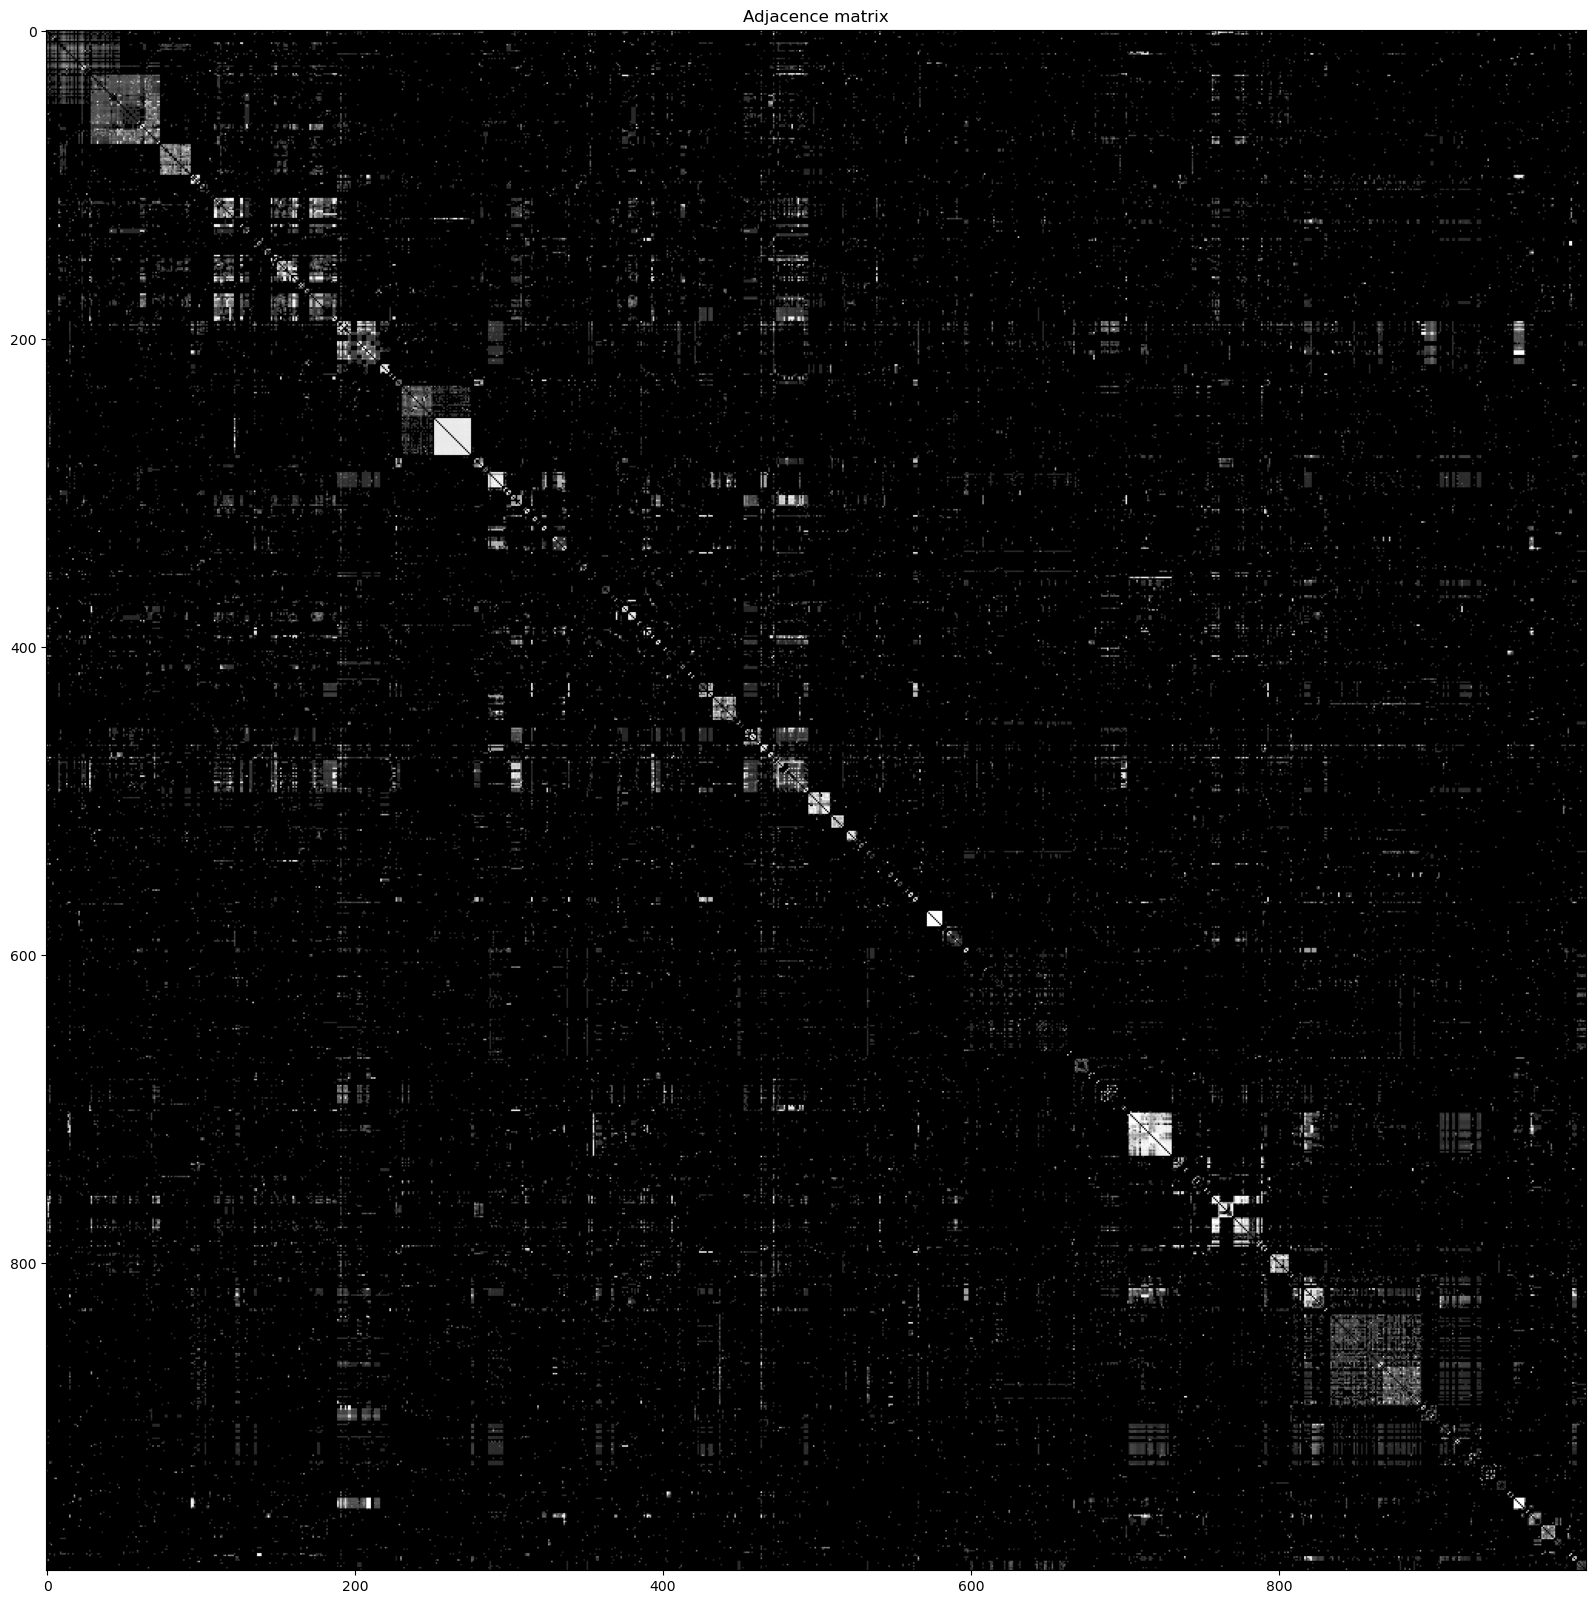

In [60]:
fig = plt.figure(figsize=(20,20))
plt.imshow(adjacence_matrix[:1000,:1000],cmap='gray') #, cmap="YlGnBu",interpolation='nearest')
plt.title("Adjacence matrix")
plt.show()

In [64]:
%%time
np.savetxt('./preprocess/adjacence_matrix.txt', adjacence_matrix, fmt='%i', delimiter=' ')

CPU times: user 49.4 s, sys: 2.54 s, total: 52 s
Wall time: 57.1 s


## Indexing protein links

In [73]:
index_links = protein_links.copy()
index_links['protein1'] = protein_links['protein1'].apply(lambda prot: dict_prot_ID[prot])
index_links['protein2'] = protein_links['protein2'].apply(lambda prot: dict_prot_ID[prot])
index_links=index_links.rename(columns={'protein1':'index1', 'protein2':'index2'})
index_links

,index1,index2,combined_score
0,820,10020,155
1,820,9796,197
2,820,11255,222
3,820,11365,181
4,820,13660,270
...,...,...,...
11938261,4264,8507,408
11938262,4264,3532,160
11938264,4264,10588,256
11938265,4264,2732,281


In [77]:
edge_index = index_links[['index1', 'index2']].to_numpy().T
edge_index.shape

(2, 9928270)

In [79]:
edge_attr = index_links['combined_score'].to_numpy()
edge_attr.shape

(9928270,)

In [104]:
cell_line_idx = 0
x_expression = gene_expression.iloc[cell_line_idx].to_numpy()
x_effect = gene_effect.iloc[cell_line_idx].to_numpy()
print(x_expression.shape, x_effect.shape)

(16481,) (16481,)


In [105]:
from torch_geometric.data import Data

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

OSError: dlopen(/Applications/anaconda3/envs/genomics/lib/python3.8/site-packages/torch_sparse/_convert_cpu.so, 0x0006): Symbol not found: __ZN2at8internal13_parallel_runExxxRKNSt3__18functionIFvxxmEEE
  Referenced from: /Applications/anaconda3/envs/genomics/lib/python3.8/site-packages/torch_sparse/_convert_cpu.so
  Expected in: /Applications/anaconda3/envs/genomics/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib

In [69]:
gene_effect.shape

(1081, 16481)

In [66]:
import sys

In [67]:
sys.getsizeof(adjacence_matrix)

2172987016

In [68]:
sys.getsizeof(protein_links)

1687805916

In [27]:
protein_adjacence_list = {}
last_index = 0
total_nb_index = protein_links.shape[0]   # 11938498

In [ ]:
remaining_laps = 1_000_000
for index, row in tqdm(protein_links.iterrows()):
    if index <= last_index:
        continue
    protein1, protein2, score = row
    if (index+1)%(total_nb_index//100) == 0:
        print(f"{(index+1)/total_nb_index *100:.0f} % analyzed")
    if protein1 not in protein_adjacence_list:
        protein_adjacence_list[protein1] = {}
        protein_adjacence_list[protein1][protein2] = score
    last_index = index
    
    remaining_laps -= 1
    if remaining_laps <= 0:
        break
    

In [28]:
print(protein_links.shape[0])

11938498


In [29]:
print('# possible combinations = %d \n# PPIs = %d' %(16481*16482 / 2, protein_links.shape[0]))

# We see not all proteins are connected ==> # PPIs < # possible combinations

# possible combinations = 135819921 
# PPIs = 11938498


In [31]:
#protein_adjacence_list['9606.ENSP00000000412']['9606.ENSP00000011653']

In [ ]:
protein_adjacence_list

In [ ]:
def find_neighbors(protein, scan_limit=1_000_000):
    neighbors = {}
    remaining_laps = scan_limit
    for index, (protein1, protein2, score) in protein_links.iterrows():
        if protein1 == protein:
            neighbors[protein2] = score
        if protein2 == protein:
            neighbors[protein1] = score
        
        #if (index+1)%(total_nb_index//100) == 0:
        #    print(f"{(index+1)/total_nb_index *100:.0f} % analyzed")
        
        remaining_laps-=1
        if remaining_laps <= 0:
            break
    
    return neighbors

In [ ]:
neighbors = find_neighbors("9606.ENSP00000005260", scan_limit=1_000_000)

In [ ]:
len(neighbors)

In [ ]:
neighbors

In [ ]:
len(gene_effect.columns)

Personal roadmap:

Save the graph as npy  
Smooth the graph using:
$$new x_* = \lambda x_* + (1-\lambda)\sum_i \frac {\alpha_i} {\sum_j \alpha_j} x_i$$
Then do linear regression

Goal:
plot graph expr vs. graph effect before smoothing  
plot graph expr vs. graph effect after smoothing  (different values of lambda)  


## GraphNN

**Aymeric check this out:**

Graphs from pytorch library (PyG) take COO matrix as an input (sparse version of adjacency matrix) which is $[2 \times N_{edges}]$. You have examples here : https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html
Here's a quick alternative for retrieving edges:

In [160]:
from tqdm import tqdm
import scipy
from scipy import stats


# row indices of sorted_proteins will serve as node indices
sorted_proteins = protein_info.sort_values(by = 'protein')

# standardize scores of proteins
protein_links_ = protein_links.copy()
protein_links_['combined_score'] = stats.zscore(protein_links_['combined_score'])
protein_links_ = protein_links_[protein_links_['protein1'].isin(sorted_proteins['protein'])]
protein_links_ = protein_links_[protein_links_['protein2'].isin(sorted_proteins['protein'])]

# initializing our COO matrix
N_edges = protein_links_.shape[0] * 2 # multiplied by 2 because graph undirected
edge_index = np.zeros( (2, N_edges) )
edge_attr = np.zeros( (N_edges, 1) )


In [161]:
max_rows = 1_000_000

for i, row in tqdm(protein_links_[:max_rows].iterrows()):
    protein1, protein2, score = row
    
    print(protein1, protein2)
    
    idx1 = sorted_proteins.index[sorted_proteins['protein'] == protein1].tolist()
    idx2 = sorted_proteins.index[sorted_proteins['protein'] == protein2].tolist()
    
    #assert( len(idx1) == 1 and len(idx2) == 1 )
    
    idx1, idx2 = idx1[0], idx2[0]
    
    # adding both directions to the COO matrix
    edge_index[:, 2*i] = idx1, idx2
    edge_index[:, 2*i + 1] = idx2, idx1
    
    # adding scores to edge_attr matrix 
    edge_attr[2*i:2*i+2, 0] = [score]*2

15it [00:00, 35.50it/s]

9606.ENSP00000000233 9606.ENSP00000379496
9606.ENSP00000000233 9606.ENSP00000314067
9606.ENSP00000000233 9606.ENSP00000263116
9606.ENSP00000000233 9606.ENSP00000361263
9606.ENSP00000000233 9606.ENSP00000409666
9606.ENSP00000000233 9606.ENSP00000324287
9606.ENSP00000000233 9606.ENSP00000333657
9606.ENSP00000000233 9606.ENSP00000308413
9606.ENSP00000000233 9606.ENSP00000215095
9606.ENSP00000000233 9606.ENSP00000267257
9606.ENSP00000000233 9606.ENSP00000345405
9606.ENSP00000000233 9606.ENSP00000444357
9606.ENSP00000000233 9606.ENSP00000296127
9606.ENSP00000000233 9606.ENSP00000007414
9606.ENSP00000000233 9606.ENSP00000353864
9606.ENSP00000000233 9606.ENSP00000346733
9606.ENSP00000000233 9606.ENSP00000308897
9606.ENSP00000000233 9606.ENSP00000349291
9606.ENSP00000000233 9606.ENSP00000253401
9606.ENSP00000000233 9606.ENSP00000360141
9606.ENSP00000000233 9606.ENSP00000312150
9606.ENSP00000000233 9606.ENSP00000361467
9606.ENSP00000000233 9606.ENSP00000360727
9606.ENSP00000000233 9606.ENSP0000

40it [00:00, 75.73it/s]

9606.ENSP00000000233 9606.ENSP00000300026
9606.ENSP00000000233 9606.ENSP00000437554
9606.ENSP00000000233 9606.ENSP00000321348
9606.ENSP00000000233 9606.ENSP00000276689
9606.ENSP00000000233 9606.ENSP00000216373
9606.ENSP00000000233 9606.ENSP00000377948
9606.ENSP00000000233 9606.ENSP00000483486
9606.ENSP00000000233 9606.ENSP00000379191
9606.ENSP00000000233 9606.ENSP00000312734
9606.ENSP00000000233 9606.ENSP00000307939
9606.ENSP00000000233 9606.ENSP00000372023
9606.ENSP00000000233 9606.ENSP00000274289
9606.ENSP00000000233 9606.ENSP00000417573
9606.ENSP00000000233 9606.ENSP00000260762
9606.ENSP00000000233 9606.ENSP00000448182
9606.ENSP00000000233 9606.ENSP00000402103
9606.ENSP00000000233 9606.ENSP00000349305
9606.ENSP00000000233 9606.ENSP00000320295
9606.ENSP00000000233 9606.ENSP00000466363
9606.ENSP00000000233 9606.ENSP00000314214
9606.ENSP00000000233 9606.ENSP00000385995
9606.ENSP00000000233 9606.ENSP00000384996
9606.ENSP00000000233 9606.ENSP00000422037
9606.ENSP00000000233 9606.ENSP0000

77it [00:00, 126.41it/s]

9606.ENSP00000000233 9606.ENSP00000373905
9606.ENSP00000000233 9606.ENSP00000267584
9606.ENSP00000000233 9606.ENSP00000321537
9606.ENSP00000000233 9606.ENSP00000227756
9606.ENSP00000000233 9606.ENSP00000381535
9606.ENSP00000000233 9606.ENSP00000272322
9606.ENSP00000000233 9606.ENSP00000044462
9606.ENSP00000000233 9606.ENSP00000341247
9606.ENSP00000000233 9606.ENSP00000447942
9606.ENSP00000000233 9606.ENSP00000319096
9606.ENSP00000000233 9606.ENSP00000373215
9606.ENSP00000000233 9606.ENSP00000256953
9606.ENSP00000000233 9606.ENSP00000476145
9606.ENSP00000000233 9606.ENSP00000243298
9606.ENSP00000000233 9606.ENSP00000306330
9606.ENSP00000000233 9606.ENSP00000359370
9606.ENSP00000000233 9606.ENSP00000302895
9606.ENSP00000000233 9606.ENSP00000376293
9606.ENSP00000000233 9606.ENSP00000225972
9606.ENSP00000000233 9606.ENSP00000234454
9606.ENSP00000000233 9606.ENSP00000376333
9606.ENSP00000000233 9606.ENSP00000400972
9606.ENSP00000000233 9606.ENSP00000303830
9606.ENSP00000000233 9606.ENSP0000

125it [00:01, 140.89it/s]

9606.ENSP00000000233 9606.ENSP00000334448
9606.ENSP00000000233 9606.ENSP00000263334
9606.ENSP00000000233 9606.ENSP00000348349
9606.ENSP00000000233 9606.ENSP00000295256
9606.ENSP00000000233 9606.ENSP00000363988
9606.ENSP00000000233 9606.ENSP00000445359
9606.ENSP00000000233 9606.ENSP00000442046
9606.ENSP00000000233 9606.ENSP00000272427
9606.ENSP00000000233 9606.ENSP00000358474
9606.ENSP00000000233 9606.ENSP00000312224
9606.ENSP00000000233 9606.ENSP00000471735
9606.ENSP00000000233 9606.ENSP00000233078
9606.ENSP00000000233 9606.ENSP00000264183
9606.ENSP00000000233 9606.ENSP00000346921
9606.ENSP00000000233 9606.ENSP00000349960
9606.ENSP00000000233 9606.ENSP00000380432
9606.ENSP00000000233 9606.ENSP00000376306
9606.ENSP00000000233 9606.ENSP00000466248
9606.ENSP00000000233 9606.ENSP00000339191
9606.ENSP00000000233 9606.ENSP00000299705
9606.ENSP00000000233 9606.ENSP00000442307
9606.ENSP00000000233 9606.ENSP00000375682
9606.ENSP00000000233 9606.ENSP00000377280
9606.ENSP00000000233 9606.ENSP0000

142it [00:01, 147.57it/s]

9606.ENSP00000000233 9606.ENSP00000416097
9606.ENSP00000000233 9606.ENSP00000361473
9606.ENSP00000000233 9606.ENSP00000265709
9606.ENSP00000000233 9606.ENSP00000342136
9606.ENSP00000000233 9606.ENSP00000433102
9606.ENSP00000000233 9606.ENSP00000300574
9606.ENSP00000000233 9606.ENSP00000320866
9606.ENSP00000000233 9606.ENSP00000334100
9606.ENSP00000000233 9606.ENSP00000263245
9606.ENSP00000000233 9606.ENSP00000222803


174it [00:01, 117.70it/s]

9606.ENSP00000000233 9606.ENSP00000217182
9606.ENSP00000000233 9606.ENSP00000346599
9606.ENSP00000000233 9606.ENSP00000354837
9606.ENSP00000000233 9606.ENSP00000300093
9606.ENSP00000000233 9606.ENSP00000452762
9606.ENSP00000000233 9606.ENSP00000325074
9606.ENSP00000000233 9606.ENSP00000280700
9606.ENSP00000000233 9606.ENSP00000283195
9606.ENSP00000000233 9606.ENSP00000475168
9606.ENSP00000000233 9606.ENSP00000265462
9606.ENSP00000000233 9606.ENSP00000255194
9606.ENSP00000000233 9606.ENSP00000278572
9606.ENSP00000000233 9606.ENSP00000371230
9606.ENSP00000000233 9606.ENSP00000336994
9606.ENSP00000000233 9606.ENSP00000327145
9606.ENSP00000000233 9606.ENSP00000251047
9606.ENSP00000000233 9606.ENSP00000296526
9606.ENSP00000000233 9606.ENSP00000409382
9606.ENSP00000000233 9606.ENSP00000364579
9606.ENSP00000000233 9606.ENSP00000381293
9606.ENSP00000000233 9606.ENSP00000217133
9606.ENSP00000000233 9606.ENSP00000294016
9606.ENSP00000000233 9606.ENSP00000440005
9606.ENSP00000000233 9606.ENSP0000

214it [00:01, 153.07it/s]

9606.ENSP00000000233 9606.ENSP00000264071
9606.ENSP00000000233 9606.ENSP00000268057
9606.ENSP00000000233 9606.ENSP00000325002
9606.ENSP00000000233 9606.ENSP00000378669
9606.ENSP00000000233 9606.ENSP00000377086
9606.ENSP00000000233 9606.ENSP00000272238
9606.ENSP00000000233 9606.ENSP00000303437
9606.ENSP00000000233 9606.ENSP00000262719
9606.ENSP00000000233 9606.ENSP00000300249
9606.ENSP00000000233 9606.ENSP00000413697
9606.ENSP00000000233 9606.ENSP00000354080
9606.ENSP00000000233 9606.ENSP00000352995
9606.ENSP00000000233 9606.ENSP00000349503
9606.ENSP00000000233 9606.ENSP00000265717
9606.ENSP00000000233 9606.ENSP00000362590
9606.ENSP00000000233 9606.ENSP00000395083
9606.ENSP00000000233 9606.ENSP00000362115
9606.ENSP00000000233 9606.ENSP00000348429
9606.ENSP00000000233 9606.ENSP00000365773
9606.ENSP00000000233 9606.ENSP00000350012
9606.ENSP00000000233 9606.ENSP00000261636
9606.ENSP00000000233 9606.ENSP00000296271
9606.ENSP00000000233 9606.ENSP00000468424
9606.ENSP00000000233 9606.ENSP0000

282it [00:02, 194.20it/s]

9606.ENSP00000000233 9606.ENSP00000256637
9606.ENSP00000000233 9606.ENSP00000366283
9606.ENSP00000000233 9606.ENSP00000350199
9606.ENSP00000000233 9606.ENSP00000471457
9606.ENSP00000000233 9606.ENSP00000382177
9606.ENSP00000000233 9606.ENSP00000251472
9606.ENSP00000000233 9606.ENSP00000381098
9606.ENSP00000000233 9606.ENSP00000379506
9606.ENSP00000000233 9606.ENSP00000298545
9606.ENSP00000000233 9606.ENSP00000337797
9606.ENSP00000000233 9606.ENSP00000366488
9606.ENSP00000000233 9606.ENSP00000313007
9606.ENSP00000000233 9606.ENSP00000338864
9606.ENSP00000000233 9606.ENSP00000379838
9606.ENSP00000000233 9606.ENSP00000262848
9606.ENSP00000000233 9606.ENSP00000482472
9606.ENSP00000000233 9606.ENSP00000264051
9606.ENSP00000000233 9606.ENSP00000290573
9606.ENSP00000000233 9606.ENSP00000368566
9606.ENSP00000000233 9606.ENSP00000251453
9606.ENSP00000000233 9606.ENSP00000378313
9606.ENSP00000000233 9606.ENSP00000257904
9606.ENSP00000000233 9606.ENSP00000355651
9606.ENSP00000000233 9606.ENSP0000

324it [00:02, 175.67it/s]

9606.ENSP00000000233 9606.ENSP00000381601
9606.ENSP00000000233 9606.ENSP00000352603
9606.ENSP00000000233 9606.ENSP00000432568
9606.ENSP00000000233 9606.ENSP00000381339
9606.ENSP00000000233 9606.ENSP00000240874
9606.ENSP00000000233 9606.ENSP00000361298
9606.ENSP00000000233 9606.ENSP00000443631
9606.ENSP00000000233 9606.ENSP00000268035
9606.ENSP00000000233 9606.ENSP00000254029
9606.ENSP00000000233 9606.ENSP00000373979
9606.ENSP00000000233 9606.ENSP00000282908
9606.ENSP00000000233 9606.ENSP00000322170
9606.ENSP00000000233 9606.ENSP00000479618
9606.ENSP00000000233 9606.ENSP00000003100
9606.ENSP00000000233 9606.ENSP00000293970
9606.ENSP00000000233 9606.ENSP00000245932
9606.ENSP00000000233 9606.ENSP00000464893
9606.ENSP00000000233 9606.ENSP00000225174
9606.ENSP00000000233 9606.ENSP00000302486
9606.ENSP00000000233 9606.ENSP00000359484
9606.ENSP00000000233 9606.ENSP00000269299
9606.ENSP00000000233 9606.ENSP00000365757
9606.ENSP00000000233 9606.ENSP00000483552
9606.ENSP00000000233 9606.ENSP0000

343it [00:02, 145.06it/s]

9606.ENSP00000000233 9606.ENSP00000324302
9606.ENSP00000000233 9606.ENSP00000435096
9606.ENSP00000000233 9606.ENSP00000347712
9606.ENSP00000000233 9606.ENSP00000329471
9606.ENSP00000000233 9606.ENSP00000264028
9606.ENSP00000000233 9606.ENSP00000361275
9606.ENSP00000000233 9606.ENSP00000343325
9606.ENSP00000000233 9606.ENSP00000261170
9606.ENSP00000000233 9606.ENSP00000356918
9606.ENSP00000000233 9606.ENSP00000332454
9606.ENSP00000000233 9606.ENSP00000291906
9606.ENSP00000000233 9606.ENSP00000408236
9606.ENSP00000000233 9606.ENSP00000373574
9606.ENSP00000000233 9606.ENSP00000285402
9606.ENSP00000000233 9606.ENSP00000348753
9606.ENSP00000000233 9606.ENSP00000361057
9606.ENSP00000000233 9606.ENSP00000393541
9606.ENSP00000000233 9606.ENSP00000349781
9606.ENSP00000000233 9606.ENSP00000228251
9606.ENSP00000000233 9606.ENSP00000356982
9606.ENSP00000000233 9606.ENSP00000296474
9606.ENSP00000000233 9606.ENSP00000054666
9606.ENSP00000000233 9606.ENSP00000282249
9606.ENSP00000000233 9606.ENSP0000

381it [00:02, 160.35it/s]

9606.ENSP00000000233 9606.ENSP00000327650
9606.ENSP00000000233 9606.ENSP00000387282
9606.ENSP00000000233 9606.ENSP00000386331
9606.ENSP00000000233 9606.ENSP00000333568
9606.ENSP00000000233 9606.ENSP00000200457
9606.ENSP00000000233 9606.ENSP00000315136
9606.ENSP00000000233 9606.ENSP00000267512
9606.ENSP00000000233 9606.ENSP00000430344
9606.ENSP00000000233 9606.ENSP00000480301
9606.ENSP00000000233 9606.ENSP00000258739
9606.ENSP00000000233 9606.ENSP00000346015
9606.ENSP00000000233 9606.ENSP00000430276
9606.ENSP00000000233 9606.ENSP00000261842
9606.ENSP00000000233 9606.ENSP00000244040
9606.ENSP00000000233 9606.ENSP00000295240
9606.ENSP00000000233 9606.ENSP00000263847
9606.ENSP00000000233 9606.ENSP00000369081
9606.ENSP00000000233 9606.ENSP00000286355
9606.ENSP00000000233 9606.ENSP00000365692
9606.ENSP00000000233 9606.ENSP00000356737
9606.ENSP00000000233 9606.ENSP00000338562
9606.ENSP00000000233 9606.ENSP00000332296
9606.ENSP00000000233 9606.ENSP00000445175
9606.ENSP00000000233 9606.ENSP0000

425it [00:03, 185.20it/s]

9606.ENSP00000000233 9606.ENSP00000000412
9606.ENSP00000000233 9606.ENSP00000276066
9606.ENSP00000000233 9606.ENSP00000348602
9606.ENSP00000000233 9606.ENSP00000362824
9606.ENSP00000000233 9606.ENSP00000363763
9606.ENSP00000000233 9606.ENSP00000337040
9606.ENSP00000000233 9606.ENSP00000225655
9606.ENSP00000000233 9606.ENSP00000276211
9606.ENSP00000000233 9606.ENSP00000357178
9606.ENSP00000000233 9606.ENSP00000288943
9606.ENSP00000000233 9606.ENSP00000324806
9606.ENSP00000000233 9606.ENSP00000251413
9606.ENSP00000000233 9606.ENSP00000272317
9606.ENSP00000000233 9606.ENSP00000418915
9606.ENSP00000000233 9606.ENSP00000364631
9606.ENSP00000000233 9606.ENSP00000392147
9606.ENSP00000000233 9606.ENSP00000333326
9606.ENSP00000000233 9606.ENSP00000479518
9606.ENSP00000000233 9606.ENSP00000302393
9606.ENSP00000000233 9606.ENSP00000366563
9606.ENSP00000000233 9606.ENSP00000368824
9606.ENSP00000000233 9606.ENSP00000286364
9606.ENSP00000000233 9606.ENSP00000466953
9606.ENSP00000000233 9606.ENSP0000

492it [00:03, 196.03it/s]

9606.ENSP00000000233 9606.ENSP00000466298
9606.ENSP00000000233 9606.ENSP00000277010
9606.ENSP00000000233 9606.ENSP00000397908
9606.ENSP00000000233 9606.ENSP00000369318
9606.ENSP00000000233 9606.ENSP00000310129
9606.ENSP00000000233 9606.ENSP00000469413
9606.ENSP00000000233 9606.ENSP00000251412
9606.ENSP00000000233 9606.ENSP00000379457
9606.ENSP00000000233 9606.ENSP00000352834
9606.ENSP00000000233 9606.ENSP00000270625
9606.ENSP00000000233 9606.ENSP00000323879
9606.ENSP00000000233 9606.ENSP00000407552
9606.ENSP00000000233 9606.ENSP00000376475
9606.ENSP00000000233 9606.ENSP00000254846
9606.ENSP00000000233 9606.ENSP00000229264
9606.ENSP00000000233 9606.ENSP00000339179
9606.ENSP00000000233 9606.ENSP00000451291
9606.ENSP00000000233 9606.ENSP00000359552
9606.ENSP00000000233 9606.ENSP00000365962
9606.ENSP00000000233 9606.ENSP00000440167
9606.ENSP00000000233 9606.ENSP00000222008
9606.ENSP00000000233 9606.ENSP00000282032
9606.ENSP00000000233 9606.ENSP00000338777
9606.ENSP00000000233 9606.ENSP0000

512it [00:03, 163.35it/s]

9606.ENSP00000000233 9606.ENSP00000264380
9606.ENSP00000000233 9606.ENSP00000305941
9606.ENSP00000000233 9606.ENSP00000313600
9606.ENSP00000000233 9606.ENSP00000369538
9606.ENSP00000000233 9606.ENSP00000389326
9606.ENSP00000000233 9606.ENSP00000315568
9606.ENSP00000000233 9606.ENSP00000348828
9606.ENSP00000000233 9606.ENSP00000217043
9606.ENSP00000000233 9606.ENSP00000451752
9606.ENSP00000000233 9606.ENSP00000274353
9606.ENSP00000000233 9606.ENSP00000451828
9606.ENSP00000000233 9606.ENSP00000248901
9606.ENSP00000000233 9606.ENSP00000262225
9606.ENSP00000000233 9606.ENSP00000264718
9606.ENSP00000000233 9606.ENSP00000357087
9606.ENSP00000000233 9606.ENSP00000251170
9606.ENSP00000000233 9606.ENSP00000347792
9606.ENSP00000000233 9606.ENSP00000379842
9606.ENSP00000000233 9606.ENSP00000382982
9606.ENSP00000000233 9606.ENSP00000292823
9606.ENSP00000000233 9606.ENSP00000438492
9606.ENSP00000000233 9606.ENSP00000334051
9606.ENSP00000000233 9606.ENSP00000323580
9606.ENSP00000000233 9606.ENSP0000

552it [00:03, 178.60it/s]

9606.ENSP00000000233 9606.ENSP00000372210
9606.ENSP00000000233 9606.ENSP00000267622
9606.ENSP00000000233 9606.ENSP00000368464
9606.ENSP00000000233 9606.ENSP00000386443
9606.ENSP00000000233 9606.ENSP00000429744
9606.ENSP00000000233 9606.ENSP00000361785
9606.ENSP00000000233 9606.ENSP00000379891
9606.ENSP00000000233 9606.ENSP00000373600
9606.ENSP00000000233 9606.ENSP00000373312
9606.ENSP00000000233 9606.ENSP00000374443
9606.ENSP00000000233 9606.ENSP00000259400
9606.ENSP00000000233 9606.ENSP00000379386
9606.ENSP00000000233 9606.ENSP00000369899
9606.ENSP00000000233 9606.ENSP00000370208
9606.ENSP00000000233 9606.ENSP00000315659
9606.ENSP00000000233 9606.ENSP00000354451
9606.ENSP00000000233 9606.ENSP00000301012
9606.ENSP00000000233 9606.ENSP00000441858
9606.ENSP00000000233 9606.ENSP00000243052
9606.ENSP00000000233 9606.ENSP00000355809
9606.ENSP00000000233 9606.ENSP00000035383
9606.ENSP00000000233 9606.ENSP00000238831
9606.ENSP00000000233 9606.ENSP00000309036
9606.ENSP00000000233 9606.ENSP0000

623it [00:04, 214.97it/s]

9606.ENSP00000000233 9606.ENSP00000377233
9606.ENSP00000000233 9606.ENSP00000226253
9606.ENSP00000000233 9606.ENSP00000380635
9606.ENSP00000000233 9606.ENSP00000225577
9606.ENSP00000000233 9606.ENSP00000362116
9606.ENSP00000000233 9606.ENSP00000358994
9606.ENSP00000000233 9606.ENSP00000431418
9606.ENSP00000000233 9606.ENSP00000368818
9606.ENSP00000000233 9606.ENSP00000356832
9606.ENSP00000000233 9606.ENSP00000163416
9606.ENSP00000000233 9606.ENSP00000381097
9606.ENSP00000000233 9606.ENSP00000356607
9606.ENSP00000000233 9606.ENSP00000261942
9606.ENSP00000000233 9606.ENSP00000274376
9606.ENSP00000000233 9606.ENSP00000473001
9606.ENSP00000000233 9606.ENSP00000303909
9606.ENSP00000000233 9606.ENSP00000314649
9606.ENSP00000000233 9606.ENSP00000247461
9606.ENSP00000000233 9606.ENSP00000309457
9606.ENSP00000000233 9606.ENSP00000341083
9606.ENSP00000000233 9606.ENSP00000482835
9606.ENSP00000000233 9606.ENSP00000268933
9606.ENSP00000000233 9606.ENSP00000218006
9606.ENSP00000000233 9606.ENSP0000

671it [00:04, 224.78it/s]

9606.ENSP00000000233 9606.ENSP00000360124
9606.ENSP00000000233 9606.ENSP00000261596
9606.ENSP00000000233 9606.ENSP00000371133
9606.ENSP00000000233 9606.ENSP00000370419
9606.ENSP00000000233 9606.ENSP00000311405
9606.ENSP00000000233 9606.ENSP00000272430
9606.ENSP00000000233 9606.ENSP00000310226
9606.ENSP00000000233 9606.ENSP00000292314
9606.ENSP00000000233 9606.ENSP00000466058
9606.ENSP00000000233 9606.ENSP00000219255
9606.ENSP00000000233 9606.ENSP00000305995
9606.ENSP00000000233 9606.ENSP00000377681
9606.ENSP00000000233 9606.ENSP00000377936
9606.ENSP00000000233 9606.ENSP00000417610
9606.ENSP00000000233 9606.ENSP00000353224
9606.ENSP00000000233 9606.ENSP00000327694
9606.ENSP00000000233 9606.ENSP00000381607
9606.ENSP00000000233 9606.ENSP00000358983
9606.ENSP00000000233 9606.ENSP00000294618
9606.ENSP00000000233 9606.ENSP00000445381
9606.ENSP00000000233 9606.ENSP00000265062
9606.ENSP00000000233 9606.ENSP00000370013
9606.ENSP00000000233 9606.ENSP00000265074
9606.ENSP00000000233 9606.ENSP0000

717it [00:04, 204.16it/s]

9606.ENSP00000000233 9606.ENSP00000362354
9606.ENSP00000000233 9606.ENSP00000352438
9606.ENSP00000000233 9606.ENSP00000346037
9606.ENSP00000000233 9606.ENSP00000437188
9606.ENSP00000000233 9606.ENSP00000209728
9606.ENSP00000000233 9606.ENSP00000341905
9606.ENSP00000000233 9606.ENSP00000314499
9606.ENSP00000000233 9606.ENSP00000265171
9606.ENSP00000000233 9606.ENSP00000276202
9606.ENSP00000000233 9606.ENSP00000367952
9606.ENSP00000000233 9606.ENSP00000478892
9606.ENSP00000000233 9606.ENSP00000378712
9606.ENSP00000000233 9606.ENSP00000446917
9606.ENSP00000000233 9606.ENSP00000304283
9606.ENSP00000000233 9606.ENSP00000420211
9606.ENSP00000000233 9606.ENSP00000369126
9606.ENSP00000000233 9606.ENSP00000341344
9606.ENSP00000000233 9606.ENSP00000356920
9606.ENSP00000000233 9606.ENSP00000376268
9606.ENSP00000000233 9606.ENSP00000251507
9606.ENSP00000000233 9606.ENSP00000328287
9606.ENSP00000000233 9606.ENSP00000338844
9606.ENSP00000000233 9606.ENSP00000480573
9606.ENSP00000000233 9606.ENSP0000

756it [00:04, 167.66it/s]

9606.ENSP00000000233 9606.ENSP00000336724
9606.ENSP00000000233 9606.ENSP00000378557
9606.ENSP00000000233 9606.ENSP00000261769
9606.ENSP00000000233 9606.ENSP00000315299
9606.ENSP00000000233 9606.ENSP00000380334
9606.ENSP00000000233 9606.ENSP00000355866
9606.ENSP00000000233 9606.ENSP00000356489
9606.ENSP00000000233 9606.ENSP00000367830
9606.ENSP00000000233 9606.ENSP00000348215
9606.ENSP00000000233 9606.ENSP00000442682
9606.ENSP00000000233 9606.ENSP00000404676
9606.ENSP00000000233 9606.ENSP00000299138
9606.ENSP00000000233 9606.ENSP00000300896
9606.ENSP00000000233 9606.ENSP00000380530
9606.ENSP00000000233 9606.ENSP00000382323
9606.ENSP00000000233 9606.ENSP00000290378
9606.ENSP00000000233 9606.ENSP00000370376
9606.ENSP00000000233 9606.ENSP00000359297
9606.ENSP00000000233 9606.ENSP00000281821
9606.ENSP00000000233 9606.ENSP00000222812
9606.ENSP00000000233 9606.ENSP00000258301
9606.ENSP00000000233 9606.ENSP00000298573
9606.ENSP00000000233 9606.ENSP00000275364
9606.ENSP00000000233 9606.ENSP0000

800it [00:05, 190.25it/s]

9606.ENSP00000000233 9606.ENSP00000220062
9606.ENSP00000000233 9606.ENSP00000229340
9606.ENSP00000000233 9606.ENSP00000303507
9606.ENSP00000000233 9606.ENSP00000267113
9606.ENSP00000000233 9606.ENSP00000358309
9606.ENSP00000000233 9606.ENSP00000258390
9606.ENSP00000000233 9606.ENSP00000360860
9606.ENSP00000000233 9606.ENSP00000339381
9606.ENSP00000000233 9606.ENSP00000378324
9606.ENSP00000000233 9606.ENSP00000255030
9606.ENSP00000000233 9606.ENSP00000484855
9606.ENSP00000000233 9606.ENSP00000263025
9606.ENSP00000000233 9606.ENSP00000245796
9606.ENSP00000000233 9606.ENSP00000229812
9606.ENSP00000000233 9606.ENSP00000365807
9606.ENSP00000000233 9606.ENSP00000440984
9606.ENSP00000000233 9606.ENSP00000291670
9606.ENSP00000000233 9606.ENSP00000261507
9606.ENSP00000000233 9606.ENSP00000350937
9606.ENSP00000000233 9606.ENSP00000269321
9606.ENSP00000000233 9606.ENSP00000381064
9606.ENSP00000000233 9606.ENSP00000321826
9606.ENSP00000000233 9606.ENSP00000483786
9606.ENSP00000000233 9606.ENSP0000

846it [00:05, 208.12it/s]

9606.ENSP00000000233 9606.ENSP00000251527
9606.ENSP00000000233 9606.ENSP00000367747
9606.ENSP00000000233 9606.ENSP00000359719
9606.ENSP00000000233 9606.ENSP00000380413
9606.ENSP00000000233 9606.ENSP00000253188
9606.ENSP00000000233 9606.ENSP00000334223
9606.ENSP00000000233 9606.ENSP00000338173
9606.ENSP00000000233 9606.ENSP00000340274
9606.ENSP00000000233 9606.ENSP00000268182
9606.ENSP00000000233 9606.ENSP00000449241
9606.ENSP00000000233 9606.ENSP00000381565
9606.ENSP00000000233 9606.ENSP00000361475
9606.ENSP00000000233 9606.ENSP00000246166
9606.ENSP00000000233 9606.ENSP00000397351
9606.ENSP00000000233 9606.ENSP00000349877
9606.ENSP00000000233 9606.ENSP00000298229
9606.ENSP00000000233 9606.ENSP00000461785
9606.ENSP00000000233 9606.ENSP00000266712
9606.ENSP00000000233 9606.ENSP00000223023
9606.ENSP00000000233 9606.ENSP00000387699
9606.ENSP00000000233 9606.ENSP00000427793
9606.ENSP00000000233 9606.ENSP00000441158
9606.ENSP00000000233 9606.ENSP00000355995
9606.ENSP00000000233 9606.ENSP0000

891it [00:05, 205.72it/s]

9606.ENSP00000000233 9606.ENSP00000351475
9606.ENSP00000000233 9606.ENSP00000357219
9606.ENSP00000000233 9606.ENSP00000272217
9606.ENSP00000000233 9606.ENSP00000440207
9606.ENSP00000000233 9606.ENSP00000407586
9606.ENSP00000000233 9606.ENSP00000362386
9606.ENSP00000000233 9606.ENSP00000428564
9606.ENSP00000000233 9606.ENSP00000429900
9606.ENSP00000000233 9606.ENSP00000256682
9606.ENSP00000000233 9606.ENSP00000244769
9606.ENSP00000000233 9606.ENSP00000405965
9606.ENSP00000000233 9606.ENSP00000357177
9606.ENSP00000000233 9606.ENSP00000268989
9606.ENSP00000000233 9606.ENSP00000276410
9606.ENSP00000000233 9606.ENSP00000477707
9606.ENSP00000000233 9606.ENSP00000273047
9606.ENSP00000000233 9606.ENSP00000354739
9606.ENSP00000000233 9606.ENSP00000317469
9606.ENSP00000000233 9606.ENSP00000378743
9606.ENSP00000000233 9606.ENSP00000365201
9606.ENSP00000000233 9606.ENSP00000309794
9606.ENSP00000000233 9606.ENSP00000450385
9606.ENSP00000000233 9606.ENSP00000234313
9606.ENSP00000000233 9606.ENSP0000

934it [00:05, 208.17it/s]

9606.ENSP00000000233 9606.ENSP00000446271
9606.ENSP00000000233 9606.ENSP00000236192
9606.ENSP00000000233 9606.ENSP00000464342
9606.ENSP00000000233 9606.ENSP00000429969
9606.ENSP00000000233 9606.ENSP00000275493
9606.ENSP00000000233 9606.ENSP00000341779
9606.ENSP00000000233 9606.ENSP00000358019
9606.ENSP00000000233 9606.ENSP00000250495
9606.ENSP00000000233 9606.ENSP00000333298
9606.ENSP00000000233 9606.ENSP00000354251
9606.ENSP00000000233 9606.ENSP00000366098
9606.ENSP00000000233 9606.ENSP00000253727
9606.ENSP00000000233 9606.ENSP00000262646
9606.ENSP00000000233 9606.ENSP00000310244
9606.ENSP00000000233 9606.ENSP00000365630
9606.ENSP00000000233 9606.ENSP00000266037
9606.ENSP00000000233 9606.ENSP00000269305
9606.ENSP00000000233 9606.ENSP00000304669
9606.ENSP00000000233 9606.ENSP00000029410
9606.ENSP00000000233 9606.ENSP00000463188
9606.ENSP00000000233 9606.ENSP00000384192
9606.ENSP00000000233 9606.ENSP00000269051
9606.ENSP00000000233 9606.ENSP00000316377
9606.ENSP00000000233 9606.ENSP0000

981it [00:05, 219.90it/s]

9606.ENSP00000000233 9606.ENSP00000362608
9606.ENSP00000000233 9606.ENSP00000327801
9606.ENSP00000000233 9606.ENSP00000226284
9606.ENSP00000000233 9606.ENSP00000261558
9606.ENSP00000000233 9606.ENSP00000378957
9606.ENSP00000000233 9606.ENSP00000225941
9606.ENSP00000000233 9606.ENSP00000257663
9606.ENSP00000000233 9606.ENSP00000347538
9606.ENSP00000000233 9606.ENSP00000464443
9606.ENSP00000000233 9606.ENSP00000258098
9606.ENSP00000000233 9606.ENSP00000012443
9606.ENSP00000000233 9606.ENSP00000326342
9606.ENSP00000000233 9606.ENSP00000311165
9606.ENSP00000000233 9606.ENSP00000222792
9606.ENSP00000000233 9606.ENSP00000324856
9606.ENSP00000000233 9606.ENSP00000343405
9606.ENSP00000000233 9606.ENSP00000161006
9606.ENSP00000000233 9606.ENSP00000409667
9606.ENSP00000000233 9606.ENSP00000245157
9606.ENSP00000000233 9606.ENSP00000346762
9606.ENSP00000000233 9606.ENSP00000259371
9606.ENSP00000000233 9606.ENSP00000279022
9606.ENSP00000000233 9606.ENSP00000360532
9606.ENSP00000000233 9606.ENSP0000

1051it [00:06, 221.59it/s]

9606.ENSP00000000233 9606.ENSP00000386541
9606.ENSP00000000233 9606.ENSP00000263270
9606.ENSP00000000233 9606.ENSP00000360672
9606.ENSP00000000233 9606.ENSP00000377769
9606.ENSP00000000233 9606.ENSP00000368758
9606.ENSP00000000233 9606.ENSP00000324127
9606.ENSP00000000233 9606.ENSP00000352601
9606.ENSP00000000233 9606.ENSP00000367208
9606.ENSP00000000233 9606.ENSP00000344871
9606.ENSP00000000233 9606.ENSP00000256001
9606.ENSP00000000233 9606.ENSP00000318821
9606.ENSP00000000233 9606.ENSP00000320563
9606.ENSP00000000233 9606.ENSP00000354398
9606.ENSP00000000233 9606.ENSP00000335083
9606.ENSP00000000233 9606.ENSP00000369755
9606.ENSP00000000233 9606.ENSP00000468348
9606.ENSP00000000233 9606.ENSP00000343244
9606.ENSP00000000233 9606.ENSP00000360683
9606.ENSP00000000233 9606.ENSP00000391723
9606.ENSP00000000233 9606.ENSP00000421280
9606.ENSP00000000233 9606.ENSP00000350036
9606.ENSP00000000233 9606.ENSP00000378338
9606.ENSP00000000233 9606.ENSP00000203556
9606.ENSP00000000233 9606.ENSP0000

1099it [00:06, 227.16it/s]

9606.ENSP00000000233 9606.ENSP00000374484
9606.ENSP00000000233 9606.ENSP00000436785
9606.ENSP00000000233 9606.ENSP00000253861
9606.ENSP00000000233 9606.ENSP00000377250
9606.ENSP00000000233 9606.ENSP00000345206
9606.ENSP00000000233 9606.ENSP00000479134
9606.ENSP00000000233 9606.ENSP00000397133
9606.ENSP00000000233 9606.ENSP00000363054
9606.ENSP00000000233 9606.ENSP00000283426
9606.ENSP00000000233 9606.ENSP00000260643
9606.ENSP00000000233 9606.ENSP00000236671
9606.ENSP00000000233 9606.ENSP00000431800
9606.ENSP00000000233 9606.ENSP00000353920
9606.ENSP00000000233 9606.ENSP00000343027
9606.ENSP00000000233 9606.ENSP00000338766
9606.ENSP00000000233 9606.ENSP00000310551
9606.ENSP00000000233 9606.ENSP00000407213
9606.ENSP00000000233 9606.ENSP00000222305
9606.ENSP00000000233 9606.ENSP00000314615
9606.ENSP00000000233 9606.ENSP00000379203
9606.ENSP00000000233 9606.ENSP00000337451
9606.ENSP00000000233 9606.ENSP00000272298
9606.ENSP00000000233 9606.ENSP00000360994
9606.ENSP00000000233 9606.ENSP0000

1146it [00:06, 225.75it/s]

9606.ENSP00000000233 9606.ENSP00000385000
9606.ENSP00000000233 9606.ENSP00000394071
9606.ENSP00000000233 9606.ENSP00000385205
9606.ENSP00000000233 9606.ENSP00000262494
9606.ENSP00000000233 9606.ENSP00000298910
9606.ENSP00000000233 9606.ENSP00000379256
9606.ENSP00000000233 9606.ENSP00000317272
9606.ENSP00000000233 9606.ENSP00000329127
9606.ENSP00000000233 9606.ENSP00000353824
9606.ENSP00000000233 9606.ENSP00000289153
9606.ENSP00000000233 9606.ENSP00000263816
9606.ENSP00000000233 9606.ENSP00000356825
9606.ENSP00000000233 9606.ENSP00000362399
9606.ENSP00000000233 9606.ENSP00000241463
9606.ENSP00000000233 9606.ENSP00000339754
9606.ENSP00000000233 9606.ENSP00000298316
9606.ENSP00000000233 9606.ENSP00000252603
9606.ENSP00000000233 9606.ENSP00000373684
9606.ENSP00000000233 9606.ENSP00000300504
9606.ENSP00000000233 9606.ENSP00000410059
9606.ENSP00000000233 9606.ENSP00000358867
9606.ENSP00000000233 9606.ENSP00000300289
9606.ENSP00000000233 9606.ENSP00000260600
9606.ENSP00000000233 9606.ENSP0000

1192it [00:06, 219.16it/s]

9606.ENSP00000000233 9606.ENSP00000337261
9606.ENSP00000000233 9606.ENSP00000345957
9606.ENSP00000000233 9606.ENSP00000386213
9606.ENSP00000000233 9606.ENSP00000223500
9606.ENSP00000000233 9606.ENSP00000362014
9606.ENSP00000000233 9606.ENSP00000367828
9606.ENSP00000000233 9606.ENSP00000380942
9606.ENSP00000000233 9606.ENSP00000225724
9606.ENSP00000000233 9606.ENSP00000403636
9606.ENSP00000000233 9606.ENSP00000384869
9606.ENSP00000000233 9606.ENSP00000369784
9606.ENSP00000000233 9606.ENSP00000261303
9606.ENSP00000000233 9606.ENSP00000323880
9606.ENSP00000000233 9606.ENSP00000462468
9606.ENSP00000000233 9606.ENSP00000398560
9606.ENSP00000000233 9606.ENSP00000479153
9606.ENSP00000000233 9606.ENSP00000246194
9606.ENSP00000000233 9606.ENSP00000357129
9606.ENSP00000000233 9606.ENSP00000326699
9606.ENSP00000000233 9606.ENSP00000337838
9606.ENSP00000000233 9606.ENSP00000355026
9606.ENSP00000000233 9606.ENSP00000322419
9606.ENSP00000000233 9606.ENSP00000287600
9606.ENSP00000000233 9606.ENSP0000

1263it [00:07, 227.50it/s]

9606.ENSP00000000233 9606.ENSP00000369703
9606.ENSP00000000233 9606.ENSP00000329967
9606.ENSP00000000233 9606.ENSP00000393978
9606.ENSP00000000233 9606.ENSP00000310561
9606.ENSP00000000233 9606.ENSP00000355511
9606.ENSP00000000233 9606.ENSP00000343144
9606.ENSP00000000233 9606.ENSP00000363676
9606.ENSP00000000233 9606.ENSP00000261890
9606.ENSP00000000233 9606.ENSP00000249071
9606.ENSP00000000233 9606.ENSP00000413606
9606.ENSP00000000233 9606.ENSP00000340935
9606.ENSP00000000233 9606.ENSP00000296795
9606.ENSP00000000233 9606.ENSP00000215754
9606.ENSP00000000233 9606.ENSP00000403323
9606.ENSP00000000233 9606.ENSP00000366672
9606.ENSP00000000233 9606.ENSP00000219313
9606.ENSP00000000233 9606.ENSP00000335029
9606.ENSP00000000233 9606.ENSP00000277575
9606.ENSP00000000233 9606.ENSP00000288235
9606.ENSP00000000233 9606.ENSP00000365005
9606.ENSP00000000233 9606.ENSP00000386857
9606.ENSP00000000233 9606.ENSP00000329219
9606.ENSP00000000233 9606.ENSP00000264431
9606.ENSP00000000233 9606.ENSP0000

1333it [00:07, 227.99it/s]

9606.ENSP00000000233 9606.ENSP00000332576
9606.ENSP00000000233 9606.ENSP00000274963
9606.ENSP00000000233 9606.ENSP00000220676
9606.ENSP00000000233 9606.ENSP00000223073
9606.ENSP00000000233 9606.ENSP00000443654
9606.ENSP00000000233 9606.ENSP00000325369
9606.ENSP00000000233 9606.ENSP00000375081
9606.ENSP00000000233 9606.ENSP00000274710
9606.ENSP00000000233 9606.ENSP00000341289
9606.ENSP00000000233 9606.ENSP00000361803
9606.ENSP00000000233 9606.ENSP00000361636
9606.ENSP00000000233 9606.ENSP00000312999
9606.ENSP00000000233 9606.ENSP00000381876
9606.ENSP00000000233 9606.ENSP00000245680
9606.ENSP00000000233 9606.ENSP00000256261
9606.ENSP00000000233 9606.ENSP00000279281
9606.ENSP00000000233 9606.ENSP00000418401
9606.ENSP00000000233 9606.ENSP00000350896
9606.ENSP00000000233 9606.ENSP00000215832
9606.ENSP00000000233 9606.ENSP00000297044
9606.ENSP00000000233 9606.ENSP00000295888
9606.ENSP00000000233 9606.ENSP00000279036
9606.ENSP00000000233 9606.ENSP00000393776
9606.ENSP00000000233 9606.ENSP0000

1380it [00:07, 227.15it/s]

9606.ENSP00000000412 9606.ENSP00000376792
9606.ENSP00000000412 9606.ENSP00000255194
9606.ENSP00000000412 9606.ENSP00000269571
9606.ENSP00000000412 9606.ENSP00000243776
9606.ENSP00000000412 9606.ENSP00000378394
9606.ENSP00000000412 9606.ENSP00000283195
9606.ENSP00000000412 9606.ENSP00000237596
9606.ENSP00000000412 9606.ENSP00000447378
9606.ENSP00000000412 9606.ENSP00000386597
9606.ENSP00000000412 9606.ENSP00000349437
9606.ENSP00000000412 9606.ENSP00000438399
9606.ENSP00000000412 9606.ENSP00000225724
9606.ENSP00000000412 9606.ENSP00000383118
9606.ENSP00000000412 9606.ENSP00000358211
9606.ENSP00000000412 9606.ENSP00000381098
9606.ENSP00000000412 9606.ENSP00000363081
9606.ENSP00000000412 9606.ENSP00000362680
9606.ENSP00000000412 9606.ENSP00000354376
9606.ENSP00000000412 9606.ENSP00000431445
9606.ENSP00000000412 9606.ENSP00000260197
9606.ENSP00000000412 9606.ENSP00000243253
9606.ENSP00000000412 9606.ENSP00000359380
9606.ENSP00000000412 9606.ENSP00000360645
9606.ENSP00000000412 9606.ENSP0000

1426it [00:07, 224.79it/s]

9606.ENSP00000000412 9606.ENSP00000259400
9606.ENSP00000000412 9606.ENSP00000304422
9606.ENSP00000000412 9606.ENSP00000273047
9606.ENSP00000000412 9606.ENSP00000261890
9606.ENSP00000000412 9606.ENSP00000324628
9606.ENSP00000000412 9606.ENSP00000312946
9606.ENSP00000000412 9606.ENSP00000454229
9606.ENSP00000000412 9606.ENSP00000263054
9606.ENSP00000000412 9606.ENSP00000379891
9606.ENSP00000000412 9606.ENSP00000256682
9606.ENSP00000000412 9606.ENSP00000296684
9606.ENSP00000000412 9606.ENSP00000345344
9606.ENSP00000000412 9606.ENSP00000386443
9606.ENSP00000000412 9606.ENSP00000267622
9606.ENSP00000000412 9606.ENSP00000340466
9606.ENSP00000000412 9606.ENSP00000284981
9606.ENSP00000000412 9606.ENSP00000313869
9606.ENSP00000000412 9606.ENSP00000468424
9606.ENSP00000000412 9606.ENSP00000358126
9606.ENSP00000000412 9606.ENSP00000417764
9606.ENSP00000000412 9606.ENSP00000393559
9606.ENSP00000000412 9606.ENSP00000262640
9606.ENSP00000000412 9606.ENSP00000362010
9606.ENSP00000000412 9606.ENSP0000

1472it [00:08, 208.01it/s]

9606.ENSP00000000412 9606.ENSP00000163416
9606.ENSP00000000412 9606.ENSP00000294179
9606.ENSP00000000412 9606.ENSP00000003084
9606.ENSP00000000412 9606.ENSP00000305692
9606.ENSP00000000412 9606.ENSP00000347416
9606.ENSP00000000412 9606.ENSP00000337354
9606.ENSP00000000412 9606.ENSP00000360798
9606.ENSP00000000412 9606.ENSP00000355651
9606.ENSP00000000412 9606.ENSP00000401435
9606.ENSP00000000412 9606.ENSP00000247933
9606.ENSP00000000412 9606.ENSP00000459943
9606.ENSP00000000412 9606.ENSP00000333298
9606.ENSP00000000412 9606.ENSP00000275493
9606.ENSP00000000412 9606.ENSP00000305255
9606.ENSP00000000412 9606.ENSP00000355629
9606.ENSP00000000412 9606.ENSP00000347184
9606.ENSP00000000412 9606.ENSP00000261416
9606.ENSP00000000412 9606.ENSP00000236192
9606.ENSP00000000412 9606.ENSP00000335060
9606.ENSP00000000412 9606.ENSP00000249647
9606.ENSP00000000412 9606.ENSP00000417354
9606.ENSP00000000412 9606.ENSP00000306100
9606.ENSP00000000412 9606.ENSP00000361562
9606.ENSP00000000412 9606.ENSP0000

1514it [00:08, 185.41it/s]

9606.ENSP00000000412 9606.ENSP00000353224
9606.ENSP00000000412 9606.ENSP00000011473
9606.ENSP00000000412 9606.ENSP00000274000
9606.ENSP00000000412 9606.ENSP00000302665
9606.ENSP00000000412 9606.ENSP00000207549
9606.ENSP00000000412 9606.ENSP00000445052
9606.ENSP00000000412 9606.ENSP00000231368
9606.ENSP00000000412 9606.ENSP00000269299
9606.ENSP00000000412 9606.ENSP00000483552
9606.ENSP00000000412 9606.ENSP00000279281
9606.ENSP00000000412 9606.ENSP00000374069
9606.ENSP00000000412 9606.ENSP00000479618
9606.ENSP00000000412 9606.ENSP00000362707
9606.ENSP00000000412 9606.ENSP00000258145
9606.ENSP00000000412 9606.ENSP00000367299
9606.ENSP00000000412 9606.ENSP00000357453
9606.ENSP00000000412 9606.ENSP00000398632
9606.ENSP00000000412 9606.ENSP00000443631
9606.ENSP00000000412 9606.ENSP00000264896
9606.ENSP00000000412 9606.ENSP00000299886
9606.ENSP00000000412 9606.ENSP00000363976
9606.ENSP00000000412 9606.ENSP00000380378
9606.ENSP00000000412 9606.ENSP00000268035
9606.ENSP00000000412 9606.ENSP0000

1560it [00:08, 205.38it/s]

9606.ENSP00000000412 9606.ENSP00000368022
9606.ENSP00000000412 9606.ENSP00000369081
9606.ENSP00000000412 9606.ENSP00000384400
9606.ENSP00000000412 9606.ENSP00000341344
9606.ENSP00000000412 9606.ENSP00000357564
9606.ENSP00000000412 9606.ENSP00000356920
9606.ENSP00000000412 9606.ENSP00000378725
9606.ENSP00000000412 9606.ENSP00000265171
9606.ENSP00000000412 9606.ENSP00000420384
9606.ENSP00000000412 9606.ENSP00000293217
9606.ENSP00000000412 9606.ENSP00000422185
9606.ENSP00000000412 9606.ENSP00000275525
9606.ENSP00000000412 9606.ENSP00000345672
9606.ENSP00000000412 9606.ENSP00000307939
9606.ENSP00000000412 9606.ENSP00000427900
9606.ENSP00000000412 9606.ENSP00000244040
9606.ENSP00000000412 9606.ENSP00000221466
9606.ENSP00000000412 9606.ENSP00000263847
9606.ENSP00000000412 9606.ENSP00000276914
9606.ENSP00000000412 9606.ENSP00000461945
9606.ENSP00000000412 9606.ENSP00000314499
9606.ENSP00000000412 9606.ENSP00000365938
9606.ENSP00000000412 9606.ENSP00000364956
9606.ENSP00000000412 9606.ENSP0000

1627it [00:08, 213.13it/s]

9606.ENSP00000000412 9606.ENSP00000387282
9606.ENSP00000000412 9606.ENSP00000400459
9606.ENSP00000000412 9606.ENSP00000287482
9606.ENSP00000000412 9606.ENSP00000352601
9606.ENSP00000000412 9606.ENSP00000220509
9606.ENSP00000000412 9606.ENSP00000251968
9606.ENSP00000000412 9606.ENSP00000261304
9606.ENSP00000000412 9606.ENSP00000217423
9606.ENSP00000000412 9606.ENSP00000054666
9606.ENSP00000000412 9606.ENSP00000402460
9606.ENSP00000000412 9606.ENSP00000409952
9606.ENSP00000000412 9606.ENSP00000398568
9606.ENSP00000000412 9606.ENSP00000373570
9606.ENSP00000000412 9606.ENSP00000311449
9606.ENSP00000000412 9606.ENSP00000263270
9606.ENSP00000000412 9606.ENSP00000346839
9606.ENSP00000000412 9606.ENSP00000299314
9606.ENSP00000000412 9606.ENSP00000223641
9606.ENSP00000000412 9606.ENSP00000366998
9606.ENSP00000000412 9606.ENSP00000337053
9606.ENSP00000000412 9606.ENSP00000332247
9606.ENSP00000000412 9606.ENSP00000204726
9606.ENSP00000000412 9606.ENSP00000243662
9606.ENSP00000000412 9606.ENSP0000

1673it [00:09, 219.29it/s]

9606.ENSP00000000412 9606.ENSP00000295897
9606.ENSP00000000412 9606.ENSP00000480332
9606.ENSP00000000412 9606.ENSP00000365569
9606.ENSP00000000412 9606.ENSP00000445408
9606.ENSP00000000412 9606.ENSP00000222547
9606.ENSP00000000412 9606.ENSP00000356540
9606.ENSP00000000412 9606.ENSP00000281187
9606.ENSP00000000412 9606.ENSP00000447053
9606.ENSP00000000412 9606.ENSP00000351926
9606.ENSP00000000412 9606.ENSP00000366748
9606.ENSP00000000412 9606.ENSP00000262506
9606.ENSP00000000412 9606.ENSP00000388996
9606.ENSP00000000412 9606.ENSP00000309376
9606.ENSP00000000412 9606.ENSP00000349305
9606.ENSP00000000412 9606.ENSP00000338562
9606.ENSP00000000412 9606.ENSP00000314214
9606.ENSP00000000412 9606.ENSP00000360183
9606.ENSP00000000412 9606.ENSP00000464275
9606.ENSP00000000412 9606.ENSP00000363616
9606.ENSP00000000412 9606.ENSP00000349960
9606.ENSP00000000412 9606.ENSP00000380432
9606.ENSP00000000412 9606.ENSP00000371152
9606.ENSP00000000412 9606.ENSP00000225719
9606.ENSP00000000412 9606.ENSP0000

1745it [00:09, 227.10it/s]

9606.ENSP00000000412 9606.ENSP00000233202
9606.ENSP00000000412 9606.ENSP00000366565
9606.ENSP00000000412 9606.ENSP00000386346
9606.ENSP00000000412 9606.ENSP00000304376
9606.ENSP00000000412 9606.ENSP00000371272
9606.ENSP00000000412 9606.ENSP00000409581
9606.ENSP00000000412 9606.ENSP00000264595
9606.ENSP00000000412 9606.ENSP00000481750
9606.ENSP00000000412 9606.ENSP00000366746
9606.ENSP00000000412 9606.ENSP00000317714
9606.ENSP00000000412 9606.ENSP00000348888
9606.ENSP00000000412 9606.ENSP00000258301
9606.ENSP00000000412 9606.ENSP00000300692
9606.ENSP00000000412 9606.ENSP00000338777
9606.ENSP00000000412 9606.ENSP00000370473
9606.ENSP00000000412 9606.ENSP00000230085
9606.ENSP00000000412 9606.ENSP00000308430
9606.ENSP00000000412 9606.ENSP00000379601
9606.ENSP00000000412 9606.ENSP00000368831
9606.ENSP00000000412 9606.ENSP00000185150
9606.ENSP00000000412 9606.ENSP00000320866
9606.ENSP00000000412 9606.ENSP00000263245
9606.ENSP00000000412 9606.ENSP00000386559
9606.ENSP00000000412 9606.ENSP0000

1792it [00:09, 219.80it/s]

9606.ENSP00000000412 9606.ENSP00000264382
9606.ENSP00000000412 9606.ENSP00000317445
9606.ENSP00000000412 9606.ENSP00000299427
9606.ENSP00000000412 9606.ENSP00000290649
9606.ENSP00000000412 9606.ENSP00000308122
9606.ENSP00000000412 9606.ENSP00000369318
9606.ENSP00000000412 9606.ENSP00000377275
9606.ENSP00000000412 9606.ENSP00000312506
9606.ENSP00000000412 9606.ENSP00000300289
9606.ENSP00000000412 9606.ENSP00000223369
9606.ENSP00000000412 9606.ENSP00000262812
9606.ENSP00000000412 9606.ENSP00000418082
9606.ENSP00000000412 9606.ENSP00000338345
9606.ENSP00000000412 9606.ENSP00000336666
9606.ENSP00000000412 9606.ENSP00000335082
9606.ENSP00000000412 9606.ENSP00000355231
9606.ENSP00000000412 9606.ENSP00000466298
9606.ENSP00000000412 9606.ENSP00000451112
9606.ENSP00000000412 9606.ENSP00000462729
9606.ENSP00000000412 9606.ENSP00000263354
9606.ENSP00000000412 9606.ENSP00000309124
9606.ENSP00000000412 9606.ENSP00000314606
9606.ENSP00000000412 9606.ENSP00000466134
9606.ENSP00000000412 9606.ENSP0000

1837it [00:09, 217.99it/s]

9606.ENSP00000001008 9606.ENSP00000298832
9606.ENSP00000001008 9606.ENSP00000381266
9606.ENSP00000001008 9606.ENSP00000368880
9606.ENSP00000001008 9606.ENSP00000378332
9606.ENSP00000001008 9606.ENSP00000446252
9606.ENSP00000001008 9606.ENSP00000360472
9606.ENSP00000001008 9606.ENSP00000385746
9606.ENSP00000001008 9606.ENSP00000359688
9606.ENSP00000001008 9606.ENSP00000324173
9606.ENSP00000001008 9606.ENSP00000317232
9606.ENSP00000001008 9606.ENSP00000326381
9606.ENSP00000001008 9606.ENSP00000355924
9606.ENSP00000001008 9606.ENSP00000284719
9606.ENSP00000001008 9606.ENSP00000202816
9606.ENSP00000001008 9606.ENSP00000407213
9606.ENSP00000001008 9606.ENSP00000372667
9606.ENSP00000001008 9606.ENSP00000359424
9606.ENSP00000001008 9606.ENSP00000271526
9606.ENSP00000001008 9606.ENSP00000340989
9606.ENSP00000001008 9606.ENSP00000266556
9606.ENSP00000001008 9606.ENSP00000261868
9606.ENSP00000001008 9606.ENSP00000256104
9606.ENSP00000001008 9606.ENSP00000272298
9606.ENSP00000001008 9606.ENSP0000

1905it [00:10, 218.75it/s]

9606.ENSP00000001008 9606.ENSP00000363993
9606.ENSP00000001008 9606.ENSP00000480763
9606.ENSP00000001008 9606.ENSP00000217233
9606.ENSP00000001008 9606.ENSP00000304802
9606.ENSP00000001008 9606.ENSP00000361914
9606.ENSP00000001008 9606.ENSP00000484669
9606.ENSP00000001008 9606.ENSP00000378868
9606.ENSP00000001008 9606.ENSP00000303057
9606.ENSP00000001008 9606.ENSP00000439012
9606.ENSP00000001008 9606.ENSP00000281938
9606.ENSP00000001008 9606.ENSP00000305161
9606.ENSP00000001008 9606.ENSP00000157812
9606.ENSP00000001008 9606.ENSP00000254940
9606.ENSP00000001008 9606.ENSP00000369027
9606.ENSP00000001008 9606.ENSP00000420612
9606.ENSP00000001008 9606.ENSP00000296464
9606.ENSP00000001008 9606.ENSP00000011898
9606.ENSP00000001008 9606.ENSP00000225298
9606.ENSP00000001008 9606.ENSP00000271308
9606.ENSP00000001008 9606.ENSP00000321449
9606.ENSP00000001008 9606.ENSP00000282611
9606.ENSP00000001008 9606.ENSP00000365147
9606.ENSP00000001008 9606.ENSP00000238789
9606.ENSP00000001008 9606.ENSP0000

1950it [00:10, 218.75it/s]

9606.ENSP00000001008 9606.ENSP00000361383
9606.ENSP00000001008 9606.ENSP00000353920
9606.ENSP00000001008 9606.ENSP00000387365
9606.ENSP00000001008 9606.ENSP00000216367
9606.ENSP00000001008 9606.ENSP00000278616
9606.ENSP00000001008 9606.ENSP00000343246
9606.ENSP00000001008 9606.ENSP00000347942
9606.ENSP00000001008 9606.ENSP00000309126
9606.ENSP00000001008 9606.ENSP00000367024
9606.ENSP00000001008 9606.ENSP00000343027
9606.ENSP00000001008 9606.ENSP00000410452
9606.ENSP00000001008 9606.ENSP00000417418
9606.ENSP00000001008 9606.ENSP00000371084
9606.ENSP00000001008 9606.ENSP00000365439
9606.ENSP00000001008 9606.ENSP00000250916
9606.ENSP00000001008 9606.ENSP00000319664
9606.ENSP00000001008 9606.ENSP00000483825
9606.ENSP00000001008 9606.ENSP00000343658
9606.ENSP00000001008 9606.ENSP00000421985
9606.ENSP00000001008 9606.ENSP00000386541
9606.ENSP00000001008 9606.ENSP00000358089
9606.ENSP00000001008 9606.ENSP00000477310
9606.ENSP00000001008 9606.ENSP00000270223
9606.ENSP00000001008 9606.ENSP0000

1997it [00:10, 178.72it/s]

9606.ENSP00000001008 9606.ENSP00000362900
9606.ENSP00000001008 9606.ENSP00000293677
9606.ENSP00000001008 9606.ENSP00000371101
9606.ENSP00000001008 9606.ENSP00000355237
9606.ENSP00000001008 9606.ENSP00000341289
9606.ENSP00000001008 9606.ENSP00000285667
9606.ENSP00000001008 9606.ENSP00000261037
9606.ENSP00000001008 9606.ENSP00000378199
9606.ENSP00000001008 9606.ENSP00000435926
9606.ENSP00000001008 9606.ENSP00000361626
9606.ENSP00000001008 9606.ENSP00000313199
9606.ENSP00000001008 9606.ENSP00000331944
9606.ENSP00000001008 9606.ENSP00000312664
9606.ENSP00000001008 9606.ENSP00000317310
9606.ENSP00000001008 9606.ENSP00000361636
9606.ENSP00000001008 9606.ENSP00000370968
9606.ENSP00000001008 9606.ENSP00000397453
9606.ENSP00000001008 9606.ENSP00000380495
9606.ENSP00000001008 9606.ENSP00000229268
9606.ENSP00000001008 9606.ENSP00000414303
9606.ENSP00000001008 9606.ENSP00000355840
9606.ENSP00000001008 9606.ENSP00000369456
9606.ENSP00000001008 9606.ENSP00000418401
9606.ENSP00000001008 9606.ENSP0000

2041it [00:10, 195.67it/s]

9606.ENSP00000001008 9606.ENSP00000230340
9606.ENSP00000001008 9606.ENSP00000392718
9606.ENSP00000001008 9606.ENSP00000301522
9606.ENSP00000001008 9606.ENSP00000307863
9606.ENSP00000001008 9606.ENSP00000267953
9606.ENSP00000001008 9606.ENSP00000263265
9606.ENSP00000001008 9606.ENSP00000379108
9606.ENSP00000001008 9606.ENSP00000368646
9606.ENSP00000001008 9606.ENSP00000392330
9606.ENSP00000001008 9606.ENSP00000348596
9606.ENSP00000001008 9606.ENSP00000286719
9606.ENSP00000001008 9606.ENSP00000451261
9606.ENSP00000001008 9606.ENSP00000221452
9606.ENSP00000001008 9606.ENSP00000283033
9606.ENSP00000001008 9606.ENSP00000348056
9606.ENSP00000001008 9606.ENSP00000257245
9606.ENSP00000001008 9606.ENSP00000360891
9606.ENSP00000001008 9606.ENSP00000370896
9606.ENSP00000001008 9606.ENSP00000299608
9606.ENSP00000001008 9606.ENSP00000228841
9606.ENSP00000001008 9606.ENSP00000343966
9606.ENSP00000001008 9606.ENSP00000482907
9606.ENSP00000001008 9606.ENSP00000259467
9606.ENSP00000001008 9606.ENSP0000

2083it [00:11, 197.73it/s]

9606.ENSP00000001008 9606.ENSP00000262187
9606.ENSP00000001008 9606.ENSP00000260363
9606.ENSP00000001008 9606.ENSP00000217426
9606.ENSP00000001008 9606.ENSP00000301764
9606.ENSP00000001008 9606.ENSP00000265970
9606.ENSP00000001008 9606.ENSP00000454038
9606.ENSP00000001008 9606.ENSP00000252506
9606.ENSP00000001008 9606.ENSP00000286175
9606.ENSP00000001008 9606.ENSP00000321266
9606.ENSP00000001008 9606.ENSP00000424737
9606.ENSP00000001008 9606.ENSP00000252456
9606.ENSP00000001008 9606.ENSP00000196371
9606.ENSP00000001008 9606.ENSP00000363055
9606.ENSP00000001008 9606.ENSP00000216274
9606.ENSP00000001008 9606.ENSP00000211122
9606.ENSP00000001008 9606.ENSP00000361982
9606.ENSP00000001008 9606.ENSP00000360129
9606.ENSP00000001008 9606.ENSP00000415556
9606.ENSP00000001008 9606.ENSP00000327070
9606.ENSP00000001008 9606.ENSP00000319169
9606.ENSP00000001008 9606.ENSP00000231487
9606.ENSP00000001008 9606.ENSP00000244230
9606.ENSP00000001008 9606.ENSP00000484060
9606.ENSP00000001008 9606.ENSP0000

2150it [00:11, 209.97it/s]

9606.ENSP00000001008 9606.ENSP00000008527
9606.ENSP00000001008 9606.ENSP00000295688
9606.ENSP00000001008 9606.ENSP00000358563
9606.ENSP00000001008 9606.ENSP00000357702
9606.ENSP00000001008 9606.ENSP00000268668
9606.ENSP00000001008 9606.ENSP00000367828
9606.ENSP00000001008 9606.ENSP00000357516
9606.ENSP00000001008 9606.ENSP00000358525
9606.ENSP00000001008 9606.ENSP00000261303
9606.ENSP00000001008 9606.ENSP00000219240
9606.ENSP00000001008 9606.ENSP00000365576
9606.ENSP00000001008 9606.ENSP00000281701
9606.ENSP00000001008 9606.ENSP00000305926
9606.ENSP00000001008 9606.ENSP00000378323
9606.ENSP00000001008 9606.ENSP00000358417
9606.ENSP00000001008 9606.ENSP00000352208
9606.ENSP00000001008 9606.ENSP00000295702
9606.ENSP00000001008 9606.ENSP00000373487
9606.ENSP00000001008 9606.ENSP00000340691
9606.ENSP00000001008 9606.ENSP00000478877
9606.ENSP00000001008 9606.ENSP00000258772
9606.ENSP00000001008 9606.ENSP00000360609
9606.ENSP00000001008 9606.ENSP00000303511
9606.ENSP00000001008 9606.ENSP0000

2195it [00:11, 215.38it/s]

9606.ENSP00000001008 9606.ENSP00000352121
9606.ENSP00000001008 9606.ENSP00000398350
9606.ENSP00000001008 9606.ENSP00000261708
9606.ENSP00000001008 9606.ENSP00000288861
9606.ENSP00000001008 9606.ENSP00000301645
9606.ENSP00000001008 9606.ENSP00000274026
9606.ENSP00000001008 9606.ENSP00000399968
9606.ENSP00000001008 9606.ENSP00000370517
9606.ENSP00000001008 9606.ENSP00000337501
9606.ENSP00000001008 9606.ENSP00000360266
9606.ENSP00000001008 9606.ENSP00000445162
9606.ENSP00000001008 9606.ENSP00000221801
9606.ENSP00000001008 9606.ENSP00000362817
9606.ENSP00000001008 9606.ENSP00000386135
9606.ENSP00000001008 9606.ENSP00000263238
9606.ENSP00000001008 9606.ENSP00000401645
9606.ENSP00000001008 9606.ENSP00000262375
9606.ENSP00000001008 9606.ENSP00000363308
9606.ENSP00000001008 9606.ENSP00000379683
9606.ENSP00000001008 9606.ENSP00000377617
9606.ENSP00000001008 9606.ENSP00000311760
9606.ENSP00000001008 9606.ENSP00000270142
9606.ENSP00000001008 9606.ENSP00000366863
9606.ENSP00000001008 9606.ENSP0000

2240it [00:11, 216.24it/s]

9606.ENSP00000001008 9606.ENSP00000363822
9606.ENSP00000001008 9606.ENSP00000262455
9606.ENSP00000001008 9606.ENSP00000349168
9606.ENSP00000001008 9606.ENSP00000419004
9606.ENSP00000001008 9606.ENSP00000405068
9606.ENSP00000001008 9606.ENSP00000385828
9606.ENSP00000001008 9606.ENSP00000221476
9606.ENSP00000001008 9606.ENSP00000361900
9606.ENSP00000001008 9606.ENSP00000233809
9606.ENSP00000001008 9606.ENSP00000378324
9606.ENSP00000001008 9606.ENSP00000401470
9606.ENSP00000001008 9606.ENSP00000383851
9606.ENSP00000001008 9606.ENSP00000361777
9606.ENSP00000001008 9606.ENSP00000360860
9606.ENSP00000001008 9606.ENSP00000223321
9606.ENSP00000001008 9606.ENSP00000271638
9606.ENSP00000001008 9606.ENSP00000325240
9606.ENSP00000001008 9606.ENSP00000335153
9606.ENSP00000001008 9606.ENSP00000216780
9606.ENSP00000001008 9606.ENSP00000378364
9606.ENSP00000001008 9606.ENSP00000374455
9606.ENSP00000001008 9606.ENSP00000296792
9606.ENSP00000001008 9606.ENSP00000349490
9606.ENSP00000001008 9606.ENSP0000

2284it [00:11, 205.19it/s]

9606.ENSP00000001008 9606.ENSP00000359128
9606.ENSP00000001008 9606.ENSP00000482841
9606.ENSP00000001008 9606.ENSP00000216200
9606.ENSP00000001008 9606.ENSP00000404121
9606.ENSP00000001008 9606.ENSP00000245934
9606.ENSP00000001008 9606.ENSP00000299642
9606.ENSP00000001008 9606.ENSP00000376946
9606.ENSP00000001008 9606.ENSP00000240922
9606.ENSP00000001008 9606.ENSP00000293831
9606.ENSP00000001008 9606.ENSP00000369689
9606.ENSP00000001008 9606.ENSP00000281741
9606.ENSP00000001008 9606.ENSP00000222005
9606.ENSP00000001008 9606.ENSP00000482826
9606.ENSP00000001008 9606.ENSP00000295897
9606.ENSP00000001008 9606.ENSP00000293255
9606.ENSP00000001008 9606.ENSP00000296755
9606.ENSP00000001008 9606.ENSP00000242465
9606.ENSP00000001008 9606.ENSP00000362334
9606.ENSP00000001008 9606.ENSP00000263657
9606.ENSP00000001008 9606.ENSP00000378769
9606.ENSP00000001008 9606.ENSP00000245539
9606.ENSP00000001008 9606.ENSP00000317985
9606.ENSP00000001008 9606.ENSP00000460871
9606.ENSP00000001008 9606.ENSP0000

2329it [00:12, 211.82it/s]

9606.ENSP00000001008 9606.ENSP00000372005
9606.ENSP00000001008 9606.ENSP00000221138
9606.ENSP00000001008 9606.ENSP00000252655
9606.ENSP00000001008 9606.ENSP00000259239
9606.ENSP00000001008 9606.ENSP00000322439
9606.ENSP00000001008 9606.ENSP00000472998
9606.ENSP00000001008 9606.ENSP00000259727
9606.ENSP00000001008 9606.ENSP00000254260
9606.ENSP00000001008 9606.ENSP00000261712
9606.ENSP00000001008 9606.ENSP00000370745
9606.ENSP00000001008 9606.ENSP00000303394
9606.ENSP00000001008 9606.ENSP00000340913
9606.ENSP00000001008 9606.ENSP00000416959
9606.ENSP00000001008 9606.ENSP00000299767
9606.ENSP00000001008 9606.ENSP00000348234
9606.ENSP00000001008 9606.ENSP00000364293
9606.ENSP00000001008 9606.ENSP00000371212
9606.ENSP00000001008 9606.ENSP00000200676
9606.ENSP00000001008 9606.ENSP00000333836
9606.ENSP00000001008 9606.ENSP00000352438
9606.ENSP00000001008 9606.ENSP00000402033
9606.ENSP00000001008 9606.ENSP00000367029
9606.ENSP00000001008 9606.ENSP00000302961
9606.ENSP00000001008 9606.ENSP0000

2372it [00:12, 174.78it/s]

9606.ENSP00000001008 9606.ENSP00000265245
9606.ENSP00000001008 9606.ENSP00000244763
9606.ENSP00000001008 9606.ENSP00000379097
9606.ENSP00000001008 9606.ENSP00000377424
9606.ENSP00000001008 9606.ENSP00000216218
9606.ENSP00000001008 9606.ENSP00000265388
9606.ENSP00000001008 9606.ENSP00000248633
9606.ENSP00000001008 9606.ENSP00000279022
9606.ENSP00000001008 9606.ENSP00000360532
9606.ENSP00000001008 9606.ENSP00000253108
9606.ENSP00000001008 9606.ENSP00000449751
9606.ENSP00000001008 9606.ENSP00000343223
9606.ENSP00000001008 9606.ENSP00000326238
9606.ENSP00000001008 9606.ENSP00000300175
9606.ENSP00000001008 9606.ENSP00000242776
9606.ENSP00000001008 9606.ENSP00000221855
9606.ENSP00000001008 9606.ENSP00000350911
9606.ENSP00000001008 9606.ENSP00000430432
9606.ENSP00000001008 9606.ENSP00000297990
9606.ENSP00000001008 9606.ENSP00000261622
9606.ENSP00000001008 9606.ENSP00000290167
9606.ENSP00000001008 9606.ENSP00000446955
9606.ENSP00000001008 9606.ENSP00000369127
9606.ENSP00000001008 9606.ENSP0000

2414it [00:12, 180.15it/s]

9606.ENSP00000001008 9606.ENSP00000379568
9606.ENSP00000001008 9606.ENSP00000256404
9606.ENSP00000001008 9606.ENSP00000250495
9606.ENSP00000001008 9606.ENSP00000275493
9606.ENSP00000001008 9606.ENSP00000287590
9606.ENSP00000001008 9606.ENSP00000347184
9606.ENSP00000001008 9606.ENSP00000341779
9606.ENSP00000001008 9606.ENSP00000223167
9606.ENSP00000001008 9606.ENSP00000258149
9606.ENSP00000001008 9606.ENSP00000269305
9606.ENSP00000001008 9606.ENSP00000362108
9606.ENSP00000001008 9606.ENSP00000337572
9606.ENSP00000001008 9606.ENSP00000262726
9606.ENSP00000001008 9606.ENSP00000322706
9606.ENSP00000001008 9606.ENSP00000300591
9606.ENSP00000001008 9606.ENSP00000371110
9606.ENSP00000001008 9606.ENSP00000316950
9606.ENSP00000001008 9606.ENSP00000361927
9606.ENSP00000001008 9606.ENSP00000269051
9606.ENSP00000001008 9606.ENSP00000329890
9606.ENSP00000001008 9606.ENSP00000385216
9606.ENSP00000001008 9606.ENSP00000230990
9606.ENSP00000001008 9606.ENSP00000336868
9606.ENSP00000001008 9606.ENSP0000

2460it [00:12, 199.04it/s]

9606.ENSP00000001008 9606.ENSP00000366934
9606.ENSP00000001008 9606.ENSP00000291576
9606.ENSP00000001008 9606.ENSP00000344456
9606.ENSP00000001008 9606.ENSP00000407586
9606.ENSP00000001008 9606.ENSP00000284981
9606.ENSP00000001008 9606.ENSP00000321320
9606.ENSP00000001008 9606.ENSP00000356814
9606.ENSP00000001008 9606.ENSP00000362688
9606.ENSP00000001008 9606.ENSP00000427975
9606.ENSP00000001008 9606.ENSP00000333837
9606.ENSP00000001008 9606.ENSP00000380565
9606.ENSP00000001008 9606.ENSP00000332340
9606.ENSP00000001008 9606.ENSP00000314441
9606.ENSP00000001008 9606.ENSP00000306512
9606.ENSP00000001008 9606.ENSP00000285018
9606.ENSP00000001008 9606.ENSP00000380178
9606.ENSP00000001008 9606.ENSP00000480824
9606.ENSP00000001008 9606.ENSP00000233623
9606.ENSP00000001008 9606.ENSP00000314151
9606.ENSP00000001008 9606.ENSP00000310111
9606.ENSP00000001008 9606.ENSP00000256682
9606.ENSP00000001008 9606.ENSP00000354739
9606.ENSP00000001008 9606.ENSP00000358081
9606.ENSP00000001008 9606.ENSP0000

2504it [00:13, 204.62it/s]

9606.ENSP00000001008 9606.ENSP00000480443
9606.ENSP00000001008 9606.ENSP00000365198
9606.ENSP00000001008 9606.ENSP00000261047
9606.ENSP00000001008 9606.ENSP00000398882
9606.ENSP00000001008 9606.ENSP00000411010
9606.ENSP00000001008 9606.ENSP00000210444
9606.ENSP00000001008 9606.ENSP00000290277
9606.ENSP00000001008 9606.ENSP00000376056
9606.ENSP00000001008 9606.ENSP00000361475
9606.ENSP00000001008 9606.ENSP00000360329
9606.ENSP00000001008 9606.ENSP00000431512
9606.ENSP00000001008 9606.ENSP00000313581
9606.ENSP00000001008 9606.ENSP00000232978
9606.ENSP00000001008 9606.ENSP00000363313
9606.ENSP00000001008 9606.ENSP00000427793
9606.ENSP00000001008 9606.ENSP00000356520
9606.ENSP00000001008 9606.ENSP00000380921
9606.ENSP00000001008 9606.ENSP00000355995
9606.ENSP00000001008 9606.ENSP00000387699
9606.ENSP00000001008 9606.ENSP00000371548
9606.ENSP00000001008 9606.ENSP00000349722
9606.ENSP00000001008 9606.ENSP00000358903
9606.ENSP00000001008 9606.ENSP00000216254
9606.ENSP00000001008 9606.ENSP0000

2569it [00:13, 198.11it/s]

9606.ENSP00000001008 9606.ENSP00000327821
9606.ENSP00000001008 9606.ENSP00000239223
9606.ENSP00000001008 9606.ENSP00000369042
9606.ENSP00000001008 9606.ENSP00000264065
9606.ENSP00000001008 9606.ENSP00000378328
9606.ENSP00000001008 9606.ENSP00000318318
9606.ENSP00000001008 9606.ENSP00000301280
9606.ENSP00000001008 9606.ENSP00000231790
9606.ENSP00000001008 9606.ENSP00000386636
9606.ENSP00000001008 9606.ENSP00000355231
9606.ENSP00000001008 9606.ENSP00000340820
9606.ENSP00000001008 9606.ENSP00000369915
9606.ENSP00000001008 9606.ENSP00000331901
9606.ENSP00000001008 9606.ENSP00000478255
9606.ENSP00000001008 9606.ENSP00000260356
9606.ENSP00000001008 9606.ENSP00000369666
9606.ENSP00000001008 9606.ENSP00000317904
9606.ENSP00000001008 9606.ENSP00000466134
9606.ENSP00000001008 9606.ENSP00000262177
9606.ENSP00000001008 9606.ENSP00000226730
9606.ENSP00000001008 9606.ENSP00000363869
9606.ENSP00000001008 9606.ENSP00000347464
9606.ENSP00000001008 9606.ENSP00000452123
9606.ENSP00000001008 9606.ENSP0000

2615it [00:13, 209.90it/s]

9606.ENSP00000001008 9606.ENSP00000215574
9606.ENSP00000001008 9606.ENSP00000291700
9606.ENSP00000001008 9606.ENSP00000419740
9606.ENSP00000001008 9606.ENSP00000346173
9606.ENSP00000001008 9606.ENSP00000305465
9606.ENSP00000001008 9606.ENSP00000280605
9606.ENSP00000001008 9606.ENSP00000265723
9606.ENSP00000001008 9606.ENSP00000482075
9606.ENSP00000001008 9606.ENSP00000286091
9606.ENSP00000001008 9606.ENSP00000366563
9606.ENSP00000001008 9606.ENSP00000340409
9606.ENSP00000001008 9606.ENSP00000305422
9606.ENSP00000001008 9606.ENSP00000385385
9606.ENSP00000001008 9606.ENSP00000311032
9606.ENSP00000001008 9606.ENSP00000356438
9606.ENSP00000001008 9606.ENSP00000478754
9606.ENSP00000001008 9606.ENSP00000355601
9606.ENSP00000001008 9606.ENSP00000234170
9606.ENSP00000001008 9606.ENSP00000229771
9606.ENSP00000001008 9606.ENSP00000270586
9606.ENSP00000001008 9606.ENSP00000394316
9606.ENSP00000001008 9606.ENSP00000338990
9606.ENSP00000001008 9606.ENSP00000381461
9606.ENSP00000001008 9606.ENSP0000

2682it [00:13, 216.69it/s]

9606.ENSP00000001008 9606.ENSP00000358921
9606.ENSP00000001008 9606.ENSP00000356687
9606.ENSP00000001008 9606.ENSP00000363384
9606.ENSP00000001008 9606.ENSP00000378028
9606.ENSP00000001008 9606.ENSP00000375639
9606.ENSP00000001008 9606.ENSP00000199447
9606.ENSP00000001008 9606.ENSP00000216144
9606.ENSP00000001008 9606.ENSP00000253329
9606.ENSP00000001008 9606.ENSP00000308332
9606.ENSP00000001008 9606.ENSP00000312222
9606.ENSP00000001008 9606.ENSP00000333994
9606.ENSP00000001008 9606.ENSP00000234310
9606.ENSP00000001008 9606.ENSP00000264552
9606.ENSP00000001008 9606.ENSP00000351314
9606.ENSP00000001008 9606.ENSP00000302886
9606.ENSP00000001008 9606.ENSP00000296930
9606.ENSP00000001008 9606.ENSP00000362820
9606.ENSP00000001008 9606.ENSP00000201586
9606.ENSP00000001008 9606.ENSP00000391826
9606.ENSP00000001008 9606.ENSP00000344431
9606.ENSP00000001008 9606.ENSP00000345917
9606.ENSP00000001008 9606.ENSP00000378605
9606.ENSP00000001008 9606.ENSP00000323687
9606.ENSP00000001008 9606.ENSP0000

2729it [00:14, 225.09it/s]

9606.ENSP00000001008 9606.ENSP00000362803
9606.ENSP00000001008 9606.ENSP00000323313
9606.ENSP00000001008 9606.ENSP00000387593
9606.ENSP00000001008 9606.ENSP00000301364
9606.ENSP00000001008 9606.ENSP00000360034
9606.ENSP00000001008 9606.ENSP00000357448
9606.ENSP00000001008 9606.ENSP00000261366
9606.ENSP00000001008 9606.ENSP00000302150
9606.ENSP00000001008 9606.ENSP00000381490
9606.ENSP00000001008 9606.ENSP00000331103
9606.ENSP00000001008 9606.ENSP00000348442
9606.ENSP00000001008 9606.ENSP00000339017
9606.ENSP00000001008 9606.ENSP00000405330
9606.ENSP00000001008 9606.ENSP00000318195
9606.ENSP00000001008 9606.ENSP00000369081
9606.ENSP00000001008 9606.ENSP00000381717
9606.ENSP00000001008 9606.ENSP00000379051
9606.ENSP00000001008 9606.ENSP00000353246
9606.ENSP00000001008 9606.ENSP00000360268
9606.ENSP00000001008 9606.ENSP00000358909
9606.ENSP00000001008 9606.ENSP00000261313
9606.ENSP00000001008 9606.ENSP00000322730
9606.ENSP00000001008 9606.ENSP00000266079
9606.ENSP00000001008 9606.ENSP0000

2799it [00:14, 228.14it/s]

9606.ENSP00000001008 9606.ENSP00000227524
9606.ENSP00000001008 9606.ENSP00000343741
9606.ENSP00000001008 9606.ENSP00000384881
9606.ENSP00000001008 9606.ENSP00000393453
9606.ENSP00000001008 9606.ENSP00000376309
9606.ENSP00000001008 9606.ENSP00000361010
9606.ENSP00000001008 9606.ENSP00000187762
9606.ENSP00000001008 9606.ENSP00000276449
9606.ENSP00000001008 9606.ENSP00000378191
9606.ENSP00000001008 9606.ENSP00000226253
9606.ENSP00000001008 9606.ENSP00000357440
9606.ENSP00000001008 9606.ENSP00000325120
9606.ENSP00000001008 9606.ENSP00000378699
9606.ENSP00000001008 9606.ENSP00000268712
9606.ENSP00000001008 9606.ENSP00000381657
9606.ENSP00000001008 9606.ENSP00000242057
9606.ENSP00000001008 9606.ENSP00000307241
9606.ENSP00000001008 9606.ENSP00000302896
9606.ENSP00000001008 9606.ENSP00000362116
9606.ENSP00000001008 9606.ENSP00000225577
9606.ENSP00000001008 9606.ENSP00000386444
9606.ENSP00000001008 9606.ENSP00000377344
9606.ENSP00000001008 9606.ENSP00000356832
9606.ENSP00000001008 9606.ENSP0000

2845it [00:14, 220.46it/s]

9606.ENSP00000001008 9606.ENSP00000252037
9606.ENSP00000001008 9606.ENSP00000364298
9606.ENSP00000001008 9606.ENSP00000360869
9606.ENSP00000001008 9606.ENSP00000297679
9606.ENSP00000001008 9606.ENSP00000373312
9606.ENSP00000001008 9606.ENSP00000360365
9606.ENSP00000001008 9606.ENSP00000220496
9606.ENSP00000001008 9606.ENSP00000261308
9606.ENSP00000001008 9606.ENSP00000345259
9606.ENSP00000001008 9606.ENSP00000256383
9606.ENSP00000001008 9606.ENSP00000339145
9606.ENSP00000001008 9606.ENSP00000405424
9606.ENSP00000001008 9606.ENSP00000359225
9606.ENSP00000001008 9606.ENSP00000262971
9606.ENSP00000001008 9606.ENSP00000355566
9606.ENSP00000001008 9606.ENSP00000247219
9606.ENSP00000001008 9606.ENSP00000355325
9606.ENSP00000001008 9606.ENSP00000326267
9606.ENSP00000001008 9606.ENSP00000377944
9606.ENSP00000001008 9606.ENSP00000479860
9606.ENSP00000001008 9606.ENSP00000253792
9606.ENSP00000001008 9606.ENSP00000348838
9606.ENSP00000001008 9606.ENSP00000368887
9606.ENSP00000001008 9606.ENSP0000

2890it [00:14, 196.12it/s]

9606.ENSP00000001008 9606.ENSP00000234701
9606.ENSP00000001008 9606.ENSP00000382423
9606.ENSP00000001008 9606.ENSP00000216479
9606.ENSP00000001008 9606.ENSP00000287647
9606.ENSP00000001008 9606.ENSP00000226796
9606.ENSP00000001008 9606.ENSP00000269571
9606.ENSP00000001008 9606.ENSP00000379931
9606.ENSP00000001008 9606.ENSP00000357697
9606.ENSP00000001008 9606.ENSP00000471896
9606.ENSP00000001008 9606.ENSP00000355011
9606.ENSP00000001008 9606.ENSP00000356548
9606.ENSP00000001008 9606.ENSP00000371201
9606.ENSP00000001008 9606.ENSP00000252622
9606.ENSP00000001008 9606.ENSP00000260270
9606.ENSP00000001008 9606.ENSP00000319052
9606.ENSP00000001008 9606.ENSP00000262577
9606.ENSP00000001008 9606.ENSP00000401749
9606.ENSP00000001008 9606.ENSP00000382779
9606.ENSP00000001008 9606.ENSP00000256079
9606.ENSP00000001008 9606.ENSP00000361949
9606.ENSP00000001008 9606.ENSP00000430684
9606.ENSP00000001008 9606.ENSP00000274008
9606.ENSP00000001008 9606.ENSP00000300087
9606.ENSP00000001008 9606.ENSP0000

2910it [00:15, 157.20it/s]

9606.ENSP00000001008 9606.ENSP00000055077
9606.ENSP00000001008 9606.ENSP00000222673
9606.ENSP00000001008 9606.ENSP00000336831
9606.ENSP00000001008 9606.ENSP00000367453
9606.ENSP00000001008 9606.ENSP00000338345
9606.ENSP00000001008 9606.ENSP00000362041
9606.ENSP00000001008 9606.ENSP00000253107
9606.ENSP00000001008 9606.ENSP00000415968
9606.ENSP00000001008 9606.ENSP00000338814
9606.ENSP00000001008 9606.ENSP00000259895
9606.ENSP00000001008 9606.ENSP00000299705
9606.ENSP00000001008 9606.ENSP00000244007
9606.ENSP00000001008 9606.ENSP00000261483
9606.ENSP00000001008 9606.ENSP00000286788
9606.ENSP00000001008 9606.ENSP00000363435
9606.ENSP00000001008 9606.ENSP00000223364
9606.ENSP00000001008 9606.ENSP00000359070
9606.ENSP00000001008 9606.ENSP00000341826
9606.ENSP00000001008 9606.ENSP00000290158
9606.ENSP00000001008 9606.ENSP00000281623
9606.ENSP00000001008 9606.ENSP00000469445
9606.ENSP00000001008 9606.ENSP00000325266
9606.ENSP00000001008 9606.ENSP00000365007
9606.ENSP00000001008 9606.ENSP0000

2944it [00:15, 140.32it/s]

9606.ENSP00000001008 9606.ENSP00000354040
9606.ENSP00000001008 9606.ENSP00000216330
9606.ENSP00000001008 9606.ENSP00000216252
9606.ENSP00000001008 9606.ENSP00000279146
9606.ENSP00000001008 9606.ENSP00000419184
9606.ENSP00000001008 9606.ENSP00000262746
9606.ENSP00000001008 9606.ENSP00000356104
9606.ENSP00000001008 9606.ENSP00000348886
9606.ENSP00000001008 9606.ENSP00000219479
9606.ENSP00000001008 9606.ENSP00000361092
9606.ENSP00000001008 9606.ENSP00000264335
9606.ENSP00000001008 9606.ENSP00000341938
9606.ENSP00000001008 9606.ENSP00000351777
9606.ENSP00000001008 9606.ENSP00000337825
9606.ENSP00000001008 9606.ENSP00000286371
9606.ENSP00000001008 9606.ENSP00000384719
9606.ENSP00000001008 9606.ENSP00000303147
9606.ENSP00000001008 9606.ENSP00000380557
9606.ENSP00000001008 9606.ENSP00000364016
9606.ENSP00000001008 9606.ENSP00000315791
9606.ENSP00000001008 9606.ENSP00000362935
9606.ENSP00000001008 9606.ENSP00000320866
9606.ENSP00000001008 9606.ENSP00000222803
9606.ENSP00000001008 9606.ENSP0000

2974it [00:15, 118.62it/s]

9606.ENSP00000001008 9606.ENSP00000245255
9606.ENSP00000001008 9606.ENSP00000319739
9606.ENSP00000001008 9606.ENSP00000311747
9606.ENSP00000001008 9606.ENSP00000400906
9606.ENSP00000001008 9606.ENSP00000432083
9606.ENSP00000001008 9606.ENSP00000416255
9606.ENSP00000001008 9606.ENSP00000355759
9606.ENSP00000001008 9606.ENSP00000262186
9606.ENSP00000001008 9606.ENSP00000380605
9606.ENSP00000001008 9606.ENSP00000370589
9606.ENSP00000001008 9606.ENSP00000285814
9606.ENSP00000001008 9606.ENSP00000336799
9606.ENSP00000001008 9606.ENSP00000377958
9606.ENSP00000001008 9606.ENSP00000391088
9606.ENSP00000001008 9606.ENSP00000329466
9606.ENSP00000001008 9606.ENSP00000362153
9606.ENSP00000001008 9606.ENSP00000343925
9606.ENSP00000001008 9606.ENSP00000460380
9606.ENSP00000001008 9606.ENSP00000407487
9606.ENSP00000001008 9606.ENSP00000258080
9606.ENSP00000001008 9606.ENSP00000262519
9606.ENSP00000001008 9606.ENSP00000365883
9606.ENSP00000001008 9606.ENSP00000295256
9606.ENSP00000001008 9606.ENSP0000

2988it [00:15, 121.86it/s]

9606.ENSP00000001008 9606.ENSP00000281708
9606.ENSP00000001008 9606.ENSP00000219406
9606.ENSP00000001008 9606.ENSP00000360635
9606.ENSP00000001008 9606.ENSP00000381216
9606.ENSP00000001008 9606.ENSP00000233893
9606.ENSP00000001008 9606.ENSP00000452780
9606.ENSP00000001008 9606.ENSP00000362463
9606.ENSP00000001008 9606.ENSP00000217109
9606.ENSP00000001008 9606.ENSP00000338258
9606.ENSP00000001008 9606.ENSP00000233948
9606.ENSP00000001008 9606.ENSP00000219548
9606.ENSP00000001008 9606.ENSP00000306614
9606.ENSP00000001008 9606.ENSP00000352516
9606.ENSP00000001008 9606.ENSP00000380432
9606.ENSP00000001008 9606.ENSP00000272067
9606.ENSP00000001008 9606.ENSP00000349960
9606.ENSP00000001008 9606.ENSP00000376306
9606.ENSP00000001008 9606.ENSP00000370193
9606.ENSP00000001008 9606.ENSP00000415536
9606.ENSP00000001008 

3001it [00:16, 68.42it/s] 

9606.ENSP00000292385
9606.ENSP00000001008 9606.ENSP00000357998
9606.ENSP00000001008 9606.ENSP00000289119
9606.ENSP00000001008 9606.ENSP00000263097
9606.ENSP00000001008 9606.ENSP00000354871
9606.ENSP00000001008 9606.ENSP00000320295
9606.ENSP00000001008 9606.ENSP00000355899
9606.ENSP00000001008 9606.ENSP00000422037


3011it [00:16, 55.48it/s]

9606.ENSP00000001008 9606.ENSP00000262506
9606.ENSP00000001008 9606.ENSP00000413572
9606.ENSP00000001008 9606.ENSP00000360116
9606.ENSP00000001008 9606.ENSP00000234739
9606.ENSP00000001008 9606.ENSP00000225916
9606.ENSP00000001008 9606.ENSP00000362413
9606.ENSP00000001008 9606.ENSP00000302843
9606.ENSP00000001008 9606.ENSP00000221566


3019it [00:17, 37.42it/s]

9606.ENSP00000001008 9606.ENSP00000217381
9606.ENSP00000001008 9606.ENSP00000429243
9606.ENSP00000001008 9606.ENSP00000258416
9606.ENSP00000001008 9606.ENSP00000299001
9606.ENSP00000001008 9606.ENSP00000225171
9606.ENSP00000001008 9606.ENSP00000262105
9606.ENSP00000001008 9606.ENSP00000313854


3035it [00:17, 47.71it/s]

9606.ENSP00000001008 9606.ENSP00000359727
9606.ENSP00000001008 9606.ENSP00000326948
9606.ENSP00000001008 9606.ENSP00000323047
9606.ENSP00000001008 9606.ENSP00000342778
9606.ENSP00000001008 9606.ENSP00000252512
9606.ENSP00000001008 9606.ENSP00000480893
9606.ENSP00000001008 9606.ENSP00000378356
9606.ENSP00000001008 9606.ENSP00000304643
9606.ENSP00000001008 9606.ENSP00000328854
9606.ENSP00000001008 9606.ENSP00000363868
9606.ENSP00000001008 9606.ENSP00000354791
9606.ENSP00000001008 9606.ENSP00000259632
9606.ENSP00000001008 9606.ENSP00000230050
9606.ENSP00000001008 9606.ENSP00000044462


3057it [00:17, 67.40it/s]

9606.ENSP00000001008 9606.ENSP00000444810
9606.ENSP00000001008 9606.ENSP00000350815
9606.ENSP00000001008 9606.ENSP00000037502
9606.ENSP00000001008 9606.ENSP00000447942
9606.ENSP00000001008 9606.ENSP00000268876
9606.ENSP00000001008 9606.ENSP00000256953
9606.ENSP00000001008 9606.ENSP00000262103
9606.ENSP00000001008 9606.ENSP00000324960
9606.ENSP00000001008 9606.ENSP00000352608
9606.ENSP00000001008 9606.ENSP00000294119
9606.ENSP00000001008 9606.ENSP00000238146
9606.ENSP00000001008 9606.ENSP00000257627
9606.ENSP00000001008 9606.ENSP00000480150
9606.ENSP00000001008 9606.ENSP00000222402
9606.ENSP00000001008 9606.ENSP00000221996
9606.ENSP00000001008 9606.ENSP00000243298
9606.ENSP00000001008 9606.ENSP00000386992
9606.ENSP00000001008 9606.ENSP00000216727
9606.ENSP00000001008 9606.ENSP00000318297
9606.ENSP00000001008 9606.ENSP00000296658
9606.ENSP00000001008 9606.ENSP00000446007
9606.ENSP00000001008 9606.ENSP00000229328
9606.ENSP00000001008 9606.ENSP00000274255


3085it [00:17, 90.26it/s]

9606.ENSP00000001008 9606.ENSP00000229416
9606.ENSP00000001008 9606.ENSP00000313950
9606.ENSP00000001008 9606.ENSP00000346694
9606.ENSP00000001008 9606.ENSP00000377176
9606.ENSP00000001008 9606.ENSP00000456480
9606.ENSP00000001008 9606.ENSP00000442973
9606.ENSP00000001008 9606.ENSP00000383003
9606.ENSP00000001008 9606.ENSP00000231509
9606.ENSP00000001008 9606.ENSP00000409346
9606.ENSP00000001008 9606.ENSP00000444357
9606.ENSP00000001008 9606.ENSP00000313172
9606.ENSP00000001008 9606.ENSP00000310219
9606.ENSP00000001008 9606.ENSP00000335612
9606.ENSP00000001008 9606.ENSP00000361467
9606.ENSP00000001008 9606.ENSP00000307272
9606.ENSP00000001008 9606.ENSP00000357879
9606.ENSP00000001008 9606.ENSP00000366939
9606.ENSP00000001008 9606.ENSP00000272418
9606.ENSP00000001008 9606.ENSP00000361935
9606.ENSP00000001008 9606.ENSP00000227322
9606.ENSP00000001008 9606.ENSP00000262982
9606.ENSP00000001008 9606.ENSP00000166345
9606.ENSP00000001008 9606.ENSP00000263640
9606.ENSP00000001008 9606.ENSP0000

3121it [00:17, 127.16it/s]

9606.ENSP00000001008 9606.ENSP00000299529
9606.ENSP00000001008 9606.ENSP00000304592
9606.ENSP00000001008 9606.ENSP00000269349
9606.ENSP00000001008 9606.ENSP00000384092
9606.ENSP00000001008 9606.ENSP00000245983
9606.ENSP00000001008 9606.ENSP00000402103
9606.ENSP00000001008 9606.ENSP00000306561
9606.ENSP00000001008 9606.ENSP00000370460
9606.ENSP00000001008 9606.ENSP00000217652
9606.ENSP00000001008 9606.ENSP00000229270
9606.ENSP00000001008 9606.ENSP00000356959
9606.ENSP00000001008 9606.ENSP00000263967
9606.ENSP00000001008 9606.ENSP00000253719
9606.ENSP00000001008 9606.ENSP00000342850
9606.ENSP00000001008 9606.ENSP00000251607
9606.ENSP00000001008 9606.ENSP00000258930
9606.ENSP00000001008 9606.ENSP00000352603
9606.ENSP00000001008 9606.ENSP00000370737
9606.ENSP00000001008 9606.ENSP00000378306
9606.ENSP00000001008 9606.ENSP00000414906
9606.ENSP00000001008 9606.ENSP00000355028
9606.ENSP00000001008 9606.ENSP00000473172
9606.ENSP00000001008 9606.ENSP00000353346
9606.ENSP00000001008 9606.ENSP0000

3154it [00:18, 140.15it/s]

9606.ENSP00000001008 9606.ENSP00000261479
9606.ENSP00000001008 9606.ENSP00000345771
9606.ENSP00000001008 9606.ENSP00000369129
9606.ENSP00000001008 9606.ENSP00000369643
9606.ENSP00000001008 9606.ENSP00000340761
9606.ENSP00000001008 9606.ENSP00000225174
9606.ENSP00000001008 9606.ENSP00000483688
9606.ENSP00000001008 9606.ENSP00000376269
9606.ENSP00000001008 9606.ENSP00000363216
9606.ENSP00000001008 9606.ENSP00000375892
9606.ENSP00000001008 9606.ENSP00000261427
9606.ENSP00000001008 9606.ENSP00000470972
9606.ENSP00000001008 9606.ENSP00000401010
9606.ENSP00000001008 9606.ENSP00000386134
9606.ENSP00000001008 9606.ENSP00000418770
9606.ENSP00000001008 9606.ENSP00000380878
9606.ENSP00000001008 9606.ENSP00000271555
9606.ENSP00000001008 9606.ENSP00000303766
9606.ENSP00000001008 9606.ENSP00000444788
9606.ENSP00000001008 9606.ENSP00000225983
9606.ENSP00000001008 9606.ENSP00000255631
9606.ENSP00000001008 9606.ENSP00000219302
9606.ENSP00000001008 9606.ENSP00000448665
9606.ENSP00000001008 9606.ENSP0000

3187it [00:18, 147.52it/s]

9606.ENSP00000001008 9606.ENSP00000380073
9606.ENSP00000001008 9606.ENSP00000323858
9606.ENSP00000001008 9606.ENSP00000003084
9606.ENSP00000001008 9606.ENSP00000321259
9606.ENSP00000001008 9606.ENSP00000292169
9606.ENSP00000001008 9606.ENSP00000278715
9606.ENSP00000001008 9606.ENSP00000325677
9606.ENSP00000001008 9606.ENSP00000306124
9606.ENSP00000001008 9606.ENSP00000220592
9606.ENSP00000001008 9606.ENSP00000264657
9606.ENSP00000001008 9606.ENSP00000244020
9606.ENSP00000001008 9606.ENSP00000420127
9606.ENSP00000001008 9606.ENSP00000356243
9606.ENSP00000001008 9606.ENSP00000439807
9606.ENSP00000001008 9606.ENSP00000357980
9606.ENSP00000001008 9606.ENSP00000355480
9606.ENSP00000001008 9606.ENSP00000396937
9606.ENSP00000001008 9606.ENSP00000324122
9606.ENSP00000001008 9606.ENSP00000310670
9606.ENSP00000001008 9606.ENSP00000301732
9606.ENSP00000001008 9606.ENSP00000363634
9606.ENSP00000001008 9606.ENSP00000289013
9606.ENSP00000001008 9606.ENSP00000338573
9606.ENSP00000001008 9606.ENSP0000

3248it [00:18, 182.61it/s]

9606.ENSP00000001008 9606.ENSP00000304467
9606.ENSP00000001008 9606.ENSP00000266970
9606.ENSP00000001008 9606.ENSP00000333667
9606.ENSP00000001008 9606.ENSP00000340466
9606.ENSP00000001008 9606.ENSP00000356405
9606.ENSP00000001008 9606.ENSP00000263228
9606.ENSP00000001008 9606.ENSP00000211287
9606.ENSP00000001008 9606.ENSP00000437955
9606.ENSP00000001008 9606.ENSP00000386862
9606.ENSP00000001008 9606.ENSP00000420040
9606.ENSP00000001008 9606.ENSP00000391211
9606.ENSP00000001008 9606.ENSP00000267812
9606.ENSP00000001008 9606.ENSP00000280326
9606.ENSP00000001008 9606.ENSP00000351990
9606.ENSP00000001008 9606.ENSP00000444136
9606.ENSP00000001008 9606.ENSP00000263341
9606.ENSP00000001008 9606.ENSP00000477538
9606.ENSP00000001008 9606.ENSP00000301887
9606.ENSP00000001008 9606.ENSP00000369757
9606.ENSP00000001008 9606.ENSP00000377549
9606.ENSP00000001008 9606.ENSP00000469468
9606.ENSP00000001008 9606.ENSP00000360613
9606.ENSP00000001008 9606.ENSP00000215882
9606.ENSP00000001008 9606.ENSP0000

3286it [00:18, 173.23it/s]

9606.ENSP00000001008 9606.ENSP00000336994
9606.ENSP00000001008 9606.ENSP00000256442
9606.ENSP00000001008 9606.ENSP00000273130
9606.ENSP00000001008 9606.ENSP00000373884
9606.ENSP00000001008 9606.ENSP00000264954
9606.ENSP00000001008 9606.ENSP00000432282
9606.ENSP00000001008 9606.ENSP00000361634
9606.ENSP00000001008 9606.ENSP00000419313
9606.ENSP00000001008 9606.ENSP00000301329
9606.ENSP00000001008 9606.ENSP00000316786
9606.ENSP00000001008 9606.ENSP00000373620
9606.ENSP00000001008 9606.ENSP00000381293
9606.ENSP00000001008 9606.ENSP00000482457
9606.ENSP00000001008 9606.ENSP00000409382
9606.ENSP00000001008 9606.ENSP00000362773
9606.ENSP00000001008 9606.ENSP00000357292
9606.ENSP00000001008 9606.ENSP00000307508
9606.ENSP00000001008 9606.ENSP00000233813
9606.ENSP00000001008 9606.ENSP00000377055
9606.ENSP00000001008 9606.ENSP00000364805
9606.ENSP00000001008 9606.ENSP00000414359
9606.ENSP00000001008 9606.ENSP00000269848
9606.ENSP00000001008 9606.ENSP00000262193
9606.ENSP00000001008 9606.ENSP0000

3322it [00:19, 162.97it/s]

9606.ENSP00000001008 9606.ENSP00000377086
9606.ENSP00000001008 9606.ENSP00000356134
9606.ENSP00000001008 9606.ENSP00000446215
9606.ENSP00000001008 9606.ENSP00000262719
9606.ENSP00000001146 9606.ENSP00000234488
9606.ENSP00000001146 9606.ENSP00000237696
9606.ENSP00000001146 9606.ENSP00000316329
9606.ENSP00000001146 9606.ENSP00000456609
9606.ENSP00000001146 9606.ENSP00000232974
9606.ENSP00000001146 9606.ENSP00000263187
9606.ENSP00000001146 9606.ENSP00000264193
9606.ENSP00000001146 9606.ENSP00000334851
9606.ENSP00000001146 9606.ENSP00000363817
9606.ENSP00000001146 9606.ENSP00000277010
9606.ENSP00000001146 9606.ENSP00000370256
9606.ENSP00000001146 9606.ENSP00000271971
9606.ENSP00000001146 9606.ENSP00000358430
9606.ENSP00000001146 9606.ENSP00000331608
9606.ENSP00000001146 9606.ENSP00000358695
9606.ENSP00000001146 9606.ENSP00000268053
9606.ENSP00000001146 9606.ENSP00000221496
9606.ENSP00000001146 9606.ENSP00000296589
9606.ENSP00000001146 9606.ENSP00000333685
9606.ENSP00000001146 9606.ENSP0000

3357it [00:19, 163.03it/s]

9606.ENSP00000001146 9606.ENSP00000322460
9606.ENSP00000001146 9606.ENSP00000285949
9606.ENSP00000001146 9606.ENSP00000293805
9606.ENSP00000001146 9606.ENSP00000301175
9606.ENSP00000001146 9606.ENSP00000321797
9606.ENSP00000001146 9606.ENSP00000377854
9606.ENSP00000001146 9606.ENSP00000237014
9606.ENSP00000001146 9606.ENSP00000217086
9606.ENSP00000001146 9606.ENSP00000328625
9606.ENSP00000001146 9606.ENSP00000084798
9606.ENSP00000001146 9606.ENSP00000304331
9606.ENSP00000001146 9606.ENSP00000276431
9606.ENSP00000001146 9606.ENSP00000367851
9606.ENSP00000001146 9606.ENSP00000332325
9606.ENSP00000001146 9606.ENSP00000217131
9606.ENSP00000001146 9606.ENSP00000329295
9606.ENSP00000001146 9606.ENSP00000239231
9606.ENSP00000001146 9606.ENSP00000356729
9606.ENSP00000001146 9606.ENSP00000308032
9606.ENSP00000001146 9606.ENSP00000265825
9606.ENSP00000001146 9606.ENSP00000288135
9606.ENSP00000001146 9606.ENSP00000332296
9606.ENSP00000001146 9606.ENSP00000380093
9606.ENSP00000001146 9606.ENSP0000

3392it [00:19, 162.72it/s]

9606.ENSP00000001146 9606.ENSP00000328511
9606.ENSP00000001146 9606.ENSP00000350256
9606.ENSP00000001146 9606.ENSP00000310593
9606.ENSP00000001146 9606.ENSP00000325822
9606.ENSP00000001146 9606.ENSP00000405330
9606.ENSP00000001146 9606.ENSP00000005178
9606.ENSP00000001146 9606.ENSP00000378650
9606.ENSP00000001146 9606.ENSP00000337862
9606.ENSP00000001146 9606.ENSP00000329748
9606.ENSP00000001146 9606.ENSP00000480004
9606.ENSP00000001146 9606.ENSP00000254900
9606.ENSP00000001146 9606.ENSP00000258443
9606.ENSP00000001146 9606.ENSP00000358147
9606.ENSP00000001146 9606.ENSP00000378402
9606.ENSP00000001146 9606.ENSP00000274605
9606.ENSP00000001146 9606.ENSP00000447173
9606.ENSP00000001146 9606.ENSP00000361998
9606.ENSP00000001146 9606.ENSP00000436836
9606.ENSP00000001146 9606.ENSP00000299601
9606.ENSP00000001146 9606.ENSP00000328478
9606.ENSP00000001146 9606.ENSP00000423390
9606.ENSP00000001146 9606.ENSP00000301141
9606.ENSP00000001146 9606.ENSP00000348944
9606.ENSP00000001146 9606.ENSP0000

3431it [00:19, 167.14it/s]

9606.ENSP00000001146 9606.ENSP00000227524
9606.ENSP00000001146 9606.ENSP00000298556
9606.ENSP00000001146 9606.ENSP00000466799
9606.ENSP00000001146 9606.ENSP00000283148
9606.ENSP00000001146 9606.ENSP00000342392
9606.ENSP00000001146 9606.ENSP00000402584
9606.ENSP00000001146 9606.ENSP00000363314
9606.ENSP00000001146 9606.ENSP00000377779
9606.ENSP00000001146 9606.ENSP00000335560
9606.ENSP00000001146 9606.ENSP00000360687
9606.ENSP00000001146 9606.ENSP00000331791
9606.ENSP00000001146 9606.ENSP00000264674
9606.ENSP00000001146 9606.ENSP00000265838
9606.ENSP00000001146 9606.ENSP00000298681
9606.ENSP00000001146 9606.ENSP00000259915
9606.ENSP00000001146 9606.ENSP00000278840
9606.ENSP00000001146 9606.ENSP00000282251
9606.ENSP00000001146 9606.ENSP00000260682
9606.ENSP00000001146 9606.ENSP00000308750
9606.ENSP00000001146 9606.ENSP00000387683
9606.ENSP00000001146 9606.ENSP00000371711
9606.ENSP00000001146 9606.ENSP00000360138
9606.ENSP00000001146 9606.ENSP00000262794
9606.ENSP00000001146 9606.ENSP0000

3467it [00:19, 171.64it/s]

9606.ENSP00000001146 9606.ENSP00000292427
9606.ENSP00000001146 9606.ENSP00000358211
9606.ENSP00000001146 9606.ENSP00000363794
9606.ENSP00000001146 9606.ENSP00000350359
9606.ENSP00000001146 9606.ENSP00000263409
9606.ENSP00000001146 9606.ENSP00000361143
9606.ENSP00000001146 9606.ENSP00000305221
9606.ENSP00000001146 9606.ENSP00000304811
9606.ENSP00000001146 9606.ENSP00000341045
9606.ENSP00000001146 9606.ENSP00000334642
9606.ENSP00000001146 9606.ENSP00000389252
9606.ENSP00000001146 9606.ENSP00000333946
9606.ENSP00000001146 9606.ENSP00000301012
9606.ENSP00000001146 9606.ENSP00000334122
9606.ENSP00000001146 9606.ENSP00000241125
9606.ENSP00000001146 9606.ENSP00000357631
9606.ENSP00000001146 9606.ENSP00000360372
9606.ENSP00000001146 9606.ENSP00000332164
9606.ENSP00000001146 9606.ENSP00000250448
9606.ENSP00000001146 9606.ENSP00000397673
9606.ENSP00000001146 9606.ENSP00000287820
9606.ENSP00000001146 9606.ENSP00000422591
9606.ENSP00000001146 9606.ENSP00000355896
9606.ENSP00000001146 9606.ENSP0000

3503it [00:20, 169.15it/s]

9606.ENSP00000001146 9606.ENSP00000366798
9606.ENSP00000001146 9606.ENSP00000308430
9606.ENSP00000001146 9606.ENSP00000360522
9606.ENSP00000001146 9606.ENSP00000297261
9606.ENSP00000001146 9606.ENSP00000337224
9606.ENSP00000001146 9606.ENSP00000334592
9606.ENSP00000001146 9606.ENSP00000333212
9606.ENSP00000001146 9606.ENSP00000343925
9606.ENSP00000001146 9606.ENSP00000420269
9606.ENSP00000001146 9606.ENSP00000420927
9606.ENSP00000001146 9606.ENSP00000481728
9606.ENSP00000001146 9606.ENSP00000411145
9606.ENSP00000001146 9606.ENSP00000464145
9606.ENSP00000001146 9606.ENSP00000303830
9606.ENSP00000001146 9606.ENSP00000360310
9606.ENSP00000001146 9606.ENSP00000245255
9606.ENSP00000001146 9606.ENSP00000265963
9606.ENSP00000001146 9606.ENSP00000310042
9606.ENSP00000001146 9606.ENSP00000358421
9606.ENSP00000001146 9606.ENSP00000168712
9606.ENSP00000001146 9606.ENSP00000440847
9606.ENSP00000001146 9606.ENSP00000300255
9606.ENSP00000001146 9606.ENSP00000355140
9606.ENSP00000001146 9606.ENSP0000

3534it [00:20, 115.50it/s]

9606.ENSP00000001146 9606.ENSP00000443827
9606.ENSP00000001146 9606.ENSP00000367346
9606.ENSP00000001146 9606.ENSP00000448073
9606.ENSP00000001146 9606.ENSP00000415056
9606.ENSP00000001146 9606.ENSP00000332744
9606.ENSP00000001146 9606.ENSP00000352606
9606.ENSP00000001146 9606.ENSP00000364219
9606.ENSP00000001146 9606.ENSP00000299001
9606.ENSP00000001146 9606.ENSP00000380437
9606.ENSP00000001146 9606.ENSP00000370115
9606.ENSP00000001146 9606.ENSP00000363345
9606.ENSP00000001146 9606.ENSP00000263097
9606.ENSP00000001146 9606.ENSP00000328598
9606.ENSP00000001146 9606.ENSP00000358414
9606.ENSP00000001146 9606.ENSP00000242462
9606.ENSP00000001146 9606.ENSP00000379204
9606.ENSP00000001146 9606.ENSP00000318437
9606.ENSP00000001146 9606.ENSP00000400223
9606.ENSP00000001146 9606.ENSP00000222982
9606.ENSP00000001146 9606.ENSP00000355675
9606.ENSP00000001146 9606.ENSP00000064724
9606.ENSP00000001146 9606.ENSP00000442973
9606.ENSP00000001146 9606.ENSP00000324648


3570it [00:20, 142.64it/s]

9606.ENSP00000001146 9606.ENSP00000200557
9606.ENSP00000001146 9606.ENSP00000453793
9606.ENSP00000001146 9606.ENSP00000384716
9606.ENSP00000001146 9606.ENSP00000244043
9606.ENSP00000001146 9606.ENSP00000257566
9606.ENSP00000001146 9606.ENSP00000437402
9606.ENSP00000001146 9606.ENSP00000263116
9606.ENSP00000001146 9606.ENSP00000260762
9606.ENSP00000001146 9606.ENSP00000273450
9606.ENSP00000001146 9606.ENSP00000341662
9606.ENSP00000001146 9606.ENSP00000304592
9606.ENSP00000001146 9606.ENSP00000384588
9606.ENSP00000001146 9606.ENSP00000306999
9606.ENSP00000001146 9606.ENSP00000299529
9606.ENSP00000001146 9606.ENSP00000217971
9606.ENSP00000001146 9606.ENSP00000334910
9606.ENSP00000001146 9606.ENSP00000335246
9606.ENSP00000001146 9606.ENSP00000254029
9606.ENSP00000001146 9606.ENSP00000381654
9606.ENSP00000001146 9606.ENSP00000003100
9606.ENSP00000001146 9606.ENSP00000260970
9606.ENSP00000001146 9606.ENSP00000360718
9606.ENSP00000001146 9606.ENSP00000264664
9606.ENSP00000001146 9606.ENSP0000

3604it [00:21, 152.60it/s]

9606.ENSP00000001146 9606.ENSP00000359629
9606.ENSP00000001146 9606.ENSP00000304169
9606.ENSP00000001146 9606.ENSP00000368566
9606.ENSP00000001146 9606.ENSP00000261503
9606.ENSP00000001146 9606.ENSP00000310861
9606.ENSP00000001146 9606.ENSP00000264051
9606.ENSP00000001146 9606.ENSP00000250863
9606.ENSP00000001146 9606.ENSP00000323435
9606.ENSP00000001146 9606.ENSP00000450962
9606.ENSP00000001146 9606.ENSP00000369889
9606.ENSP00000001146 9606.ENSP00000240361
9606.ENSP00000001146 9606.ENSP00000377814
9606.ENSP00000001146 9606.ENSP00000334276
9606.ENSP00000001146 9606.ENSP00000232217
9606.ENSP00000001146 9606.ENSP00000325819
9606.ENSP00000001146 9606.ENSP00000365619
9606.ENSP00000001146 9606.ENSP00000368632
9606.ENSP00000001146 9606.ENSP00000356857
9606.ENSP00000001146 9606.ENSP00000285311
9606.ENSP00000001146 9606.ENSP00000228606
9606.ENSP00000001146 9606.ENSP00000285208
9606.ENSP00000001146 9606.ENSP00000397261
9606.ENSP00000001146 9606.ENSP00000244289
9606.ENSP00000001146 9606.ENSP0000

3621it [00:21, 107.49it/s]

9606.ENSP00000001146 9606.ENSP00000277541
9606.ENSP00000001146 9606.ENSP00000410811
9606.ENSP00000001146 9606.ENSP00000322390
9606.ENSP00000001146 9606.ENSP00000320043
9606.ENSP00000001146 9606.ENSP00000374274
9606.ENSP00000001146 9606.ENSP00000351947
9606.ENSP00000001146 9606.ENSP00000330240
9606.ENSP00000001146 9606.ENSP00000306449
9606.ENSP00000001146 9606.ENSP00000355760
9606.ENSP00000001146 9606.ENSP00000333534
9606.ENSP00000001146 9606.ENSP00000240328
9606.ENSP00000001146 9606.ENSP00000233813
9606.ENSP00000001146 9606.ENSP00000307508
9606.ENSP00000001146 9606.ENSP00000409382
9606.ENSP00000001146 9606.ENSP00000357106
9606.ENSP00000001146 9606.ENSP00000254521
9606.ENSP00000001146 9606.ENSP00000413150
9606.ENSP00000001146 9606.ENSP00000279024
9606.ENSP00000001146 9606.ENSP00000221307
9606.ENSP00000001146 9606.ENSP00000061240
9606.ENSP00000001146 9606.ENSP00000260113
9606.ENSP00000001146 9606.ENSP00000228280
9606.ENSP00000001146 9606.ENSP00000326219
9606.ENSP00000001146 9606.ENSP0000

3656it [00:21, 129.59it/s]

9606.ENSP00000001146 9606.ENSP00000386348
9606.ENSP00000001146 9606.ENSP00000310431
9606.ENSP00000001146 9606.ENSP00000354888
9606.ENSP00000001146 9606.ENSP00000225235
9606.ENSP00000001146 9606.ENSP00000318057
9606.ENSP00000001146 9606.ENSP00000342007
9606.ENSP00000001146 9606.ENSP00000355377
9606.ENSP00000001146 9606.ENSP00000275016
9606.ENSP00000001146 9606.ENSP00000290332
9606.ENSP00000001146 9606.ENSP00000328169
9606.ENSP00000001146 9606.ENSP00000296280
9606.ENSP00000001146 9606.ENSP00000320893
9606.ENSP00000001146 9606.ENSP00000297785
9606.ENSP00000001146 9606.ENSP00000405577
9606.ENSP00000001146 9606.ENSP00000334128
9606.ENSP00000001146 9606.ENSP00000365567
9606.ENSP00000001146 9606.ENSP00000341021
9606.ENSP00000001146 9606.ENSP00000393275
9606.ENSP00000001146 9606.ENSP00000356015
9606.ENSP00000001146 9606.ENSP00000298832
9606.ENSP00000001146 9606.ENSP00000222382
9606.ENSP00000001146 9606.ENSP00000334665
9606.ENSP00000001146 9606.ENSP00000265843
9606.ENSP00000001146 9606.ENSP0000

3685it [00:21, 129.31it/s]

9606.ENSP00000001146 9606.ENSP00000261835
9606.ENSP00000001146 9606.ENSP00000403042
9606.ENSP00000001146 9606.ENSP00000391669
9606.ENSP00000001146 9606.ENSP00000417038
9606.ENSP00000001146 9606.ENSP00000281938
9606.ENSP00000001146 9606.ENSP00000224356
9606.ENSP00000001146 9606.ENSP00000343103
9606.ENSP00000001146 9606.ENSP00000363371
9606.ENSP00000001146 9606.ENSP00000445675
9606.ENSP00000001146 9606.ENSP00000245451
9606.ENSP00000001146 9606.ENSP00000331327
9606.ENSP00000001146 9606.ENSP00000430100
9606.ENSP00000001146 9606.ENSP00000303212
9606.ENSP00000001146 9606.ENSP00000309126
9606.ENSP00000001146 9606.ENSP00000298281
9606.ENSP00000001146 9606.ENSP00000347942
9606.ENSP00000001146 9606.ENSP00000284292
9606.ENSP00000001146 9606.ENSP00000310551
9606.ENSP00000001146 9606.ENSP00000445122
9606.ENSP00000001146 9606.ENSP00000442736
9606.ENSP00000001146 9606.ENSP00000225964
9606.ENSP00000001146 9606.ENSP00000321951
9606.ENSP00000001146 9606.ENSP00000458162


3714it [00:21, 121.82it/s]

9606.ENSP00000001146 9606.ENSP00000352900
9606.ENSP00000001146 9606.ENSP00000282549
9606.ENSP00000001146 9606.ENSP00000275764
9606.ENSP00000001146 9606.ENSP00000368758
9606.ENSP00000001146 9606.ENSP00000268125
9606.ENSP00000001146 9606.ENSP00000231706
9606.ENSP00000001146 9606.ENSP00000254066
9606.ENSP00000001146 9606.ENSP00000364412
9606.ENSP00000001146 9606.ENSP00000334801
9606.ENSP00000001146 9606.ENSP00000356404
9606.ENSP00000001146 9606.ENSP00000374390
9606.ENSP00000001146 9606.ENSP00000475084
9606.ENSP00000001146 9606.ENSP00000427336
9606.ENSP00000001146 9606.ENSP00000416996
9606.ENSP00000001146 9606.ENSP00000078429
9606.ENSP00000001146 9606.ENSP00000379210
9606.ENSP00000001146 9606.ENSP00000362057
9606.ENSP00000001146 9606.ENSP00000342114
9606.ENSP00000001146 9606.ENSP00000370750
9606.ENSP00000001146 9606.ENSP00000310301
9606.ENSP00000001146 9606.ENSP00000443551
9606.ENSP00000001146 9606.ENSP00000379762
9606.ENSP00000001146 9606.ENSP00000381876
9606.ENSP00000001146 9606.ENSP0000

3751it [00:22, 145.63it/s]

9606.ENSP00000001146 9606.ENSP00000343838
9606.ENSP00000001146 9606.ENSP00000264498
9606.ENSP00000001146 9606.ENSP00000386908
9606.ENSP00000001146 9606.ENSP00000368253
9606.ENSP00000001146 9606.ENSP00000234392
9606.ENSP00000001146 9606.ENSP00000288111
9606.ENSP00000001146 9606.ENSP00000314004
9606.ENSP00000001146 9606.ENSP00000256593
9606.ENSP00000001146 9606.ENSP00000304250
9606.ENSP00000001146 9606.ENSP00000216862
9606.ENSP00000001146 9606.ENSP00000373518
9606.ENSP00000001146 9606.ENSP00000287936
9606.ENSP00000001146 9606.ENSP00000338272
9606.ENSP00000001146 9606.ENSP00000345849
9606.ENSP00000001146 9606.ENSP00000272369
9606.ENSP00000001146 9606.ENSP00000310263
9606.ENSP00000001146 9606.ENSP00000362690
9606.ENSP00000001146 9606.ENSP00000287996
9606.ENSP00000001146 9606.ENSP00000362863
9606.ENSP00000001146 9606.ENSP00000480828
9606.ENSP00000001146 9606.ENSP00000362613
9606.ENSP00000001146 9606.ENSP00000385451
9606.ENSP00000001146 9606.ENSP00000362566
9606.ENSP00000001146 9606.ENSP0000

3786it [00:22, 148.55it/s]

9606.ENSP00000001146 9606.ENSP00000450565
9606.ENSP00000001146 9606.ENSP00000354511
9606.ENSP00000001146 9606.ENSP00000306662
9606.ENSP00000001146 9606.ENSP00000354691
9606.ENSP00000001146 9606.ENSP00000209929
9606.ENSP00000001146 9606.ENSP00000420009
9606.ENSP00000001146 9606.ENSP00000459451
9606.ENSP00000001146 9606.ENSP00000369855
9606.ENSP00000001146 9606.ENSP00000262340
9606.ENSP00000001146 9606.ENSP00000370748
9606.ENSP00000001146 9606.ENSP00000306772
9606.ENSP00000001146 9606.ENSP00000269945
9606.ENSP00000001146 9606.ENSP00000307607
9606.ENSP00000001146 9606.ENSP00000346768
9606.ENSP00000001146 9606.ENSP00000265512
9606.ENSP00000001146 9606.ENSP00000282561
9606.ENSP00000001146 9606.ENSP00000365576
9606.ENSP00000001146 9606.ENSP00000381206
9606.ENSP00000001146 9606.ENSP00000258168
9606.ENSP00000001146 9606.ENSP00000269202
9606.ENSP00000001146 9606.ENSP00000360247
9606.ENSP00000001146 9606.ENSP00000318867
9606.ENSP00000001146 9606.ENSP00000317971
9606.ENSP00000001146 9606.ENSP0000

3820it [00:22, 145.15it/s]

9606.ENSP00000001146 9606.ENSP00000290776
9606.ENSP00000001146 9606.ENSP00000378326
9606.ENSP00000001146 9606.ENSP00000253188
9606.ENSP00000001146 9606.ENSP00000367972
9606.ENSP00000001146 9606.ENSP00000254958
9606.ENSP00000001146 9606.ENSP00000256759
9606.ENSP00000001146 9606.ENSP00000320401
9606.ENSP00000001146 9606.ENSP00000349078
9606.ENSP00000001146 9606.ENSP00000299237
9606.ENSP00000001146 9606.ENSP00000205214
9606.ENSP00000001146 9606.ENSP00000371858
9606.ENSP00000001146 9606.ENSP00000293502
9606.ENSP00000001146 9606.ENSP00000306606
9606.ENSP00000001146 9606.ENSP00000216024
9606.ENSP00000001146 9606.ENSP00000369210
9606.ENSP00000001146 9606.ENSP00000384515
9606.ENSP00000001146 9606.ENSP00000317580
9606.ENSP00000001146 9606.ENSP00000245479
9606.ENSP00000001146 9606.ENSP00000314792
9606.ENSP00000001146 9606.ENSP00000481862
9606.ENSP00000001146 9606.ENSP00000379430
9606.ENSP00000001146 9606.ENSP00000378517
9606.ENSP00000001146 9606.ENSP00000306968
9606.ENSP00000001146 9606.ENSP0000

3850it [00:22, 136.03it/s]

9606.ENSP00000001146 9606.ENSP00000325425
9606.ENSP00000001146 9606.ENSP00000448785
9606.ENSP00000001146 9606.ENSP00000411821
9606.ENSP00000001146 9606.ENSP00000222726
9606.ENSP00000001146 9606.ENSP00000261507
9606.ENSP00000001146 9606.ENSP00000358931
9606.ENSP00000001146 9606.ENSP00000367848
9606.ENSP00000001146 9606.ENSP00000331470
9606.ENSP00000001146 9606.ENSP00000424838
9606.ENSP00000001146 9606.ENSP00000355955
9606.ENSP00000001146 9606.ENSP00000323588
9606.ENSP00000001146 9606.ENSP00000258873
9606.ENSP00000001146 9606.ENSP00000324775
9606.ENSP00000001146 9606.ENSP00000448998
9606.ENSP00000001146 9606.ENSP00000263373
9606.ENSP00000001146 9606.ENSP00000482841
9606.ENSP00000001146 9606.ENSP00000346643
9606.ENSP00000001146 9606.ENSP00000331879
9606.ENSP00000001146 9606.ENSP00000359095
9606.ENSP00000001146 9606.ENSP00000429301
9606.ENSP00000001146 9606.ENSP00000482546
9606.ENSP00000001146 9606.ENSP00000428280
9606.ENSP00000001146 9606.ENSP00000328287
9606.ENSP00000001146 9606.ENSP0000

3884it [00:23, 150.49it/s]

9606.ENSP00000001146 9606.ENSP00000281821
9606.ENSP00000001146 9606.ENSP00000359297
9606.ENSP00000001146 9606.ENSP00000382323
9606.ENSP00000001146 9606.ENSP00000371728
9606.ENSP00000001146 9606.ENSP00000370648
9606.ENSP00000001146 9606.ENSP00000358535
9606.ENSP00000001146 9606.ENSP00000257290
9606.ENSP00000001146 9606.ENSP00000258821
9606.ENSP00000001146 9606.ENSP00000332407
9606.ENSP00000001146 9606.ENSP00000404100
9606.ENSP00000001146 9606.ENSP00000337915
9606.ENSP00000001146 9606.ENSP00000369647
9606.ENSP00000001146 9606.ENSP00000381785
9606.ENSP00000001146 9606.ENSP00000354432
9606.ENSP00000001146 9606.ENSP00000365388
9606.ENSP00000001146 9606.ENSP00000313243
9606.ENSP00000001146 9606.ENSP00000341992
9606.ENSP00000001146 9606.ENSP00000311449
9606.ENSP00000001146 9606.ENSP00000385968
9606.ENSP00000001146 9606.ENSP00000307786
9606.ENSP00000001146 9606.ENSP00000256997
9606.ENSP00000001146 9606.ENSP00000265896
9606.ENSP00000001146 9606.ENSP00000437790
9606.ENSP00000001146 9606.ENSP0000

3918it [00:23, 151.69it/s]

9606.ENSP00000001146 9606.ENSP00000258098
9606.ENSP00000001146 9606.ENSP00000279575
9606.ENSP00000001146 9606.ENSP00000305288
9606.ENSP00000001146 9606.ENSP00000219368
9606.ENSP00000001146 9606.ENSP00000296702
9606.ENSP00000001146 9606.ENSP00000286548
9606.ENSP00000001146 9606.ENSP00000415491
9606.ENSP00000001146 9606.ENSP00000356205
9606.ENSP00000001146 9606.ENSP00000238618
9606.ENSP00000001146 9606.ENSP00000368102
9606.ENSP00000001146 9606.ENSP00000291442
9606.ENSP00000001146 9606.ENSP00000242208
9606.ENSP00000001146 9606.ENSP00000302297
9606.ENSP00000001146 9606.ENSP00000216492
9606.ENSP00000001146 9606.ENSP00000461388
9606.ENSP00000001146 9606.ENSP00000451406
9606.ENSP00000001146 9606.ENSP00000417063
9606.ENSP00000001146 9606.ENSP00000259371
9606.ENSP00000001146 9606.ENSP00000480571
9606.ENSP00000001146 9606.ENSP00000274938
9606.ENSP00000001146 9606.ENSP00000437041
9606.ENSP00000001146 9606.ENSP00000419970
9606.ENSP00000001146 9606.ENSP00000341562
9606.ENSP00000001146 9606.ENSP0000

3952it [00:23, 156.49it/s]

9606.ENSP00000001146 9606.ENSP00000209668
9606.ENSP00000001146 9606.ENSP00000384018
9606.ENSP00000001146 9606.ENSP00000347684
9606.ENSP00000001146 9606.ENSP00000251864
9606.ENSP00000001146 9606.ENSP00000300433
9606.ENSP00000001146 9606.ENSP00000290167
9606.ENSP00000001146 9606.ENSP00000258106
9606.ENSP00000001146 9606.ENSP00000364995
9606.ENSP00000001146 9606.ENSP00000247706
9606.ENSP00000001146 9606.ENSP00000310928
9606.ENSP00000001146 9606.ENSP00000258494
9606.ENSP00000001146 9606.ENSP00000440864
9606.ENSP00000001146 9606.ENSP00000268129
9606.ENSP00000001146 9606.ENSP00000318799
9606.ENSP00000001146 9606.ENSP00000409007
9606.ENSP00000001146 9606.ENSP00000252677
9606.ENSP00000001146 9606.ENSP00000297375
9606.ENSP00000001146 9606.ENSP00000221700
9606.ENSP00000001146 9606.ENSP00000359319
9606.ENSP00000001146 9606.ENSP00000366058
9606.ENSP00000001146 9606.ENSP00000285018
9606.ENSP00000001146 9606.ENSP00000404854
9606.ENSP00000001146 9606.ENSP00000321026
9606.ENSP00000001146 9606.ENSP0000

3983it [00:23, 136.84it/s]

9606.ENSP00000001146 9606.ENSP00000264637
9606.ENSP00000001146 9606.ENSP00000261883
9606.ENSP00000001146 9606.ENSP00000311095
9606.ENSP00000001146 9606.ENSP00000360958
9606.ENSP00000001146 9606.ENSP00000285979
9606.ENSP00000001146 9606.ENSP00000405423
9606.ENSP00000001146 9606.ENSP00000298355
9606.ENSP00000001146 9606.ENSP00000367942
9606.ENSP00000001146 9606.ENSP00000251566
9606.ENSP00000001146 9606.ENSP00000358903
9606.ENSP00000001146 9606.ENSP00000355996
9606.ENSP00000001146 9606.ENSP00000365301
9606.ENSP00000001146 9606.ENSP00000355995
9606.ENSP00000001146 9606.ENSP00000159060
9606.ENSP00000001146 9606.ENSP00000255084
9606.ENSP00000001146 9606.ENSP00000360968
9606.ENSP00000001146 9606.ENSP00000335285
9606.ENSP00000001146 9606.ENSP00000325526
9606.ENSP00000001146 9606.ENSP00000361475
9606.ENSP00000001146 9606.ENSP00000264027
9606.ENSP00000001146 9606.ENSP00000282928
9606.ENSP00000001146 9606.ENSP00000449079
9606.ENSP00000001146 9606.ENSP00000261523
9606.ENSP00000001146 9606.ENSP0000

4012it [00:23, 137.66it/s]

9606.ENSP00000001146 9606.ENSP00000369050
9606.ENSP00000001146 9606.ENSP00000234590
9606.ENSP00000001146 9606.ENSP00000410294
9606.ENSP00000001146 9606.ENSP00000279263
9606.ENSP00000001146 9606.ENSP00000310149
9606.ENSP00000001146 9606.ENSP00000324693
9606.ENSP00000002125 9606.ENSP00000296805
9606.ENSP00000002125 9606.ENSP00000438689
9606.ENSP00000002125 9606.ENSP00000253039
9606.ENSP00000002125 9606.ENSP00000348775
9606.ENSP00000002125 9606.ENSP00000413908
9606.ENSP00000002125 9606.ENSP00000445162
9606.ENSP00000002125 9606.ENSP00000254730
9606.ENSP00000002125 9606.ENSP00000039007
9606.ENSP00000002125 9606.ENSP00000016171
9606.ENSP00000002125 9606.ENSP00000481559
9606.ENSP00000002125 9606.ENSP00000255390
9606.ENSP00000002125 9606.ENSP00000307975
9606.ENSP00000002125 9606.ENSP00000418842
9606.ENSP00000002125 9606.ENSP00000337008
9606.ENSP00000002125 9606.ENSP00000333934
9606.ENSP00000002125 9606.ENSP00000312356
9606.ENSP00000002125 9606.ENSP00000363873
9606.ENSP00000002125 9606.ENSP0000

4063it [00:24, 152.17it/s]

9606.ENSP00000002125 9606.ENSP00000281081
9606.ENSP00000002125 9606.ENSP00000428895
9606.ENSP00000002125 9606.ENSP00000303525
9606.ENSP00000002125 9606.ENSP00000378782
9606.ENSP00000002125 9606.ENSP00000374562
9606.ENSP00000002125 9606.ENSP00000319992
9606.ENSP00000002125 9606.ENSP00000358272
9606.ENSP00000002125 9606.ENSP00000318861
9606.ENSP00000002125 9606.ENSP00000244137
9606.ENSP00000002125 9606.ENSP00000337445
9606.ENSP00000002125 9606.ENSP00000420714
9606.ENSP00000002125 9606.ENSP00000259953
9606.ENSP00000002125 9606.ENSP00000342015
9606.ENSP00000002125 9606.ENSP00000270517
9606.ENSP00000002125 9606.ENSP00000355471
9606.ENSP00000002125 9606.ENSP00000387219
9606.ENSP00000002125 9606.ENSP00000263897
9606.ENSP00000002125 9606.ENSP00000481862
9606.ENSP00000002125 9606.ENSP00000398064
9606.ENSP00000002125 9606.ENSP00000419740
9606.ENSP00000002125 9606.ENSP00000357838
9606.ENSP00000002125 9606.ENSP00000379430
9606.ENSP00000002125 9606.ENSP00000351737
9606.ENSP00000002125 9606.ENSP0000

4079it [00:24, 133.62it/s]

9606.ENSP00000002125 9606.ENSP00000322316
9606.ENSP00000002125 9606.ENSP00000469836
9606.ENSP00000002125 9606.ENSP00000476140
9606.ENSP00000002125 9606.ENSP00000356107
9606.ENSP00000002125 9606.ENSP00000343103
9606.ENSP00000002125 9606.ENSP00000406327
9606.ENSP00000002125 9606.ENSP00000357869
9606.ENSP00000002125 9606.ENSP00000355889
9606.ENSP00000002125 9606.ENSP00000462963
9606.ENSP00000002125 9606.ENSP00000331879
9606.ENSP00000002125 9606.ENSP00000354580
9606.ENSP00000002125 9606.ENSP00000296597
9606.ENSP00000002125 9606.ENSP00000402661
9606.ENSP00000002125 9606.ENSP00000359151


4106it [00:24, 105.64it/s]

9606.ENSP00000002125 9606.ENSP00000320658
9606.ENSP00000002125 9606.ENSP00000266544
9606.ENSP00000002125 9606.ENSP00000199320
9606.ENSP00000002125 9606.ENSP00000353058
9606.ENSP00000002125 9606.ENSP00000266980
9606.ENSP00000002125 9606.ENSP00000306099
9606.ENSP00000002125 9606.ENSP00000362824
9606.ENSP00000002125 9606.ENSP00000370376
9606.ENSP00000002125 9606.ENSP00000356978
9606.ENSP00000002125 9606.ENSP00000385927
9606.ENSP00000002125 9606.ENSP00000242576
9606.ENSP00000002125 9606.ENSP00000360593
9606.ENSP00000002125 9606.ENSP00000306887
9606.ENSP00000002125 9606.ENSP00000354762
9606.ENSP00000002125 9606.ENSP00000356972
9606.ENSP00000002125 9606.ENSP00000313816
9606.ENSP00000002125 9606.ENSP00000384369
9606.ENSP00000002125 9606.ENSP00000268124
9606.ENSP00000002125 9606.ENSP00000372326
9606.ENSP00000002125 9606.ENSP00000368164
9606.ENSP00000002125 9606.ENSP00000269844
9606.ENSP00000002125 9606.ENSP00000261647
9606.ENSP00000002125 9606.ENSP00000233627
9606.ENSP00000002125 9606.ENSP0000

4132it [00:24, 116.50it/s]

9606.ENSP00000002125 9606.ENSP00000285083
9606.ENSP00000002125 9606.ENSP00000336866
9606.ENSP00000002125 9606.ENSP00000325136
9606.ENSP00000002125 9606.ENSP00000360147
9606.ENSP00000002125 9606.ENSP00000288937
9606.ENSP00000002125 9606.ENSP00000265395
9606.ENSP00000002125 9606.ENSP00000389910
9606.ENSP00000002125 9606.ENSP00000370215
9606.ENSP00000002125 9606.ENSP00000362873
9606.ENSP00000002125 9606.ENSP00000254759
9606.ENSP00000002125 9606.ENSP00000291574
9606.ENSP00000002125 9606.ENSP00000350874
9606.ENSP00000002125 9606.ENSP00000425759
9606.ENSP00000002125 9606.ENSP00000264094
9606.ENSP00000002125 9606.ENSP00000340596
9606.ENSP00000002125 9606.ENSP00000221200
9606.ENSP00000002125 9606.ENSP00000341344
9606.ENSP00000002125 9606.ENSP00000306561
9606.ENSP00000002125 9606.ENSP00000307786
9606.ENSP00000002125 9606.ENSP00000339017
9606.ENSP00000002125 9606.ENSP00000269143
9606.ENSP00000002125 9606.ENSP00000418661
9606.ENSP00000002125 9606.ENSP00000264995
9606.ENSP00000002125 9606.ENSP0000

4166it [00:25, 141.15it/s]

9606.ENSP00000002125 9606.ENSP00000263578
9606.ENSP00000002125 9606.ENSP00000355572
9606.ENSP00000002125 9606.ENSP00000417190
9606.ENSP00000002125 9606.ENSP00000368458
9606.ENSP00000002125 9606.ENSP00000252102
9606.ENSP00000002125 9606.ENSP00000287025
9606.ENSP00000002125 9606.ENSP00000458770
9606.ENSP00000002125 9606.ENSP00000318986
9606.ENSP00000002125 9606.ENSP00000373979
9606.ENSP00000002125 9606.ENSP00000311538
9606.ENSP00000002125 9606.ENSP00000264867
9606.ENSP00000002125 9606.ENSP00000356953
9606.ENSP00000002125 9606.ENSP00000353165
9606.ENSP00000002125 9606.ENSP00000260102
9606.ENSP00000002125 9606.ENSP00000441000
9606.ENSP00000002125 9606.ENSP00000389160
9606.ENSP00000002125 9606.ENSP00000273359
9606.ENSP00000002125 9606.ENSP00000441126
9606.ENSP00000002125 9606.ENSP00000359464
9606.ENSP00000002125 9606.ENSP00000368165
9606.ENSP00000002125 9606.ENSP00000220058
9606.ENSP00000002125 9606.ENSP00000301457
9606.ENSP00000002125 9606.ENSP00000446524
9606.ENSP00000002125 9606.ENSP0000

4206it [00:25, 165.15it/s]

9606.ENSP00000002125 9606.ENSP00000355629
9606.ENSP00000002125 9606.ENSP00000384182
9606.ENSP00000002125 9606.ENSP00000264151
9606.ENSP00000002125 9606.ENSP00000464522
9606.ENSP00000002125 9606.ENSP00000323635
9606.ENSP00000002125 9606.ENSP00000216484
9606.ENSP00000002125 9606.ENSP00000367552
9606.ENSP00000002125 9606.ENSP00000046794
9606.ENSP00000002125 9606.ENSP00000235090
9606.ENSP00000002125 9606.ENSP00000322991
9606.ENSP00000002125 9606.ENSP00000363591
9606.ENSP00000002125 9606.ENSP00000336842
9606.ENSP00000002125 9606.ENSP00000362946
9606.ENSP00000002125 9606.ENSP00000330787
9606.ENSP00000002125 9606.ENSP00000276569
9606.ENSP00000002125 9606.ENSP00000417656
9606.ENSP00000002125 9606.ENSP00000356202
9606.ENSP00000002125 9606.ENSP00000410396
9606.ENSP00000002125 9606.ENSP00000483484
9606.ENSP00000002125 9606.ENSP00000384949
9606.ENSP00000002125 9606.ENSP00000265563
9606.ENSP00000002125 9606.ENSP00000352678
9606.ENSP00000002125 9606.ENSP00000392709
9606.ENSP00000002125 9606.ENSP0000

4257it [00:25, 157.85it/s]

9606.ENSP00000002125 9606.ENSP00000327070
9606.ENSP00000002125 9606.ENSP00000431040
9606.ENSP00000002125 9606.ENSP00000314441
9606.ENSP00000002125 9606.ENSP00000260361
9606.ENSP00000002125 9606.ENSP00000432692
9606.ENSP00000002125 9606.ENSP00000330289
9606.ENSP00000002125 9606.ENSP00000297994
9606.ENSP00000002125 9606.ENSP00000331640
9606.ENSP00000002125 9606.ENSP00000368793
9606.ENSP00000002125 9606.ENSP00000330730
9606.ENSP00000002125 9606.ENSP00000444561
9606.ENSP00000002125 9606.ENSP00000400646
9606.ENSP00000002125 9606.ENSP00000262507
9606.ENSP00000002125 9606.ENSP00000391747
9606.ENSP00000002125 9606.ENSP00000258455
9606.ENSP00000002125 9606.ENSP00000406162
9606.ENSP00000002125 9606.ENSP00000444433
9606.ENSP00000002125 9606.ENSP00000285871
9606.ENSP00000002125 9606.ENSP00000319817
9606.ENSP00000002125 9606.ENSP00000421566
9606.ENSP00000002125 9606.ENSP00000301939
9606.ENSP00000002125 9606.ENSP00000375730
9606.ENSP00000002125 9606.ENSP00000426638
9606.ENSP00000002125 9606.ENSP0000

4292it [00:25, 157.50it/s]

9606.ENSP00000002125 9606.ENSP00000318351
9606.ENSP00000002125 9606.ENSP00000317780
9606.ENSP00000002125 9606.ENSP00000009041
9606.ENSP00000002125 9606.ENSP00000292114
9606.ENSP00000002125 9606.ENSP00000278572
9606.ENSP00000002125 9606.ENSP00000355672
9606.ENSP00000002125 9606.ENSP00000298510
9606.ENSP00000002125 9606.ENSP00000364028
9606.ENSP00000002125 9606.ENSP00000184266
9606.ENSP00000002125 9606.ENSP00000273962
9606.ENSP00000002125 9606.ENSP00000269466
9606.ENSP00000002125 9606.ENSP00000365663
9606.ENSP00000002125 9606.ENSP00000342056
9606.ENSP00000002125 9606.ENSP00000470539
9606.ENSP00000002125 9606.ENSP00000225724
9606.ENSP00000002125 9606.ENSP00000246166
9606.ENSP00000002125 9606.ENSP00000268668
9606.ENSP00000002125 9606.ENSP00000359127
9606.ENSP00000002125 9606.ENSP00000359410
9606.ENSP00000002125 9606.ENSP00000438788
9606.ENSP00000002125 9606.ENSP00000290374
9606.ENSP00000002125 9606.ENSP00000330737
9606.ENSP00000002125 9606.ENSP00000369134
9606.ENSP00000002125 9606.ENSP0000

4324it [00:26, 150.04it/s]

9606.ENSP00000002125 9606.ENSP00000327268
9606.ENSP00000002125 9606.ENSP00000259469
9606.ENSP00000002125 9606.ENSP00000247020
9606.ENSP00000002125 9606.ENSP00000264670
9606.ENSP00000002125 9606.ENSP00000285518
9606.ENSP00000002125 9606.ENSP00000355969
9606.ENSP00000002125 9606.ENSP00000370718
9606.ENSP00000002125 9606.ENSP00000257347
9606.ENSP00000002165 9606.ENSP00000303575
9606.ENSP00000002165 9606.ENSP00000379377
9606.ENSP00000002165 9606.ENSP00000326227
9606.ENSP00000002165 9606.ENSP00000302728
9606.ENSP00000002165 9606.ENSP00000205194
9606.ENSP00000002165 9606.ENSP00000356382
9606.ENSP00000002165 9606.ENSP00000264595
9606.ENSP00000002165 9606.ENSP00000225655
9606.ENSP00000002165 9606.ENSP00000379203
9606.ENSP00000002165 9606.ENSP00000335247
9606.ENSP00000002165 9606.ENSP00000360776
9606.ENSP00000002165 9606.ENSP00000359424
9606.ENSP00000002165 9606.ENSP00000444628
9606.ENSP00000002165 9606.ENSP00000434729
9606.ENSP00000002165 9606.ENSP00000339801
9606.ENSP00000002165 9606.ENSP0000

4357it [00:26, 153.37it/s]

9606.ENSP00000002165 9606.ENSP00000264639
9606.ENSP00000002165 9606.ENSP00000363988
9606.ENSP00000002165 9606.ENSP00000367346
9606.ENSP00000002165 9606.ENSP00000364902
9606.ENSP00000002165 9606.ENSP00000321706
9606.ENSP00000002165 9606.ENSP00000364782
9606.ENSP00000002165 9606.ENSP00000417038
9606.ENSP00000002165 9606.ENSP00000363616
9606.ENSP00000002165 9606.ENSP00000353910
9606.ENSP00000002165 9606.ENSP00000346921
9606.ENSP00000002165 9606.ENSP00000284885
9606.ENSP00000002165 9606.ENSP00000320431
9606.ENSP00000002165 9606.ENSP00000371735
9606.ENSP00000002165 9606.ENSP00000310696
9606.ENSP00000002165 9606.ENSP00000355231
9606.ENSP00000002165 9606.ENSP00000344260
9606.ENSP00000002165 9606.ENSP00000451112
9606.ENSP00000002165 9606.ENSP00000466134
9606.ENSP00000002165 9606.ENSP00000314606
9606.ENSP00000002165 9606.ENSP00000349687
9606.ENSP00000002165 9606.ENSP00000243077
9606.ENSP00000002165 9606.ENSP00000016171
9606.ENSP00000002165 9606.ENSP00000226578
9606.ENSP00000002165 9606.ENSP0000

4399it [00:26, 178.41it/s]

9606.ENSP00000002165 9606.ENSP00000395473
9606.ENSP00000002165 9606.ENSP00000225328
9606.ENSP00000002165 9606.ENSP00000320649
9606.ENSP00000002165 9606.ENSP00000336729
9606.ENSP00000002165 9606.ENSP00000314500
9606.ENSP00000002165 9606.ENSP00000254043
9606.ENSP00000002165 9606.ENSP00000252244
9606.ENSP00000002165 9606.ENSP00000396615
9606.ENSP00000002165 9606.ENSP00000301945
9606.ENSP00000002165 9606.ENSP00000240333
9606.ENSP00000002165 9606.ENSP00000359507
9606.ENSP00000002165 9606.ENSP00000324173
9606.ENSP00000002165 9606.ENSP00000368831
9606.ENSP00000002165 9606.ENSP00000267814
9606.ENSP00000002165 9606.ENSP00000216124
9606.ENSP00000002165 9606.ENSP00000379691
9606.ENSP00000002165 9606.ENSP00000363596
9606.ENSP00000002165 9606.ENSP00000339613
9606.ENSP00000002165 9606.ENSP00000300107
9606.ENSP00000002165 9606.ENSP00000358042
9606.ENSP00000002165 9606.ENSP00000269195
9606.ENSP00000002165 9606.ENSP00000477639
9606.ENSP00000002165 9606.ENSP00000391596
9606.ENSP00000002165 9606.ENSP0000

4435it [00:26, 169.05it/s]

9606.ENSP00000002165 9606.ENSP00000237275
9606.ENSP00000002165 9606.ENSP00000310565
9606.ENSP00000002165 9606.ENSP00000307911
9606.ENSP00000002165 9606.ENSP00000382091
9606.ENSP00000002165 9606.ENSP00000484342
9606.ENSP00000002165 9606.ENSP00000277865
9606.ENSP00000002165 9606.ENSP00000351206
9606.ENSP00000002165 9606.ENSP00000365938
9606.ENSP00000002165 9606.ENSP00000231751
9606.ENSP00000002165 9606.ENSP00000369346
9606.ENSP00000002165 9606.ENSP00000220166
9606.ENSP00000002165 9606.ENSP00000313318
9606.ENSP00000002165 9606.ENSP00000411070
9606.ENSP00000002165 9606.ENSP00000340887
9606.ENSP00000002165 9606.ENSP00000392985
9606.ENSP00000002165 9606.ENSP00000259253
9606.ENSP00000002165 9606.ENSP00000357766
9606.ENSP00000002165 9606.ENSP00000388864
9606.ENSP00000002165 9606.ENSP00000252102
9606.ENSP00000002165 9606.ENSP00000366827
9606.ENSP00000002165 9606.ENSP00000361650
9606.ENSP00000002165 9606.ENSP00000304364
9606.ENSP00000002165 9606.ENSP00000357583
9606.ENSP00000002165 9606.ENSP0000

4470it [00:27, 164.48it/s]

9606.ENSP00000002165 9606.ENSP00000359691
9606.ENSP00000002165 9606.ENSP00000233840
9606.ENSP00000002165 9606.ENSP00000348959
9606.ENSP00000002165 9606.ENSP00000423313
9606.ENSP00000002165 9606.ENSP00000429200
9606.ENSP00000002165 9606.ENSP00000355920
9606.ENSP00000002165 9606.ENSP00000281741
9606.ENSP00000002165 9606.ENSP00000310998
9606.ENSP00000002165 9606.ENSP00000367096
9606.ENSP00000002165 9606.ENSP00000482841
9606.ENSP00000002165 9606.ENSP00000301653
9606.ENSP00000002165 9606.ENSP00000219481
9606.ENSP00000002165 9606.ENSP00000265038
9606.ENSP00000002165 9606.ENSP00000356540
9606.ENSP00000002165 9606.ENSP00000156626
9606.ENSP00000002165 9606.ENSP00000369055
9606.ENSP00000002165 9606.ENSP00000239940
9606.ENSP00000002165 9606.ENSP00000306920
9606.ENSP00000002165 9606.ENSP00000361932
9606.ENSP00000002165 9606.ENSP00000287916
9606.ENSP00000002165 9606.ENSP00000341565
9606.ENSP00000002165 9606.ENSP00000356575
9606.ENSP00000002165 9606.ENSP00000372326
9606.ENSP00000002165 9606.ENSP0000

4504it [00:27, 159.24it/s]

9606.ENSP00000002165 9606.ENSP00000264651
9606.ENSP00000002165 9606.ENSP00000367102
9606.ENSP00000002165 9606.ENSP00000416787
9606.ENSP00000002165 9606.ENSP00000181383
9606.ENSP00000002165 9606.ENSP00000237283
9606.ENSP00000002165 9606.ENSP00000361562
9606.ENSP00000002165 9606.ENSP00000376024
9606.ENSP00000002165 9606.ENSP00000238497
9606.ENSP00000002165 9606.ENSP00000272902
9606.ENSP00000002165 9606.ENSP00000346032
9606.ENSP00000002165 9606.ENSP00000353142
9606.ENSP00000002165 9606.ENSP00000297185
9606.ENSP00000002165 9606.ENSP00000029410
9606.ENSP00000002165 9606.ENSP00000364643
9606.ENSP00000002165 9606.ENSP00000264968
9606.ENSP00000002165 9606.ENSP00000305692
9606.ENSP00000002165 9606.ENSP00000370194
9606.ENSP00000002165 9606.ENSP00000386207
9606.ENSP00000002165 9606.ENSP00000384182
9606.ENSP00000002165 9606.ENSP00000231130
9606.ENSP00000002165 9606.ENSP00000247933
9606.ENSP00000002165 9606.ENSP00000259750
9606.ENSP00000002165 9606.ENSP00000328016
9606.ENSP00000002165 9606.ENSP0000

4536it [00:27, 148.10it/s]

9606.ENSP00000002165 9606.ENSP00000314649
9606.ENSP00000002165 9606.ENSP00000278025
9606.ENSP00000002165 9606.ENSP00000225388
9606.ENSP00000002165 9606.ENSP00000466799
9606.ENSP00000002165 9606.ENSP00000322991
9606.ENSP00000002165 9606.ENSP00000216027
9606.ENSP00000002165 9606.ENSP00000358515
9606.ENSP00000002165 9606.ENSP00000442050
9606.ENSP00000002165 9606.ENSP00000206765
9606.ENSP00000002165 9606.ENSP00000314508
9606.ENSP00000002165 9606.ENSP00000417654
9606.ENSP00000002165 9606.ENSP00000262430
9606.ENSP00000002165 9606.ENSP00000481450
9606.ENSP00000002165 9606.ENSP00000252318
9606.ENSP00000002165 9606.ENSP00000268695
9606.ENSP00000002165 9606.ENSP00000313398
9606.ENSP00000002165 9606.ENSP00000375894
9606.ENSP00000002165 9606.ENSP00000361666
9606.ENSP00000002165 9606.ENSP00000468767
9606.ENSP00000002165 9606.ENSP00000334840
9606.ENSP00000002165 9606.ENSP00000322170
9606.ENSP00000002165 9606.ENSP00000436047
9606.ENSP00000002165 9606.ENSP00000347409
9606.ENSP00000002165 9606.ENSP0000

4568it [00:27, 122.80it/s]

9606.ENSP00000002165 9606.ENSP00000229329
9606.ENSP00000002165 9606.ENSP00000466880
9606.ENSP00000002165 9606.ENSP00000244763
9606.ENSP00000002165 9606.ENSP00000382592
9606.ENSP00000002165 9606.ENSP00000407112
9606.ENSP00000002165 9606.ENSP00000358565
9606.ENSP00000002165 9606.ENSP00000462333
9606.ENSP00000002165 9606.ENSP00000391227
9606.ENSP00000002165 9606.ENSP00000345270
9606.ENSP00000002165 9606.ENSP00000350757
9606.ENSP00000002165 9606.ENSP00000469049
9606.ENSP00000002165 9606.ENSP00000379680
9606.ENSP00000002165 9606.ENSP00000354468
9606.ENSP00000002165 9606.ENSP00000447006
9606.ENSP00000002165 9606.ENSP00000326159
9606.ENSP00000002165 9606.ENSP00000231173
9606.ENSP00000002165 9606.ENSP00000239450
9606.ENSP00000002165 9606.ENSP00000301420
9606.ENSP00000002165 9606.ENSP00000466690
9606.ENSP00000002165 9606.ENSP00000192314
9606.ENSP00000002165 9606.ENSP00000314299
9606.ENSP00000002165 9606.ENSP00000349437
9606.ENSP00000002165 9606.ENSP00000363603
9606.ENSP00000002165 9606.ENSP0000

4603it [00:27, 145.25it/s]

9606.ENSP00000002165 9606.ENSP00000364150
9606.ENSP00000002165 9606.ENSP00000352706
9606.ENSP00000002165 9606.ENSP00000355995
9606.ENSP00000002165 9606.ENSP00000225276
9606.ENSP00000002165 9606.ENSP00000415454
9606.ENSP00000002165 9606.ENSP00000263083
9606.ENSP00000002165 9606.ENSP00000428540
9606.ENSP00000002165 9606.ENSP00000387699
9606.ENSP00000002165 9606.ENSP00000261263
9606.ENSP00000002165 9606.ENSP00000310241
9606.ENSP00000002165 9606.ENSP00000444171
9606.ENSP00000002165 9606.ENSP00000236959
9606.ENSP00000002165 9606.ENSP00000377257
9606.ENSP00000002165 9606.ENSP00000233616
9606.ENSP00000002165 9606.ENSP00000305595
9606.ENSP00000002165 9606.ENSP00000261369
9606.ENSP00000002165 9606.ENSP00000315630
9606.ENSP00000002165 9606.ENSP00000385028
9606.ENSP00000002165 9606.ENSP00000480884
9606.ENSP00000002165 9606.ENSP00000371070
9606.ENSP00000002165 9606.ENSP00000436604
9606.ENSP00000002165 9606.ENSP00000420037
9606.ENSP00000002165 9606.ENSP00000356541
9606.ENSP00000002165 9606.ENSP0000

4634it [00:28, 135.85it/s]

9606.ENSP00000002165 9606.ENSP00000400057
9606.ENSP00000002165 9606.ENSP00000297107
9606.ENSP00000002165 9606.ENSP00000327459
9606.ENSP00000002165 9606.ENSP00000317332
9606.ENSP00000002165 9606.ENSP00000307900
9606.ENSP00000002165 9606.ENSP00000304501
9606.ENSP00000002165 9606.ENSP00000338487
9606.ENSP00000002165 9606.ENSP00000296754
9606.ENSP00000002165 9606.ENSP00000386377
9606.ENSP00000002165 9606.ENSP00000273283
9606.ENSP00000002165 9606.ENSP00000352522
9606.ENSP00000002165 9606.ENSP00000337335
9606.ENSP00000002165 9606.ENSP00000473348
9606.ENSP00000002165 9606.ENSP00000318147
9606.ENSP00000002165 9606.ENSP00000479207
9606.ENSP00000002165 9606.ENSP00000306361
9606.ENSP00000002165 9606.ENSP00000264669
9606.ENSP00000002165 9606.ENSP00000296125
9606.ENSP00000002165 9606.ENSP00000338624
9606.ENSP00000002165 9606.ENSP00000268097
9606.ENSP00000002165 9606.ENSP00000219660
9606.ENSP00000002165 9606.ENSP00000225927
9606.ENSP00000002165 9606.ENSP00000251643
9606.ENSP00000002165 9606.ENSP0000

4662it [00:28, 128.84it/s]

9606.ENSP00000002165 9606.ENSP00000356905
9606.ENSP00000002165 9606.ENSP00000457788
9606.ENSP00000002165 9606.ENSP00000218516
9606.ENSP00000002165 9606.ENSP00000360645
9606.ENSP00000002165 9606.ENSP00000379839
9606.ENSP00000002165 9606.ENSP00000426119
9606.ENSP00000002165 9606.ENSP00000480443
9606.ENSP00000002596 9606.ENSP00000361818
9606.ENSP00000002596 9606.ENSP00000217289
9606.ENSP00000002596 9606.ENSP00000346959
9606.ENSP00000002596 9606.ENSP00000300105
9606.ENSP00000002596 9606.ENSP00000374036
9606.ENSP00000002596 9606.ENSP00000327694
9606.ENSP00000002596 9606.ENSP00000264498
9606.ENSP00000002596 9606.ENSP00000366267
9606.ENSP00000002596 9606.ENSP00000392770
9606.ENSP00000002596 9606.ENSP00000264039
9606.ENSP00000002596 9606.ENSP00000276055
9606.ENSP00000002596 9606.ENSP00000295770
9606.ENSP00000002596 9606.ENSP00000274710
9606.ENSP00000002596 9606.ENSP00000398632
9606.ENSP00000002596 9606.ENSP00000228567
9606.ENSP00000002596 9606.ENSP00000292377
9606.ENSP00000002596 9606.ENSP0000

4696it [00:28, 146.46it/s]

9606.ENSP00000002596 9606.ENSP00000333917
9606.ENSP00000002596 9606.ENSP00000366246
9606.ENSP00000002596 9606.ENSP00000289575
9606.ENSP00000002596 9606.ENSP00000259053
9606.ENSP00000002596 9606.ENSP00000350547
9606.ENSP00000002596 9606.ENSP00000370882
9606.ENSP00000002596 9606.ENSP00000326432
9606.ENSP00000002596 9606.ENSP00000277575
9606.ENSP00000002596 9606.ENSP00000338783
9606.ENSP00000002596 9606.ENSP00000360525
9606.ENSP00000002596 9606.ENSP00000310657
9606.ENSP00000002596 9606.ENSP00000328551
9606.ENSP00000002596 9606.ENSP00000377836
9606.ENSP00000002596 9606.ENSP00000264010
9606.ENSP00000002596 9606.ENSP00000296028
9606.ENSP00000002596 9606.ENSP00000261858
9606.ENSP00000002596 9606.ENSP00000262622
9606.ENSP00000002596 9606.ENSP00000480884
9606.ENSP00000002596 9606.ENSP00000393312
9606.ENSP00000002596 9606.ENSP00000304440
9606.ENSP00000002596 9606.ENSP00000402394
9606.ENSP00000002596 9606.ENSP00000341206
9606.ENSP00000002596 9606.ENSP00000339813
9606.ENSP00000002596 9606.ENSP0000

4746it [00:28, 154.74it/s]

9606.ENSP00000002596 9606.ENSP00000424544
9606.ENSP00000002596 9606.ENSP00000375829
9606.ENSP00000002596 9606.ENSP00000368880
9606.ENSP00000002596 9606.ENSP00000357894
9606.ENSP00000002596 9606.ENSP00000377401
9606.ENSP00000002596 9606.ENSP00000330606
9606.ENSP00000002596 9606.ENSP00000307971
9606.ENSP00000002596 9606.ENSP00000331210
9606.ENSP00000002596 9606.ENSP00000376472
9606.ENSP00000002596 9606.ENSP00000370542
9606.ENSP00000002596 9606.ENSP00000317404
9606.ENSP00000002596 9606.ENSP00000312506
9606.ENSP00000002596 9606.ENSP00000285013
9606.ENSP00000002596 9606.ENSP00000327336
9606.ENSP00000002596 9606.ENSP00000263925
9606.ENSP00000002596 9606.ENSP00000399259
9606.ENSP00000002596 9606.ENSP00000418767
9606.ENSP00000002596 9606.ENSP00000367739
9606.ENSP00000002596 9606.ENSP00000319622
9606.ENSP00000002596 9606.ENSP00000217961
9606.ENSP00000002596 9606.ENSP00000265471
9606.ENSP00000002596 9606.ENSP00000321797
9606.ENSP00000002596 9606.ENSP00000401907
9606.ENSP00000002596 9606.ENSP0000

4781it [00:29, 159.53it/s]

9606.ENSP00000002596 9606.ENSP00000368517
9606.ENSP00000002596 9606.ENSP00000423014
9606.ENSP00000002596 9606.ENSP00000414350
9606.ENSP00000002596 9606.ENSP00000303468
9606.ENSP00000002596 9606.ENSP00000362304
9606.ENSP00000002596 9606.ENSP00000300873
9606.ENSP00000002596 9606.ENSP00000321498
9606.ENSP00000002596 9606.ENSP00000216101
9606.ENSP00000002596 9606.ENSP00000261797
9606.ENSP00000002596 9606.ENSP00000177694
9606.ENSP00000002596 9606.ENSP00000367691
9606.ENSP00000002596 9606.ENSP00000291526
9606.ENSP00000002596 9606.ENSP00000357158
9606.ENSP00000002596 9606.ENSP00000254337
9606.ENSP00000002596 9606.ENSP00000291041
9606.ENSP00000002596 9606.ENSP00000313681
9606.ENSP00000002596 9606.ENSP00000302648
9606.ENSP00000002596 9606.ENSP00000304234
9606.ENSP00000002596 9606.ENSP00000310565
9606.ENSP00000002596 9606.ENSP00000307046
9606.ENSP00000002596 9606.ENSP00000312021
9606.ENSP00000002596 9606.ENSP00000216446
9606.ENSP00000002596 9606.ENSP00000351602
9606.ENSP00000002596 9606.ENSP0000

4820it [00:29, 169.40it/s]

9606.ENSP00000002596 9606.ENSP00000391490
9606.ENSP00000002596 9606.ENSP00000305725
9606.ENSP00000002596 9606.ENSP00000040738
9606.ENSP00000002596 9606.ENSP00000337889
9606.ENSP00000002596 9606.ENSP00000267843
9606.ENSP00000002596 9606.ENSP00000436812
9606.ENSP00000002596 9606.ENSP00000261374
9606.ENSP00000002596 9606.ENSP00000029410
9606.ENSP00000002596 9606.ENSP00000052754
9606.ENSP00000002596 9606.ENSP00000450337
9606.ENSP00000002596 9606.ENSP00000359603
9606.ENSP00000002596 9606.ENSP00000261883
9606.ENSP00000002596 9606.ENSP00000361392
9606.ENSP00000002596 9606.ENSP00000332757
9606.ENSP00000002596 9606.ENSP00000368516
9606.ENSP00000002596 9606.ENSP00000419126
9606.ENSP00000002596 9606.ENSP00000211413
9606.ENSP00000002596 9606.ENSP00000370522
9606.ENSP00000002596 9606.ENSP00000359077
9606.ENSP00000002596 9606.ENSP00000394794
9606.ENSP00000002596 9606.ENSP00000322390
9606.ENSP00000002596 9606.ENSP00000302413
9606.ENSP00000002596 9606.ENSP00000353582
9606.ENSP00000002596 9606.ENSP0000

4837it [00:29, 133.68it/s]

9606.ENSP00000002596 9606.ENSP00000356297
9606.ENSP00000002596 9606.ENSP00000386357
9606.ENSP00000002596 9606.ENSP00000377257
9606.ENSP00000002596 9606.ENSP00000357189
9606.ENSP00000002596 9606.ENSP00000297737
9606.ENSP00000002596 9606.ENSP00000371661
9606.ENSP00000002596 9606.ENSP00000433847
9606.ENSP00000002596 9606.ENSP00000261523
9606.ENSP00000002596 9606.ENSP00000359049
9606.ENSP00000002596 9606.ENSP00000386722
9606.ENSP00000002596 9606.ENSP00000355580
9606.ENSP00000002596 9606.ENSP00000380136
9606.ENSP00000002596 9606.ENSP00000377086
9606.ENSP00000002596 9606.ENSP00000302569
9606.ENSP00000002596 9606.ENSP00000356906
9606.ENSP00000002596 9606.ENSP00000226951
9606.ENSP00000002596 9606.ENSP00000259392
9606.ENSP00000002596 9606.ENSP00000319501


4865it [00:29, 103.72it/s]

9606.ENSP00000002596 9606.ENSP00000373696
9606.ENSP00000002596 9606.ENSP00000382083
9606.ENSP00000002596 9606.ENSP00000243776
9606.ENSP00000002596 9606.ENSP00000442157
9606.ENSP00000002596 9606.ENSP00000447006
9606.ENSP00000002596 9606.ENSP00000409382
9606.ENSP00000002596 9606.ENSP00000415454
9606.ENSP00000002596 9606.ENSP00000253925
9606.ENSP00000002596 9606.ENSP00000260128
9606.ENSP00000002596 9606.ENSP00000361664
9606.ENSP00000002596 9606.ENSP00000437082
9606.ENSP00000002596 9606.ENSP00000368678
9606.ENSP00000002596 9606.ENSP00000481912
9606.ENSP00000002596 9606.ENSP00000216124
9606.ENSP00000002596 9606.ENSP00000484640
9606.ENSP00000002596 9606.ENSP00000436426
9606.ENSP00000002596 9606.ENSP00000416741
9606.ENSP00000002596 9606.ENSP00000362207
9606.ENSP00000002596 9606.ENSP00000379601
9606.ENSP00000002596 9606.ENSP00000017003
9606.ENSP00000002596 9606.ENSP00000384763
9606.ENSP00000002596 9606.ENSP00000338157
9606.ENSP00000002596 9606.ENSP00000305603


4890it [00:30, 95.90it/s] 

9606.ENSP00000002596 9606.ENSP00000241261
9606.ENSP00000002596 9606.ENSP00000347665
9606.ENSP00000002596 9606.ENSP00000359864
9606.ENSP00000002596 9606.ENSP00000398824
9606.ENSP00000002596 9606.ENSP00000170168
9606.ENSP00000002596 9606.ENSP00000408342
9606.ENSP00000002596 9606.ENSP00000314606
9606.ENSP00000002596 9606.ENSP00000387498
9606.ENSP00000002596 9606.ENSP00000261381
9606.ENSP00000002596 9606.ENSP00000423602
9606.ENSP00000002596 9606.ENSP00000319651
9606.ENSP00000002596 9606.ENSP00000385735
9606.ENSP00000002596 9606.ENSP00000349490
9606.ENSP00000002596 9606.ENSP00000317614
9606.ENSP00000002596 9606.ENSP00000480791
9606.ENSP00000002596 9606.ENSP00000480991
9606.ENSP00000002596 9606.ENSP00000394183


4901it [00:30, 84.21it/s]

9606.ENSP00000002596 9606.ENSP00000364709
9606.ENSP00000002596 9606.ENSP00000379430
9606.ENSP00000002596 9606.ENSP00000264249
9606.ENSP00000002596 9606.ENSP00000347948
9606.ENSP00000002596 9606.ENSP00000363398
9606.ENSP00000002596 9606.ENSP00000317027
9606.ENSP00000002596 9606.ENSP00000370950
9606.ENSP00000002596 9606.ENSP00000254190
9606.ENSP00000002596 9606.ENSP00000242465
9606.ENSP00000002596 9606.ENSP00000361932
9606.ENSP00000002596 9606.ENSP00000297689
9606.ENSP00000002596 9606.ENSP00000261854
9606.ENSP00000002596 9606.ENSP00000379032
9606.ENSP00000002596 9606.ENSP00000442682
9606.ENSP00000002596 9606.ENSP00000354721
9606.ENSP00000002596 9606.ENSP00000314214
9606.ENSP00000002596 9606.ENSP00000331933
9606.ENSP00000002596 9606.ENSP00000321874
9606.ENSP00000002596 9606.ENSP00000461269


4932it [00:30, 78.18it/s]

9606.ENSP00000002596 9606.ENSP00000407193
9606.ENSP00000002596 9606.ENSP00000381109
9606.ENSP00000002596 9606.ENSP00000411816
9606.ENSP00000002596 9606.ENSP00000363827
9606.ENSP00000002596 9606.ENSP00000259254
9606.ENSP00000002596 9606.ENSP00000379602
9606.ENSP00000002596 9606.ENSP00000435300
9606.ENSP00000002596 9606.ENSP00000426237
9606.ENSP00000002596 9606.ENSP00000300026
9606.ENSP00000002596 9606.ENSP00000220562
9606.ENSP00000002596 9606.ENSP00000298097
9606.ENSP00000002596 9606.ENSP00000264363
9606.ENSP00000002596 9606.ENSP00000306999
9606.ENSP00000002596 9606.ENSP00000368965
9606.ENSP00000002596 9606.ENSP00000266058
9606.ENSP00000002596 9606.ENSP00000335614
9606.ENSP00000002596 9606.ENSP00000265371
9606.ENSP00000002596 9606.ENSP00000265077
9606.ENSP00000002596 9606.ENSP00000035307
9606.ENSP00000002596 9606.ENSP00000389176
9606.ENSP00000002596 9606.ENSP00000319240
9606.ENSP00000002596 9606.ENSP00000357979
9606.ENSP00000002596 9606.ENSP00000378803


4942it [00:31, 78.73it/s]

9606.ENSP00000002596 9606.ENSP00000254051
9606.ENSP00000002596 9606.ENSP00000338330
9606.ENSP00000002596 9606.ENSP00000344609
9606.ENSP00000002596 9606.ENSP00000307911
9606.ENSP00000002596 9606.ENSP00000261884
9606.ENSP00000002596 9606.ENSP00000329292
9606.ENSP00000002596 9606.ENSP00000431083
9606.ENSP00000002596 9606.ENSP00000373539


4966it [00:31, 80.19it/s]

9606.ENSP00000002596 9606.ENSP00000291527
9606.ENSP00000002829 9606.ENSP00000424765
9606.ENSP00000002829 9606.ENSP00000325146
9606.ENSP00000002829 9606.ENSP00000358142
9606.ENSP00000002829 9606.ENSP00000265131
9606.ENSP00000002829 9606.ENSP00000334665
9606.ENSP00000002829 9606.ENSP00000308576
9606.ENSP00000002829 9606.ENSP00000352834
9606.ENSP00000002829 9606.ENSP00000366936
9606.ENSP00000002829 9606.ENSP00000278833
9606.ENSP00000002829 9606.ENSP00000358548
9606.ENSP00000002829 9606.ENSP00000317232
9606.ENSP00000002829 9606.ENSP00000389140
9606.ENSP00000002829 9606.ENSP00000266744
9606.ENSP00000002829 9606.ENSP00000256078
9606.ENSP00000002829 9606.ENSP00000301200
9606.ENSP00000002829 9606.ENSP00000297157
9606.ENSP00000002829 9606.ENSP00000466680
9606.ENSP00000002829 9606.ENSP00000370542
9606.ENSP00000002829 9606.ENSP00000260356
9606.ENSP00000002829 9606.ENSP00000340998
9606.ENSP00000002829 9606.ENSP00000340820
9606.ENSP00000002829 9606.ENSP00000437489
9606.ENSP00000002829 9606.ENSP0000

5018it [00:31, 126.05it/s]

9606.ENSP00000002829 9606.ENSP00000260600
9606.ENSP00000002829 9606.ENSP00000371936
9606.ENSP00000002829 9606.ENSP00000385720
9606.ENSP00000002829 9606.ENSP00000380150
9606.ENSP00000002829 9606.ENSP00000370256
9606.ENSP00000002829 9606.ENSP00000312506
9606.ENSP00000002829 9606.ENSP00000217131
9606.ENSP00000002829 9606.ENSP00000436376
9606.ENSP00000002829 9606.ENSP00000001146
9606.ENSP00000002829 9606.ENSP00000308208
9606.ENSP00000002829 9606.ENSP00000336740
9606.ENSP00000002829 9606.ENSP00000263665
9606.ENSP00000002829 9606.ENSP00000296861
9606.ENSP00000002829 9606.ENSP00000480763
9606.ENSP00000002829 9606.ENSP00000212355
9606.ENSP00000002829 9606.ENSP00000311032
9606.ENSP00000002829 9606.ENSP00000011898
9606.ENSP00000002829 9606.ENSP00000391669
9606.ENSP00000002829 9606.ENSP00000363480
9606.ENSP00000002829 9606.ENSP00000480043
9606.ENSP00000002829 9606.ENSP00000300527
9606.ENSP00000002829 9606.ENSP00000354896
9606.ENSP00000002829 9606.ENSP00000435637
9606.ENSP00000002829 9606.ENSP0000

5032it [00:32, 71.81it/s] 

9606.ENSP00000002829 9606.ENSP00000289104
9606.ENSP00000002829 9606.ENSP00000347591
9606.ENSP00000002829 9606.ENSP00000245323
9606.ENSP00000002829 9606.ENSP00000244050
9606.ENSP00000002829 9606.ENSP00000353030
9606.ENSP00000002829 9606.ENSP00000418754
9606.ENSP00000002829 9606.ENSP00000225964
9606.ENSP00000002829 9606.ENSP00000200181
9606.ENSP00000002829 9606.ENSP00000417185
9606.ENSP00000002829 9606.ENSP00000442736
9606.ENSP00000002829 9606.ENSP00000344468
9606.ENSP00000002829 9606.ENSP00000321106
9606.ENSP00000002829 9606.ENSP00000281537
9606.ENSP00000002829 9606.ENSP00000351905
9606.ENSP00000002829 9606.ENSP00000258411
9606.ENSP00000002829 9606.ENSP00000268603
9606.ENSP00000002829 9606.ENSP00000356236
9606.ENSP00000002829 9606.ENSP00000296181
9606.ENSP00000002829 9606.ENSP00000382428
9606.ENSP00000002829 9606.ENSP00000297508


5065it [00:32, 103.70it/s]

9606.ENSP00000002829 9606.ENSP00000266022
9606.ENSP00000002829 9606.ENSP00000347942
9606.ENSP00000002829 9606.ENSP00000385142
9606.ENSP00000002829 9606.ENSP00000380093
9606.ENSP00000002829 9606.ENSP00000374323
9606.ENSP00000002829 9606.ENSP00000362299
9606.ENSP00000002829 9606.ENSP00000455169
9606.ENSP00000002829 9606.ENSP00000304553
9606.ENSP00000002829 9606.ENSP00000391826
9606.ENSP00000002829 9606.ENSP00000254854
9606.ENSP00000002829 9606.ENSP00000401303
9606.ENSP00000002829 9606.ENSP00000366307
9606.ENSP00000002829 9606.ENSP00000367292
9606.ENSP00000002829 9606.ENSP00000325355
9606.ENSP00000002829 9606.ENSP00000469455
9606.ENSP00000002829 9606.ENSP00000365437
9606.ENSP00000002829 9606.ENSP00000366694
9606.ENSP00000002829 9606.ENSP00000381499
9606.ENSP00000002829 9606.ENSP00000330633
9606.ENSP00000002829 9606.ENSP00000387435
9606.ENSP00000002829 9606.ENSP00000432660
9606.ENSP00000002829 9606.ENSP00000172229
9606.ENSP00000002829 9606.ENSP00000377471
9606.ENSP00000002829 9606.ENSP0000

5099it [00:32, 127.75it/s]

9606.ENSP00000002829 9606.ENSP00000267512
9606.ENSP00000002829 9606.ENSP00000284523
9606.ENSP00000002829 9606.ENSP00000263233
9606.ENSP00000002829 9606.ENSP00000343690
9606.ENSP00000002829 9606.ENSP00000333568
9606.ENSP00000002829 9606.ENSP00000287008
9606.ENSP00000002829 9606.ENSP00000351805
9606.ENSP00000002829 9606.ENSP00000441691
9606.ENSP00000002829 9606.ENSP00000239144
9606.ENSP00000002829 9606.ENSP00000357564
9606.ENSP00000002829 9606.ENSP00000348461
9606.ENSP00000002829 9606.ENSP00000405330
9606.ENSP00000002829 9606.ENSP00000340292
9606.ENSP00000002829 9606.ENSP00000263666
9606.ENSP00000002829 9606.ENSP00000268164
9606.ENSP00000002829 9606.ENSP00000337862
9606.ENSP00000002829 9606.ENSP00000226218
9606.ENSP00000002829 9606.ENSP00000346839
9606.ENSP00000002829 9606.ENSP00000246657
9606.ENSP00000002829 9606.ENSP00000334329
9606.ENSP00000002829 9606.ENSP00000339850
9606.ENSP00000002829 9606.ENSP00000232496
9606.ENSP00000002829 9606.ENSP00000396467
9606.ENSP00000002829 9606.ENSP0000

5133it [00:32, 145.20it/s]

9606.ENSP00000002829 9606.ENSP00000351338
9606.ENSP00000002829 9606.ENSP00000215368
9606.ENSP00000002829 9606.ENSP00000302648
9606.ENSP00000002829 9606.ENSP00000362186
9606.ENSP00000002829 9606.ENSP00000440945
9606.ENSP00000002829 9606.ENSP00000364133
9606.ENSP00000002829 9606.ENSP00000296474
9606.ENSP00000002829 9606.ENSP00000346879
9606.ENSP00000002829 9606.ENSP00000248553
9606.ENSP00000002829 9606.ENSP00000316842
9606.ENSP00000002829 9606.ENSP00000357393
9606.ENSP00000002829 9606.ENSP00000007722
9606.ENSP00000002829 9606.ENSP00000302665
9606.ENSP00000002829 9606.ENSP00000364860
9606.ENSP00000002829 9606.ENSP00000344115
9606.ENSP00000002829 9606.ENSP00000272430
9606.ENSP00000002829 9606.ENSP00000350896
9606.ENSP00000002829 9606.ENSP00000228825
9606.ENSP00000002829 9606.ENSP00000355925
9606.ENSP00000002829 9606.ENSP00000315465
9606.ENSP00000002829 9606.ENSP00000265074
9606.ENSP00000002829 9606.ENSP00000264498
9606.ENSP00000002829 9606.ENSP00000409171
9606.ENSP00000002829 9606.ENSP0000

5149it [00:32, 136.79it/s]

9606.ENSP00000002829 9606.ENSP00000359506
9606.ENSP00000002829 9606.ENSP00000264039
9606.ENSP00000002829 9606.ENSP00000300952
9606.ENSP00000002829 9606.ENSP00000366267
9606.ENSP00000002829 9606.ENSP00000311405
9606.ENSP00000002829 9606.ENSP00000353791
9606.ENSP00000002829 9606.ENSP00000312999
9606.ENSP00000002829 9606.ENSP00000292377
9606.ENSP00000002829 9606.ENSP00000321573
9606.ENSP00000002829 9606.ENSP00000414303
9606.ENSP00000002829 9606.ENSP00000398632


5181it [00:33, 117.51it/s]

9606.ENSP00000002829 9606.ENSP00000264741
9606.ENSP00000002829 9606.ENSP00000167586
9606.ENSP00000002829 9606.ENSP00000263851
9606.ENSP00000002829 9606.ENSP00000380378
9606.ENSP00000002829 9606.ENSP00000264170
9606.ENSP00000002829 9606.ENSP00000311427
9606.ENSP00000002829 9606.ENSP00000416523
9606.ENSP00000002829 9606.ENSP00000247182
9606.ENSP00000002829 9606.ENSP00000481994
9606.ENSP00000002829 9606.ENSP00000376421
9606.ENSP00000002829 9606.ENSP00000372170
9606.ENSP00000002829 9606.ENSP00000398698
9606.ENSP00000002829 9606.ENSP00000373278
9606.ENSP00000002829 9606.ENSP00000295550
9606.ENSP00000002829 9606.ENSP00000380638
9606.ENSP00000002829 9606.ENSP00000301061
9606.ENSP00000002829 9606.ENSP00000218006
9606.ENSP00000002829 9606.ENSP00000295633
9606.ENSP00000002829 9606.ENSP00000222390
9606.ENSP00000002829 9606.ENSP00000341083
9606.ENSP00000002829 9606.ENSP00000360764
9606.ENSP00000002829 9606.ENSP00000377428
9606.ENSP00000002829 9606.ENSP00000428994
9606.ENSP00000002829 9606.ENSP0000

5215it [00:33, 138.81it/s]

9606.ENSP00000002829 9606.ENSP00000353393
9606.ENSP00000002829 9606.ENSP00000332371
9606.ENSP00000002829 9606.ENSP00000275815
9606.ENSP00000002829 9606.ENSP00000314480
9606.ENSP00000002829 9606.ENSP00000416015
9606.ENSP00000002829 9606.ENSP00000227507
9606.ENSP00000002829 9606.ENSP00000272369
9606.ENSP00000002829 9606.ENSP00000280606
9606.ENSP00000002829 9606.ENSP00000407822
9606.ENSP00000002829 9606.ENSP00000274473
9606.ENSP00000002829 9606.ENSP00000272164
9606.ENSP00000002829 9606.ENSP00000340677
9606.ENSP00000002829 9606.ENSP00000348099
9606.ENSP00000002829 9606.ENSP00000326371
9606.ENSP00000002829 9606.ENSP00000231004
9606.ENSP00000002829 9606.ENSP00000381097
9606.ENSP00000002829 9606.ENSP00000431418
9606.ENSP00000002829 9606.ENSP00000345849
9606.ENSP00000002829 9606.ENSP00000366246
9606.ENSP00000002829 9606.ENSP00000331040
9606.ENSP00000002829 9606.ENSP00000463325
9606.ENSP00000002829 9606.ENSP00000421922
9606.ENSP00000002829 9606.ENSP00000350928
9606.ENSP00000002829 9606.ENSP0000

5248it [00:33, 148.38it/s]

9606.ENSP00000002829 9606.ENSP00000315379
9606.ENSP00000002829 9606.ENSP00000321606
9606.ENSP00000002829 9606.ENSP00000328551
9606.ENSP00000002829 9606.ENSP00000484928
9606.ENSP00000002829 9606.ENSP00000286827
9606.ENSP00000002829 9606.ENSP00000304501
9606.ENSP00000002829 9606.ENSP00000239243
9606.ENSP00000002829 9606.ENSP00000263923
9606.ENSP00000002829 9606.ENSP00000173229
9606.ENSP00000002829 9606.ENSP00000349547
9606.ENSP00000002829 9606.ENSP00000362562
9606.ENSP00000002829 9606.ENSP00000249071
9606.ENSP00000002829 9606.ENSP00000371219
9606.ENSP00000002829 9606.ENSP00000337697
9606.ENSP00000002829 9606.ENSP00000359795
9606.ENSP00000002829 9606.ENSP00000393978
9606.ENSP00000002829 9606.ENSP00000221485
9606.ENSP00000002829 9606.ENSP00000378483
9606.ENSP00000002829 9606.ENSP00000368356
9606.ENSP00000002829 9606.ENSP00000164024
9606.ENSP00000002829 9606.ENSP00000388241
9606.ENSP00000002829 9606.ENSP00000357693
9606.ENSP00000002829 9606.ENSP00000440428
9606.ENSP00000002829 9606.ENSP0000

5299it [00:33, 158.33it/s]

9606.ENSP00000002829 9606.ENSP00000438492
9606.ENSP00000002829 9606.ENSP00000011653
9606.ENSP00000002829 9606.ENSP00000250448
9606.ENSP00000002829 9606.ENSP00000362717
9606.ENSP00000002829 9606.ENSP00000231461
9606.ENSP00000002829 9606.ENSP00000424571
9606.ENSP00000002829 9606.ENSP00000226091
9606.ENSP00000002829 9606.ENSP00000422591
9606.ENSP00000002829 9606.ENSP00000355896
9606.ENSP00000002829 9606.ENSP00000451828
9606.ENSP00000002829 9606.ENSP00000376753
9606.ENSP00000002829 9606.ENSP00000311127
9606.ENSP00000002829 9606.ENSP00000370571
9606.ENSP00000002829 9606.ENSP00000442656
9606.ENSP00000002829 9606.ENSP00000369816
9606.ENSP00000002829 9606.ENSP00000384193
9606.ENSP00000002829 9606.ENSP00000269571
9606.ENSP00000002829 9606.ENSP00000358525
9606.ENSP00000002829 9606.ENSP00000427552
9606.ENSP00000002829 9606.ENSP00000270235
9606.ENSP00000002829 9606.ENSP00000373347
9606.ENSP00000002829 9606.ENSP00000265087
9606.ENSP00000002829 9606.ENSP00000230361
9606.ENSP00000002829 9606.ENSP0000

5332it [00:34, 151.49it/s]

9606.ENSP00000002829 9606.ENSP00000254958
9606.ENSP00000002829 9606.ENSP00000418194
9606.ENSP00000002829 9606.ENSP00000438209
9606.ENSP00000002829 9606.ENSP00000233154
9606.ENSP00000002829 9606.ENSP00000297261
9606.ENSP00000002829 9606.ENSP00000367629
9606.ENSP00000002829 9606.ENSP00000435585
9606.ENSP00000002829 9606.ENSP00000370473
9606.ENSP00000002829 9606.ENSP00000340510
9606.ENSP00000002829 9606.ENSP00000386559
9606.ENSP00000002829 9606.ENSP00000377372
9606.ENSP00000002829 9606.ENSP00000290759
9606.ENSP00000002829 9606.ENSP00000314897
9606.ENSP00000002829 9606.ENSP00000319281
9606.ENSP00000002829 9606.ENSP00000359474
9606.ENSP00000002829 9606.ENSP00000405327
9606.ENSP00000002829 9606.ENSP00000339916
9606.ENSP00000002829 9606.ENSP00000368678
9606.ENSP00000002829 9606.ENSP00000219070
9606.ENSP00000002829 9606.ENSP00000362205
9606.ENSP00000002829 9606.ENSP00000319254
9606.ENSP00000002829 9606.ENSP00000442307
9606.ENSP00000002829 9606.ENSP00000359864
9606.ENSP00000002829 9606.ENSP0000

5348it [00:34, 122.71it/s]

9606.ENSP00000002829 9606.ENSP00000249749
9606.ENSP00000002829 9606.ENSP00000287097
9606.ENSP00000002829 9606.ENSP00000027335
9606.ENSP00000002829 9606.ENSP00000265431
9606.ENSP00000002829 9606.ENSP00000344277
9606.ENSP00000002829 9606.ENSP00000377721
9606.ENSP00000002829 9606.ENSP00000309539
9606.ENSP00000002829 9606.ENSP00000313423
9606.ENSP00000002829 9606.ENSP00000383303
9606.ENSP00000002829 9606.ENSP00000252804
9606.ENSP00000002829 9606.ENSP00000360266
9606.ENSP00000002829 9606.ENSP00000361141
9606.ENSP00000002829 9606.ENSP00000335628
9606.ENSP00000002829 9606.ENSP00000261205
9606.ENSP00000002829 9606.ENSP00000220507
9606.ENSP00000002829 9606.ENSP00000383851
9606.ENSP00000002829 9606.ENSP00000295108
9606.ENSP00000002829 9606.ENSP00000358309
9606.ENSP00000002829 9606.ENSP00000323588
9606.ENSP00000002829 9606.ENSP00000385035
9606.ENSP00000002829 9606.ENSP00000233948
9606.ENSP00000002829 9606.ENSP00000480791
9606.ENSP00000002829 9606.ENSP00000299339
9606.ENSP00000002829 9606.ENSP0000

5390it [00:34, 125.15it/s]

9606.ENSP00000002829 9606.ENSP00000349960
9606.ENSP00000002829 9606.ENSP00000380432
9606.ENSP00000002829 9606.ENSP00000331831
9606.ENSP00000002829 9606.ENSP00000385477
9606.ENSP00000002829 9606.ENSP00000443957
9606.ENSP00000002829 9606.ENSP00000379258
9606.ENSP00000002829 9606.ENSP00000428340
9606.ENSP00000002829 9606.ENSP00000341489
9606.ENSP00000002829 9606.ENSP00000308461
9606.ENSP00000002829 9606.ENSP00000263025
9606.ENSP00000002829 9606.ENSP00000361405
9606.ENSP00000002829 9606.ENSP00000400175
9606.ENSP00000002829 9606.ENSP00000276414
9606.ENSP00000002829 9606.ENSP00000357152
9606.ENSP00000002829 9606.ENSP00000358696
9606.ENSP00000002829 9606.ENSP00000321835
9606.ENSP00000002829 9606.ENSP00000303830
9606.ENSP00000002829 9606.ENSP00000376457
9606.ENSP00000002829 9606.ENSP00000379140
9606.ENSP00000002829 9606.ENSP00000238738
9606.ENSP00000002829 9606.ENSP00000377061
9606.ENSP00000002829 9606.ENSP00000295987
9606.ENSP00000002829 9606.ENSP00000216911
9606.ENSP00000002829 9606.ENSP0000

5423it [00:34, 143.91it/s]

9606.ENSP00000002829 9606.ENSP00000317580
9606.ENSP00000002829 9606.ENSP00000354487
9606.ENSP00000002829 9606.ENSP00000394720
9606.ENSP00000002829 9606.ENSP00000245479
9606.ENSP00000002829 9606.ENSP00000379396
9606.ENSP00000002829 9606.ENSP00000428518
9606.ENSP00000002829 9606.ENSP00000302100
9606.ENSP00000002829 9606.ENSP00000480401
9606.ENSP00000002829 9606.ENSP00000296755
9606.ENSP00000002829 9606.ENSP00000272233
9606.ENSP00000002829 9606.ENSP00000404100
9606.ENSP00000002829 9606.ENSP00000450482
9606.ENSP00000002829 9606.ENSP00000345772
9606.ENSP00000002829 9606.ENSP00000293549
9606.ENSP00000002829 9606.ENSP00000356070
9606.ENSP00000002829 9606.ENSP00000281821
9606.ENSP00000002829 9606.ENSP00000383516
9606.ENSP00000002829 9606.ENSP00000454157
9606.ENSP00000002829 9606.ENSP00000379204
9606.ENSP00000002829 9606.ENSP00000294489
9606.ENSP00000002829 9606.ENSP00000352414
9606.ENSP00000002829 9606.ENSP00000261769
9606.ENSP00000002829 9606.ENSP00000317333
9606.ENSP00000002829 9606.ENSP0000

5463it [00:35, 167.26it/s]

9606.ENSP00000002829 9606.ENSP00000360882
9606.ENSP00000002829 9606.ENSP00000249075
9606.ENSP00000002829 9606.ENSP00000349041
9606.ENSP00000002829 9606.ENSP00000357206
9606.ENSP00000002829 9606.ENSP00000361467
9606.ENSP00000002829 9606.ENSP00000361554
9606.ENSP00000002829 9606.ENSP00000294638
9606.ENSP00000002829 9606.ENSP00000369375
9606.ENSP00000002829 9606.ENSP00000265077
9606.ENSP00000002829 9606.ENSP00000265371
9606.ENSP00000002829 9606.ENSP00000304283
9606.ENSP00000002829 9606.ENSP00000264042
9606.ENSP00000002829 9606.ENSP00000312734
9606.ENSP00000002829 9606.ENSP00000349932
9606.ENSP00000002829 9606.ENSP00000265171
9606.ENSP00000002829 9606.ENSP00000265459
9606.ENSP00000002829 9606.ENSP00000452126
9606.ENSP00000002829 9606.ENSP00000368104
9606.ENSP00000002829 9606.ENSP00000266058
9606.ENSP00000002829 9606.ENSP00000292431
9606.ENSP00000002829 9606.ENSP00000380517
9606.ENSP00000002829 9606.ENSP00000341189
9606.ENSP00000002829 9606.ENSP00000305714
9606.ENSP00000002829 9606.ENSP0000

5526it [00:35, 193.08it/s]

9606.ENSP00000002829 9606.ENSP00000351664
9606.ENSP00000002829 9606.ENSP00000262551
9606.ENSP00000002829 9606.ENSP00000395535
9606.ENSP00000002829 9606.ENSP00000220822
9606.ENSP00000002829 9606.ENSP00000350364
9606.ENSP00000002829 9606.ENSP00000259371
9606.ENSP00000002829 9606.ENSP00000384364
9606.ENSP00000002829 9606.ENSP00000483552
9606.ENSP00000002829 9606.ENSP00000355245
9606.ENSP00000002829 9606.ENSP00000259607
9606.ENSP00000002829 9606.ENSP00000330382
9606.ENSP00000002829 9606.ENSP00000384570
9606.ENSP00000002829 9606.ENSP00000356000
9606.ENSP00000002829 9606.ENSP00000222792
9606.ENSP00000002829 9606.ENSP00000335397
9606.ENSP00000002829 9606.ENSP00000234198
9606.ENSP00000002829 9606.ENSP00000294304
9606.ENSP00000002829 9606.ENSP00000358866
9606.ENSP00000002829 9606.ENSP00000385899
9606.ENSP00000002829 9606.ENSP00000251535
9606.ENSP00000002829 9606.ENSP00000481038
9606.ENSP00000002829 9606.ENSP00000328777
9606.ENSP00000002829 9606.ENSP00000293441
9606.ENSP00000002829 9606.ENSP0000

5566it [00:35, 187.60it/s]

9606.ENSP00000002829 9606.ENSP00000219271
9606.ENSP00000002829 9606.ENSP00000341170
9606.ENSP00000002829 9606.ENSP00000409007
9606.ENSP00000002829 9606.ENSP00000264657
9606.ENSP00000002829 9606.ENSP00000380379
9606.ENSP00000002829 9606.ENSP00000450962
9606.ENSP00000002829 9606.ENSP00000271588
9606.ENSP00000002829 9606.ENSP00000232461
9606.ENSP00000002829 9606.ENSP00000269141
9606.ENSP00000002829 9606.ENSP00000386741
9606.ENSP00000002829 9606.ENSP00000392500
9606.ENSP00000002829 9606.ENSP00000249363
9606.ENSP00000002829 9606.ENSP00000232501
9606.ENSP00000002829 9606.ENSP00000264012
9606.ENSP00000002829 9606.ENSP00000284984
9606.ENSP00000002829 9606.ENSP00000451648
9606.ENSP00000002829 9606.ENSP00000408005
9606.ENSP00000002829 9606.ENSP00000290167
9606.ENSP00000002829 9606.ENSP00000264051
9606.ENSP00000002829 9606.ENSP00000258106
9606.ENSP00000002829 9606.ENSP00000347451
9606.ENSP00000002829 9606.ENSP00000297350
9606.ENSP00000002829 9606.ENSP00000230538
9606.ENSP00000002829 9606.ENSP0000

5604it [00:35, 164.47it/s]

9606.ENSP00000002829 9606.ENSP00000240328
9606.ENSP00000002829 9606.ENSP00000377549
9606.ENSP00000002829 9606.ENSP00000309794
9606.ENSP00000002829 9606.ENSP00000386884
9606.ENSP00000002829 9606.ENSP00000246792
9606.ENSP00000002829 9606.ENSP00000322390
9606.ENSP00000002829 9606.ENSP00000353582
9606.ENSP00000002829 9606.ENSP00000359077
9606.ENSP00000002829 9606.ENSP00000277541
9606.ENSP00000002829 9606.ENSP00000404151
9606.ENSP00000002829 9606.ENSP00000374205
9606.ENSP00000002829 9606.ENSP00000355652
9606.ENSP00000002829 9606.ENSP00000354558
9606.ENSP00000002829 9606.ENSP00000444201
9606.ENSP00000002829 9606.ENSP00000270233
9606.ENSP00000002829 9606.ENSP00000256637
9606.ENSP00000002829 9606.ENSP00000262198
9606.ENSP00000002829 9606.ENSP00000334941
9606.ENSP00000002829 9606.ENSP00000407586
9606.ENSP00000002829 9606.ENSP00000344456
9606.ENSP00000002829 9606.ENSP00000351209
9606.ENSP00000002829 9606.ENSP00000284981
9606.ENSP00000002829 9606.ENSP00000262374
9606.ENSP00000002829 9606.ENSP0000

5643it [00:36, 163.13it/s]

9606.ENSP00000002829 9606.ENSP00000338671
9606.ENSP00000002829 9606.ENSP00000418081
9606.ENSP00000002829 9606.ENSP00000436552
9606.ENSP00000002829 9606.ENSP00000349022
9606.ENSP00000002829 9606.ENSP00000356771
9606.ENSP00000002829 9606.ENSP00000353331
9606.ENSP00000002829 9606.ENSP00000437955
9606.ENSP00000002829 9606.ENSP00000368683
9606.ENSP00000002829 9606.ENSP00000434034
9606.ENSP00000002829 9606.ENSP00000330631
9606.ENSP00000002829 9606.ENSP00000297375
9606.ENSP00000002829 9606.ENSP00000341032
9606.ENSP00000002829 9606.ENSP00000230658
9606.ENSP00000002829 9606.ENSP00000263341
9606.ENSP00000002829 9606.ENSP00000406229
9606.ENSP00000002829 9606.ENSP00000306512
9606.ENSP00000002829 9606.ENSP00000359680
9606.ENSP00000002829 9606.ENSP00000365280
9606.ENSP00000002829 9606.ENSP00000357177
9606.ENSP00000002829 9606.ENSP00000302251
9606.ENSP00000002829 9606.ENSP00000285018
9606.ENSP00000002829 9606.ENSP00000410294
9606.ENSP00000002829 9606.ENSP00000262160
9606.ENSP00000002829 9606.ENSP0000

5681it [00:36, 167.57it/s]

9606.ENSP00000002829 9606.ENSP00000395708
9606.ENSP00000002829 9606.ENSP00000387699
9606.ENSP00000002829 9606.ENSP00000409382
9606.ENSP00000002829 9606.ENSP00000204961
9606.ENSP00000003084 9606.ENSP00000452123
9606.ENSP00000003084 9606.ENSP00000366109
9606.ENSP00000003084 9606.ENSP00000362390
9606.ENSP00000003084 9606.ENSP00000226730
9606.ENSP00000003084 9606.ENSP00000466134
9606.ENSP00000003084 9606.ENSP00000417498
9606.ENSP00000003084 9606.ENSP00000251775
9606.ENSP00000003084 9606.ENSP00000382342
9606.ENSP00000003084 9606.ENSP00000355231
9606.ENSP00000003084 9606.ENSP00000340820
9606.ENSP00000003084 9606.ENSP00000365687
9606.ENSP00000003084 9606.ENSP00000263354
9606.ENSP00000003084 9606.ENSP00000478255
9606.ENSP00000003084 9606.ENSP00000231790
9606.ENSP00000003084 9606.ENSP00000478320
9606.ENSP00000003084 9606.ENSP00000221496
9606.ENSP00000003084 9606.ENSP00000276461
9606.ENSP00000003084 9606.ENSP00000369042
9606.ENSP00000003084 9606.ENSP00000264065
9606.ENSP00000003084 9606.ENSP0000

5717it [00:36, 157.61it/s]

9606.ENSP00000003084 9606.ENSP00000349493
9606.ENSP00000003084 9606.ENSP00000441283
9606.ENSP00000003084 9606.ENSP00000372654
9606.ENSP00000003084 9606.ENSP00000246186
9606.ENSP00000003084 9606.ENSP00000266744
9606.ENSP00000003084 9606.ENSP00000470142
9606.ENSP00000003084 9606.ENSP00000327246
9606.ENSP00000003084 9606.ENSP00000430886
9606.ENSP00000003084 9606.ENSP00000410964
9606.ENSP00000003084 9606.ENSP00000282091
9606.ENSP00000003084 9606.ENSP00000451291
9606.ENSP00000003084 9606.ENSP00000256078
9606.ENSP00000003084 9606.ENSP00000377140
9606.ENSP00000003084 9606.ENSP00000410309
9606.ENSP00000003084 9606.ENSP00000329243
9606.ENSP00000003084 9606.ENSP00000324806
9606.ENSP00000003084 9606.ENSP00000237014
9606.ENSP00000003084 9606.ENSP00000367756
9606.ENSP00000003084 9606.ENSP00000272317
9606.ENSP00000003084 9606.ENSP00000418915
9606.ENSP00000003084 9606.ENSP00000233969
9606.ENSP00000003084 9606.ENSP00000334198
9606.ENSP00000003084 9606.ENSP00000348888
9606.ENSP00000003084 9606.ENSP0000

5755it [00:36, 156.40it/s]

9606.ENSP00000003084 9606.ENSP00000349396
9606.ENSP00000003084 9606.ENSP00000262418
9606.ENSP00000003084 9606.ENSP00000305422
9606.ENSP00000003084 9606.ENSP00000340409
9606.ENSP00000003084 9606.ENSP00000300589
9606.ENSP00000003084 9606.ENSP00000286091
9606.ENSP00000003084 9606.ENSP00000220616
9606.ENSP00000003084 9606.ENSP00000265723
9606.ENSP00000003084 9606.ENSP00000482075
9606.ENSP00000003084 9606.ENSP00000285949
9606.ENSP00000003084 9606.ENSP00000225512
9606.ENSP00000003084 9606.ENSP00000270586
9606.ENSP00000003084 9606.ENSP00000352673
9606.ENSP00000003084 9606.ENSP00000234170
9606.ENSP00000003084 9606.ENSP00000337383
9606.ENSP00000003084 9606.ENSP00000313699
9606.ENSP00000003084 9606.ENSP00000369497
9606.ENSP00000003084 9606.ENSP00000408617
9606.ENSP00000003084 9606.ENSP00000340305
9606.ENSP00000003084 9606.ENSP00000001146
9606.ENSP00000003084 9606.ENSP00000348708
9606.ENSP00000003084 9606.ENSP00000470801
9606.ENSP00000003084 9606.ENSP00000311032
9606.ENSP00000003084 9606.ENSP0000

5788it [00:37, 146.87it/s]

9606.ENSP00000003084 9606.ENSP00000376889
9606.ENSP00000003084 9606.ENSP00000367851
9606.ENSP00000003084 9606.ENSP00000361238
9606.ENSP00000003084 9606.ENSP00000267842
9606.ENSP00000003084 9606.ENSP00000357484
9606.ENSP00000003084 9606.ENSP00000370408
9606.ENSP00000003084 9606.ENSP00000420514
9606.ENSP00000003084 9606.ENSP00000387159
9606.ENSP00000003084 9606.ENSP00000481029
9606.ENSP00000003084 9606.ENSP00000357060
9606.ENSP00000003084 9606.ENSP00000253577
9606.ENSP00000003084 9606.ENSP00000288135
9606.ENSP00000003084 9606.ENSP00000338562
9606.ENSP00000003084 9606.ENSP00000469332
9606.ENSP00000003084 9606.ENSP00000355920
9606.ENSP00000003084 9606.ENSP00000435770
9606.ENSP00000003084 9606.ENSP00000219169
9606.ENSP00000003084 9606.ENSP00000351314
9606.ENSP00000003084 9606.ENSP00000412237
9606.ENSP00000003084 9606.ENSP00000333994
9606.ENSP00000003084 9606.ENSP00000356379
9606.ENSP00000003084 9606.ENSP00000447149
9606.ENSP00000003084 9606.ENSP00000446916
9606.ENSP00000003084 9606.ENSP0000

5819it [00:37, 147.96it/s]

9606.ENSP00000003084 9606.ENSP00000433109
9606.ENSP00000003084 9606.ENSP00000406861
9606.ENSP00000003084 9606.ENSP00000242839
9606.ENSP00000003084 9606.ENSP00000393557
9606.ENSP00000003084 9606.ENSP00000394033
9606.ENSP00000003084 9606.ENSP00000391826
9606.ENSP00000003084 9606.ENSP00000000412
9606.ENSP00000003084 9606.ENSP00000365042
9606.ENSP00000003084 9606.ENSP00000483254
9606.ENSP00000003084 9606.ENSP00000380402
9606.ENSP00000003084 9606.ENSP00000443256
9606.ENSP00000003084 9606.ENSP00000361057
9606.ENSP00000003084 9606.ENSP00000448310
9606.ENSP00000003084 9606.ENSP00000346839
9606.ENSP00000003084 9606.ENSP00000375942
9606.ENSP00000003084 9606.ENSP00000159087
9606.ENSP00000003084 9606.ENSP00000261170
9606.ENSP00000003084 9606.ENSP00000356918
9606.ENSP00000003084 9606.ENSP00000352527
9606.ENSP00000003084 9606.ENSP00000408695
9606.ENSP00000003084 9606.ENSP00000178638
9606.ENSP00000003084 9606.ENSP00000404843
9606.ENSP00000003084 9606.ENSP00000466090
9606.ENSP00000003084 9606.ENSP0000

5861it [00:37, 176.43it/s]

9606.ENSP00000003084 9606.ENSP00000262623
9606.ENSP00000003084 9606.ENSP00000245414
9606.ENSP00000003084 9606.ENSP00000480004
9606.ENSP00000003084 9606.ENSP00000270349
9606.ENSP00000003084 9606.ENSP00000351807
9606.ENSP00000003084 9606.ENSP00000245407
9606.ENSP00000003084 9606.ENSP00000218099
9606.ENSP00000003084 9606.ENSP00000478927
9606.ENSP00000003084 9606.ENSP00000266674
9606.ENSP00000003084 9606.ENSP00000333568
9606.ENSP00000003084 9606.ENSP00000256460
9606.ENSP00000003084 9606.ENSP00000254900
9606.ENSP00000003084 9606.ENSP00000348965
9606.ENSP00000003084 9606.ENSP00000318195
9606.ENSP00000003084 9606.ENSP00000286355
9606.ENSP00000003084 9606.ENSP00000405330
9606.ENSP00000003084 9606.ENSP00000233146
9606.ENSP00000003084 9606.ENSP00000348442
9606.ENSP00000003084 9606.ENSP00000339017
9606.ENSP00000003084 9606.ENSP00000381717
9606.ENSP00000003084 9606.ENSP00000310305
9606.ENSP00000003084 9606.ENSP00000262209
9606.ENSP00000003084 9606.ENSP00000445340
9606.ENSP00000003084 9606.ENSP0000

5905it [00:37, 195.85it/s]

9606.ENSP00000003084 9606.ENSP00000358909
9606.ENSP00000003084 9606.ENSP00000328478
9606.ENSP00000003084 9606.ENSP00000167586
9606.ENSP00000003084 9606.ENSP00000257770
9606.ENSP00000003084 9606.ENSP00000378402
9606.ENSP00000003084 9606.ENSP00000293599
9606.ENSP00000003084 9606.ENSP00000447173
9606.ENSP00000003084 9606.ENSP00000358755
9606.ENSP00000003084 9606.ENSP00000333496
9606.ENSP00000003084 9606.ENSP00000311405
9606.ENSP00000003084 9606.ENSP00000259206
9606.ENSP00000003084 9606.ENSP00000426503
9606.ENSP00000003084 9606.ENSP00000398698
9606.ENSP00000003084 9606.ENSP00000418695
9606.ENSP00000003084 9606.ENSP00000264162
9606.ENSP00000003084 9606.ENSP00000410732
9606.ENSP00000003084 9606.ENSP00000414851
9606.ENSP00000003084 9606.ENSP00000344547
9606.ENSP00000003084 9606.ENSP00000406463
9606.ENSP00000003084 9606.ENSP00000295834
9606.ENSP00000003084 9606.ENSP00000396320
9606.ENSP00000003084 9606.ENSP00000221455
9606.ENSP00000003084 9606.ENSP00000399709
9606.ENSP00000003084 9606.ENSP0000

5948it [00:37, 201.15it/s]

9606.ENSP00000003084 9606.ENSP00000419378
9606.ENSP00000003084 9606.ENSP00000080059
9606.ENSP00000003084 9606.ENSP00000359211
9606.ENSP00000003084 9606.ENSP00000430676
9606.ENSP00000003084 9606.ENSP00000378207
9606.ENSP00000003084 9606.ENSP00000384881
9606.ENSP00000003084 9606.ENSP00000237612
9606.ENSP00000003084 9606.ENSP00000296412
9606.ENSP00000003084 9606.ENSP00000005340
9606.ENSP00000003084 9606.ENSP00000478059
9606.ENSP00000003084 9606.ENSP00000323068
9606.ENSP00000003084 9606.ENSP00000411593
9606.ENSP00000003084 9606.ENSP00000264033
9606.ENSP00000003084 9606.ENSP00000297185
9606.ENSP00000003084 9606.ENSP00000307599
9606.ENSP00000003084 9606.ENSP00000304895
9606.ENSP00000003084 9606.ENSP00000356832
9606.ENSP00000003084 9606.ENSP00000377344
9606.ENSP00000003084 9606.ENSP00000386444
9606.ENSP00000003084 9606.ENSP00000371985
9606.ENSP00000003084 9606.ENSP00000231004
9606.ENSP00000003084 9606.ENSP00000362116
9606.ENSP00000003084 9606.ENSP00000315931
9606.ENSP00000003084 9606.ENSP0000

5989it [00:38, 197.59it/s]

9606.ENSP00000003084 9606.ENSP00000289004
9606.ENSP00000003084 9606.ENSP00000259915
9606.ENSP00000003084 9606.ENSP00000482835
9606.ENSP00000003084 9606.ENSP00000298681
9606.ENSP00000003084 9606.ENSP00000306497
9606.ENSP00000003084 9606.ENSP00000370719
9606.ENSP00000003084 9606.ENSP00000298556
9606.ENSP00000003084 9606.ENSP00000356530
9606.ENSP00000003084 9606.ENSP00000306822
9606.ENSP00000003084 9606.ENSP00000400341
9606.ENSP00000003084 9606.ENSP00000256958
9606.ENSP00000003084 9606.ENSP00000353393
9606.ENSP00000003084 9606.ENSP00000338019
9606.ENSP00000003084 9606.ENSP00000303939
9606.ENSP00000003084 9606.ENSP00000385080
9606.ENSP00000003084 9606.ENSP00000279027
9606.ENSP00000003084 9606.ENSP00000400252
9606.ENSP00000003084 9606.ENSP00000311030
9606.ENSP00000003084 9606.ENSP00000338039
9606.ENSP00000003084 9606.ENSP00000297679
9606.ENSP00000003084 9606.ENSP00000264010
9606.ENSP00000003084 9606.ENSP00000386443
9606.ENSP00000003084 9606.ENSP00000276201
9606.ENSP00000003084 9606.ENSP0000

6029it [00:38, 183.14it/s]

9606.ENSP00000003084 9606.ENSP00000343204
9606.ENSP00000003084 9606.ENSP00000345259
9606.ENSP00000003084 9606.ENSP00000216117
9606.ENSP00000003084 9606.ENSP00000227155
9606.ENSP00000003084 9606.ENSP00000373312
9606.ENSP00000003084 9606.ENSP00000324205
9606.ENSP00000003084 9606.ENSP00000369314
9606.ENSP00000003084 9606.ENSP00000243052
9606.ENSP00000003084 9606.ENSP00000403396
9606.ENSP00000003084 9606.ENSP00000307235
9606.ENSP00000003084 9606.ENSP00000315614
9606.ENSP00000003084 9606.ENSP00000323929
9606.ENSP00000003084 9606.ENSP00000350928
9606.ENSP00000003084 9606.ENSP00000300134
9606.ENSP00000003084 9606.ENSP00000238831
9606.ENSP00000003084 9606.ENSP00000262304
9606.ENSP00000003084 9606.ENSP00000254301
9606.ENSP00000003084 9606.ENSP00000414398
9606.ENSP00000003084 9606.ENSP00000355325
9606.ENSP00000003084 9606.ENSP00000341442
9606.ENSP00000003084 9606.ENSP00000362680
9606.ENSP00000003084 9606.ENSP00000260197
9606.ENSP00000003084 9606.ENSP00000380794
9606.ENSP00000003084 9606.ENSP0000

6066it [00:38, 172.00it/s]

9606.ENSP00000003084 9606.ENSP00000301420
9606.ENSP00000003084 9606.ENSP00000360372
9606.ENSP00000003084 9606.ENSP00000346206
9606.ENSP00000003084 9606.ENSP00000376432
9606.ENSP00000003084 9606.ENSP00000234701
9606.ENSP00000003084 9606.ENSP00000429089
9606.ENSP00000003084 9606.ENSP00000336528
9606.ENSP00000003084 9606.ENSP00000349437
9606.ENSP00000003084 9606.ENSP00000216479
9606.ENSP00000003084 9606.ENSP00000353874
9606.ENSP00000003084 9606.ENSP00000273398
9606.ENSP00000003084 9606.ENSP00000412673
9606.ENSP00000003084 9606.ENSP00000237596
9606.ENSP00000003084 9606.ENSP00000263556
9606.ENSP00000003084 9606.ENSP00000176183
9606.ENSP00000003084 9606.ENSP00000405252
9606.ENSP00000003084 9606.ENSP00000393392
9606.ENSP00000003084 9606.ENSP00000264380
9606.ENSP00000003084 9606.ENSP00000305651
9606.ENSP00000003084 9606.ENSP00000305941
9606.ENSP00000003084 9606.ENSP00000272895
9606.ENSP00000003084 9606.ENSP00000319052
9606.ENSP00000003084 9606.ENSP00000358857
9606.ENSP00000003084 9606.ENSP0000

6108it [00:38, 183.99it/s]

9606.ENSP00000003084 9606.ENSP00000227638
9606.ENSP00000003084 9606.ENSP00000216540
9606.ENSP00000003084 9606.ENSP00000250448
9606.ENSP00000003084 9606.ENSP00000011653
9606.ENSP00000003084 9606.ENSP00000300738
9606.ENSP00000003084 9606.ENSP00000386306
9606.ENSP00000003084 9606.ENSP00000431984
9606.ENSP00000003084 9606.ENSP00000451828
9606.ENSP00000003084 9606.ENSP00000232165
9606.ENSP00000003084 9606.ENSP00000287820
9606.ENSP00000003084 9606.ENSP00000433295
9606.ENSP00000003084 9606.ENSP00000261735
9606.ENSP00000003084 9606.ENSP00000433138
9606.ENSP00000003084 9606.ENSP00000226317
9606.ENSP00000003084 9606.ENSP00000338345
9606.ENSP00000003084 9606.ENSP00000416418
9606.ENSP00000003084 9606.ENSP00000463978
9606.ENSP00000003084 9606.ENSP00000378760
9606.ENSP00000003084 9606.ENSP00000215730
9606.ENSP00000003084 9606.ENSP00000432816
9606.ENSP00000003084 9606.ENSP00000367453
9606.ENSP00000003084 9606.ENSP00000376587
9606.ENSP00000003084 9606.ENSP00000265354
9606.ENSP00000003084 9606.ENSP0000

6153it [00:38, 200.46it/s]

9606.ENSP00000003084 9606.ENSP00000416097
9606.ENSP00000003084 9606.ENSP00000053867
9606.ENSP00000003084 9606.ENSP00000309474
9606.ENSP00000003084 9606.ENSP00000263519
9606.ENSP00000003084 9606.ENSP00000360184
9606.ENSP00000003084 9606.ENSP00000297261
9606.ENSP00000003084 9606.ENSP00000400157
9606.ENSP00000003084 9606.ENSP00000354006
9606.ENSP00000003084 9606.ENSP00000256797
9606.ENSP00000003084 9606.ENSP00000262746
9606.ENSP00000003084 9606.ENSP00000222399
9606.ENSP00000003084 9606.ENSP00000292303
9606.ENSP00000003084 9606.ENSP00000185150
9606.ENSP00000003084 9606.ENSP00000320866
9606.ENSP00000003084 9606.ENSP00000386559
9606.ENSP00000003084 9606.ENSP00000301945
9606.ENSP00000003084 9606.ENSP00000230085
9606.ENSP00000003084 9606.ENSP00000364016
9606.ENSP00000003084 9606.ENSP00000265686
9606.ENSP00000003084 9606.ENSP00000318960
9606.ENSP00000003084 9606.ENSP00000310557
9606.ENSP00000003084 9606.ENSP00000219070
9606.ENSP00000003084 9606.ENSP00000270570
9606.ENSP00000003084 9606.ENSP0000

6196it [00:39, 201.49it/s]

9606.ENSP00000003084 9606.ENSP00000339467
9606.ENSP00000003084 9606.ENSP00000359729
9606.ENSP00000003084 9606.ENSP00000433919
9606.ENSP00000003084 9606.ENSP00000229729
9606.ENSP00000003084 9606.ENSP00000343925
9606.ENSP00000003084 9606.ENSP00000369586
9606.ENSP00000003084 9606.ENSP00000411096
9606.ENSP00000003084 9606.ENSP00000216181
9606.ENSP00000003084 9606.ENSP00000377958
9606.ENSP00000003084 9606.ENSP00000448219
9606.ENSP00000003084 9606.ENSP00000403210
9606.ENSP00000003084 9606.ENSP00000481728
9606.ENSP00000003084 9606.ENSP00000336630
9606.ENSP00000003084 9606.ENSP00000417085
9606.ENSP00000003084 9606.ENSP00000420927
9606.ENSP00000003084 9606.ENSP00000483312
9606.ENSP00000003084 9606.ENSP00000369400
9606.ENSP00000003084 9606.ENSP00000335292
9606.ENSP00000003084 9606.ENSP00000363988
9606.ENSP00000003084 9606.ENSP00000295256
9606.ENSP00000003084 9606.ENSP00000445359
9606.ENSP00000003084 9606.ENSP00000338369
9606.ENSP00000003084 9606.ENSP00000264938
9606.ENSP00000003084 9606.ENSP0000

6237it [00:39, 192.13it/s]

9606.ENSP00000003084 9606.ENSP00000171111
9606.ENSP00000003084 9606.ENSP00000233893
9606.ENSP00000003084 9606.ENSP00000426809
9606.ENSP00000003084 9606.ENSP00000253031
9606.ENSP00000003084 9606.ENSP00000364235
9606.ENSP00000003084 9606.ENSP00000320246
9606.ENSP00000003084 9606.ENSP00000475939
9606.ENSP00000003084 9606.ENSP00000379258
9606.ENSP00000003084 9606.ENSP00000233078
9606.ENSP00000003084 9606.ENSP00000233826
9606.ENSP00000003084 9606.ENSP00000366748
9606.ENSP00000003084 9606.ENSP00000262506
9606.ENSP00000003084 9606.ENSP00000384996
9606.ENSP00000003084 9606.ENSP00000355968
9606.ENSP00000003084 9606.ENSP00000419361
9606.ENSP00000003084 9606.ENSP00000370115
9606.ENSP00000003084 9606.ENSP00000353452
9606.ENSP00000003084 9606.ENSP00000349181
9606.ENSP00000003084 9606.ENSP00000314214
9606.ENSP00000003084 9606.ENSP00000427661
9606.ENSP00000003084 9606.ENSP00000265316
9606.ENSP00000003084 9606.ENSP00000252826
9606.ENSP00000003084 9606.ENSP00000357998
9606.ENSP00000003084 9606.ENSP0000

6276it [00:39, 186.41it/s]

9606.ENSP00000003084 9606.ENSP00000240652
9606.ENSP00000003084 9606.ENSP00000363868
9606.ENSP00000003084 9606.ENSP00000268124
9606.ENSP00000003084 9606.ENSP00000263339
9606.ENSP00000003084 9606.ENSP00000480893
9606.ENSP00000003084 9606.ENSP00000264734
9606.ENSP00000003084 9606.ENSP00000353401
9606.ENSP00000003084 9606.ENSP00000355261
9606.ENSP00000003084 9606.ENSP00000242462
9606.ENSP00000003084 9606.ENSP00000264613
9606.ENSP00000003084 9606.ENSP00000265734
9606.ENSP00000003084 9606.ENSP00000324419
9606.ENSP00000003084 9606.ENSP00000339182
9606.ENSP00000003084 9606.ENSP00000306330
9606.ENSP00000003084 9606.ENSP00000480150
9606.ENSP00000003084 9606.ENSP00000354721
9606.ENSP00000003084 9606.ENSP00000359370
9606.ENSP00000003084 9606.ENSP00000294489
9606.ENSP00000003084 9606.ENSP00000352608
9606.ENSP00000003084 9606.ENSP00000254436
9606.ENSP00000003084 9606.ENSP00000359594
9606.ENSP00000003084 9606.ENSP00000399229
9606.ENSP00000003084 9606.ENSP00000229416
9606.ENSP00000003084 9606.ENSP0000

6315it [00:39, 187.98it/s]

9606.ENSP00000003084 9606.ENSP00000319486
9606.ENSP00000003084 9606.ENSP00000231509
9606.ENSP00000003084 9606.ENSP00000363318
9606.ENSP00000003084 9606.ENSP00000220003
9606.ENSP00000003084 9606.ENSP00000303206
9606.ENSP00000003084 9606.ENSP00000346694
9606.ENSP00000003084 9606.ENSP00000306881
9606.ENSP00000003084 9606.ENSP00000443926
9606.ENSP00000003084 9606.ENSP00000300026
9606.ENSP00000003084 9606.ENSP00000262982
9606.ENSP00000003084 9606.ENSP00000166345
9606.ENSP00000003084 9606.ENSP00000298317
9606.ENSP00000003084 9606.ENSP00000426191
9606.ENSP00000003084 9606.ENSP00000360141
9606.ENSP00000003084 9606.ENSP00000313391
9606.ENSP00000003084 9606.ENSP00000386165
9606.ENSP00000003084 9606.ENSP00000397925
9606.ENSP00000003084 9606.ENSP00000357879
9606.ENSP00000003084 9606.ENSP00000307272
9606.ENSP00000003084 9606.ENSP00000484656
9606.ENSP00000003084 9606.ENSP00000372023
9606.ENSP00000003084 9606.ENSP00000262219
9606.ENSP00000003084 9606.ENSP00000441823
9606.ENSP00000003084 9606.ENSP0000

6361it [00:39, 206.17it/s]

9606.ENSP00000003084 9606.ENSP00000229270
9606.ENSP00000003084 9606.ENSP00000379174
9606.ENSP00000003084 9606.ENSP00000267750
9606.ENSP00000003084 9606.ENSP00000260402
9606.ENSP00000003084 9606.ENSP00000263967
9606.ENSP00000003084 9606.ENSP00000261707
9606.ENSP00000003084 9606.ENSP00000280357
9606.ENSP00000003084 9606.ENSP00000260970
9606.ENSP00000003084 9606.ENSP00000386380
9606.ENSP00000003084 9606.ENSP00000297265
9606.ENSP00000003084 9606.ENSP00000479618
9606.ENSP00000003084 9606.ENSP00000428220
9606.ENSP00000003084 9606.ENSP00000264664
9606.ENSP00000003084 9606.ENSP00000360718
9606.ENSP00000003084 9606.ENSP00000363019
9606.ENSP00000003084 9606.ENSP00000443631
9606.ENSP00000003084 9606.ENSP00000356953
9606.ENSP00000003084 9606.ENSP00000379934
9606.ENSP00000003084 9606.ENSP00000355893
9606.ENSP00000003084 9606.ENSP00000261427
9606.ENSP00000003084 9606.ENSP00000342962
9606.ENSP00000003084 9606.ENSP00000378074
9606.ENSP00000003084 9606.ENSP00000380252
9606.ENSP00000003084 9606.ENSP0000

6409it [00:40, 218.40it/s]

9606.ENSP00000003084 9606.ENSP00000325827
9606.ENSP00000003084 9606.ENSP00000401010
9606.ENSP00000003084 9606.ENSP00000358814
9606.ENSP00000003084 9606.ENSP00000267843
9606.ENSP00000003084 9606.ENSP00000408005
9606.ENSP00000003084 9606.ENSP00000296435
9606.ENSP00000003084 9606.ENSP00000316905
9606.ENSP00000003084 9606.ENSP00000368566
9606.ENSP00000003084 9606.ENSP00000225474
9606.ENSP00000003084 9606.ENSP00000295685
9606.ENSP00000003084 9606.ENSP00000323568
9606.ENSP00000003084 9606.ENSP00000357283
9606.ENSP00000003084 9606.ENSP00000249647
9606.ENSP00000003084 9606.ENSP00000436812
9606.ENSP00000003084 9606.ENSP00000310861
9606.ENSP00000003084 9606.ENSP00000313007
9606.ENSP00000003084 9606.ENSP00000366488
9606.ENSP00000003084 9606.ENSP00000348912
9606.ENSP00000003084 9606.ENSP00000272902
9606.ENSP00000003084 9606.ENSP00000448665
9606.ENSP00000003084 9606.ENSP00000255631
9606.ENSP00000003084 9606.ENSP00000358223
9606.ENSP00000003084 9606.ENSP00000335592
9606.ENSP00000003084 9606.ENSP0000

6452it [00:40, 198.94it/s]

9606.ENSP00000003084 9606.ENSP00000301732
9606.ENSP00000003084 9606.ENSP00000364831
9606.ENSP00000003084 9606.ENSP00000396937
9606.ENSP00000003084 9606.ENSP00000264657
9606.ENSP00000003084 9606.ENSP00000263433
9606.ENSP00000003084 9606.ENSP00000244020
9606.ENSP00000003084 9606.ENSP00000357980
9606.ENSP00000003084 9606.ENSP00000300061
9606.ENSP00000003084 9606.ENSP00000361635
9606.ENSP00000003084 9606.ENSP00000255226
9606.ENSP00000003084 9606.ENSP00000352738
9606.ENSP00000003084 9606.ENSP00000272324
9606.ENSP00000003084 9606.ENSP00000293362
9606.ENSP00000003084 9606.ENSP00000478783
9606.ENSP00000003084 9606.ENSP00000303423
9606.ENSP00000003084 9606.ENSP00000345751
9606.ENSP00000003084 9606.ENSP00000331201
9606.ENSP00000003084 9606.ENSP00000367766
9606.ENSP00000003084 9606.ENSP00000298875
9606.ENSP00000003084 9606.ENSP00000304783
9606.ENSP00000003084 9606.ENSP00000311713
9606.ENSP00000003084 9606.ENSP00000311899
9606.ENSP00000003084 9606.ENSP00000365441
9606.ENSP00000003084 9606.ENSP0000

6516it [00:40, 202.77it/s]

9606.ENSP00000003084 9606.ENSP00000308339
9606.ENSP00000003084 9606.ENSP00000223366
9606.ENSP00000003084 9606.ENSP00000368683
9606.ENSP00000003084 9606.ENSP00000437955
9606.ENSP00000003084 9606.ENSP00000240662
9606.ENSP00000003084 9606.ENSP00000155840
9606.ENSP00000003084 9606.ENSP00000306449
9606.ENSP00000003084 9606.ENSP00000251127
9606.ENSP00000003084 9606.ENSP00000385675
9606.ENSP00000003084 9606.ENSP00000261584
9606.ENSP00000003084 9606.ENSP00000363092
9606.ENSP00000003084 9606.ENSP00000263780
9606.ENSP00000003084 9606.ENSP00000225275
9606.ENSP00000003084 9606.ENSP00000377549
9606.ENSP00000003084 9606.ENSP00000162749
9606.ENSP00000003084 9606.ENSP00000307369
9606.ENSP00000003084 9606.ENSP00000260129
9606.ENSP00000003084 9606.ENSP00000252321
9606.ENSP00000003084 9606.ENSP00000381057
9606.ENSP00000003084 9606.ENSP00000410811
9606.ENSP00000003084 9606.ENSP00000360250
9606.ENSP00000003084 9606.ENSP00000277541
9606.ENSP00000003084 9606.ENSP00000243253
9606.ENSP00000003084 9606.ENSP0000

6559it [00:40, 206.95it/s]

9606.ENSP00000003084 9606.ENSP00000265565
9606.ENSP00000003084 9606.ENSP00000475168
9606.ENSP00000003084 9606.ENSP00000364805
9606.ENSP00000003084 9606.ENSP00000440005
9606.ENSP00000003084 9606.ENSP00000294016
9606.ENSP00000003084 9606.ENSP00000414359
9606.ENSP00000003084 9606.ENSP00000326253
9606.ENSP00000003084 9606.ENSP00000262193
9606.ENSP00000003084 9606.ENSP00000352216
9606.ENSP00000003084 9606.ENSP00000378320
9606.ENSP00000003084 9606.ENSP00000345708
9606.ENSP00000003084 9606.ENSP00000309591
9606.ENSP00000003084 9606.ENSP00000200652
9606.ENSP00000003084 9606.ENSP00000474412
9606.ENSP00000003084 9606.ENSP00000357292
9606.ENSP00000003084 9606.ENSP00000302716
9606.ENSP00000003084 9606.ENSP00000381293
9606.ENSP00000003084 9606.ENSP00000229135
9606.ENSP00000003084 9606.ENSP00000331358
9606.ENSP00000003084 9606.ENSP00000283629
9606.ENSP00000003084 9606.ENSP00000385905
9606.ENSP00000003084 9606.ENSP00000313603
9606.ENSP00000003084 9606.ENSP00000392028
9606.ENSP00000003084 9606.ENSP0000

6605it [00:41, 208.93it/s]

9606.ENSP00000003084 9606.ENSP00000266086
9606.ENSP00000003084 9606.ENSP00000356825
9606.ENSP00000003084 9606.ENSP00000259512
9606.ENSP00000003084 9606.ENSP00000382783
9606.ENSP00000003084 9606.ENSP00000298316
9606.ENSP00000003084 9606.ENSP00000298910
9606.ENSP00000003084 9606.ENSP00000479488
9606.ENSP00000003084 9606.ENSP00000247225
9606.ENSP00000003084 9606.ENSP00000317272
9606.ENSP00000003084 9606.ENSP00000420608
9606.ENSP00000003084 9606.ENSP00000260010
9606.ENSP00000003084 9606.ENSP00000263816
9606.ENSP00000003084 9606.ENSP00000261776
9606.ENSP00000003084 9606.ENSP00000323872
9606.ENSP00000003084 9606.ENSP00000483375
9606.ENSP00000003084 9606.ENSP00000440485
9606.ENSP00000003084 9606.ENSP00000445306
9606.ENSP00000003084 9606.ENSP00000249016
9606.ENSP00000003084 9606.ENSP00000249356
9606.ENSP00000003084 9606.ENSP00000222823
9606.ENSP00000003084 9606.ENSP00000356105
9606.ENSP00000003084 9606.ENSP00000282020
9606.ENSP00000003084 9606.ENSP00000354607
9606.ENSP00000003084 9606.ENSP0000

6652it [00:41, 218.69it/s]

9606.ENSP00000003084 9606.ENSP00000256104
9606.ENSP00000003084 9606.ENSP00000352035
9606.ENSP00000003084 9606.ENSP00000228938
9606.ENSP00000003084 9606.ENSP00000272298
9606.ENSP00000003084 9606.ENSP00000287641
9606.ENSP00000003084 9606.ENSP00000251768
9606.ENSP00000003084 9606.ENSP00000282096
9606.ENSP00000003084 9606.ENSP00000264414
9606.ENSP00000003084 9606.ENSP00000407213
9606.ENSP00000003084 9606.ENSP00000265441
9606.ENSP00000003084 9606.ENSP00000390778
9606.ENSP00000003084 9606.ENSP00000281437
9606.ENSP00000003084 9606.ENSP00000280346
9606.ENSP00000003084 9606.ENSP00000262133
9606.ENSP00000003084 9606.ENSP00000264108
9606.ENSP00000003084 9606.ENSP00000425809
9606.ENSP00000003084 9606.ENSP00000396045
9606.ENSP00000003084 9606.ENSP00000365730
9606.ENSP00000003084 9606.ENSP00000314030
9606.ENSP00000003084 9606.ENSP00000225737
9606.ENSP00000003084 9606.ENSP00000353770
9606.ENSP00000003084 9606.ENSP00000264639
9606.ENSP00000003084 9606.ENSP00000357068
9606.ENSP00000003084 9606.ENSP0000

6695it [00:41, 188.89it/s]

9606.ENSP00000003084 9606.ENSP00000233954
9606.ENSP00000003084 9606.ENSP00000285039
9606.ENSP00000003084 9606.ENSP00000379138
9606.ENSP00000003084 9606.ENSP00000271308
9606.ENSP00000003084 9606.ENSP00000363512
9606.ENSP00000003084 9606.ENSP00000005226
9606.ENSP00000003084 9606.ENSP00000248444
9606.ENSP00000003084 9606.ENSP00000369027
9606.ENSP00000003084 9606.ENSP00000337746
9606.ENSP00000003084 9606.ENSP00000243918
9606.ENSP00000003084 9606.ENSP00000291568
9606.ENSP00000003084 9606.ENSP00000296027
9606.ENSP00000003084 9606.ENSP00000476312
9606.ENSP00000003084 9606.ENSP00000157812
9606.ENSP00000003084 9606.ENSP00000405969
9606.ENSP00000003084 9606.ENSP00000351926
9606.ENSP00000003084 9606.ENSP00000409131
9606.ENSP00000003084 9606.ENSP00000388107
9606.ENSP00000003084 9606.ENSP00000382341
9606.ENSP00000003084 9606.ENSP00000229795
9606.ENSP00000003084 9606.ENSP00000266085
9606.ENSP00000003084 9606.ENSP00000327054
9606.ENSP00000003084 9606.ENSP00000321239
9606.ENSP00000003084 9606.ENSP0000

6734it [00:41, 175.95it/s]

9606.ENSP00000003084 9606.ENSP00000238789
9606.ENSP00000003084 9606.ENSP00000245451
9606.ENSP00000003084 9606.ENSP00000325296
9606.ENSP00000003084 9606.ENSP00000282611
9606.ENSP00000003084 9606.ENSP00000363500
9606.ENSP00000003084 9606.ENSP00000360290
9606.ENSP00000003084 9606.ENSP00000381823
9606.ENSP00000003084 9606.ENSP00000357869
9606.ENSP00000003084 9606.ENSP00000347742
9606.ENSP00000003084 9606.ENSP00000296218
9606.ENSP00000003084 9606.ENSP00000358238
9606.ENSP00000003084 9606.ENSP00000447053
9606.ENSP00000003084 9606.ENSP00000361021
9606.ENSP00000003084 9606.ENSP00000427279
9606.ENSP00000003084 9606.ENSP00000225964
9606.ENSP00000003084 9606.ENSP00000384744
9606.ENSP00000003084 9606.ENSP00000361608
9606.ENSP00000003084 9606.ENSP00000312649
9606.ENSP00000003084 9606.ENSP00000468500
9606.ENSP00000003084 9606.ENSP00000433511
9606.ENSP00000003084 9606.ENSP00000264649
9606.ENSP00000003084 9606.ENSP00000296577
9606.ENSP00000003084 9606.ENSP00000259457
9606.ENSP00000003084 9606.ENSP0000

6771it [00:42, 173.10it/s]

9606.ENSP00000003084 9606.ENSP00000421828
9606.ENSP00000003084 9606.ENSP00000258796
9606.ENSP00000003084 9606.ENSP00000315371
9606.ENSP00000003084 9606.ENSP00000477310
9606.ENSP00000003084 9606.ENSP00000369618
9606.ENSP00000003084 9606.ENSP00000291526
9606.ENSP00000003084 9606.ENSP00000483825
9606.ENSP00000003084 9606.ENSP00000263270
9606.ENSP00000003084 9606.ENSP00000386541
9606.ENSP00000003084 9606.ENSP00000420194
9606.ENSP00000003084 9606.ENSP00000348278
9606.ENSP00000003084 9606.ENSP00000338887
9606.ENSP00000003084 9606.ENSP00000356545
9606.ENSP00000003084 9606.ENSP00000337053
9606.ENSP00000003084 9606.ENSP00000317468
9606.ENSP00000003084 9606.ENSP00000219919
9606.ENSP00000003084 9606.ENSP00000246635
9606.ENSP00000003084 9606.ENSP00000318821
9606.ENSP00000003084 9606.ENSP00000368699
9606.ENSP00000003084 9606.ENSP00000302476
9606.ENSP00000003084 9606.ENSP00000349456
9606.ENSP00000003084 9606.ENSP00000248553
9606.ENSP00000003084 9606.ENSP00000377769
9606.ENSP00000003084 9606.ENSP0000

6809it [00:42, 178.01it/s]

9606.ENSP00000003084 9606.ENSP00000475084
9606.ENSP00000003084 9606.ENSP00000428924
9606.ENSP00000003084 9606.ENSP00000379210
9606.ENSP00000003084 9606.ENSP00000328405
9606.ENSP00000003084 9606.ENSP00000318585
9606.ENSP00000003084 9606.ENSP00000078429
9606.ENSP00000003084 9606.ENSP00000310572
9606.ENSP00000003084 9606.ENSP00000351805
9606.ENSP00000003084 9606.ENSP00000257192
9606.ENSP00000003084 9606.ENSP00000224807
9606.ENSP00000003084 9606.ENSP00000345672
9606.ENSP00000003084 9606.ENSP00000227163
9606.ENSP00000003084 9606.ENSP00000194130
9606.ENSP00000003084 9606.ENSP00000362900
9606.ENSP00000003084 9606.ENSP00000407422
9606.ENSP00000003084 9606.ENSP00000311291
9606.ENSP00000003084 9606.ENSP00000284425
9606.ENSP00000003084 9606.ENSP00000359871
9606.ENSP00000003084 9606.ENSP00000361170
9606.ENSP00000003084 9606.ENSP00000296694
9606.ENSP00000003084 9606.ENSP00000260227
9606.ENSP00000003084 9606.ENSP00000384886
9606.ENSP00000003084 9606.ENSP00000357079
9606.ENSP00000003084 9606.ENSP0000

6866it [00:42, 180.40it/s]

9606.ENSP00000003084 9606.ENSP00000360217
9606.ENSP00000003084 9606.ENSP00000376855
9606.ENSP00000003084 9606.ENSP00000484631
9606.ENSP00000003084 9606.ENSP00000378199
9606.ENSP00000003084 9606.ENSP00000280979
9606.ENSP00000003084 9606.ENSP00000302665
9606.ENSP00000003084 9606.ENSP00000324804
9606.ENSP00000003084 9606.ENSP00000215832
9606.ENSP00000003084 9606.ENSP00000233242
9606.ENSP00000003084 9606.ENSP00000383199
9606.ENSP00000003084 9606.ENSP00000378426
9606.ENSP00000003084 9606.ENSP00000358059
9606.ENSP00000003084 9606.ENSP00000392330
9606.ENSP00000003084 9606.ENSP00000264498
9606.ENSP00000003084 9606.ENSP00000368646
9606.ENSP00000003084 9606.ENSP00000355637
9606.ENSP00000003084 9606.ENSP00000451261
9606.ENSP00000003084 9606.ENSP00000205557
9606.ENSP00000003084 9606.ENSP00000295101
9606.ENSP00000003084 9606.ENSP00000307863
9606.ENSP00000003084 9606.ENSP00000261405
9606.ENSP00000003084 9606.ENSP00000301522
9606.ENSP00000003084 9606.ENSP00000483781
9606.ENSP00000003084 9606.ENSP0000

6907it [00:42, 189.53it/s]

9606.ENSP00000003084 9606.ENSP00000296695
9606.ENSP00000003084 9606.ENSP00000318770
9606.ENSP00000003084 9606.ENSP00000260645
9606.ENSP00000003084 9606.ENSP00000357801
9606.ENSP00000003084 9606.ENSP00000381140
9606.ENSP00000003084 9606.ENSP00000363641
9606.ENSP00000003084 9606.ENSP00000425133
9606.ENSP00000003084 9606.ENSP00000313140
9606.ENSP00000003084 9606.ENSP00000350223
9606.ENSP00000003084 9606.ENSP00000384477
9606.ENSP00000003084 9606.ENSP00000217426
9606.ENSP00000003084 9606.ENSP00000332771
9606.ENSP00000003084 9606.ENSP00000340329
9606.ENSP00000003084 9606.ENSP00000435835
9606.ENSP00000003084 9606.ENSP00000454071
9606.ENSP00000003084 9606.ENSP00000345575
9606.ENSP00000003084 9606.ENSP00000226382
9606.ENSP00000003084 9606.ENSP00000359910
9606.ENSP00000003084 9606.ENSP00000314508
9606.ENSP00000003084 9606.ENSP00000440045
9606.ENSP00000003084 9606.ENSP00000480966
9606.ENSP00000003084 9606.ENSP00000377456
9606.ENSP00000003084 9606.ENSP00000312126
9606.ENSP00000003084 9606.ENSP0000

6973it [00:43, 209.44it/s]

9606.ENSP00000003084 9606.ENSP00000409544
9606.ENSP00000003084 9606.ENSP00000263923
9606.ENSP00000003084 9606.ENSP00000413606
9606.ENSP00000003084 9606.ENSP00000353362
9606.ENSP00000003084 9606.ENSP00000365380
9606.ENSP00000003084 9606.ENSP00000312987
9606.ENSP00000003084 9606.ENSP00000304051
9606.ENSP00000003084 9606.ENSP00000346298
9606.ENSP00000003084 9606.ENSP00000296795
9606.ENSP00000003084 9606.ENSP00000335357
9606.ENSP00000003084 9606.ENSP00000254322
9606.ENSP00000003084 9606.ENSP00000349658
9606.ENSP00000003084 9606.ENSP00000264255
9606.ENSP00000003084 9606.ENSP00000219313
9606.ENSP00000003084 9606.ENSP00000361965
9606.ENSP00000003084 9606.ENSP00000367817
9606.ENSP00000003084 9606.ENSP00000431445
9606.ENSP00000003084 9606.ENSP00000383118
9606.ENSP00000003084 9606.ENSP00000369131
9606.ENSP00000003084 9606.ENSP00000349543
9606.ENSP00000003084 9606.ENSP00000321424
9606.ENSP00000003084 9606.ENSP00000378736
9606.ENSP00000003084 9606.ENSP00000308541
9606.ENSP00000003084 9606.ENSP0000

7018it [00:43, 213.56it/s]

9606.ENSP00000003084 9606.ENSP00000303511
9606.ENSP00000003084 9606.ENSP00000360609
9606.ENSP00000003084 9606.ENSP00000373487
9606.ENSP00000003084 9606.ENSP00000265849
9606.ENSP00000003084 9606.ENSP00000315644
9606.ENSP00000003084 9606.ENSP00000378408
9606.ENSP00000003084 9606.ENSP00000356969
9606.ENSP00000003084 9606.ENSP00000347046
9606.ENSP00000003084 9606.ENSP00000281701
9606.ENSP00000003084 9606.ENSP00000334216
9606.ENSP00000003084 9606.ENSP00000269346
9606.ENSP00000003084 9606.ENSP00000365576
9606.ENSP00000003084 9606.ENSP00000365116
9606.ENSP00000003084 9606.ENSP00000282561
9606.ENSP00000003084 9606.ENSP00000360312
9606.ENSP00000003084 9606.ENSP00000346112
9606.ENSP00000003084 9606.ENSP00000379822
9606.ENSP00000003084 9606.ENSP00000411471
9606.ENSP00000003084 9606.ENSP00000384211
9606.ENSP00000003084 9606.ENSP00000305494
9606.ENSP00000003084 9606.ENSP00000303145
9606.ENSP00000003084 9606.ENSP00000416508
9606.ENSP00000003084 9606.ENSP00000375881
9606.ENSP00000003084 9606.ENSP0000

7062it [00:43, 208.61it/s]

9606.ENSP00000003084 9606.ENSP00000290649
9606.ENSP00000003084 9606.ENSP00000465419
9606.ENSP00000003084 9606.ENSP00000263238
9606.ENSP00000003084 9606.ENSP00000027335
9606.ENSP00000003084 9606.ENSP00000480916
9606.ENSP00000003084 9606.ENSP00000379133
9606.ENSP00000003084 9606.ENSP00000361662
9606.ENSP00000003084 9606.ENSP00000387498
9606.ENSP00000003084 9606.ENSP00000366654
9606.ENSP00000003084 9606.ENSP00000185206
9606.ENSP00000003084 9606.ENSP00000326627
9606.ENSP00000003084 9606.ENSP00000360266
9606.ENSP00000003084 9606.ENSP00000283254
9606.ENSP00000003084 9606.ENSP00000454804
9606.ENSP00000003084 9606.ENSP00000254958
9606.ENSP00000003084 9606.ENSP00000297316
9606.ENSP00000003084 9606.ENSP00000205214
9606.ENSP00000003084 9606.ENSP00000217964
9606.ENSP00000003084 9606.ENSP00000270142
9606.ENSP00000003084 9606.ENSP00000403495
9606.ENSP00000003084 9606.ENSP00000262839
9606.ENSP00000003084 9606.ENSP00000326671
9606.ENSP00000003084 9606.ENSP00000306157
9606.ENSP00000003084 9606.ENSP0000

7107it [00:43, 211.43it/s]

9606.ENSP00000003084 9606.ENSP00000386796
9606.ENSP00000003084 9606.ENSP00000257979
9606.ENSP00000003084 9606.ENSP00000364709
9606.ENSP00000003084 9606.ENSP00000338348
9606.ENSP00000003084 9606.ENSP00000245312
9606.ENSP00000003084 9606.ENSP00000295683
9606.ENSP00000003084 9606.ENSP00000297661
9606.ENSP00000003084 9606.ENSP00000303507
9606.ENSP00000003084 9606.ENSP00000245479
9606.ENSP00000003084 9606.ENSP00000354280
9606.ENSP00000003084 9606.ENSP00000362339
9606.ENSP00000003084 9606.ENSP00000264832
9606.ENSP00000003084 9606.ENSP00000378721
9606.ENSP00000003084 9606.ENSP00000481878
9606.ENSP00000003084 9606.ENSP00000335153
9606.ENSP00000003084 9606.ENSP00000363079
9606.ENSP00000003084 9606.ENSP00000343339
9606.ENSP00000003084 9606.ENSP00000267113
9606.ENSP00000003084 9606.ENSP00000323588
9606.ENSP00000003084 9606.ENSP00000326170
9606.ENSP00000003084 9606.ENSP00000223321
9606.ENSP00000003084 9606.ENSP00000297848
9606.ENSP00000003084 9606.ENSP00000326366
9606.ENSP00000003084 9606.ENSP0000

7155it [00:43, 223.52it/s]

9606.ENSP00000003084 9606.ENSP00000382697
9606.ENSP00000003084 9606.ENSP00000261368
9606.ENSP00000003084 9606.ENSP00000332973
9606.ENSP00000003084 9606.ENSP00000302630
9606.ENSP00000003084 9606.ENSP00000338844
9606.ENSP00000003084 9606.ENSP00000366084
9606.ENSP00000003084 9606.ENSP00000225831
9606.ENSP00000003084 9606.ENSP00000311344
9606.ENSP00000003084 9606.ENSP00000264318
9606.ENSP00000003084 9606.ENSP00000285238
9606.ENSP00000003084 9606.ENSP00000295897
9606.ENSP00000003084 9606.ENSP00000355013
9606.ENSP00000003084 9606.ENSP00000375855
9606.ENSP00000003084 9606.ENSP00000245304
9606.ENSP00000003084 9606.ENSP00000264908
9606.ENSP00000003084 9606.ENSP00000370078
9606.ENSP00000003084 9606.ENSP00000364034
9606.ENSP00000003084 9606.ENSP00000327048
9606.ENSP00000003084 9606.ENSP00000250615
9606.ENSP00000003084 9606.ENSP00000222388
9606.ENSP00000003084 9606.ENSP00000303960
9606.ENSP00000003084 9606.ENSP00000245539
9606.ENSP00000003084 9606.ENSP00000295454
9606.ENSP00000003084 9606.ENSP0000

7227it [00:44, 230.57it/s]

9606.ENSP00000003084 9606.ENSP00000416387
9606.ENSP00000003084 9606.ENSP00000331746
9606.ENSP00000003084 9606.ENSP00000285393
9606.ENSP00000003084 9606.ENSP00000204726
9606.ENSP00000003084 9606.ENSP00000326981
9606.ENSP00000003084 9606.ENSP00000261712
9606.ENSP00000003084 9606.ENSP00000245046
9606.ENSP00000003084 9606.ENSP00000262290
9606.ENSP00000003084 9606.ENSP00000286614
9606.ENSP00000003084 9606.ENSP00000267085
9606.ENSP00000003084 9606.ENSP00000340474
9606.ENSP00000003084 9606.ENSP00000368752
9606.ENSP00000003084 9606.ENSP00000435954
9606.ENSP00000003084 9606.ENSP00000477688
9606.ENSP00000003084 9606.ENSP00000346251
9606.ENSP00000003084 9606.ENSP00000330696
9606.ENSP00000003084 9606.ENSP00000381333
9606.ENSP00000003084 9606.ENSP00000479606
9606.ENSP00000003084 9606.ENSP00000437256
9606.ENSP00000003084 9606.ENSP00000349041
9606.ENSP00000003084 9606.ENSP00000333836
9606.ENSP00000003084 9606.ENSP00000302961
9606.ENSP00000003084 9606.ENSP00000286298
9606.ENSP00000003084 9606.ENSP0000

7274it [00:44, 224.34it/s]

9606.ENSP00000003084 9606.ENSP00000359478
9606.ENSP00000003084 9606.ENSP00000341942
9606.ENSP00000003084 9606.ENSP00000218075
9606.ENSP00000003084 9606.ENSP00000295886
9606.ENSP00000003084 9606.ENSP00000337804
9606.ENSP00000003084 9606.ENSP00000430236
9606.ENSP00000003084 9606.ENSP00000216218
9606.ENSP00000003084 9606.ENSP00000377424
9606.ENSP00000003084 9606.ENSP00000262965
9606.ENSP00000003084 9606.ENSP00000311165
9606.ENSP00000003084 9606.ENSP00000246914
9606.ENSP00000003084 9606.ENSP00000411532
9606.ENSP00000003084 9606.ENSP00000248633
9606.ENSP00000003084 9606.ENSP00000324856
9606.ENSP00000003084 9606.ENSP00000343405
9606.ENSP00000003084 9606.ENSP00000418960
9606.ENSP00000003084 9606.ENSP00000395983
9606.ENSP00000003084 9606.ENSP00000264428
9606.ENSP00000003084 9606.ENSP00000251102
9606.ENSP00000003084 9606.ENSP00000283179
9606.ENSP00000003084 9606.ENSP00000448220
9606.ENSP00000003084 9606.ENSP00000347802
9606.ENSP00000003084 9606.ENSP00000446100
9606.ENSP00000003084 9606.ENSP0000

7321it [00:44, 226.19it/s]

9606.ENSP00000003084 9606.ENSP00000360798
9606.ENSP00000003084 9606.ENSP00000420213
9606.ENSP00000003084 9606.ENSP00000269305
9606.ENSP00000003084 9606.ENSP00000362108
9606.ENSP00000003084 9606.ENSP00000265715
9606.ENSP00000003084 9606.ENSP00000258149
9606.ENSP00000003084 9606.ENSP00000355330
9606.ENSP00000003084 9606.ENSP00000217515
9606.ENSP00000003084 9606.ENSP00000421326
9606.ENSP00000003084 9606.ENSP00000275493
9606.ENSP00000003084 9606.ENSP00000347184
9606.ENSP00000003084 9606.ENSP00000379568
9606.ENSP00000003084 9606.ENSP00000416293
9606.ENSP00000003084 9606.ENSP00000409964
9606.ENSP00000003084 9606.ENSP00000333298
9606.ENSP00000003084 9606.ENSP00000252242
9606.ENSP00000003084 9606.ENSP00000324810
9606.ENSP00000003084 9606.ENSP00000295269
9606.ENSP00000003084 9606.ENSP00000300935
9606.ENSP00000003084 9606.ENSP00000359258
9606.ENSP00000003084 9606.ENSP00000265563
9606.ENSP00000003084 9606.ENSP00000264079
9606.ENSP00000003084 9606.ENSP00000386041
9606.ENSP00000003084 9606.ENSP0000

7391it [00:45, 207.74it/s]

9606.ENSP00000003084 9606.ENSP00000311360
9606.ENSP00000003084 9606.ENSP00000245564
9606.ENSP00000003084 9606.ENSP00000291295
9606.ENSP00000003084 9606.ENSP00000315130
9606.ENSP00000003084 9606.ENSP00000284981
9606.ENSP00000003084 9606.ENSP00000459962
9606.ENSP00000003084 9606.ENSP00000400057
9606.ENSP00000003084 9606.ENSP00000407586
9606.ENSP00000003084 9606.ENSP00000234396
9606.ENSP00000003084 9606.ENSP00000234420
9606.ENSP00000003084 9606.ENSP00000344456
9606.ENSP00000003084 9606.ENSP00000266376
9606.ENSP00000003084 9606.ENSP00000360753
9606.ENSP00000003084 9606.ENSP00000318147
9606.ENSP00000003084 9606.ENSP00000394485
9606.ENSP00000003084 9606.ENSP00000273047
9606.ENSP00000003084 9606.ENSP00000358081
9606.ENSP00000003084 9606.ENSP00000354739
9606.ENSP00000003084 9606.ENSP00000337335
9606.ENSP00000003084 9606.ENSP00000424827
9606.ENSP00000003084 9606.ENSP00000341765
9606.ENSP00000003084 9606.ENSP00000229195
9606.ENSP00000003084 9606.ENSP00000478639
9606.ENSP00000003084 9606.ENSP0000

7437it [00:45, 217.04it/s]

9606.ENSP00000003084 9606.ENSP00000354558
9606.ENSP00000003084 9606.ENSP00000467024
9606.ENSP00000003084 9606.ENSP00000290541
9606.ENSP00000003084 9606.ENSP00000372088
9606.ENSP00000003084 9606.ENSP00000393097
9606.ENSP00000003084 9606.ENSP00000320324
9606.ENSP00000003084 9606.ENSP00000349877
9606.ENSP00000003084 9606.ENSP00000447006
9606.ENSP00000003084 9606.ENSP00000313581
9606.ENSP00000003084 9606.ENSP00000285379
9606.ENSP00000003084 9606.ENSP00000283415
9606.ENSP00000003084 9606.ENSP00000431512
9606.ENSP00000003084 9606.ENSP00000295736
9606.ENSP00000003084 9606.ENSP00000365714
9606.ENSP00000003084 9606.ENSP00000295777
9606.ENSP00000003084 9606.ENSP00000397026
9606.ENSP00000003084 9606.ENSP00000183605
9606.ENSP00000003084 9606.ENSP00000368411
9606.ENSP00000003084 9606.ENSP00000373696
9606.ENSP00000003084 9606.ENSP00000444688
9606.ENSP00000003084 9606.ENSP00000294309
9606.ENSP00000003084 9606.ENSP00000284288
9606.ENSP00000003084 9606.ENSP00000355533
9606.ENSP00000003084 9606.ENSP0000

7483it [00:45, 223.95it/s]

9606.ENSP00000003084 9606.ENSP00000370088
9606.ENSP00000003084 9606.ENSP00000226413
9606.ENSP00000003084 9606.ENSP00000347038
9606.ENSP00000003084 9606.ENSP00000448083
9606.ENSP00000003084 9606.ENSP00000281317
9606.ENSP00000003084 9606.ENSP00000367459
9606.ENSP00000003100 9606.ENSP00000263847
9606.ENSP00000003100 9606.ENSP00000301729
9606.ENSP00000003100 9606.ENSP00000378725
9606.ENSP00000003100 9606.ENSP00000360034
9606.ENSP00000003100 9606.ENSP00000299308
9606.ENSP00000003100 9606.ENSP00000293217
9606.ENSP00000003100 9606.ENSP00000444052
9606.ENSP00000003100 9606.ENSP00000293404
9606.ENSP00000003100 9606.ENSP00000405330
9606.ENSP00000003100 9606.ENSP00000356599
9606.ENSP00000003100 9606.ENSP00000256545
9606.ENSP00000003100 9606.ENSP00000336702
9606.ENSP00000003100 9606.ENSP00000359563
9606.ENSP00000003100 9606.ENSP00000339001
9606.ENSP00000003100 9606.ENSP00000443551
9606.ENSP00000003100 9606.ENSP00000468236
9606.ENSP00000003100 9606.ENSP00000480004
9606.ENSP00000003100 9606.ENSP0000

7552it [00:45, 219.08it/s]

9606.ENSP00000003100 9606.ENSP00000346839
9606.ENSP00000003100 9606.ENSP00000445122
9606.ENSP00000003100 9606.ENSP00000264668
9606.ENSP00000003100 9606.ENSP00000201586
9606.ENSP00000003100 9606.ENSP00000353920
9606.ENSP00000003100 9606.ENSP00000366927
9606.ENSP00000003100 9606.ENSP00000307549
9606.ENSP00000003100 9606.ENSP00000377192
9606.ENSP00000003100 9606.ENSP00000264005
9606.ENSP00000003100 9606.ENSP00000447149
9606.ENSP00000003100 9606.ENSP00000268383
9606.ENSP00000003100 9606.ENSP00000474090
9606.ENSP00000003100 9606.ENSP00000234310
9606.ENSP00000003100 9606.ENSP00000479134
9606.ENSP00000003100 9606.ENSP00000314709
9606.ENSP00000003100 9606.ENSP00000366036
9606.ENSP00000003100 9606.ENSP00000433511
9606.ENSP00000003100 9606.ENSP00000219481
9606.ENSP00000003100 9606.ENSP00000339787
9606.ENSP00000003100 9606.ENSP00000465500
9606.ENSP00000003100 9606.ENSP00000311005
9606.ENSP00000003100 9606.ENSP00000356729
9606.ENSP00000003100 9606.ENSP00000242728
9606.ENSP00000003100 9606.ENSP0000

7599it [00:45, 222.64it/s]

9606.ENSP00000003100 9606.ENSP00000272298
9606.ENSP00000003100 9606.ENSP00000401720
9606.ENSP00000003100 9606.ENSP00000332679
9606.ENSP00000003100 9606.ENSP00000306328
9606.ENSP00000003100 9606.ENSP00000332565
9606.ENSP00000003100 9606.ENSP00000451291
9606.ENSP00000003100 9606.ENSP00000256078
9606.ENSP00000003100 9606.ENSP00000357873
9606.ENSP00000003100 9606.ENSP00000440246
9606.ENSP00000003100 9606.ENSP00000265742
9606.ENSP00000003100 9606.ENSP00000350869
9606.ENSP00000003100 9606.ENSP00000314396
9606.ENSP00000003100 9606.ENSP00000358548
9606.ENSP00000003100 9606.ENSP00000324173
9606.ENSP00000003100 9606.ENSP00000272203
9606.ENSP00000003100 9606.ENSP00000377796
9606.ENSP00000003100 9606.ENSP00000301455
9606.ENSP00000003100 9606.ENSP00000384683
9606.ENSP00000003100 9606.ENSP00000419692
9606.ENSP00000003100 9606.ENSP00000316042
9606.ENSP00000003100 9606.ENSP00000356015
9606.ENSP00000003100 9606.ENSP00000222382
9606.ENSP00000003100 9606.ENSP00000286428
9606.ENSP00000003100 9606.ENSP0000

7645it [00:46, 215.38it/s]

9606.ENSP00000003100 9606.ENSP00000297785
9606.ENSP00000003100 9606.ENSP00000243077
9606.ENSP00000003100 9606.ENSP00000268053
9606.ENSP00000003100 9606.ENSP00000198801
9606.ENSP00000003100 9606.ENSP00000379865
9606.ENSP00000003100 9606.ENSP00000358695
9606.ENSP00000003100 9606.ENSP00000478255
9606.ENSP00000003100 9606.ENSP00000451828
9606.ENSP00000003100 9606.ENSP00000265641
9606.ENSP00000003100 9606.ENSP00000287820
9606.ENSP00000003100 9606.ENSP00000466897
9606.ENSP00000003100 9606.ENSP00000318867
9606.ENSP00000003100 9606.ENSP00000408860
9606.ENSP00000003100 9606.ENSP00000397673
9606.ENSP00000003100 9606.ENSP00000344223
9606.ENSP00000003100 9606.ENSP00000318687
9606.ENSP00000003100 9606.ENSP00000379182
9606.ENSP00000003100 9606.ENSP00000262053
9606.ENSP00000003100 9606.ENSP00000272286
9606.ENSP00000003100 9606.ENSP00000393312
9606.ENSP00000003100 9606.ENSP00000341044
9606.ENSP00000003100 9606.ENSP00000389326
9606.ENSP00000003100 9606.ENSP00000477781
9606.ENSP00000003100 9606.ENSP0000

7690it [00:46, 202.42it/s]

9606.ENSP00000003100 9606.ENSP00000363377
9606.ENSP00000003100 9606.ENSP00000265732
9606.ENSP00000003100 9606.ENSP00000260270
9606.ENSP00000003100 9606.ENSP00000315644
9606.ENSP00000003100 9606.ENSP00000356331
9606.ENSP00000003100 9606.ENSP00000360247
9606.ENSP00000003100 9606.ENSP00000336528
9606.ENSP00000003100 9606.ENSP00000371532
9606.ENSP00000003100 9606.ENSP00000349437
9606.ENSP00000003100 9606.ENSP00000368066
9606.ENSP00000003100 9606.ENSP00000376609
9606.ENSP00000003100 9606.ENSP00000262315
9606.ENSP00000003100 9606.ENSP00000365596
9606.ENSP00000003100 9606.ENSP00000219240
9606.ENSP00000003100 9606.ENSP00000298510
9606.ENSP00000003100 9606.ENSP00000261303
9606.ENSP00000003100 9606.ENSP00000261195
9606.ENSP00000003100 9606.ENSP00000360372
9606.ENSP00000003100 9606.ENSP00000462468
9606.ENSP00000003100 9606.ENSP00000443459
9606.ENSP00000003100 9606.ENSP00000216106
9606.ENSP00000003100 9606.ENSP00000008527
9606.ENSP00000003100 9606.ENSP00000368119
9606.ENSP00000003100 9606.ENSP0000

7736it [00:46, 213.23it/s]

9606.ENSP00000003100 9606.ENSP00000354532
9606.ENSP00000003100 9606.ENSP00000261308
9606.ENSP00000003100 9606.ENSP00000359795
9606.ENSP00000003100 9606.ENSP00000368079
9606.ENSP00000003100 9606.ENSP00000260682
9606.ENSP00000003100 9606.ENSP00000256383
9606.ENSP00000003100 9606.ENSP00000339145
9606.ENSP00000003100 9606.ENSP00000301244
9606.ENSP00000003100 9606.ENSP00000219207
9606.ENSP00000003100 9606.ENSP00000369461
9606.ENSP00000003100 9606.ENSP00000199936
9606.ENSP00000003100 9606.ENSP00000297679
9606.ENSP00000003100 9606.ENSP00000229633
9606.ENSP00000003100 9606.ENSP00000263574
9606.ENSP00000003100 9606.ENSP00000360316
9606.ENSP00000003100 9606.ENSP00000265753
9606.ENSP00000003100 9606.ENSP00000353820
9606.ENSP00000003100 9606.ENSP00000261407
9606.ENSP00000003100 9606.ENSP00000269703
9606.ENSP00000003100 9606.ENSP00000420914
9606.ENSP00000003100 9606.ENSP00000480439
9606.ENSP00000003100 9606.ENSP00000454071
9606.ENSP00000003100 9606.ENSP00000020673
9606.ENSP00000003100 9606.ENSP0000

7808it [00:46, 224.07it/s]

9606.ENSP00000003100 9606.ENSP00000347721
9606.ENSP00000003100 9606.ENSP00000259053
9606.ENSP00000003100 9606.ENSP00000310723
9606.ENSP00000003100 9606.ENSP00000242480
9606.ENSP00000003100 9606.ENSP00000416515
9606.ENSP00000003100 9606.ENSP00000479504
9606.ENSP00000003100 9606.ENSP00000385689
9606.ENSP00000003100 9606.ENSP00000226230
9606.ENSP00000003100 9606.ENSP00000398401
9606.ENSP00000003100 9606.ENSP00000216484
9606.ENSP00000003100 9606.ENSP00000227524
9606.ENSP00000003100 9606.ENSP00000416002
9606.ENSP00000003100 9606.ENSP00000296412
9606.ENSP00000003100 9606.ENSP00000376024
9606.ENSP00000003100 9606.ENSP00000348380
9606.ENSP00000003100 9606.ENSP00000261733
9606.ENSP00000003100 9606.ENSP00000384708
9606.ENSP00000003100 9606.ENSP00000354476
9606.ENSP00000003100 9606.ENSP00000226253
9606.ENSP00000003100 9606.ENSP00000297494
9606.ENSP00000003100 9606.ENSP00000362690
9606.ENSP00000003100 9606.ENSP00000376309
9606.ENSP00000003100 9606.ENSP00000276449
9606.ENSP00000003100 9606.ENSP0000

7856it [00:47, 227.41it/s]

9606.ENSP00000003100 9606.ENSP00000251871
9606.ENSP00000003100 9606.ENSP00000344155
9606.ENSP00000003100 9606.ENSP00000200453
9606.ENSP00000003100 9606.ENSP00000295770
9606.ENSP00000003100 9606.ENSP00000253122
9606.ENSP00000003100 9606.ENSP00000384588
9606.ENSP00000003100 9606.ENSP00000304592
9606.ENSP00000003100 9606.ENSP00000341662
9606.ENSP00000003100 9606.ENSP00000258415
9606.ENSP00000003100 9606.ENSP00000405012
9606.ENSP00000003100 9606.ENSP00000285930
9606.ENSP00000003100 9606.ENSP00000283131
9606.ENSP00000003100 9606.ENSP00000379503
9606.ENSP00000003100 9606.ENSP00000307786
9606.ENSP00000003100 9606.ENSP00000370460
9606.ENSP00000003100 9606.ENSP00000477602
9606.ENSP00000003100 9606.ENSP00000376268
9606.ENSP00000003100 9606.ENSP00000265896
9606.ENSP00000003100 9606.ENSP00000302456
9606.ENSP00000003100 9606.ENSP00000256997
9606.ENSP00000003100 9606.ENSP00000290349
9606.ENSP00000003100 9606.ENSP00000309757
9606.ENSP00000003100 9606.ENSP00000345702
9606.ENSP00000003100 9606.ENSP0000

7903it [00:47, 229.42it/s]

9606.ENSP00000003100 9606.ENSP00000200557
9606.ENSP00000003100 9606.ENSP00000411012
9606.ENSP00000003100 9606.ENSP00000244043
9606.ENSP00000003100 9606.ENSP00000370648
9606.ENSP00000003100 9606.ENSP00000390265
9606.ENSP00000003100 9606.ENSP00000416696
9606.ENSP00000003100 9606.ENSP00000320886
9606.ENSP00000003100 9606.ENSP00000358414
9606.ENSP00000003100 9606.ENSP00000345445
9606.ENSP00000003100 9606.ENSP00000271688
9606.ENSP00000003100 9606.ENSP00000298375
9606.ENSP00000003100 9606.ENSP00000332504
9606.ENSP00000003100 9606.ENSP00000306330
9606.ENSP00000003100 9606.ENSP00000359297
9606.ENSP00000003100 9606.ENSP00000406546
9606.ENSP00000003100 9606.ENSP00000263657
9606.ENSP00000003100 9606.ENSP00000363868
9606.ENSP00000003100 9606.ENSP00000337915
9606.ENSP00000003100 9606.ENSP00000372326
9606.ENSP00000003100 9606.ENSP00000365210
9606.ENSP00000003100 9606.ENSP00000419975
9606.ENSP00000003100 9606.ENSP00000295822
9606.ENSP00000003100 9606.ENSP00000333664
9606.ENSP00000003100 9606.ENSP0000

7951it [00:47, 225.98it/s]

9606.ENSP00000003100 9606.ENSP00000449535
9606.ENSP00000003100 9606.ENSP00000296632
9606.ENSP00000003100 9606.ENSP00000363417
9606.ENSP00000003100 9606.ENSP00000306614
9606.ENSP00000003100 9606.ENSP00000415430
9606.ENSP00000003100 9606.ENSP00000261507
9606.ENSP00000003100 9606.ENSP00000356107
9606.ENSP00000003100 9606.ENSP00000363397
9606.ENSP00000003100 9606.ENSP00000370023
9606.ENSP00000003100 9606.ENSP00000335153
9606.ENSP00000003100 9606.ENSP00000337701
9606.ENSP00000003100 9606.ENSP00000233099
9606.ENSP00000003100 9606.ENSP00000367346
9606.ENSP00000003100 9606.ENSP00000355955
9606.ENSP00000003100 9606.ENSP00000285093
9606.ENSP00000003100 9606.ENSP00000348573
9606.ENSP00000003100 9606.ENSP00000354829
9606.ENSP00000003100 9606.ENSP00000450310
9606.ENSP00000003100 9606.ENSP00000265382
9606.ENSP00000003100 9606.ENSP00000481728
9606.ENSP00000003100 9606.ENSP00000363458
9606.ENSP00000003100 9606.ENSP00000314792
9606.ENSP00000003100 9606.ENSP00000334592
9606.ENSP00000003100 9606.ENSP0000

8023it [00:47, 227.86it/s]

9606.ENSP00000003100 9606.ENSP00000277517
9606.ENSP00000003100 9606.ENSP00000396628
9606.ENSP00000003100 9606.ENSP00000379683
9606.ENSP00000003100 9606.ENSP00000215659
9606.ENSP00000003100 9606.ENSP00000377617
9606.ENSP00000003100 9606.ENSP00000356723
9606.ENSP00000003100 9606.ENSP00000356989
9606.ENSP00000003100 9606.ENSP00000301765
9606.ENSP00000003100 9606.ENSP00000341826
9606.ENSP00000003100 9606.ENSP00000349298
9606.ENSP00000003100 9606.ENSP00000355385
9606.ENSP00000003100 9606.ENSP00000381250
9606.ENSP00000003100 9606.ENSP00000299824
9606.ENSP00000003100 9606.ENSP00000333926
9606.ENSP00000003100 9606.ENSP00000381968
9606.ENSP00000003100 9606.ENSP00000355517
9606.ENSP00000003100 9606.ENSP00000325485
9606.ENSP00000003100 9606.ENSP00000360002
9606.ENSP00000003100 9606.ENSP00000358831
9606.ENSP00000003100 9606.ENSP00000334246
9606.ENSP00000003100 9606.ENSP00000477999
9606.ENSP00000003100 9606.ENSP00000451112
9606.ENSP00000003100 9606.ENSP00000332256
9606.ENSP00000003100 9606.ENSP0000

8069it [00:48, 220.13it/s]

9606.ENSP00000003100 9606.ENSP00000264027
9606.ENSP00000003100 9606.ENSP00000265565
9606.ENSP00000003100 9606.ENSP00000309548
9606.ENSP00000003100 9606.ENSP00000221307
9606.ENSP00000003100 9606.ENSP00000360968
9606.ENSP00000003100 9606.ENSP00000368017
9606.ENSP00000003100 9606.ENSP00000222002
9606.ENSP00000003100 9606.ENSP00000432282
9606.ENSP00000003100 9606.ENSP00000373620
9606.ENSP00000003100 9606.ENSP00000368140
9606.ENSP00000003100 9606.ENSP00000464788
9606.ENSP00000003100 9606.ENSP00000349467
9606.ENSP00000003100 9606.ENSP00000480443
9606.ENSP00000003100 9606.ENSP00000351947
9606.ENSP00000003100 9606.ENSP00000450909
9606.ENSP00000003100 9606.ENSP00000277225
9606.ENSP00000003100 9606.ENSP00000406162
9606.ENSP00000003100 9606.ENSP00000243253
9606.ENSP00000003100 9606.ENSP00000337797
9606.ENSP00000003100 9606.ENSP00000263817
9606.ENSP00000003100 9606.ENSP00000377549
9606.ENSP00000003100 9606.ENSP00000311095
9606.ENSP00000003100 9606.ENSP00000414302
9606.ENSP00000003100 9606.ENSP0000

8140it [00:48, 226.61it/s]

9606.ENSP00000003100 9606.ENSP00000273986
9606.ENSP00000003100 9606.ENSP00000431049
9606.ENSP00000003100 9606.ENSP00000291295
9606.ENSP00000003100 9606.ENSP00000358482
9606.ENSP00000003100 9606.ENSP00000216027
9606.ENSP00000003100 9606.ENSP00000365950
9606.ENSP00000003100 9606.ENSP00000246515
9606.ENSP00000003100 9606.ENSP00000329040
9606.ENSP00000003100 9606.ENSP00000385216
9606.ENSP00000003100 9606.ENSP00000353270
9606.ENSP00000003100 9606.ENSP00000341170
9606.ENSP00000003100 9606.ENSP00000216500
9606.ENSP00000003100 9606.ENSP00000377446
9606.ENSP00000003100 9606.ENSP00000380037
9606.ENSP00000003100 9606.ENSP00000359258
9606.ENSP00000003100 9606.ENSP00000434412
9606.ENSP00000003100 9606.ENSP00000318884
9606.ENSP00000003100 9606.ENSP00000306372
9606.ENSP00000003100 9606.ENSP00000301732
9606.ENSP00000003100 9606.ENSP00000357452
9606.ENSP00000003100 9606.ENSP00000262554
9606.ENSP00000003100 9606.ENSP00000423190
9606.ENSP00000003100 9606.ENSP00000220764
9606.ENSP00000003100 9606.ENSP0000

8188it [00:48, 224.12it/s]

9606.ENSP00000003100 9606.ENSP00000304854
9606.ENSP00000003100 9606.ENSP00000319814
9606.ENSP00000003100 9606.ENSP00000385347
9606.ENSP00000003100 9606.ENSP00000359478
9606.ENSP00000003100 9606.ENSP00000219368
9606.ENSP00000003100 9606.ENSP00000254227
9606.ENSP00000003100 9606.ENSP00000360366
9606.ENSP00000003100 9606.ENSP00000260970
9606.ENSP00000003100 9606.ENSP00000482264
9606.ENSP00000003100 9606.ENSP00000381654
9606.ENSP00000003100 9606.ENSP00000339883
9606.ENSP00000003100 9606.ENSP00000483300
9606.ENSP00000003100 9606.ENSP00000356959
9606.ENSP00000003100 9606.ENSP00000422354
9606.ENSP00000003100 9606.ENSP00000269228
9606.ENSP00000003100 9606.ENSP00000301466
9606.ENSP00000003100 9606.ENSP00000310721
9606.ENSP00000003100 9606.ENSP00000410758
9606.ENSP00000003302 9606.ENSP00000324464
9606.ENSP00000003302 9606.ENSP00000326804
9606.ENSP00000003302 9606.ENSP00000245934
9606.ENSP00000003302 9606.ENSP00000385096
9606.ENSP00000003302 9606.ENSP00000378350
9606.ENSP00000003302 9606.ENSP0000

8234it [00:48, 221.50it/s]

9606.ENSP00000003302 9606.ENSP00000354859
9606.ENSP00000003302 9606.ENSP00000313422
9606.ENSP00000003302 9606.ENSP00000362931
9606.ENSP00000003302 9606.ENSP00000342434
9606.ENSP00000003302 9606.ENSP00000337972
9606.ENSP00000003302 9606.ENSP00000384823
9606.ENSP00000003302 9606.ENSP00000254260
9606.ENSP00000003302 9606.ENSP00000432786
9606.ENSP00000003302 9606.ENSP00000381785
9606.ENSP00000003302 9606.ENSP00000462337
9606.ENSP00000003302 9606.ENSP00000262450
9606.ENSP00000003302 9606.ENSP00000439856
9606.ENSP00000003302 9606.ENSP00000431391
9606.ENSP00000003302 9606.ENSP00000288602
9606.ENSP00000003302 9606.ENSP00000413098
9606.ENSP00000003302 9606.ENSP00000295113
9606.ENSP00000003302 9606.ENSP00000391601
9606.ENSP00000003302 9606.ENSP00000307143
9606.ENSP00000003302 9606.ENSP00000350676
9606.ENSP00000003302 9606.ENSP00000262887
9606.ENSP00000003302 9606.ENSP00000333300
9606.ENSP00000003302 9606.ENSP00000314499
9606.ENSP00000003302 9606.ENSP00000209728
9606.ENSP00000003302 9606.ENSP0000

8305it [00:49, 228.88it/s]

9606.ENSP00000003302 9606.ENSP00000266070
9606.ENSP00000003302 9606.ENSP00000313454
9606.ENSP00000003302 9606.ENSP00000315569
9606.ENSP00000003302 9606.ENSP00000285737
9606.ENSP00000003302 9606.ENSP00000338157
9606.ENSP00000003302 9606.ENSP00000384421
9606.ENSP00000003302 9606.ENSP00000406209
9606.ENSP00000003302 9606.ENSP00000329933
9606.ENSP00000003302 9606.ENSP00000402060
9606.ENSP00000003302 9606.ENSP00000267291
9606.ENSP00000003302 9606.ENSP00000378260
9606.ENSP00000003302 9606.ENSP00000274026
9606.ENSP00000003302 9606.ENSP00000266679
9606.ENSP00000003302 9606.ENSP00000285420
9606.ENSP00000003302 9606.ENSP00000411099
9606.ENSP00000003302 9606.ENSP00000284440
9606.ENSP00000003302 9606.ENSP00000363787
9606.ENSP00000003302 9606.ENSP00000420617
9606.ENSP00000003302 9606.ENSP00000338173
9606.ENSP00000003302 9606.ENSP00000233057
9606.ENSP00000003302 9606.ENSP00000320543
9606.ENSP00000003302 9606.ENSP00000282272
9606.ENSP00000003302 9606.ENSP00000354085
9606.ENSP00000003302 9606.ENSP0000

8352it [00:49, 228.53it/s]

9606.ENSP00000003302 9606.ENSP00000363822
9606.ENSP00000003302 9606.ENSP00000364589
9606.ENSP00000003302 9606.ENSP00000296792
9606.ENSP00000003302 9606.ENSP00000374455
9606.ENSP00000003302 9606.ENSP00000358497
9606.ENSP00000003302 9606.ENSP00000440984
9606.ENSP00000003302 9606.ENSP00000321617
9606.ENSP00000003302 9606.ENSP00000365807
9606.ENSP00000003302 9606.ENSP00000303709
9606.ENSP00000003302 9606.ENSP00000363616
9606.ENSP00000003302 9606.ENSP00000247843
9606.ENSP00000003302 9606.ENSP00000383851
9606.ENSP00000003302 9606.ENSP00000434727
9606.ENSP00000003302 9606.ENSP00000323588
9606.ENSP00000003302 9606.ENSP00000296490
9606.ENSP00000003302 9606.ENSP00000326170
9606.ENSP00000003302 9606.ENSP00000405111
9606.ENSP00000003302 9606.ENSP00000370196
9606.ENSP00000003302 9606.ENSP00000262067
9606.ENSP00000003302 9606.ENSP00000364261
9606.ENSP00000003302 9606.ENSP00000380178
9606.ENSP00000003302 9606.ENSP00000398516
9606.ENSP00000003302 9606.ENSP00000268989
9606.ENSP00000003302 9606.ENSP0000

8401it [00:49, 227.31it/s]

9606.ENSP00000003302 9606.ENSP00000362372
9606.ENSP00000003302 9606.ENSP00000378505
9606.ENSP00000003302 9606.ENSP00000279387
9606.ENSP00000003302 9606.ENSP00000316357
9606.ENSP00000003302 9606.ENSP00000379412
9606.ENSP00000003302 9606.ENSP00000258499
9606.ENSP00000003302 9606.ENSP00000311135
9606.ENSP00000003302 9606.ENSP00000313829
9606.ENSP00000003302 9606.ENSP00000441158
9606.ENSP00000003302 9606.ENSP00000265728
9606.ENSP00000003302 9606.ENSP00000427793
9606.ENSP00000003302 9606.ENSP00000262367
9606.ENSP00000003302 9606.ENSP00000263904
9606.ENSP00000003302 9606.ENSP00000303754
9606.ENSP00000003302 9606.ENSP00000349722
9606.ENSP00000003302 9606.ENSP00000477760
9606.ENSP00000003302 9606.ENSP00000368475
9606.ENSP00000003302 9606.ENSP00000373696
9606.ENSP00000003302 9606.ENSP00000349877
9606.ENSP00000003302 9606.ENSP00000330188
9606.ENSP00000003302 9606.ENSP00000325690
9606.ENSP00000003302 9606.ENSP00000386722
9606.ENSP00000003302 9606.ENSP00000270861
9606.ENSP00000003302 9606.ENSP0000

8448it [00:49, 228.97it/s]

9606.ENSP00000003302 9606.ENSP00000362687
9606.ENSP00000003302 9606.ENSP00000365588
9606.ENSP00000003302 9606.ENSP00000261900
9606.ENSP00000003302 9606.ENSP00000321388
9606.ENSP00000003302 9606.ENSP00000384794
9606.ENSP00000003302 9606.ENSP00000248633
9606.ENSP00000003302 9606.ENSP00000354681
9606.ENSP00000003302 9606.ENSP00000303434
9606.ENSP00000003302 9606.ENSP00000312981
9606.ENSP00000003302 9606.ENSP00000257570
9606.ENSP00000003302 9606.ENSP00000323148
9606.ENSP00000003302 9606.ENSP00000418960
9606.ENSP00000003302 9606.ENSP00000369604
9606.ENSP00000003302 9606.ENSP00000371321
9606.ENSP00000003302 9606.ENSP00000360793
9606.ENSP00000003302 9606.ENSP00000360532
9606.ENSP00000003302 9606.ENSP00000421326
9606.ENSP00000003302 9606.ENSP00000459943
9606.ENSP00000003302 9606.ENSP00000250495
9606.ENSP00000003302 9606.ENSP00000322706
9606.ENSP00000003302 9606.ENSP00000360798
9606.ENSP00000003302 9606.ENSP00000356746
9606.ENSP00000003302 9606.ENSP00000269305
9606.ENSP00000003302 9606.ENSP0000

8518it [00:50, 225.07it/s]

9606.ENSP00000003302 9606.ENSP00000380514
9606.ENSP00000003302 9606.ENSP00000409016
9606.ENSP00000003302 9606.ENSP00000448323
9606.ENSP00000003302 9606.ENSP00000429084
9606.ENSP00000003302 9606.ENSP00000252242
9606.ENSP00000003302 9606.ENSP00000288466
9606.ENSP00000003302 9606.ENSP00000262554
9606.ENSP00000003302 9606.ENSP00000349748
9606.ENSP00000003302 9606.ENSP00000296255
9606.ENSP00000003302 9606.ENSP00000361021
9606.ENSP00000003302 9606.ENSP00000441755
9606.ENSP00000003302 9606.ENSP00000260983
9606.ENSP00000003302 9606.ENSP00000462116
9606.ENSP00000003302 9606.ENSP00000340505
9606.ENSP00000003302 9606.ENSP00000262518
9606.ENSP00000003302 9606.ENSP00000449089
9606.ENSP00000003302 9606.ENSP00000321971
9606.ENSP00000003302 9606.ENSP00000316032
9606.ENSP00000003302 9606.ENSP00000329097
9606.ENSP00000003302 9606.ENSP00000216797
9606.ENSP00000003302 9606.ENSP00000238789
9606.ENSP00000003302 9606.ENSP00000362179
9606.ENSP00000003302 9606.ENSP00000388107
9606.ENSP00000003302 9606.ENSP0000

8565it [00:50, 227.12it/s]

9606.ENSP00000003302 9606.ENSP00000367208
9606.ENSP00000003302 9606.ENSP00000368699
9606.ENSP00000003302 9606.ENSP00000320563
9606.ENSP00000003302 9606.ENSP00000369716
9606.ENSP00000003302 9606.ENSP00000265433
9606.ENSP00000003302 9606.ENSP00000437550
9606.ENSP00000003302 9606.ENSP00000416951
9606.ENSP00000003302 9606.ENSP00000296149
9606.ENSP00000003302 9606.ENSP00000365678
9606.ENSP00000003302 9606.ENSP00000369996
9606.ENSP00000003302 9606.ENSP00000377298
9606.ENSP00000003302 9606.ENSP00000305556
9606.ENSP00000003302 9606.ENSP00000386541
9606.ENSP00000003302 9606.ENSP00000483825
9606.ENSP00000003302 9606.ENSP00000346359
9606.ENSP00000003302 9606.ENSP00000395654
9606.ENSP00000003302 9606.ENSP00000361245
9606.ENSP00000003302 9606.ENSP00000358022
9606.ENSP00000003302 9606.ENSP00000371475
9606.ENSP00000003302 9606.ENSP00000326261
9606.ENSP00000003302 9606.ENSP00000383168
9606.ENSP00000003302 9606.ENSP00000350512
9606.ENSP00000003302 9606.ENSP00000234296
9606.ENSP00000003302 9606.ENSP0000

8610it [00:50, 206.83it/s]

9606.ENSP00000003302 9606.ENSP00000287156
9606.ENSP00000003302 9606.ENSP00000229758
9606.ENSP00000003302 9606.ENSP00000382863
9606.ENSP00000003302 9606.ENSP00000450832
9606.ENSP00000003302 9606.ENSP00000264414
9606.ENSP00000003302 9606.ENSP00000320821
9606.ENSP00000003302 9606.ENSP00000331849
9606.ENSP00000003302 9606.ENSP00000366746
9606.ENSP00000003302 9606.ENSP00000378307
9606.ENSP00000003302 9606.ENSP00000360994
9606.ENSP00000003302 9606.ENSP00000013807
9606.ENSP00000003302 9606.ENSP00000377601
9606.ENSP00000003302 9606.ENSP00000317431
9606.ENSP00000003302 9606.ENSP00000360020
9606.ENSP00000003302 9606.ENSP00000361923
9606.ENSP00000003302 9606.ENSP00000316512
9606.ENSP00000003302 9606.ENSP00000309262
9606.ENSP00000003302 9606.ENSP00000442924
9606.ENSP00000003302 9606.ENSP00000443988
9606.ENSP00000003302 9606.ENSP00000361616
9606.ENSP00000003302 9606.ENSP00000379643
9606.ENSP00000003302 9606.ENSP00000218348
9606.ENSP00000003302 9606.ENSP00000355094
9606.ENSP00000003302 9606.ENSP0000

8655it [00:50, 206.78it/s]

9606.ENSP00000003302 9606.ENSP00000431840
9606.ENSP00000003302 9606.ENSP00000415151
9606.ENSP00000003302 9606.ENSP00000337194
9606.ENSP00000003302 9606.ENSP00000355388
9606.ENSP00000003302 9606.ENSP00000369131
9606.ENSP00000003302 9606.ENSP00000459216
9606.ENSP00000003302 9606.ENSP00000264279
9606.ENSP00000003302 9606.ENSP00000419851
9606.ENSP00000003302 9606.ENSP00000351416
9606.ENSP00000003302 9606.ENSP00000393596
9606.ENSP00000003302 9606.ENSP00000335357
9606.ENSP00000003302 9606.ENSP00000353512
9606.ENSP00000003302 9606.ENSP00000219313
9606.ENSP00000003302 9606.ENSP00000268097
9606.ENSP00000003302 9606.ENSP00000306662
9606.ENSP00000003302 9606.ENSP00000282344
9606.ENSP00000003302 9606.ENSP00000400142
9606.ENSP00000003302 9606.ENSP00000278412
9606.ENSP00000003302 9606.ENSP00000355205
9606.ENSP00000003302 9606.ENSP00000365576
9606.ENSP00000003302 9606.ENSP00000483408
9606.ENSP00000003302 9606.ENSP00000245838
9606.ENSP00000003302 9606.ENSP00000305926
9606.ENSP00000003302 9606.ENSP0000

8700it [00:50, 211.48it/s]

9606.ENSP00000003302 9606.ENSP00000305494
9606.ENSP00000003302 9606.ENSP00000384211
9606.ENSP00000003302 9606.ENSP00000344855
9606.ENSP00000003302 9606.ENSP00000301067
9606.ENSP00000003302 9606.ENSP00000398880
9606.ENSP00000003302 9606.ENSP00000362978
9606.ENSP00000003302 9606.ENSP00000383364
9606.ENSP00000003302 9606.ENSP00000285667
9606.ENSP00000003302 9606.ENSP00000398632
9606.ENSP00000003302 9606.ENSP00000229268
9606.ENSP00000003302 9606.ENSP00000304226
9606.ENSP00000003302 9606.ENSP00000312664
9606.ENSP00000003302 9606.ENSP00000264346
9606.ENSP00000003302 9606.ENSP00000356475
9606.ENSP00000003302 9606.ENSP00000302790
9606.ENSP00000003302 9606.ENSP00000306678
9606.ENSP00000003302 9606.ENSP00000251871
9606.ENSP00000003302 9606.ENSP00000382840
9606.ENSP00000003302 9606.ENSP00000384109
9606.ENSP00000003302 9606.ENSP00000307863
9606.ENSP00000003302 9606.ENSP00000377390
9606.ENSP00000003302 9606.ENSP00000256497
9606.ENSP00000003302 9606.ENSP00000347244
9606.ENSP00000003302 9606.ENSP0000

8747it [00:51, 221.80it/s]

9606.ENSP00000003302 9606.ENSP00000235090
9606.ENSP00000003302 9606.ENSP00000227507
9606.ENSP00000003302 9606.ENSP00000333982
9606.ENSP00000003302 9606.ENSP00000253048
9606.ENSP00000003302 9606.ENSP00000196489
9606.ENSP00000003302 9606.ENSP00000334314
9606.ENSP00000003302 9606.ENSP00000260363
9606.ENSP00000003302 9606.ENSP00000379217
9606.ENSP00000003302 9606.ENSP00000335636
9606.ENSP00000003302 9606.ENSP00000457991
9606.ENSP00000003302 9606.ENSP00000425133
9606.ENSP00000003302 9606.ENSP00000326563
9606.ENSP00000003302 9606.ENSP00000377428
9606.ENSP00000003302 9606.ENSP00000263966
9606.ENSP00000003302 9606.ENSP00000262643
9606.ENSP00000003302 9606.ENSP00000287437
9606.ENSP00000003302 9606.ENSP00000394734
9606.ENSP00000003302 9606.ENSP00000265986
9606.ENSP00000003302 9606.ENSP00000374529
9606.ENSP00000003302 9606.ENSP00000288985
9606.ENSP00000003302 9606.ENSP00000349588
9606.ENSP00000003302 9606.ENSP00000310842
9606.ENSP00000003302 9606.ENSP00000378624
9606.ENSP00000003302 9606.ENSP0000

8816it [00:51, 219.25it/s]

9606.ENSP00000003302 9606.ENSP00000401980
9606.ENSP00000003302 9606.ENSP00000480893
9606.ENSP00000003302 9606.ENSP00000378356
9606.ENSP00000003302 9606.ENSP00000261461
9606.ENSP00000003302 9606.ENSP00000320815
9606.ENSP00000003302 9606.ENSP00000044462
9606.ENSP00000003302 9606.ENSP00000369531
9606.ENSP00000003302 9606.ENSP00000333657
9606.ENSP00000003302 9606.ENSP00000263102
9606.ENSP00000003302 9606.ENSP00000428679
9606.ENSP00000003302 9606.ENSP00000356828
9606.ENSP00000003302 9606.ENSP00000366915
9606.ENSP00000003302 9606.ENSP00000444357
9606.ENSP00000003302 9606.ENSP00000258648
9606.ENSP00000003302 9606.ENSP00000281142
9606.ENSP00000003302 9606.ENSP00000361263
9606.ENSP00000003302 9606.ENSP00000471299
9606.ENSP00000003302 9606.ENSP00000332247
9606.ENSP00000003302 9606.ENSP00000441214
9606.ENSP00000003302 9606.ENSP00000294383
9606.ENSP00000003302 9606.ENSP00000339109
9606.ENSP00000003302 9606.ENSP00000274255
9606.ENSP00000003302 9606.ENSP00000283131
9606.ENSP00000003302 9606.ENSP0000

8864it [00:51, 226.18it/s]

9606.ENSP00000003302 9606.ENSP00000388648
9606.ENSP00000003302 9606.ENSP00000442307
9606.ENSP00000003302 9606.ENSP00000415434
9606.ENSP00000003302 9606.ENSP00000378529
9606.ENSP00000003302 9606.ENSP00000265686
9606.ENSP00000003302 9606.ENSP00000220751
9606.ENSP00000003302 9606.ENSP00000233055
9606.ENSP00000003302 9606.ENSP00000383105
9606.ENSP00000003302 9606.ENSP00000434676
9606.ENSP00000003302 9606.ENSP00000264951
9606.ENSP00000003302 9606.ENSP00000378830
9606.ENSP00000003302 9606.ENSP00000409279
9606.ENSP00000003302 9606.ENSP00000426103
9606.ENSP00000003302 9606.ENSP00000381981
9606.ENSP00000003302 9606.ENSP00000363193
9606.ENSP00000003302 9606.ENSP00000265560
9606.ENSP00000003302 9606.ENSP00000237530
9606.ENSP00000003302 9606.ENSP00000364289
9606.ENSP00000003302 9606.ENSP00000351777
9606.ENSP00000003302 9606.ENSP00000298125
9606.ENSP00000003302 9606.ENSP00000324277
9606.ENSP00000003302 9606.ENSP00000386458
9606.ENSP00000003302 9606.ENSP00000298310
9606.ENSP00000003302 9606.ENSP0000

8911it [00:51, 226.33it/s]

9606.ENSP00000003302 9606.ENSP00000321475
9606.ENSP00000003302 9606.ENSP00000341159
9606.ENSP00000003302 9606.ENSP00000361708
9606.ENSP00000003302 9606.ENSP00000352516
9606.ENSP00000003302 9606.ENSP00000219548
9606.ENSP00000003302 9606.ENSP00000326767
9606.ENSP00000003302 9606.ENSP00000425587
9606.ENSP00000003302 9606.ENSP00000474182
9606.ENSP00000003302 9606.ENSP00000262519
9606.ENSP00000003302 9606.ENSP00000342105
9606.ENSP00000003302 9606.ENSP00000370803
9606.ENSP00000003302 9606.ENSP00000297792
9606.ENSP00000003302 9606.ENSP00000307260
9606.ENSP00000003302 9606.ENSP00000271640
9606.ENSP00000003302 9606.ENSP00000281708
9606.ENSP00000003302 9606.ENSP00000442046
9606.ENSP00000003302 9606.ENSP00000328923
9606.ENSP00000003302 9606.ENSP00000372035
9606.ENSP00000003302 9606.ENSP00000263228
9606.ENSP00000003302 9606.ENSP00000322845
9606.ENSP00000003302 9606.ENSP00000391211
9606.ENSP00000003302 9606.ENSP00000267812
9606.ENSP00000003302 9606.ENSP00000437955
9606.ENSP00000003302 9606.ENSP0000

8956it [00:52, 213.07it/s]

9606.ENSP00000003302 9606.ENSP00000218089
9606.ENSP00000003302 9606.ENSP00000265260
9606.ENSP00000003302 9606.ENSP00000417132
9606.ENSP00000003302 9606.ENSP00000323720
9606.ENSP00000003302 9606.ENSP00000477613
9606.ENSP00000003302 9606.ENSP00000262193
9606.ENSP00000003302 9606.ENSP00000353826
9606.ENSP00000003302 9606.ENSP00000324792
9606.ENSP00000003302 9606.ENSP00000291565
9606.ENSP00000003302 9606.ENSP00000265339
9606.ENSP00000003302 9606.ENSP00000285199
9606.ENSP00000003302 9606.ENSP00000303584
9606.ENSP00000003302 9606.ENSP00000300093
9606.ENSP00000003302 9606.ENSP00000349156
9606.ENSP00000003302 9606.ENSP00000374566
9606.ENSP00000003302 9606.ENSP00000325074
9606.ENSP00000003302 9606.ENSP00000387739
9606.ENSP00000003302 9606.ENSP00000448228
9606.ENSP00000003302 9606.ENSP00000278572
9606.ENSP00000003302 9606.ENSP00000428205
9606.ENSP00000003302 9606.ENSP00000255194
9606.ENSP00000003302 9606.ENSP00000256442
9606.ENSP00000003302 9606.ENSP00000362424
9606.ENSP00000003302 9606.ENSP0000

9001it [00:52, 213.91it/s]

9606.ENSP00000003302 9606.ENSP00000291823
9606.ENSP00000003302 9606.ENSP00000168216
9606.ENSP00000003302 9606.ENSP00000225983
9606.ENSP00000003302 9606.ENSP00000417864
9606.ENSP00000003302 9606.ENSP00000338413
9606.ENSP00000003302 9606.ENSP00000359988
9606.ENSP00000003302 9606.ENSP00000262815
9606.ENSP00000003302 9606.ENSP00000380911
9606.ENSP00000003302 9606.ENSP00000271555
9606.ENSP00000003302 9606.ENSP00000281043
9606.ENSP00000003302 9606.ENSP00000352572
9606.ENSP00000003302 9606.ENSP00000385450
9606.ENSP00000003302 9606.ENSP00000464893
9606.ENSP00000003302 9606.ENSP00000442318
9606.ENSP00000003302 9606.ENSP00000359484
9606.ENSP00000003302 9606.ENSP00000345771
9606.ENSP00000003302 9606.ENSP00000320663
9606.ENSP00000003302 9606.ENSP00000231368
9606.ENSP00000003302 9606.ENSP00000361285
9606.ENSP00000003302 9606.ENSP00000404296
9606.ENSP00000003302 9606.ENSP00000261427
9606.ENSP00000003302 9606.ENSP00000355893
9606.ENSP00000003302 9606.ENSP00000434480
9606.ENSP00000003302 9606.ENSP0000

9045it [00:52, 213.88it/s]

9606.ENSP00000003302 9606.ENSP00000364543
9606.ENSP00000003302 9606.ENSP00000339484
9606.ENSP00000003302 9606.ENSP00000352738
9606.ENSP00000003302 9606.ENSP00000356448
9606.ENSP00000003302 9606.ENSP00000264657
9606.ENSP00000003302 9606.ENSP00000356243
9606.ENSP00000003302 9606.ENSP00000420333
9606.ENSP00000003302 9606.ENSP00000255120
9606.ENSP00000003302 9606.ENSP00000376297
9606.ENSP00000003302 9606.ENSP00000289013
9606.ENSP00000003302 9606.ENSP00000310670
9606.ENSP00000003302 9606.ENSP00000352257
9606.ENSP00000003302 9606.ENSP00000365505
9606.ENSP00000003302 9606.ENSP00000363018
9606.ENSP00000003302 9606.ENSP00000305230
9606.ENSP00000003302 9606.ENSP00000377536
9606.ENSP00000003302 9606.ENSP00000373169
9606.ENSP00000003302 9606.ENSP00000348168
9606.ENSP00000003302 9606.ENSP00000216144
9606.ENSP00000003302 9606.ENSP00000396068
9606.ENSP00000003302 9606.ENSP00000377747
9606.ENSP00000003302 9606.ENSP00000385751
9606.ENSP00000003302 9606.ENSP00000262904
9606.ENSP00000003302 9606.ENSP0000

9114it [00:52, 222.11it/s]

9606.ENSP00000003302 9606.ENSP00000294724
9606.ENSP00000003302 9606.ENSP00000349781
9606.ENSP00000003302 9606.ENSP00000477715
9606.ENSP00000003302 9606.ENSP00000257548
9606.ENSP00000003302 9606.ENSP00000389445
9606.ENSP00000003302 9606.ENSP00000287482
9606.ENSP00000003302 9606.ENSP00000346729
9606.ENSP00000003302 9606.ENSP00000386759
9606.ENSP00000003302 9606.ENSP00000433664
9606.ENSP00000003302 9606.ENSP00000332454
9606.ENSP00000003302 9606.ENSP00000340596
9606.ENSP00000003302 9606.ENSP00000361275
9606.ENSP00000003302 9606.ENSP00000357345
9606.ENSP00000003302 9606.ENSP00000380460
9606.ENSP00000003302 9606.ENSP00000260302
9606.ENSP00000003302 9606.ENSP00000276079
9606.ENSP00000003302 9606.ENSP00000378254
9606.ENSP00000003302 9606.ENSP00000483254
9606.ENSP00000003302 9606.ENSP00000291582
9606.ENSP00000003302 9606.ENSP00000312778
9606.ENSP00000003302 9606.ENSP00000261402
9606.ENSP00000003302 9606.ENSP00000381717
9606.ENSP00000003302 9606.ENSP00000339017
9606.ENSP00000003302 9606.ENSP0000

9162it [00:53, 226.54it/s]

9606.ENSP00000003302 9606.ENSP00000373420
9606.ENSP00000003302 9606.ENSP00000394770
9606.ENSP00000003302 9606.ENSP00000242351
9606.ENSP00000003302 9606.ENSP00000369666
9606.ENSP00000003302 9606.ENSP00000229281
9606.ENSP00000003302 9606.ENSP00000478501
9606.ENSP00000003302 9606.ENSP00000352408
9606.ENSP00000003302 9606.ENSP00000430823
9606.ENSP00000003302 9606.ENSP00000260818
9606.ENSP00000003302 9606.ENSP00000256078
9606.ENSP00000003302 9606.ENSP00000379500
9606.ENSP00000003302 9606.ENSP00000366271
9606.ENSP00000003302 9606.ENSP00000280190
9606.ENSP00000003302 9606.ENSP00000328720
9606.ENSP00000003302 9606.ENSP00000470142
9606.ENSP00000003302 9606.ENSP00000319918
9606.ENSP00000003302 9606.ENSP00000266069
9606.ENSP00000003302 9606.ENSP00000217169
9606.ENSP00000003302 9606.ENSP00000264156
9606.ENSP00000003302 9606.ENSP00000262144
9606.ENSP00000003302 9606.ENSP00000407552
9606.ENSP00000003302 9606.ENSP00000254846
9606.ENSP00000003302 9606.ENSP00000370242
9606.ENSP00000003302 9606.ENSP0000

9208it [00:53, 219.21it/s]

9606.ENSP00000003302 9606.ENSP00000335321
9606.ENSP00000003302 9606.ENSP00000339145
9606.ENSP00000003302 9606.ENSP00000473348
9606.ENSP00000003302 9606.ENSP00000343526
9606.ENSP00000003302 9606.ENSP00000428579
9606.ENSP00000003302 9606.ENSP00000370625
9606.ENSP00000003302 9606.ENSP00000216225
9606.ENSP00000003302 9606.ENSP00000262903
9606.ENSP00000003302 9606.ENSP00000382269
9606.ENSP00000003302 9606.ENSP00000450742
9606.ENSP00000003302 9606.ENSP00000413520
9606.ENSP00000003302 9606.ENSP00000368464
9606.ENSP00000003302 9606.ENSP00000352400
9606.ENSP00000003302 9606.ENSP00000355361
9606.ENSP00000003302 9606.ENSP00000260187
9606.ENSP00000003302 9606.ENSP00000367203
9606.ENSP00000003302 9606.ENSP00000433757
9606.ENSP00000003302 9606.ENSP00000260197
9606.ENSP00000003302 9606.ENSP00000377633
9606.ENSP00000003302 9606.ENSP00000296257
9606.ENSP00000003302 9606.ENSP00000254480
9606.ENSP00000003302 9606.ENSP00000262435
9606.ENSP00000003302 9606.ENSP00000379721
9606.ENSP00000003302 9606.ENSP0000

9254it [00:53, 216.63it/s]

9606.ENSP00000003302 9606.ENSP00000355077
9606.ENSP00000003302 9606.ENSP00000224140
9606.ENSP00000003302 9606.ENSP00000387187
9606.ENSP00000003302 9606.ENSP00000232165
9606.ENSP00000003302 9606.ENSP00000451828
9606.ENSP00000003302 9606.ENSP00000311221
9606.ENSP00000003302 9606.ENSP00000352185
9606.ENSP00000003302 9606.ENSP00000433295
9606.ENSP00000003302 9606.ENSP00000296786
9606.ENSP00000003302 9606.ENSP00000467423
9606.ENSP00000003302 9606.ENSP00000348565
9606.ENSP00000003302 9606.ENSP00000346634
9606.ENSP00000003302 9606.ENSP00000274008
9606.ENSP00000003302 9606.ENSP00000387822
9606.ENSP00000003302 9606.ENSP00000407818
9606.ENSP00000003302 9606.ENSP00000323074
9606.ENSP00000003302 9606.ENSP00000361990
9606.ENSP00000003302 9606.ENSP00000360242
9606.ENSP00000003302 9606.ENSP00000484343
9606.ENSP00000003302 9606.ENSP00000397655
9606.ENSP00000003302 9606.ENSP00000411250
9606.ENSP00000003302 9606.ENSP00000360108
9606.ENSP00000003302 9606.ENSP00000418695
9606.ENSP00000003302 9606.ENSP0000

9323it [00:53, 217.86it/s]

9606.ENSP00000003302 9606.ENSP00000401197
9606.ENSP00000003302 9606.ENSP00000301281
9606.ENSP00000003302 9606.ENSP00000358677
9606.ENSP00000003302 9606.ENSP00000348455
9606.ENSP00000003302 9606.ENSP00000406463
9606.ENSP00000003302 9606.ENSP00000353717
9606.ENSP00000003302 9606.ENSP00000361162
9606.ENSP00000003302 9606.ENSP00000358854
9606.ENSP00000003302 9606.ENSP00000319104
9606.ENSP00000003302 9606.ENSP00000268712
9606.ENSP00000003302 9606.ENSP00000378699
9606.ENSP00000003302 9606.ENSP00000348984
9606.ENSP00000003302 9606.ENSP00000358674
9606.ENSP00000003302 9606.ENSP00000377344
9606.ENSP00000003302 9606.ENSP00000237612
9606.ENSP00000003302 9606.ENSP00000343741
9606.ENSP00000003302 9606.ENSP00000384048
9606.ENSP00000003302 9606.ENSP00000385684
9606.ENSP00000003302 9606.ENSP00000256996
9606.ENSP00000003302 9606.ENSP00000325018
9606.ENSP00000003302 9606.ENSP00000368341
9606.ENSP00000003302 9606.ENSP00000261416
9606.ENSP00000003302 9606.ENSP00000363314
9606.ENSP00000003302 9606.ENSP0000

9367it [00:54, 216.05it/s]

9606.ENSP00000004531 9606.ENSP00000253778
9606.ENSP00000004531 9606.ENSP00000236137
9606.ENSP00000004531 9606.ENSP00000370698
9606.ENSP00000004531 9606.ENSP00000343930
9606.ENSP00000004531 9606.ENSP00000366416
9606.ENSP00000004531 9606.ENSP00000419952
9606.ENSP00000004531 9606.ENSP00000349961
9606.ENSP00000004531 9606.ENSP00000220514
9606.ENSP00000004531 9606.ENSP00000169298
9606.ENSP00000004531 9606.ENSP00000362469
9606.ENSP00000004531 9606.ENSP00000363329
9606.ENSP00000004531 9606.ENSP00000274024
9606.ENSP00000004531 9606.ENSP00000228318
9606.ENSP00000004531 9606.ENSP00000305595
9606.ENSP00000004531 9606.ENSP00000378920
9606.ENSP00000004531 9606.ENSP00000243389
9606.ENSP00000004531 9606.ENSP00000359353
9606.ENSP00000004531 9606.ENSP00000011653
9606.ENSP00000004531 9606.ENSP00000334051
9606.ENSP00000004531 9606.ENSP00000274353
9606.ENSP00000004531 9606.ENSP00000481450
9606.ENSP00000004531 9606.ENSP00000280612
9606.ENSP00000004531 9606.ENSP00000448059
9606.ENSP00000004531 9606.ENSP0000

9414it [00:54, 217.29it/s]

9606.ENSP00000004531 9606.ENSP00000307298
9606.ENSP00000004531 9606.ENSP00000297524
9606.ENSP00000004531 9606.ENSP00000369038
9606.ENSP00000004531 9606.ENSP00000281961
9606.ENSP00000004531 9606.ENSP00000322991
9606.ENSP00000004531 9606.ENSP00000302851
9606.ENSP00000004531 9606.ENSP00000354689
9606.ENSP00000004531 9606.ENSP00000267842
9606.ENSP00000004531 9606.ENSP00000384296
9606.ENSP00000004531 9606.ENSP00000306099
9606.ENSP00000004531 9606.ENSP00000219439
9606.ENSP00000004531 9606.ENSP00000253329
9606.ENSP00000004531 9606.ENSP00000356687
9606.ENSP00000004531 9606.ENSP00000354346
9606.ENSP00000004531 9606.ENSP00000412237
9606.ENSP00000004531 9606.ENSP00000347710
9606.ENSP00000004531 9606.ENSP00000194530
9606.ENSP00000004531 9606.ENSP00000268383
9606.ENSP00000004531 9606.ENSP00000258411
9606.ENSP00000004531 9606.ENSP00000234961
9606.ENSP00000004531 9606.ENSP00000368414
9606.ENSP00000004531 9606.ENSP00000351697
9606.ENSP00000004531 9606.ENSP00000276079
9606.ENSP00000004531 9606.ENSP0000

9462it [00:54, 224.14it/s]

9606.ENSP00000004531 9606.ENSP00000376184
9606.ENSP00000004531 9606.ENSP00000301175
9606.ENSP00000004531 9606.ENSP00000289416
9606.ENSP00000004531 9606.ENSP00000305426
9606.ENSP00000004531 9606.ENSP00000356113
9606.ENSP00000004531 9606.ENSP00000470801
9606.ENSP00000004531 9606.ENSP00000378757
9606.ENSP00000004531 9606.ENSP00000356438
9606.ENSP00000004531 9606.ENSP00000344831
9606.ENSP00000004531 9606.ENSP00000304915
9606.ENSP00000004531 9606.ENSP00000262352
9606.ENSP00000004531 9606.ENSP00000299709
9606.ENSP00000004531 9606.ENSP00000455064
9606.ENSP00000004531 9606.ENSP00000280362
9606.ENSP00000004531 9606.ENSP00000343676
9606.ENSP00000004531 9606.ENSP00000365773
9606.ENSP00000004531 9606.ENSP00000430494
9606.ENSP00000004531 9606.ENSP00000418994
9606.ENSP00000004531 9606.ENSP00000346667
9606.ENSP00000004531 9606.ENSP00000360939
9606.ENSP00000004531 9606.ENSP00000454229
9606.ENSP00000004531 9606.ENSP00000385675
9606.ENSP00000004531 9606.ENSP00000215882
9606.ENSP00000004531 9606.ENSP0000

9510it [00:54, 228.07it/s]

9606.ENSP00000004531 9606.ENSP00000251337
9606.ENSP00000004531 9606.ENSP00000269187
9606.ENSP00000004531 9606.ENSP00000221742
9606.ENSP00000004531 9606.ENSP00000268035
9606.ENSP00000004531 9606.ENSP00000264664
9606.ENSP00000004531 9606.ENSP00000350364
9606.ENSP00000004531 9606.ENSP00000445052
9606.ENSP00000004531 9606.ENSP00000467271
9606.ENSP00000004531 9606.ENSP00000369129
9606.ENSP00000004531 9606.ENSP00000234111
9606.ENSP00000004531 9606.ENSP00000289371
9606.ENSP00000004531 9606.ENSP00000252463
9606.ENSP00000004531 9606.ENSP00000381857
9606.ENSP00000004531 9606.ENSP00000376702
9606.ENSP00000004531 9606.ENSP00000230671
9606.ENSP00000004531 9606.ENSP00000386134
9606.ENSP00000004531 9606.ENSP00000366249
9606.ENSP00000004531 9606.ENSP00000325827
9606.ENSP00000004531 9606.ENSP00000335060
9606.ENSP00000004531 9606.ENSP00000390431
9606.ENSP00000004531 9606.ENSP00000323568
9606.ENSP00000004531 9606.ENSP00000181383
9606.ENSP00000004531 9606.ENSP00000335592
9606.ENSP00000004531 9606.ENSP0000

9580it [00:54, 228.23it/s]

9606.ENSP00000004531 9606.ENSP00000301327
9606.ENSP00000004531 9606.ENSP00000380437
9606.ENSP00000004531 9606.ENSP00000429200
9606.ENSP00000004531 9606.ENSP00000305302
9606.ENSP00000004531 9606.ENSP00000362413
9606.ENSP00000004531 9606.ENSP00000258416
9606.ENSP00000004531 9606.ENSP00000367123
9606.ENSP00000004531 9606.ENSP00000243611
9606.ENSP00000004531 9606.ENSP00000362080
9606.ENSP00000004531 9606.ENSP00000354721
9606.ENSP00000004531 9606.ENSP00000296046
9606.ENSP00000004531 9606.ENSP00000349446
9606.ENSP00000004531 9606.ENSP00000478253
9606.ENSP00000004531 9606.ENSP00000291527
9606.ENSP00000004531 9606.ENSP00000220509
9606.ENSP00000004531 9606.ENSP00000335371
9606.ENSP00000004531 9606.ENSP00000470652
9606.ENSP00000004531 9606.ENSP00000267970
9606.ENSP00000004531 9606.ENSP00000402758
9606.ENSP00000004531 9606.ENSP00000346080
9606.ENSP00000004531 9606.ENSP00000402935
9606.ENSP00000004531 9606.ENSP00000360141
9606.ENSP00000004531 9606.ENSP00000347198
9606.ENSP00000004531 9606.ENSP0000

9625it [00:55, 203.51it/s]

9606.ENSP00000004531 9606.ENSP00000263054
9606.ENSP00000004531 9606.ENSP00000407182
9606.ENSP00000004531 9606.ENSP00000371471
9606.ENSP00000004531 9606.ENSP00000340914
9606.ENSP00000004531 9606.ENSP00000419851
9606.ENSP00000004531 9606.ENSP00000366299
9606.ENSP00000004531 9606.ENSP00000361965
9606.ENSP00000004531 9606.ENSP00000307449
9606.ENSP00000004531 9606.ENSP00000265087
9606.ENSP00000004531 9606.ENSP00000409906
9606.ENSP00000004531 9606.ENSP00000296785
9606.ENSP00000004531 9606.ENSP00000367828
9606.ENSP00000004531 9606.ENSP00000225724
9606.ENSP00000004531 9606.ENSP00000340691
9606.ENSP00000004531 9606.ENSP00000379895
9606.ENSP00000004531 9606.ENSP00000450040
9606.ENSP00000004531 9606.ENSP00000282561
9606.ENSP00000004531 9606.ENSP00000346112
9606.ENSP00000004531 9606.ENSP00000416508
9606.ENSP00000004531 9606.ENSP00000275230
9606.ENSP00000004531 9606.ENSP00000381448
9606.ENSP00000004531 9606.ENSP00000295992
9606.ENSP00000004531 9606.ENSP00000366641
9606.ENSP00000004531 9606.ENSP0000

9670it [00:55, 211.21it/s]

9606.ENSP00000004531 9606.ENSP00000346959
9606.ENSP00000004531 9606.ENSP00000370896
9606.ENSP00000004531 9606.ENSP00000343966
9606.ENSP00000004531 9606.ENSP00000435370
9606.ENSP00000004531 9606.ENSP00000425561
9606.ENSP00000004531 9606.ENSP00000328016
9606.ENSP00000004531 9606.ENSP00000295755
9606.ENSP00000004531 9606.ENSP00000419045
9606.ENSP00000004531 9606.ENSP00000363832
9606.ENSP00000004531 9606.ENSP00000274341
9606.ENSP00000004531 9606.ENSP00000262187
9606.ENSP00000004531 9606.ENSP00000362613
9606.ENSP00000004531 9606.ENSP00000365529
9606.ENSP00000004531 9606.ENSP00000383115
9606.ENSP00000004531 9606.ENSP00000431284
9606.ENSP00000004531 9606.ENSP00000377303
9606.ENSP00000004531 9606.ENSP00000331682
9606.ENSP00000004531 9606.ENSP00000301972
9606.ENSP00000004531 9606.ENSP00000380666
9606.ENSP00000004531 9606.ENSP00000364249
9606.ENSP00000004531 9606.ENSP00000352779
9606.ENSP00000004531 9606.ENSP00000357915
9606.ENSP00000004531 9606.ENSP00000296218
9606.ENSP00000004531 9606.ENSP0000

9738it [00:55, 215.79it/s]

9606.ENSP00000004531 9606.ENSP00000342267
9606.ENSP00000004531 9606.ENSP00000358867
9606.ENSP00000004531 9606.ENSP00000375951
9606.ENSP00000004531 9606.ENSP00000308057
9606.ENSP00000004531 9606.ENSP00000361287
9606.ENSP00000004531 9606.ENSP00000228506
9606.ENSP00000004531 9606.ENSP00000358548
9606.ENSP00000004531 9606.ENSP00000324173
9606.ENSP00000004531 9606.ENSP00000339374
9606.ENSP00000004531 9606.ENSP00000226004
9606.ENSP00000004531 9606.ENSP00000263734
9606.ENSP00000004531 9606.ENSP00000385746
9606.ENSP00000004531 9606.ENSP00000393275
9606.ENSP00000004531 9606.ENSP00000233202
9606.ENSP00000004531 9606.ENSP00000360170
9606.ENSP00000004531 9606.ENSP00000314030
9606.ENSP00000004531 9606.ENSP00000291294
9606.ENSP00000004531 9606.ENSP00000408025
9606.ENSP00000004531 9606.ENSP00000327513
9606.ENSP00000004531 9606.ENSP00000349860
9606.ENSP00000004531 9606.ENSP00000258538
9606.ENSP00000004531 9606.ENSP00000399259
9606.ENSP00000004531 9606.ENSP00000479113
9606.ENSP00000004531 9606.ENSP0000

9783it [00:55, 218.63it/s]

9606.ENSP00000004531 9606.ENSP00000313829
9606.ENSP00000004531 9606.ENSP00000355995
9606.ENSP00000004531 9606.ENSP00000415454
9606.ENSP00000004531 9606.ENSP00000434364
9606.ENSP00000004531 9606.ENSP00000310241
9606.ENSP00000004531 9606.ENSP00000294517
9606.ENSP00000004531 9606.ENSP00000229239
9606.ENSP00000004531 9606.ENSP00000471683
9606.ENSP00000004531 9606.ENSP00000264930
9606.ENSP00000004531 9606.ENSP00000385028
9606.ENSP00000004531 9606.ENSP00000351957
9606.ENSP00000004531 9606.ENSP00000359045
9606.ENSP00000004531 9606.ENSP00000215793
9606.ENSP00000004531 9606.ENSP00000481127
9606.ENSP00000004531 9606.ENSP00000386722
9606.ENSP00000004531 9606.ENSP00000336655
9606.ENSP00000004531 9606.ENSP00000340811
9606.ENSP00000004531 9606.ENSP00000266771
9606.ENSP00000004531 9606.ENSP00000359132
9606.ENSP00000004531 9606.ENSP00000272852
9606.ENSP00000004531 9606.ENSP00000360966
9606.ENSP00000004531 9606.ENSP00000221494
9606.ENSP00000004531 9606.ENSP00000438949
9606.ENSP00000004531 9606.ENSP0000

9827it [00:56, 214.16it/s]

9606.ENSP00000004531 9606.ENSP00000416293
9606.ENSP00000004531 9606.ENSP00000349748
9606.ENSP00000004531 9606.ENSP00000263791
9606.ENSP00000004531 9606.ENSP00000263960
9606.ENSP00000004531 9606.ENSP00000341292
9606.ENSP00000004531 9606.ENSP00000359337
9606.ENSP00000004531 9606.ENSP00000484331
9606.ENSP00000004531 9606.ENSP00000232461
9606.ENSP00000004531 9606.ENSP00000266088
9606.ENSP00000004531 9606.ENSP00000271715
9606.ENSP00000004531 9606.ENSP00000257910
9606.ENSP00000004531 9606.ENSP00000297323
9606.ENSP00000004531 9606.ENSP00000262461
9606.ENSP00000004531 9606.ENSP00000364986
9606.ENSP00000004531 9606.ENSP00000379709
9606.ENSP00000004531 9606.ENSP00000231449
9606.ENSP00000004531 9606.ENSP00000280871
9606.ENSP00000004531 9606.ENSP00000366084
9606.ENSP00000004531 9606.ENSP00000417638
9606.ENSP00000004531 9606.ENSP00000264318
9606.ENSP00000004531 9606.ENSP00000296411
9606.ENSP00000004531 9606.ENSP00000250615
9606.ENSP00000004531 9606.ENSP00000295822
9606.ENSP00000004531 9606.ENSP0000

9876it [00:56, 226.21it/s]

9606.ENSP00000004531 9606.ENSP00000332256
9606.ENSP00000004531 9606.ENSP00000199389
9606.ENSP00000004531 9606.ENSP00000393066
9606.ENSP00000004531 9606.ENSP00000354774
9606.ENSP00000004531 9606.ENSP00000380659
9606.ENSP00000004531 9606.ENSP00000333926
9606.ENSP00000004531 9606.ENSP00000384763
9606.ENSP00000004531 9606.ENSP00000480916
9606.ENSP00000004531 9606.ENSP00000278060
9606.ENSP00000004531 9606.ENSP00000311760
9606.ENSP00000004531 9606.ENSP00000313490
9606.ENSP00000004531 9606.ENSP00000252804
9606.ENSP00000004531 9606.ENSP00000437082
9606.ENSP00000004531 9606.ENSP00000290122
9606.ENSP00000004531 9606.ENSP00000345868
9606.ENSP00000004531 9606.ENSP00000215727
9606.ENSP00000004531 9606.ENSP00000278426
9606.ENSP00000004531 9606.ENSP00000205214
9606.ENSP00000004531 9606.ENSP00000233154
9606.ENSP00000004531 9606.ENSP00000338173
9606.ENSP00000004531 9606.ENSP00000393324
9606.ENSP00000004531 9606.ENSP00000284440
9606.ENSP00000004531 9606.ENSP00000253188
9606.ENSP00000004531 9606.ENSP0000

9944it [00:56, 220.48it/s]

9606.ENSP00000004531 9606.ENSP00000378364
9606.ENSP00000004531 9606.ENSP00000441065
9606.ENSP00000004531 9606.ENSP00000216605
9606.ENSP00000005178 9606.ENSP00000307900
9606.ENSP00000005178 9606.ENSP00000303148
9606.ENSP00000005178 9606.ENSP00000252506
9606.ENSP00000005178 9606.ENSP00000265333
9606.ENSP00000005178 9606.ENSP00000266718
9606.ENSP00000005178 9606.ENSP00000340954
9606.ENSP00000005178 9606.ENSP00000312126
9606.ENSP00000005178 9606.ENSP00000360850
9606.ENSP00000005178 9606.ENSP00000216274
9606.ENSP00000005178 9606.ENSP00000196371
9606.ENSP00000005178 9606.ENSP00000353820
9606.ENSP00000005178 9606.ENSP00000450980
9606.ENSP00000005178 9606.ENSP00000316948
9606.ENSP00000005178 9606.ENSP00000327070
9606.ENSP00000005178 9606.ENSP00000368079
9606.ENSP00000005178 9606.ENSP00000349616
9606.ENSP00000005178 9606.ENSP00000329967
9606.ENSP00000005178 9606.ENSP00000355511
9606.ENSP00000005178 9606.ENSP00000368605
9606.ENSP00000005178 9606.ENSP00000361158
9606.ENSP00000005178 9606.ENSP0000

9990it [00:56, 221.12it/s]

9606.ENSP00000005178 9606.ENSP00000384371
9606.ENSP00000005178 9606.ENSP00000364204
9606.ENSP00000005178 9606.ENSP00000360609
9606.ENSP00000005178 9606.ENSP00000340864
9606.ENSP00000005178 9606.ENSP00000363377
9606.ENSP00000005178 9606.ENSP00000301178
9606.ENSP00000005178 9606.ENSP00000205402
9606.ENSP00000005178 9606.ENSP00000340691
9606.ENSP00000005178 9606.ENSP00000265849
9606.ENSP00000005178 9606.ENSP00000345728
9606.ENSP00000005178 9606.ENSP00000277120
9606.ENSP00000005178 9606.ENSP00000341044
9606.ENSP00000005178 9606.ENSP00000366641
9606.ENSP00000005178 9606.ENSP00000350224
9606.ENSP00000005178 9606.ENSP00000366460
9606.ENSP00000005178 9606.ENSP00000379802
9606.ENSP00000005178 9606.ENSP00000364699
9606.ENSP00000005178 9606.ENSP00000275230
9606.ENSP00000005178 9606.ENSP00000367890
9606.ENSP00000005178 9606.ENSP00000265641
9606.ENSP00000005178 9606.ENSP00000273859
9606.ENSP00000005178 9606.ENSP00000357535
9606.ENSP00000005178 9606.ENSP00000245816
9606.ENSP00000005178 9606.ENSP0000

10035it [00:57, 213.95it/s]

9606.ENSP00000005178 9606.ENSP00000261405
9606.ENSP00000005178 9606.ENSP00000301522
9606.ENSP00000005178 9606.ENSP00000387784
9606.ENSP00000005178 9606.ENSP00000227667
9606.ENSP00000005178 9606.ENSP00000346255
9606.ENSP00000005178 9606.ENSP00000221452
9606.ENSP00000005178 9606.ENSP00000368646
9606.ENSP00000005178 9606.ENSP00000205557
9606.ENSP00000005178 9606.ENSP00000256458
9606.ENSP00000005178 9606.ENSP00000216484
9606.ENSP00000005178 9606.ENSP00000283646
9606.ENSP00000005178 9606.ENSP00000365777
9606.ENSP00000005178 9606.ENSP00000360293
9606.ENSP00000005178 9606.ENSP00000227507
9606.ENSP00000005178 9606.ENSP00000302620
9606.ENSP00000005178 9606.ENSP00000346148
9606.ENSP00000005178 9606.ENSP00000399421
9606.ENSP00000005178 9606.ENSP00000297494
9606.ENSP00000005178 9606.ENSP00000477341
9606.ENSP00000005178 9606.ENSP00000216862
9606.ENSP00000005178 9606.ENSP00000386284
9606.ENSP00000005178 9606.ENSP00000287936
9606.ENSP00000005178 9606.ENSP00000381140
9606.ENSP00000005178 9606.ENSP0000

10081it [00:57, 220.50it/s]

9606.ENSP00000005178 9606.ENSP00000364907
9606.ENSP00000005178 9606.ENSP00000377710
9606.ENSP00000005178 9606.ENSP00000354927
9606.ENSP00000005178 9606.ENSP00000405289
9606.ENSP00000005178 9606.ENSP00000294053
9606.ENSP00000005178 9606.ENSP00000266719
9606.ENSP00000005178 9606.ENSP00000308610
9606.ENSP00000005178 9606.ENSP00000262999
9606.ENSP00000005178 9606.ENSP00000348069
9606.ENSP00000005178 9606.ENSP00000229795
9606.ENSP00000005178 9606.ENSP00000441755
9606.ENSP00000005178 9606.ENSP00000375914
9606.ENSP00000005178 9606.ENSP00000361021
9606.ENSP00000005178 9606.ENSP00000260983
9606.ENSP00000005178 9606.ENSP00000311005
9606.ENSP00000005178 9606.ENSP00000360290
9606.ENSP00000005178 9606.ENSP00000262139
9606.ENSP00000005178 9606.ENSP00000449089
9606.ENSP00000005178 9606.ENSP00000350576
9606.ENSP00000005178 9606.ENSP00000250003
9606.ENSP00000005178 9606.ENSP00000269394
9606.ENSP00000005178 9606.ENSP00000458162
9606.ENSP00000005178 9606.ENSP00000351905
9606.ENSP00000005178 9606.ENSP0000

10153it [00:57, 227.83it/s]

9606.ENSP00000005178 9606.ENSP00000407375
9606.ENSP00000005178 9606.ENSP00000381932
9606.ENSP00000005178 9606.ENSP00000265052
9606.ENSP00000005178 9606.ENSP00000289547
9606.ENSP00000005178 9606.ENSP00000370215
9606.ENSP00000005178 9606.ENSP00000364133
9606.ENSP00000005178 9606.ENSP00000219919
9606.ENSP00000005178 9606.ENSP00000363533
9606.ENSP00000005178 9606.ENSP00000389175
9606.ENSP00000005178 9606.ENSP00000319388
9606.ENSP00000005178 9606.ENSP00000299166
9606.ENSP00000005178 9606.ENSP00000381958
9606.ENSP00000005178 9606.ENSP00000294507
9606.ENSP00000005178 9606.ENSP00000072644
9606.ENSP00000005178 9606.ENSP00000360683
9606.ENSP00000005178 9606.ENSP00000466399
9606.ENSP00000005178 9606.ENSP00000287878
9606.ENSP00000005178 9606.ENSP00000269216
9606.ENSP00000005178 9606.ENSP00000410833
9606.ENSP00000005178 9606.ENSP00000361245
9606.ENSP00000005178 9606.ENSP00000301729
9606.ENSP00000005178 9606.ENSP00000212015
9606.ENSP00000005178 9606.ENSP00000293217
9606.ENSP00000005178 9606.ENSP0000

10199it [00:57, 225.70it/s]

9606.ENSP00000005178 9606.ENSP00000345571
9606.ENSP00000005178 9606.ENSP00000359424
9606.ENSP00000005178 9606.ENSP00000360170
9606.ENSP00000005178 9606.ENSP00000315774
9606.ENSP00000005178 9606.ENSP00000280346
9606.ENSP00000005178 9606.ENSP00000356820
9606.ENSP00000005178 9606.ENSP00000261439
9606.ENSP00000005178 9606.ENSP00000259089
9606.ENSP00000005178 9606.ENSP00000233202
9606.ENSP00000005178 9606.ENSP00000238561
9606.ENSP00000005178 9606.ENSP00000226207
9606.ENSP00000005178 9606.ENSP00000272298
9606.ENSP00000005178 9606.ENSP00000401907
9606.ENSP00000005178 9606.ENSP00000401720
9606.ENSP00000005178 9606.ENSP00000481249
9606.ENSP00000005178 9606.ENSP00000337451
9606.ENSP00000005178 9606.ENSP00000354490
9606.ENSP00000005178 9606.ENSP00000256104
9606.ENSP00000005178 9606.ENSP00000355471
9606.ENSP00000005178 9606.ENSP00000357048
9606.ENSP00000005178 9606.ENSP00000405573
9606.ENSP00000005178 9606.ENSP00000433560
9606.ENSP00000005178 9606.ENSP00000393887
9606.ENSP00000005178 9606.ENSP0000

10271it [00:58, 227.42it/s]

9606.ENSP00000005178 9606.ENSP00000464030
9606.ENSP00000005178 9606.ENSP00000384222
9606.ENSP00000005178 9606.ENSP00000351475
9606.ENSP00000005178 9606.ENSP00000216259
9606.ENSP00000005178 9606.ENSP00000239938
9606.ENSP00000005178 9606.ENSP00000235329
9606.ENSP00000005178 9606.ENSP00000295030
9606.ENSP00000005178 9606.ENSP00000228644
9606.ENSP00000005178 9606.ENSP00000344456
9606.ENSP00000005178 9606.ENSP00000310111
9606.ENSP00000005178 9606.ENSP00000345344
9606.ENSP00000005178 9606.ENSP00000478639
9606.ENSP00000005178 9606.ENSP00000306512
9606.ENSP00000005178 9606.ENSP00000404854
9606.ENSP00000005178 9606.ENSP00000405965
9606.ENSP00000005178 9606.ENSP00000477707
9606.ENSP00000005178 9606.ENSP00000424827
9606.ENSP00000005178 9606.ENSP00000229195
9606.ENSP00000005178 9606.ENSP00000369071
9606.ENSP00000005178 9606.ENSP00000221700
9606.ENSP00000005178 9606.ENSP00000358081
9606.ENSP00000005178 9606.ENSP00000222543
9606.ENSP00000005178 9606.ENSP00000264637
9606.ENSP00000005178 9606.ENSP0000

10320it [00:58, 230.96it/s]

9606.ENSP00000005178 9606.ENSP00000355996
9606.ENSP00000005178 9606.ENSP00000355995
9606.ENSP00000005178 9606.ENSP00000318351
9606.ENSP00000005178 9606.ENSP00000319531
9606.ENSP00000005178 9606.ENSP00000427793
9606.ENSP00000005178 9606.ENSP00000246337
9606.ENSP00000005178 9606.ENSP00000216254
9606.ENSP00000005178 9606.ENSP00000364649
9606.ENSP00000005178 9606.ENSP00000384851
9606.ENSP00000005178 9606.ENSP00000263776
9606.ENSP00000005178 9606.ENSP00000443319
9606.ENSP00000005178 9606.ENSP00000454370
9606.ENSP00000005178 9606.ENSP00000361423
9606.ENSP00000005178 9606.ENSP00000402515
9606.ENSP00000005178 9606.ENSP00000358404
9606.ENSP00000005178 9606.ENSP00000359956
9606.ENSP00000005178 9606.ENSP00000229239
9606.ENSP00000005178 9606.ENSP00000369050
9606.ENSP00000005178 9606.ENSP00000234590
9606.ENSP00000005178 9606.ENSP00000427772
9606.ENSP00000005178 9606.ENSP00000264663
9606.ENSP00000005178 9606.ENSP00000258424
9606.ENSP00000005178 9606.ENSP00000261523
9606.ENSP00000005178 9606.ENSP0000

10368it [00:58, 229.64it/s]

9606.ENSP00000005178 9606.ENSP00000254227
9606.ENSP00000005178 9606.ENSP00000278070
9606.ENSP00000005178 9606.ENSP00000482264
9606.ENSP00000005178 9606.ENSP00000263056
9606.ENSP00000005178 9606.ENSP00000311165
9606.ENSP00000005178 9606.ENSP00000324856
9606.ENSP00000005178 9606.ENSP00000385312
9606.ENSP00000005178 9606.ENSP00000389399
9606.ENSP00000005178 9606.ENSP00000451974
9606.ENSP00000005178 9606.ENSP00000430241
9606.ENSP00000005178 9606.ENSP00000355645
9606.ENSP00000005178 9606.ENSP00000428489
9606.ENSP00000005178 9606.ENSP00000075120
9606.ENSP00000005178 9606.ENSP00000432845
9606.ENSP00000005178 9606.ENSP00000321388
9606.ENSP00000005178 9606.ENSP00000467141
9606.ENSP00000005178 9606.ENSP00000339384
9606.ENSP00000005178 9606.ENSP00000233379
9606.ENSP00000005178 9606.ENSP00000358335
9606.ENSP00000005178 9606.ENSP00000426290
9606.ENSP00000005178 9606.ENSP00000319979
9606.ENSP00000005178 9606.ENSP00000356047
9606.ENSP00000005178 9606.ENSP00000251849
9606.ENSP00000005178 9606.ENSP0000

10414it [00:58, 227.83it/s]

9606.ENSP00000005178 9606.ENSP00000440864
9606.ENSP00000005178 9606.ENSP00000285407
9606.ENSP00000005178 9606.ENSP00000340648
9606.ENSP00000005178 9606.ENSP00000371067
9606.ENSP00000005178 9606.ENSP00000382697
9606.ENSP00000005178 9606.ENSP00000254722
9606.ENSP00000005178 9606.ENSP00000280871
9606.ENSP00000005178 9606.ENSP00000376840
9606.ENSP00000005178 9606.ENSP00000478187
9606.ENSP00000005178 9606.ENSP00000339933
9606.ENSP00000005178 9606.ENSP00000331879
9606.ENSP00000005178 9606.ENSP00000261693
9606.ENSP00000005178 9606.ENSP00000359151
9606.ENSP00000005178 9606.ENSP00000341785
9606.ENSP00000005178 9606.ENSP00000263253
9606.ENSP00000005178 9606.ENSP00000316924
9606.ENSP00000005178 9606.ENSP00000359095
9606.ENSP00000005178 9606.ENSP00000261799
9606.ENSP00000005178 9606.ENSP00000376946
9606.ENSP00000005178 9606.ENSP00000240123
9606.ENSP00000005178 9606.ENSP00000340608
9606.ENSP00000005178 9606.ENSP00000382675
9606.ENSP00000005178 9606.ENSP00000250092
9606.ENSP00000005178 9606.ENSP0000

10463it [00:58, 224.73it/s]

9606.ENSP00000005178 9606.ENSP00000281821
9606.ENSP00000005178 9606.ENSP00000443495
9606.ENSP00000005178 9606.ENSP00000410402
9606.ENSP00000005178 9606.ENSP00000294964
9606.ENSP00000005178 9606.ENSP00000288602
9606.ENSP00000005178 9606.ENSP00000221200
9606.ENSP00000005178 9606.ENSP00000385749
9606.ENSP00000005178 9606.ENSP00000246104
9606.ENSP00000005178 9606.ENSP00000256495
9606.ENSP00000005178 9606.ENSP00000282541
9606.ENSP00000005178 9606.ENSP00000368798
9606.ENSP00000005178 9606.ENSP00000427562
9606.ENSP00000005178 9606.ENSP00000381785
9606.ENSP00000005178 9606.ENSP00000259727
9606.ENSP00000005178 9606.ENSP00000200676
9606.ENSP00000005178 9606.ENSP00000323913
9606.ENSP00000005178 9606.ENSP00000385523
9606.ENSP00000005178 9606.ENSP00000363614
9606.ENSP00000005178 9606.ENSP00000309757
9606.ENSP00000005178 9606.ENSP00000353104
9606.ENSP00000005178 9606.ENSP00000440689
9606.ENSP00000005178 9606.ENSP00000428056
9606.ENSP00000005178 9606.ENSP00000356076
9606.ENSP00000005178 9606.ENSP0000

10534it [00:59, 227.54it/s]

9606.ENSP00000005178 9606.ENSP00000278937
9606.ENSP00000005178 9606.ENSP00000264990
9606.ENSP00000005178 9606.ENSP00000362817
9606.ENSP00000005178 9606.ENSP00000360266
9606.ENSP00000005178 9606.ENSP00000401831
9606.ENSP00000005178 9606.ENSP00000358794
9606.ENSP00000005178 9606.ENSP00000379683
9606.ENSP00000005178 9606.ENSP00000365651
9606.ENSP00000005178 9606.ENSP00000285737
9606.ENSP00000005178 9606.ENSP00000423602
9606.ENSP00000005178 9606.ENSP00000205214
9606.ENSP00000005178 9606.ENSP00000366863
9606.ENSP00000005178 9606.ENSP00000321656
9606.ENSP00000005178 9606.ENSP00000270142
9606.ENSP00000005178 9606.ENSP00000378105
9606.ENSP00000005178 9606.ENSP00000349078
9606.ENSP00000005178 9606.ENSP00000346671
9606.ENSP00000005178 9606.ENSP00000262462
9606.ENSP00000005178 9606.ENSP00000363645
9606.ENSP00000005178 9606.ENSP00000365016
9606.ENSP00000005178 9606.ENSP00000267814
9606.ENSP00000005178 9606.ENSP00000420617
9606.ENSP00000005178 9606.ENSP00000281092
9606.ENSP00000005178 9606.ENSP0000

10581it [00:59, 227.06it/s]

9606.ENSP00000005178 9606.ENSP00000369314
9606.ENSP00000005178 9606.ENSP00000284770
9606.ENSP00000005178 9606.ENSP00000335623
9606.ENSP00000005178 9606.ENSP00000373600
9606.ENSP00000005178 9606.ENSP00000260682
9606.ENSP00000005178 9606.ENSP00000355566
9606.ENSP00000005178 9606.ENSP00000321810
9606.ENSP00000005178 9606.ENSP00000306991
9606.ENSP00000005178 9606.ENSP00000343204
9606.ENSP00000005178 9606.ENSP00000310722
9606.ENSP00000005178 9606.ENSP00000473348
9606.ENSP00000005178 9606.ENSP00000379386
9606.ENSP00000005178 9606.ENSP00000363317
9606.ENSP00000005178 9606.ENSP00000216085
9606.ENSP00000005178 9606.ENSP00000417335
9606.ENSP00000005178 9606.ENSP00000301012
9606.ENSP00000005178 9606.ENSP00000464814
9606.ENSP00000005178 9606.ENSP00000345179
9606.ENSP00000005178 9606.ENSP00000352069
9606.ENSP00000005178 9606.ENSP00000231238
9606.ENSP00000005178 9606.ENSP00000443191
9606.ENSP00000005178 9606.ENSP00000253792
9606.ENSP00000005178 9606.ENSP00000228027
9606.ENSP00000005178 9606.ENSP0000

10628it [00:59, 228.77it/s]

9606.ENSP00000005178 9606.ENSP00000352706
9606.ENSP00000005178 9606.ENSP00000312624
9606.ENSP00000005178 9606.ENSP00000362469
9606.ENSP00000005178 9606.ENSP00000222330
9606.ENSP00000005178 9606.ENSP00000310547
9606.ENSP00000005178 9606.ENSP00000378416
9606.ENSP00000005178 9606.ENSP00000369538
9606.ENSP00000005178 9606.ENSP00000272286
9606.ENSP00000005178 9606.ENSP00000363804
9606.ENSP00000005178 9606.ENSP00000304440
9606.ENSP00000005178 9606.ENSP00000430684
9606.ENSP00000005178 9606.ENSP00000374447
9606.ENSP00000005178 9606.ENSP00000274024
9606.ENSP00000005178 9606.ENSP00000301146
9606.ENSP00000005178 9606.ENSP00000378854
9606.ENSP00000005178 9606.ENSP00000387536
9606.ENSP00000005178 9606.ENSP00000232165
9606.ENSP00000005178 9606.ENSP00000287820
9606.ENSP00000005178 9606.ENSP00000355731
9606.ENSP00000005178 9606.ENSP00000287078
9606.ENSP00000005178 9606.ENSP00000451828
9606.ENSP00000005178 9606.ENSP00000307697
9606.ENSP00000005178 9606.ENSP00000270722
9606.ENSP00000005178 9606.ENSP0000

10675it [00:59, 229.35it/s]

9606.ENSP00000005178 9606.ENSP00000398655
9606.ENSP00000005178 9606.ENSP00000311405
9606.ENSP00000005178 9606.ENSP00000360577
9606.ENSP00000005178 9606.ENSP00000222254
9606.ENSP00000005178 9606.ENSP00000339404
9606.ENSP00000005178 9606.ENSP00000344479
9606.ENSP00000005178 9606.ENSP00000398861
9606.ENSP00000005178 9606.ENSP00000360195
9606.ENSP00000005178 9606.ENSP00000261596
9606.ENSP00000005178 9606.ENSP00000261292
9606.ENSP00000005178 9606.ENSP00000232375
9606.ENSP00000005178 9606.ENSP00000414202
9606.ENSP00000005178 9606.ENSP00000403400
9606.ENSP00000005178 9606.ENSP00000305995
9606.ENSP00000005178 9606.ENSP00000344352
9606.ENSP00000005178 9606.ENSP00000364860
9606.ENSP00000005178 9606.ENSP00000221515
9606.ENSP00000005178 9606.ENSP00000362159
9606.ENSP00000005178 9606.ENSP00000263918
9606.ENSP00000005178 9606.ENSP00000322450
9606.ENSP00000005178 9606.ENSP00000295834
9606.ENSP00000005178 9606.ENSP00000384517
9606.ENSP00000005178 9606.ENSP00000354152
9606.ENSP00000005178 9606.ENSP0000

10724it [01:00, 230.37it/s]

9606.ENSP00000005178 9606.ENSP00000268712
9606.ENSP00000005178 9606.ENSP00000378699
9606.ENSP00000005178 9606.ENSP00000431418
9606.ENSP00000005178 9606.ENSP00000368818
9606.ENSP00000005178 9606.ENSP00000267273
9606.ENSP00000005178 9606.ENSP00000372067
9606.ENSP00000005178 9606.ENSP00000356832
9606.ENSP00000005178 9606.ENSP00000304895
9606.ENSP00000005178 9606.ENSP00000377344
9606.ENSP00000005178 9606.ENSP00000381097
9606.ENSP00000005178 9606.ENSP00000314649
9606.ENSP00000005178 9606.ENSP00000363708
9606.ENSP00000005178 9606.ENSP00000328017
9606.ENSP00000005178 9606.ENSP00000265838
9606.ENSP00000005178 9606.ENSP00000278840
9606.ENSP00000005178 9606.ENSP00000218006
9606.ENSP00000005178 9606.ENSP00000341083
9606.ENSP00000005178 9606.ENSP00000346151
9606.ENSP00000005178 9606.ENSP00000296522
9606.ENSP00000005178 9606.ENSP00000241052
9606.ENSP00000005178 9606.ENSP00000344220
9606.ENSP00000005178 9606.ENSP00000360687
9606.ENSP00000005178 9606.ENSP00000300456
9606.ENSP00000005178 9606.ENSP0000

10772it [01:00, 231.45it/s]

9606.ENSP00000005178 9606.ENSP00000469863
9606.ENSP00000005178 9606.ENSP00000447149
9606.ENSP00000005178 9606.ENSP00000353030
9606.ENSP00000005178 9606.ENSP00000390651
9606.ENSP00000005178 9606.ENSP00000333994
9606.ENSP00000005178 9606.ENSP00000351697
9606.ENSP00000005178 9606.ENSP00000242576
9606.ENSP00000005178 9606.ENSP00000391826
9606.ENSP00000005178 9606.ENSP00000222572
9606.ENSP00000005178 9606.ENSP00000242839
9606.ENSP00000005178 9606.ENSP00000254854
9606.ENSP00000005178 9606.ENSP00000431813
9606.ENSP00000005178 9606.ENSP00000296098
9606.ENSP00000005178 9606.ENSP00000245206
9606.ENSP00000005178 9606.ENSP00000362547
9606.ENSP00000005178 9606.ENSP00000362824
9606.ENSP00000005178 9606.ENSP00000269142
9606.ENSP00000005178 9606.ENSP00000245960
9606.ENSP00000005178 9606.ENSP00000332454
9606.ENSP00000005178 9606.ENSP00000340596
9606.ENSP00000005178 9606.ENSP00000261170
9606.ENSP00000005178 9606.ENSP00000373574
9606.ENSP00000005178 9606.ENSP00000357345
9606.ENSP00000005178 9606.ENSP0000

10843it [01:00, 227.86it/s]

9606.ENSP00000005178 9606.ENSP00000276914
9606.ENSP00000005178 9606.ENSP00000235382
9606.ENSP00000005178 9606.ENSP00000218104
9606.ENSP00000005178 9606.ENSP00000242592
9606.ENSP00000005178 9606.ENSP00000286355
9606.ENSP00000005178 9606.ENSP00000405330
9606.ENSP00000005178 9606.ENSP00000311436
9606.ENSP00000005178 9606.ENSP00000331103
9606.ENSP00000005178 9606.ENSP00000375986
9606.ENSP00000005178 9606.ENSP00000255681
9606.ENSP00000005178 9606.ENSP00000327255
9606.ENSP00000005178 9606.ENSP00000231790
9606.ENSP00000005178 9606.ENSP00000302768
9606.ENSP00000005178 9606.ENSP00000264065
9606.ENSP00000005178 9606.ENSP00000239223
9606.ENSP00000005178 9606.ENSP00000333685
9606.ENSP00000005178 9606.ENSP00000233710
9606.ENSP00000005178 9606.ENSP00000365243
9606.ENSP00000005178 9606.ENSP00000363869
9606.ENSP00000005178 9606.ENSP00000312587
9606.ENSP00000005178 9606.ENSP00000317904
9606.ENSP00000005178 9606.ENSP00000379865
9606.ENSP00000005178 9606.ENSP00000198801
9606.ENSP00000005178 9606.ENSP0000

10912it [01:00, 223.62it/s]

9606.ENSP00000005178 9606.ENSP00000346173
9606.ENSP00000005178 9606.ENSP00000265138
9606.ENSP00000005178 9606.ENSP00000434516
9606.ENSP00000005178 9606.ENSP00000305422
9606.ENSP00000005178 9606.ENSP00000311224
9606.ENSP00000005178 9606.ENSP00000366563
9606.ENSP00000005178 9606.ENSP00000222122
9606.ENSP00000005178 9606.ENSP00000354621
9606.ENSP00000005178 9606.ENSP00000356438
9606.ENSP00000005178 9606.ENSP00000311032
9606.ENSP00000005178 9606.ENSP00000347507
9606.ENSP00000005178 9606.ENSP00000474560
9606.ENSP00000005178 9606.ENSP00000263800
9606.ENSP00000005178 9606.ENSP00000408617
9606.ENSP00000005178 9606.ENSP00000289416
9606.ENSP00000005178 9606.ENSP00000340736
9606.ENSP00000005178 9606.ENSP00000355601
9606.ENSP00000005178 9606.ENSP00000001146
9606.ENSP00000005178 9606.ENSP00000353013
9606.ENSP00000005178 9606.ENSP00000337691
9606.ENSP00000005178 9606.ENSP00000233027
9606.ENSP00000005178 9606.ENSP00000403614
9606.ENSP00000005178 9606.ENSP00000367851
9606.ENSP00000005178 9606.ENSP0000

10960it [01:01, 227.83it/s]

9606.ENSP00000005178 9606.ENSP00000369757
9606.ENSP00000005178 9606.ENSP00000413575
9606.ENSP00000005178 9606.ENSP00000252321
9606.ENSP00000005178 9606.ENSP00000385675
9606.ENSP00000005178 9606.ENSP00000256178
9606.ENSP00000005178 9606.ENSP00000216807
9606.ENSP00000005178 9606.ENSP00000363092
9606.ENSP00000005178 9606.ENSP00000312029
9606.ENSP00000005178 9606.ENSP00000349467
9606.ENSP00000005178 9606.ENSP00000238651
9606.ENSP00000005178 9606.ENSP00000406162
9606.ENSP00000005178 9606.ENSP00000356905
9606.ENSP00000005178 9606.ENSP00000359295
9606.ENSP00000005178 9606.ENSP00000263817
9606.ENSP00000005178 9606.ENSP00000301149
9606.ENSP00000005178 9606.ENSP00000342026
9606.ENSP00000005178 9606.ENSP00000309548
9606.ENSP00000005178 9606.ENSP00000221307
9606.ENSP00000005178 9606.ENSP00000265565
9606.ENSP00000005178 9606.ENSP00000373620
9606.ENSP00000005178 9606.ENSP00000428205
9606.ENSP00000005178 9606.ENSP00000419313
9606.ENSP00000005178 9606.ENSP00000327145
9606.ENSP00000005178 9606.ENSP0000

11006it [01:01, 227.72it/s]

9606.ENSP00000005178 9606.ENSP00000389715
9606.ENSP00000005178 9606.ENSP00000369328
9606.ENSP00000005178 9606.ENSP00000378669
9606.ENSP00000005178 9606.ENSP00000370912
9606.ENSP00000005178 9606.ENSP00000326305
9606.ENSP00000005178 9606.ENSP00000166244
9606.ENSP00000005178 9606.ENSP00000262719
9606.ENSP00000005178 9606.ENSP00000356134
9606.ENSP00000005178 9606.ENSP00000377086
9606.ENSP00000005178 9606.ENSP00000358719
9606.ENSP00000005178 9606.ENSP00000253382
9606.ENSP00000005178 9606.ENSP00000483300
9606.ENSP00000005178 9606.ENSP00000482027
9606.ENSP00000005178 9606.ENSP00000263967
9606.ENSP00000005178 9606.ENSP00000380718
9606.ENSP00000005178 9606.ENSP00000229270
9606.ENSP00000005178 9606.ENSP00000313877
9606.ENSP00000005178 9606.ENSP00000353590
9606.ENSP00000005178 9606.ENSP00000348020
9606.ENSP00000005178 9606.ENSP00000422354
9606.ENSP00000005178 9606.ENSP00000269228
9606.ENSP00000005178 9606.ENSP00000353259
9606.ENSP00000005178 9606.ENSP00000364486
9606.ENSP00000005178 9606.ENSP0000

11078it [01:01, 229.48it/s]

9606.ENSP00000005178 9606.ENSP00000290429
9606.ENSP00000005178 9606.ENSP00000290573
9606.ENSP00000005178 9606.ENSP00000322457
9606.ENSP00000005178 9606.ENSP00000323568
9606.ENSP00000005178 9606.ENSP00000368566
9606.ENSP00000005178 9606.ENSP00000215886
9606.ENSP00000005178 9606.ENSP00000264316
9606.ENSP00000005178 9606.ENSP00000331504
9606.ENSP00000005178 9606.ENSP00000257904
9606.ENSP00000005178 9606.ENSP00000406674
9606.ENSP00000005178 9606.ENSP00000220764
9606.ENSP00000005178 9606.ENSP00000321259
9606.ENSP00000005178 9606.ENSP00000292169
9606.ENSP00000005178 9606.ENSP00000323858
9606.ENSP00000005178 9606.ENSP00000295797
9606.ENSP00000005178 9606.ENSP00000371253
9606.ENSP00000005178 9606.ENSP00000357980
9606.ENSP00000005178 9606.ENSP00000360541
9606.ENSP00000005178 9606.ENSP00000301286
9606.ENSP00000005178 9606.ENSP00000264657
9606.ENSP00000005178 9606.ENSP00000464955
9606.ENSP00000005178 9606.ENSP00000384949
9606.ENSP00000005178 9606.ENSP00000297988
9606.ENSP00000005178 9606.ENSP0000

11127it [01:01, 231.44it/s]

9606.ENSP00000005178 9606.ENSP00000379011
9606.ENSP00000005178 9606.ENSP00000231509
9606.ENSP00000005178 9606.ENSP00000456480
9606.ENSP00000005178 9606.ENSP00000308413
9606.ENSP00000005178 9606.ENSP00000220003
9606.ENSP00000005178 9606.ENSP00000324648
9606.ENSP00000005178 9606.ENSP00000430706
9606.ENSP00000005178 9606.ENSP00000291527
9606.ENSP00000005178 9606.ENSP00000458770
9606.ENSP00000005178 9606.ENSP00000386165
9606.ENSP00000005178 9606.ENSP00000357879
9606.ENSP00000005178 9606.ENSP00000347188
9606.ENSP00000005178 9606.ENSP00000307272
9606.ENSP00000005178 9606.ENSP00000389813
9606.ENSP00000005178 9606.ENSP00000404203
9606.ENSP00000005178 9606.ENSP00000263640
9606.ENSP00000005178 9606.ENSP00000482093
9606.ENSP00000005178 9606.ENSP00000216373
9606.ENSP00000005178 9606.ENSP00000304592
9606.ENSP00000005178 9606.ENSP00000384588
9606.ENSP00000005178 9606.ENSP00000254101
9606.ENSP00000005178 9606.ENSP00000360437
9606.ENSP00000005178 9606.ENSP00000302456
9606.ENSP00000005178 9606.ENSP0000

11175it [01:02, 232.55it/s]

9606.ENSP00000005178 9606.ENSP00000297283
9606.ENSP00000005178 9606.ENSP00000371272
9606.ENSP00000005178 9606.ENSP00000303830
9606.ENSP00000005178 9606.ENSP00000221130
9606.ENSP00000005178 9606.ENSP00000327916
9606.ENSP00000005178 9606.ENSP00000359022
9606.ENSP00000005178 9606.ENSP00000329466
9606.ENSP00000005178 9606.ENSP00000354223
9606.ENSP00000005178 9606.ENSP00000420927
9606.ENSP00000005178 9606.ENSP00000334592
9606.ENSP00000005178 9606.ENSP00000308351
9606.ENSP00000005178 9606.ENSP00000343925
9606.ENSP00000005178 9606.ENSP00000333212
9606.ENSP00000005178 9606.ENSP00000258080
9606.ENSP00000005178 9606.ENSP00000427514
9606.ENSP00000005178 9606.ENSP00000342105
9606.ENSP00000005178 9606.ENSP00000457513
9606.ENSP00000005178 9606.ENSP00000266503
9606.ENSP00000005178 9606.ENSP00000337701
9606.ENSP00000005178 9606.ENSP00000370023
9606.ENSP00000005178 9606.ENSP00000285093
9606.ENSP00000005178 9606.ENSP00000367346
9606.ENSP00000005178 9606.ENSP00000295256
9606.ENSP00000005178 9606.ENSP0000

11223it [01:02, 234.69it/s]

9606.ENSP00000005226 9606.ENSP00000325978
9606.ENSP00000005226 9606.ENSP00000468927
9606.ENSP00000005226 9606.ENSP00000221459
9606.ENSP00000005226 9606.ENSP00000286628
9606.ENSP00000005226 9606.ENSP00000344173
9606.ENSP00000005226 9606.ENSP00000367301
9606.ENSP00000005226 9606.ENSP00000365725
9606.ENSP00000005226 9606.ENSP00000350348
9606.ENSP00000005226 9606.ENSP00000246080
9606.ENSP00000005226 9606.ENSP00000362183
9606.ENSP00000005226 9606.ENSP00000345344
9606.ENSP00000005226 9606.ENSP00000466561
9606.ENSP00000005226 9606.ENSP00000350386
9606.ENSP00000005226 9606.ENSP00000357177
9606.ENSP00000005226 9606.ENSP00000155840
9606.ENSP00000005226 9606.ENSP00000382770
9606.ENSP00000005226 9606.ENSP00000365272
9606.ENSP00000005226 9606.ENSP00000394485
9606.ENSP00000005226 9606.ENSP00000406229
9606.ENSP00000005226 9606.ENSP00000265967
9606.ENSP00000005226 9606.ENSP00000305355
9606.ENSP00000005226 9606.ENSP00000317469
9606.ENSP00000005226 9606.ENSP00000385592
9606.ENSP00000005226 9606.ENSP0000

11295it [01:02, 230.40it/s]

9606.ENSP00000005226 9606.ENSP00000360305
9606.ENSP00000005226 9606.ENSP00000217133
9606.ENSP00000005226 9606.ENSP00000261778
9606.ENSP00000005226 9606.ENSP00000434241
9606.ENSP00000005226 9606.ENSP00000274093
9606.ENSP00000005226 9606.ENSP00000376543
9606.ENSP00000005226 9606.ENSP00000345708
9606.ENSP00000005226 9606.ENSP00000326330
9606.ENSP00000005226 9606.ENSP00000398481
9606.ENSP00000005226 9606.ENSP00000295736
9606.ENSP00000005226 9606.ENSP00000397026
9606.ENSP00000005226 9606.ENSP00000290374
9606.ENSP00000005226 9606.ENSP00000381565
9606.ENSP00000005226 9606.ENSP00000183605
9606.ENSP00000005226 9606.ENSP00000397351
9606.ENSP00000005226 9606.ENSP00000373696
9606.ENSP00000005226 9606.ENSP00000382670
9606.ENSP00000005226 9606.ENSP00000368017
9606.ENSP00000005226 9606.ENSP00000419313
9606.ENSP00000005226 9606.ENSP00000239450
9606.ENSP00000005226 9606.ENSP00000247306
9606.ENSP00000005226 9606.ENSP00000369320
9606.ENSP00000005226 9606.ENSP00000282499
9606.ENSP00000005226 9606.ENSP0000

11342it [01:02, 220.60it/s]

9606.ENSP00000005226 9606.ENSP00000225525
9606.ENSP00000005226 9606.ENSP00000376911
9606.ENSP00000005226 9606.ENSP00000464443
9606.ENSP00000005226 9606.ENSP00000261707
9606.ENSP00000005226 9606.ENSP00000226760
9606.ENSP00000005226 9606.ENSP00000272321
9606.ENSP00000005226 9606.ENSP00000374069
9606.ENSP00000005226 9606.ENSP00000293970
9606.ENSP00000005226 9606.ENSP00000242285
9606.ENSP00000005226 9606.ENSP00000360120
9606.ENSP00000005226 9606.ENSP00000347730
9606.ENSP00000005226 9606.ENSP00000299441
9606.ENSP00000005226 9606.ENSP00000266673
9606.ENSP00000005226 9606.ENSP00000205890
9606.ENSP00000005226 9606.ENSP00000375777
9606.ENSP00000005226 9606.ENSP00000297540
9606.ENSP00000005226 9606.ENSP00000262741
9606.ENSP00000005226 9606.ENSP00000258930
9606.ENSP00000005226 9606.ENSP00000352603
9606.ENSP00000005226 9606.ENSP00000367766
9606.ENSP00000005226 9606.ENSP00000264012
9606.ENSP00000005226 9606.ENSP00000304783
9606.ENSP00000005226 9606.ENSP00000350310
9606.ENSP00000005226 9606.ENSP0000

11390it [01:02, 221.45it/s]

9606.ENSP00000005226 9606.ENSP00000215886
9606.ENSP00000005226 9606.ENSP00000338613
9606.ENSP00000005226 9606.ENSP00000324960
9606.ENSP00000005226 9606.ENSP00000332528
9606.ENSP00000005226 9606.ENSP00000319096
9606.ENSP00000005226 9606.ENSP00000261769
9606.ENSP00000005226 9606.ENSP00000372201
9606.ENSP00000005226 9606.ENSP00000230381
9606.ENSP00000005226 9606.ENSP00000264638
9606.ENSP00000005226 9606.ENSP00000366797
9606.ENSP00000005226 9606.ENSP00000306330
9606.ENSP00000005226 9606.ENSP00000382323
9606.ENSP00000005226 9606.ENSP00000221996
9606.ENSP00000005226 9606.ENSP00000373610
9606.ENSP00000005226 9606.ENSP00000290378
9606.ENSP00000005226 9606.ENSP00000303960
9606.ENSP00000005226 9606.ENSP00000363868
9606.ENSP00000005226 9606.ENSP00000261892
9606.ENSP00000005226 9606.ENSP00000363068
9606.ENSP00000005226 9606.ENSP00000323549
9606.ENSP00000005226 9606.ENSP00000304604
9606.ENSP00000005226 9606.ENSP00000223208
9606.ENSP00000005226 9606.ENSP00000302100
9606.ENSP00000005226 9606.ENSP0000

11438it [01:03, 228.29it/s]

9606.ENSP00000005226 9606.ENSP00000437790
9606.ENSP00000005226 9606.ENSP00000246081
9606.ENSP00000005226 9606.ENSP00000367952
9606.ENSP00000005226 9606.ENSP00000363667
9606.ENSP00000005226 9606.ENSP00000376686
9606.ENSP00000005226 9606.ENSP00000265371
9606.ENSP00000005226 9606.ENSP00000250699
9606.ENSP00000005226 9606.ENSP00000448182
9606.ENSP00000005226 9606.ENSP00000257895
9606.ENSP00000005226 9606.ENSP00000353104
9606.ENSP00000005226 9606.ENSP00000278193
9606.ENSP00000005226 9606.ENSP00000266087
9606.ENSP00000005226 9606.ENSP00000379866
9606.ENSP00000005226 9606.ENSP00000361467
9606.ENSP00000005226 9606.ENSP00000420295
9606.ENSP00000005226 9606.ENSP00000282588
9606.ENSP00000005226 9606.ENSP00000436455
9606.ENSP00000005226 9606.ENSP00000340913
9606.ENSP00000005226 9606.ENSP00000386959
9606.ENSP00000005226 9606.ENSP00000332788
9606.ENSP00000005226 9606.ENSP00000380661
9606.ENSP00000005226 9606.ENSP00000227322
9606.ENSP00000005226 9606.ENSP00000402033
9606.ENSP00000005226 9606.ENSP0000

11486it [01:03, 231.44it/s]

9606.ENSP00000005226 9606.ENSP00000340274
9606.ENSP00000005226 9606.ENSP00000370057
9606.ENSP00000005226 9606.ENSP00000367629
9606.ENSP00000005226 9606.ENSP00000435585
9606.ENSP00000005226 9606.ENSP00000323264
9606.ENSP00000005226 9606.ENSP00000480279
9606.ENSP00000005226 9606.ENSP00000444411
9606.ENSP00000005226 9606.ENSP00000216330
9606.ENSP00000005226 9606.ENSP00000296452
9606.ENSP00000005226 9606.ENSP00000337224
9606.ENSP00000005226 9606.ENSP00000262839
9606.ENSP00000005226 9606.ENSP00000293897
9606.ENSP00000005226 9606.ENSP00000377001
9606.ENSP00000005226 9606.ENSP00000265965
9606.ENSP00000005226 9606.ENSP00000264335
9606.ENSP00000005226 9606.ENSP00000424243
9606.ENSP00000005226 9606.ENSP00000357836
9606.ENSP00000005226 9606.ENSP00000479811
9606.ENSP00000005226 9606.ENSP00000185206
9606.ENSP00000005226 9606.ENSP00000482306
9606.ENSP00000005226 9606.ENSP00000385510
9606.ENSP00000005226 9606.ENSP00000384264
9606.ENSP00000005226 9606.ENSP00000330199
9606.ENSP00000005226 9606.ENSP0000

11533it [01:03, 226.53it/s]

9606.ENSP00000005226 9606.ENSP00000343339
9606.ENSP00000005226 9606.ENSP00000328412
9606.ENSP00000005226 9606.ENSP00000297848
9606.ENSP00000005226 9606.ENSP00000376506
9606.ENSP00000005226 9606.ENSP00000258787
9606.ENSP00000005226 9606.ENSP00000359245
9606.ENSP00000005226 9606.ENSP00000363988
9606.ENSP00000005226 9606.ENSP00000264938
9606.ENSP00000005226 9606.ENSP00000216181
9606.ENSP00000005226 9606.ENSP00000351732
9606.ENSP00000005226 9606.ENSP00000295718
9606.ENSP00000005226 9606.ENSP00000362296
9606.ENSP00000005226 9606.ENSP00000307491
9606.ENSP00000005226 9606.ENSP00000270066
9606.ENSP00000005226 9606.ENSP00000356256
9606.ENSP00000005226 9606.ENSP00000401597
9606.ENSP00000005226 9606.ENSP00000263062
9606.ENSP00000005226 9606.ENSP00000360035
9606.ENSP00000005226 9606.ENSP00000307280
9606.ENSP00000005226 9606.ENSP00000265963
9606.ENSP00000005226 9606.ENSP00000238738
9606.ENSP00000005226 9606.ENSP00000485478
9606.ENSP00000005226 9606.ENSP00000362924
9606.ENSP00000005226 9606.ENSP0000

11579it [01:03, 219.70it/s]

9606.ENSP00000005226 9606.ENSP00000338885
9606.ENSP00000005226 9606.ENSP00000378483
9606.ENSP00000005226 9606.ENSP00000359795
9606.ENSP00000005226 9606.ENSP00000368079
9606.ENSP00000005226 9606.ENSP00000335623
9606.ENSP00000005226 9606.ENSP00000325954
9606.ENSP00000005226 9606.ENSP00000343144
9606.ENSP00000005226 9606.ENSP00000409544
9606.ENSP00000005226 9606.ENSP00000353332
9606.ENSP00000005226 9606.ENSP00000344488
9606.ENSP00000005226 9606.ENSP00000323580
9606.ENSP00000005226 9606.ENSP00000328551
9606.ENSP00000005226 9606.ENSP00000262903
9606.ENSP00000005226 9606.ENSP00000401513
9606.ENSP00000005226 9606.ENSP00000413520
9606.ENSP00000005226 9606.ENSP00000231188
9606.ENSP00000005226 9606.ENSP00000315379
9606.ENSP00000005226 9606.ENSP00000343535
9606.ENSP00000005226 9606.ENSP00000263574
9606.ENSP00000005226 9606.ENSP00000437738
9606.ENSP00000005226 9606.ENSP00000361993
9606.ENSP00000005226 9606.ENSP00000358490
9606.ENSP00000005226 9606.ENSP00000344572
9606.ENSP00000005226 9606.ENSP0000

11626it [01:04, 225.15it/s]

9606.ENSP00000005226 9606.ENSP00000356548
9606.ENSP00000005226 9606.ENSP00000419599
9606.ENSP00000005226 9606.ENSP00000360312
9606.ENSP00000005226 9606.ENSP00000378058
9606.ENSP00000005226 9606.ENSP00000356370
9606.ENSP00000005226 9606.ENSP00000353850
9606.ENSP00000005226 9606.ENSP00000393392
9606.ENSP00000005226 9606.ENSP00000303511
9606.ENSP00000005226 9606.ENSP00000305941
9606.ENSP00000005226 9606.ENSP00000234701
9606.ENSP00000005226 9606.ENSP00000368872
9606.ENSP00000005226 9606.ENSP00000380942
9606.ENSP00000005226 9606.ENSP00000281924
9606.ENSP00000005226 9606.ENSP00000318480
9606.ENSP00000005226 9606.ENSP00000230361
9606.ENSP00000005226 9606.ENSP00000356194
9606.ENSP00000005226 9606.ENSP00000346240
9606.ENSP00000005226 9606.ENSP00000384193
9606.ENSP00000005226 9606.ENSP00000227266
9606.ENSP00000005226 9606.ENSP00000257189
9606.ENSP00000005226 9606.ENSP00000269202
9606.ENSP00000005226 9606.ENSP00000336587
9606.ENSP00000005226 9606.ENSP00000260130
9606.ENSP00000005226 9606.ENSP0000

11697it [01:04, 231.90it/s]

9606.ENSP00000005226 9606.ENSP00000424711
9606.ENSP00000005226 9606.ENSP00000295834
9606.ENSP00000005226 9606.ENSP00000371233
9606.ENSP00000005226 9606.ENSP00000254976
9606.ENSP00000005226 9606.ENSP00000438262
9606.ENSP00000005226 9606.ENSP00000414303
9606.ENSP00000005226 9606.ENSP00000350071
9606.ENSP00000005226 9606.ENSP00000429562
9606.ENSP00000005226 9606.ENSP00000215582
9606.ENSP00000005226 9606.ENSP00000400258
9606.ENSP00000005226 9606.ENSP00000211998
9606.ENSP00000005226 9606.ENSP00000387123
9606.ENSP00000005226 9606.ENSP00000405812
9606.ENSP00000005226 9606.ENSP00000410083
9606.ENSP00000005226 9606.ENSP00000383178
9606.ENSP00000005226 9606.ENSP00000386840
9606.ENSP00000005226 9606.ENSP00000305631
9606.ENSP00000005226 9606.ENSP00000440556
9606.ENSP00000005226 9606.ENSP00000447488
9606.ENSP00000005226 9606.ENSP00000448059
9606.ENSP00000005226 9606.ENSP00000344155
9606.ENSP00000005226 9606.ENSP00000406012
9606.ENSP00000005226 9606.ENSP00000363232
9606.ENSP00000005226 9606.ENSP0000

11744it [01:04, 225.93it/s]

9606.ENSP00000005226 9606.ENSP00000290974
9606.ENSP00000005226 9606.ENSP00000431418
9606.ENSP00000005226 9606.ENSP00000331106
9606.ENSP00000005226 9606.ENSP00000229002
9606.ENSP00000005226 9606.ENSP00000377353
9606.ENSP00000005226 9606.ENSP00000167588
9606.ENSP00000005226 9606.ENSP00000353414
9606.ENSP00000005226 9606.ENSP00000360293
9606.ENSP00000005226 9606.ENSP00000005340
9606.ENSP00000005226 9606.ENSP00000320434
9606.ENSP00000005226 9606.ENSP00000285928
9606.ENSP00000005226 9606.ENSP00000265840
9606.ENSP00000005226 9606.ENSP00000305852
9606.ENSP00000005226 9606.ENSP00000402373
9606.ENSP00000005226 9606.ENSP00000365437
9606.ENSP00000005226 9606.ENSP00000306129
9606.ENSP00000005226 9606.ENSP00000430711
9606.ENSP00000005226 9606.ENSP00000356042
9606.ENSP00000005226 9606.ENSP00000434033
9606.ENSP00000005226 9606.ENSP00000254854
9606.ENSP00000005226 9606.ENSP00000281172
9606.ENSP00000005226 9606.ENSP00000300900
9606.ENSP00000005226 9606.ENSP00000294954
9606.ENSP00000005226 9606.ENSP0000

11791it [01:04, 223.98it/s]

9606.ENSP00000005226 9606.ENSP00000374390
9606.ENSP00000005226 9606.ENSP00000379210
9606.ENSP00000005226 9606.ENSP00000428182
9606.ENSP00000005226 9606.ENSP00000287008
9606.ENSP00000005226 9606.ENSP00000318374
9606.ENSP00000005226 9606.ENSP00000266674
9606.ENSP00000005226 9606.ENSP00000386331
9606.ENSP00000005226 9606.ENSP00000294288
9606.ENSP00000005226 9606.ENSP00000200457
9606.ENSP00000005226 9606.ENSP00000315136
9606.ENSP00000005226 9606.ENSP00000394863
9606.ENSP00000005226 9606.ENSP00000354778
9606.ENSP00000005226 9606.ENSP00000421280
9606.ENSP00000005226 9606.ENSP00000261842
9606.ENSP00000005226 9606.ENSP00000358301
9606.ENSP00000005226 9606.ENSP00000296474
9606.ENSP00000005226 9606.ENSP00000268125
9606.ENSP00000005226 9606.ENSP00000377003
9606.ENSP00000005226 9606.ENSP00000367059
9606.ENSP00000005226 9606.ENSP00000365528
9606.ENSP00000005226 9606.ENSP00000362186
9606.ENSP00000005226 9606.ENSP00000342710
9606.ENSP00000005226 9606.ENSP00000305742
9606.ENSP00000005226 9606.ENSP0000

11837it [01:04, 219.50it/s]

9606.ENSP00000005226 9606.ENSP00000352834
9606.ENSP00000005226 9606.ENSP00000261839
9606.ENSP00000005226 9606.ENSP00000368808
9606.ENSP00000005226 9606.ENSP00000227918
9606.ENSP00000005226 9606.ENSP00000221891
9606.ENSP00000005226 9606.ENSP00000334665
9606.ENSP00000005226 9606.ENSP00000477949
9606.ENSP00000005226 9606.ENSP00000264057
9606.ENSP00000005226 9606.ENSP00000379287
9606.ENSP00000005226 9606.ENSP00000312506
9606.ENSP00000005226 9606.ENSP00000282020
9606.ENSP00000005226 9606.ENSP00000308122
9606.ENSP00000005226 9606.ENSP00000453293
9606.ENSP00000005226 9606.ENSP00000252087
9606.ENSP00000005226 9606.ENSP00000440485
9606.ENSP00000005226 9606.ENSP00000260386
9606.ENSP00000005226 9606.ENSP00000385205
9606.ENSP00000005226 9606.ENSP00000384312
9606.ENSP00000005226 9606.ENSP00000468969
9606.ENSP00000005226 9606.ENSP00000331210
9606.ENSP00000005226 9606.ENSP00000241041
9606.ENSP00000005226 9606.ENSP00000358430
9606.ENSP00000005226 9606.ENSP00000454062
9606.ENSP00000005226 9606.ENSP0000

11908it [01:05, 223.65it/s]

9606.ENSP00000005226 9606.ENSP00000244751
9606.ENSP00000005226 9606.ENSP00000368824
9606.ENSP00000005226 9606.ENSP00000262418
9606.ENSP00000005226 9606.ENSP00000347852
9606.ENSP00000005226 9606.ENSP00000450832
9606.ENSP00000005226 9606.ENSP00000267973
9606.ENSP00000005226 9606.ENSP00000331678
9606.ENSP00000005226 9606.ENSP00000331902
9606.ENSP00000005226 9606.ENSP00000308772
9606.ENSP00000005226 9606.ENSP00000264414
9606.ENSP00000005226 9606.ENSP00000334198
9606.ENSP00000005226 9606.ENSP00000363763
9606.ENSP00000005226 9606.ENSP00000278886
9606.ENSP00000005226 9606.ENSP00000264828
9606.ENSP00000005226 9606.ENSP00000377862
9606.ENSP00000005226 9606.ENSP00000361769
9606.ENSP00000005226 9606.ENSP00000367756
9606.ENSP00000005226 9606.ENSP00000344219
9606.ENSP00000005226 9606.ENSP00000261868
9606.ENSP00000005226 9606.ENSP00000340989
9606.ENSP00000005226 9606.ENSP00000392147
9606.ENSP00000005257 9606.ENSP00000283195
9606.ENSP00000005257 9606.ENSP00000302485
9606.ENSP00000005257 9606.ENSP0000

11955it [01:05, 227.75it/s]

9606.ENSP00000005257 9606.ENSP00000389715
9606.ENSP00000005257 9606.ENSP00000225665
9606.ENSP00000005257 9606.ENSP00000478479
9606.ENSP00000005257 9606.ENSP00000300176
9606.ENSP00000005257 9606.ENSP00000225235
9606.ENSP00000005257 9606.ENSP00000241014
9606.ENSP00000005257 9606.ENSP00000378669
9606.ENSP00000005257 9606.ENSP00000325002
9606.ENSP00000005257 9606.ENSP00000264071
9606.ENSP00000005257 9606.ENSP00000302564
9606.ENSP00000005257 9606.ENSP00000324527
9606.ENSP00000005257 9606.ENSP00000352995
9606.ENSP00000005257 9606.ENSP00000300249
9606.ENSP00000005257 9606.ENSP00000303437
9606.ENSP00000005257 9606.ENSP00000262719
9606.ENSP00000005257 9606.ENSP00000446215
9606.ENSP00000005257 9606.ENSP00000364742
9606.ENSP00000005257 9606.ENSP00000272238
9606.ENSP00000005257 9606.ENSP00000377086
9606.ENSP00000005257 9606.ENSP00000264601
9606.ENSP00000005257 9606.ENSP00000348429
9606.ENSP00000005257 9606.ENSP00000362115
9606.ENSP00000005257 9606.ENSP00000323867
9606.ENSP00000005257 9606.ENSP0000

12004it [01:05, 230.48it/s]

9606.ENSP00000005257 9606.ENSP00000262848
9606.ENSP00000005257 9606.ENSP00000366488
9606.ENSP00000005257 9606.ENSP00000338864
9606.ENSP00000005257 9606.ENSP00000473565
9606.ENSP00000005257 9606.ENSP00000378313
9606.ENSP00000005257 9606.ENSP00000357283
9606.ENSP00000005257 9606.ENSP00000249647
9606.ENSP00000005257 9606.ENSP00000368566
9606.ENSP00000005257 9606.ENSP00000331065
9606.ENSP00000005257 9606.ENSP00000290573
9606.ENSP00000005257 9606.ENSP00000401435
9606.ENSP00000005257 9606.ENSP00000355651
9606.ENSP00000005257 9606.ENSP00000331504
9606.ENSP00000005257 9606.ENSP00000257904
9606.ENSP00000005257 9606.ENSP00000295797
9606.ENSP00000005257 9606.ENSP00000248437
9606.ENSP00000005257 9606.ENSP00000371253
9606.ENSP00000005257 9606.ENSP00000294179
9606.ENSP00000005257 9606.ENSP00000358293
9606.ENSP00000005257 9606.ENSP00000306124
9606.ENSP00000005257 9606.ENSP00000344961
9606.ENSP00000005257 9606.ENSP00000329419
9606.ENSP00000005257 9606.ENSP00000347416
9606.ENSP00000005257 9606.ENSP0000

12052it [01:05, 229.25it/s]

9606.ENSP00000005257 9606.ENSP00000381339
9606.ENSP00000005257 9606.ENSP00000216366
9606.ENSP00000005257 9606.ENSP00000288266
9606.ENSP00000005257 9606.ENSP00000353590
9606.ENSP00000005257 9606.ENSP00000359219
9606.ENSP00000005257 9606.ENSP00000268035
9606.ENSP00000005257 9606.ENSP00000450244
9606.ENSP00000005257 9606.ENSP00000359181
9606.ENSP00000005257 9606.ENSP00000360718
9606.ENSP00000005257 9606.ENSP00000479618
9606.ENSP00000005257 9606.ENSP00000256496
9606.ENSP00000005257 9606.ENSP00000356790
9606.ENSP00000005257 9606.ENSP00000322170
9606.ENSP00000005257 9606.ENSP00000282908
9606.ENSP00000005257 9606.ENSP00000400887
9606.ENSP00000005257 9606.ENSP00000373979
9606.ENSP00000005257 9606.ENSP00000359484
9606.ENSP00000005257 9606.ENSP00000302486
9606.ENSP00000005257 9606.ENSP00000245932
9606.ENSP00000005257 9606.ENSP00000245923
9606.ENSP00000005257 9606.ENSP00000385450
9606.ENSP00000005257 9606.ENSP00000302037
9606.ENSP00000005257 9606.ENSP00000464893
9606.ENSP00000005257 9606.ENSP0000

12100it [01:06, 233.35it/s]

9606.ENSP00000005257 9606.ENSP00000297029
9606.ENSP00000005257 9606.ENSP00000353864
9606.ENSP00000005257 9606.ENSP00000346733
9606.ENSP00000005257 9606.ENSP00000171887
9606.ENSP00000005257 9606.ENSP00000378015
9606.ENSP00000005257 9606.ENSP00000345405
9606.ENSP00000005257 9606.ENSP00000267257
9606.ENSP00000005257 9606.ENSP00000307272
9606.ENSP00000005257 9606.ENSP00000402935
9606.ENSP00000005257 9606.ENSP00000360727
9606.ENSP00000005257 9606.ENSP00000253401
9606.ENSP00000005257 9606.ENSP00000360141
9606.ENSP00000005257 9606.ENSP00000312150
9606.ENSP00000005257 9606.ENSP00000308897
9606.ENSP00000005257 9606.ENSP00000349291
9606.ENSP00000005257 9606.ENSP00000327124
9606.ENSP00000005257 9606.ENSP00000437554
9606.ENSP00000005257 9606.ENSP00000321348
9606.ENSP00000005257 9606.ENSP00000334910
9606.ENSP00000005257 9606.ENSP00000312734
9606.ENSP00000005257 9606.ENSP00000285930
9606.ENSP00000005257 9606.ENSP00000461945
9606.ENSP00000005257 9606.ENSP00000216373
9606.ENSP00000005257 9606.ENSP0000

12173it [01:06, 234.45it/s]

9606.ENSP00000005257 9606.ENSP00000345772
9606.ENSP00000005257 9606.ENSP00000381535
9606.ENSP00000005257 9606.ENSP00000388631
9606.ENSP00000005257 9606.ENSP00000302100
9606.ENSP00000005257 9606.ENSP00000321537
9606.ENSP00000005257 9606.ENSP00000261461
9606.ENSP00000005257 9606.ENSP00000345230
9606.ENSP00000005257 9606.ENSP00000319096
9606.ENSP00000005257 9606.ENSP00000306330
9606.ENSP00000005257 9606.ENSP00000265734
9606.ENSP00000005257 9606.ENSP00000243298
9606.ENSP00000005257 9606.ENSP00000238738
9606.ENSP00000005257 9606.ENSP00000351022
9606.ENSP00000005257 9606.ENSP00000302895
9606.ENSP00000005257 9606.ENSP00000400175
9606.ENSP00000005257 9606.ENSP00000355759
9606.ENSP00000005257 9606.ENSP00000271277
9606.ENSP00000005257 9606.ENSP00000359829
9606.ENSP00000005257 9606.ENSP00000432083
9606.ENSP00000005257 9606.ENSP00000303830
9606.ENSP00000005257 9606.ENSP00000321835
9606.ENSP00000005257 9606.ENSP00000358696
9606.ENSP00000005257 9606.ENSP00000400972
9606.ENSP00000005257 9606.ENSP0000

12197it [01:06, 230.64it/s]

9606.ENSP00000005257 9606.ENSP00000425587
9606.ENSP00000005257 9606.ENSP00000222693
9606.ENSP00000005257 9606.ENSP00000376306
9606.ENSP00000005257 9606.ENSP00000362139
9606.ENSP00000005257 9606.ENSP00000349960
9606.ENSP00000005257 9606.ENSP00000380432
9606.ENSP00000005257 9606.ENSP00000339191
9606.ENSP00000005257 9606.ENSP00000466248
9606.ENSP00000005257 9606.ENSP00000007699
9606.ENSP00000005257 9606.ENSP00000345083
9606.ENSP00000005257 9606.ENSP00000388648
9606.ENSP00000005257 9606.ENSP00000442307
9606.ENSP00000005257 9606.ENSP00000302898
9606.ENSP00000005257 9606.ENSP00000351132
9606.ENSP00000005257 9606.ENSP00000244007
9606.ENSP00000005257 9606.ENSP00000479266
9606.ENSP00000005257 9606.ENSP00000262812
9606.ENSP00000005257 9606.ENSP00000377280
9606.ENSP00000005257 9606.ENSP00000371798
9606.ENSP00000005257 9606.ENSP00000249749
9606.ENSP00000005257 9606.ENSP00000298552
9606.ENSP00000005257 9606.ENSP00000260731
9606.ENSP00000005257 9606.ENSP00000367762
9606.ENSP00000005257 9606.ENSP0000

12269it [01:06, 234.07it/s]

9606.ENSP00000005257 9606.ENSP00000355718
9606.ENSP00000005257 9606.ENSP00000256366
9606.ENSP00000005257 9606.ENSP00000263245
9606.ENSP00000005257 9606.ENSP00000334100
9606.ENSP00000005257 9606.ENSP00000320866
9606.ENSP00000005257 9606.ENSP00000373347
9606.ENSP00000005257 9606.ENSP00000273398
9606.ENSP00000005257 9606.ENSP00000406472
9606.ENSP00000005257 9606.ENSP00000382423
9606.ENSP00000005257 9606.ENSP00000429089
9606.ENSP00000005257 9606.ENSP00000443204
9606.ENSP00000005257 9606.ENSP00000355011
9606.ENSP00000005257 9606.ENSP00000274496
9606.ENSP00000005257 9606.ENSP00000269571
9606.ENSP00000005257 9606.ENSP00000301633
9606.ENSP00000005257 9606.ENSP00000444957
9606.ENSP00000005257 9606.ENSP00000331577
9606.ENSP00000005257 9606.ENSP00000283249
9606.ENSP00000005257 9606.ENSP00000222330
9606.ENSP00000005257 9606.ENSP00000222145
9606.ENSP00000005257 9606.ENSP00000264380
9606.ENSP00000005257 9606.ENSP00000285735
9606.ENSP00000005257 9606.ENSP00000393392
9606.ENSP00000005257 9606.ENSP0000

12317it [01:07, 219.83it/s]

9606.ENSP00000005257 9606.ENSP00000301012
9606.ENSP00000005257 9606.ENSP00000372410
9606.ENSP00000005257 9606.ENSP00000414398
9606.ENSP00000005257 9606.ENSP00000479860
9606.ENSP00000005257 9606.ENSP00000360671
9606.ENSP00000005257 9606.ENSP00000315659
9606.ENSP00000005257 9606.ENSP00000370208
9606.ENSP00000005257 9606.ENSP00000421922
9606.ENSP00000005257 9606.ENSP00000362638
9606.ENSP00000005257 9606.ENSP00000035383
9606.ENSP00000005257 9606.ENSP00000355809
9606.ENSP00000005257 9606.ENSP00000307235
9606.ENSP00000005257 9606.ENSP00000299084
9606.ENSP00000005257 9606.ENSP00000361930
9606.ENSP00000005257 9606.ENSP00000307078
9606.ENSP00000005257 9606.ENSP00000361824
9606.ENSP00000005257 9606.ENSP00000426119
9606.ENSP00000005257 9606.ENSP00000347839
9606.ENSP00000005257 9606.ENSP00000317955
9606.ENSP00000005257 9606.ENSP00000296859
9606.ENSP00000005257 9606.ENSP00000256935
9606.ENSP00000005257 9606.ENSP00000332118
9606.ENSP00000005257 9606.ENSP00000354376
9606.ENSP00000005257 9606.ENSP0000

12364it [01:07, 226.50it/s]

9606.ENSP00000005257 9606.ENSP00000386444
9606.ENSP00000005257 9606.ENSP00000381097
9606.ENSP00000005257 9606.ENSP00000431418
9606.ENSP00000005257 9606.ENSP00000356319
9606.ENSP00000005257 9606.ENSP00000380998
9606.ENSP00000005257 9606.ENSP00000268933
9606.ENSP00000005257 9606.ENSP00000218006
9606.ENSP00000005257 9606.ENSP00000482835
9606.ENSP00000005257 9606.ENSP00000359025
9606.ENSP00000005257 9606.ENSP00000219789
9606.ENSP00000005257 9606.ENSP00000341083
9606.ENSP00000005257 9606.ENSP00000346151
9606.ENSP00000005257 9606.ENSP00000274376
9606.ENSP00000005257 9606.ENSP00000303909
9606.ENSP00000005257 9606.ENSP00000344220
9606.ENSP00000005257 9606.ENSP00000279488
9606.ENSP00000005257 9606.ENSP00000345988
9606.ENSP00000005257 9606.ENSP00000447300
9606.ENSP00000005257 9606.ENSP00000241052
9606.ENSP00000005257 9606.ENSP00000443113
9606.ENSP00000005257 9606.ENSP00000247226
9606.ENSP00000005257 9606.ENSP00000256196
9606.ENSP00000005257 9606.ENSP00000371897
9606.ENSP00000005257 9606.ENSP0000

12412it [01:07, 229.70it/s]

9606.ENSP00000005257 9606.ENSP00000311405
9606.ENSP00000005257 9606.ENSP00000219255
9606.ENSP00000005257 9606.ENSP00000310226
9606.ENSP00000005257 9606.ENSP00000272430
9606.ENSP00000005257 9606.ENSP00000337168
9606.ENSP00000005257 9606.ENSP00000417610
9606.ENSP00000005257 9606.ENSP00000347427
9606.ENSP00000005257 9606.ENSP00000301068
9606.ENSP00000005257 9606.ENSP00000377936
9606.ENSP00000005257 9606.ENSP00000263918
9606.ENSP00000005257 9606.ENSP00000445381
9606.ENSP00000005257 9606.ENSP00000327694
9606.ENSP00000005257 9606.ENSP00000364886
9606.ENSP00000005257 9606.ENSP00000294618
9606.ENSP00000005257 9606.ENSP00000267205
9606.ENSP00000005257 9606.ENSP00000353224
9606.ENSP00000005257 9606.ENSP00000427015
9606.ENSP00000005257 9606.ENSP00000260130
9606.ENSP00000005257 9606.ENSP00000262879
9606.ENSP00000005257 9606.ENSP00000265062
9606.ENSP00000005257 9606.ENSP00000265074
9606.ENSP00000005257 9606.ENSP00000371958
9606.ENSP00000005257 9606.ENSP00000404122
9606.ENSP00000005257 9606.ENSP0000

12483it [01:07, 229.34it/s]

9606.ENSP00000005257 9606.ENSP00000243786
9606.ENSP00000005257 9606.ENSP00000399511
9606.ENSP00000005257 9606.ENSP00000386331
9606.ENSP00000005257 9606.ENSP00000326817
9606.ENSP00000005257 9606.ENSP00000333568
9606.ENSP00000005257 9606.ENSP00000261842
9606.ENSP00000005257 9606.ENSP00000478927
9606.ENSP00000005257 9606.ENSP00000430276
9606.ENSP00000005257 9606.ENSP00000480301
9606.ENSP00000005257 9606.ENSP00000430344
9606.ENSP00000005257 9606.ENSP00000261537
9606.ENSP00000005257 9606.ENSP00000452634
9606.ENSP00000005257 9606.ENSP00000385808
9606.ENSP00000005257 9606.ENSP00000244040
9606.ENSP00000005257 9606.ENSP00000295240
9606.ENSP00000005257 9606.ENSP00000356275
9606.ENSP00000005257 9606.ENSP00000375986
9606.ENSP00000005257 9606.ENSP00000416706
9606.ENSP00000005257 9606.ENSP00000286355
9606.ENSP00000005257 9606.ENSP00000405330
9606.ENSP00000005257 9606.ENSP00000438284
9606.ENSP00000005257 9606.ENSP00000365692
9606.ENSP00000005257 9606.ENSP00000288135
9606.ENSP00000005257 9606.ENSP0000

12531it [01:08, 230.70it/s]

9606.ENSP00000005257 9606.ENSP00000418915
9606.ENSP00000005257 9606.ENSP00000392147
9606.ENSP00000005257 9606.ENSP00000364631
9606.ENSP00000005257 9606.ENSP00000403701
9606.ENSP00000005257 9606.ENSP00000367756
9606.ENSP00000005257 9606.ENSP00000251413
9606.ENSP00000005257 9606.ENSP00000409581
9606.ENSP00000005257 9606.ENSP00000317128
9606.ENSP00000005257 9606.ENSP00000324806
9606.ENSP00000005257 9606.ENSP00000237014
9606.ENSP00000005257 9606.ENSP00000225512
9606.ENSP00000005257 9606.ENSP00000479518
9606.ENSP00000005257 9606.ENSP00000349486
9606.ENSP00000005257 9606.ENSP00000370242
9606.ENSP00000005257 9606.ENSP00000333326
9606.ENSP00000005257 9606.ENSP00000256707
9606.ENSP00000005257 9606.ENSP00000466953
9606.ENSP00000005257 9606.ENSP00000434516
9606.ENSP00000005257 9606.ENSP00000475727
9606.ENSP00000005257 9606.ENSP00000286364
9606.ENSP00000005257 9606.ENSP00000368824
9606.ENSP00000005257 9606.ENSP00000366563
9606.ENSP00000005257 9606.ENSP00000347507
9606.ENSP00000005257 9606.ENSP0000

12579it [01:08, 232.36it/s]

9606.ENSP00000005257 9606.ENSP00000251412
9606.ENSP00000005257 9606.ENSP00000469413
9606.ENSP00000005257 9606.ENSP00000352834
9606.ENSP00000005257 9606.ENSP00000379904
9606.ENSP00000005257 9606.ENSP00000308576
9606.ENSP00000005257 9606.ENSP00000262144
9606.ENSP00000005257 9606.ENSP00000376475
9606.ENSP00000005257 9606.ENSP00000306015
9606.ENSP00000005257 9606.ENSP00000407552
9606.ENSP00000005257 9606.ENSP00000256078
9606.ENSP00000005257 9606.ENSP00000359552
9606.ENSP00000005257 9606.ENSP00000229264
9606.ENSP00000005257 9606.ENSP00000466680
9606.ENSP00000005257 9606.ENSP00000339179
9606.ENSP00000005257 9606.ENSP00000356560
9606.ENSP00000005257 9606.ENSP00000240333
9606.ENSP00000005257 9606.ENSP00000338777
9606.ENSP00000005257 9606.ENSP00000440167
9606.ENSP00000005257 9606.ENSP00000222008
9606.ENSP00000005257 9606.ENSP00000456405
9606.ENSP00000005257 9606.ENSP00000365962
9606.ENSP00000005257 9606.ENSP00000246166
9606.ENSP00000005257 9606.ENSP00000397351
9606.ENSP00000005257 9606.ENSP0000

12627it [01:08, 230.32it/s]

9606.ENSP00000005257 9606.ENSP00000270861
9606.ENSP00000005257 9606.ENSP00000377566
9606.ENSP00000005257 9606.ENSP00000218249
9606.ENSP00000005257 9606.ENSP00000357669
9606.ENSP00000005257 9606.ENSP00000306496
9606.ENSP00000005257 9606.ENSP00000256594
9606.ENSP00000005257 9606.ENSP00000376134
9606.ENSP00000005257 9606.ENSP00000359045
9606.ENSP00000005257 9606.ENSP00000264972
9606.ENSP00000005257 9606.ENSP00000351475
9606.ENSP00000005257 9606.ENSP00000358698
9606.ENSP00000005257 9606.ENSP00000377027
9606.ENSP00000005257 9606.ENSP00000338671
9606.ENSP00000005257 9606.ENSP00000364864
9606.ENSP00000005257 9606.ENSP00000464030
9606.ENSP00000005257 9606.ENSP00000384222
9606.ENSP00000005257 9606.ENSP00000407586
9606.ENSP00000005257 9606.ENSP00000344456
9606.ENSP00000005257 9606.ENSP00000235329
9606.ENSP00000005257 9606.ENSP00000440207
9606.ENSP00000005257 9606.ENSP00000268989
9606.ENSP00000005257 9606.ENSP00000306220
9606.ENSP00000005257 9606.ENSP00000202677
9606.ENSP00000005257 9606.ENSP0000

12674it [01:08, 222.88it/s]

9606.ENSP00000005257 9606.ENSP00000398882
9606.ENSP00000005257 9606.ENSP00000290277
9606.ENSP00000005257 9606.ENSP00000365411
9606.ENSP00000005257 9606.ENSP00000290167
9606.ENSP00000005257 9606.ENSP00000361731
9606.ENSP00000005257 9606.ENSP00000417963
9606.ENSP00000005257 9606.ENSP00000358335
9606.ENSP00000005257 9606.ENSP00000264710
9606.ENSP00000005257 9606.ENSP00000369127
9606.ENSP00000005257 9606.ENSP00000238497
9606.ENSP00000005257 9606.ENSP00000251849
9606.ENSP00000005257 9606.ENSP00000358997
9606.ENSP00000005257 9606.ENSP00000258201
9606.ENSP00000005257 9606.ENSP00000369270
9606.ENSP00000005257 9606.ENSP00000302647
9606.ENSP00000005257 9606.ENSP00000333298
9606.ENSP00000005257 9606.ENSP00000341911
9606.ENSP00000005257 9606.ENSP00000339824
9606.ENSP00000005257 9606.ENSP00000223167
9606.ENSP00000005257 9606.ENSP00000347184
9606.ENSP00000005257 9606.ENSP00000341779
9606.ENSP00000005257 9606.ENSP00000275493
9606.ENSP00000005257 9606.ENSP00000247191
9606.ENSP00000005257 9606.ENSP0000

12720it [01:08, 217.11it/s]

9606.ENSP00000005257 9606.ENSP00000217958
9606.ENSP00000005257 9606.ENSP00000273317
9606.ENSP00000005257 9606.ENSP00000371067
9606.ENSP00000005257 9606.ENSP00000263864
9606.ENSP00000005257 9606.ENSP00000387462
9606.ENSP00000005257 9606.ENSP00000232461
9606.ENSP00000005257 9606.ENSP00000386741
9606.ENSP00000005257 9606.ENSP00000230449
9606.ENSP00000005257 9606.ENSP00000334061
9606.ENSP00000005257 9606.ENSP00000269141
9606.ENSP00000005257 9606.ENSP00000359000
9606.ENSP00000005257 9606.ENSP00000263708
9606.ENSP00000005257 9606.ENSP00000351333
9606.ENSP00000005257 9606.ENSP00000205890
9606.ENSP00000005257 9606.ENSP00000345656
9606.ENSP00000005257 9606.ENSP00000310491
9606.ENSP00000005257 9606.ENSP00000326042
9606.ENSP00000005257 9606.ENSP00000303158
9606.ENSP00000005257 9606.ENSP00000261558
9606.ENSP00000005257 9606.ENSP00000376708
9606.ENSP00000005257 9606.ENSP00000362608
9606.ENSP00000005257 9606.ENSP00000296782
9606.ENSP00000005257 9606.ENSP00000286548
9606.ENSP00000005257 9606.ENSP0000

12766it [01:09, 220.99it/s]

9606.ENSP00000005257 9606.ENSP00000265070
9606.ENSP00000005257 9606.ENSP00000376390
9606.ENSP00000005257 9606.ENSP00000358866
9606.ENSP00000005257 9606.ENSP00000242208
9606.ENSP00000005257 9606.ENSP00000428489
9606.ENSP00000005257 9606.ENSP00000288602
9606.ENSP00000005257 9606.ENSP00000354718
9606.ENSP00000005257 9606.ENSP00000416387
9606.ENSP00000005257 9606.ENSP00000385749
9606.ENSP00000005257 9606.ENSP00000354947
9606.ENSP00000005257 9606.ENSP00000342793
9606.ENSP00000005257 9606.ENSP00000291574
9606.ENSP00000005257 9606.ENSP00000341189
9606.ENSP00000005257 9606.ENSP00000311449
9606.ENSP00000005257 9606.ENSP00000378974
9606.ENSP00000005257 9606.ENSP00000319781
9606.ENSP00000005257 9606.ENSP00000164133
9606.ENSP00000005257 9606.ENSP00000221138
9606.ENSP00000005257 9606.ENSP00000233121
9606.ENSP00000005257 9606.ENSP00000315713
9606.ENSP00000005257 9606.ENSP00000228945
9606.ENSP00000005257 9606.ENSP00000367542
9606.ENSP00000005257 9606.ENSP00000341071
9606.ENSP00000005257 9606.ENSP0000

12812it [01:09, 220.68it/s]

9606.ENSP00000005257 9606.ENSP00000338844
9606.ENSP00000005257 9606.ENSP00000316543
9606.ENSP00000005257 9606.ENSP00000480291
9606.ENSP00000005257 9606.ENSP00000382697
9606.ENSP00000005257 9606.ENSP00000251507
9606.ENSP00000005257 9606.ENSP00000419782
9606.ENSP00000005257 9606.ENSP00000250559
9606.ENSP00000005257 9606.ENSP00000346643
9606.ENSP00000005257 9606.ENSP00000309714
9606.ENSP00000005257 9606.ENSP00000388996
9606.ENSP00000005257 9606.ENSP00000231449
9606.ENSP00000005257 9606.ENSP00000404121
9606.ENSP00000005257 9606.ENSP00000245304
9606.ENSP00000005257 9606.ENSP00000417183
9606.ENSP00000005257 9606.ENSP00000375855
9606.ENSP00000005257 9606.ENSP00000254695
9606.ENSP00000005257 9606.ENSP00000264499
9606.ENSP00000005257 9606.ENSP00000389631
9606.ENSP00000005257 9606.ENSP00000340608
9606.ENSP00000005257 9606.ENSP00000295897
9606.ENSP00000005257 9606.ENSP00000305260
9606.ENSP00000005257 9606.ENSP00000311344
9606.ENSP00000005257 9606.ENSP00000285238
9606.ENSP00000005257 9606.ENSP0000

12881it [01:09, 221.88it/s]

9606.ENSP00000005257 9606.ENSP00000261769
9606.ENSP00000005257 9606.ENSP00000290378
9606.ENSP00000005257 9606.ENSP00000451263
9606.ENSP00000005257 9606.ENSP00000281821
9606.ENSP00000005257 9606.ENSP00000285279
9606.ENSP00000005257 9606.ENSP00000345502
9606.ENSP00000005257 9606.ENSP00000275364
9606.ENSP00000005257 9606.ENSP00000377061
9606.ENSP00000005257 9606.ENSP00000334140
9606.ENSP00000005257 9606.ENSP00000317714
9606.ENSP00000005257 9606.ENSP00000216911
9606.ENSP00000005257 9606.ENSP00000222812
9606.ENSP00000005257 9606.ENSP00000363822
9606.ENSP00000005257 9606.ENSP00000362924
9606.ENSP00000005257 9606.ENSP00000376457
9606.ENSP00000005257 9606.ENSP00000384849
9606.ENSP00000005257 9606.ENSP00000481878
9606.ENSP00000005257 9606.ENSP00000339973
9606.ENSP00000005257 9606.ENSP00000272519
9606.ENSP00000005257 9606.ENSP00000288207
9606.ENSP00000005257 9606.ENSP00000386229
9606.ENSP00000005257 9606.ENSP00000338769
9606.ENSP00000005257 9606.ENSP00000229340
9606.ENSP00000005257 9606.ENSP0000

12928it [01:09, 225.98it/s]

9606.ENSP00000005257 9606.ENSP00000234160
9606.ENSP00000005257 9606.ENSP00000360266
9606.ENSP00000005257 9606.ENSP00000361214
9606.ENSP00000005257 9606.ENSP00000431885
9606.ENSP00000005257 9606.ENSP00000223369
9606.ENSP00000005257 9606.ENSP00000262873
9606.ENSP00000005257 9606.ENSP00000263238
9606.ENSP00000005257 9606.ENSP00000362639
9606.ENSP00000005257 9606.ENSP00000363308
9606.ENSP00000005257 9606.ENSP00000339299
9606.ENSP00000005257 9606.ENSP00000239440
9606.ENSP00000005257 9606.ENSP00000354720
9606.ENSP00000005257 9606.ENSP00000174618
9606.ENSP00000005257 9606.ENSP00000366863
9606.ENSP00000005257 9606.ENSP00000444411
9606.ENSP00000005257 9606.ENSP00000270142
9606.ENSP00000005257 9606.ENSP00000265148
9606.ENSP00000005257 9606.ENSP00000320543
9606.ENSP00000005257 9606.ENSP00000271732
9606.ENSP00000005257 9606.ENSP00000367629
9606.ENSP00000005257 9606.ENSP00000376345
9606.ENSP00000005257 9606.ENSP00000346671
9606.ENSP00000005257 9606.ENSP00000379818
9606.ENSP00000005257 9606.ENSP0000

12974it [01:09, 222.64it/s]

9606.ENSP00000005257 9606.ENSP00000255381
9606.ENSP00000005257 9606.ENSP00000419599
9606.ENSP00000005257 9606.ENSP00000347046
9606.ENSP00000005257 9606.ENSP00000340454
9606.ENSP00000005257 9606.ENSP00000352208
9606.ENSP00000005257 9606.ENSP00000398560
9606.ENSP00000005257 9606.ENSP00000479153
9606.ENSP00000005257 9606.ENSP00000378408
9606.ENSP00000005257 9606.ENSP00000367655
9606.ENSP00000005257 9606.ENSP00000355026
9606.ENSP00000005257 9606.ENSP00000337838
9606.ENSP00000005257 9606.ENSP00000340691
9606.ENSP00000005257 9606.ENSP00000360609
9606.ENSP00000005257 9606.ENSP00000269945
9606.ENSP00000005257 9606.ENSP00000363377
9606.ENSP00000005257 9606.ENSP00000301178
9606.ENSP00000005257 9606.ENSP00000265562
9606.ENSP00000005257 9606.ENSP00000386651
9606.ENSP00000005257 9606.ENSP00000444743
9606.ENSP00000005257 9606.ENSP00000477781
9606.ENSP00000005257 9606.ENSP00000277120
9606.ENSP00000005257 9606.ENSP00000287600
9606.ENSP00000005257 9606.ENSP00000303145
9606.ENSP00000005257 9606.ENSP0000

13022it [01:10, 224.92it/s]

9606.ENSP00000005257 9606.ENSP00000219313
9606.ENSP00000005257 9606.ENSP00000403323
9606.ENSP00000005257 9606.ENSP00000363553
9606.ENSP00000005257 9606.ENSP00000393596
9606.ENSP00000005257 9606.ENSP00000335357
9606.ENSP00000005257 9606.ENSP00000367050
9606.ENSP00000005257 9606.ENSP00000288235
9606.ENSP00000005257 9606.ENSP00000277575
9606.ENSP00000005257 9606.ENSP00000365005
9606.ENSP00000005257 9606.ENSP00000367406
9606.ENSP00000005257 9606.ENSP00000335029
9606.ENSP00000005257 9606.ENSP00000385824
9606.ENSP00000005257 9606.ENSP00000320935
9606.ENSP00000005257 9606.ENSP00000329219
9606.ENSP00000005257 9606.ENSP00000264431
9606.ENSP00000005257 9606.ENSP00000265421
9606.ENSP00000005257 9606.ENSP00000297161
9606.ENSP00000005257 9606.ENSP00000357255
9606.ENSP00000005257 9606.ENSP00000383118
9606.ENSP00000005257 9606.ENSP00000235090
9606.ENSP00000005257 9606.ENSP00000376178
9606.ENSP00000005257 9606.ENSP00000312442
9606.ENSP00000005257 9606.ENSP00000289473
9606.ENSP00000005257 9606.ENSP0000

13091it [01:10, 224.75it/s]

9606.ENSP00000005257 9606.ENSP00000301071
9606.ENSP00000005257 9606.ENSP00000333982
9606.ENSP00000005257 9606.ENSP00000261407
9606.ENSP00000005257 9606.ENSP00000337641
9606.ENSP00000005257 9606.ENSP00000262948
9606.ENSP00000005257 9606.ENSP00000385451
9606.ENSP00000005257 9606.ENSP00000457991
9606.ENSP00000005257 9606.ENSP00000376652
9606.ENSP00000005257 9606.ENSP00000260363
9606.ENSP00000005257 9606.ENSP00000350223
9606.ENSP00000005257 9606.ENSP00000262187
9606.ENSP00000005257 9606.ENSP00000342952
9606.ENSP00000005257 9606.ENSP00000310447
9606.ENSP00000005257 9606.ENSP00000211998
9606.ENSP00000005257 9606.ENSP00000337060
9606.ENSP00000005257 9606.ENSP00000349824
9606.ENSP00000005257 9606.ENSP00000274963
9606.ENSP00000005257 9606.ENSP00000378958
9606.ENSP00000005257 9606.ENSP00000241416
9606.ENSP00000005257 9606.ENSP00000375081
9606.ENSP00000005257 9606.ENSP00000443654
9606.ENSP00000005257 9606.ENSP00000325369
9606.ENSP00000005257 9606.ENSP00000341289
9606.ENSP00000005257 9606.ENSP0000

13138it [01:10, 219.47it/s]

9606.ENSP00000005257 9606.ENSP00000355966
9606.ENSP00000005257 9606.ENSP00000434442
9606.ENSP00000005257 9606.ENSP00000386921
9606.ENSP00000005257 9606.ENSP00000263270
9606.ENSP00000005257 9606.ENSP00000360672
9606.ENSP00000005257 9606.ENSP00000386541
9606.ENSP00000005257 9606.ENSP00000343658
9606.ENSP00000005257 9606.ENSP00000242067
9606.ENSP00000005257 9606.ENSP00000263826
9606.ENSP00000005257 9606.ENSP00000223641
9606.ENSP00000005257 9606.ENSP00000364133
9606.ENSP00000005257 9606.ENSP00000306185
9606.ENSP00000005257 9606.ENSP00000320563
9606.ENSP00000005257 9606.ENSP00000324127
9606.ENSP00000005257 9606.ENSP00000216129
9606.ENSP00000005257 9606.ENSP00000381958
9606.ENSP00000005257 9606.ENSP00000335083
9606.ENSP00000005257 9606.ENSP00000284523
9606.ENSP00000005257 9606.ENSP00000452786
9606.ENSP00000005257 9606.ENSP00000354398
9606.ENSP00000005257 9606.ENSP00000378338
9606.ENSP00000005257 9606.ENSP00000391723
9606.ENSP00000005257 9606.ENSP00000421280
9606.ENSP00000005257 9606.ENSP0000

13184it [01:10, 219.11it/s]

9606.ENSP00000005257 9606.ENSP00000321971
9606.ENSP00000005257 9606.ENSP00000364907
9606.ENSP00000005257 9606.ENSP00000432660
9606.ENSP00000005257 9606.ENSP00000229795
9606.ENSP00000005257 9606.ENSP00000352157
9606.ENSP00000005257 9606.ENSP00000235835
9606.ENSP00000005257 9606.ENSP00000337632
9606.ENSP00000005257 9606.ENSP00000351926
9606.ENSP00000005257 9606.ENSP00000311005
9606.ENSP00000005257 9606.ENSP00000273666
9606.ENSP00000005257 9606.ENSP00000356540
9606.ENSP00000005257 9606.ENSP00000447053
9606.ENSP00000005257 9606.ENSP00000361021
9606.ENSP00000005257 9606.ENSP00000246747
9606.ENSP00000005257 9606.ENSP00000449089
9606.ENSP00000005257 9606.ENSP00000358582
9606.ENSP00000005257 9606.ENSP00000363371
9606.ENSP00000005257 9606.ENSP00000357869
9606.ENSP00000005257 9606.ENSP00000360290
9606.ENSP00000005257 9606.ENSP00000381823
9606.ENSP00000005257 9606.ENSP00000351905
9606.ENSP00000005257 9606.ENSP00000281537
9606.ENSP00000005257 9606.ENSP00000297508
9606.ENSP00000005257 9606.ENSP0000

13253it [01:11, 221.28it/s]

9606.ENSP00000005257 9606.ENSP00000360502
9606.ENSP00000005257 9606.ENSP00000372667
9606.ENSP00000005257 9606.ENSP00000272298
9606.ENSP00000005257 9606.ENSP00000360994
9606.ENSP00000005257 9606.ENSP00000337451
9606.ENSP00000005257 9606.ENSP00000340989
9606.ENSP00000005257 9606.ENSP00000261439
9606.ENSP00000005257 9606.ENSP00000226207
9606.ENSP00000005257 9606.ENSP00000433560
9606.ENSP00000005257 9606.ENSP00000248975
9606.ENSP00000005257 9606.ENSP00000255006
9606.ENSP00000005257 9606.ENSP00000444986
9606.ENSP00000005257 9606.ENSP00000362271
9606.ENSP00000005257 9606.ENSP00000380869
9606.ENSP00000005257 9606.ENSP00000250244
9606.ENSP00000005257 9606.ENSP00000314030
9606.ENSP00000005257 9606.ENSP00000255882
9606.ENSP00000005257 9606.ENSP00000404190
9606.ENSP00000005257 9606.ENSP00000285039
9606.ENSP00000005257 9606.ENSP00000411197
9606.ENSP00000005257 9606.ENSP00000379138
9606.ENSP00000005257 9606.ENSP00000336740
9606.ENSP00000005257 9606.ENSP00000377148
9606.ENSP00000005257 9606.ENSP0000

13300it [01:11, 221.16it/s]

9606.ENSP00000005257 9606.ENSP00000317272
9606.ENSP00000005257 9606.ENSP00000352882
9606.ENSP00000005257 9606.ENSP00000262494
9606.ENSP00000005257 9606.ENSP00000477455
9606.ENSP00000005257 9606.ENSP00000365567
9606.ENSP00000005257 9606.ENSP00000298910
9606.ENSP00000005257 9606.ENSP00000370542
9606.ENSP00000005257 9606.ENSP00000339637
9606.ENSP00000005257 9606.ENSP00000300504
9606.ENSP00000005257 9606.ENSP00000373684
9606.ENSP00000005257 9606.ENSP00000274063
9606.ENSP00000005257 9606.ENSP00000298316
9606.ENSP00000005257 9606.ENSP00000356825
9606.ENSP00000005257 9606.ENSP00000263026
9606.ENSP00000005257 9606.ENSP00000362399
9606.ENSP00000005257 9606.ENSP00000260600
9606.ENSP00000005257 9606.ENSP00000300289
9606.ENSP00000005257 9606.ENSP00000385720
9606.ENSP00000005257 9606.ENSP00000358867
9606.ENSP00000005257 9606.ENSP00000365891
9606.ENSP00000005257 9606.ENSP00000358423
9606.ENSP00000005257 9606.ENSP00000241337
9606.ENSP00000005257 9606.ENSP00000222120
9606.ENSP00000005257 9606.ENSP0000

13345it [01:11, 217.62it/s]

9606.ENSP00000005260 9606.ENSP00000267101
9606.ENSP00000005260 9606.ENSP00000483313
9606.ENSP00000005260 9606.ENSP00000363824
9606.ENSP00000005260 9606.ENSP00000399259
9606.ENSP00000005260 9606.ENSP00000479904
9606.ENSP00000005260 9606.ENSP00000408617
9606.ENSP00000005260 9606.ENSP00000325240
9606.ENSP00000005260 9606.ENSP00000290921
9606.ENSP00000005260 9606.ENSP00000217270
9606.ENSP00000005260 9606.ENSP00000349486
9606.ENSP00000005260 9606.ENSP00000386711
9606.ENSP00000005260 9606.ENSP00000338769
9606.ENSP00000005260 9606.ENSP00000331678
9606.ENSP00000005260 9606.ENSP00000381928
9606.ENSP00000005260 9606.ENSP00000263735
9606.ENSP00000005260 9606.ENSP00000222990
9606.ENSP00000005260 9606.ENSP00000477792
9606.ENSP00000005260 9606.ENSP00000380605
9606.ENSP00000005260 9606.ENSP00000229395
9606.ENSP00000005260 9606.ENSP00000256078
9606.ENSP00000005260 9606.ENSP00000449404
9606.ENSP00000005260 9606.ENSP00000375829
9606.ENSP00000005260 9606.ENSP00000306625
9606.ENSP00000005260 9606.ENSP0000

13414it [01:11, 216.06it/s]

9606.ENSP00000005260 9606.ENSP00000320117
9606.ENSP00000005260 9606.ENSP00000384763
9606.ENSP00000005260 9606.ENSP00000268835
9606.ENSP00000005260 9606.ENSP00000327255
9606.ENSP00000005260 9606.ENSP00000379256
9606.ENSP00000005260 9606.ENSP00000276461
9606.ENSP00000005260 9606.ENSP00000370542
9606.ENSP00000005260 9606.ENSP00000265944
9606.ENSP00000005260 9606.ENSP00000336923
9606.ENSP00000005260 9606.ENSP00000331608
9606.ENSP00000005260 9606.ENSP00000333680
9606.ENSP00000005260 9606.ENSP00000264042
9606.ENSP00000005260 9606.ENSP00000265171
9606.ENSP00000005260 9606.ENSP00000254101
9606.ENSP00000005260 9606.ENSP00000341905
9606.ENSP00000005260 9606.ENSP00000276689
9606.ENSP00000005260 9606.ENSP00000268164
9606.ENSP00000005260 9606.ENSP00000413625
9606.ENSP00000005260 9606.ENSP00000351908
9606.ENSP00000005260 9606.ENSP00000355279
9606.ENSP00000005260 9606.ENSP00000244061
9606.ENSP00000005260 9606.ENSP00000361467
9606.ENSP00000005260 9606.ENSP00000296121
9606.ENSP00000005260 9606.ENSP0000

13459it [01:12, 217.62it/s]

9606.ENSP00000005260 9606.ENSP00000297508
9606.ENSP00000005260 9606.ENSP00000373700
9606.ENSP00000005260 9606.ENSP00000269503
9606.ENSP00000005260 9606.ENSP00000417273
9606.ENSP00000005260 9606.ENSP00000292408
9606.ENSP00000005260 9606.ENSP00000479134
9606.ENSP00000005260 9606.ENSP00000358001
9606.ENSP00000005260 9606.ENSP00000378557
9606.ENSP00000005260 9606.ENSP00000362962
9606.ENSP00000005260 9606.ENSP00000305230
9606.ENSP00000005260 9606.ENSP00000358327
9606.ENSP00000005260 9606.ENSP00000260983
9606.ENSP00000005260 9606.ENSP00000222574
9606.ENSP00000005260 9606.ENSP00000394051
9606.ENSP00000005260 9606.ENSP00000265162
9606.ENSP00000005260 9606.ENSP00000276603
9606.ENSP00000005260 9606.ENSP00000310620
9606.ENSP00000005260 9606.ENSP00000360290
9606.ENSP00000005260 9606.ENSP00000375857
9606.ENSP00000005260 9606.ENSP00000376522
9606.ENSP00000005260 9606.ENSP00000405514
9606.ENSP00000005260 9606.ENSP00000359095
9606.ENSP00000005260 9606.ENSP00000350018
9606.ENSP00000005260 9606.ENSP0000

13507it [01:12, 224.79it/s]

9606.ENSP00000005260 9606.ENSP00000343656
9606.ENSP00000005260 9606.ENSP00000452746
9606.ENSP00000005260 9606.ENSP00000247191
9606.ENSP00000005260 9606.ENSP00000275493
9606.ENSP00000005260 9606.ENSP00000414624
9606.ENSP00000005260 9606.ENSP00000291182
9606.ENSP00000005260 9606.ENSP00000258149
9606.ENSP00000005260 9606.ENSP00000381097
9606.ENSP00000005260 9606.ENSP00000269305
9606.ENSP00000005260 9606.ENSP00000340507
9606.ENSP00000005260 9606.ENSP00000376024
9606.ENSP00000005260 9606.ENSP00000335592
9606.ENSP00000005260 9606.ENSP00000321703
9606.ENSP00000005260 9606.ENSP00000437073
9606.ENSP00000005260 9606.ENSP00000286760
9606.ENSP00000005260 9606.ENSP00000421226
9606.ENSP00000005260 9606.ENSP00000295685
9606.ENSP00000005260 9606.ENSP00000326550
9606.ENSP00000005260 9606.ENSP00000387261
9606.ENSP00000005260 9606.ENSP00000227507
9606.ENSP00000005260 9606.ENSP00000267843
9606.ENSP00000005260 9606.ENSP00000408005
9606.ENSP00000005260 9606.ENSP00000358814
9606.ENSP00000005260 9606.ENSP0000

13554it [01:12, 226.70it/s]

9606.ENSP00000005260 9606.ENSP00000376505
9606.ENSP00000005260 9606.ENSP00000398861
9606.ENSP00000005260 9606.ENSP00000377725
9606.ENSP00000005260 9606.ENSP00000418748
9606.ENSP00000005260 9606.ENSP00000383178
9606.ENSP00000005260 9606.ENSP00000287322
9606.ENSP00000005260 9606.ENSP00000314806
9606.ENSP00000005260 9606.ENSP00000264433
9606.ENSP00000005260 9606.ENSP00000344314
9606.ENSP00000005260 9606.ENSP00000392094
9606.ENSP00000005260 9606.ENSP00000378165
9606.ENSP00000005260 9606.ENSP00000334563
9606.ENSP00000005260 9606.ENSP00000386834
9606.ENSP00000005260 9606.ENSP00000357643
9606.ENSP00000005260 9606.ENSP00000370047
9606.ENSP00000005260 9606.ENSP00000328547
9606.ENSP00000005260 9606.ENSP00000386722
9606.ENSP00000005260 9606.ENSP00000264709
9606.ENSP00000005260 9606.ENSP00000470248
9606.ENSP00000005260 9606.ENSP00000302564
9606.ENSP00000005260 9606.ENSP00000451828
9606.ENSP00000005260 9606.ENSP00000323889
9606.ENSP00000005260 9606.ENSP00000355923
9606.ENSP00000005260 9606.ENSP0000

13601it [01:12, 224.08it/s]

9606.ENSP00000005260 9606.ENSP00000307078
9606.ENSP00000005260 9606.ENSP00000256637
9606.ENSP00000005260 9606.ENSP00000479580
9606.ENSP00000005260 9606.ENSP00000322390
9606.ENSP00000005260 9606.ENSP00000383118
9606.ENSP00000005260 9606.ENSP00000362680
9606.ENSP00000005260 9606.ENSP00000371085
9606.ENSP00000005260 9606.ENSP00000234313
9606.ENSP00000005260 9606.ENSP00000315659
9606.ENSP00000005260 9606.ENSP00000257909
9606.ENSP00000005260 9606.ENSP00000274181
9606.ENSP00000005260 9606.ENSP00000362993
9606.ENSP00000005260 9606.ENSP00000400142
9606.ENSP00000005260 9606.ENSP00000355078
9606.ENSP00000005260 9606.ENSP00000253814
9606.ENSP00000005260 9606.ENSP00000328336
9606.ENSP00000005260 9606.ENSP00000358081
9606.ENSP00000005260 9606.ENSP00000359073
9606.ENSP00000005260 9606.ENSP00000273047
9606.ENSP00000005260 9606.ENSP00000261890
9606.ENSP00000005260 9606.ENSP00000484060
9606.ENSP00000005260 9606.ENSP00000317332
9606.ENSP00000005260 9606.ENSP00000355124
9606.ENSP00000005260 9606.ENSP0000

13647it [01:13, 215.04it/s]

9606.ENSP00000005284 9606.ENSP00000300061
9606.ENSP00000005284 9606.ENSP00000317872
9606.ENSP00000005284 9606.ENSP00000316377
9606.ENSP00000005284 9606.ENSP00000276480
9606.ENSP00000005284 9606.ENSP00000364543
9606.ENSP00000005284 9606.ENSP00000312273
9606.ENSP00000005284 9606.ENSP00000386741
9606.ENSP00000005284 9606.ENSP00000364995
9606.ENSP00000005284 9606.ENSP00000288139
9606.ENSP00000005284 9606.ENSP00000325836
9606.ENSP00000005284 9606.ENSP00000345751
9606.ENSP00000005284 9606.ENSP00000436682
9606.ENSP00000005284 9606.ENSP00000249363
9606.ENSP00000005284 9606.ENSP00000365441
9606.ENSP00000005284 9606.ENSP00000291295
9606.ENSP00000005284 9606.ENSP00000368244
9606.ENSP00000005284 9606.ENSP00000426296
9606.ENSP00000005284 9606.ENSP00000342538
9606.ENSP00000005284 9606.ENSP00000390423
9606.ENSP00000005284 9606.ENSP00000318799
9606.ENSP00000005284 9606.ENSP00000392500
9606.ENSP00000005284 9606.ENSP00000359629
9606.ENSP00000005284 9606.ENSP00000313121
9606.ENSP00000005284 9606.ENSP0000

13718it [01:13, 223.00it/s]

9606.ENSP00000005284 9606.ENSP00000274711
9606.ENSP00000005284 9606.ENSP00000258149
9606.ENSP00000005284 9606.ENSP00000387694
9606.ENSP00000005284 9606.ENSP00000266037
9606.ENSP00000005284 9606.ENSP00000261374
9606.ENSP00000005284 9606.ENSP00000423567
9606.ENSP00000005284 9606.ENSP00000341779
9606.ENSP00000005284 9606.ENSP00000254079
9606.ENSP00000005284 9606.ENSP00000362616
9606.ENSP00000005284 9606.ENSP00000307134
9606.ENSP00000005284 9606.ENSP00000259371
9606.ENSP00000005284 9606.ENSP00000390941
9606.ENSP00000005284 9606.ENSP00000218075
9606.ENSP00000005284 9606.ENSP00000350364
9606.ENSP00000005284 9606.ENSP00000376523
9606.ENSP00000005284 9606.ENSP00000270238
9606.ENSP00000005284 9606.ENSP00000389009
9606.ENSP00000005284 9606.ENSP00000365503
9606.ENSP00000005284 9606.ENSP00000355187
9606.ENSP00000005284 9606.ENSP00000272520
9606.ENSP00000005284 9606.ENSP00000484689
9606.ENSP00000005284 9606.ENSP00000020926
9606.ENSP00000005284 9606.ENSP00000234389
9606.ENSP00000005284 9606.ENSP0000

13787it [01:13, 223.33it/s]

9606.ENSP00000005284 9606.ENSP00000367965
9606.ENSP00000005284 9606.ENSP00000381425
9606.ENSP00000005284 9606.ENSP00000321805
9606.ENSP00000005284 9606.ENSP00000371785
9606.ENSP00000005284 9606.ENSP00000368966
9606.ENSP00000005284 9606.ENSP00000310431
9606.ENSP00000005284 9606.ENSP00000225665
9606.ENSP00000005284 9606.ENSP00000396722
9606.ENSP00000005284 9606.ENSP00000419124
9606.ENSP00000005284 9606.ENSP00000386499
9606.ENSP00000005284 9606.ENSP00000434364
9606.ENSP00000005284 9606.ENSP00000433847
9606.ENSP00000005284 9606.ENSP00000265969
9606.ENSP00000005284 9606.ENSP00000347754
9606.ENSP00000005284 9606.ENSP00000349336
9606.ENSP00000005284 9606.ENSP00000307093
9606.ENSP00000005284 9606.ENSP00000320130
9606.ENSP00000005284 9606.ENSP00000438388
9606.ENSP00000005284 9606.ENSP00000371070
9606.ENSP00000005284 9606.ENSP00000381070
9606.ENSP00000005284 9606.ENSP00000261475
9606.ENSP00000005284 9606.ENSP00000371614
9606.ENSP00000005284 9606.ENSP00000221166
9606.ENSP00000005284 9606.ENSP0000

13833it [01:13, 221.35it/s]

9606.ENSP00000005284 9606.ENSP00000298355
9606.ENSP00000005284 9606.ENSP00000355533
9606.ENSP00000005284 9606.ENSP00000368982
9606.ENSP00000005284 9606.ENSP00000357920
9606.ENSP00000005284 9606.ENSP00000434241
9606.ENSP00000005284 9606.ENSP00000377823
9606.ENSP00000005284 9606.ENSP00000444688
9606.ENSP00000005284 9606.ENSP00000364805
9606.ENSP00000005284 9606.ENSP00000483469
9606.ENSP00000005284 9606.ENSP00000465894
9606.ENSP00000005284 9606.ENSP00000375909
9606.ENSP00000005284 9606.ENSP00000430128
9606.ENSP00000005284 9606.ENSP00000274093
9606.ENSP00000005284 9606.ENSP00000249700
9606.ENSP00000005284 9606.ENSP00000309591
9606.ENSP00000005284 9606.ENSP00000276659
9606.ENSP00000005284 9606.ENSP00000365301
9606.ENSP00000005284 9606.ENSP00000351591
9606.ENSP00000005284 9606.ENSP00000409382
9606.ENSP00000005284 9606.ENSP00000357106
9606.ENSP00000005284 9606.ENSP00000296486
9606.ENSP00000005284 9606.ENSP00000265922
9606.ENSP00000005284 9606.ENSP00000258302
9606.ENSP00000005284 9606.ENSP0000

13880it [01:14, 224.34it/s]

9606.ENSP00000005284 9606.ENSP00000345064
9606.ENSP00000005284 9606.ENSP00000359634
9606.ENSP00000005284 9606.ENSP00000264833
9606.ENSP00000005284 9606.ENSP00000349467
9606.ENSP00000005284 9606.ENSP00000346196
9606.ENSP00000005284 9606.ENSP00000211413
9606.ENSP00000005284 9606.ENSP00000475189
9606.ENSP00000005284 9606.ENSP00000366283
9606.ENSP00000005284 9606.ENSP00000271751
9606.ENSP00000005284 9606.ENSP00000393097
9606.ENSP00000005284 9606.ENSP00000374205
9606.ENSP00000005284 9606.ENSP00000303540
9606.ENSP00000005284 9606.ENSP00000262717
9606.ENSP00000005284 9606.ENSP00000266546
9606.ENSP00000005284 9606.ENSP00000354536
9606.ENSP00000005284 9606.ENSP00000275162
9606.ENSP00000005284 9606.ENSP00000316532
9606.ENSP00000005284 9606.ENSP00000266581
9606.ENSP00000005284 9606.ENSP00000308921
9606.ENSP00000005284 9606.ENSP00000266376
9606.ENSP00000005284 9606.ENSP00000418081
9606.ENSP00000005284 9606.ENSP00000356705
9606.ENSP00000005284 9606.ENSP00000274368
9606.ENSP00000005284 9606.ENSP0000

13926it [01:14, 219.80it/s]

9606.ENSP00000005284 9606.ENSP00000306490
9606.ENSP00000005284 9606.ENSP00000324196
9606.ENSP00000005284 9606.ENSP00000261205
9606.ENSP00000005284 9606.ENSP00000376506
9606.ENSP00000005284 9606.ENSP00000346577
9606.ENSP00000005284 9606.ENSP00000360858
9606.ENSP00000005284 9606.ENSP00000440984
9606.ENSP00000005284 9606.ENSP00000339004
9606.ENSP00000005284 9606.ENSP00000311997
9606.ENSP00000005284 9606.ENSP00000257981
9606.ENSP00000005284 9606.ENSP00000302194
9606.ENSP00000005284 9606.ENSP00000480791
9606.ENSP00000005284 9606.ENSP00000360822
9606.ENSP00000005284 9606.ENSP00000377840
9606.ENSP00000005284 9606.ENSP00000338258
9606.ENSP00000005284 9606.ENSP00000304290
9606.ENSP00000005284 9606.ENSP00000289932
9606.ENSP00000005284 9606.ENSP00000296238
9606.ENSP00000005284 9606.ENSP00000262752
9606.ENSP00000005284 9606.ENSP00000256255
9606.ENSP00000005284 9606.ENSP00000216416
9606.ENSP00000005284 9606.ENSP00000295082
9606.ENSP00000005284 9606.ENSP00000367848
9606.ENSP00000005284 9606.ENSP0000

13972it [01:14, 218.87it/s]

9606.ENSP00000005284 9606.ENSP00000301204
9606.ENSP00000005284 9606.ENSP00000481728
9606.ENSP00000005284 9606.ENSP00000253413
9606.ENSP00000005284 9606.ENSP00000370713
9606.ENSP00000005284 9606.ENSP00000346342
9606.ENSP00000005284 9606.ENSP00000379818
9606.ENSP00000005284 9606.ENSP00000267484
9606.ENSP00000005284 9606.ENSP00000263519
9606.ENSP00000005284 9606.ENSP00000256797
9606.ENSP00000005284 9606.ENSP00000296452
9606.ENSP00000005284 9606.ENSP00000454014
9606.ENSP00000005284 9606.ENSP00000262839
9606.ENSP00000005284 9606.ENSP00000358703
9606.ENSP00000005284 9606.ENSP00000377494
9606.ENSP00000005284 9606.ENSP00000477213
9606.ENSP00000005284 9606.ENSP00000377372
9606.ENSP00000005284 9606.ENSP00000345192
9606.ENSP00000005284 9606.ENSP00000478874
9606.ENSP00000005284 9606.ENSP00000288221
9606.ENSP00000005284 9606.ENSP00000370057
9606.ENSP00000005284 9606.ENSP00000359719
9606.ENSP00000005284 9606.ENSP00000367747
9606.ENSP00000005284 9606.ENSP00000336888
9606.ENSP00000005284 9606.ENSP0000

14017it [01:14, 221.13it/s]

9606.ENSP00000005284 9606.ENSP00000371037
9606.ENSP00000005284 9606.ENSP00000395196
9606.ENSP00000005284 9606.ENSP00000236877
9606.ENSP00000005284 9606.ENSP00000311760
9606.ENSP00000005284 9606.ENSP00000355523
9606.ENSP00000005284 9606.ENSP00000293190
9606.ENSP00000005284 9606.ENSP00000384690
9606.ENSP00000005284 9606.ENSP00000469445
9606.ENSP00000005284 9606.ENSP00000327545
9606.ENSP00000005284 9606.ENSP00000476519
9606.ENSP00000005284 9606.ENSP00000388850
9606.ENSP00000005284 9606.ENSP00000269081
9606.ENSP00000005284 9606.ENSP00000479811
9606.ENSP00000005284 9606.ENSP00000390084
9606.ENSP00000005284 9606.ENSP00000361214
9606.ENSP00000005284 9606.ENSP00000326627
9606.ENSP00000005284 9606.ENSP00000332591
9606.ENSP00000005284 9606.ENSP00000330199
9606.ENSP00000005284 9606.ENSP00000283254
9606.ENSP00000005284 9606.ENSP00000413163
9606.ENSP00000005284 9606.ENSP00000373244
9606.ENSP00000005284 9606.ENSP00000388137
9606.ENSP00000005284 9606.ENSP00000381333
9606.ENSP00000005284 9606.ENSP0000

14086it [01:15, 217.56it/s]

9606.ENSP00000005284 9606.ENSP00000301050
9606.ENSP00000005284 9606.ENSP00000384234
9606.ENSP00000005284 9606.ENSP00000355204
9606.ENSP00000005284 9606.ENSP00000338330
9606.ENSP00000005284 9606.ENSP00000242108
9606.ENSP00000005284 9606.ENSP00000200557
9606.ENSP00000005284 9606.ENSP00000246104
9606.ENSP00000005284 9606.ENSP00000302599
9606.ENSP00000005284 9606.ENSP00000358460
9606.ENSP00000005284 9606.ENSP00000259455
9606.ENSP00000005284 9606.ENSP00000354947
9606.ENSP00000005284 9606.ENSP00000246070
9606.ENSP00000005284 9606.ENSP00000281142
9606.ENSP00000005284 9606.ENSP00000363939
9606.ENSP00000005284 9606.ENSP00000425759
9606.ENSP00000005284 9606.ENSP00000371180
9606.ENSP00000005284 9606.ENSP00000362171
9606.ENSP00000005284 9606.ENSP00000355316
9606.ENSP00000005284 9606.ENSP00000380876
9606.ENSP00000005284 9606.ENSP00000417569
9606.ENSP00000005284 9606.ENSP00000346733
9606.ENSP00000005284 9606.ENSP00000353864
9606.ENSP00000005284 9606.ENSP00000064724
9606.ENSP00000005284 9606.ENSP0000

14132it [01:15, 220.07it/s]

9606.ENSP00000005284 9606.ENSP00000419975
9606.ENSP00000005284 9606.ENSP00000361852
9606.ENSP00000005284 9606.ENSP00000345502
9606.ENSP00000005284 9606.ENSP00000255380
9606.ENSP00000005284 9606.ENSP00000344801
9606.ENSP00000005284 9606.ENSP00000371728
9606.ENSP00000005284 9606.ENSP00000324419
9606.ENSP00000005284 9606.ENSP00000352414
9606.ENSP00000005284 9606.ENSP00000352608
9606.ENSP00000005284 9606.ENSP00000412326
9606.ENSP00000005284 9606.ENSP00000373215
9606.ENSP00000005284 9606.ENSP00000362987
9606.ENSP00000005284 9606.ENSP00000262633
9606.ENSP00000005284 9606.ENSP00000380437
9606.ENSP00000005284 9606.ENSP00000233826
9606.ENSP00000005284 9606.ENSP00000328326
9606.ENSP00000005284 9606.ENSP00000312663
9606.ENSP00000005284 9606.ENSP00000394954
9606.ENSP00000005284 9606.ENSP00000419361
9606.ENSP00000005284 9606.ENSP00000263160
9606.ENSP00000005284 9606.ENSP00000358783
9606.ENSP00000005284 9606.ENSP00000331933
9606.ENSP00000005284 9606.ENSP00000373343
9606.ENSP00000005284 9606.ENSP0000

14155it [01:15, 196.79it/s]

9606.ENSP00000005284 9606.ENSP00000380638
9606.ENSP00000005284 9606.ENSP00000482968
9606.ENSP00000005284 9606.ENSP00000360687
9606.ENSP00000005284 9606.ENSP00000260191
9606.ENSP00000005284 9606.ENSP00000375907
9606.ENSP00000005284 9606.ENSP00000274376
9606.ENSP00000005284 9606.ENSP00000428994
9606.ENSP00000005284 9606.ENSP00000329033
9606.ENSP00000005284 9606.ENSP00000262895
9606.ENSP00000005284 9606.ENSP00000342952
9606.ENSP00000005284 9606.ENSP00000306497
9606.ENSP00000005284 9606.ENSP00000356530
9606.ENSP00000005284 9606.ENSP00000297109
9606.ENSP00000005284 9606.ENSP00000344786
9606.ENSP00000005284 9606.ENSP00000264758
9606.ENSP00000005284 9606.ENSP00000362566
9606.ENSP00000005284 9606.ENSP00000360214
9606.ENSP00000005284 9606.ENSP00000337641
9606.ENSP00000005284 9606.ENSP00000290583
9606.ENSP00000005284 9606.ENSP00000281961
9606.ENSP00000005284 9606.ENSP00000264977
9606.ENSP00000005284 9606.ENSP00000377779
9606.ENSP00000005284 9606.ENSP00000365529
9606.ENSP00000005284 9606.ENSP0000

14176it [01:15, 119.79it/s]

9606.ENSP00000005284 9606.ENSP00000020673
9606.ENSP00000005284 9606.ENSP00000417656
9606.ENSP00000005284 9606.ENSP00000362444
9606.ENSP00000005284 9606.ENSP00000330148
9606.ENSP00000005284 9606.ENSP00000360423
9606.ENSP00000005284 9606.ENSP00000255008
9606.ENSP00000005284 9606.ENSP00000265840
9606.ENSP00000005284 9606.ENSP00000261655
9606.ENSP00000005284 9606.ENSP00000314480
9606.ENSP00000005284 9606.ENSP00000430676
9606.ENSP00000005284 9606.ENSP00000353414
9606.ENSP00000005284 9606.ENSP00000331397
9606.ENSP00000005284 9606.ENSP00000378207
9606.ENSP00000005284 9606.ENSP00000358159
9606.ENSP00000005284 9606.ENSP00000312457
9606.ENSP00000005284 9606.ENSP00000407822
9606.ENSP00000005284 9606.ENSP00000411593
9606.ENSP00000005284 9606.ENSP00000431418
9606.ENSP00000005284 9606.ENSP00000329794
9606.ENSP00000005284 9606.ENSP00000371985
9606.ENSP00000005284 9606.ENSP00000372067
9606.ENSP00000005284 9606.ENSP00000377353
9606.ENSP00000005284 9606.ENSP00000259750


14221it [01:15, 156.74it/s]

9606.ENSP00000005284 9606.ENSP00000331040
9606.ENSP00000005284 9606.ENSP00000455711
9606.ENSP00000005284 9606.ENSP00000358994
9606.ENSP00000005284 9606.ENSP00000378635
9606.ENSP00000005284 9606.ENSP00000305613
9606.ENSP00000005284 9606.ENSP00000347823
9606.ENSP00000005284 9606.ENSP00000220478
9606.ENSP00000005284 9606.ENSP00000418447
9606.ENSP00000005284 9606.ENSP00000262916
9606.ENSP00000005284 9606.ENSP00000480489
9606.ENSP00000005284 9606.ENSP00000324804
9606.ENSP00000005284 9606.ENSP00000377936
9606.ENSP00000005284 9606.ENSP00000481554
9606.ENSP00000005284 9606.ENSP00000337168
9606.ENSP00000005284 9606.ENSP00000411418
9606.ENSP00000005284 9606.ENSP00000358513
9606.ENSP00000005284 9606.ENSP00000396320
9606.ENSP00000005284 9606.ENSP00000265381
9606.ENSP00000005284 9606.ENSP00000304250
9606.ENSP00000005284 9606.ENSP00000412324
9606.ENSP00000005284 9606.ENSP00000282878
9606.ENSP00000005284 9606.ENSP00000386908
9606.ENSP00000005284 9606.ENSP00000315465
9606.ENSP00000005284 9606.ENSP0000

14263it [01:16, 177.80it/s]

9606.ENSP00000005284 9606.ENSP00000478637
9606.ENSP00000005284 9606.ENSP00000429562
9606.ENSP00000005284 9606.ENSP00000398861
9606.ENSP00000005284 9606.ENSP00000256261
9606.ENSP00000005284 9606.ENSP00000317310
9606.ENSP00000005284 9606.ENSP00000420315
9606.ENSP00000005284 9606.ENSP00000256343
9606.ENSP00000005284 9606.ENSP00000320849
9606.ENSP00000005284 9606.ENSP00000274710
9606.ENSP00000005284 9606.ENSP00000324270
9606.ENSP00000005284 9606.ENSP00000254976
9606.ENSP00000005284 9606.ENSP00000300179
9606.ENSP00000005284 9606.ENSP00000410732
9606.ENSP00000005284 9606.ENSP00000360108
9606.ENSP00000005284 9606.ENSP00000373713
9606.ENSP00000005284 9606.ENSP00000376855
9606.ENSP00000005284 9606.ENSP00000280979
9606.ENSP00000005284 9606.ENSP00000378199
9606.ENSP00000005284 9606.ENSP00000477437
9606.ENSP00000005284 9606.ENSP00000366460
9606.ENSP00000005284 9606.ENSP00000261180
9606.ENSP00000005284 9606.ENSP00000345731
9606.ENSP00000005284 9606.ENSP00000356213
9606.ENSP00000005284 9606.ENSP0000

14304it [01:16, 171.10it/s]

9606.ENSP00000005284 9606.ENSP00000360660
9606.ENSP00000005284 9606.ENSP00000308976
9606.ENSP00000005284 9606.ENSP00000426528
9606.ENSP00000005284 9606.ENSP00000382791
9606.ENSP00000005284 9606.ENSP00000349320
9606.ENSP00000005284 9606.ENSP00000476295
9606.ENSP00000005284 9606.ENSP00000384193
9606.ENSP00000005284 9606.ENSP00000301908
9606.ENSP00000005284 9606.ENSP00000354481
9606.ENSP00000005284 9606.ENSP00000365492
9606.ENSP00000005284 9606.ENSP00000469474
9606.ENSP00000005284 9606.ENSP00000424474
9606.ENSP00000005284 9606.ENSP00000324204
9606.ENSP00000005284 9606.ENSP00000382178
9606.ENSP00000005284 9606.ENSP00000367197
9606.ENSP00000005284 9606.ENSP00000332116
9606.ENSP00000005284 9606.ENSP00000357823
9606.ENSP00000005284 9606.ENSP00000267406
9606.ENSP00000005284 9606.ENSP00000403636
9606.ENSP00000005284 9606.ENSP00000373347
9606.ENSP00000005284 9606.ENSP00000334122
9606.ENSP00000005284 9606.ENSP00000405388
9606.ENSP00000005284 9606.ENSP00000280772
9606.ENSP00000005284 9606.ENSP0000

14350it [01:16, 195.79it/s]

9606.ENSP00000005284 9606.ENSP00000248121
9606.ENSP00000005284 9606.ENSP00000334642
9606.ENSP00000005284 9606.ENSP00000340914
9606.ENSP00000005284 9606.ENSP00000322304
9606.ENSP00000005284 9606.ENSP00000306754
9606.ENSP00000005284 9606.ENSP00000454919
9606.ENSP00000005284 9606.ENSP00000339740
9606.ENSP00000005284 9606.ENSP00000326267
9606.ENSP00000005284 9606.ENSP00000265727
9606.ENSP00000005284 9606.ENSP00000225927
9606.ENSP00000005284 9606.ENSP00000228476
9606.ENSP00000005284 9606.ENSP00000357702
9606.ENSP00000005284 9606.ENSP00000302274
9606.ENSP00000005284 9606.ENSP00000385026
9606.ENSP00000005284 9606.ENSP00000307449
9606.ENSP00000005284 9606.ENSP00000406145
9606.ENSP00000005284 9606.ENSP00000431840
9606.ENSP00000005284 9606.ENSP00000327509
9606.ENSP00000005284 9606.ENSP00000482548
9606.ENSP00000005284 9606.ENSP00000384932
9606.ENSP00000005284 9606.ENSP00000009105
9606.ENSP00000005284 9606.ENSP00000319250
9606.ENSP00000005284 9606.ENSP00000311030
9606.ENSP00000005284 9606.ENSP0000

14419it [01:16, 214.57it/s]

9606.ENSP00000005284 9606.ENSP00000381023
9606.ENSP00000005284 9606.ENSP00000479844
9606.ENSP00000005284 9606.ENSP00000373860
9606.ENSP00000005284 9606.ENSP00000414886
9606.ENSP00000005284 9606.ENSP00000480763
9606.ENSP00000005284 9606.ENSP00000340017
9606.ENSP00000005284 9606.ENSP00000310594
9606.ENSP00000005284 9606.ENSP00000299022
9606.ENSP00000005284 9606.ENSP00000369981
9606.ENSP00000005284 9606.ENSP00000420091
9606.ENSP00000005284 9606.ENSP00000315203
9606.ENSP00000005284 9606.ENSP00000305442
9606.ENSP00000005284 9606.ENSP00000295057
9606.ENSP00000005284 9606.ENSP00000405963
9606.ENSP00000005284 9606.ENSP00000406986
9606.ENSP00000005284 9606.ENSP00000351342
9606.ENSP00000005284 9606.ENSP00000373648
9606.ENSP00000005284 9606.ENSP00000261835
9606.ENSP00000005284 9606.ENSP00000419101
9606.ENSP00000005284 9606.ENSP00000435637
9606.ENSP00000005284 9606.ENSP00000470879
9606.ENSP00000005284 9606.ENSP00000354896
9606.ENSP00000005284 9606.ENSP00000369027
9606.ENSP00000005284 9606.ENSP0000

14465it [01:17, 220.33it/s]

9606.ENSP00000005284 9606.ENSP00000306918
9606.ENSP00000005284 9606.ENSP00000333326
9606.ENSP00000005284 9606.ENSP00000270310
9606.ENSP00000005284 9606.ENSP00000386711
9606.ENSP00000005284 9606.ENSP00000357068
9606.ENSP00000005284 9606.ENSP00000444149
9606.ENSP00000005284 9606.ENSP00000351682
9606.ENSP00000005284 9606.ENSP00000382120
9606.ENSP00000005284 9606.ENSP00000221891
9606.ENSP00000005284 9606.ENSP00000357688
9606.ENSP00000005284 9606.ENSP00000327611
9606.ENSP00000005284 9606.ENSP00000419000
9606.ENSP00000005284 9606.ENSP00000312293
9606.ENSP00000005284 9606.ENSP00000261275
9606.ENSP00000005284 9606.ENSP00000298943
9606.ENSP00000005284 9606.ENSP00000358142
9606.ENSP00000005284 9606.ENSP00000308057
9606.ENSP00000005284 9606.ENSP00000346300
9606.ENSP00000005284 9606.ENSP00000378782
9606.ENSP00000005284 9606.ENSP00000284674
9606.ENSP00000005284 9606.ENSP00000268154
9606.ENSP00000005284 9606.ENSP00000372654
9606.ENSP00000005284 9606.ENSP00000404438
9606.ENSP00000005284 9606.ENSP0000

14510it [01:17, 215.61it/s]

9606.ENSP00000005284 9606.ENSP00000483721
9606.ENSP00000005284 9606.ENSP00000365486
9606.ENSP00000005284 9606.ENSP00000346127
9606.ENSP00000005284 9606.ENSP00000366233
9606.ENSP00000005284 9606.ENSP00000282020
9606.ENSP00000005284 9606.ENSP00000284061
9606.ENSP00000005284 9606.ENSP00000334851
9606.ENSP00000005284 9606.ENSP00000364935
9606.ENSP00000005284 9606.ENSP00000409378
9606.ENSP00000005284 9606.ENSP00000318486
9606.ENSP00000005284 9606.ENSP00000252087
9606.ENSP00000005284 9606.ENSP00000346534
9606.ENSP00000005284 9606.ENSP00000432456
9606.ENSP00000005284 9606.ENSP00000453293
9606.ENSP00000005284 9606.ENSP00000328813
9606.ENSP00000005284 9606.ENSP00000314223
9606.ENSP00000005284 9606.ENSP00000377047
9606.ENSP00000005284 9606.ENSP00000378492
9606.ENSP00000005284 9606.ENSP00000353785
9606.ENSP00000005284 9606.ENSP00000276571
9606.ENSP00000005284 9606.ENSP00000360608
9606.ENSP00000005284 9606.ENSP00000263233
9606.ENSP00000005284 9606.ENSP00000319590
9606.ENSP00000005284 9606.ENSP0000

14557it [01:17, 216.94it/s]

9606.ENSP00000005284 9606.ENSP00000448689
9606.ENSP00000005284 9606.ENSP00000278198
9606.ENSP00000005284 9606.ENSP00000383392
9606.ENSP00000005284 9606.ENSP00000471252
9606.ENSP00000005284 9606.ENSP00000378464
9606.ENSP00000005284 9606.ENSP00000305742
9606.ENSP00000005284 9606.ENSP00000360076
9606.ENSP00000005284 9606.ENSP00000283228
9606.ENSP00000005284 9606.ENSP00000335038
9606.ENSP00000005284 9606.ENSP00000313088
9606.ENSP00000005284 9606.ENSP00000400459
9606.ENSP00000005284 9606.ENSP00000222256
9606.ENSP00000005284 9606.ENSP00000477059
9606.ENSP00000005284 9606.ENSP00000346378
9606.ENSP00000005284 9606.ENSP00000345985
9606.ENSP00000005284 9606.ENSP00000368758
9606.ENSP00000005284 9606.ENSP00000402457
9606.ENSP00000005284 9606.ENSP00000333735
9606.ENSP00000005284 9606.ENSP00000268383
9606.ENSP00000005284 9606.ENSP00000233575
9606.ENSP00000005284 9606.ENSP00000444948
9606.ENSP00000005284 9606.ENSP00000376303
9606.ENSP00000005284 9606.ENSP00000296506
9606.ENSP00000005284 9606.ENSP0000

14603it [01:17, 220.72it/s]

9606.ENSP00000005284 9606.ENSP00000367292
9606.ENSP00000005284 9606.ENSP00000433109
9606.ENSP00000005284 9606.ENSP00000421828
9606.ENSP00000005284 9606.ENSP00000387380
9606.ENSP00000005284 9606.ENSP00000348602
9606.ENSP00000005284 9606.ENSP00000345229
9606.ENSP00000005284 9606.ENSP00000366586
9606.ENSP00000005284 9606.ENSP00000435509
9606.ENSP00000005284 9606.ENSP00000264463
9606.ENSP00000005284 9606.ENSP00000329403
9606.ENSP00000005284 9606.ENSP00000172229
9606.ENSP00000005284 9606.ENSP00000352157
9606.ENSP00000005284 9606.ENSP00000253693
9606.ENSP00000005284 9606.ENSP00000356621
9606.ENSP00000005284 9606.ENSP00000384551
9606.ENSP00000005284 9606.ENSP00000330633
9606.ENSP00000005284 9606.ENSP00000323714
9606.ENSP00000005284 9606.ENSP00000355613
9606.ENSP00000005284 9606.ENSP00000346265
9606.ENSP00000005284 9606.ENSP00000386962
9606.ENSP00000005284 9606.ENSP00000301972
9606.ENSP00000005284 9606.ENSP00000478878
9606.ENSP00000005284 9606.ENSP00000354504
9606.ENSP00000005284 9606.ENSP0000

14651it [01:17, 226.94it/s]

9606.ENSP00000005286 9606.ENSP00000477949
9606.ENSP00000005286 9606.ENSP00000381133
9606.ENSP00000005286 9606.ENSP00000378782
9606.ENSP00000005286 9606.ENSP00000286733
9606.ENSP00000005286 9606.ENSP00000337688
9606.ENSP00000005286 9606.ENSP00000215637
9606.ENSP00000005286 9606.ENSP00000364277
9606.ENSP00000005286 9606.ENSP00000352882
9606.ENSP00000005286 9606.ENSP00000446121
9606.ENSP00000005286 9606.ENSP00000353422
9606.ENSP00000005286 9606.ENSP00000377601
9606.ENSP00000005286 9606.ENSP00000263256
9606.ENSP00000005286 9606.ENSP00000281938
9606.ENSP00000005286 9606.ENSP00000308725
9606.ENSP00000005286 9606.ENSP00000332325
9606.ENSP00000005286 9606.ENSP00000278671
9606.ENSP00000005286 9606.ENSP00000329214
9606.ENSP00000005286 9606.ENSP00000364631
9606.ENSP00000005286 9606.ENSP00000324806
9606.ENSP00000005286 9606.ENSP00000423399
9606.ENSP00000005286 9606.ENSP00000365514
9606.ENSP00000005286 9606.ENSP00000311447
9606.ENSP00000005286 9606.ENSP00000299413
9606.ENSP00000005286 9606.ENSP0000

14674it [01:18, 133.47it/s]

9606.ENSP00000005286 9606.ENSP00000481917
9606.ENSP00000005286 9606.ENSP00000235382
9606.ENSP00000005286 9606.ENSP00000361337
9606.ENSP00000005286 9606.ENSP00000348460
9606.ENSP00000005286 9606.ENSP00000341737
9606.ENSP00000005286 9606.ENSP00000420311
9606.ENSP00000005286 9606.ENSP00000298351
9606.ENSP00000005286 9606.ENSP00000331313
9606.ENSP00000005286 9606.ENSP00000381958
9606.ENSP00000005286 9606.ENSP00000476117
9606.ENSP00000005286 9606.ENSP00000318821
9606.ENSP00000005286 9606.ENSP00000296370
9606.ENSP00000005286 9606.ENSP00000364013
9606.ENSP00000005286 9606.ENSP00000404860
9606.ENSP00000005286 9606.ENSP00000296474
9606.ENSP00000005286 9606.ENSP00000359221
9606.ENSP00000005286 9606.ENSP00000381007
9606.ENSP00000005286 9606.ENSP00000359699
9606.ENSP00000005286 9606.ENSP00000416289


14716it [01:18, 136.19it/s]

9606.ENSP00000005286 9606.ENSP00000359685
9606.ENSP00000005286 9606.ENSP00000424226
9606.ENSP00000005286 9606.ENSP00000261797
9606.ENSP00000005286 9606.ENSP00000250916
9606.ENSP00000005286 9606.ENSP00000391227
9606.ENSP00000005286 9606.ENSP00000056233
9606.ENSP00000005286 9606.ENSP00000332353
9606.ENSP00000005286 9606.ENSP00000451818
9606.ENSP00000005286 9606.ENSP00000337168
9606.ENSP00000005286 9606.ENSP00000295888
9606.ENSP00000005286 9606.ENSP00000406463
9606.ENSP00000005286 9606.ENSP00000441828
9606.ENSP00000005286 9606.ENSP00000259206
9606.ENSP00000005286 9606.ENSP00000263413
9606.ENSP00000005286 9606.ENSP00000444408
9606.ENSP00000005286 9606.ENSP00000481096
9606.ENSP00000005286 9606.ENSP00000426503
9606.ENSP00000005286 9606.ENSP00000276282
9606.ENSP00000005286 9606.ENSP00000367265
9606.ENSP00000005286 9606.ENSP00000264039
9606.ENSP00000005286 9606.ENSP00000327968
9606.ENSP00000005286 9606.ENSP00000265044
9606.ENSP00000005286 9606.ENSP00000265838
9606.ENSP00000005286 9606.ENSP0000

14761it [01:18, 168.82it/s]

9606.ENSP00000005286 9606.ENSP00000199936
9606.ENSP00000005286 9606.ENSP00000417303
9606.ENSP00000005286 9606.ENSP00000391942
9606.ENSP00000005286 9606.ENSP00000246071
9606.ENSP00000005286 9606.ENSP00000280886
9606.ENSP00000005286 9606.ENSP00000378230
9606.ENSP00000005286 9606.ENSP00000384370
9606.ENSP00000005286 9606.ENSP00000224073
9606.ENSP00000005286 9606.ENSP00000297268
9606.ENSP00000005286 9606.ENSP00000456743
9606.ENSP00000005286 9606.ENSP00000269881
9606.ENSP00000005286 9606.ENSP00000300571
9606.ENSP00000005286 9606.ENSP00000381206
9606.ENSP00000005286 9606.ENSP00000275053
9606.ENSP00000005286 9606.ENSP00000263593
9606.ENSP00000005286 9606.ENSP00000457258
9606.ENSP00000005286 9606.ENSP00000427552
9606.ENSP00000005286 9606.ENSP00000281924
9606.ENSP00000005286 9606.ENSP00000296839
9606.ENSP00000005286 9606.ENSP00000288221
9606.ENSP00000005286 9606.ENSP00000453302
9606.ENSP00000005286 9606.ENSP00000304408
9606.ENSP00000005286 9606.ENSP00000368678
9606.ENSP00000005286 9606.ENSP0000

14806it [01:19, 183.28it/s]

9606.ENSP00000005286 9606.ENSP00000384917
9606.ENSP00000005286 9606.ENSP00000289359
9606.ENSP00000005286 9606.ENSP00000265077
9606.ENSP00000005286 9606.ENSP00000313226
9606.ENSP00000005286 9606.ENSP00000410269
9606.ENSP00000005286 9606.ENSP00000321343
9606.ENSP00000005286 9606.ENSP00000276202
9606.ENSP00000005286 9606.ENSP00000260403
9606.ENSP00000005286 9606.ENSP00000379191
9606.ENSP00000005286 9606.ENSP00000300213
9606.ENSP00000005286 9606.ENSP00000263408
9606.ENSP00000005286 9606.ENSP00000357196
9606.ENSP00000005286 9606.ENSP00000357206
9606.ENSP00000005286 9606.ENSP00000257895
9606.ENSP00000005286 9606.ENSP00000446007
9606.ENSP00000005286 9606.ENSP00000267294
9606.ENSP00000005286 9606.ENSP00000291532
9606.ENSP00000005286 9606.ENSP00000281142
9606.ENSP00000005286 9606.ENSP00000267199
9606.ENSP00000005286 9606.ENSP00000451406
9606.ENSP00000005286 9606.ENSP00000357905
9606.ENSP00000005286 9606.ENSP00000362687
9606.ENSP00000005286 9606.ENSP00000311684
9606.ENSP00000005286 9606.ENSP0000

14874it [01:19, 208.40it/s]

9606.ENSP00000005286 9606.ENSP00000394487
9606.ENSP00000005286 9606.ENSP00000386041
9606.ENSP00000005286 9606.ENSP00000264703
9606.ENSP00000005286 9606.ENSP00000390076
9606.ENSP00000005286 9606.ENSP00000335605
9606.ENSP00000005286 9606.ENSP00000364000
9606.ENSP00000005286 9606.ENSP00000378710
9606.ENSP00000005286 9606.ENSP00000298307
9606.ENSP00000005286 9606.ENSP00000262301
9606.ENSP00000005286 9606.ENSP00000324463
9606.ENSP00000005286 9606.ENSP00000274547
9606.ENSP00000005286 9606.ENSP00000393097
9606.ENSP00000005286 9606.ENSP00000410768
9606.ENSP00000005286 9606.ENSP00000280551
9606.ENSP00000005286 9606.ENSP00000363092
9606.ENSP00000005286 9606.ENSP00000357005
9606.ENSP00000005286 9606.ENSP00000357511
9606.ENSP00000005286 9606.ENSP00000343248
9606.ENSP00000005286 9606.ENSP00000281703
9606.ENSP00000005286 9606.ENSP00000404854
9606.ENSP00000005286 9606.ENSP00000246554
9606.ENSP00000005286 9606.ENSP00000311183
9606.ENSP00000005286 9606.ENSP00000366058
9606.ENSP00000005286 9606.ENSP0000

14919it [01:19, 213.79it/s]

9606.ENSP00000005340 9606.ENSP00000361232
9606.ENSP00000005340 9606.ENSP00000346300
9606.ENSP00000005340 9606.ENSP00000370421
9606.ENSP00000005340 9606.ENSP00000333547
9606.ENSP00000005340 9606.ENSP00000424765
9606.ENSP00000005340 9606.ENSP00000242261
9606.ENSP00000005340 9606.ENSP00000306245
9606.ENSP00000005340 9606.ENSP00000347433
9606.ENSP00000005340 9606.ENSP00000383089
9606.ENSP00000005340 9606.ENSP00000306625
9606.ENSP00000005340 9606.ENSP00000324173
9606.ENSP00000005340 9606.ENSP00000314129
9606.ENSP00000005340 9606.ENSP00000362014
9606.ENSP00000005340 9606.ENSP00000358548
9606.ENSP00000005340 9606.ENSP00000326381
9606.ENSP00000005340 9606.ENSP00000359206
9606.ENSP00000005340 9606.ENSP00000386213
9606.ENSP00000005340 9606.ENSP00000337261
9606.ENSP00000005340 9606.ENSP00000265441
9606.ENSP00000005340 9606.ENSP00000264414
9606.ENSP00000005340 9606.ENSP00000359424
9606.ENSP00000005340 9606.ENSP00000320821
9606.ENSP00000005340 9606.ENSP00000340672
9606.ENSP00000005340 9606.ENSP0000

14963it [01:19, 198.97it/s]

9606.ENSP00000005340 9606.ENSP00000256646
9606.ENSP00000005340 9606.ENSP00000005226
9606.ENSP00000005340 9606.ENSP00000385000
9606.ENSP00000005340 9606.ENSP00000251496
9606.ENSP00000005340 9606.ENSP00000245451
9606.ENSP00000005340 9606.ENSP00000377710
9606.ENSP00000005340 9606.ENSP00000314153
9606.ENSP00000005340 9606.ENSP00000331682
9606.ENSP00000005340 9606.ENSP00000331327
9606.ENSP00000005340 9606.ENSP00000216797
9606.ENSP00000005340 9606.ENSP00000364907
9606.ENSP00000005340 9606.ENSP00000321971
9606.ENSP00000005340 9606.ENSP00000323714
9606.ENSP00000005340 9606.ENSP00000432660
9606.ENSP00000005340 9606.ENSP00000415034
9606.ENSP00000005340 9606.ENSP00000229795
9606.ENSP00000005340 9606.ENSP00000262041
9606.ENSP00000005340 9606.ENSP00000352157
9606.ENSP00000005340 9606.ENSP00000321999
9606.ENSP00000005340 9606.ENSP00000388107
9606.ENSP00000005340 9606.ENSP00000351926
9606.ENSP00000005340 9606.ENSP00000366434
9606.ENSP00000005340 9606.ENSP00000379434
9606.ENSP00000005340 9606.ENSP0000

15007it [01:19, 205.33it/s]

9606.ENSP00000005340 9606.ENSP00000345206
9606.ENSP00000005340 9606.ENSP00000312397
9606.ENSP00000005340 9606.ENSP00000263798
9606.ENSP00000005340 9606.ENSP00000431800
9606.ENSP00000005340 9606.ENSP00000359925
9606.ENSP00000005340 9606.ENSP00000364683
9606.ENSP00000005340 9606.ENSP00000262320
9606.ENSP00000005340 9606.ENSP00000220772
9606.ENSP00000005340 9606.ENSP00000356042
9606.ENSP00000005340 9606.ENSP00000216190
9606.ENSP00000005340 9606.ENSP00000343246
9606.ENSP00000005340 9606.ENSP00000343027
9606.ENSP00000005340 9606.ENSP00000281172
9606.ENSP00000005340 9606.ENSP00000462664
9606.ENSP00000005340 9606.ENSP00000275358
9606.ENSP00000005340 9606.ENSP00000263274
9606.ENSP00000005340 9606.ENSP00000448689
9606.ENSP00000005340 9606.ENSP00000355966
9606.ENSP00000005340 9606.ENSP00000216101
9606.ENSP00000005340 9606.ENSP00000365439
9606.ENSP00000005340 9606.ENSP00000437550
9606.ENSP00000005340 9606.ENSP00000263270
9606.ENSP00000005340 9606.ENSP00000360672
9606.ENSP00000005340 9606.ENSP0000

15074it [01:20, 215.41it/s]

9606.ENSP00000005340 9606.ENSP00000362057
9606.ENSP00000005340 9606.ENSP00000227163
9606.ENSP00000005340 9606.ENSP00000404718
9606.ENSP00000005340 9606.ENSP00000340292
9606.ENSP00000005340 9606.ENSP00000328848
9606.ENSP00000005340 9606.ENSP00000212015
9606.ENSP00000005340 9606.ENSP00000427900
9606.ENSP00000005340 9606.ENSP00000392065
9606.ENSP00000005340 9606.ENSP00000428182
9606.ENSP00000005340 9606.ENSP00000351805
9606.ENSP00000005340 9606.ENSP00000262738
9606.ENSP00000005340 9606.ENSP00000356429
9606.ENSP00000005340 9606.ENSP00000160382
9606.ENSP00000005340 9606.ENSP00000363389
9606.ENSP00000005340 9606.ENSP00000239144
9606.ENSP00000005340 9606.ENSP00000428924
9606.ENSP00000005340 9606.ENSP00000271651
9606.ENSP00000005340 9606.ENSP00000348461
9606.ENSP00000005340 9606.ENSP00000211998
9606.ENSP00000005340 9606.ENSP00000287322
9606.ENSP00000005340 9606.ENSP00000359871
9606.ENSP00000005340 9606.ENSP00000260227
9606.ENSP00000005340 9606.ENSP00000382840
9606.ENSP00000005340 9606.ENSP0000

15123it [01:20, 228.64it/s]

9606.ENSP00000005340 9606.ENSP00000350896
9606.ENSP00000005340 9606.ENSP00000320171
9606.ENSP00000005340 9606.ENSP00000483570
9606.ENSP00000005340 9606.ENSP00000393776
9606.ENSP00000005340 9606.ENSP00000342755
9606.ENSP00000005340 9606.ENSP00000339260
9606.ENSP00000005340 9606.ENSP00000362082
9606.ENSP00000005340 9606.ENSP00000383199
9606.ENSP00000005340 9606.ENSP00000379366
9606.ENSP00000005340 9606.ENSP00000302665
9606.ENSP00000005340 9606.ENSP00000324804
9606.ENSP00000005340 9606.ENSP00000353904
9606.ENSP00000005340 9606.ENSP00000215832
9606.ENSP00000005340 9606.ENSP00000332353
9606.ENSP00000005340 9606.ENSP00000248150
9606.ENSP00000005340 9606.ENSP00000302625
9606.ENSP00000005340 9606.ENSP00000349076
9606.ENSP00000005340 9606.ENSP00000307863
9606.ENSP00000005340 9606.ENSP00000263265
9606.ENSP00000005340 9606.ENSP00000410715
9606.ENSP00000005340 9606.ENSP00000347244
9606.ENSP00000005340 9606.ENSP00000335677
9606.ENSP00000005340 9606.ENSP00000264498
9606.ENSP00000005340 9606.ENSP0000

15170it [01:20, 228.28it/s]

9606.ENSP00000005340 9606.ENSP00000399465
9606.ENSP00000005340 9606.ENSP00000286827
9606.ENSP00000005340 9606.ENSP00000391942
9606.ENSP00000005340 9606.ENSP00000343129
9606.ENSP00000005340 9606.ENSP00000378217
9606.ENSP00000005340 9606.ENSP00000216274
9606.ENSP00000005340 9606.ENSP00000369976
9606.ENSP00000005340 9606.ENSP00000329967
9606.ENSP00000005340 9606.ENSP00000378483
9606.ENSP00000005340 9606.ENSP00000250124
9606.ENSP00000005340 9606.ENSP00000263923
9606.ENSP00000005340 9606.ENSP00000231487
9606.ENSP00000005340 9606.ENSP00000370253
9606.ENSP00000005340 9606.ENSP00000249071
9606.ENSP00000005340 9606.ENSP00000261890
9606.ENSP00000005340 9606.ENSP00000343144
9606.ENSP00000005340 9606.ENSP00000382356
9606.ENSP00000005340 9606.ENSP00000356430
9606.ENSP00000005340 9606.ENSP00000339740
9606.ENSP00000005340 9606.ENSP00000420009
9606.ENSP00000005340 9606.ENSP00000322304
9606.ENSP00000005340 9606.ENSP00000267569
9606.ENSP00000005340 9606.ENSP00000394352
9606.ENSP00000005340 9606.ENSP0000

15216it [01:20, 222.91it/s]

9606.ENSP00000005340 9606.ENSP00000367888
9606.ENSP00000005340 9606.ENSP00000350224
9606.ENSP00000005340 9606.ENSP00000360689
9606.ENSP00000005340 9606.ENSP00000215071
9606.ENSP00000005340 9606.ENSP00000370938
9606.ENSP00000005340 9606.ENSP00000345728
9606.ENSP00000005340 9606.ENSP00000277120
9606.ENSP00000005340 9606.ENSP00000054650
9606.ENSP00000005340 9606.ENSP00000424571
9606.ENSP00000005340 9606.ENSP00000292807
9606.ENSP00000005340 9606.ENSP00000470248
9606.ENSP00000005340 9606.ENSP00000470498
9606.ENSP00000005340 9606.ENSP00000314348
9606.ENSP00000005340 9606.ENSP00000293303
9606.ENSP00000005340 9606.ENSP00000407761
9606.ENSP00000005340 9606.ENSP00000342235
9606.ENSP00000005340 9606.ENSP00000406209
9606.ENSP00000005340 9606.ENSP00000317817
9606.ENSP00000005340 9606.ENSP00000321826
9606.ENSP00000005340 9606.ENSP00000265944
9606.ENSP00000005340 9606.ENSP00000359864
9606.ENSP00000005340 9606.ENSP00000274026
9606.ENSP00000005340 9606.ENSP00000229030
9606.ENSP00000005340 9606.ENSP0000

15285it [01:21, 221.11it/s]

9606.ENSP00000005340 9606.ENSP00000363836
9606.ENSP00000005340 9606.ENSP00000362924
9606.ENSP00000005340 9606.ENSP00000288207
9606.ENSP00000005340 9606.ENSP00000265382
9606.ENSP00000005340 9606.ENSP00000386229
9606.ENSP00000005340 9606.ENSP00000245479
9606.ENSP00000005340 9606.ENSP00000229340
9606.ENSP00000005340 9606.ENSP00000281182
9606.ENSP00000005340 9606.ENSP00000301691
9606.ENSP00000005340 9606.ENSP00000436262
9606.ENSP00000005340 9606.ENSP00000264110
9606.ENSP00000005340 9606.ENSP00000376272
9606.ENSP00000005340 9606.ENSP00000326366
9606.ENSP00000005340 9606.ENSP00000223321
9606.ENSP00000005340 9606.ENSP00000339381
9606.ENSP00000005340 9606.ENSP00000220507
9606.ENSP00000005340 9606.ENSP00000358309
9606.ENSP00000005340 9606.ENSP00000323588
9606.ENSP00000005340 9606.ENSP00000414330
9606.ENSP00000005340 9606.ENSP00000364519
9606.ENSP00000005340 9606.ENSP00000374455
9606.ENSP00000005340 9606.ENSP00000303315
9606.ENSP00000005340 9606.ENSP00000463559
9606.ENSP00000005340 9606.ENSP0000

15332it [01:21, 225.13it/s]

9606.ENSP00000005340 9606.ENSP00000295897
9606.ENSP00000005340 9606.ENSP00000311344
9606.ENSP00000005340 9606.ENSP00000304604
9606.ENSP00000005340 9606.ENSP00000341342
9606.ENSP00000005340 9606.ENSP00000262457
9606.ENSP00000005340 9606.ENSP00000369647
9606.ENSP00000005340 9606.ENSP00000318086
9606.ENSP00000005340 9606.ENSP00000293549
9606.ENSP00000005340 9606.ENSP00000317985
9606.ENSP00000005340 9606.ENSP00000373700
9606.ENSP00000005340 9606.ENSP00000309597
9606.ENSP00000005340 9606.ENSP00000287139
9606.ENSP00000005340 9606.ENSP00000313422
9606.ENSP00000005340 9606.ENSP00000378557
9606.ENSP00000005340 9606.ENSP00000324422
9606.ENSP00000005340 9606.ENSP00000367075
9606.ENSP00000005340 9606.ENSP00000287598
9606.ENSP00000005340 9606.ENSP00000367830
9606.ENSP00000005340 9606.ENSP00000356489
9606.ENSP00000005340 9606.ENSP00000446205
9606.ENSP00000005340 9606.ENSP00000261769
9606.ENSP00000005340 9606.ENSP00000451263
9606.ENSP00000005340 9606.ENSP00000281821
9606.ENSP00000005340 9606.ENSP0000

15379it [01:21, 227.32it/s]

9606.ENSP00000005340 9606.ENSP00000304283
9606.ENSP00000005340 9606.ENSP00000480421
9606.ENSP00000005340 9606.ENSP00000379503
9606.ENSP00000005340 9606.ENSP00000419465
9606.ENSP00000005340 9606.ENSP00000482378
9606.ENSP00000005340 9606.ENSP00000366886
9606.ENSP00000005340 9606.ENSP00000360120
9606.ENSP00000005340 9606.ENSP00000296782
9606.ENSP00000005340 9606.ENSP00000286548
9606.ENSP00000005340 9606.ENSP00000368169
9606.ENSP00000005340 9606.ENSP00000441913
9606.ENSP00000005340 9606.ENSP00000441000
9606.ENSP00000005340 9606.ENSP00000381425
9606.ENSP00000005340 9606.ENSP00000345412
9606.ENSP00000005340 9606.ENSP00000253193
9606.ENSP00000005340 9606.ENSP00000358099
9606.ENSP00000005340 9606.ENSP00000356853
9606.ENSP00000005340 9606.ENSP00000272321
9606.ENSP00000005340 9606.ENSP00000254898
9606.ENSP00000005340 9606.ENSP00000292539
9606.ENSP00000005340 9606.ENSP00000264634
9606.ENSP00000005340 9606.ENSP00000379975
9606.ENSP00000005340 9606.ENSP00000225525
9606.ENSP00000005340 9606.ENSP0000

15450it [01:21, 229.45it/s]

9606.ENSP00000005340 9606.ENSP00000355689
9606.ENSP00000005340 9606.ENSP00000312143
9606.ENSP00000005340 9606.ENSP00000417963
9606.ENSP00000005340 9606.ENSP00000358335
9606.ENSP00000005340 9606.ENSP00000297350
9606.ENSP00000005340 9606.ENSP00000251864
9606.ENSP00000005340 9606.ENSP00000251849
9606.ENSP00000005340 9606.ENSP00000429969
9606.ENSP00000005340 9606.ENSP00000427108
9606.ENSP00000005340 9606.ENSP00000358997
9606.ENSP00000005340 9606.ENSP00000416341
9606.ENSP00000005340 9606.ENSP00000356047
9606.ENSP00000005340 9606.ENSP00000290663
9606.ENSP00000005340 9606.ENSP00000302647
9606.ENSP00000005340 9606.ENSP00000337907
9606.ENSP00000005340 9606.ENSP00000360797
9606.ENSP00000005340 9606.ENSP00000257863
9606.ENSP00000005340 9606.ENSP00000328928
9606.ENSP00000005340 9606.ENSP00000339824
9606.ENSP00000005340 9606.ENSP00000275493
9606.ENSP00000005340 9606.ENSP00000265026
9606.ENSP00000005340 9606.ENSP00000304669
9606.ENSP00000005340 9606.ENSP00000269305
9606.ENSP00000005340 9606.ENSP0000

15497it [01:22, 225.13it/s]

9606.ENSP00000005340 9606.ENSP00000302251
9606.ENSP00000005340 9606.ENSP00000359319
9606.ENSP00000005340 9606.ENSP00000428564
9606.ENSP00000005340 9606.ENSP00000380450
9606.ENSP00000005340 9606.ENSP00000285018
9606.ENSP00000005340 9606.ENSP00000424827
9606.ENSP00000005340 9606.ENSP00000297375
9606.ENSP00000005340 9606.ENSP00000434034
9606.ENSP00000005340 9606.ENSP00000230658
9606.ENSP00000005340 9606.ENSP00000317469
9606.ENSP00000005340 9606.ENSP00000358081
9606.ENSP00000005340 9606.ENSP00000216639
9606.ENSP00000005340 9606.ENSP00000273047
9606.ENSP00000005340 9606.ENSP00000377284
9606.ENSP00000005340 9606.ENSP00000354394
9606.ENSP00000005340 9606.ENSP00000421801
9606.ENSP00000005340 9606.ENSP00000234313
9606.ENSP00000005340 9606.ENSP00000362993
9606.ENSP00000005340 9606.ENSP00000359942
9606.ENSP00000005340 9606.ENSP00000334996
9606.ENSP00000005340 9606.ENSP00000405574
9606.ENSP00000005340 9606.ENSP00000354558
9606.ENSP00000005340 9606.ENSP00000357459
9606.ENSP00000005340 9606.ENSP0000

15544it [01:22, 226.98it/s]

9606.ENSP00000005340 9606.ENSP00000361423
9606.ENSP00000005340 9606.ENSP00000410294
9606.ENSP00000005340 9606.ENSP00000427772
9606.ENSP00000005340 9606.ENSP00000229239
9606.ENSP00000005340 9606.ENSP00000476755
9606.ENSP00000005340 9606.ENSP00000261523
9606.ENSP00000005340 9606.ENSP00000302530
9606.ENSP00000005340 9606.ENSP00000286574
9606.ENSP00000005340 9606.ENSP00000366474
9606.ENSP00000005340 9606.ENSP00000264972
9606.ENSP00000005340 9606.ENSP00000342137
9606.ENSP00000005340 9606.ENSP00000233710
9606.ENSP00000005340 9606.ENSP00000286317
9606.ENSP00000005340 9606.ENSP00000327255
9606.ENSP00000005340 9606.ENSP00000298925
9606.ENSP00000005340 9606.ENSP00000379098
9606.ENSP00000005340 9606.ENSP00000401633
9606.ENSP00000005340 9606.ENSP00000378275
9606.ENSP00000005340 9606.ENSP00000243077
9606.ENSP00000005340 9606.ENSP00000437489
9606.ENSP00000005340 9606.ENSP00000379616
9606.ENSP00000005340 9606.ENSP00000461749
9606.ENSP00000005340 9606.ENSP00000263196
9606.ENSP00000005340 9606.ENSP0000

15592it [01:22, 231.88it/s]

9606.ENSP00000005340 9606.ENSP00000276211
9606.ENSP00000005340 9606.ENSP00000415332
9606.ENSP00000005340 9606.ENSP00000363763
9606.ENSP00000005340 9606.ENSP00000403701
9606.ENSP00000005340 9606.ENSP00000272317
9606.ENSP00000005340 9606.ENSP00000409581
9606.ENSP00000005340 9606.ENSP00000321797
9606.ENSP00000005340 9606.ENSP00000377862
9606.ENSP00000005340 9606.ENSP00000292928
9606.ENSP00000005340 9606.ENSP00000324806
9606.ENSP00000005340 9606.ENSP00000225512
9606.ENSP00000005340 9606.ENSP00000210187
9606.ENSP00000005340 9606.ENSP00000309689
9606.ENSP00000005340 9606.ENSP00000253055
9606.ENSP00000005340 9606.ENSP00000349486
9606.ENSP00000005340 9606.ENSP00000381768
9606.ENSP00000005340 9606.ENSP00000207157
9606.ENSP00000005340 9606.ENSP00000466953
9606.ENSP00000005340 9606.ENSP00000375872
9606.ENSP00000005340 9606.ENSP00000347507
9606.ENSP00000005340 9606.ENSP00000272907
9606.ENSP00000005340 9606.ENSP00000352265
9606.ENSP00000005340 9606.ENSP00000433352
9606.ENSP00000005340 9606.ENSP0000

15664it [01:22, 232.04it/s]

9606.ENSP00000005340 9606.ENSP00000222286
9606.ENSP00000005340 9606.ENSP00000354207
9606.ENSP00000005340 9606.ENSP00000362300
9606.ENSP00000005340 9606.ENSP00000398124
9606.ENSP00000005340 9606.ENSP00000302579
9606.ENSP00000005340 9606.ENSP00000229330
9606.ENSP00000005340 9606.ENSP00000258411
9606.ENSP00000005340 9606.ENSP00000245919
9606.ENSP00000005340 9606.ENSP00000267064
9606.ENSP00000005340 9606.ENSP00000264716
9606.ENSP00000005340 9606.ENSP00000382428
9606.ENSP00000005340 9606.ENSP00000356379
9606.ENSP00000005340 9606.ENSP00000317327
9606.ENSP00000005340 9606.ENSP00000244050
9606.ENSP00000005340 9606.ENSP00000345229
9606.ENSP00000005340 9606.ENSP00000451030
9606.ENSP00000005340 9606.ENSP00000242839
9606.ENSP00000005340 9606.ENSP00000254854
9606.ENSP00000005340 9606.ENSP00000362734
9606.ENSP00000005340 9606.ENSP00000295902
9606.ENSP00000005340 9606.ENSP00000435233
9606.ENSP00000005340 9606.ENSP00000465578
9606.ENSP00000005340 9606.ENSP00000478070
9606.ENSP00000005340 9606.ENSP0000

15714it [01:23, 236.30it/s]

9606.ENSP00000005340 9606.ENSP00000263666
9606.ENSP00000005340 9606.ENSP00000357297
9606.ENSP00000005340 9606.ENSP00000378650
9606.ENSP00000005340 9606.ENSP00000342828
9606.ENSP00000005340 9606.ENSP00000345195
9606.ENSP00000005340 9606.ENSP00000262158
9606.ENSP00000005340 9606.ENSP00000346829
9606.ENSP00000005340 9606.ENSP00000316891
9606.ENSP00000005340 9606.ENSP00000405330
9606.ENSP00000005340 9606.ENSP00000288670
9606.ENSP00000005340 9606.ENSP00000480499
9606.ENSP00000005340 9606.ENSP00000375921
9606.ENSP00000005340 9606.ENSP00000261601
9606.ENSP00000005340 9606.ENSP00000457593
9606.ENSP00000005340 9606.ENSP00000201031
9606.ENSP00000005340 9606.ENSP00000334563
9606.ENSP00000005340 9606.ENSP00000359506
9606.ENSP00000005340 9606.ENSP00000385957
9606.ENSP00000005340 9606.ENSP00000345997
9606.ENSP00000005340 9606.ENSP00000360108
9606.ENSP00000005340 9606.ENSP00000338185
9606.ENSP00000005340 9606.ENSP00000372170
9606.ENSP00000005340 9606.ENSP00000484411
9606.ENSP00000005340 9606.ENSP0000

15762it [01:23, 224.87it/s]

9606.ENSP00000005340 9606.ENSP00000381097
9606.ENSP00000005340 9606.ENSP00000386444
9606.ENSP00000005340 9606.ENSP00000431418
9606.ENSP00000005340 9606.ENSP00000259915
9606.ENSP00000005340 9606.ENSP00000252891
9606.ENSP00000005340 9606.ENSP00000356319
9606.ENSP00000005340 9606.ENSP00000218006
9606.ENSP00000005340 9606.ENSP00000482835
9606.ENSP00000005340 9606.ENSP00000282251
9606.ENSP00000005340 9606.ENSP00000360764
9606.ENSP00000005340 9606.ENSP00000262613
9606.ENSP00000005340 9606.ENSP00000363708
9606.ENSP00000005340 9606.ENSP00000473001
9606.ENSP00000005340 9606.ENSP00000362702
9606.ENSP00000005340 9606.ENSP00000481045
9606.ENSP00000005340 9606.ENSP00000331791
9606.ENSP00000005340 9606.ENSP00000301061
9606.ENSP00000005340 9606.ENSP00000228495
9606.ENSP00000005340 9606.ENSP00000363232
9606.ENSP00000005340 9606.ENSP00000288840
9606.ENSP00000005340 9606.ENSP00000267339
9606.ENSP00000005340 9606.ENSP00000298556
9606.ENSP00000005340 9606.ENSP00000356530
9606.ENSP00000005340 9606.ENSP0000

15808it [01:23, 153.86it/s]

9606.ENSP00000005340 9606.ENSP00000362638
9606.ENSP00000005340 9606.ENSP00000035383
9606.ENSP00000005340 9606.ENSP00000352069
9606.ENSP00000005340 9606.ENSP00000317955
9606.ENSP00000005340 9606.ENSP00000350359
9606.ENSP00000005340 9606.ENSP00000254480
9606.ENSP00000005340 9606.ENSP00000332118
9606.ENSP00000005340 9606.ENSP00000480987
9606.ENSP00000005340 9606.ENSP00000302586
9606.ENSP00000005340 9606.ENSP00000262435
9606.ENSP00000005340 9606.ENSP00000296257
9606.ENSP00000005340 9606.ENSP00000321684
9606.ENSP00000005340 9606.ENSP00000260197
9606.ENSP00000005340 9606.ENSP00000397552
9606.ENSP00000005340 9606.ENSP00000362680
9606.ENSP00000005340 9606.ENSP00000237596
9606.ENSP00000005340 9606.ENSP00000343930
9606.ENSP00000005340 9606.ENSP00000382423
9606.ENSP00000005340 9606.ENSP00000429089
9606.ENSP00000005340 9606.ENSP00000371532
9606.ENSP00000005340 9606.ENSP00000399745
9606.ENSP00000005340 9606.ENSP00000437464
9606.ENSP00000005340 9606.ENSP00000269571
9606.ENSP00000005340 9606.ENSP0000

15854it [01:23, 182.80it/s]

9606.ENSP00000005340 9606.ENSP00000232165
9606.ENSP00000005340 9606.ENSP00000355731
9606.ENSP00000005340 9606.ENSP00000451828
9606.ENSP00000005340 9606.ENSP00000346155
9606.ENSP00000005340 9606.ENSP00000263431
9606.ENSP00000005340 9606.ENSP00000300738
9606.ENSP00000005340 9606.ENSP00000307697
9606.ENSP00000005340 9606.ENSP00000458715
9606.ENSP00000005340 9606.ENSP00000055077
9606.ENSP00000005340 9606.ENSP00000466047
9606.ENSP00000005340 9606.ENSP00000379739
9606.ENSP00000005340 9606.ENSP00000257600
9606.ENSP00000005340 9606.ENSP00000286639
9606.ENSP00000005340 9606.ENSP00000366542
9606.ENSP00000005340 9606.ENSP00000316054
9606.ENSP00000005340 9606.ENSP00000299824
9606.ENSP00000005340 9606.ENSP00000249749
9606.ENSP00000005340 9606.ENSP00000260731
9606.ENSP00000005340 9606.ENSP00000311579
9606.ENSP00000005340 9606.ENSP00000367762
9606.ENSP00000005340 9606.ENSP00000349298
9606.ENSP00000005340 9606.ENSP00000387278
9606.ENSP00000005340 9606.ENSP00000375836
9606.ENSP00000005340 9606.ENSP0000

15923it [01:24, 206.22it/s]

9606.ENSP00000005340 9606.ENSP00000355718
9606.ENSP00000005340 9606.ENSP00000463069
9606.ENSP00000005340 9606.ENSP00000168712
9606.ENSP00000005340 9606.ENSP00000400175
9606.ENSP00000005340 9606.ENSP00000263663
9606.ENSP00000005340 9606.ENSP00000432083
9606.ENSP00000005340 9606.ENSP00000303830
9606.ENSP00000005340 9606.ENSP00000377508
9606.ENSP00000005340 9606.ENSP00000376333
9606.ENSP00000005340 9606.ENSP00000282111
9606.ENSP00000005340 9606.ENSP00000266458
9606.ENSP00000005340 9606.ENSP00000483312
9606.ENSP00000005340 9606.ENSP00000220849
9606.ENSP00000005340 9606.ENSP00000354487
9606.ENSP00000005340 9606.ENSP00000216181
9606.ENSP00000005340 9606.ENSP00000344465
9606.ENSP00000005340 9606.ENSP00000348573
9606.ENSP00000005340 9606.ENSP00000343925
9606.ENSP00000005340 9606.ENSP00000261978
9606.ENSP00000005340 9606.ENSP00000339467
9606.ENSP00000005340 9606.ENSP00000361892
9606.ENSP00000005340 9606.ENSP00000370803
9606.ENSP00000005340 9606.ENSP00000259711
9606.ENSP00000005340 9606.ENSP0000

15969it [01:24, 214.38it/s]

9606.ENSP00000005340 9606.ENSP00000262506
9606.ENSP00000005340 9606.ENSP00000309555
9606.ENSP00000005340 9606.ENSP00000384917
9606.ENSP00000005340 9606.ENSP00000263388
9606.ENSP00000005340 9606.ENSP00000357907
9606.ENSP00000005340 9606.ENSP00000234739
9606.ENSP00000005340 9606.ENSP00000379350
9606.ENSP00000005340 9606.ENSP00000362206
9606.ENSP00000005340 9606.ENSP00000384164
9606.ENSP00000005340 9606.ENSP00000373905
9606.ENSP00000005340 9606.ENSP00000378356
9606.ENSP00000005340 9606.ENSP00000272233
9606.ENSP00000005340 9606.ENSP00000244728
9606.ENSP00000005340 9606.ENSP00000365210
9606.ENSP00000005340 9606.ENSP00000343890
9606.ENSP00000005340 9606.ENSP00000400223
9606.ENSP00000005340 9606.ENSP00000205143
9606.ENSP00000005340 9606.ENSP00000302100
9606.ENSP00000005340 9606.ENSP00000315112
9606.ENSP00000005340 9606.ENSP00000321537
9606.ENSP00000005340 9606.ENSP00000261461
9606.ENSP00000005340 9606.ENSP00000363826
9606.ENSP00000005340 9606.ENSP00000399229
9606.ENSP00000005340 9606.ENSP0000

16017it [01:24, 221.92it/s]

9606.ENSP00000005340 9606.ENSP00000394560
9606.ENSP00000005340 9606.ENSP00000393922
9606.ENSP00000005340 9606.ENSP00000401878
9606.ENSP00000005340 9606.ENSP00000260402
9606.ENSP00000005340 9606.ENSP00000263967
9606.ENSP00000005340 9606.ENSP00000299441
9606.ENSP00000005340 9606.ENSP00000388510
9606.ENSP00000005340 9606.ENSP00000370621
9606.ENSP00000005340 9606.ENSP00000242285
9606.ENSP00000005340 9606.ENSP00000381601
9606.ENSP00000005340 9606.ENSP00000216160
9606.ENSP00000005340 9606.ENSP00000328181
9606.ENSP00000005340 9606.ENSP00000247668
9606.ENSP00000005340 9606.ENSP00000288266
9606.ENSP00000005340 9606.ENSP00000353590
9606.ENSP00000005340 9606.ENSP00000378306
9606.ENSP00000005340 9606.ENSP00000333942
9606.ENSP00000005340 9606.ENSP00000356953
9606.ENSP00000005340 9606.ENSP00000268035
9606.ENSP00000005340 9606.ENSP00000443631
9606.ENSP00000005340 9606.ENSP00000272937
9606.ENSP00000005340 9606.ENSP00000479618
9606.ENSP00000005340 9606.ENSP00000358571
9606.ENSP00000005340 9606.ENSP0000

16088it [01:24, 228.81it/s]

9606.ENSP00000005340 9606.ENSP00000303580
9606.ENSP00000005340 9606.ENSP00000315167
9606.ENSP00000005340 9606.ENSP00000341551
9606.ENSP00000005340 9606.ENSP00000380878
9606.ENSP00000005340 9606.ENSP00000393963
9606.ENSP00000005340 9606.ENSP00000356056
9606.ENSP00000005340 9606.ENSP00000417207
9606.ENSP00000005340 9606.ENSP00000289371
9606.ENSP00000005340 9606.ENSP00000380888
9606.ENSP00000005340 9606.ENSP00000239151
9606.ENSP00000005340 9606.ENSP00000482472
9606.ENSP00000005340 9606.ENSP00000345133
9606.ENSP00000005340 9606.ENSP00000366488
9606.ENSP00000005340 9606.ENSP00000304169
9606.ENSP00000005340 9606.ENSP00000324020
9606.ENSP00000005340 9606.ENSP00000273963
9606.ENSP00000005340 9606.ENSP00000331065
9606.ENSP00000005340 9606.ENSP00000322457
9606.ENSP00000005340 9606.ENSP00000292782
9606.ENSP00000005340 9606.ENSP00000355651
9606.ENSP00000005340 9606.ENSP00000266991
9606.ENSP00000005340 9606.ENSP00000295797
9606.ENSP00000005340 9606.ENSP00000384169
9606.ENSP00000005340 9606.ENSP0000

16135it [01:25, 229.70it/s]

9606.ENSP00000005340 9606.ENSP00000367301
9606.ENSP00000005340 9606.ENSP00000301887
9606.ENSP00000005340 9606.ENSP00000368516
9606.ENSP00000005340 9606.ENSP00000355760
9606.ENSP00000005340 9606.ENSP00000162749
9606.ENSP00000005340 9606.ENSP00000418734
9606.ENSP00000005340 9606.ENSP00000389168
9606.ENSP00000005340 9606.ENSP00000246080
9606.ENSP00000005340 9606.ENSP00000360058
9606.ENSP00000005340 9606.ENSP00000375730
9606.ENSP00000005340 9606.ENSP00000355652
9606.ENSP00000005340 9606.ENSP00000369257
9606.ENSP00000005340 9606.ENSP00000249373
9606.ENSP00000005340 9606.ENSP00000264833
9606.ENSP00000005340 9606.ENSP00000334941
9606.ENSP00000005340 9606.ENSP00000359264
9606.ENSP00000005340 9606.ENSP00000312134
9606.ENSP00000005340 9606.ENSP00000322390
9606.ENSP00000005340 9606.ENSP00000345064
9606.ENSP00000005340 9606.ENSP00000478962
9606.ENSP00000005340 9606.ENSP00000381098
9606.ENSP00000005340 9606.ENSP00000277541
9606.ENSP00000005340 9606.ENSP00000394794
9606.ENSP00000005340 9606.ENSP0000

16182it [01:25, 222.44it/s]

9606.ENSP00000005340 9606.ENSP00000222747
9606.ENSP00000005340 9606.ENSP00000247178
9606.ENSP00000005340 9606.ENSP00000335320
9606.ENSP00000005340 9606.ENSP00000386348
9606.ENSP00000005340 9606.ENSP00000370912
9606.ENSP00000005340 9606.ENSP00000457723
9606.ENSP00000005340 9606.ENSP00000268057
9606.ENSP00000005340 9606.ENSP00000354080
9606.ENSP00000005340 9606.ENSP00000349205
9606.ENSP00000005340 9606.ENSP00000354020
9606.ENSP00000005340 9606.ENSP00000326022
9606.ENSP00000005340 9606.ENSP00000300249
9606.ENSP00000005340 9606.ENSP00000252590
9606.ENSP00000005340 9606.ENSP00000428343
9606.ENSP00000005386 9606.ENSP00000452909
9606.ENSP00000005386 9606.ENSP00000369270
9606.ENSP00000005386 9606.ENSP00000469880
9606.ENSP00000005386 9606.ENSP00000464342
9606.ENSP00000005386 9606.ENSP00000369127
9606.ENSP00000005386 9606.ENSP00000448054
9606.ENSP00000005386 9606.ENSP00000375067
9606.ENSP00000005386 9606.ENSP00000430432
9606.ENSP00000005386 9606.ENSP00000261667
9606.ENSP00000005386 9606.ENSP0000

16230it [01:25, 228.62it/s]

9606.ENSP00000005386 9606.ENSP00000378181
9606.ENSP00000005386 9606.ENSP00000217958
9606.ENSP00000005386 9606.ENSP00000315130
9606.ENSP00000005386 9606.ENSP00000340648
9606.ENSP00000005386 9606.ENSP00000297540
9606.ENSP00000005386 9606.ENSP00000216832
9606.ENSP00000005386 9606.ENSP00000392094
9606.ENSP00000005386 9606.ENSP00000464813
9606.ENSP00000005386 9606.ENSP00000261558
9606.ENSP00000005386 9606.ENSP00000363162
9606.ENSP00000005386 9606.ENSP00000226284
9606.ENSP00000005386 9606.ENSP00000309334
9606.ENSP00000005386 9606.ENSP00000296328
9606.ENSP00000005386 9606.ENSP00000428259
9606.ENSP00000005386 9606.ENSP00000296509
9606.ENSP00000005386 9606.ENSP00000301788
9606.ENSP00000005386 9606.ENSP00000012443
9606.ENSP00000005386 9606.ENSP00000234038
9606.ENSP00000005386 9606.ENSP00000422626
9606.ENSP00000005386 9606.ENSP00000391692
9606.ENSP00000005386 9606.ENSP00000296702
9606.ENSP00000005386 9606.ENSP00000360793
9606.ENSP00000005386 9606.ENSP00000245157
9606.ENSP00000005386 9606.ENSP0000

16254it [01:25, 229.42it/s]

9606.ENSP00000005386 9606.ENSP00000215793
9606.ENSP00000005386 9606.ENSP00000327821
9606.ENSP00000005386 9606.ENSP00000256594
9606.ENSP00000005386 9606.ENSP00000302530
9606.ENSP00000005386 9606.ENSP00000261523
9606.ENSP00000005386 9606.ENSP00000242591
9606.ENSP00000005386 9606.ENSP00000336655
9606.ENSP00000005386 9606.ENSP00000307889
9606.ENSP00000005386 9606.ENSP00000320949
9606.ENSP00000005386 9606.ENSP00000321320
9606.ENSP00000005386 9606.ENSP00000307640
9606.ENSP00000005386 9606.ENSP00000362386
9606.ENSP00000005386 9606.ENSP00000291576
9606.ENSP00000005386 9606.ENSP00000330381
9606.ENSP00000005386 9606.ENSP00000286398
9606.ENSP00000005386 9606.ENSP00000400646
9606.ENSP00000005386 9606.ENSP00000353458
9606.ENSP00000005386 9606.ENSP00000364864
9606.ENSP00000005386 9606.ENSP00000357219
9606.ENSP00000005386 9606.ENSP00000216639
9606.ENSP00000005386 9606.ENSP00000354739
9606.ENSP00000005386 9606.ENSP00000358081
9606.ENSP00000005386

16296it [01:26, 114.71it/s]

 9606.ENSP00000346065
9606.ENSP00000005386 9606.ENSP00000317469
9606.ENSP00000005386 9606.ENSP00000424827
9606.ENSP00000005386 9606.ENSP00000380178
9606.ENSP00000005386 9606.ENSP00000233623
9606.ENSP00000005386 9606.ENSP00000434724
9606.ENSP00000005386 9606.ENSP00000219252
9606.ENSP00000005386 9606.ENSP00000429900
9606.ENSP00000005386 9606.ENSP00000308535
9606.ENSP00000005386 9606.ENSP00000405965
9606.ENSP00000005386 9606.ENSP00000311648
9606.ENSP00000005386 9606.ENSP00000359170
9606.ENSP00000005386 9606.ENSP00000405574
9606.ENSP00000005386 9606.ENSP00000471455
9606.ENSP00000005386 9606.ENSP00000284322
9606.ENSP00000005386 9606.ENSP00000279387
9606.ENSP00000005386 9606.ENSP00000398131
9606.ENSP00000005386 9606.ENSP00000266560
9606.ENSP00000005386 9606.ENSP00000362372
9606.ENSP00000005386 9606.ENSP00000263576


16364it [01:26, 169.77it/s]

9606.ENSP00000005386 9606.ENSP00000359799
9606.ENSP00000005386 9606.ENSP00000411010
9606.ENSP00000005386 9606.ENSP00000306117
9606.ENSP00000005386 9606.ENSP00000401802
9606.ENSP00000005386 9606.ENSP00000354558
9606.ENSP00000005386 9606.ENSP00000359990
9606.ENSP00000005386 9606.ENSP00000466214
9606.ENSP00000005386 9606.ENSP00000334044
9606.ENSP00000005386 9606.ENSP00000155926
9606.ENSP00000005386 9606.ENSP00000467024
9606.ENSP00000005386 9606.ENSP00000228843
9606.ENSP00000005386 9606.ENSP00000260505
9606.ENSP00000005386 9606.ENSP00000367923
9606.ENSP00000005386 9606.ENSP00000296266
9606.ENSP00000005386 9606.ENSP00000380321
9606.ENSP00000005386 9606.ENSP00000361900
9606.ENSP00000005386 9606.ENSP00000318861
9606.ENSP00000005386 9606.ENSP00000338788
9606.ENSP00000005386 9606.ENSP00000338769
9606.ENSP00000005386 9606.ENSP00000245479
9606.ENSP00000005386 9606.ENSP00000419004
9606.ENSP00000005386 9606.ENSP00000288207
9606.ENSP00000005386 9606.ENSP00000334808
9606.ENSP00000005386 9606.ENSP0000

16411it [01:26, 196.92it/s]

9606.ENSP00000005386 9606.ENSP00000300291
9606.ENSP00000005386 9606.ENSP00000355133
9606.ENSP00000005386 9606.ENSP00000362532
9606.ENSP00000005386 9606.ENSP00000341992
9606.ENSP00000005386 9606.ENSP00000376097
9606.ENSP00000005386 9606.ENSP00000364965
9606.ENSP00000005386 9606.ENSP00000345873
9606.ENSP00000005386 9606.ENSP00000431391
9606.ENSP00000005386 9606.ENSP00000265104
9606.ENSP00000005386 9606.ENSP00000262207
9606.ENSP00000005386 9606.ENSP00000385749
9606.ENSP00000005386 9606.ENSP00000348107
9606.ENSP00000005386 9606.ENSP00000326981
9606.ENSP00000005386 9606.ENSP00000252655
9606.ENSP00000005386 9606.ENSP00000324124
9606.ENSP00000005386 9606.ENSP00000232888
9606.ENSP00000005386 9606.ENSP00000390783
9606.ENSP00000005386 9606.ENSP00000221138
9606.ENSP00000005386 9606.ENSP00000350170
9606.ENSP00000005386 9606.ENSP00000341082
9606.ENSP00000005386 9606.ENSP00000479606
9606.ENSP00000005386 9606.ENSP00000331044
9606.ENSP00000005386 9606.ENSP00000377547
9606.ENSP00000005386 9606.ENSP0000

16458it [01:26, 211.95it/s]

9606.ENSP00000005386 9606.ENSP00000001008
9606.ENSP00000005386 9606.ENSP00000345445
9606.ENSP00000005386 9606.ENSP00000370648
9606.ENSP00000005386 9606.ENSP00000451998
9606.ENSP00000005386 9606.ENSP00000340982
9606.ENSP00000005386 9606.ENSP00000287598
9606.ENSP00000005386 9606.ENSP00000404676
9606.ENSP00000005386 9606.ENSP00000249923
9606.ENSP00000005386 9606.ENSP00000370109
9606.ENSP00000005386 9606.ENSP00000435370
9606.ENSP00000005386 9606.ENSP00000235090
9606.ENSP00000005386 9606.ENSP00000360891
9606.ENSP00000005386 9606.ENSP00000350954
9606.ENSP00000005386 9606.ENSP00000381504
9606.ENSP00000005386 9606.ENSP00000260810
9606.ENSP00000005386 9606.ENSP00000418447
9606.ENSP00000005386 9606.ENSP00000261597
9606.ENSP00000005386 9606.ENSP00000356652
9606.ENSP00000005386 9606.ENSP00000382544
9606.ENSP00000005386 9606.ENSP00000379911
9606.ENSP00000005386 9606.ENSP00000310842
9606.ENSP00000005386 9606.ENSP00000254193
9606.ENSP00000005386 9606.ENSP00000262643
9606.ENSP00000005386 9606.ENSP0000

16505it [01:27, 222.49it/s]

9606.ENSP00000005386 9606.ENSP00000254508
9606.ENSP00000005386 9606.ENSP00000285667
9606.ENSP00000005386 9606.ENSP00000261037
9606.ENSP00000005386 9606.ENSP00000378199
9606.ENSP00000005386 9606.ENSP00000314004
9606.ENSP00000005386 9606.ENSP00000359042
9606.ENSP00000005386 9606.ENSP00000404251
9606.ENSP00000005386 9606.ENSP00000383199
9606.ENSP00000005386 9606.ENSP00000481646
9606.ENSP00000005386 9606.ENSP00000299300
9606.ENSP00000005386 9606.ENSP00000460348
9606.ENSP00000005386 9606.ENSP00000441140
9606.ENSP00000005386 9606.ENSP00000348596
9606.ENSP00000005386 9606.ENSP00000286719
9606.ENSP00000005386 9606.ENSP00000188312
9606.ENSP00000005386 9606.ENSP00000358071
9606.ENSP00000005386 9606.ENSP00000451818
9606.ENSP00000005386 9606.ENSP00000261303
9606.ENSP00000005386 9606.ENSP00000367815
9606.ENSP00000005386 9606.ENSP00000332198
9606.ENSP00000005386 9606.ENSP00000273541
9606.ENSP00000005386 9606.ENSP00000280557
9606.ENSP00000005386 9606.ENSP00000359804
9606.ENSP00000005386 9606.ENSP0000

16553it [01:27, 228.97it/s]

9606.ENSP00000005386 9606.ENSP00000246071
9606.ENSP00000005386 9606.ENSP00000318687
9606.ENSP00000005386 9606.ENSP00000463784
9606.ENSP00000005386 9606.ENSP00000360883
9606.ENSP00000005386 9606.ENSP00000306397
9606.ENSP00000005386 9606.ENSP00000484525
9606.ENSP00000005386 9606.ENSP00000406084
9606.ENSP00000005386 9606.ENSP00000262715
9606.ENSP00000005386 9606.ENSP00000358716
9606.ENSP00000005386 9606.ENSP00000258281
9606.ENSP00000005386 9606.ENSP00000343126
9606.ENSP00000005386 9606.ENSP00000262640
9606.ENSP00000005386 9606.ENSP00000340954
9606.ENSP00000005386 9606.ENSP00000330460
9606.ENSP00000005386 9606.ENSP00000258455
9606.ENSP00000005386 9606.ENSP00000300151
9606.ENSP00000005386 9606.ENSP00000244230
9606.ENSP00000005386 9606.ENSP00000371451
9606.ENSP00000005386 9606.ENSP00000363676
9606.ENSP00000005386 9606.ENSP00000319169
9606.ENSP00000005386 9606.ENSP00000231487
9606.ENSP00000005386 9606.ENSP00000340935
9606.ENSP00000005386 9606.ENSP00000415556
9606.ENSP00000005386 9606.ENSP0000

16599it [01:27, 211.38it/s]

9606.ENSP00000005386 9606.ENSP00000229758
9606.ENSP00000005386 9606.ENSP00000314030
9606.ENSP00000005386 9606.ENSP00000316496
9606.ENSP00000005386 9606.ENSP00000358812
9606.ENSP00000005386 9606.ENSP00000387219
9606.ENSP00000005386 9606.ENSP00000362649
9606.ENSP00000005386 9606.ENSP00000355471
9606.ENSP00000005386 9606.ENSP00000314193
9606.ENSP00000005386 9606.ENSP00000263857
9606.ENSP00000005386 9606.ENSP00000433560
9606.ENSP00000005386 9606.ENSP00000348673
9606.ENSP00000005386 9606.ENSP00000350249
9606.ENSP00000005386 9606.ENSP00000346067
9606.ENSP00000005386 9606.ENSP00000339063
9606.ENSP00000005386 9606.ENSP00000446830
9606.ENSP00000005386 9606.ENSP00000251496
9606.ENSP00000005386 9606.ENSP00000385000
9606.ENSP00000005386 9606.ENSP00000296464
9606.ENSP00000005386 9606.ENSP00000225298
9606.ENSP00000005386 9606.ENSP00000271308
9606.ENSP00000005386 9606.ENSP00000360473
9606.ENSP00000005386 9606.ENSP00000379267
9606.ENSP00000005386 9606.ENSP00000377601
9606.ENSP00000005386 9606.ENSP0000

16677it [01:27, 238.99it/s]

9606.ENSP00000005386 9606.ENSP00000318646
9606.ENSP00000005386 9606.ENSP00000436975
9606.ENSP00000005386 9606.ENSP00000362481
9606.ENSP00000005386 9606.ENSP00000242067
9606.ENSP00000005386 9606.ENSP00000451211
9606.ENSP00000005386 9606.ENSP00000483825
9606.ENSP00000005386 9606.ENSP00000386541
9606.ENSP00000005386 9606.ENSP00000348278
9606.ENSP00000005386 9606.ENSP00000296674
9606.ENSP00000005386 9606.ENSP00000319664
9606.ENSP00000005386 9606.ENSP00000263274
9606.ENSP00000005386 9606.ENSP00000393241
9606.ENSP00000005386 9606.ENSP00000417418
9606.ENSP00000005386 9606.ENSP00000222247
9606.ENSP00000005386 9606.ENSP00000367208
9606.ENSP00000005386 9606.ENSP00000368699
9606.ENSP00000005386 9606.ENSP00000302476
9606.ENSP00000005386 9606.ENSP00000377769
9606.ENSP00000005386 9606.ENSP00000248553
9606.ENSP00000005386 9606.ENSP00000270223
9606.ENSP00000005386 9606.ENSP00000389910
9606.ENSP00000005386 9606.ENSP00000293879
9606.ENSP00000005386 9606.ENSP00000280756
9606.ENSP00000005386 9606.ENSP0000

16727it [01:28, 236.19it/s]

9606.ENSP00000005386 9606.ENSP00000392270
9606.ENSP00000005386 9606.ENSP00000256443
9606.ENSP00000005386 9606.ENSP00000296577
9606.ENSP00000005386 9606.ENSP00000259457
9606.ENSP00000005386 9606.ENSP00000359160
9606.ENSP00000005386 9606.ENSP00000417273
9606.ENSP00000005386 9606.ENSP00000303427
9606.ENSP00000005386 9606.ENSP00000263694
9606.ENSP00000005386 9606.ENSP00000254442
9606.ENSP00000005386 9606.ENSP00000309830
9606.ENSP00000005386 9606.ENSP00000346027
9606.ENSP00000005386 9606.ENSP00000368447
9606.ENSP00000005386 9606.ENSP00000368801
9606.ENSP00000005386 9606.ENSP00000462664
9606.ENSP00000005386 9606.ENSP00000216190
9606.ENSP00000005386 9606.ENSP00000435777
9606.ENSP00000005386 9606.ENSP00000350708
9606.ENSP00000005386 9606.ENSP00000278616
9606.ENSP00000005386 9606.ENSP00000431800
9606.ENSP00000005386 9606.ENSP00000395772
9606.ENSP00000005386 9606.ENSP00000251453
9606.ENSP00000005386 9606.ENSP00000324020
9606.ENSP00000005386 9606.ENSP00000313007
9606.ENSP00000005386 9606.ENSP0000

16778it [01:28, 235.09it/s]

9606.ENSP00000005386 9606.ENSP00000315702
9606.ENSP00000005386 9606.ENSP00000263181
9606.ENSP00000005386 9606.ENSP00000260970
9606.ENSP00000005386 9606.ENSP00000261015
9606.ENSP00000005386 9606.ENSP00000304854
9606.ENSP00000005386 9606.ENSP00000281087
9606.ENSP00000005386 9606.ENSP00000320663
9606.ENSP00000005386 9606.ENSP00000261427
9606.ENSP00000005386 9606.ENSP00000470972
9606.ENSP00000005386 9606.ENSP00000483688
9606.ENSP00000005386 9606.ENSP00000403852
9606.ENSP00000005386 9606.ENSP00000464893
9606.ENSP00000005386 9606.ENSP00000225174
9606.ENSP00000005386 9606.ENSP00000384570
9606.ENSP00000005386 9606.ENSP00000442318
9606.ENSP00000005386 9606.ENSP00000380308
9606.ENSP00000005386 9606.ENSP00000368856
9606.ENSP00000005386 9606.ENSP00000291536
9606.ENSP00000005386 9606.ENSP00000261479
9606.ENSP00000005386 9606.ENSP00000289371
9606.ENSP00000005386 9606.ENSP00000380878
9606.ENSP00000005386 9606.ENSP00000323300
9606.ENSP00000005386 9606.ENSP00000358064
9606.ENSP00000005386 9606.ENSP0000

16823it [01:28, 200.36it/s]

9606.ENSP00000005386 9606.ENSP00000423600
9606.ENSP00000005386 9606.ENSP00000261475
9606.ENSP00000005386 9606.ENSP00000309163
9606.ENSP00000005386 9606.ENSP00000428209
9606.ENSP00000005386 9606.ENSP00000377086
9606.ENSP00000005386 9606.ENSP00000356134
9606.ENSP00000005386 9606.ENSP00000446215
9606.ENSP00000005386 9606.ENSP00000262719
9606.ENSP00000005386 9606.ENSP00000451866
9606.ENSP00000005386 9606.ENSP00000302801
9606.ENSP00000005386 9606.ENSP00000352956
9606.ENSP00000005386 9606.ENSP00000272342
9606.ENSP00000005386 9606.ENSP00000265295
9606.ENSP00000005386 9606.ENSP00000416739
9606.ENSP00000005386 9606.ENSP00000261819
9606.ENSP00000005386 9606.ENSP00000342924
9606.ENSP00000005386 9606.ENSP00000268057
9606.ENSP00000005386 9606.ENSP00000364270
9606.ENSP00000005386 9606.ENSP00000296503
9606.ENSP00000005386 9606.ENSP00000241014
9606.ENSP00000005386 9606.ENSP00000386770
9606.ENSP00000005386 9606.ENSP00000356405
9606.ENSP00000005386 9606.ENSP00000263239
9606.ENSP00000005386 9606.ENSP0000

16875it [01:28, 226.04it/s]

9606.ENSP00000005386 9606.ENSP00000435210
9606.ENSP00000005386 9606.ENSP00000432083
9606.ENSP00000005386 9606.ENSP00000319739
9606.ENSP00000005386 9606.ENSP00000316176
9606.ENSP00000005386 9606.ENSP00000337946
9606.ENSP00000005386 9606.ENSP00000270115
9606.ENSP00000005386 9606.ENSP00000262584
9606.ENSP00000005386 9606.ENSP00000310448
9606.ENSP00000005386 9606.ENSP00000377958
9606.ENSP00000005386 9606.ENSP00000362153
9606.ENSP00000005386 9606.ENSP00000220849
9606.ENSP00000005386 9606.ENSP00000253413
9606.ENSP00000005386 9606.ENSP00000370589
9606.ENSP00000005386 9606.ENSP00000483312
9606.ENSP00000005386 9606.ENSP00000233331
9606.ENSP00000005386 9606.ENSP00000262013
9606.ENSP00000005386 9606.ENSP00000408979
9606.ENSP00000005386 9606.ENSP00000304593
9606.ENSP00000005386 9606.ENSP00000360133
9606.ENSP00000005386 9606.ENSP00000307260
9606.ENSP00000005386 9606.ENSP00000442046
9606.ENSP00000005386 9606.ENSP00000376506
9606.ENSP00000005386 9606.ENSP00000206020
9606.ENSP00000005386 9606.ENSP0000

16952it [01:29, 242.10it/s]

9606.ENSP00000005386 9606.ENSP00000351132
9606.ENSP00000005386 9606.ENSP00000286788
9606.ENSP00000005386 9606.ENSP00000298125
9606.ENSP00000005386 9606.ENSP00000158762
9606.ENSP00000005386 9606.ENSP00000298310
9606.ENSP00000005386 9606.ENSP00000386458
9606.ENSP00000005386 9606.ENSP00000364289
9606.ENSP00000005386 9606.ENSP00000299259
9606.ENSP00000005386 9606.ENSP00000362121
9606.ENSP00000005386 9606.ENSP00000287394
9606.ENSP00000005386 9606.ENSP00000337368
9606.ENSP00000005386 9606.ENSP00000458355
9606.ENSP00000005386 9606.ENSP00000221265
9606.ENSP00000005386 9606.ENSP00000354040
9606.ENSP00000005386 9606.ENSP00000216330
9606.ENSP00000005386 9606.ENSP00000436049
9606.ENSP00000005386 9606.ENSP00000473631
9606.ENSP00000005386 9606.ENSP00000341346
9606.ENSP00000005386 9606.ENSP00000279146
9606.ENSP00000005386 9606.ENSP00000363017
9606.ENSP00000005386 9606.ENSP00000261245
9606.ENSP00000005386 9606.ENSP00000233055
9606.ENSP00000005386 9606.ENSP00000270225
9606.ENSP00000005386 9606.ENSP0000

17030it [01:29, 249.14it/s]

9606.ENSP00000005386 9606.ENSP00000302843
9606.ENSP00000005386 9606.ENSP00000302100
9606.ENSP00000005386 9606.ENSP00000312399
9606.ENSP00000005386 9606.ENSP00000044462
9606.ENSP00000005386 9606.ENSP00000341247
9606.ENSP00000005386 9606.ENSP00000444810
9606.ENSP00000005386 9606.ENSP00000447942
9606.ENSP00000005386 9606.ENSP00000267430
9606.ENSP00000005386 9606.ENSP00000230050
9606.ENSP00000005386 9606.ENSP00000365210
9606.ENSP00000005386 9606.ENSP00000244728
9606.ENSP00000005386 9606.ENSP00000480893
9606.ENSP00000005386 9606.ENSP00000233156
9606.ENSP00000005386 9606.ENSP00000480150
9606.ENSP00000005386 9606.ENSP00000394417
9606.ENSP00000005386 9606.ENSP00000403172
9606.ENSP00000005386 9606.ENSP00000385684
9606.ENSP00000005386 9606.ENSP00000378191
9606.ENSP00000005386 9606.ENSP00000362937
9606.ENSP00000005386 9606.ENSP00000343741
9606.ENSP00000005386 9606.ENSP00000384048
9606.ENSP00000005386 9606.ENSP00000297185
9606.ENSP00000005386 9606.ENSP00000479504
9606.ENSP00000005386 9606.ENSP0000

17082it [01:29, 251.26it/s]

9606.ENSP00000005386 9606.ENSP00000261296
9606.ENSP00000005386 9606.ENSP00000358554
9606.ENSP00000005386 9606.ENSP00000262265
9606.ENSP00000005386 9606.ENSP00000457703
9606.ENSP00000005386 9606.ENSP00000406463
9606.ENSP00000005386 9606.ENSP00000351619
9606.ENSP00000005386 9606.ENSP00000333188
9606.ENSP00000005386 9606.ENSP00000348455
9606.ENSP00000005386 9606.ENSP00000358854
9606.ENSP00000005386 9606.ENSP00000318641
9606.ENSP00000005386 9606.ENSP00000401197
9606.ENSP00000005386 9606.ENSP00000219255
9606.ENSP00000005386 9606.ENSP00000455026
9606.ENSP00000005386 9606.ENSP00000217244
9606.ENSP00000005386 9606.ENSP00000470252
9606.ENSP00000005386 9606.ENSP00000386902
9606.ENSP00000005386 9606.ENSP00000240488
9606.ENSP00000005386 9606.ENSP00000181839
9606.ENSP00000005386 9606.ENSP00000317334
9606.ENSP00000005386 9606.ENSP00000393139
9606.ENSP00000005386 9606.ENSP00000390158
9606.ENSP00000005386 9606.ENSP00000429089
9606.ENSP00000005386 9606.ENSP00000318480
9606.ENSP00000005386 9606.ENSP0000

17134it [01:29, 234.41it/s]

9606.ENSP00000005386 9606.ENSP00000370625
9606.ENSP00000005386 9606.ENSP00000377801
9606.ENSP00000005386 9606.ENSP00000354340
9606.ENSP00000005386 9606.ENSP00000256383
9606.ENSP00000005386 9606.ENSP00000428579
9606.ENSP00000005386 9606.ENSP00000343526
9606.ENSP00000005386 9606.ENSP00000371711
9606.ENSP00000005386 9606.ENSP00000385780
9606.ENSP00000005386 9606.ENSP00000264669
9606.ENSP00000005386 9606.ENSP00000373600
9606.ENSP00000005386 9606.ENSP00000359606
9606.ENSP00000005386 9606.ENSP00000231238
9606.ENSP00000005386 9606.ENSP00000352069
9606.ENSP00000005386 9606.ENSP00000360696
9606.ENSP00000005386 9606.ENSP00000348838
9606.ENSP00000005386 9606.ENSP00000377486
9606.ENSP00000005386 9606.ENSP00000414398
9606.ENSP00000005386 9606.ENSP00000367276
9606.ENSP00000005386 9606.ENSP00000357668
9606.ENSP00000005386 9606.ENSP00000397552
9606.ENSP00000005386 9606.ENSP00000364585
9606.ENSP00000005386 9606.ENSP00000433757
9606.ENSP00000005386 9606.ENSP00000321684
9606.ENSP00000005386 9606.ENSP0000

17179it [01:30, 189.90it/s]

9606.ENSP00000005386 9606.ENSP00000423822
9606.ENSP00000005386 9606.ENSP00000377854
9606.ENSP00000005386 9606.ENSP00000344635
9606.ENSP00000005386 9606.ENSP00000272317
9606.ENSP00000005386 9606.ENSP00000392147
9606.ENSP00000005386 9606.ENSP00000351737
9606.ENSP00000005386 9606.ENSP00000371051
9606.ENSP00000005386 9606.ENSP00000320650
9606.ENSP00000005386 9606.ENSP00000283875
9606.ENSP00000005386 9606.ENSP00000378563
9606.ENSP00000005386 9606.ENSP00000475727
9606.ENSP00000005386 9606.ENSP00000434516
9606.ENSP00000005386 9606.ENSP00000267973
9606.ENSP00000005386 9606.ENSP00000264389
9606.ENSP00000005386 9606.ENSP00000349486
9606.ENSP00000005386 9606.ENSP00000482075
9606.ENSP00000005386 9606.ENSP00000234170
9606.ENSP00000005386 9606.ENSP00000271452
9606.ENSP00000005386 9606.ENSP00000263620
9606.ENSP00000005386 9606.ENSP00000478754
9606.ENSP00000005386 9606.ENSP00000212355
9606.ENSP00000005386 9606.ENSP00000354621
9606.ENSP00000005386 9606.ENSP00000305426
9606.ENSP00000005386 9606.ENSP0000

17223it [01:30, 199.18it/s]

9606.ENSP00000005386 9606.ENSP00000478501
9606.ENSP00000005386 9606.ENSP00000317123
9606.ENSP00000005386 9606.ENSP00000358635
9606.ENSP00000005386 9606.ENSP00000379500
9606.ENSP00000005386 9606.ENSP00000365042
9606.ENSP00000005386 9606.ENSP00000378254
9606.ENSP00000005386 9606.ENSP00000348129
9606.ENSP00000005386 9606.ENSP00000347626
9606.ENSP00000005386 9606.ENSP00000340596
9606.ENSP00000005386 9606.ENSP00000217195
9606.ENSP00000005386 9606.ENSP00000359345
9606.ENSP00000005386 9606.ENSP00000404122
9606.ENSP00000005386 9606.ENSP00000349568
9606.ENSP00000005386 9606.ENSP00000381984
9606.ENSP00000005386 9606.ENSP00000384302
9606.ENSP00000005386 9606.ENSP00000287482
9606.ENSP00000005386 9606.ENSP00000416289
9606.ENSP00000005386 9606.ENSP00000251968
9606.ENSP00000005386 9606.ENSP00000334553
9606.ENSP00000005386 9606.ENSP00000362777
9606.ENSP00000005386 9606.ENSP00000331313
9606.ENSP00000005386 9606.ENSP00000318177
9606.ENSP00000005386 9606.ENSP00000420311
9606.ENSP00000005386 9606.ENSP0000

17265it [01:30, 199.62it/s]

9606.ENSP00000005386 9606.ENSP00000276603
9606.ENSP00000005386 9606.ENSP00000298292
9606.ENSP00000005386 9606.ENSP00000305230
9606.ENSP00000005386 9606.ENSP00000313953
9606.ENSP00000005386 9606.ENSP00000356687
9606.ENSP00000005386 9606.ENSP00000363018
9606.ENSP00000005386 9606.ENSP00000194530
9606.ENSP00000005386 9606.ENSP00000336712
9606.ENSP00000005386 9606.ENSP00000354346
9606.ENSP00000005386 9606.ENSP00000356379
9606.ENSP00000005386 9606.ENSP00000361512
9606.ENSP00000005386 9606.ENSP00000348714
9606.ENSP00000005386 9606.ENSP00000265872
9606.ENSP00000005386 9606.ENSP00000356476
9606.ENSP00000005386 9606.ENSP00000362824
9606.ENSP00000005386 9606.ENSP00000362547
9606.ENSP00000005386 9606.ENSP00000381003
9606.ENSP00000005386 9606.ENSP00000344431
9606.ENSP00000005386 9606.ENSP00000345917
9606.ENSP00000005386 9606.ENSP00000323687
9606.ENSP00000005386 9606.ENSP00000276570
9606.ENSP00000005386 9606.ENSP00000296682
9606.ENSP00000005386 9606.ENSP00000351697
9606.ENSP00000005386 9606.ENSP0000

17334it [01:30, 212.36it/s]

9606.ENSP00000005587 9606.ENSP00000384330
9606.ENSP00000005587 9606.ENSP00000375430
9606.ENSP00000005587 9606.ENSP00000348573
9606.ENSP00000005587 9606.ENSP00000263857
9606.ENSP00000005587 9606.ENSP00000343490
9606.ENSP00000005587 9606.ENSP00000264832
9606.ENSP00000005587 9606.ENSP00000368824
9606.ENSP00000005587 9606.ENSP00000312385
9606.ENSP00000005587 9606.ENSP00000303507
9606.ENSP00000005587 9606.ENSP00000419475
9606.ENSP00000005587 9606.ENSP00000444986
9606.ENSP00000005587 9606.ENSP00000314030
9606.ENSP00000005587 9606.ENSP00000365730
9606.ENSP00000005587 9606.ENSP00000436450
9606.ENSP00000005587 9606.ENSP00000366221
9606.ENSP00000005587 9606.ENSP00000283928
9606.ENSP00000005587 9606.ENSP00000259089
9606.ENSP00000005587 9606.ENSP00000317128
9606.ENSP00000005587 9606.ENSP00000306968
9606.ENSP00000005587 9606.ENSP00000248594
9606.ENSP00000005587 9606.ENSP00000392147
9606.ENSP00000005587 9606.ENSP00000359829
9606.ENSP00000005587 9606.ENSP00000326933
9606.ENSP00000005587 9606.ENSP0000

17380it [01:31, 219.55it/s]

9606.ENSP00000005587 9606.ENSP00000387498
9606.ENSP00000005587 9606.ENSP00000360266
9606.ENSP00000005587 9606.ENSP00000350078
9606.ENSP00000005587 9606.ENSP00000379683
9606.ENSP00000005587 9606.ENSP00000264382
9606.ENSP00000005587 9606.ENSP00000346127
9606.ENSP00000005587 9606.ENSP00000349252
9606.ENSP00000005587 9606.ENSP00000365891
9606.ENSP00000005587 9606.ENSP00000423602
9606.ENSP00000005587 9606.ENSP00000287097
9606.ENSP00000005587 9606.ENSP00000387211
9606.ENSP00000005587 9606.ENSP00000310260
9606.ENSP00000005587 9606.ENSP00000263934
9606.ENSP00000005587 9606.ENSP00000347665
9606.ENSP00000005587 9606.ENSP00000351539
9606.ENSP00000005587 9606.ENSP00000377724
9606.ENSP00000005587 9606.ENSP00000398824
9606.ENSP00000005587 9606.ENSP00000433138
9606.ENSP00000005587 9606.ENSP00000349687
9606.ENSP00000005587 9606.ENSP00000315476
9606.ENSP00000005587 9606.ENSP00000408342
9606.ENSP00000005587 9606.ENSP00000367832
9606.ENSP00000005587 9606.ENSP00000357448
9606.ENSP00000005587 9606.ENSP0000

17426it [01:31, 220.48it/s]

9606.ENSP00000005587 9606.ENSP00000296674
9606.ENSP00000005587 9606.ENSP00000245960
9606.ENSP00000005587 9606.ENSP00000424226
9606.ENSP00000005587 9606.ENSP00000448689
9606.ENSP00000005587 9606.ENSP00000408695
9606.ENSP00000005587 9606.ENSP00000273179
9606.ENSP00000005587 9606.ENSP00000282058
9606.ENSP00000005587 9606.ENSP00000346839
9606.ENSP00000005587 9606.ENSP00000254066
9606.ENSP00000005587 9606.ENSP00000297354
9606.ENSP00000005587 9606.ENSP00000332530
9606.ENSP00000005587 9606.ENSP00000338475
9606.ENSP00000005587 9606.ENSP00000295902
9606.ENSP00000005587 9606.ENSP00000476145
9606.ENSP00000005587 9606.ENSP00000345229
9606.ENSP00000005587 9606.ENSP00000236671
9606.ENSP00000005587 9606.ENSP00000254436
9606.ENSP00000005587 9606.ENSP00000381549
9606.ENSP00000005587 9606.ENSP00000243298
9606.ENSP00000005587 9606.ENSP00000226067
9606.ENSP00000005587 9606.ENSP00000295314
9606.ENSP00000005587 9606.ENSP00000343246
9606.ENSP00000005587 9606.ENSP00000345772
9606.ENSP00000005587 9606.ENSP0000

17474it [01:31, 221.95it/s]

9606.ENSP00000005587 9606.ENSP00000356354
9606.ENSP00000005587 9606.ENSP00000377043
9606.ENSP00000005587 9606.ENSP00000354855
9606.ENSP00000005587 9606.ENSP00000334474
9606.ENSP00000005587 9606.ENSP00000338171
9606.ENSP00000005587 9606.ENSP00000266987
9606.ENSP00000005587 9606.ENSP00000279227
9606.ENSP00000005587 9606.ENSP00000364907
9606.ENSP00000005587 9606.ENSP00000380903
9606.ENSP00000005587 9606.ENSP00000222718
9606.ENSP00000005587 9606.ENSP00000377059
9606.ENSP00000005587 9606.ENSP00000384917
9606.ENSP00000005587 9606.ENSP00000361238
9606.ENSP00000005587 9606.ENSP00000228438
9606.ENSP00000005587 9606.ENSP00000299663
9606.ENSP00000005587 9606.ENSP00000355613
9606.ENSP00000005587 9606.ENSP00000311713
9606.ENSP00000005587 9606.ENSP00000363117
9606.ENSP00000005587 9606.ENSP00000425658
9606.ENSP00000005587 9606.ENSP00000276692
9606.ENSP00000005587 9606.ENSP00000436585
9606.ENSP00000005587 9606.ENSP00000480828
9606.ENSP00000005587 9606.ENSP00000331305
9606.ENSP00000005587 9606.ENSP0000

17544it [01:31, 212.10it/s]

9606.ENSP00000005587 9606.ENSP00000222753
9606.ENSP00000005587 9606.ENSP00000264033
9606.ENSP00000005587 9606.ENSP00000264230
9606.ENSP00000005587 9606.ENSP00000224337
9606.ENSP00000005587 9606.ENSP00000046794
9606.ENSP00000005587 9606.ENSP00000365411
9606.ENSP00000005587 9606.ENSP00000370896
9606.ENSP00000005587 9606.ENSP00000361562
9606.ENSP00000005587 9606.ENSP00000349727
9606.ENSP00000005587 9606.ENSP00000381758
9606.ENSP00000005587 9606.ENSP00000296435
9606.ENSP00000005587 9606.ENSP00000249647
9606.ENSP00000005587 9606.ENSP00000376732
9606.ENSP00000005587 9606.ENSP00000267202
9606.ENSP00000005587 9606.ENSP00000477341
9606.ENSP00000005587 9606.ENSP00000465039
9606.ENSP00000005587 9606.ENSP00000379612
9606.ENSP00000005587 9606.ENSP00000317224
9606.ENSP00000005587 9606.ENSP00000377390
9606.ENSP00000005587 9606.ENSP00000264360
9606.ENSP00000005587 9606.ENSP00000338812
9606.ENSP00000005587 9606.ENSP00000056233
9606.ENSP00000005587 9606.ENSP00000481626
9606.ENSP00000005587 9606.ENSP0000

17589it [01:32, 215.66it/s]

9606.ENSP00000005587 9606.ENSP00000439281
9606.ENSP00000005587 9606.ENSP00000241416
9606.ENSP00000005587 9606.ENSP00000419266
9606.ENSP00000005587 9606.ENSP00000448059
9606.ENSP00000005587 9606.ENSP00000238508
9606.ENSP00000005587 9606.ENSP00000305529
9606.ENSP00000005587 9606.ENSP00000268613
9606.ENSP00000005587 9606.ENSP00000380227
9606.ENSP00000005587 9606.ENSP00000302569
9606.ENSP00000005587 9606.ENSP00000264972
9606.ENSP00000005587 9606.ENSP00000226951
9606.ENSP00000005587 9606.ENSP00000435373
9606.ENSP00000005587 9606.ENSP00000011653
9606.ENSP00000005587 9606.ENSP00000368547
9606.ENSP00000005587 9606.ENSP00000438492
9606.ENSP00000005587 9606.ENSP00000430733
9606.ENSP00000005587 9606.ENSP00000283309
9606.ENSP00000005587 9606.ENSP00000379802
9606.ENSP00000005587 9606.ENSP00000417196
9606.ENSP00000005587 9606.ENSP00000345492
9606.ENSP00000005587 9606.ENSP00000054650
9606.ENSP00000005587 9606.ENSP00000484343
9606.ENSP00000005587 9606.ENSP00000261263
9606.ENSP00000005587 9606.ENSP0000

17658it [01:32, 222.57it/s]

9606.ENSP00000005587 9606.ENSP00000294435
9606.ENSP00000005587 9606.ENSP00000424757
9606.ENSP00000005587 9606.ENSP00000350934
9606.ENSP00000005587 9606.ENSP00000233712
9606.ENSP00000005587 9606.ENSP00000290541
9606.ENSP00000005587 9606.ENSP00000419038
9606.ENSP00000005587 9606.ENSP00000368688
9606.ENSP00000005587 9606.ENSP00000362680
9606.ENSP00000005587 9606.ENSP00000330433
9606.ENSP00000005587 9606.ENSP00000418875
9606.ENSP00000005587 9606.ENSP00000267116
9606.ENSP00000005587 9606.ENSP00000345064
9606.ENSP00000005587 9606.ENSP00000234313
9606.ENSP00000005587 9606.ENSP00000417653
9606.ENSP00000005587 9606.ENSP00000035383
9606.ENSP00000005587 9606.ENSP00000295666
9606.ENSP00000005587 9606.ENSP00000284617
9606.ENSP00000005587 9606.ENSP00000309036
9606.ENSP00000005587 9606.ENSP00000274773
9606.ENSP00000005587 9606.ENSP00000412064
9606.ENSP00000005587 9606.ENSP00000463325
9606.ENSP00000005587 9606.ENSP00000348838
9606.ENSP00000005587 9606.ENSP00000276420
9606.ENSP00000005587 9606.ENSP0000

17705it [01:32, 227.62it/s]

9606.ENSP00000005995 9606.ENSP00000345107
9606.ENSP00000005995 9606.ENSP00000252456
9606.ENSP00000005995 9606.ENSP00000328551
9606.ENSP00000005995 9606.ENSP00000339208
9606.ENSP00000005995 9606.ENSP00000420237
9606.ENSP00000005995 9606.ENSP00000390621
9606.ENSP00000005995 9606.ENSP00000301244
9606.ENSP00000005995 9606.ENSP00000349547
9606.ENSP00000005995 9606.ENSP00000359225
9606.ENSP00000005995 9606.ENSP00000343577
9606.ENSP00000005995 9606.ENSP00000307183
9606.ENSP00000005995 9606.ENSP00000358320
9606.ENSP00000005995 9606.ENSP00000386543
9606.ENSP00000005995 9606.ENSP00000283752
9606.ENSP00000005995 9606.ENSP00000323929
9606.ENSP00000005995 9606.ENSP00000222481
9606.ENSP00000005995 9606.ENSP00000307519
9606.ENSP00000005995 9606.ENSP00000350630
9606.ENSP00000005995 9606.ENSP00000308541
9606.ENSP00000005995 9606.ENSP00000328938
9606.ENSP00000005995 9606.ENSP00000380489
9606.ENSP00000005995 9606.ENSP00000326159
9606.ENSP00000005995 9606.ENSP00000405708
9606.ENSP00000005995 9606.ENSP0000

17753it [01:32, 229.63it/s]

9606.ENSP00000005995 9606.ENSP00000290472
9606.ENSP00000005995 9606.ENSP00000355599
9606.ENSP00000005995 9606.ENSP00000299882
9606.ENSP00000005995 9606.ENSP00000355840
9606.ENSP00000005995 9606.ENSP00000360217
9606.ENSP00000005995 9606.ENSP00000481096
9606.ENSP00000005995 9606.ENSP00000338185
9606.ENSP00000005995 9606.ENSP00000377900
9606.ENSP00000005995 9606.ENSP00000312284
9606.ENSP00000005995 9606.ENSP00000367239
9606.ENSP00000005995 9606.ENSP00000305995
9606.ENSP00000005995 9606.ENSP00000441828
9606.ENSP00000005995 9606.ENSP00000261336
9606.ENSP00000005995 9606.ENSP00000299300
9606.ENSP00000005995 9606.ENSP00000345270
9606.ENSP00000005995 9606.ENSP00000469049
9606.ENSP00000005995 9606.ENSP00000392330
9606.ENSP00000005995 9606.ENSP00000261994
9606.ENSP00000005995 9606.ENSP00000317334
9606.ENSP00000005995 9606.ENSP00000381588
9606.ENSP00000005995 9606.ENSP00000355627
9606.ENSP00000005995 9606.ENSP00000360060
9606.ENSP00000005995 9606.ENSP00000364263
9606.ENSP00000005995 9606.ENSP0000

17800it [01:33, 231.72it/s]

9606.ENSP00000005995 9606.ENSP00000298912
9606.ENSP00000005995 9606.ENSP00000368666
9606.ENSP00000005995 9606.ENSP00000367930
9606.ENSP00000005995 9606.ENSP00000258411
9606.ENSP00000005995 9606.ENSP00000385834
9606.ENSP00000005995 9606.ENSP00000446916
9606.ENSP00000005995 9606.ENSP00000366047
9606.ENSP00000005995 9606.ENSP00000216336
9606.ENSP00000005995 9606.ENSP00000356671
9606.ENSP00000005995 9606.ENSP00000338475
9606.ENSP00000005995 9606.ENSP00000350256
9606.ENSP00000005995 9606.ENSP00000277903
9606.ENSP00000005995 9606.ENSP00000346175
9606.ENSP00000005995 9606.ENSP00000245907
9606.ENSP00000005995 9606.ENSP00000285402
9606.ENSP00000005995 9606.ENSP00000412209
9606.ENSP00000005995 9606.ENSP00000466090
9606.ENSP00000005995 9606.ENSP00000358777
9606.ENSP00000005995 9606.ENSP00000438875
9606.ENSP00000005995 9606.ENSP00000372221
9606.ENSP00000005995 9606.ENSP00000370074
9606.ENSP00000005995 9606.ENSP00000262626
9606.ENSP00000005995 9606.ENSP00000404860
9606.ENSP00000005995 9606.ENSP0000

17872it [01:33, 225.67it/s]

9606.ENSP00000005995 9606.ENSP00000293851
9606.ENSP00000005995 9606.ENSP00000250535
9606.ENSP00000005995 9606.ENSP00000393887
9606.ENSP00000005995 9606.ENSP00000263088
9606.ENSP00000005995 9606.ENSP00000274793
9606.ENSP00000005995 9606.ENSP00000263665
9606.ENSP00000005995 9606.ENSP00000008938
9606.ENSP00000005995 9606.ENSP00000379138
9606.ENSP00000005995 9606.ENSP00000234798
9606.ENSP00000005995 9606.ENSP00000184956
9606.ENSP00000005995 9606.ENSP00000337733
9606.ENSP00000005995 9606.ENSP00000414558
9606.ENSP00000005995 9606.ENSP00000381461
9606.ENSP00000005995 9606.ENSP00000435637
9606.ENSP00000005995 9606.ENSP00000284629
9606.ENSP00000005995 9606.ENSP00000394484
9606.ENSP00000005995 9606.ENSP00000360991
9606.ENSP00000005995 9606.ENSP00000348429
9606.ENSP00000005995 9606.ENSP00000314151
9606.ENSP00000005995 9606.ENSP00000361813
9606.ENSP00000005995 9606.ENSP00000331748
9606.ENSP00000005995 9606.ENSP00000261267
9606.ENSP00000005995 9606.ENSP00000458537
9606.ENSP00000005995 9606.ENSP0000

17918it [01:33, 221.16it/s]

9606.ENSP00000005995 9606.ENSP00000443631
9606.ENSP00000005995 9606.ENSP00000354878
9606.ENSP00000005995 9606.ENSP00000411831
9606.ENSP00000005995 9606.ENSP00000355167
9606.ENSP00000005995 9606.ENSP00000178640
9606.ENSP00000005995 9606.ENSP00000361151
9606.ENSP00000005995 9606.ENSP00000202556
9606.ENSP00000005995 9606.ENSP00000442521
9606.ENSP00000005995 9606.ENSP00000161006
9606.ENSP00000005995 9606.ENSP00000483552
9606.ENSP00000005995 9606.ENSP00000302486
9606.ENSP00000005995 9606.ENSP00000384794
9606.ENSP00000005995 9606.ENSP00000296677
9606.ENSP00000005995 9606.ENSP00000046087
9606.ENSP00000005995 9606.ENSP00000321388
9606.ENSP00000005995 9606.ENSP00000461388
9606.ENSP00000005995 9606.ENSP00000430242
9606.ENSP00000005995 9606.ENSP00000482358
9606.ENSP00000005995 9606.ENSP00000450838
9606.ENSP00000005995 9606.ENSP00000216338
9606.ENSP00000005995 9606.ENSP00000455106
9606.ENSP00000005995 9606.ENSP00000181383
9606.ENSP00000005995 9606.ENSP00000358223
9606.ENSP00000005995 9606.ENSP0000

17990it [01:33, 223.49it/s]

9606.ENSP00000005995 9606.ENSP00000265316
9606.ENSP00000005995 9606.ENSP00000311746
9606.ENSP00000005995 9606.ENSP00000387875
9606.ENSP00000005995 9606.ENSP00000370115
9606.ENSP00000005995 9606.ENSP00000363694
9606.ENSP00000005995 9606.ENSP00000263097
9606.ENSP00000005995 9606.ENSP00000478458
9606.ENSP00000005995 9606.ENSP00000265132
9606.ENSP00000005995 9606.ENSP00000295897
9606.ENSP00000005995 9606.ENSP00000360252
9606.ENSP00000005995 9606.ENSP00000479664
9606.ENSP00000005995 9606.ENSP00000188790
9606.ENSP00000005995 9606.ENSP00000217428
9606.ENSP00000005995 9606.ENSP00000362413
9606.ENSP00000005995 9606.ENSP00000365858
9606.ENSP00000005995 9606.ENSP00000264381
9606.ENSP00000005995 9606.ENSP00000388631
9606.ENSP00000005995 9606.ENSP00000348314
9606.ENSP00000005995 9606.ENSP00000261714
9606.ENSP00000005995 9606.ENSP00000281146
9606.ENSP00000005995 9606.ENSP00000296046
9606.ENSP00000005995 9606.ENSP00000305714
9606.ENSP00000005995 9606.ENSP00000336984
9606.ENSP00000005995 9606.ENSP0000

18037it [01:34, 225.76it/s]

9606.ENSP00000005995 9606.ENSP00000369948
9606.ENSP00000005995 9606.ENSP00000402505
9606.ENSP00000005995 9606.ENSP00000386135
9606.ENSP00000005995 9606.ENSP00000263369
9606.ENSP00000005995 9606.ENSP00000290122
9606.ENSP00000005995 9606.ENSP00000357883
9606.ENSP00000005995 9606.ENSP00000470555
9606.ENSP00000005995 9606.ENSP00000215727
9606.ENSP00000005995 9606.ENSP00000239440
9606.ENSP00000005995 9606.ENSP00000341346
9606.ENSP00000005995 9606.ENSP00000365233
9606.ENSP00000005995 9606.ENSP00000292596
9606.ENSP00000005995 9606.ENSP00000334100
9606.ENSP00000005995 9606.ENSP00000320866
9606.ENSP00000005995 9606.ENSP00000267814
9606.ENSP00000005995 9606.ENSP00000319991
9606.ENSP00000005995 9606.ENSP00000355961
9606.ENSP00000005995 9606.ENSP00000219345
9606.ENSP00000005995 9606.ENSP00000229554
9606.ENSP00000005995 9606.ENSP00000368759
9606.ENSP00000005995 9606.ENSP00000233997
9606.ENSP00000005995 9606.ENSP00000367747
9606.ENSP00000005995 9606.ENSP00000394936
9606.ENSP00000005995 9606.ENSP0000

18085it [01:34, 230.29it/s]

9606.ENSP00000006015 9606.ENSP00000334458
9606.ENSP00000006015 9606.ENSP00000249075
9606.ENSP00000006015 9606.ENSP00000273668
9606.ENSP00000006015 9606.ENSP00000413720
9606.ENSP00000006015 9606.ENSP00000437256
9606.ENSP00000006015 9606.ENSP00000362354
9606.ENSP00000006015 9606.ENSP00000318094
9606.ENSP00000006015 9606.ENSP00000275525
9606.ENSP00000006015 9606.ENSP00000345008
9606.ENSP00000006015 9606.ENSP00000257555
9606.ENSP00000006015 9606.ENSP00000368104
9606.ENSP00000006015 9606.ENSP00000282026
9606.ENSP00000006015 9606.ENSP00000376436
9606.ENSP00000006015 9606.ENSP00000344782
9606.ENSP00000006015 9606.ENSP00000367316
9606.ENSP00000006015 9606.ENSP00000288071
9606.ENSP00000006015 9606.ENSP00000274849
9606.ENSP00000006015 9606.ENSP00000368459
9606.ENSP00000006015 9606.ENSP00000484803
9606.ENSP00000006015 9606.ENSP00000319730
9606.ENSP00000006015 9606.ENSP00000257566
9606.ENSP00000006015 9606.ENSP00000294964
9606.ENSP00000006015 9606.ENSP00000453793
9606.ENSP00000006015 9606.ENSP0000

18132it [01:34, 221.63it/s]

9606.ENSP00000006015 9606.ENSP00000328598
9606.ENSP00000006015 9606.ENSP00000222718
9606.ENSP00000006015 9606.ENSP00000332973
9606.ENSP00000006015 9606.ENSP00000355354
9606.ENSP00000006015 9606.ENSP00000480291
9606.ENSP00000006015 9606.ENSP00000291547
9606.ENSP00000006015 9606.ENSP00000263253
9606.ENSP00000006015 9606.ENSP00000429301
9606.ENSP00000006015 9606.ENSP00000261799
9606.ENSP00000006015 9606.ENSP00000265165
9606.ENSP00000006015 9606.ENSP00000364190
9606.ENSP00000006015 9606.ENSP00000290015
9606.ENSP00000006015 9606.ENSP00000307411
9606.ENSP00000006015 9606.ENSP00000363516
9606.ENSP00000006015 9606.ENSP00000385269
9606.ENSP00000006015 9606.ENSP00000251203
9606.ENSP00000006015 9606.ENSP00000380034
9606.ENSP00000006015 9606.ENSP00000262105
9606.ENSP00000006015 9606.ENSP00000256362
9606.ENSP00000006015 9606.ENSP00000305244
9606.ENSP00000006015 9606.ENSP00000356515
9606.ENSP00000006015 9606.ENSP00000361266
9606.ENSP00000006015 9606.ENSP00000367545
9606.ENSP00000006015 9606.ENSP0000

18178it [01:34, 222.50it/s]

9606.ENSP00000006015 9606.ENSP00000363822
9606.ENSP00000006015 9606.ENSP00000464145
9606.ENSP00000006015 9606.ENSP00000261980
9606.ENSP00000006015 9606.ENSP00000378517
9606.ENSP00000006015 9606.ENSP00000282111
9606.ENSP00000006015 9606.ENSP00000405890
9606.ENSP00000006015 9606.ENSP00000253413
9606.ENSP00000006015 9606.ENSP00000360157
9606.ENSP00000006015 9606.ENSP00000354487
9606.ENSP00000006015 9606.ENSP00000245479
9606.ENSP00000006015 9606.ENSP00000343925
9606.ENSP00000006015 9606.ENSP00000340226
9606.ENSP00000006015 9606.ENSP00000249501
9606.ENSP00000006015 9606.ENSP00000365851
9606.ENSP00000006015 9606.ENSP00000308597
9606.ENSP00000006015 9606.ENSP00000260128
9606.ENSP00000006015 9606.ENSP00000401764
9606.ENSP00000006015 9606.ENSP00000315417
9606.ENSP00000006015 9606.ENSP00000297316
9606.ENSP00000006015 9606.ENSP00000297261
9606.ENSP00000006015 9606.ENSP00000275015
9606.ENSP00000006015 9606.ENSP00000332293
9606.ENSP00000006015 9606.ENSP00000254958
9606.ENSP00000006015 9606.ENSP0000

18245it [01:35, 218.27it/s]

9606.ENSP00000006015 9606.ENSP00000358404
9606.ENSP00000006015 9606.ENSP00000262160
9606.ENSP00000006015 9606.ENSP00000278550
9606.ENSP00000006015 9606.ENSP00000478319
9606.ENSP00000006015 9606.ENSP00000229239
9606.ENSP00000006015 9606.ENSP00000304502
9606.ENSP00000006015 9606.ENSP00000328547
9606.ENSP00000006015 9606.ENSP00000264709
9606.ENSP00000006015 9606.ENSP00000347646
9606.ENSP00000006015 9606.ENSP00000328090
9606.ENSP00000006015 9606.ENSP00000268613
9606.ENSP00000006015 9606.ENSP00000384490
9606.ENSP00000006015 9606.ENSP00000483562
9606.ENSP00000006015 9606.ENSP00000272342
9606.ENSP00000006015 9606.ENSP00000282928
9606.ENSP00000006015 9606.ENSP00000415433
9606.ENSP00000006015 9606.ENSP00000354425
9606.ENSP00000006015 9606.ENSP00000309439
9606.ENSP00000006015 9606.ENSP00000325526
9606.ENSP00000006015 9606.ENSP00000465930
9606.ENSP00000006015 9606.ENSP00000353734
9606.ENSP00000006015 9606.ENSP00000190165
9606.ENSP00000006015 9606.ENSP00000363313
9606.ENSP00000006015 9606.ENSP0000

18291it [01:35, 219.09it/s]

9606.ENSP00000006015 9606.ENSP00000344456
9606.ENSP00000006015 9606.ENSP00000240306
9606.ENSP00000006015 9606.ENSP00000464330
9606.ENSP00000006015 9606.ENSP00000359319
9606.ENSP00000006015 9606.ENSP00000344241
9606.ENSP00000006015 9606.ENSP00000285018
9606.ENSP00000006015 9606.ENSP00000297375
9606.ENSP00000006015 9606.ENSP00000341032
9606.ENSP00000006015 9606.ENSP00000230658
9606.ENSP00000006015 9606.ENSP00000351990
9606.ENSP00000006015 9606.ENSP00000309336
9606.ENSP00000006015 9606.ENSP00000230990
9606.ENSP00000006015 9606.ENSP00000319231
9606.ENSP00000006015 9606.ENSP00000320147
9606.ENSP00000006015 9606.ENSP00000371846
9606.ENSP00000006015 9606.ENSP00000264657
9606.ENSP00000006015 9606.ENSP00000409007
9606.ENSP00000006015 9606.ENSP00000356857
9606.ENSP00000006015 9606.ENSP00000376322
9606.ENSP00000006015 9606.ENSP00000284268
9606.ENSP00000006015 9606.ENSP00000360500
9606.ENSP00000006015 9606.ENSP00000325819
9606.ENSP00000006015 9606.ENSP00000314556
9606.ENSP00000006015 9606.ENSP0000

18334it [01:35, 171.77it/s]

9606.ENSP00000006015 9606.ENSP00000372056
9606.ENSP00000006015 9606.ENSP00000269305
9606.ENSP00000006015 9606.ENSP00000222753
9606.ENSP00000006015 9606.ENSP00000370990
9606.ENSP00000006015 9606.ENSP00000251900
9606.ENSP00000006015 9606.ENSP00000379097
9606.ENSP00000006015 9606.ENSP00000265340
9606.ENSP00000006015 9606.ENSP00000418960
9606.ENSP00000006015 9606.ENSP00000364678
9606.ENSP00000006015 9606.ENSP00000455426
9606.ENSP00000006015 9606.ENSP00000379612
9606.ENSP00000006015 9606.ENSP00000271555
9606.ENSP00000006015 9606.ENSP00000234198
9606.ENSP00000006015 9606.ENSP00000351740
9606.ENSP00000006015 9606.ENSP00000341551
9606.ENSP00000006015 9606.ENSP00000242208
9606.ENSP00000006015 9606.ENSP00000417207
9606.ENSP00000006015 9606.ENSP00000311502
9606.ENSP00000006015 9606.ENSP00000269397
9606.ENSP00000006015 9606.ENSP00000354522
9606.ENSP00000006015 9606.ENSP00000358232
9606.ENSP00000006015 9606.ENSP00000378132
9606.ENSP00000006015 9606.ENSP00000272223
9606.ENSP00000006015 9606.ENSP0000

18355it [01:35, 178.07it/s]

9606.ENSP00000006015 9606.ENSP00000452786
9606.ENSP00000006015 9606.ENSP00000310301
9606.ENSP00000006015 9606.ENSP00000379644
9606.ENSP00000006015 9606.ENSP00000356795
9606.ENSP00000006015 9606.ENSP00000478927
9606.ENSP00000006015 9606.ENSP00000217026
9606.ENSP00000006015 9606.ENSP00000269216
9606.ENSP00000006015 9606.ENSP00000302150
9606.ENSP00000006015 9606.ENSP00000322802
9606.ENSP00000006015 9606.ENSP00000251645
9606.ENSP00000006015 9606.ENSP00000388620
9606.ENSP00000006015 9606.ENSP00000378650
9606.ENSP00000006015 9606.ENSP00000345681
9606.ENSP00000006015 9606.ENSP00000432770
9606.ENSP00000006015 9606.ENSP00000262158
9606.ENSP00000006015 9606.ENSP00000356737
9606.ENSP00000006015 9606.ENSP00000295206
9606.ENSP00000006015 9606.ENSP00000239144
9606.ENSP00000006015 9606.ENSP00000395929
9606.ENSP00000006015 9606.ENSP00000405330
9606.ENSP00000006015 9606.ENSP00000482245
9606.ENSP00000006015 9606.ENSP00000177694
9606.ENSP00000006015 9606.ENSP00000324870
9606.ENSP00000006015 9606.ENSP0000

18374it [01:35, 135.36it/s]

9606.ENSP00000006015 9606.ENSP00000378254
9606.ENSP00000006015 9606.ENSP00000418944
9606.ENSP00000006015 9606.ENSP00000301480
9606.ENSP00000006015 9606.ENSP00000369268
9606.ENSP00000006015 9606.ENSP00000352565
9606.ENSP00000006015 9606.ENSP00000268603
9606.ENSP00000006015 9606.ENSP00000446916
9606.ENSP00000006015 9606.ENSP00000482393
9606.ENSP00000006015 9606.ENSP00000253237
9606.ENSP00000006015 9606.ENSP00000230056
9606.ENSP00000006015 9606.ENSP00000345206
9606.ENSP00000006015 9606.ENSP00000391826
9606.ENSP00000006015 9606.ENSP00000435509
9606.ENSP00000006015 9606.ENSP00000220772
9606.ENSP00000006015 9606.ENSP00000380488
9606.ENSP00000006015 9606.ENSP00000343246
9606.ENSP00000006015 9606.ENSP00000347548
9606.ENSP00000006015 9606.ENSP00000245451


18410it [01:36, 131.54it/s]

9606.ENSP00000006015 9606.ENSP00000377710
9606.ENSP00000006015 9606.ENSP00000446680
9606.ENSP00000006015 9606.ENSP00000332296
9606.ENSP00000006015 9606.ENSP00000331327
9606.ENSP00000006015 9606.ENSP00000261888
9606.ENSP00000006015 9606.ENSP00000354855
9606.ENSP00000006015 9606.ENSP00000362524
9606.ENSP00000006015 9606.ENSP00000316032
9606.ENSP00000006015 9606.ENSP00000381499
9606.ENSP00000006015 9606.ENSP00000415034
9606.ENSP00000006015 9606.ENSP00000266085
9606.ENSP00000006015 9606.ENSP00000327054
9606.ENSP00000006015 9606.ENSP00000370408
9606.ENSP00000006015 9606.ENSP00000249504
9606.ENSP00000006015 9606.ENSP00000385586
9606.ENSP00000006015 9606.ENSP00000345785
9606.ENSP00000006015 9606.ENSP00000326272
9606.ENSP00000006015 9606.ENSP00000251020
9606.ENSP00000006015 9606.ENSP00000361021
9606.ENSP00000006015 9606.ENSP00000250003
9606.ENSP00000006015 9606.ENSP00000327368
9606.ENSP00000006015 9606.ENSP00000276603
9606.ENSP00000006015 9606.ENSP00000249499
9606.ENSP00000006015 9606.ENSP0000

18449it [01:36, 156.00it/s]

9606.ENSP00000006015 9606.ENSP00000365514
9606.ENSP00000006015 9606.ENSP00000265441
9606.ENSP00000006015 9606.ENSP00000283928
9606.ENSP00000006015 9606.ENSP00000418915
9606.ENSP00000006015 9606.ENSP00000268802
9606.ENSP00000006015 9606.ENSP00000340989
9606.ENSP00000006015 9606.ENSP00000441953
9606.ENSP00000006015 9606.ENSP00000321797
9606.ENSP00000006015 9606.ENSP00000217086
9606.ENSP00000006015 9606.ENSP00000225512
9606.ENSP00000006015 9606.ENSP00000362649
9606.ENSP00000006015 9606.ENSP00000269385
9606.ENSP00000006015 9606.ENSP00000482581
9606.ENSP00000006015 9606.ENSP00000207157
9606.ENSP00000006015 9606.ENSP00000329165
9606.ENSP00000006015 9606.ENSP00000371790
9606.ENSP00000006015 9606.ENSP00000305422
9606.ENSP00000006015 9606.ENSP00000346389
9606.ENSP00000006015 9606.ENSP00000312385
9606.ENSP00000006015 9606.ENSP00000330218
9606.ENSP00000006015 9606.ENSP00000257818
9606.ENSP00000006015 9606.ENSP00000364140
9606.ENSP00000006015 9606.ENSP00000226247
9606.ENSP00000006015 9606.ENSP0000

18514it [01:36, 191.35it/s]

9606.ENSP00000006015 9606.ENSP00000342137
9606.ENSP00000006015 9606.ENSP00000231790
9606.ENSP00000006015 9606.ENSP00000349003
9606.ENSP00000006015 9606.ENSP00000221496
9606.ENSP00000006015 9606.ENSP00000370542
9606.ENSP00000006015 9606.ENSP00000274063
9606.ENSP00000006015 9606.ENSP00000331608
9606.ENSP00000006015 9606.ENSP00000340896
9606.ENSP00000006015 9606.ENSP00000222598
9606.ENSP00000006015 9606.ENSP00000370256
9606.ENSP00000006015 9606.ENSP00000222725
9606.ENSP00000006015 9606.ENSP00000362981
9606.ENSP00000006015 9606.ENSP00000327959
9606.ENSP00000006015 9606.ENSP00000265071
9606.ENSP00000006015 9606.ENSP00000270458
9606.ENSP00000006015 9606.ENSP00000360493
9606.ENSP00000006015 9606.ENSP00000301067
9606.ENSP00000006015 9606.ENSP00000452454
9606.ENSP00000006015 9606.ENSP00000422591
9606.ENSP00000006015 9606.ENSP00000355896
9606.ENSP00000006015 9606.ENSP00000451828
9606.ENSP00000006015 9606.ENSP00000283921
9606.ENSP00000006015 9606.ENSP00000342344
9606.ENSP00000006015 9606.ENSP0000

18558it [01:36, 206.29it/s]

9606.ENSP00000006015 9606.ENSP00000371711
9606.ENSP00000006015 9606.ENSP00000349547
9606.ENSP00000006015 9606.ENSP00000371451
9606.ENSP00000006015 9606.ENSP00000262238
9606.ENSP00000006015 9606.ENSP00000483946
9606.ENSP00000006015 9606.ENSP00000308750
9606.ENSP00000006015 9606.ENSP00000259915
9606.ENSP00000006015 9606.ENSP00000295633
9606.ENSP00000006015 9606.ENSP00000264674
9606.ENSP00000006015 9606.ENSP00000294339
9606.ENSP00000006015 9606.ENSP00000331791
9606.ENSP00000006015 9606.ENSP00000359357
9606.ENSP00000006015 9606.ENSP00000380353
9606.ENSP00000006015 9606.ENSP00000243103
9606.ENSP00000006015 9606.ENSP00000366330
9606.ENSP00000006015 9606.ENSP00000284073
9606.ENSP00000006015 9606.ENSP00000290295
9606.ENSP00000006015 9606.ENSP00000481103
9606.ENSP00000006015 9606.ENSP00000288840
9606.ENSP00000006015 9606.ENSP00000400341
9606.ENSP00000006015 9606.ENSP00000370896
9606.ENSP00000006015 9606.ENSP00000272164
9606.ENSP00000006015 9606.ENSP00000428480
9606.ENSP00000006015 9606.ENSP0000

18601it [01:37, 207.48it/s]

9606.ENSP00000006015 9606.ENSP00000056233
9606.ENSP00000006015 9606.ENSP00000264498
9606.ENSP00000006015 9606.ENSP00000314806
9606.ENSP00000006015 9606.ENSP00000375921
9606.ENSP00000006015 9606.ENSP00000201031
9606.ENSP00000006015 9606.ENSP00000241416
9606.ENSP00000006015 9606.ENSP00000369017
9606.ENSP00000006015 9606.ENSP00000359506
9606.ENSP00000006015 9606.ENSP00000228641
9606.ENSP00000006015 9606.ENSP00000247182
9606.ENSP00000006015 9606.ENSP00000342626
9606.ENSP00000006015 9606.ENSP00000264162
9606.ENSP00000006015 9606.ENSP00000356357
9606.ENSP00000006015 9606.ENSP00000372170
9606.ENSP00000006015 9606.ENSP00000260653
9606.ENSP00000006015 9606.ENSP00000365255
9606.ENSP00000006015 9606.ENSP00000484411
9606.ENSP00000006015 9606.ENSP00000340874
9606.ENSP00000006053 9606.ENSP00000357392
9606.ENSP00000006053 9606.ENSP00000480966
9606.ENSP00000006053 9606.ENSP00000210633
9606.ENSP00000006053 9606.ENSP00000303939
9606.ENSP00000006053 9606.ENSP00000308815
9606.ENSP00000006053 9606.ENSP0000

18671it [01:37, 219.82it/s]

9606.ENSP00000006053 9606.ENSP00000287936
9606.ENSP00000006053 9606.ENSP00000431418
9606.ENSP00000006053 9606.ENSP00000349477
9606.ENSP00000006053 9606.ENSP00000345243
9606.ENSP00000006053 9606.ENSP00000257245
9606.ENSP00000006053 9606.ENSP00000274473
9606.ENSP00000006053 9606.ENSP00000415283
9606.ENSP00000006053 9606.ENSP00000437940
9606.ENSP00000006053 9606.ENSP00000289473
9606.ENSP00000006053 9606.ENSP00000265362
9606.ENSP00000006053 9606.ENSP00000297494
9606.ENSP00000006053 9606.ENSP00000469613
9606.ENSP00000006053 9606.ENSP00000365817
9606.ENSP00000006053 9606.ENSP00000370989
9606.ENSP00000006053 9606.ENSP00000378191
9606.ENSP00000006053 9606.ENSP00000274532
9606.ENSP00000006053 9606.ENSP00000311733
9606.ENSP00000006053 9606.ENSP00000387662
9606.ENSP00000006053 9606.ENSP00000481570
9606.ENSP00000006053 9606.ENSP00000353238
9606.ENSP00000006053 9606.ENSP00000397863
9606.ENSP00000006053 9606.ENSP00000358983
9606.ENSP00000006053 9606.ENSP00000243347
9606.ENSP00000006053 9606.ENSP0000

18716it [01:37, 212.42it/s]

9606.ENSP00000006053 9606.ENSP00000414303
9606.ENSP00000006053 9606.ENSP00000261007
9606.ENSP00000006053 9606.ENSP00000398632
9606.ENSP00000006053 9606.ENSP00000356975
9606.ENSP00000006053 9606.ENSP00000248114
9606.ENSP00000006053 9606.ENSP00000257770
9606.ENSP00000006053 9606.ENSP00000263851
9606.ENSP00000006053 9606.ENSP00000315477
9606.ENSP00000006053 9606.ENSP00000260227
9606.ENSP00000006053 9606.ENSP00000463653
9606.ENSP00000006053 9606.ENSP00000357103
9606.ENSP00000006053 9606.ENSP00000244241
9606.ENSP00000006053 9606.ENSP00000284818
9606.ENSP00000006053 9606.ENSP00000296871
9606.ENSP00000006053 9606.ENSP00000422591
9606.ENSP00000006053 9606.ENSP00000287820
9606.ENSP00000006053 9606.ENSP00000399485
9606.ENSP00000006053 9606.ENSP00000355896
9606.ENSP00000006053 9606.ENSP00000451828
9606.ENSP00000006053 9606.ENSP00000386306
9606.ENSP00000006053 9606.ENSP00000294728
9606.ENSP00000006053 9606.ENSP00000261918
9606.ENSP00000006053 9606.ENSP00000478024
9606.ENSP00000006053 9606.ENSP0000

18761it [01:37, 213.01it/s]

9606.ENSP00000006053 9606.ENSP00000261783
9606.ENSP00000006053 9606.ENSP00000358525
9606.ENSP00000006053 9606.ENSP00000310036
9606.ENSP00000006053 9606.ENSP00000259213
9606.ENSP00000006053 9606.ENSP00000252486
9606.ENSP00000006053 9606.ENSP00000381775
9606.ENSP00000006053 9606.ENSP00000355361
9606.ENSP00000006053 9606.ENSP00000328111
9606.ENSP00000006053 9606.ENSP00000308541
9606.ENSP00000006053 9606.ENSP00000383118
9606.ENSP00000006053 9606.ENSP00000268638
9606.ENSP00000006053 9606.ENSP00000355577
9606.ENSP00000006053 9606.ENSP00000362680
9606.ENSP00000006053 9606.ENSP00000246006
9606.ENSP00000006053 9606.ENSP00000282397
9606.ENSP00000006053 9606.ENSP00000329797
9606.ENSP00000006053 9606.ENSP00000254301
9606.ENSP00000006053 9606.ENSP00000215754
9606.ENSP00000006053 9606.ENSP00000343000
9606.ENSP00000006053 9606.ENSP00000296795
9606.ENSP00000006053 9606.ENSP00000350547
9606.ENSP00000006053 9606.ENSP00000293825
9606.ENSP00000006053 9606.ENSP00000309036
9606.ENSP00000006053 9606.ENSP0000

18805it [01:38, 210.94it/s]

9606.ENSP00000006053 9606.ENSP00000367851
9606.ENSP00000006053 9606.ENSP00000296027
9606.ENSP00000006053 9606.ENSP00000290866
9606.ENSP00000006053 9606.ENSP00000357981
9606.ENSP00000006053 9606.ENSP00000336762
9606.ENSP00000006053 9606.ENSP00000365048
9606.ENSP00000006053 9606.ENSP00000363512
9606.ENSP00000006053 9606.ENSP00000272190
9606.ENSP00000006053 9606.ENSP00000304915
9606.ENSP00000006053 9606.ENSP00000336740
9606.ENSP00000006053 9606.ENSP00000268595
9606.ENSP00000006053 9606.ENSP00000233954
9606.ENSP00000006053 9606.ENSP00000262101
9606.ENSP00000006053 9606.ENSP00000356438
9606.ENSP00000006053 9606.ENSP00000302234
9606.ENSP00000006053 9606.ENSP00000334145
9606.ENSP00000006053 9606.ENSP00000311032
9606.ENSP00000006053 9606.ENSP00000370842
9606.ENSP00000006053 9606.ENSP00000379110
9606.ENSP00000006053 9606.ENSP00000337383
9606.ENSP00000006053 9606.ENSP00000295025
9606.ENSP00000006053 9606.ENSP00000308208
9606.ENSP00000006053 9606.ENSP00000228918
9606.ENSP00000006053 9606.ENSP0000

18850it [01:38, 212.01it/s]

9606.ENSP00000006053 9606.ENSP00000380948
9606.ENSP00000006053 9606.ENSP00000358529
9606.ENSP00000006053 9606.ENSP00000356713
9606.ENSP00000006053 9606.ENSP00000219244
9606.ENSP00000006053 9606.ENSP00000349436
9606.ENSP00000006053 9606.ENSP00000327246
9606.ENSP00000006053 9606.ENSP00000440185
9606.ENSP00000006053 9606.ENSP00000378118
9606.ENSP00000006053 9606.ENSP00000341208
9606.ENSP00000006053 9606.ENSP00000372654
9606.ENSP00000006053 9606.ENSP00000259631
9606.ENSP00000006053 9606.ENSP00000242261
9606.ENSP00000006053 9606.ENSP00000356694
9606.ENSP00000006053 9606.ENSP00000306245
9606.ENSP00000006053 9606.ENSP00000366234
9606.ENSP00000006053 9606.ENSP00000380421
9606.ENSP00000006053 9606.ENSP00000330341
9606.ENSP00000006053 9606.ENSP00000215637
9606.ENSP00000006053 9606.ENSP00000451040
9606.ENSP00000006053 9606.ENSP00000371936
9606.ENSP00000006053 9606.ENSP00000365891
9606.ENSP00000006053 9606.ENSP00000332049
9606.ENSP00000006053 9606.ENSP00000387211
9606.ENSP00000006053 9606.ENSP0000

18917it [01:38, 214.22it/s]

9606.ENSP00000006053 9606.ENSP00000335062
9606.ENSP00000006053 9606.ENSP00000310305
9606.ENSP00000006053 9606.ENSP00000318585
9606.ENSP00000006053 9606.ENSP00000362304
9606.ENSP00000006053 9606.ENSP00000239144
9606.ENSP00000006053 9606.ENSP00000369581
9606.ENSP00000006053 9606.ENSP00000345347
9606.ENSP00000006053 9606.ENSP00000349770
9606.ENSP00000006053 9606.ENSP00000263233
9606.ENSP00000006053 9606.ENSP00000312082
9606.ENSP00000006053 9606.ENSP00000360608
9606.ENSP00000006053 9606.ENSP00000452786
9606.ENSP00000006053 9606.ENSP00000362795
9606.ENSP00000006053 9606.ENSP00000315768
9606.ENSP00000006053 9606.ENSP00000263071
9606.ENSP00000006053 9606.ENSP00000363773
9606.ENSP00000006053 9606.ENSP00000357909
9606.ENSP00000006053 9606.ENSP00000351807
9606.ENSP00000006053 9606.ENSP00000245414
9606.ENSP00000006053 9606.ENSP00000452634
9606.ENSP00000006053 9606.ENSP00000364133
9606.ENSP00000006053 9606.ENSP00000250378
9606.ENSP00000006053 9606.ENSP00000264036
9606.ENSP00000006053 9606.ENSP0000

18964it [01:38, 221.45it/s]

9606.ENSP00000006053 9606.ENSP00000382428
9606.ENSP00000006053 9606.ENSP00000481357
9606.ENSP00000006053 9606.ENSP00000458162
9606.ENSP00000006053 9606.ENSP00000395704
9606.ENSP00000006053 9606.ENSP00000468500
9606.ENSP00000006053 9606.ENSP00000467290
9606.ENSP00000006053 9606.ENSP00000351671
9606.ENSP00000006053 9606.ENSP00000412237
9606.ENSP00000006053 9606.ENSP00000241453
9606.ENSP00000006053 9606.ENSP00000225964
9606.ENSP00000006053 9606.ENSP00000200181
9606.ENSP00000006053 9606.ENSP00000427279
9606.ENSP00000006053 9606.ENSP00000377250
9606.ENSP00000006053 9606.ENSP00000256509
9606.ENSP00000006053 9606.ENSP00000471493
9606.ENSP00000006053 9606.ENSP00000380958
9606.ENSP00000006053 9606.ENSP00000361021
9606.ENSP00000006053 9606.ENSP00000280734
9606.ENSP00000006053 9606.ENSP00000380855
9606.ENSP00000006053 9606.ENSP00000420298
9606.ENSP00000006053 9606.ENSP00000216797
9606.ENSP00000006053 9606.ENSP00000288135
9606.ENSP00000006053 9606.ENSP00000364907
9606.ENSP00000006053 9606.ENSP0000

19010it [01:38, 213.82it/s]

9606.ENSP00000006053 9606.ENSP00000293379
9606.ENSP00000006053 9606.ENSP00000375086
9606.ENSP00000006053 9606.ENSP00000219271
9606.ENSP00000006053 9606.ENSP00000339804
9606.ENSP00000006053 9606.ENSP00000401399
9606.ENSP00000006053 9606.ENSP00000275493
9606.ENSP00000006053 9606.ENSP00000355330
9606.ENSP00000006053 9606.ENSP00000335605
9606.ENSP00000006053 9606.ENSP00000387694
9606.ENSP00000006053 9606.ENSP00000269305
9606.ENSP00000006053 9606.ENSP00000362108
9606.ENSP00000006053 9606.ENSP00000390600
9606.ENSP00000006053 9606.ENSP00000228463
9606.ENSP00000006053 9606.ENSP00000311035
9606.ENSP00000006053 9606.ENSP00000297350
9606.ENSP00000006053 9606.ENSP00000348912
9606.ENSP00000006053 9606.ENSP00000300231
9606.ENSP00000006053 9606.ENSP00000481006
9606.ENSP00000006053 9606.ENSP00000284984
9606.ENSP00000006053 9606.ENSP00000451223
9606.ENSP00000006053 9606.ENSP00000358997
9606.ENSP00000006053 9606.ENSP00000225474
9606.ENSP00000006053 9606.ENSP00000353032
9606.ENSP00000006053 9606.ENSP0000

19053it [01:39, 195.31it/s]

9606.ENSP00000006053 9606.ENSP00000302486
9606.ENSP00000006053 9606.ENSP00000464893
9606.ENSP00000006053 9606.ENSP00000215781
9606.ENSP00000006053 9606.ENSP00000395535
9606.ENSP00000006053 9606.ENSP00000354932
9606.ENSP00000006053 9606.ENSP00000252971
9606.ENSP00000006053 9606.ENSP00000260408
9606.ENSP00000006053 9606.ENSP00000244709
9606.ENSP00000006053 9606.ENSP00000264867
9606.ENSP00000006053 9606.ENSP00000356033
9606.ENSP00000006053 9606.ENSP00000265113
9606.ENSP00000006053 9606.ENSP00000296545
9606.ENSP00000006053 9606.ENSP00000263087
9606.ENSP00000006053 9606.ENSP00000386380
9606.ENSP00000006053 9606.ENSP00000280357
9606.ENSP00000006053 9606.ENSP00000296509
9606.ENSP00000006053 9606.ENSP00000353767
9606.ENSP00000006053 9606.ENSP00000369293
9606.ENSP00000006053 9606.ENSP00000381601
9606.ENSP00000006053 9606.ENSP00000353508
9606.ENSP00000006053 9606.ENSP00000356205
9606.ENSP00000006053 9606.ENSP00000257414
9606.ENSP00000006053 9606.ENSP00000286548
9606.ENSP00000006053 9606.ENSP0000

19093it [01:39, 184.09it/s]

9606.ENSP00000006053 9606.ENSP00000381070
9606.ENSP00000006053 9606.ENSP00000327251
9606.ENSP00000006053 9606.ENSP00000320130
9606.ENSP00000006053 9606.ENSP00000085219
9606.ENSP00000006053 9606.ENSP00000433847
9606.ENSP00000006053 9606.ENSP00000262160
9606.ENSP00000006053 9606.ENSP00000363089
9606.ENSP00000006053 9606.ENSP00000419124
9606.ENSP00000006053 9606.ENSP00000396722
9606.ENSP00000006053 9606.ENSP00000313603
9606.ENSP00000006053 9606.ENSP00000229239
9606.ENSP00000006053 9606.ENSP00000216223
9606.ENSP00000006053 9606.ENSP00000229135
9606.ENSP00000006053 9606.ENSP00000387699
9606.ENSP00000006053 9606.ENSP00000474412
9606.ENSP00000006053 9606.ENSP00000238682
9606.ENSP00000006053 9606.ENSP00000376553
9606.ENSP00000006053 9606.ENSP00000225844
9606.ENSP00000006053 9606.ENSP00000364805
9606.ENSP00000006053 9606.ENSP00000233813
9606.ENSP00000006053 9606.ENSP00000379111
9606.ENSP00000006053 9606.ENSP00000286758
9606.ENSP00000006053 9606.ENSP00000347197
9606.ENSP00000006053 9606.ENSP0000

19130it [01:39, 159.58it/s]

9606.ENSP00000006053 9606.ENSP00000287814
9606.ENSP00000006053 9606.ENSP00000386884
9606.ENSP00000006053 9606.ENSP00000412927
9606.ENSP00000006053 9606.ENSP00000322390
9606.ENSP00000006053 9606.ENSP00000359663
9606.ENSP00000006053 9606.ENSP00000354612
9606.ENSP00000006053 9606.ENSP00000360250
9606.ENSP00000006053 9606.ENSP00000322788
9606.ENSP00000006053 9606.ENSP00000277541
9606.ENSP00000006053 9606.ENSP00000354394
9606.ENSP00000006053 9606.ENSP00000347379
9606.ENSP00000006053 9606.ENSP00000302924
9606.ENSP00000006053 9606.ENSP00000162749
9606.ENSP00000006053 9606.ENSP00000216341
9606.ENSP00000006053 9606.ENSP00000225275
9606.ENSP00000006053 9606.ENSP00000385675
9606.ENSP00000006053 9606.ENSP00000357005
9606.ENSP00000006053 9606.ENSP00000337065
9606.ENSP00000006053 9606.ENSP00000366095
9606.ENSP00000006053 9606.ENSP00000378195
9606.ENSP00000006053 9606.ENSP00000256178
9606.ENSP00000006053 9606.ENSP00000342156
9606.ENSP00000006053 9606.ENSP00000306512
9606.ENSP00000006053 9606.ENSP0000

19171it [01:39, 179.08it/s]

9606.ENSP00000006053 9606.ENSP00000354995
9606.ENSP00000006053 9606.ENSP00000426809
9606.ENSP00000006053 9606.ENSP00000263025
9606.ENSP00000006053 9606.ENSP00000361405
9606.ENSP00000006053 9606.ENSP00000452780
9606.ENSP00000006053 9606.ENSP00000385035
9606.ENSP00000006053 9606.ENSP00000361359
9606.ENSP00000006053 9606.ENSP00000480791
9606.ENSP00000006053 9606.ENSP00000236147
9606.ENSP00000006053 9606.ENSP00000468897
9606.ENSP00000006053 9606.ENSP00000349960
9606.ENSP00000006053 9606.ENSP00000385477
9606.ENSP00000006053 9606.ENSP00000331831
9606.ENSP00000006053 9606.ENSP00000263686
9606.ENSP00000006053 9606.ENSP00000380432
9606.ENSP00000006053 9606.ENSP00000255030
9606.ENSP00000006053 9606.ENSP00000326366
9606.ENSP00000006053 9606.ENSP00000264497
9606.ENSP00000006053 9606.ENSP00000363079
9606.ENSP00000006053 9606.ENSP00000296870
9606.ENSP00000006053 9606.ENSP00000410481
9606.ENSP00000006053 9606.ENSP00000264832
9606.ENSP00000006053 9606.ENSP00000336630
9606.ENSP00000006053 9606.ENSP0000

19210it [01:40, 185.66it/s]

9606.ENSP00000006053 9606.ENSP00000378517
9606.ENSP00000006053 9606.ENSP00000314897
9606.ENSP00000006053 9606.ENSP00000281834
9606.ENSP00000006053 9606.ENSP00000263932
9606.ENSP00000006053 9606.ENSP00000296980
9606.ENSP00000006053 9606.ENSP00000219070
9606.ENSP00000006053 9606.ENSP00000291232
9606.ENSP00000006053 9606.ENSP00000362205
9606.ENSP00000006053 9606.ENSP00000304767
9606.ENSP00000006053 9606.ENSP00000370473
9606.ENSP00000006053 9606.ENSP00000312002
9606.ENSP00000006053 9606.ENSP00000386559
9606.ENSP00000006053 9606.ENSP00000284440
9606.ENSP00000006053 9606.ENSP00000377372
9606.ENSP00000006053 9606.ENSP00000231721
9606.ENSP00000006053 9606.ENSP00000320866
9606.ENSP00000006053 9606.ENSP00000263326
9606.ENSP00000006053 9606.ENSP00000292303
9606.ENSP00000006053 9606.ENSP00000376896
9606.ENSP00000006053 9606.ENSP00000307259
9606.ENSP00000006053 9606.ENSP00000306157
9606.ENSP00000006053 9606.ENSP00000270142
9606.ENSP00000006053 9606.ENSP00000403495
9606.ENSP00000006053 9606.ENSP0000

19269it [01:40, 188.41it/s]

9606.ENSP00000006053 9606.ENSP00000400533
9606.ENSP00000006053 9606.ENSP00000369442
9606.ENSP00000006053 9606.ENSP00000342235
9606.ENSP00000006053 9606.ENSP00000241261
9606.ENSP00000006053 9606.ENSP00000365227
9606.ENSP00000006053 9606.ENSP00000221980
9606.ENSP00000006053 9606.ENSP00000347665
9606.ENSP00000006053 9606.ENSP00000009530
9606.ENSP00000006053 9606.ENSP00000266557
9606.ENSP00000006053 9606.ENSP00000226317
9606.ENSP00000006053 9606.ENSP00000338345
9606.ENSP00000006053 9606.ENSP00000220809
9606.ENSP00000006053 9606.ENSP00000433138
9606.ENSP00000006053 9606.ENSP00000477999
9606.ENSP00000006053 9606.ENSP00000441600
9606.ENSP00000006053 9606.ENSP00000275525
9606.ENSP00000006053 9606.ENSP00000344192
9606.ENSP00000006053 9606.ENSP00000265171
9606.ENSP00000006053 9606.ENSP00000472467
9606.ENSP00000006053 9606.ENSP00000384212
9606.ENSP00000006053 9606.ENSP00000386289
9606.ENSP00000006053 9606.ENSP00000278379
9606.ENSP00000006053 9606.ENSP00000273450
9606.ENSP00000006053 9606.ENSP0000

19307it [01:40, 164.64it/s]

9606.ENSP00000006053 9606.ENSP00000296140
9606.ENSP00000006053 9606.ENSP00000368752
9606.ENSP00000006053 9606.ENSP00000373539
9606.ENSP00000006053 9606.ENSP00000376893
9606.ENSP00000006053 9606.ENSP00000263642
9606.ENSP00000006053 9606.ENSP00000251582
9606.ENSP00000006053 9606.ENSP00000278407
9606.ENSP00000006053 9606.ENSP00000331746
9606.ENSP00000006053 9606.ENSP00000371333
9606.ENSP00000006053 9606.ENSP00000389814
9606.ENSP00000006053 9606.ENSP00000349446
9606.ENSP00000006053 9606.ENSP00000305988
9606.ENSP00000006053 9606.ENSP00000308938
9606.ENSP00000006053 9606.ENSP00000262262
9606.ENSP00000006053 9606.ENSP00000379204
9606.ENSP00000006053 9606.ENSP00000268150
9606.ENSP00000006053 9606.ENSP00000294489
9606.ENSP00000006053 9606.ENSP00000261769
9606.ENSP00000006053 9606.ENSP00000332504
9606.ENSP00000006053 9606.ENSP00000364210
9606.ENSP00000006053 9606.ENSP00000328598
9606.ENSP00000006053 9606.ENSP00000369213
9606.ENSP00000006053 9606.ENSP00000282141
9606.ENSP00000006053 9606.ENSP0000

19346it [01:40, 177.76it/s]

9606.ENSP00000006053 9606.ENSP00000231061
9606.ENSP00000006053 9606.ENSP00000332973
9606.ENSP00000006053 9606.ENSP00000355370
9606.ENSP00000006053 9606.ENSP00000261799
9606.ENSP00000006053 9606.ENSP00000312185
9606.ENSP00000006053 9606.ENSP00000274520
9606.ENSP00000006053 9606.ENSP00000231449
9606.ENSP00000006053 9606.ENSP00000261693
9606.ENSP00000006275 9606.ENSP00000381823
9606.ENSP00000006275 9606.ENSP00000225567
9606.ENSP00000006275 9606.ENSP00000310521
9606.ENSP00000006275 9606.ENSP00000357869
9606.ENSP00000006275 9606.ENSP00000339730
9606.ENSP00000006275 9606.ENSP00000404704
9606.ENSP00000006275 9606.ENSP00000320869
9606.ENSP00000006275 9606.ENSP00000351596
9606.ENSP00000006275 9606.ENSP00000222547
9606.ENSP00000006275 9606.ENSP00000240123
9606.ENSP00000006275 9606.ENSP00000480332
9606.ENSP00000006275 9606.ENSP00000264454
9606.ENSP00000006275 9606.ENSP00000371341
9606.ENSP00000006275 9606.ENSP00000377059
9606.ENSP00000006275 9606.ENSP00000338844
9606.ENSP00000006275 9606.ENSP0000

19387it [01:41, 186.67it/s]

9606.ENSP00000006275 9606.ENSP00000272322
9606.ENSP00000006275 9606.ENSP00000262215
9606.ENSP00000006275 9606.ENSP00000391524
9606.ENSP00000006275 9606.ENSP00000348107
9606.ENSP00000006275 9606.ENSP00000220509
9606.ENSP00000006275 9606.ENSP00000327650
9606.ENSP00000006275 9606.ENSP00000387282
9606.ENSP00000006275 9606.ENSP00000417569
9606.ENSP00000006275 9606.ENSP00000282541
9606.ENSP00000006275 9606.ENSP00000356505
9606.ENSP00000006275 9606.ENSP00000409952
9606.ENSP00000006275 9606.ENSP00000265052
9606.ENSP00000006275 9606.ENSP00000390783
9606.ENSP00000006275 9606.ENSP00000335371
9606.ENSP00000006275 9606.ENSP00000378974
9606.ENSP00000006275 9606.ENSP00000319781
9606.ENSP00000006275 9606.ENSP00000361027
9606.ENSP00000006275 9606.ENSP00000302770
9606.ENSP00000006275 9606.ENSP00000386022
9606.ENSP00000006275 9606.ENSP00000306522
9606.ENSP00000006275 9606.ENSP00000005257
9606.ENSP00000006275 9606.ENSP00000291574
9606.ENSP00000006275 9606.ENSP00000477639
9606.ENSP00000006275 9606.ENSP0000

19432it [01:41, 202.63it/s]

9606.ENSP00000006275 9606.ENSP00000416066
9606.ENSP00000006275 9606.ENSP00000274306
9606.ENSP00000006275 9606.ENSP00000223369
9606.ENSP00000006275 9606.ENSP00000377275
9606.ENSP00000006275 9606.ENSP00000377280
9606.ENSP00000006275 9606.ENSP00000240851
9606.ENSP00000006275 9606.ENSP00000387498
9606.ENSP00000006275 9606.ENSP00000320893
9606.ENSP00000006275 9606.ENSP00000311401
9606.ENSP00000006275 9606.ENSP00000454062
9606.ENSP00000006275 9606.ENSP00000043402
9606.ENSP00000006275 9606.ENSP00000362399
9606.ENSP00000006275 9606.ENSP00000301671
9606.ENSP00000006275 9606.ENSP00000305459
9606.ENSP00000006275 9606.ENSP00000254657
9606.ENSP00000006275 9606.ENSP00000440167
9606.ENSP00000006275 9606.ENSP00000222008
9606.ENSP00000006275 9606.ENSP00000352424
9606.ENSP00000006275 9606.ENSP00000334100
9606.ENSP00000006275 9606.ENSP00000416050
9606.ENSP00000006275 9606.ENSP00000230085
9606.ENSP00000006275 9606.ENSP00000248248
9606.ENSP00000006275 9606.ENSP00000296473
9606.ENSP00000006275 9606.ENSP0000

19500it [01:41, 211.50it/s]

9606.ENSP00000006275 9606.ENSP00000296266
9606.ENSP00000006275 9606.ENSP00000427211
9606.ENSP00000006275 9606.ENSP00000294117
9606.ENSP00000006275 9606.ENSP00000305442
9606.ENSP00000006275 9606.ENSP00000395474
9606.ENSP00000006275 9606.ENSP00000200135
9606.ENSP00000006275 9606.ENSP00000394071
9606.ENSP00000006275 9606.ENSP00000360183
9606.ENSP00000006275 9606.ENSP00000425587
9606.ENSP00000006275 9606.ENSP00000460070
9606.ENSP00000006275 9606.ENSP00000216416
9606.ENSP00000006275 9606.ENSP00000243918
9606.ENSP00000006275 9606.ENSP00000438085
9606.ENSP00000006275 9606.ENSP00000355114
9606.ENSP00000006275 9606.ENSP00000351141
9606.ENSP00000006275 9606.ENSP00000375919
9606.ENSP00000006275 9606.ENSP00000217131
9606.ENSP00000006275 9606.ENSP00000484855
9606.ENSP00000006275 9606.ENSP00000293330
9606.ENSP00000006275 9606.ENSP00000349560
9606.ENSP00000006275 9606.ENSP00000300850
9606.ENSP00000006275 9606.ENSP00000297135
9606.ENSP00000006275 9606.ENSP00000259400
9606.ENSP00000006275 9606.ENSP0000

19546it [01:41, 219.54it/s]

9606.ENSP00000006275 9606.ENSP00000393840
9606.ENSP00000006275 9606.ENSP00000280551
9606.ENSP00000006275 9606.ENSP00000421592
9606.ENSP00000006275 9606.ENSP00000288235
9606.ENSP00000006275 9606.ENSP00000331748
9606.ENSP00000006275 9606.ENSP00000315659
9606.ENSP00000006275 9606.ENSP00000231668
9606.ENSP00000006275 9606.ENSP00000370208
9606.ENSP00000006275 9606.ENSP00000377284
9606.ENSP00000006275 9606.ENSP00000397441
9606.ENSP00000006275 9606.ENSP00000440005
9606.ENSP00000006275 9606.ENSP00000457230
9606.ENSP00000006275 9606.ENSP00000381293
9606.ENSP00000006275 9606.ENSP00000303366
9606.ENSP00000006275 9606.ENSP00000344674
9606.ENSP00000006275 9606.ENSP00000387739
9606.ENSP00000006275 9606.ENSP00000320324
9606.ENSP00000006275 9606.ENSP00000370808
9606.ENSP00000006275 9606.ENSP00000361634
9606.ENSP00000006275 9606.ENSP00000251047
9606.ENSP00000006275 9606.ENSP00000227266
9606.ENSP00000006275 9606.ENSP00000336994
9606.ENSP00000006275 9606.ENSP00000455068
9606.ENSP00000006275 9606.ENSP0000

19592it [01:42, 219.27it/s]

9606.ENSP00000006275 9606.ENSP00000401853
9606.ENSP00000006275 9606.ENSP00000037243
9606.ENSP00000006275 9606.ENSP00000412189
9606.ENSP00000006275 9606.ENSP00000363136
9606.ENSP00000006275 9606.ENSP00000280082
9606.ENSP00000006275 9606.ENSP00000270176
9606.ENSP00000006275 9606.ENSP00000386651
9606.ENSP00000006275 9606.ENSP00000243501
9606.ENSP00000006275 9606.ENSP00000447001
9606.ENSP00000006275 9606.ENSP00000373979
9606.ENSP00000006275 9606.ENSP00000320359
9606.ENSP00000006275 9606.ENSP00000257770
9606.ENSP00000006275 9606.ENSP00000256496
9606.ENSP00000006275 9606.ENSP00000279281
9606.ENSP00000006275 9606.ENSP00000361626
9606.ENSP00000006275 9606.ENSP00000341819
9606.ENSP00000006275 9606.ENSP00000352510
9606.ENSP00000006275 9606.ENSP00000299886
9606.ENSP00000006275 9606.ENSP00000359478
9606.ENSP00000006275 9606.ENSP00000480499
9606.ENSP00000006275 9606.ENSP00000378958
9606.ENSP00000006275 9606.ENSP00000406012
9606.ENSP00000006275 9606.ENSP00000273590
9606.ENSP00000006275 9606.ENSP0000

19663it [01:42, 224.92it/s]

9606.ENSP00000006275 9606.ENSP00000262646
9606.ENSP00000006275 9606.ENSP00000228865
9606.ENSP00000006275 9606.ENSP00000163416
9606.ENSP00000006275 9606.ENSP00000216733
9606.ENSP00000006275 9606.ENSP00000294179
9606.ENSP00000006275 9606.ENSP00000257017
9606.ENSP00000006275 9606.ENSP00000221665
9606.ENSP00000006275 9606.ENSP00000304903
9606.ENSP00000006275 9606.ENSP00000355629
9606.ENSP00000006275 9606.ENSP00000401435
9606.ENSP00000006275 9606.ENSP00000314420
9606.ENSP00000006275 9606.ENSP00000263650
9606.ENSP00000006275 9606.ENSP00000355651
9606.ENSP00000006275 9606.ENSP00000380352
9606.ENSP00000006275 9606.ENSP00000411584
9606.ENSP00000006275 9606.ENSP00000378313
9606.ENSP00000006275 9606.ENSP00000380635
9606.ENSP00000006275 9606.ENSP00000360167
9606.ENSP00000006275 9606.ENSP00000438205
9606.ENSP00000006275 9606.ENSP00000417378
9606.ENSP00000006275 9606.ENSP00000221462
9606.ENSP00000006275 9606.ENSP00000482620
9606.ENSP00000006275 9606.ENSP00000355689
9606.ENSP00000006275 9606.ENSP0000

19709it [01:42, 218.87it/s]

9606.ENSP00000006526 9606.ENSP00000295065
9606.ENSP00000006526 9606.ENSP00000311977
9606.ENSP00000006526 9606.ENSP00000358207
9606.ENSP00000006526 9606.ENSP00000430344
9606.ENSP00000006526 9606.ENSP00000428056
9606.ENSP00000006526 9606.ENSP00000289528
9606.ENSP00000006526 9606.ENSP00000325819
9606.ENSP00000006526 9606.ENSP00000261866
9606.ENSP00000006526 9606.ENSP00000371267
9606.ENSP00000006526 9606.ENSP00000397239
9606.ENSP00000006526 9606.ENSP00000329200
9606.ENSP00000006526 9606.ENSP00000295797
9606.ENSP00000006526 9606.ENSP00000381097
9606.ENSP00000006526 9606.ENSP00000351338
9606.ENSP00000006526 9606.ENSP00000326200
9606.ENSP00000006526 9606.ENSP00000423399
9606.ENSP00000006526 9606.ENSP00000409906
9606.ENSP00000006526 9606.ENSP00000263672
9606.ENSP00000006526 9606.ENSP00000408236
9606.ENSP00000006526 9606.ENSP00000484687
9606.ENSP00000006526 9606.ENSP00000371051
9606.ENSP00000006526 9606.ENSP00000265362
9606.ENSP00000006526 9606.ENSP00000437464
9606.ENSP00000006526 9606.ENSP0000

19779it [01:42, 221.98it/s]

9606.ENSP00000006658 9606.ENSP00000299238
9606.ENSP00000006658 9606.ENSP00000365081
9606.ENSP00000006658 9606.ENSP00000327268
9606.ENSP00000006658 9606.ENSP00000229239
9606.ENSP00000006658 9606.ENSP00000482705
9606.ENSP00000006658 9606.ENSP00000315731
9606.ENSP00000006658 9606.ENSP00000358596
9606.ENSP00000006658 9606.ENSP00000261475
9606.ENSP00000006658 9606.ENSP00000206474
9606.ENSP00000006658 9606.ENSP00000387303
9606.ENSP00000006658 9606.ENSP00000357920
9606.ENSP00000006658 9606.ENSP00000440005
9606.ENSP00000006658 9606.ENSP00000269980
9606.ENSP00000006658 9606.ENSP00000368100
9606.ENSP00000006658 9606.ENSP00000311135
9606.ENSP00000006658 9606.ENSP00000246801
9606.ENSP00000006658 9606.ENSP00000362773
9606.ENSP00000006658 9606.ENSP00000388293
9606.ENSP00000006658 9606.ENSP00000302111
9606.ENSP00000006658 9606.ENSP00000373620
9606.ENSP00000006658 9606.ENSP00000355900
9606.ENSP00000006658 9606.ENSP00000246166
9606.ENSP00000006658 9606.ENSP00000452762
9606.ENSP00000006658 9606.ENSP0000

19825it [01:43, 222.71it/s]

9606.ENSP00000006658 9606.ENSP00000369270
9606.ENSP00000006658 9606.ENSP00000469880
9606.ENSP00000006658 9606.ENSP00000290429
9606.ENSP00000006658 9606.ENSP00000302836
9606.ENSP00000006658 9606.ENSP00000046087
9606.ENSP00000006658 9606.ENSP00000402038
9606.ENSP00000006658 9606.ENSP00000417063
9606.ENSP00000006658 9606.ENSP00000250237
9606.ENSP00000006658 9606.ENSP00000369860
9606.ENSP00000006658 9606.ENSP00000361597
9606.ENSP00000006658 9606.ENSP00000326238
9606.ENSP00000006658 9606.ENSP00000483688
9606.ENSP00000006658 9606.ENSP00000273783
9606.ENSP00000006658 9606.ENSP00000430236
9606.ENSP00000006658 9606.ENSP00000480571
9606.ENSP00000006658 9606.ENSP00000313922
9606.ENSP00000006658 9606.ENSP00000376911
9606.ENSP00000006658 9606.ENSP00000357453
9606.ENSP00000006658 9606.ENSP00000320346
9606.ENSP00000006658 9606.ENSP00000354916
9606.ENSP00000006658 9606.ENSP00000317379
9606.ENSP00000006658 9606.ENSP00000360112
9606.ENSP00000006658 9606.ENSP00000327801
9606.ENSP00000006658 9606.ENSP0000

19871it [01:43, 222.16it/s]

9606.ENSP00000006658 9606.ENSP00000037502
9606.ENSP00000006658 9606.ENSP00000312399
9606.ENSP00000006658 9606.ENSP00000365210
9606.ENSP00000006658 9606.ENSP00000353575
9606.ENSP00000006658 9606.ENSP00000332488
9606.ENSP00000006658 9606.ENSP00000285238
9606.ENSP00000006658 9606.ENSP00000322915
9606.ENSP00000006658 9606.ENSP00000225916
9606.ENSP00000006658 9606.ENSP00000324464
9606.ENSP00000006658 9606.ENSP00000316924
9606.ENSP00000006658 9606.ENSP00000359151
9606.ENSP00000006658 9606.ENSP00000331879
9606.ENSP00000006658 9606.ENSP00000356917
9606.ENSP00000006658 9606.ENSP00000350937
9606.ENSP00000006658 9606.ENSP00000206020
9606.ENSP00000006658 9606.ENSP00000272067
9606.ENSP00000006658 9606.ENSP00000358497
9606.ENSP00000006658 9606.ENSP00000233078
9606.ENSP00000006658 9606.ENSP00000264451
9606.ENSP00000006658 9606.ENSP00000380044
9606.ENSP00000006658 9606.ENSP00000365883
9606.ENSP00000006658 9606.ENSP00000363988
9606.ENSP00000006658 9606.ENSP00000357986
9606.ENSP00000006658 9606.ENSP0000

19917it [01:43, 223.17it/s]

9606.ENSP00000006658 9606.ENSP00000349970
9606.ENSP00000006658 9606.ENSP00000386170
9606.ENSP00000006658 9606.ENSP00000401831
9606.ENSP00000006658 9606.ENSP00000274311
9606.ENSP00000006658 9606.ENSP00000295213
9606.ENSP00000006658 9606.ENSP00000311290
9606.ENSP00000006658 9606.ENSP00000408002
9606.ENSP00000006658 9606.ENSP00000355060
9606.ENSP00000006658 9606.ENSP00000306397
9606.ENSP00000006658 9606.ENSP00000307697
9606.ENSP00000006658 9606.ENSP00000252992
9606.ENSP00000006658 9606.ENSP00000245816
9606.ENSP00000006658 9606.ENSP00000293303
9606.ENSP00000006658 9606.ENSP00000422591
9606.ENSP00000006658 9606.ENSP00000421405
9606.ENSP00000006658 9606.ENSP00000385083
9606.ENSP00000006658 9606.ENSP00000344579
9606.ENSP00000006658 9606.ENSP00000406052
9606.ENSP00000006658 9606.ENSP00000274008
9606.ENSP00000006658 9606.ENSP00000358815
9606.ENSP00000006658 9606.ENSP00000350369
9606.ENSP00000006658 9606.ENSP00000315644
9606.ENSP00000006658 9606.ENSP00000479153
9606.ENSP00000006658 9606.ENSP0000

19963it [01:43, 220.45it/s]

9606.ENSP00000006658 9606.ENSP00000352925
9606.ENSP00000006658 9606.ENSP00000252506
9606.ENSP00000006658 9606.ENSP00000369461
9606.ENSP00000006658 9606.ENSP00000462099
9606.ENSP00000006658 9606.ENSP00000417764
9606.ENSP00000006658 9606.ENSP00000390621
9606.ENSP00000006658 9606.ENSP00000343581
9606.ENSP00000006658 9606.ENSP00000384477
9606.ENSP00000006658 9606.ENSP00000356903
9606.ENSP00000006658 9606.ENSP00000252711
9606.ENSP00000006658 9606.ENSP00000415115
9606.ENSP00000006658 9606.ENSP00000376658
9606.ENSP00000006658 9606.ENSP00000265986
9606.ENSP00000006658 9606.ENSP00000419665
9606.ENSP00000006658 9606.ENSP00000378310
9606.ENSP00000006658 9606.ENSP00000262302
9606.ENSP00000006658 9606.ENSP00000363641
9606.ENSP00000006658 9606.ENSP00000297185
9606.ENSP00000006658 9606.ENSP00000358674
9606.ENSP00000006658 9606.ENSP00000287936
9606.ENSP00000006658 9606.ENSP00000272252
9606.ENSP00000006658 9606.ENSP00000302896
9606.ENSP00000006658 9606.ENSP00000259750
9606.ENSP00000006658 9606.ENSP0000

20032it [01:44, 217.61it/s]

9606.ENSP00000006658 9606.ENSP00000308708
9606.ENSP00000006658 9606.ENSP00000332576
9606.ENSP00000006658 9606.ENSP00000239144
9606.ENSP00000006658 9606.ENSP00000226193
9606.ENSP00000006658 9606.ENSP00000326261
9606.ENSP00000006658 9606.ENSP00000242592
9606.ENSP00000006658 9606.ENSP00000293217
9606.ENSP00000006658 9606.ENSP00000263847
9606.ENSP00000006658 9606.ENSP00000263674
9606.ENSP00000006658 9606.ENSP00000350036
9606.ENSP00000006658 9606.ENSP00000358795
9606.ENSP00000006658 9606.ENSP00000294288
9606.ENSP00000006658 9606.ENSP00000216121
9606.ENSP00000006658 9606.ENSP00000252102
9606.ENSP00000006658 9606.ENSP00000369820
9606.ENSP00000006658 9606.ENSP00000389175
9606.ENSP00000006658 9606.ENSP00000270223
9606.ENSP00000006658 9606.ENSP00000294724
9606.ENSP00000006658 9606.ENSP00000285402
9606.ENSP00000006658 9606.ENSP00000348054
9606.ENSP00000006658 9606.ENSP00000344431
9606.ENSP00000006658 9606.ENSP00000446093
9606.ENSP00000006658 9606.ENSP00000338475
9606.ENSP00000006658 9606.ENSP0000

20079it [01:44, 211.88it/s]

9606.ENSP00000006658 9606.ENSP00000368927
9606.ENSP00000006658 9606.ENSP00000334851
9606.ENSP00000006658 9606.ENSP00000300289
9606.ENSP00000006658 9606.ENSP00000317904
9606.ENSP00000006658 9606.ENSP00000280191
9606.ENSP00000006658 9606.ENSP00000283206
9606.ENSP00000006658 9606.ENSP00000376453
9606.ENSP00000006658 9606.ENSP00000318318
9606.ENSP00000006658 9606.ENSP00000231790
9606.ENSP00000006724 9606.ENSP00000250351
9606.ENSP00000006724 9606.ENSP00000411821
9606.ENSP00000006724 9606.ENSP00000386918
9606.ENSP00000006724 9606.ENSP00000476603
9606.ENSP00000006724 9606.ENSP00000349560
9606.ENSP00000006724 9606.ENSP00000378757
9606.ENSP00000006724 9606.ENSP00000351632
9606.ENSP00000006724 9606.ENSP00000301204
9606.ENSP00000006724 9606.ENSP00000263735
9606.ENSP00000006724 9606.ENSP00000348888
9606.ENSP00000006724 9606.ENSP00000345192
9606.ENSP00000006724 9606.ENSP00000367564
9606.ENSP00000006724 9606.ENSP00000312002
9606.ENSP00000006724 9606.ENSP00000332679
9606.ENSP00000006724 9606.ENSP0000

20124it [01:44, 215.44it/s]

9606.ENSP00000006724 9606.ENSP00000358495
9606.ENSP00000006724 9606.ENSP00000276571
9606.ENSP00000006724 9606.ENSP00000320488
9606.ENSP00000006724 9606.ENSP00000369853
9606.ENSP00000006724 9606.ENSP00000391641
9606.ENSP00000006724 9606.ENSP00000335612
9606.ENSP00000006724 9606.ENSP00000300961
9606.ENSP00000006724 9606.ENSP00000254260
9606.ENSP00000006724 9606.ENSP00000306185
9606.ENSP00000006724 9606.ENSP00000221954
9606.ENSP00000006724 9606.ENSP00000432688
9606.ENSP00000006724 9606.ENSP00000377003
9606.ENSP00000006724 9606.ENSP00000251269
9606.ENSP00000006724 9606.ENSP00000361601
9606.ENSP00000006724 9606.ENSP00000262887
9606.ENSP00000006724 9606.ENSP00000448310
9606.ENSP00000006724 9606.ENSP00000345873
9606.ENSP00000006724 9606.ENSP00000254051
9606.ENSP00000006724 9606.ENSP00000366047
9606.ENSP00000006724 9606.ENSP00000160262
9606.ENSP00000006724 9606.ENSP00000320219
9606.ENSP00000006724 9606.ENSP00000393557
9606.ENSP00000006724 9606.ENSP00000274242
9606.ENSP00000006724 9606.ENSP0000

20170it [01:44, 220.94it/s]

9606.ENSP00000006724 9606.ENSP00000484824
9606.ENSP00000006724 9606.ENSP00000262916
9606.ENSP00000006724 9606.ENSP00000385684
9606.ENSP00000006724 9606.ENSP00000359629
9606.ENSP00000006724 9606.ENSP00000319705
9606.ENSP00000006724 9606.ENSP00000477341
9606.ENSP00000006724 9606.ENSP00000332750
9606.ENSP00000006724 9606.ENSP00000322276
9606.ENSP00000006724 9606.ENSP00000364263
9606.ENSP00000006724 9606.ENSP00000415283
9606.ENSP00000006724 9606.ENSP00000301141
9606.ENSP00000006724 9606.ENSP00000256412
9606.ENSP00000006724 9606.ENSP00000357905
9606.ENSP00000006724 9606.ENSP00000319009
9606.ENSP00000006724 9606.ENSP00000398342
9606.ENSP00000006724 9606.ENSP00000432845
9606.ENSP00000006724 9606.ENSP00000315167
9606.ENSP00000006724 9606.ENSP00000381588
9606.ENSP00000006724 9606.ENSP00000317170
9606.ENSP00000006724 9606.ENSP00000292147
9606.ENSP00000006724 9606.ENSP00000350071
9606.ENSP00000006724 9606.ENSP00000278070
9606.ENSP00000006724 9606.ENSP00000383364
9606.ENSP00000006724 9606.ENSP0000

20214it [01:44, 203.39it/s]

9606.ENSP00000006724 9606.ENSP00000273962
9606.ENSP00000006724 9606.ENSP00000389026
9606.ENSP00000006724 9606.ENSP00000226432
9606.ENSP00000006724 9606.ENSP00000234701
9606.ENSP00000006724 9606.ENSP00000435289
9606.ENSP00000006724 9606.ENSP00000359410
9606.ENSP00000006724 9606.ENSP00000412673
9606.ENSP00000006724 9606.ENSP00000301215
9606.ENSP00000006724 9606.ENSP00000356905
9606.ENSP00000006724 9606.ENSP00000436152
9606.ENSP00000006724 9606.ENSP00000352071
9606.ENSP00000006724 9606.ENSP00000243578
9606.ENSP00000006724 9606.ENSP00000356967
9606.ENSP00000006724 9606.ENSP00000350633
9606.ENSP00000006724 9606.ENSP00000370208
9606.ENSP00000006724 9606.ENSP00000307369
9606.ENSP00000006724 9606.ENSP00000329797
9606.ENSP00000006724 9606.ENSP00000219660
9606.ENSP00000006724 9606.ENSP00000297439
9606.ENSP00000006724 9606.ENSP00000360753
9606.ENSP00000006724 9606.ENSP00000263100
9606.ENSP00000006724 9606.ENSP00000300060
9606.ENSP00000006724 9606.ENSP00000339823
9606.ENSP00000006724 9606.ENSP0000

20285it [01:45, 216.89it/s]

9606.ENSP00000006777 9606.ENSP00000317955
9606.ENSP00000006777 9606.ENSP00000379721
9606.ENSP00000006777 9606.ENSP00000256474
9606.ENSP00000006777 9606.ENSP00000333946
9606.ENSP00000006777 9606.ENSP00000216085
9606.ENSP00000006777 9606.ENSP00000315659
9606.ENSP00000006777 9606.ENSP00000283290
9606.ENSP00000006777 9606.ENSP00000252996
9606.ENSP00000006777 9606.ENSP00000355720
9606.ENSP00000006777 9606.ENSP00000367050
9606.ENSP00000006777 9606.ENSP00000457230
9606.ENSP00000006777 9606.ENSP00000337838
9606.ENSP00000006777 9606.ENSP00000365625
9606.ENSP00000006777 9606.ENSP00000373347
9606.ENSP00000006777 9606.ENSP00000278200
9606.ENSP00000006777 9606.ENSP00000239451
9606.ENSP00000006777 9606.ENSP00000326570
9606.ENSP00000006777 9606.ENSP00000245816
9606.ENSP00000006777 9606.ENSP00000311221
9606.ENSP00000006777 9606.ENSP00000295087
9606.ENSP00000006777 9606.ENSP00000158771
9606.ENSP00000006777 9606.ENSP00000361625
9606.ENSP00000006777 9606.ENSP00000264444
9606.ENSP00000006777 9606.ENSP0000

20332it [01:45, 215.76it/s]

9606.ENSP00000006777 9606.ENSP00000338389
9606.ENSP00000006777 9606.ENSP00000434142
9606.ENSP00000006777 9606.ENSP00000348069
9606.ENSP00000006777 9606.ENSP00000269142
9606.ENSP00000006777 9606.ENSP00000284311
9606.ENSP00000006777 9606.ENSP00000371169
9606.ENSP00000006777 9606.ENSP00000361009
9606.ENSP00000006777 9606.ENSP00000374484
9606.ENSP00000006777 9606.ENSP00000350377
9606.ENSP00000006777 9606.ENSP00000349508
9606.ENSP00000006777 9606.ENSP00000384744
9606.ENSP00000006777 9606.ENSP00000233575
9606.ENSP00000006777 9606.ENSP00000257548
9606.ENSP00000006777 9606.ENSP00000289547
9606.ENSP00000006777 9606.ENSP00000387282
9606.ENSP00000006777 9606.ENSP00000309968
9606.ENSP00000006777 9606.ENSP00000477653
9606.ENSP00000006777 9606.ENSP00000337053
9606.ENSP00000006777 9606.ENSP00000329803
9606.ENSP00000006777 9606.ENSP00000367691
9606.ENSP00000006777 9606.ENSP00000296674
9606.ENSP00000006777 9606.ENSP00000393541
9606.ENSP00000006777 9606.ENSP00000005178
9606.ENSP00000006777 9606.ENSP0000

20399it [01:45, 210.02it/s]

9606.ENSP00000006777 9606.ENSP00000419740
9606.ENSP00000006777 9606.ENSP00000305664
9606.ENSP00000006777 9606.ENSP00000283875
9606.ENSP00000006777 9606.ENSP00000271526
9606.ENSP00000006777 9606.ENSP00000356820
9606.ENSP00000006777 9606.ENSP00000267549
9606.ENSP00000006777 9606.ENSP00000371193
9606.ENSP00000006777 9606.ENSP00000377601
9606.ENSP00000006777 9606.ENSP00000307321
9606.ENSP00000006777 9606.ENSP00000272907
9606.ENSP00000006777 9606.ENSP00000362551
9606.ENSP00000006777 9606.ENSP00000377007
9606.ENSP00000006777 9606.ENSP00000434614
9606.ENSP00000006777 9606.ENSP00000380286
9606.ENSP00000006777 9606.ENSP00000377664
9606.ENSP00000006777 9606.ENSP00000221978
9606.ENSP00000006777 9606.ENSP00000399259
9606.ENSP00000006777 9606.ENSP00000304802
9606.ENSP00000006777 9606.ENSP00000271452
9606.ENSP00000006777 9606.ENSP00000263925
9606.ENSP00000006777 9606.ENSP00000318165
9606.ENSP00000006777 9606.ENSP00000275517
9606.ENSP00000006777 9606.ENSP00000319597
9606.ENSP00000006777 9606.ENSP0000

20421it [01:46, 143.49it/s]

9606.ENSP00000006777 9606.ENSP00000382379
9606.ENSP00000006777 9606.ENSP00000281453
9606.ENSP00000006777 9606.ENSP00000376352
9606.ENSP00000006777 9606.ENSP00000345656
9606.ENSP00000006777 9606.ENSP00000354522
9606.ENSP00000006777 9606.ENSP00000205890
9606.ENSP00000006777 9606.ENSP00000251241
9606.ENSP00000006777 9606.ENSP00000269228
9606.ENSP00000006777 9606.ENSP00000225729
9606.ENSP00000006777 9606.ENSP00000324573
9606.ENSP00000006777 9606.ENSP00000326846
9606.ENSP00000006777 9606.ENSP00000281043
9606.ENSP00000006777 9606.ENSP00000483936
9606.ENSP00000006777 9606.ENSP00000337731
9606.ENSP00000006777 9606.ENSP00000245923
9606.ENSP00000006777 9606.ENSP00000354681
9606.ENSP00000006777 9606.ENSP00000300650
9606.ENSP00000006777 9606.ENSP00000385570
9606.ENSP00000006777 9606.ENSP00000477725
9606.ENSP00000006777 9606.ENSP00000264968
9606.ENSP00000006777 9606.ENSP00000323858
9606.ENSP00000006777 9606.ENSP00000312244
9606.ENSP00000006777 9606.ENSP00000354590
9606.ENSP00000006777 9606.ENSP0000

20466it [01:46, 173.02it/s]

9606.ENSP00000006777 9606.ENSP00000292641
9606.ENSP00000006777 9606.ENSP00000216027
9606.ENSP00000006777 9606.ENSP00000356243
9606.ENSP00000006777 9606.ENSP00000269051
9606.ENSP00000006777 9606.ENSP00000329213
9606.ENSP00000006777 9606.ENSP00000479664
9606.ENSP00000006777 9606.ENSP00000371294
9606.ENSP00000006777 9606.ENSP00000478417
9606.ENSP00000006777 9606.ENSP00000368565
9606.ENSP00000006777 9606.ENSP00000323065
9606.ENSP00000006777 9606.ENSP00000366748
9606.ENSP00000006777 9606.ENSP00000368589
9606.ENSP00000006777 9606.ENSP00000259632
9606.ENSP00000006777 9606.ENSP00000321537
9606.ENSP00000006777 9606.ENSP00000442053
9606.ENSP00000006777 9606.ENSP00000268717
9606.ENSP00000006777 9606.ENSP00000357308
9606.ENSP00000006777 9606.ENSP00000483713
9606.ENSP00000006777 9606.ENSP00000378405
9606.ENSP00000006777 9606.ENSP00000297354
9606.ENSP00000006777 9606.ENSP00000324287
9606.ENSP00000006777 9606.ENSP00000343706
9606.ENSP00000006777 9606.ENSP00000358966
9606.ENSP00000006777 9606.ENSP0000

20507it [01:46, 169.05it/s]

9606.ENSP00000006777 9606.ENSP00000364235
9606.ENSP00000006777 9606.ENSP00000415430
9606.ENSP00000006777 9606.ENSP00000358497
9606.ENSP00000006777 9606.ENSP00000401867
9606.ENSP00000006777 9606.ENSP00000376306
9606.ENSP00000007390 9606.ENSP00000309415
9606.ENSP00000007390 9606.ENSP00000254605
9606.ENSP00000007390 9606.ENSP00000264716
9606.ENSP00000007390 9606.ENSP00000296577
9606.ENSP00000007390 9606.ENSP00000242839
9606.ENSP00000007390 9606.ENSP00000351113
9606.ENSP00000007390 9606.ENSP00000387365
9606.ENSP00000007390 9606.ENSP00000351100
9606.ENSP00000007390 9606.ENSP00000345917
9606.ENSP00000007390 9606.ENSP00000309126
9606.ENSP00000007390 9606.ENSP00000374399
9606.ENSP00000007390 9606.ENSP00000253023
9606.ENSP00000007390 9606.ENSP00000415899
9606.ENSP00000007390 9606.ENSP00000323288
9606.ENSP00000007390 9606.ENSP00000199320
9606.ENSP00000007390 9606.ENSP00000481029
9606.ENSP00000007390 9606.ENSP00000388107
9606.ENSP00000007390 9606.ENSP00000273920
9606.ENSP00000007390 9606.ENSP0000

20575it [01:46, 202.28it/s]

9606.ENSP00000007390 9606.ENSP00000361032
9606.ENSP00000007390 9606.ENSP00000400459
9606.ENSP00000007390 9606.ENSP00000217372
9606.ENSP00000007390 9606.ENSP00000307684
9606.ENSP00000007390 9606.ENSP00000381133
9606.ENSP00000007390 9606.ENSP00000358529
9606.ENSP00000007390 9606.ENSP00000226105
9606.ENSP00000007390 9606.ENSP00000329715
9606.ENSP00000007390 9606.ENSP00000307850
9606.ENSP00000007390 9606.ENSP00000312356
9606.ENSP00000007390 9606.ENSP00000260356
9606.ENSP00000007390 9606.ENSP00000377797
9606.ENSP00000007390 9606.ENSP00000357362
9606.ENSP00000007390 9606.ENSP00000240851
9606.ENSP00000007390 9606.ENSP00000392452
9606.ENSP00000007390 9606.ENSP00000274606
9606.ENSP00000007390 9606.ENSP00000337688
9606.ENSP00000007390 9606.ENSP00000234170
9606.ENSP00000007390 9606.ENSP00000265720
9606.ENSP00000007390 9606.ENSP00000295025
9606.ENSP00000007390 9606.ENSP00000254940
9606.ENSP00000007390 9606.ENSP00000271308
9606.ENSP00000007390 9606.ENSP00000301873
9606.ENSP00000007390 9606.ENSP0000

20621it [01:47, 213.24it/s]

9606.ENSP00000007390 9606.ENSP00000297994
9606.ENSP00000007390 9606.ENSP00000321810
9606.ENSP00000007390 9606.ENSP00000345728
9606.ENSP00000007390 9606.ENSP00000368318
9606.ENSP00000007390 9606.ENSP00000177742
9606.ENSP00000007390 9606.ENSP00000411471
9606.ENSP00000007390 9606.ENSP00000292807
9606.ENSP00000007390 9606.ENSP00000397673
9606.ENSP00000007390 9606.ENSP00000346280
9606.ENSP00000007390 9606.ENSP00000359127
9606.ENSP00000007390 9606.ENSP00000247153
9606.ENSP00000007390 9606.ENSP00000273962
9606.ENSP00000007390 9606.ENSP00000326003
9606.ENSP00000007390 9606.ENSP00000356548
9606.ENSP00000007390 9606.ENSP00000371201
9606.ENSP00000007390 9606.ENSP00000445920
9606.ENSP00000007390 9606.ENSP00000258772
9606.ENSP00000007390 9606.ENSP00000414202
9606.ENSP00000007390 9606.ENSP00000355751
9606.ENSP00000007390 9606.ENSP00000230340
9606.ENSP00000007390 9606.ENSP00000451818
9606.ENSP00000007390 9606.ENSP00000377390
9606.ENSP00000007390 9606.ENSP00000263265
9606.ENSP00000007390 9606.ENSP0000

20668it [01:47, 222.24it/s]

9606.ENSP00000007390 9606.ENSP00000328854
9606.ENSP00000007390 9606.ENSP00000313422
9606.ENSP00000007390 9606.ENSP00000368589
9606.ENSP00000007390 9606.ENSP00000366396
9606.ENSP00000007390 9606.ENSP00000270328
9606.ENSP00000007390 9606.ENSP00000358035
9606.ENSP00000007390 9606.ENSP00000331087
9606.ENSP00000007390 9606.ENSP00000466363
9606.ENSP00000007390 9606.ENSP00000482609
9606.ENSP00000007390 9606.ENSP00000425048
9606.ENSP00000007390 9606.ENSP00000355899
9606.ENSP00000007390 9606.ENSP00000360803
9606.ENSP00000007390 9606.ENSP00000478417
9606.ENSP00000007390 9606.ENSP00000339730
9606.ENSP00000007390 9606.ENSP00000326948
9606.ENSP00000007390 9606.ENSP00000323065
9606.ENSP00000007390 9606.ENSP00000244096
9606.ENSP00000007390 9606.ENSP00000458770
9606.ENSP00000007390 9606.ENSP00000364293
9606.ENSP00000007390 9606.ENSP00000366387
9606.ENSP00000007390 9606.ENSP00000298317
9606.ENSP00000007390 9606.ENSP00000417190
9606.ENSP00000007390 9606.ENSP00000365837
9606.ENSP00000007390 9606.ENSP0000

20716it [01:47, 229.02it/s]

9606.ENSP00000007390 9606.ENSP00000244051
9606.ENSP00000007390 9606.ENSP00000315476
9606.ENSP00000007390 9606.ENSP00000381824
9606.ENSP00000007390 9606.ENSP00000379133
9606.ENSP00000007390 9606.ENSP00000364902
9606.ENSP00000007390 9606.ENSP00000307260
9606.ENSP00000007390 9606.ENSP00000417677
9606.ENSP00000007390 9606.ENSP00000378364
9606.ENSP00000007390 9606.ENSP00000233893
9606.ENSP00000007390 9606.ENSP00000334564
9606.ENSP00000007390 9606.ENSP00000365926
9606.ENSP00000007390 9606.ENSP00000219548
9606.ENSP00000007390 9606.ENSP00000284987
9606.ENSP00000007390 9606.ENSP00000416255
9606.ENSP00000007390 9606.ENSP00000265382
9606.ENSP00000007390 9606.ENSP00000370589
9606.ENSP00000007390 9606.ENSP00000405068
9606.ENSP00000007390 9606.ENSP00000310448
9606.ENSP00000007390 9606.ENSP00000337946
9606.ENSP00000007390 9606.ENSP00000180173
9606.ENSP00000007390 9606.ENSP00000257829
9606.ENSP00000007390 9606.ENSP00000390637
9606.ENSP00000007390 9606.ENSP00000346120
9606.ENSP00000007390 9606.ENSP0000

20763it [01:47, 217.60it/s]

9606.ENSP00000007390 9606.ENSP00000265070
9606.ENSP00000007390 9606.ENSP00000225729
9606.ENSP00000007390 9606.ENSP00000356591
9606.ENSP00000007390 9606.ENSP00000316335
9606.ENSP00000007390 9606.ENSP00000250237
9606.ENSP00000007390 9606.ENSP00000289371
9606.ENSP00000007390 9606.ENSP00000369162
9606.ENSP00000007390 9606.ENSP00000301466
9606.ENSP00000007390 9606.ENSP00000332737
9606.ENSP00000007390 9606.ENSP00000264896
9606.ENSP00000007390 9606.ENSP00000247003
9606.ENSP00000007390 9606.ENSP00000482264
9606.ENSP00000007390 9606.ENSP00000261015
9606.ENSP00000007390 9606.ENSP00000317376
9606.ENSP00000007390 9606.ENSP00000298386
9606.ENSP00000007390 9606.ENSP00000383274
9606.ENSP00000007390 9606.ENSP00000255226
9606.ENSP00000007390 9606.ENSP00000302120
9606.ENSP00000007390 9606.ENSP00000352645
9606.ENSP00000007390 9606.ENSP00000396937
9606.ENSP00000007390 9606.ENSP00000347719
9606.ENSP00000007390 9606.ENSP00000328977
9606.ENSP00000007390 9606.ENSP00000445043
9606.ENSP00000007390 9606.ENSP0000

20807it [01:47, 215.22it/s]

9606.ENSP00000007414 9606.ENSP00000354376
9606.ENSP00000007414 9606.ENSP00000321684
9606.ENSP00000007414 9606.ENSP00000265080
9606.ENSP00000007414 9606.ENSP00000321266
9606.ENSP00000007414 9606.ENSP00000276201
9606.ENSP00000007414 9606.ENSP00000199936
9606.ENSP00000007414 9606.ENSP00000373312
9606.ENSP00000007414 9606.ENSP00000324205
9606.ENSP00000007414 9606.ENSP00000261890
9606.ENSP00000007414 9606.ENSP00000379804
9606.ENSP00000007414 9606.ENSP00000379999
9606.ENSP00000007414 9606.ENSP00000260645
9606.ENSP00000007414 9606.ENSP00000482968
9606.ENSP00000007414 9606.ENSP00000391200
9606.ENSP00000007414 9606.ENSP00000376132
9606.ENSP00000007414 9606.ENSP00000442563
9606.ENSP00000007414 9606.ENSP00000457539
9606.ENSP00000007414 9606.ENSP00000322218
9606.ENSP00000007414 9606.ENSP00000316809
9606.ENSP00000007414 9606.ENSP00000367911
9606.ENSP00000007414 9606.ENSP00000373340
9606.ENSP00000007414 9606.ENSP00000342952
9606.ENSP00000007414 9606.ENSP00000312081
9606.ENSP00000007414 9606.ENSP0000

20875it [01:48, 215.19it/s]

9606.ENSP00000007414 9606.ENSP00000361803
9606.ENSP00000007414 9606.ENSP00000417175
9606.ENSP00000007414 9606.ENSP00000264009
9606.ENSP00000007414 9606.ENSP00000435365
9606.ENSP00000007414 9606.ENSP00000378338
9606.ENSP00000007414 9606.ENSP00000349351
9606.ENSP00000007414 9606.ENSP00000250894
9606.ENSP00000007414 9606.ENSP00000293217
9606.ENSP00000007414 9606.ENSP00000074304
9606.ENSP00000007414 9606.ENSP00000263847
9606.ENSP00000007414 9606.ENSP00000301712
9606.ENSP00000007414 9606.ENSP00000263674
9606.ENSP00000007414 9606.ENSP00000318374
9606.ENSP00000007414 9606.ENSP00000239144
9606.ENSP00000007414 9606.ENSP00000258243
9606.ENSP00000007414 9606.ENSP00000317468
9606.ENSP00000007414 9606.ENSP00000261183
9606.ENSP00000007414 9606.ENSP00000434442
9606.ENSP00000007414 9606.ENSP00000371084
9606.ENSP00000007414 9606.ENSP00000370867
9606.ENSP00000007414 9606.ENSP00000412733
9606.ENSP00000007414 9606.ENSP00000384638
9606.ENSP00000007414 9606.ENSP00000378254
9606.ENSP00000007414 9606.ENSP0000

20922it [01:48, 224.08it/s]

9606.ENSP00000007414 9606.ENSP00000337746
9606.ENSP00000007414 9606.ENSP00000450607
9606.ENSP00000007414 9606.ENSP00000261835
9606.ENSP00000007414 9606.ENSP00000353422
9606.ENSP00000007414 9606.ENSP00000281437
9606.ENSP00000007414 9606.ENSP00000314615
9606.ENSP00000007414 9606.ENSP00000422496
9606.ENSP00000007414 9606.ENSP00000360170
9606.ENSP00000007414 9606.ENSP00000359665
9606.ENSP00000007414 9606.ENSP00000303129
9606.ENSP00000007414 9606.ENSP00000312671
9606.ENSP00000007414 9606.ENSP00000362063
9606.ENSP00000007414 9606.ENSP00000220659
9606.ENSP00000007414 9606.ENSP00000420294
9606.ENSP00000007414 9606.ENSP00000362656
9606.ENSP00000007414 9606.ENSP00000255882
9606.ENSP00000007414 9606.ENSP00000296220
9606.ENSP00000007414 9606.ENSP00000317686
9606.ENSP00000007414 9606.ENSP00000293889
9606.ENSP00000007414 9606.ENSP00000333547
9606.ENSP00000007414 9606.ENSP00000352834
9606.ENSP00000007414 9606.ENSP00000286428
9606.ENSP00000007414 9606.ENSP00000384610
9606.ENSP00000007414 9606.ENSP0000

20968it [01:48, 219.07it/s]

9606.ENSP00000007414 9606.ENSP00000351947
9606.ENSP00000007414 9606.ENSP00000471457
9606.ENSP00000007414 9606.ENSP00000427130
9606.ENSP00000007414 9606.ENSP00000439182
9606.ENSP00000007414 9606.ENSP00000263205
9606.ENSP00000007414 9606.ENSP00000249373
9606.ENSP00000007414 9606.ENSP00000359819
9606.ENSP00000007414 9606.ENSP00000246792
9606.ENSP00000007414 9606.ENSP00000341198
9606.ENSP00000007414 9606.ENSP00000376456
9606.ENSP00000007414 9606.ENSP00000366934
9606.ENSP00000007414 9606.ENSP00000393559
9606.ENSP00000007414 9606.ENSP00000427975
9606.ENSP00000007414 9606.ENSP00000405965
9606.ENSP00000007414 9606.ENSP00000357177
9606.ENSP00000007414 9606.ENSP00000329468
9606.ENSP00000007414 9606.ENSP00000344432
9606.ENSP00000007414 9606.ENSP00000256682
9606.ENSP00000007414 9606.ENSP00000268379
9606.ENSP00000007414 9606.ENSP00000329213
9606.ENSP00000007414 9606.ENSP00000314556
9606.ENSP00000007414 9606.ENSP00000415090
9606.ENSP00000007414 9606.ENSP00000448323
9606.ENSP00000007414 9606.ENSP0000

21014it [01:48, 218.48it/s]

9606.ENSP00000007414 9606.ENSP00000380252
9606.ENSP00000007414 9606.ENSP00000483134
9606.ENSP00000007414 9606.ENSP00000390784
9606.ENSP00000007414 9606.ENSP00000259371
9606.ENSP00000007414 9606.ENSP00000462333
9606.ENSP00000007414 9606.ENSP00000345656
9606.ENSP00000007414 9606.ENSP00000370128
9606.ENSP00000007414 9606.ENSP00000441913
9606.ENSP00000007414 9606.ENSP00000269228
9606.ENSP00000007414 9606.ENSP00000417138
9606.ENSP00000007414 9606.ENSP00000219368
9606.ENSP00000007414 9606.ENSP00000297265
9606.ENSP00000007414 9606.ENSP00000379602
9606.ENSP00000007414 9606.ENSP00000349124
9606.ENSP00000007414 9606.ENSP00000349291
9606.ENSP00000007414 9606.ENSP00000351206
9606.ENSP00000007414 9606.ENSP00000306881
9606.ENSP00000007414 9606.ENSP00000362354
9606.ENSP00000007414 9606.ENSP00000234831
9606.ENSP00000007414 9606.ENSP00000269349
9606.ENSP00000007414 9606.ENSP00000314499
9606.ENSP00000007414 9606.ENSP00000461945
9606.ENSP00000007414 9606.ENSP00000452877
9606.ENSP00000007414 9606.ENSP0000

21061it [01:49, 221.85it/s]

9606.ENSP00000007414 9606.ENSP00000301332
9606.ENSP00000007414 9606.ENSP00000385735
9606.ENSP00000007414 9606.ENSP00000272427
9606.ENSP00000007414 9606.ENSP00000216177
9606.ENSP00000007414 9606.ENSP00000354995
9606.ENSP00000007414 9606.ENSP00000425587
9606.ENSP00000007414 9606.ENSP00000296632
9606.ENSP00000007414 9606.ENSP00000341885
9606.ENSP00000007414 9606.ENSP00000306614
9606.ENSP00000007414 9606.ENSP00000252050
9606.ENSP00000007414 9606.ENSP00000377522
9606.ENSP00000007414 9606.ENSP00000303830
9606.ENSP00000007414 9606.ENSP00000271277
9606.ENSP00000007414 9606.ENSP00000366565
9606.ENSP00000007414 9606.ENSP00000405068
9606.ENSP00000007414 9606.ENSP00000216181
9606.ENSP00000007414 9606.ENSP00000377958
9606.ENSP00000007414 9606.ENSP00000229340
9606.ENSP00000007414 9606.ENSP00000485512
9606.ENSP00000007414 9606.ENSP00000341360
9606.ENSP00000007414 9606.ENSP00000237530
9606.ENSP00000007414 9606.ENSP00000418194
9606.ENSP00000007414 9606.ENSP00000438209
9606.ENSP00000007414 9606.ENSP0000

21106it [01:49, 216.57it/s]

9606.ENSP00000007414 9606.ENSP00000344218
9606.ENSP00000007699 9606.ENSP00000252699
9606.ENSP00000007699 9606.ENSP00000371686
9606.ENSP00000007699 9606.ENSP00000331748
9606.ENSP00000007699 9606.ENSP00000346120
9606.ENSP00000007699 9606.ENSP00000406162
9606.ENSP00000007699 9606.ENSP00000359295
9606.ENSP00000007699 9606.ENSP00000263239
9606.ENSP00000007699 9606.ENSP00000263063
9606.ENSP00000007699 9606.ENSP00000387426
9606.ENSP00000007699 9606.ENSP00000339155
9606.ENSP00000007699 9606.ENSP00000329357
9606.ENSP00000007699 9606.ENSP00000280326
9606.ENSP00000007699 9606.ENSP00000264670
9606.ENSP00000007699 9606.ENSP00000361918
9606.ENSP00000007699 9606.ENSP00000261531
9606.ENSP00000007699 9606.ENSP00000281156
9606.ENSP00000007699 9606.ENSP00000303997
9606.ENSP00000007699 9606.ENSP00000358723
9606.ENSP00000007699 9606.ENSP00000321805
9606.ENSP00000007699 9606.ENSP00000281589
9606.ENSP00000007699 9606.ENSP00000457723
9606.ENSP00000007699 9606.ENSP00000301396
9606.ENSP00000007699 9606.ENSP0000

21153it [01:49, 219.08it/s]

9606.ENSP00000007699 9606.ENSP00000370373
9606.ENSP00000007699 9606.ENSP00000410758
9606.ENSP00000007699 9606.ENSP00000357305
9606.ENSP00000007699 9606.ENSP00000459799
9606.ENSP00000007699 9606.ENSP00000263181
9606.ENSP00000007699 9606.ENSP00000350698
9606.ENSP00000007699 9606.ENSP00000483495
9606.ENSP00000007699 9606.ENSP00000260970
9606.ENSP00000007699 9606.ENSP00000479618
9606.ENSP00000007699 9606.ENSP00000380479
9606.ENSP00000007699 9606.ENSP00000005995
9606.ENSP00000007699 9606.ENSP00000255120
9606.ENSP00000007699 9606.ENSP00000439625
9606.ENSP00000007699 9606.ENSP00000347134
9606.ENSP00000007699 9606.ENSP00000240361
9606.ENSP00000007699 9606.ENSP00000298875
9606.ENSP00000007699 9606.ENSP00000300413
9606.ENSP00000007699 9606.ENSP00000377814
9606.ENSP00000007699 9606.ENSP00000258962
9606.ENSP00000007699 9606.ENSP00000365950
9606.ENSP00000007699 9606.ENSP00000325836
9606.ENSP00000007699 9606.ENSP00000313007
9606.ENSP00000007699 9606.ENSP00000379838
9606.ENSP00000007699 9606.ENSP0000

21199it [01:49, 220.28it/s]

9606.ENSP00000007699 9606.ENSP00000299001
9606.ENSP00000007699 9606.ENSP00000258416
9606.ENSP00000007699 9606.ENSP00000331907
9606.ENSP00000007699 9606.ENSP00000371294
9606.ENSP00000007699 9606.ENSP00000305204
9606.ENSP00000007699 9606.ENSP00000384115
9606.ENSP00000007699 9606.ENSP00000272418
9606.ENSP00000007699 9606.ENSP00000299163
9606.ENSP00000007699 9606.ENSP00000458770
9606.ENSP00000007699 9606.ENSP00000307272
9606.ENSP00000007699 9606.ENSP00000300026
9606.ENSP00000007699 9606.ENSP00000342374
9606.ENSP00000007699 9606.ENSP00000382972
9606.ENSP00000007699 9606.ENSP00000298317
9606.ENSP00000007699 9606.ENSP00000348108
9606.ENSP00000007699 9606.ENSP00000269349
9606.ENSP00000007699 9606.ENSP00000375063
9606.ENSP00000007699 9606.ENSP00000262031
9606.ENSP00000007699 9606.ENSP00000370460
9606.ENSP00000007699 9606.ENSP00000355279
9606.ENSP00000007699 9606.ENSP00000216727
9606.ENSP00000007699 9606.ENSP00000344609
9606.ENSP00000007699 9606.ENSP00000336984
9606.ENSP00000007699 9606.ENSP0000

21266it [01:49, 214.10it/s]

9606.ENSP00000007699 9606.ENSP00000253107
9606.ENSP00000007699 9606.ENSP00000307975
9606.ENSP00000007699 9606.ENSP00000366542
9606.ENSP00000007699 9606.ENSP00000293845
9606.ENSP00000007699 9606.ENSP00000302898
9606.ENSP00000007699 9606.ENSP00000327344
9606.ENSP00000007699 9606.ENSP00000346012
9606.ENSP00000007699 9606.ENSP00000395196
9606.ENSP00000007699 9606.ENSP00000341826
9606.ENSP00000007699 9606.ENSP00000367595
9606.ENSP00000007699 9606.ENSP00000298139
9606.ENSP00000007699 9606.ENSP00000367125
9606.ENSP00000007699 9606.ENSP00000367346
9606.ENSP00000007699 9606.ENSP00000443827
9606.ENSP00000007699 9606.ENSP00000281708
9606.ENSP00000007699 9606.ENSP00000233893
9606.ENSP00000007699 9606.ENSP00000233078
9606.ENSP00000007699 9606.ENSP00000381216
9606.ENSP00000007699 9606.ENSP00000422392
9606.ENSP00000007699 9606.ENSP00000306614
9606.ENSP00000007699 9606.ENSP00000325376
9606.ENSP00000007699 9606.ENSP00000245255
9606.ENSP00000007699 9606.ENSP00000323046
9606.ENSP00000007699 9606.ENSP0000

21313it [01:50, 221.49it/s]

9606.ENSP00000007699 9606.ENSP00000346634
9606.ENSP00000007699 9606.ENSP00000477973
9606.ENSP00000007699 9606.ENSP00000348828
9606.ENSP00000007699 9606.ENSP00000175506
9606.ENSP00000007699 9606.ENSP00000364403
9606.ENSP00000007699 9606.ENSP00000472109
9606.ENSP00000007699 9606.ENSP00000397673
9606.ENSP00000007699 9606.ENSP00000261499
9606.ENSP00000007699 9606.ENSP00000336528
9606.ENSP00000007699 9606.ENSP00000367407
9606.ENSP00000007699 9606.ENSP00000315554
9606.ENSP00000007699 9606.ENSP00000351327
9606.ENSP00000007699 9606.ENSP00000226796
9606.ENSP00000007699 9606.ENSP00000366604
9606.ENSP00000007699 9606.ENSP00000265708
9606.ENSP00000007699 9606.ENSP00000252011
9606.ENSP00000007699 9606.ENSP00000301633
9606.ENSP00000007699 9606.ENSP00000317902
9606.ENSP00000007699 9606.ENSP00000361949
9606.ENSP00000007699 9606.ENSP00000365625
9606.ENSP00000007699 9606.ENSP00000317595
9606.ENSP00000007699 9606.ENSP00000305995
9606.ENSP00000007699 9606.ENSP00000368667
9606.ENSP00000007699 9606.ENSP0000

21360it [01:50, 222.71it/s]

9606.ENSP00000007699 9606.ENSP00000376309
9606.ENSP00000007699 9606.ENSP00000367263
9606.ENSP00000007699 9606.ENSP00000201979
9606.ENSP00000007699 9606.ENSP00000304895
9606.ENSP00000007699 9606.ENSP00000372067
9606.ENSP00000007699 9606.ENSP00000229002
9606.ENSP00000007699 9606.ENSP00000270708
9606.ENSP00000007699 9606.ENSP00000362820
9606.ENSP00000007699 9606.ENSP00000354346
9606.ENSP00000007699 9606.ENSP00000302886
9606.ENSP00000007699 9606.ENSP00000289104
9606.ENSP00000007699 9606.ENSP00000356379
9606.ENSP00000007699 9606.ENSP00000217456
9606.ENSP00000007699 9606.ENSP00000296682
9606.ENSP00000007699 9606.ENSP00000337618
9606.ENSP00000007699 9606.ENSP00000364919
9606.ENSP00000007699 9606.ENSP00000431813
9606.ENSP00000007699 9606.ENSP00000345917
9606.ENSP00000007699 9606.ENSP00000323687
9606.ENSP00000007699 9606.ENSP00000255465
9606.ENSP00000007699 9606.ENSP00000357858
9606.ENSP00000007699 9606.ENSP00000323288
9606.ENSP00000007699 9606.ENSP00000377536
9606.ENSP00000007699 9606.ENSP0000

21407it [01:50, 226.79it/s]

9606.ENSP00000007699 9606.ENSP00000477715
9606.ENSP00000007699 9606.ENSP00000367059
9606.ENSP00000007699 9606.ENSP00000378340
9606.ENSP00000007699 9606.ENSP00000369820
9606.ENSP00000007699 9606.ENSP00000377384
9606.ENSP00000007699 9606.ENSP00000362936
9606.ENSP00000007699 9606.ENSP00000308576
9606.ENSP00000007699 9606.ENSP00000233468
9606.ENSP00000007699 9606.ENSP00000317123
9606.ENSP00000007699 9606.ENSP00000256078
9606.ENSP00000007699 9606.ENSP00000446485
9606.ENSP00000007699 9606.ENSP00000404438
9606.ENSP00000007699 9606.ENSP00000314396
9606.ENSP00000007699 9606.ENSP00000412566
9606.ENSP00000007699 9606.ENSP00000307774
9606.ENSP00000007699 9606.ENSP00000349594
9606.ENSP00000007699 9606.ENSP00000302768
9606.ENSP00000007699 9606.ENSP00000221496
9606.ENSP00000007699 9606.ENSP00000276461
9606.ENSP00000007699 9606.ENSP00000239223
9606.ENSP00000007699 9606.ENSP00000364277
9606.ENSP00000007699 9606.ENSP00000340820
9606.ENSP00000007699 9606.ENSP00000329558
9606.ENSP00000007699 9606.ENSP0000

21453it [01:50, 224.58it/s]

9606.ENSP00000007699 9606.ENSP00000364631
9606.ENSP00000007699 9606.ENSP00000364398
9606.ENSP00000007699 9606.ENSP00000482075
9606.ENSP00000007699 9606.ENSP00000300146
9606.ENSP00000007699 9606.ENSP00000293829
9606.ENSP00000007699 9606.ENSP00000302393
9606.ENSP00000007699 9606.ENSP00000360730
9606.ENSP00000007699 9606.ENSP00000463201
9606.ENSP00000007699 9606.ENSP00000207157
9606.ENSP00000007699 9606.ENSP00000263576
9606.ENSP00000007699 9606.ENSP00000261883
9606.ENSP00000007699 9606.ENSP00000309052
9606.ENSP00000007699 9606.ENSP00000356846
9606.ENSP00000007699 9606.ENSP00000352162
9606.ENSP00000007699 9606.ENSP00000373272
9606.ENSP00000007699 9606.ENSP00000379869
9606.ENSP00000007699 9606.ENSP00000243563
9606.ENSP00000007699 9606.ENSP00000448035
9606.ENSP00000007699 9606.ENSP00000311273
9606.ENSP00000007699 9606.ENSP00000279068
9606.ENSP00000007699 9606.ENSP00000255136
9606.ENSP00000007699 9606.ENSP00000357754
9606.ENSP00000007699 9606.ENSP00000466214
9606.ENSP00000007699 9606.ENSP0000

21523it [01:51, 224.83it/s]

9606.ENSP00000007699 9606.ENSP00000349208
9606.ENSP00000007699 9606.ENSP00000371634
9606.ENSP00000007699 9606.ENSP00000378394
9606.ENSP00000007699 9606.ENSP00000312129
9606.ENSP00000007699 9606.ENSP00000355900
9606.ENSP00000007699 9606.ENSP00000232978
9606.ENSP00000007699 9606.ENSP00000223129
9606.ENSP00000007699 9606.ENSP00000343657
9606.ENSP00000007699 9606.ENSP00000225573
9606.ENSP00000007699 9606.ENSP00000313829
9606.ENSP00000007699 9606.ENSP00000311135
9606.ENSP00000007699 9606.ENSP00000356520
9606.ENSP00000007699 9606.ENSP00000303754
9606.ENSP00000007699 9606.ENSP00000367942
9606.ENSP00000007699 9606.ENSP00000236979
9606.ENSP00000007699 9606.ENSP00000399797
9606.ENSP00000007699 9606.ENSP00000364405
9606.ENSP00000007699 9606.ENSP00000360793
9606.ENSP00000007699 9606.ENSP00000326238
9606.ENSP00000007699 9606.ENSP00000300175
9606.ENSP00000007699 9606.ENSP00000242776
9606.ENSP00000007699 9606.ENSP00000362687
9606.ENSP00000007699 9606.ENSP00000326737
9606.ENSP00000007699 9606.ENSP0000

21569it [01:51, 222.49it/s]

9606.ENSP00000007699 9606.ENSP00000461269
9606.ENSP00000007699 9606.ENSP00000250559
9606.ENSP00000007699 9606.ENSP00000331879
9606.ENSP00000007699 9606.ENSP00000381109
9606.ENSP00000007699 9606.ENSP00000359095
9606.ENSP00000007699 9606.ENSP00000245934
9606.ENSP00000007699 9606.ENSP00000385269
9606.ENSP00000007699 9606.ENSP00000376946
9606.ENSP00000007699 9606.ENSP00000245304
9606.ENSP00000007699 9606.ENSP00000404121
9606.ENSP00000007699 9606.ENSP00000332103
9606.ENSP00000007699 9606.ENSP00000293831
9606.ENSP00000007699 9606.ENSP00000337353
9606.ENSP00000007699 9606.ENSP00000354525
9606.ENSP00000007699 9606.ENSP00000294638
9606.ENSP00000007699 9606.ENSP00000370745
9606.ENSP00000007699 9606.ENSP00000416959
9606.ENSP00000007699 9606.ENSP00000330878
9606.ENSP00000007699 9606.ENSP00000481762
9606.ENSP00000007699 9606.ENSP00000310515
9606.ENSP00000007699 9606.ENSP00000437256
9606.ENSP00000007699 9606.ENSP00000428056
9606.ENSP00000007699 9606.ENSP00000381844
9606.ENSP00000007699 9606.ENSP0000

21615it [01:51, 220.11it/s]

9606.ENSP00000007699 9606.ENSP00000218224
9606.ENSP00000007699 9606.ENSP00000360540
9606.ENSP00000007699 9606.ENSP00000349244
9606.ENSP00000007699 9606.ENSP00000222374
9606.ENSP00000007699 9606.ENSP00000428619
9606.ENSP00000007699 9606.ENSP00000300291
9606.ENSP00000007699 9606.ENSP00000443985
9606.ENSP00000007699 9606.ENSP00000378326
9606.ENSP00000007699 9606.ENSP00000449404
9606.ENSP00000007699 9606.ENSP00000338173
9606.ENSP00000007699 9606.ENSP00000337513
9606.ENSP00000007699 9606.ENSP00000340274
9606.ENSP00000007699 9606.ENSP00000393324
9606.ENSP00000007699 9606.ENSP00000338157
9606.ENSP00000007699 9606.ENSP00000357465
9606.ENSP00000007699 9606.ENSP00000380659
9606.ENSP00000007699 9606.ENSP00000353652
9606.ENSP00000007699 9606.ENSP00000215917
9606.ENSP00000007699 9606.ENSP00000301634
9606.ENSP00000007699 9606.ENSP00000264864
9606.ENSP00000007699 9606.ENSP00000362817
9606.ENSP00000007699 9606.ENSP00000221801
9606.ENSP00000007699 9606.ENSP00000418082
9606.ENSP00000007699 9606.ENSP0000

21661it [01:51, 221.54it/s]

9606.ENSP00000007699 9606.ENSP00000448785
9606.ENSP00000007699 9606.ENSP00000458762
9606.ENSP00000007699 9606.ENSP00000349168
9606.ENSP00000007699 9606.ENSP00000376457
9606.ENSP00000007699 9606.ENSP00000272519
9606.ENSP00000007699 9606.ENSP00000314792
9606.ENSP00000007699 9606.ENSP00000216024
9606.ENSP00000007699 9606.ENSP00000318861
9606.ENSP00000007699 9606.ENSP00000370950
9606.ENSP00000007699 9606.ENSP00000220062
9606.ENSP00000007699 9606.ENSP00000406286
9606.ENSP00000007699 9606.ENSP00000369210
9606.ENSP00000007699 9606.ENSP00000384725
9606.ENSP00000007699 9606.ENSP00000264982
9606.ENSP00000007699 9606.ENSP00000252997
9606.ENSP00000007699 9606.ENSP00000320935
9606.ENSP00000007699 9606.ENSP00000386935
9606.ENSP00000007699 9606.ENSP00000358716
9606.ENSP00000007699 9606.ENSP00000390621
9606.ENSP00000007699 9606.ENSP00000238018
9606.ENSP00000007699 9606.ENSP00000330460
9606.ENSP00000007699 9606.ENSP00000300151
9606.ENSP00000007699 9606.ENSP00000366997
9606.ENSP00000007699 9606.ENSP0000

21707it [01:51, 205.24it/s]

9606.ENSP00000007699 9606.ENSP00000321038
9606.ENSP00000007699 9606.ENSP00000246194
9606.ENSP00000007699 9606.ENSP00000326699
9606.ENSP00000007699 9606.ENSP00000258772
9606.ENSP00000007699 9606.ENSP00000360609
9606.ENSP00000007699 9606.ENSP00000269945
9606.ENSP00000007699 9606.ENSP00000373487
9606.ENSP00000007699 9606.ENSP00000355026
9606.ENSP00000007699 9606.ENSP00000359392
9606.ENSP00000007699 9606.ENSP00000312709
9606.ENSP00000007699 9606.ENSP00000460348
9606.ENSP00000007699 9606.ENSP00000304250
9606.ENSP00000007699 9606.ENSP00000249776
9606.ENSP00000007699 9606.ENSP00000347055
9606.ENSP00000007699 9606.ENSP00000248150
9606.ENSP00000007699 9606.ENSP00000347244
9606.ENSP00000007699 9606.ENSP00000357691
9606.ENSP00000007699 9606.ENSP00000281543
9606.ENSP00000007699 9606.ENSP00000370104
9606.ENSP00000007699 9606.ENSP00000274963
9606.ENSP00000007699 9606.ENSP00000223073
9606.ENSP00000007699 9606.ENSP00000417602
9606.ENSP00000007699 9606.ENSP00000293677
9606.ENSP00000007699 9606.ENSP0000

21753it [01:52, 212.63it/s]

9606.ENSP00000007699 9606.ENSP00000262187
9606.ENSP00000007699 9606.ENSP00000260363
9606.ENSP00000007699 9606.ENSP00000217426
9606.ENSP00000007699 9606.ENSP00000348132
9606.ENSP00000007699 9606.ENSP00000377941
9606.ENSP00000007699 9606.ENSP00000343966
9606.ENSP00000007699 9606.ENSP00000285928
9606.ENSP00000007699 9606.ENSP00000384708
9606.ENSP00000007699 9606.ENSP00000367086
9606.ENSP00000007699 9606.ENSP00000296015
9606.ENSP00000007699 9606.ENSP00000326550
9606.ENSP00000007699 9606.ENSP00000425561
9606.ENSP00000007699 9606.ENSP00000409896
9606.ENSP00000007699 9606.ENSP00000405620
9606.ENSP00000007699 9606.ENSP00000427802
9606.ENSP00000007699 9606.ENSP00000260810
9606.ENSP00000007699 9606.ENSP00000310723
9606.ENSP00000007699 9606.ENSP00000299759
9606.ENSP00000007699 9606.ENSP00000297431
9606.ENSP00000007699 9606.ENSP00000269053
9606.ENSP00000007699 9606.ENSP00000262415
9606.ENSP00000007699 9606.ENSP00000233575
9606.ENSP00000007699 9606.ENSP00000278616
9606.ENSP00000007699 9606.ENSP0000

21821it [01:52, 217.58it/s]

9606.ENSP00000007699 9606.ENSP00000278780
9606.ENSP00000007699 9606.ENSP00000362592
9606.ENSP00000007699 9606.ENSP00000298283
9606.ENSP00000007699 9606.ENSP00000374390
9606.ENSP00000007699 9606.ENSP00000379210
9606.ENSP00000007699 9606.ENSP00000280665
9606.ENSP00000007699 9606.ENSP00000296674
9606.ENSP00000007699 9606.ENSP00000216101
9606.ENSP00000007699 9606.ENSP00000329803
9606.ENSP00000007699 9606.ENSP00000358089
9606.ENSP00000007699 9606.ENSP00000005257
9606.ENSP00000007699 9606.ENSP00000369716
9606.ENSP00000007699 9606.ENSP00000480986
9606.ENSP00000007699 9606.ENSP00000275764
9606.ENSP00000007699 9606.ENSP00000333097
9606.ENSP00000007699 9606.ENSP00000377796
9606.ENSP00000007699 9606.ENSP00000331734
9606.ENSP00000007699 9606.ENSP00000361232
9606.ENSP00000007699 9606.ENSP00000382120
9606.ENSP00000007699 9606.ENSP00000481495
9606.ENSP00000007699 9606.ENSP00000221891
9606.ENSP00000007699 9606.ENSP00000361287
9606.ENSP00000007699 9606.ENSP00000307850
9606.ENSP00000007699 9606.ENSP0000

21867it [01:52, 220.55it/s]

9606.ENSP00000007699 9606.ENSP00000343103
9606.ENSP00000007699 9606.ENSP00000437289
9606.ENSP00000007699 9606.ENSP00000303057
9606.ENSP00000007699 9606.ENSP00000217233
9606.ENSP00000007699 9606.ENSP00000360020
9606.ENSP00000007699 9606.ENSP00000450607
9606.ENSP00000007699 9606.ENSP00000251496
9606.ENSP00000007699 9606.ENSP00000380759
9606.ENSP00000007699 9606.ENSP00000368389
9606.ENSP00000007699 9606.ENSP00000325738
9606.ENSP00000007699 9606.ENSP00000460971
9606.ENSP00000007699 9606.ENSP00000355094
9606.ENSP00000007699 9606.ENSP00000339917
9606.ENSP00000007699 9606.ENSP00000390778
9606.ENSP00000007699 9606.ENSP00000359665
9606.ENSP00000007699 9606.ENSP00000362018
9606.ENSP00000007699 9606.ENSP00000358812
9606.ENSP00000007699 9606.ENSP00000358092
9606.ENSP00000007699 9606.ENSP00000478212
9606.ENSP00000007699 9606.ENSP00000261332
9606.ENSP00000007699 9606.ENSP00000404190
9606.ENSP00000007722 9606.ENSP00000354487
9606.ENSP00000007722 9606.ENSP00000245479
9606.ENSP00000007722 9606.ENSP0000

21914it [01:52, 221.29it/s]

9606.ENSP00000007722 9606.ENSP00000412940
9606.ENSP00000007722 9606.ENSP00000376865
9606.ENSP00000007722 9606.ENSP00000363400
9606.ENSP00000007722 9606.ENSP00000380432
9606.ENSP00000007722 9606.ENSP00000263686
9606.ENSP00000007722 9606.ENSP00000252050
9606.ENSP00000007722 9606.ENSP00000331831
9606.ENSP00000007722 9606.ENSP00000349960
9606.ENSP00000007722 9606.ENSP00000480791
9606.ENSP00000007722 9606.ENSP00000267082
9606.ENSP00000007722 9606.ENSP00000269321
9606.ENSP00000007722 9606.ENSP00000365745
9606.ENSP00000007722 9606.ENSP00000222693
9606.ENSP00000007722 9606.ENSP00000268704
9606.ENSP00000007722 9606.ENSP00000236147
9606.ENSP00000007722 9606.ENSP00000323588
9606.ENSP00000007722 9606.ENSP00000267113
9606.ENSP00000007722 9606.ENSP00000352540
9606.ENSP00000007722 9606.ENSP00000376272
9606.ENSP00000007722 9606.ENSP00000297848
9606.ENSP00000007722 9606.ENSP00000367545
9606.ENSP00000007722 9606.ENSP00000481956
9606.ENSP00000007722 9606.ENSP00000310170
9606.ENSP00000007722 9606.ENSP0000

21960it [01:53, 218.47it/s]

9606.ENSP00000007722 9606.ENSP00000220325
9606.ENSP00000007722 9606.ENSP00000334223
9606.ENSP00000007722 9606.ENSP00000300574
9606.ENSP00000007722 9606.ENSP00000294129
9606.ENSP00000007722 9606.ENSP00000377570
9606.ENSP00000007722 9606.ENSP00000441802
9606.ENSP00000007722 9606.ENSP00000433816
9606.ENSP00000007722 9606.ENSP00000320866
9606.ENSP00000007722 9606.ENSP00000370473
9606.ENSP00000007722 9606.ENSP00000222271
9606.ENSP00000007722 9606.ENSP00000287394
9606.ENSP00000007722 9606.ENSP00000254043
9606.ENSP00000007722 9606.ENSP00000222399
9606.ENSP00000007722 9606.ENSP00000295006
9606.ENSP00000007722 9606.ENSP00000254958
9606.ENSP00000007722 9606.ENSP00000358310
9606.ENSP00000007722 9606.ENSP00000424243
9606.ENSP00000007722 9606.ENSP00000269593
9606.ENSP00000007722 9606.ENSP00000365312
9606.ENSP00000007722 9606.ENSP00000346671
9606.ENSP00000007722 9606.ENSP00000416097
9606.ENSP00000007722 9606.ENSP00000427562
9606.ENSP00000007722 9606.ENSP00000319486
9606.ENSP00000007722 9606.ENSP0000

22005it [01:53, 218.71it/s]

9606.ENSP00000007722 9606.ENSP00000310873
9606.ENSP00000007722 9606.ENSP00000265171
9606.ENSP00000007722 9606.ENSP00000423812
9606.ENSP00000007722 9606.ENSP00000304283
9606.ENSP00000007722 9606.ENSP00000386289
9606.ENSP00000007722 9606.ENSP00000265077
9606.ENSP00000007722 9606.ENSP00000359423
9606.ENSP00000007722 9606.ENSP00000308782
9606.ENSP00000007722 9606.ENSP00000367316
9606.ENSP00000007722 9606.ENSP00000363727
9606.ENSP00000007722 9606.ENSP00000340913
9606.ENSP00000007722 9606.ENSP00000357206
9606.ENSP00000007722 9606.ENSP00000282588
9606.ENSP00000007722 9606.ENSP00000307513
9606.ENSP00000007722 9606.ENSP00000379866
9606.ENSP00000007722 9606.ENSP00000357196
9606.ENSP00000007722 9606.ENSP00000428056
9606.ENSP00000007722 9606.ENSP00000339328
9606.ENSP00000007722 9606.ENSP00000443926
9606.ENSP00000007722 9606.ENSP00000249075
9606.ENSP00000007722 9606.ENSP00000360882
9606.ENSP00000007722 9606.ENSP00000339730
9606.ENSP00000007722 9606.ENSP00000352455
9606.ENSP00000007722 9606.ENSP0000

22051it [01:53, 220.73it/s]

9606.ENSP00000007722 9606.ENSP00000263388
9606.ENSP00000007722 9606.ENSP00000380437
9606.ENSP00000007722 9606.ENSP00000435460
9606.ENSP00000007722 9606.ENSP00000215909
9606.ENSP00000007722 9606.ENSP00000261799
9606.ENSP00000007722 9606.ENSP00000348215
9606.ENSP00000007722 9606.ENSP00000390265
9606.ENSP00000007722 9606.ENSP00000400010
9606.ENSP00000007722 9606.ENSP00000379204
9606.ENSP00000007722 9606.ENSP00000261769
9606.ENSP00000007722 9606.ENSP00000257290
9606.ENSP00000007722 9606.ENSP00000476145
9606.ENSP00000007722 9606.ENSP00000339881
9606.ENSP00000007722 9606.ENSP00000305988
9606.ENSP00000007722 9606.ENSP00000308938
9606.ENSP00000007722 9606.ENSP00000281821
9606.ENSP00000007722 9606.ENSP00000376899
9606.ENSP00000007722 9606.ENSP00000404100
9606.ENSP00000007722 9606.ENSP00000316578
9606.ENSP00000007722 9606.ENSP00000245539
9606.ENSP00000007722 9606.ENSP00000376808
9606.ENSP00000007722 9606.ENSP00000373905
9606.ENSP00000007722 9606.ENSP00000267584
9606.ENSP00000007722 9606.ENSP0000

22096it [01:53, 213.31it/s]

9606.ENSP00000007722 9606.ENSP00000341640
9606.ENSP00000007722 9606.ENSP00000052754
9606.ENSP00000007722 9606.ENSP00000264710
9606.ENSP00000007722 9606.ENSP00000388325
9606.ENSP00000007722 9606.ENSP00000230538
9606.ENSP00000007722 9606.ENSP00000312143
9606.ENSP00000007722 9606.ENSP00000250863
9606.ENSP00000007722 9606.ENSP00000265016
9606.ENSP00000007722 9606.ENSP00000359629
9606.ENSP00000007722 9606.ENSP00000444856
9606.ENSP00000007722 9606.ENSP00000243056
9606.ENSP00000007722 9606.ENSP00000429969
9606.ENSP00000007722 9606.ENSP00000284984
9606.ENSP00000007722 9606.ENSP00000347684
9606.ENSP00000007722 9606.ENSP00000368566
9606.ENSP00000007722 9606.ENSP00000264012
9606.ENSP00000007722 9606.ENSP00000368544
9606.ENSP00000007722 9606.ENSP00000363524
9606.ENSP00000007722 9606.ENSP00000271588
9606.ENSP00000007722 9606.ENSP00000315602
9606.ENSP00000007722 9606.ENSP00000269141
9606.ENSP00000007722 9606.ENSP00000265361
9606.ENSP00000007722 9606.ENSP00000292363
9606.ENSP00000007722 9606.ENSP0000

22144it [01:53, 215.61it/s]

9606.ENSP00000007722 9606.ENSP00000264896
9606.ENSP00000007722 9606.ENSP00000264634
9606.ENSP00000007722 9606.ENSP00000379975
9606.ENSP00000007722 9606.ENSP00000252999
9606.ENSP00000007722 9606.ENSP00000294785
9606.ENSP00000007722 9606.ENSP00000298386
9606.ENSP00000007722 9606.ENSP00000479618
9606.ENSP00000007722 9606.ENSP00000358033
9606.ENSP00000007722 9606.ENSP00000263087
9606.ENSP00000007722 9606.ENSP00000254898
9606.ENSP00000007722 9606.ENSP00000387006
9606.ENSP00000007722 9606.ENSP00000316029
9606.ENSP00000007722 9606.ENSP00000402152
9606.ENSP00000007722 9606.ENSP00000367755
9606.ENSP00000007722 9606.ENSP00000419465
9606.ENSP00000007722 9606.ENSP00000264926
9606.ENSP00000007722 9606.ENSP00000357323
9606.ENSP00000007722 9606.ENSP00000422354
9606.ENSP00000007722 9606.ENSP00000327801
9606.ENSP00000007722 9606.ENSP00000226284
9606.ENSP00000007722 9606.ENSP00000282892
9606.ENSP00000007722 9606.ENSP00000296782
9606.ENSP00000007722 9606.ENSP00000377789
9606.ENSP00000007722 9606.ENSP0000

22190it [01:54, 223.29it/s]

9606.ENSP00000007722 9606.ENSP00000415454
9606.ENSP00000007722 9606.ENSP00000238682
9606.ENSP00000007722 9606.ENSP00000379412
9606.ENSP00000007722 9606.ENSP00000014914
9606.ENSP00000007722 9606.ENSP00000479322
9606.ENSP00000007722 9606.ENSP00000303754
9606.ENSP00000007722 9606.ENSP00000326330
9606.ENSP00000007722 9606.ENSP00000381840
9606.ENSP00000007722 9606.ENSP00000323856
9606.ENSP00000007722 9606.ENSP00000295736
9606.ENSP00000007722 9606.ENSP00000392423
9606.ENSP00000007722 9606.ENSP00000264344
9606.ENSP00000007722 9606.ENSP00000397157
9606.ENSP00000007722 9606.ENSP00000264059
9606.ENSP00000007722 9606.ENSP00000373620
9606.ENSP00000007722 9606.ENSP00000432282
9606.ENSP00000007722 9606.ENSP00000382004
9606.ENSP00000007722 9606.ENSP00000316729
9606.ENSP00000007722 9606.ENSP00000274276
9606.ENSP00000007722 9606.ENSP00000327145
9606.ENSP00000007722 9606.ENSP00000296511
9606.ENSP00000007722 9606.ENSP00000447006
9606.ENSP00000007722 9606.ENSP00000264071
9606.ENSP00000007722 9606.ENSP0000

22260it [01:54, 225.90it/s]

9606.ENSP00000007722 9606.ENSP00000263038
9606.ENSP00000007722 9606.ENSP00000410294
9606.ENSP00000007722 9606.ENSP00000258484
9606.ENSP00000007722 9606.ENSP00000234590
9606.ENSP00000007722 9606.ENSP00000262160
9606.ENSP00000007722 9606.ENSP00000359319
9606.ENSP00000007722 9606.ENSP00000306512
9606.ENSP00000007722 9606.ENSP00000380565
9606.ENSP00000007722 9606.ENSP00000240306
9606.ENSP00000007722 9606.ENSP00000280326
9606.ENSP00000007722 9606.ENSP00000273047
9606.ENSP00000007722 9606.ENSP00000406229
9606.ENSP00000007722 9606.ENSP00000353444
9606.ENSP00000007722 9606.ENSP00000276410
9606.ENSP00000007722 9606.ENSP00000369071
9606.ENSP00000007722 9606.ENSP00000434034
9606.ENSP00000007722 9606.ENSP00000305355
9606.ENSP00000007722 9606.ENSP00000367154
9606.ENSP00000007722 9606.ENSP00000341032
9606.ENSP00000007722 9606.ENSP00000265967
9606.ENSP00000007722 9606.ENSP00000348429
9606.ENSP00000007722 9606.ENSP00000224652
9606.ENSP00000007722 9606.ENSP00000257552
9606.ENSP00000007722 9606.ENSP0000

22307it [01:54, 229.07it/s]

9606.ENSP00000007722 9606.ENSP00000363763
9606.ENSP00000007722 9606.ENSP00000331902
9606.ENSP00000007722 9606.ENSP00000369921
9606.ENSP00000007722 9606.ENSP00000264828
9606.ENSP00000007722 9606.ENSP00000360280
9606.ENSP00000007722 9606.ENSP00000464050
9606.ENSP00000007722 9606.ENSP00000356820
9606.ENSP00000007722 9606.ENSP00000324806
9606.ENSP00000007722 9606.ENSP00000454623
9606.ENSP00000007722 9606.ENSP00000329243
9606.ENSP00000007722 9606.ENSP00000401907
9606.ENSP00000007722 9606.ENSP00000379377
9606.ENSP00000007722 9606.ENSP00000340989
9606.ENSP00000007722 9606.ENSP00000480043
9606.ENSP00000007722 9606.ENSP00000381461
9606.ENSP00000007722 9606.ENSP00000370781
9606.ENSP00000007722 9606.ENSP00000324890
9606.ENSP00000007722 9606.ENSP00000300527
9606.ENSP00000007722 9606.ENSP00000319622
9606.ENSP00000007722 9606.ENSP00000389870
9606.ENSP00000007722 9606.ENSP00000263277
9606.ENSP00000007722 9606.ENSP00000446121
9606.ENSP00000007722 9606.ENSP00000355094
9606.ENSP00000007722 9606.ENSP0000

22352it [01:54, 215.27it/s]

9606.ENSP00000007722 9606.ENSP00000263816
9606.ENSP00000007722 9606.ENSP00000243077
9606.ENSP00000007722 9606.ENSP00000298316
9606.ENSP00000007722 9606.ENSP00000382783
9606.ENSP00000007722 9606.ENSP00000296585
9606.ENSP00000007722 9606.ENSP00000366109
9606.ENSP00000007722 9606.ENSP00000260356
9606.ENSP00000007722 9606.ENSP00000356125
9606.ENSP00000007722 9606.ENSP00000468002
9606.ENSP00000007722 9606.ENSP00000370542
9606.ENSP00000007722 9606.ENSP00000329668
9606.ENSP00000007722 9606.ENSP00000340998
9606.ENSP00000007722 9606.ENSP00000366942
9606.ENSP00000007722 9606.ENSP00000269195
9606.ENSP00000007722 9606.ENSP00000478501
9606.ENSP00000007722 9606.ENSP00000380948
9606.ENSP00000007722 9606.ENSP00000308970
9606.ENSP00000007722 9606.ENSP00000375829
9606.ENSP00000007722 9606.ENSP00000378332
9606.ENSP00000007722 9606.ENSP00000357315
9606.ENSP00000007722 9606.ENSP00000256078
9606.ENSP00000007722 9606.ENSP00000358529
9606.ENSP00000007722 9606.ENSP00000389140
9606.ENSP00000007722 9606.ENSP0000

22422it [01:55, 220.02it/s]

9606.ENSP00000007722 9606.ENSP00000378340
9606.ENSP00000007722 9606.ENSP00000365528
9606.ENSP00000007722 9606.ENSP00000387282
9606.ENSP00000007722 9606.ENSP00000374309
9606.ENSP00000007722 9606.ENSP00000372221
9606.ENSP00000007722 9606.ENSP00000264036
9606.ENSP00000007722 9606.ENSP00000383894
9606.ENSP00000007722 9606.ENSP00000262768
9606.ENSP00000007722 9606.ENSP00000307046
9606.ENSP00000007722 9606.ENSP00000246635
9606.ENSP00000007722 9606.ENSP00000424226
9606.ENSP00000007722 9606.ENSP00000264094
9606.ENSP00000007722 9606.ENSP00000304277
9606.ENSP00000007722 9606.ENSP00000371554
9606.ENSP00000007722 9606.ENSP00000178638
9606.ENSP00000007722 9606.ENSP00000307959
9606.ENSP00000007722 9606.ENSP00000408695
9606.ENSP00000007722 9606.ENSP00000334329
9606.ENSP00000007722 9606.ENSP00000260302
9606.ENSP00000007722 9606.ENSP00000384638
9606.ENSP00000007722 9606.ENSP00000226218
9606.ENSP00000007722 9606.ENSP00000346839
9606.ENSP00000007722 9606.ENSP00000358089
9606.ENSP00000007722 9606.ENSP0000

22445it [01:55, 206.01it/s]

9606.ENSP00000007722 9606.ENSP00000238789
9606.ENSP00000007722 9606.ENSP00000331327
9606.ENSP00000007722 9606.ENSP00000373472
9606.ENSP00000007722 9606.ENSP00000360269
9606.ENSP00000007722 9606.ENSP00000172229
9606.ENSP00000007722 9606.ENSP00000259845
9606.ENSP00000007722 9606.ENSP00000432660
9606.ENSP00000007722 9606.ENSP00000404179
9606.ENSP00000007722 9606.ENSP00000340330
9606.ENSP00000007722 9606.ENSP00000266085
9606.ENSP00000007722 9606.ENSP00000356042
9606.ENSP00000007722 9606.ENSP00000362111
9606.ENSP00000007722 9606.ENSP00000401303
9606.ENSP00000007722 9606.ENSP00000362734
9606.ENSP00000007722 9606.ENSP00000342858
9606.ENSP00000007722 9606.ENSP00000397133
9606.ENSP00000007722 9606.ENSP00000262407
9606.ENSP00000007722 9606.ENSP00000348602
9606.ENSP00000007722 9606.ENSP00000274545
9606.ENSP00000007722 9606.ENSP00000398930
9606.ENSP00000007722 9606.ENSP00000362299
9606.ENSP00000007722 9606.ENSP00000361072
9606.ENSP00000007722 9606.ENSP00000340937
9606.ENSP00000007722 9606.ENSP0000

22466it [01:55, 168.34it/s]

9606.ENSP00000007722 9606.ENSP00000351905
9606.ENSP00000007722 9606.ENSP00000268603
9606.ENSP00000007722 9606.ENSP00000345395
9606.ENSP00000007722 9606.ENSP00000353030
9606.ENSP00000007722 9606.ENSP00000418754
9606.ENSP00000007722 9606.ENSP00000391583
9606.ENSP00000007722 9606.ENSP00000225964
9606.ENSP00000007722 9606.ENSP00000200181
9606.ENSP00000007722 9606.ENSP00000245323
9606.ENSP00000007722 9606.ENSP00000358001
9606.ENSP00000007722 9606.ENSP00000244050
9606.ENSP00000007722 9606.ENSP00000333994
9606.ENSP00000007722 9606.ENSP00000364847
9606.ENSP00000007722 9606.ENSP00000371267
9606.ENSP00000007722 9606.ENSP00000256857
9606.ENSP00000007722 9606.ENSP00000422554
9606.ENSP00000007722 9606.ENSP00000373566
9606.ENSP00000007722 9606.ENSP00000223095
9606.ENSP00000007722 9606.ENSP00000261866
9606.ENSP00000007722 9606.ENSP00000484824
9606.ENSP00000007722 9606.ENSP00000385143
9606.ENSP00000007722 9606.ENSP00000313437
9606.ENSP00000007722 9606.ENSP00000231004
9606.ENSP00000007722 9606.ENSP0000

22524it [01:55, 166.77it/s]

9606.ENSP00000007722 9606.ENSP00000326371
9606.ENSP00000007722 9606.ENSP00000360293
9606.ENSP00000007722 9606.ENSP00000415283
9606.ENSP00000007722 9606.ENSP00000437940
9606.ENSP00000007722 9606.ENSP00000359321
9606.ENSP00000007722 9606.ENSP00000365253
9606.ENSP00000007722 9606.ENSP00000227507
9606.ENSP00000007722 9606.ENSP00000361557
9606.ENSP00000007722 9606.ENSP00000367263
9606.ENSP00000007722 9606.ENSP00000275815
9606.ENSP00000007722 9606.ENSP00000402373
9606.ENSP00000007722 9606.ENSP00000383376
9606.ENSP00000007722 9606.ENSP00000332371
9606.ENSP00000007722 9606.ENSP00000363314
9606.ENSP00000007722 9606.ENSP00000387046
9606.ENSP00000007722 9606.ENSP00000247226
9606.ENSP00000007722 9606.ENSP00000357392
9606.ENSP00000007722 9606.ENSP00000362387
9606.ENSP00000007722 9606.ENSP00000303939
9606.ENSP00000007722 9606.ENSP00000360431
9606.ENSP00000007722 9606.ENSP00000380553
9606.ENSP00000007722 9606.ENSP00000376132
9606.ENSP00000007722 9606.ENSP00000313875
9606.ENSP00000007722 9606.ENSP0000

22569it [01:56, 191.11it/s]

9606.ENSP00000007722 9606.ENSP00000264039
9606.ENSP00000007722 9606.ENSP00000407509
9606.ENSP00000007722 9606.ENSP00000313670
9606.ENSP00000007722 9606.ENSP00000201031
9606.ENSP00000007722 9606.ENSP00000258341
9606.ENSP00000007722 9606.ENSP00000368924
9606.ENSP00000007722 9606.ENSP00000011473
9606.ENSP00000007722 9606.ENSP00000353224
9606.ENSP00000007722 9606.ENSP00000352264
9606.ENSP00000007722 9606.ENSP00000261405
9606.ENSP00000007722 9606.ENSP00000301464
9606.ENSP00000007722 9606.ENSP00000447730
9606.ENSP00000007722 9606.ENSP00000260130
9606.ENSP00000007722 9606.ENSP00000374036
9606.ENSP00000007722 9606.ENSP00000387784
9606.ENSP00000007722 9606.ENSP00000378611
9606.ENSP00000007722 9606.ENSP00000378401
9606.ENSP00000007722 9606.ENSP00000371958
9606.ENSP00000007722 9606.ENSP00000264498
9606.ENSP00000007722 9606.ENSP00000344254
9606.ENSP00000007722 9606.ENSP00000357691
9606.ENSP00000007722 9606.ENSP00000261336
9606.ENSP00000007722 9606.ENSP00000350896
9606.ENSP00000007722 9606.ENSP0000

22640it [01:56, 217.22it/s]

9606.ENSP00000007722 9606.ENSP00000305941
9606.ENSP00000007722 9606.ENSP00000285735
9606.ENSP00000007722 9606.ENSP00000373487
9606.ENSP00000007722 9606.ENSP00000332164
9606.ENSP00000007722 9606.ENSP00000370698
9606.ENSP00000007722 9606.ENSP00000371532
9606.ENSP00000007722 9606.ENSP00000349437
9606.ENSP00000007722 9606.ENSP00000429089
9606.ENSP00000007722 9606.ENSP00000416330
9606.ENSP00000007722 9606.ENSP00000325527
9606.ENSP00000007722 9606.ENSP00000275732
9606.ENSP00000007722 9606.ENSP00000357697
9606.ENSP00000007722 9606.ENSP00000358525
9606.ENSP00000007722 9606.ENSP00000427552
9606.ENSP00000007722 9606.ENSP00000310036
9606.ENSP00000007722 9606.ENSP00000307701
9606.ENSP00000007722 9606.ENSP00000269571
9606.ENSP00000007722 9606.ENSP00000216286
9606.ENSP00000007722 9606.ENSP00000369702
9606.ENSP00000007722 9606.ENSP00000257189
9606.ENSP00000007722 9606.ENSP00000369677
9606.ENSP00000007722 9606.ENSP00000462468
9606.ENSP00000007722 9606.ENSP00000422591
9606.ENSP00000007722 9606.ENSP0000

22688it [01:56, 223.70it/s]

9606.ENSP00000007722 9606.ENSP00000379823
9606.ENSP00000007722 9606.ENSP00000324857
9606.ENSP00000007722 9606.ENSP00000481046
9606.ENSP00000007722 9606.ENSP00000297459
9606.ENSP00000007722 9606.ENSP00000373474
9606.ENSP00000007722 9606.ENSP00000310561
9606.ENSP00000007722 9606.ENSP00000306361
9606.ENSP00000007722 9606.ENSP00000316779
9606.ENSP00000007722 9606.ENSP00000227155
9606.ENSP00000007722 9606.ENSP00000261890
9606.ENSP00000007722 9606.ENSP00000249071
9606.ENSP00000007722 9606.ENSP00000002829
9606.ENSP00000007722 9606.ENSP00000367064
9606.ENSP00000007722 9606.ENSP00000343144
9606.ENSP00000007722 9606.ENSP00000483946
9606.ENSP00000007722 9606.ENSP00000263923
9606.ENSP00000007722 9606.ENSP00000353475
9606.ENSP00000007722 9606.ENSP00000409544
9606.ENSP00000007722 9606.ENSP00000173229
9606.ENSP00000007722 9606.ENSP00000300060
9606.ENSP00000007722 9606.ENSP00000360412
9606.ENSP00000007722 9606.ENSP00000356231
9606.ENSP00000007722 9606.ENSP00000379712
9606.ENSP00000007722 9606.ENSP0000

22734it [01:56, 220.75it/s]

9606.ENSP00000007722 9606.ENSP00000420306
9606.ENSP00000007722 9606.ENSP00000288235
9606.ENSP00000007735 9606.ENSP00000167586
9606.ENSP00000007735 9606.ENSP00000398619
9606.ENSP00000007735 9606.ENSP00000378292
9606.ENSP00000007735 9606.ENSP00000406773
9606.ENSP00000007735 9606.ENSP00000342262
9606.ENSP00000007735 9606.ENSP00000260653
9606.ENSP00000007735 9606.ENSP00000225550
9606.ENSP00000007735 9606.ENSP00000375475
9606.ENSP00000007735 9606.ENSP00000382241
9606.ENSP00000007735 9606.ENSP00000364935
9606.ENSP00000007735 9606.ENSP00000410732
9606.ENSP00000007735 9606.ENSP00000352785
9606.ENSP00000007735 9606.ENSP00000398017
9606.ENSP00000007735 9606.ENSP00000285968
9606.ENSP00000007735 9606.ENSP00000349790
9606.ENSP00000007735 9606.ENSP00000357342
9606.ENSP00000007735 9606.ENSP00000381488
9606.ENSP00000007735 9606.ENSP00000413479
9606.ENSP00000007735 9606.ENSP00000383223
9606.ENSP00000007735 9606.ENSP00000280904
9606.ENSP00000007735 9606.ENSP00000418842
9606.ENSP00000007735 9606.ENSP0000

22781it [01:57, 221.72it/s]

9606.ENSP00000007735 9606.ENSP00000375148
9606.ENSP00000007735 9606.ENSP00000228468
9606.ENSP00000007735 9606.ENSP00000360798
9606.ENSP00000007735 9606.ENSP00000309504
9606.ENSP00000007735 9606.ENSP00000341640
9606.ENSP00000007735 9606.ENSP00000329165
9606.ENSP00000007735 9606.ENSP00000273261
9606.ENSP00000007735 9606.ENSP00000331678
9606.ENSP00000007735 9606.ENSP00000167588
9606.ENSP00000007735 9606.ENSP00000346964
9606.ENSP00000007735 9606.ENSP00000375430
9606.ENSP00000007735 9606.ENSP00000209718
9606.ENSP00000007735 9606.ENSP00000347823
9606.ENSP00000007735 9606.ENSP00000216211
9606.ENSP00000007735 9606.ENSP00000257951
9606.ENSP00000007735 9606.ENSP00000366976
9606.ENSP00000007735 9606.ENSP00000377508
9606.ENSP00000007735 9606.ENSP00000305975
9606.ENSP00000007735 9606.ENSP00000310668
9606.ENSP00000007735 9606.ENSP00000264651
9606.ENSP00000007735 9606.ENSP00000243056
9606.ENSP00000007735 9606.ENSP00000310861
9606.ENSP00000007735 9606.ENSP00000331902
9606.ENSP00000007735 9606.ENSP0000

22851it [01:57, 226.01it/s]

9606.ENSP00000007735 9606.ENSP00000229330
9606.ENSP00000007735 9606.ENSP00000420298
9606.ENSP00000007735 9606.ENSP00000361842
9606.ENSP00000007735 9606.ENSP00000325776
9606.ENSP00000007735 9606.ENSP00000264234
9606.ENSP00000007735 9606.ENSP00000478942
9606.ENSP00000007735 9606.ENSP00000334197
9606.ENSP00000007735 9606.ENSP00000357733
9606.ENSP00000007735 9606.ENSP00000340546
9606.ENSP00000007735 9606.ENSP00000267119
9606.ENSP00000007735 9606.ENSP00000276708
9606.ENSP00000007735 9606.ENSP00000301656
9606.ENSP00000007735 9606.ENSP00000335503
9606.ENSP00000007735 9606.ENSP00000349679
9606.ENSP00000007735 9606.ENSP00000463752
9606.ENSP00000007735 9606.ENSP00000373312
9606.ENSP00000007735 9606.ENSP00000367359
9606.ENSP00000007735 9606.ENSP00000301653
9606.ENSP00000007735 9606.ENSP00000382086
9606.ENSP00000007735 9606.ENSP00000334798
9606.ENSP00000007735 9606.ENSP00000264031
9606.ENSP00000007735 9606.ENSP00000249504
9606.ENSP00000007735 9606.ENSP00000381009
9606.ENSP00000007735 9606.ENSP0000

22897it [01:57, 187.78it/s]

9606.ENSP00000007735 9606.ENSP00000359939
9606.ENSP00000007735 9606.ENSP00000368447
9606.ENSP00000007735 9606.ENSP00000265872
9606.ENSP00000007735 9606.ENSP00000375150
9606.ENSP00000007735 9606.ENSP00000375234
9606.ENSP00000007735 9606.ENSP00000282549
9606.ENSP00000007735 9606.ENSP00000342710
9606.ENSP00000007735 9606.ENSP00000366955
9606.ENSP00000007735 9606.ENSP00000262193
9606.ENSP00000007735 9606.ENSP00000246635
9606.ENSP00000007735 9606.ENSP00000330720
9606.ENSP00000007735 9606.ENSP00000373487
9606.ENSP00000007735 9606.ENSP00000307240
9606.ENSP00000007735 9606.ENSP00000349456
9606.ENSP00000007735 9606.ENSP00000225899
9606.ENSP00000007735 9606.ENSP00000377374
9606.ENSP00000007735 9606.ENSP00000332643
9606.ENSP00000007735 9606.ENSP00000216297
9606.ENSP00000007735 9606.ENSP00000335565
9606.ENSP00000007735 9606.ENSP00000394510
9606.ENSP00000007735 9606.ENSP00000420161
9606.ENSP00000007735 9606.ENSP00000400041
9606.ENSP00000007735 9606.ENSP00000070846
9606.ENSP00000007735 9606.ENSP0000

22938it [01:57, 175.07it/s]

9606.ENSP00000007735 9606.ENSP00000278520
9606.ENSP00000007735 9606.ENSP00000349041
9606.ENSP00000007735 9606.ENSP00000334866
9606.ENSP00000007735 9606.ENSP00000333836
9606.ENSP00000007735 9606.ENSP00000334696
9606.ENSP00000007735 9606.ENSP00000270458
9606.ENSP00000007735 9606.ENSP00000334287
9606.ENSP00000007735 9606.ENSP00000293670
9606.ENSP00000007735 9606.ENSP00000238616
9606.ENSP00000008391 9606.ENSP00000370781
9606.ENSP00000008391 9606.ENSP00000290866
9606.ENSP00000008391 9606.ENSP00000460971
9606.ENSP00000008391 9606.ENSP00000384004
9606.ENSP00000008391 9606.ENSP00000318697
9606.ENSP00000008391 9606.ENSP00000356438
9606.ENSP00000008391 9606.ENSP00000335191
9606.ENSP00000008391 9606.ENSP00000346964
9606.ENSP00000008391 9606.ENSP00000482075
9606.ENSP00000008391 9606.ENSP00000396045
9606.ENSP00000008391 9606.ENSP00000207157
9606.ENSP00000008391 9606.ENSP00000363999
9606.ENSP00000008391 9606.ENSP00000262133
9606.ENSP00000008391 9606.ENSP00000353129
9606.ENSP00000008391 9606.ENSP0000

22977it [01:58, 177.40it/s]

9606.ENSP00000008391 9606.ENSP00000365486
9606.ENSP00000008391 9606.ENSP00000362682
9606.ENSP00000008391 9606.ENSP00000280191
9606.ENSP00000008391 9606.ENSP00000380442
9606.ENSP00000008391 9606.ENSP00000340896
9606.ENSP00000008391 9606.ENSP00000362390
9606.ENSP00000008391 9606.ENSP00000454062
9606.ENSP00000008391 9606.ENSP00000331608
9606.ENSP00000008391 9606.ENSP00000307694
9606.ENSP00000008391 9606.ENSP00000378650
9606.ENSP00000008391 9606.ENSP00000268164
9606.ENSP00000008391 9606.ENSP00000388620
9606.ENSP00000008391 9606.ENSP00000405330
9606.ENSP00000008391 9606.ENSP00000305702
9606.ENSP00000008391 9606.ENSP00000358932
9606.ENSP00000008391 9606.ENSP00000360608
9606.ENSP00000008391 9606.ENSP00000216037
9606.ENSP00000008391 9606.ENSP00000356795
9606.ENSP00000008391 9606.ENSP00000219454
9606.ENSP00000008391 9606.ENSP00000352941
9606.ENSP00000008391 9606.ENSP00000365071
9606.ENSP00000008391 9606.ENSP00000341550
9606.ENSP00000008391 9606.ENSP00000182527
9606.ENSP00000008391 9606.ENSP0000

23017it [01:58, 184.85it/s]

9606.ENSP00000008391 9606.ENSP00000226382
9606.ENSP00000008391 9606.ENSP00000379065
9606.ENSP00000008391 9606.ENSP00000269703
9606.ENSP00000008391 9606.ENSP00000381185
9606.ENSP00000008391 9606.ENSP00000394390
9606.ENSP00000008391 9606.ENSP00000246672
9606.ENSP00000008391 9606.ENSP00000419665
9606.ENSP00000008391 9606.ENSP00000482835
9606.ENSP00000008391 9606.ENSP00000375907
9606.ENSP00000008391 9606.ENSP00000331791
9606.ENSP00000008391 9606.ENSP00000294339
9606.ENSP00000008391 9606.ENSP00000359357
9606.ENSP00000008391 9606.ENSP00000296498
9606.ENSP00000008391 9606.ENSP00000268712
9606.ENSP00000008391 9606.ENSP00000219905
9606.ENSP00000008391 9606.ENSP00000377353
9606.ENSP00000008391 9606.ENSP00000231004
9606.ENSP00000008391 9606.ENSP00000264834
9606.ENSP00000008391 9606.ENSP00000228841
9606.ENSP00000008391 9606.ENSP00000429473
9606.ENSP00000008391 9606.ENSP00000272369
9606.ENSP00000008391 9606.ENSP00000352264
9606.ENSP00000008391 9606.ENSP00000368924
9606.ENSP00000008391 9606.ENSP0000

23038it [01:58, 190.59it/s]

9606.ENSP00000008391 9606.ENSP00000368402
9606.ENSP00000008391 9606.ENSP00000263182
9606.ENSP00000008391 9606.ENSP00000283268
9606.ENSP00000008391 9606.ENSP00000261726
9606.ENSP00000008391 9606.ENSP00000448248
9606.ENSP00000008391 9606.ENSP00000328352
9606.ENSP00000008391 9606.ENSP00000357668
9606.ENSP00000008391 9606.ENSP00000420009
9606.ENSP00000008391 9606.ENSP00000366413
9606.ENSP00000008391 9606.ENSP00000240335
9606.ENSP00000008391 9606.ENSP00000309116
9606.ENSP00000008391 9606.ENSP00000225538
9606.ENSP00000008391 9606.ENSP00000262238
9606.ENSP00000008391 9606.ENSP00000352925
9606.ENSP00000008391 9606.ENSP00000387020
9606.ENSP00000008391 9606.ENSP00000361721
9606.ENSP00000008391 9606.ENSP00000267163
9606.ENSP00000008391 9606.ENSP00000302194


23077it [01:58, 144.75it/s]

9606.ENSP00000008391 9606.ENSP00000247843
9606.ENSP00000008391 9606.ENSP00000339004
9606.ENSP00000008391 9606.ENSP00000358207
9606.ENSP00000008391 9606.ENSP00000364765
9606.ENSP00000008391 9606.ENSP00000354487
9606.ENSP00000008391 9606.ENSP00000317580
9606.ENSP00000008391 9606.ENSP00000370950
9606.ENSP00000008391 9606.ENSP00000365924
9606.ENSP00000008391 9606.ENSP00000372724
9606.ENSP00000008391 9606.ENSP00000316482
9606.ENSP00000008391 9606.ENSP00000324191
9606.ENSP00000008391 9606.ENSP00000383042
9606.ENSP00000008391 9606.ENSP00000444198
9606.ENSP00000008391 9606.ENSP00000298231
9606.ENSP00000008391 9606.ENSP00000310006
9606.ENSP00000008391 9606.ENSP00000261980
9606.ENSP00000008391 9606.ENSP00000369530
9606.ENSP00000008391 9606.ENSP00000290759
9606.ENSP00000008391 9606.ENSP00000377372
9606.ENSP00000008391 9606.ENSP00000351407
9606.ENSP00000008391 9606.ENSP00000401764
9606.ENSP00000008391 9606.ENSP00000402505
9606.ENSP00000008391 9606.ENSP00000386170
9606.ENSP00000008391 9606.ENSP0000

23114it [01:58, 156.02it/s]

9606.ENSP00000008391 9606.ENSP00000463574
9606.ENSP00000008391 9606.ENSP00000275532
9606.ENSP00000008391 9606.ENSP00000310573
9606.ENSP00000008391 9606.ENSP00000355870
9606.ENSP00000008391 9606.ENSP00000257566
9606.ENSP00000008391 9606.ENSP00000256495
9606.ENSP00000008391 9606.ENSP00000453793
9606.ENSP00000008391 9606.ENSP00000360190
9606.ENSP00000008391 9606.ENSP00000454157
9606.ENSP00000008391 9606.ENSP00000379204
9606.ENSP00000008391 9606.ENSP00000221996
9606.ENSP00000008391 9606.ENSP00000362334
9606.ENSP00000008391 9606.ENSP00000353401
9606.ENSP00000008391 9606.ENSP00000339826
9606.ENSP00000008391 9606.ENSP00000354859
9606.ENSP00000008391 9606.ENSP00000265343
9606.ENSP00000008391 9606.ENSP00000420686
9606.ENSP00000008391 9606.ENSP00000428518
9606.ENSP00000008391 9606.ENSP00000362413
9606.ENSP00000008391 9606.ENSP00000374424
9606.ENSP00000008391 9606.ENSP00000484056
9606.ENSP00000008391 9606.ENSP00000385739
9606.ENSP00000008391 9606.ENSP00000305244
9606.ENSP00000008391 9606.ENSP0000

23178it [01:59, 191.60it/s]

9606.ENSP00000008391 9606.ENSP00000417128
9606.ENSP00000008391 9606.ENSP00000315167
9606.ENSP00000008391 9606.ENSP00000272520
9606.ENSP00000008391 9606.ENSP00000265340
9606.ENSP00000008391 9606.ENSP00000234389
9606.ENSP00000008391 9606.ENSP00000218075
9606.ENSP00000008391 9606.ENSP00000351989
9606.ENSP00000008391 9606.ENSP00000479618
9606.ENSP00000008391 9606.ENSP00000442786
9606.ENSP00000008391 9606.ENSP00000340526
9606.ENSP00000008391 9606.ENSP00000419465
9606.ENSP00000008391 9606.ENSP00000377265
9606.ENSP00000008391 9606.ENSP00000341139
9606.ENSP00000008391 9606.ENSP00000309913
9606.ENSP00000008391 9606.ENSP00000226574
9606.ENSP00000008391 9606.ENSP00000365081
9606.ENSP00000008391 9606.ENSP00000341805
9606.ENSP00000008391 9606.ENSP00000302564
9606.ENSP00000008391 9606.ENSP00000359356
9606.ENSP00000008391 9606.ENSP00000285518
9606.ENSP00000008391 9606.ENSP00000379282
9606.ENSP00000008391 9606.ENSP00000434364
9606.ENSP00000008391 9606.ENSP00000262367
9606.ENSP00000008391 9606.ENSP0000

23223it [01:59, 206.05it/s]

9606.ENSP00000008527 9606.ENSP00000363745
9606.ENSP00000008527 9606.ENSP00000379568
9606.ENSP00000008527 9606.ENSP00000340684
9606.ENSP00000008527 9606.ENSP00000269305
9606.ENSP00000008527 9606.ENSP00000258149
9606.ENSP00000008527 9606.ENSP00000246914
9606.ENSP00000008527 9606.ENSP00000258428
9606.ENSP00000008527 9606.ENSP00000324856
9606.ENSP00000008527 9606.ENSP00000375727
9606.ENSP00000008527 9606.ENSP00000360793
9606.ENSP00000008527 9606.ENSP00000365174
9606.ENSP00000008527 9606.ENSP00000218075
9606.ENSP00000008527 9606.ENSP00000355645
9606.ENSP00000008527 9606.ENSP00000380746
9606.ENSP00000008527 9606.ENSP00000451974
9606.ENSP00000008527 9606.ENSP00000240100
9606.ENSP00000008527 9606.ENSP00000379696
9606.ENSP00000008527 9606.ENSP00000426033
9606.ENSP00000008527 9606.ENSP00000263035
9606.ENSP00000008527 9606.ENSP00000384197
9606.ENSP00000008527 9606.ENSP00000286548
9606.ENSP00000008527 9606.ENSP00000238994
9606.ENSP00000008527 9606.ENSP00000281471
9606.ENSP00000008527 9606.ENSP0000

23268it [01:59, 211.82it/s]

9606.ENSP00000008527 9606.ENSP00000290374
9606.ENSP00000008527 9606.ENSP00000249396
9606.ENSP00000008527 9606.ENSP00000266304
9606.ENSP00000008527 9606.ENSP00000418823
9606.ENSP00000008527 9606.ENSP00000387699
9606.ENSP00000008527 9606.ENSP00000225573
9606.ENSP00000008527 9606.ENSP00000262367
9606.ENSP00000008527 9606.ENSP00000246337
9606.ENSP00000008527 9606.ENSP00000303754
9606.ENSP00000008527 9606.ENSP00000364649
9606.ENSP00000008527 9606.ENSP00000384851
9606.ENSP00000008527 9606.ENSP00000358903
9606.ENSP00000008527 9606.ENSP00000264637
9606.ENSP00000008527 9606.ENSP00000286628
9606.ENSP00000008527 9606.ENSP00000359799
9606.ENSP00000008527 9606.ENSP00000336701
9606.ENSP00000008527 9606.ENSP00000344173
9606.ENSP00000008527 9606.ENSP00000400717
9606.ENSP00000008527 9606.ENSP00000338283
9606.ENSP00000008527 9606.ENSP00000395389
9606.ENSP00000008527 9606.ENSP00000362372
9606.ENSP00000008527 9606.ENSP00000279387
9606.ENSP00000008527 9606.ENSP00000401802
9606.ENSP00000008527 9606.ENSP0000

23336it [02:00, 214.76it/s]

9606.ENSP00000008527 9606.ENSP00000414330
9606.ENSP00000008527 9606.ENSP00000264606
9606.ENSP00000008527 9606.ENSP00000364589
9606.ENSP00000008527 9606.ENSP00000264451
9606.ENSP00000008527 9606.ENSP00000296233
9606.ENSP00000008527 9606.ENSP00000263025
9606.ENSP00000008527 9606.ENSP00000216780
9606.ENSP00000008527 9606.ENSP00000365807
9606.ENSP00000008527 9606.ENSP00000365686
9606.ENSP00000008527 9606.ENSP00000275364
9606.ENSP00000008527 9606.ENSP00000410584
9606.ENSP00000008527 9606.ENSP00000290363
9606.ENSP00000008527 9606.ENSP00000379430
9606.ENSP00000008527 9606.ENSP00000310006
9606.ENSP00000008527 9606.ENSP00000458762
9606.ENSP00000008527 9606.ENSP00000363822
9606.ENSP00000008527 9606.ENSP00000380157
9606.ENSP00000008527 9606.ENSP00000276414
9606.ENSP00000008527 9606.ENSP00000356811
9606.ENSP00000008527 9606.ENSP00000406885
9606.ENSP00000008527 9606.ENSP00000481878
9606.ENSP00000008527 9606.ENSP00000357552
9606.ENSP00000008527 9606.ENSP00000216024
9606.ENSP00000008527 9606.ENSP0000

23380it [02:00, 208.00it/s]

9606.ENSP00000008527 9606.ENSP00000265944
9606.ENSP00000008527 9606.ENSP00000338629
9606.ENSP00000008527 9606.ENSP00000268184
9606.ENSP00000008527 9606.ENSP00000360266
9606.ENSP00000008527 9606.ENSP00000432305
9606.ENSP00000008527 9606.ENSP00000363308
9606.ENSP00000008527 9606.ENSP00000313454
9606.ENSP00000008527 9606.ENSP00000244565
9606.ENSP00000008527 9606.ENSP00000219066
9606.ENSP00000008527 9606.ENSP00000027335
9606.ENSP00000008527 9606.ENSP00000417581
9606.ENSP00000008527 9606.ENSP00000385523
9606.ENSP00000008527 9606.ENSP00000345702
9606.ENSP00000008527 9606.ENSP00000440689
9606.ENSP00000008527 9606.ENSP00000330878
9606.ENSP00000008527 9606.ENSP00000437256
9606.ENSP00000008527 9606.ENSP00000302961
9606.ENSP00000008527 9606.ENSP00000261658
9606.ENSP00000008527 9606.ENSP00000257555
9606.ENSP00000008527 9606.ENSP00000478892
9606.ENSP00000008527 9606.ENSP00000412178
9606.ENSP00000008527 9606.ENSP00000369126
9606.ENSP00000008527 9606.ENSP00000285071
9606.ENSP00000008527 9606.ENSP0000

23427it [02:00, 215.34it/s]

9606.ENSP00000008527 9606.ENSP00000478187
9606.ENSP00000008527 9606.ENSP00000302630
9606.ENSP00000008527 9606.ENSP00000339933
9606.ENSP00000008527 9606.ENSP00000346643
9606.ENSP00000008527 9606.ENSP00000403644
9606.ENSP00000008527 9606.ENSP00000263253
9606.ENSP00000008527 9606.ENSP00000324464
9606.ENSP00000008527 9606.ENSP00000326804
9606.ENSP00000008527 9606.ENSP00000357733
9606.ENSP00000008527 9606.ENSP00000404121
9606.ENSP00000008527 9606.ENSP00000374424
9606.ENSP00000008527 9606.ENSP00000295897
9606.ENSP00000008527 9606.ENSP00000305260
9606.ENSP00000008527 9606.ENSP00000311344
9606.ENSP00000008527 9606.ENSP00000285238
9606.ENSP00000008527 9606.ENSP00000262643
9606.ENSP00000008527 9606.ENSP00000394624
9606.ENSP00000008527 9606.ENSP00000358247
9606.ENSP00000008527 9606.ENSP00000394734
9606.ENSP00000008527 9606.ENSP00000379911
9606.ENSP00000008527 9606.ENSP00000289619
9606.ENSP00000008527 9606.ENSP00000360431
9606.ENSP00000008527 9606.ENSP00000480828
9606.ENSP00000008527 9606.ENSP0000

23474it [02:00, 219.99it/s]

9606.ENSP00000008527 9606.ENSP00000306678
9606.ENSP00000008527 9606.ENSP00000385636
9606.ENSP00000008527 9606.ENSP00000357342
9606.ENSP00000008527 9606.ENSP00000382840
9606.ENSP00000008527 9606.ENSP00000449328
9606.ENSP00000008527 9606.ENSP00000378414
9606.ENSP00000008527 9606.ENSP00000435926
9606.ENSP00000008527 9606.ENSP00000313199
9606.ENSP00000008527 9606.ENSP00000362978
9606.ENSP00000008527 9606.ENSP00000261881
9606.ENSP00000008527 9606.ENSP00000339435
9606.ENSP00000008527 9606.ENSP00000228641
9606.ENSP00000008527 9606.ENSP00000338481
9606.ENSP00000008527 9606.ENSP00000414303
9606.ENSP00000008527 9606.ENSP00000321427
9606.ENSP00000008527 9606.ENSP00000243911
9606.ENSP00000008527 9606.ENSP00000307479
9606.ENSP00000008527 9606.ENSP00000370968
9606.ENSP00000008527 9606.ENSP00000276198
9606.ENSP00000008527 9606.ENSP00000267845
9606.ENSP00000008527 9606.ENSP00000323740
9606.ENSP00000008527 9606.ENSP00000312999
9606.ENSP00000008527 9606.ENSP00000277120
9606.ENSP00000008527 9606.ENSP0000

23519it [02:00, 214.79it/s]

9606.ENSP00000008527 9606.ENSP00000278829
9606.ENSP00000008527 9606.ENSP00000354511
9606.ENSP00000008527 9606.ENSP00000354163
9606.ENSP00000008527 9606.ENSP00000312987
9606.ENSP00000008527 9606.ENSP00000209929
9606.ENSP00000008527 9606.ENSP00000386857
9606.ENSP00000008527 9606.ENSP00000255078
9606.ENSP00000008527 9606.ENSP00000320935
9606.ENSP00000008527 9606.ENSP00000366843
9606.ENSP00000008527 9606.ENSP00000263182
9606.ENSP00000008527 9606.ENSP00000328938
9606.ENSP00000008527 9606.ENSP00000355577
9606.ENSP00000008527 9606.ENSP00000355388
9606.ENSP00000008527 9606.ENSP00000229243
9606.ENSP00000008527 9606.ENSP00000354581
9606.ENSP00000008527 9606.ENSP00000345001
9606.ENSP00000008527 9606.ENSP00000369131
9606.ENSP00000008527 9606.ENSP00000235521
9606.ENSP00000008527 9606.ENSP00000433126
9606.ENSP00000008527 9606.ENSP00000468025
9606.ENSP00000008527 9606.ENSP00000301764
9606.ENSP00000008527 9606.ENSP00000353794
9606.ENSP00000008527 9606.ENSP00000450980
9606.ENSP00000008527 9606.ENSP0000

23589it [02:01, 224.52it/s]

9606.ENSP00000008527 9606.ENSP00000379563
9606.ENSP00000008527 9606.ENSP00000260950
9606.ENSP00000008527 9606.ENSP00000306245
9606.ENSP00000008527 9606.ENSP00000241256
9606.ENSP00000008527 9606.ENSP00000357348
9606.ENSP00000008527 9606.ENSP00000446252
9606.ENSP00000008527 9606.ENSP00000263734
9606.ENSP00000008527 9606.ENSP00000368880
9606.ENSP00000008527 9606.ENSP00000359206
9606.ENSP00000008527 9606.ENSP00000386213
9606.ENSP00000008527 9606.ENSP00000324173
9606.ENSP00000008527 9606.ENSP00000299178
9606.ENSP00000008527 9606.ENSP00000454207
9606.ENSP00000008527 9606.ENSP00000298910
9606.ENSP00000008527 9606.ENSP00000262494
9606.ENSP00000008527 9606.ENSP00000357055
9606.ENSP00000008527 9606.ENSP00000275034
9606.ENSP00000008527 9606.ENSP00000402084
9606.ENSP00000008527 9606.ENSP00000358867
9606.ENSP00000008527 9606.ENSP00000371398
9606.ENSP00000008527 9606.ENSP00000483721
9606.ENSP00000008527 9606.ENSP00000348089
9606.ENSP00000008527 9606.ENSP00000276571
9606.ENSP00000008527 9606.ENSP0000

23635it [02:01, 224.98it/s]

9606.ENSP00000008527 9606.ENSP00000414786
9606.ENSP00000008527 9606.ENSP00000366694
9606.ENSP00000008527 9606.ENSP00000397133
9606.ENSP00000008527 9606.ENSP00000445122
9606.ENSP00000008527 9606.ENSP00000274242
9606.ENSP00000008527 9606.ENSP00000290953
9606.ENSP00000008527 9606.ENSP00000343027
9606.ENSP00000008527 9606.ENSP00000462664
9606.ENSP00000008527 9606.ENSP00000377192
9606.ENSP00000008527 9606.ENSP00000312652
9606.ENSP00000008527 9606.ENSP00000301972
9606.ENSP00000008527 9606.ENSP00000294053
9606.ENSP00000008527 9606.ENSP00000388107
9606.ENSP00000008527 9606.ENSP00000262999
9606.ENSP00000008527 9606.ENSP00000348069
9606.ENSP00000008527 9606.ENSP00000405969
9606.ENSP00000008527 9606.ENSP00000366179
9606.ENSP00000008527 9606.ENSP00000266544
9606.ENSP00000008527 9606.ENSP00000366093
9606.ENSP00000008527 9606.ENSP00000229795
9606.ENSP00000008527 9606.ENSP00000360231
9606.ENSP00000008527 9606.ENSP00000298288
9606.ENSP00000008527 9606.ENSP00000296215
9606.ENSP00000008527 9606.ENSP0000

23682it [02:01, 226.64it/s]

9606.ENSP00000008527 9606.ENSP00000428876
9606.ENSP00000008527 9606.ENSP00000334373
9606.ENSP00000008527 9606.ENSP00000267890
9606.ENSP00000008527 9606.ENSP00000321259
9606.ENSP00000008527 9606.ENSP00000375809
9606.ENSP00000008527 9606.ENSP00000384364
9606.ENSP00000008527 9606.ENSP00000368856
9606.ENSP00000008527 9606.ENSP00000378074
9606.ENSP00000008527 9606.ENSP00000285046
9606.ENSP00000008527 9606.ENSP00000178640
9606.ENSP00000008527 9606.ENSP00000363216
9606.ENSP00000008527 9606.ENSP00000347834
9606.ENSP00000008527 9606.ENSP00000362306
9606.ENSP00000008527 9606.ENSP00000361400
9606.ENSP00000008527 9606.ENSP00000422607
9606.ENSP00000008527 9606.ENSP00000418770
9606.ENSP00000008527 9606.ENSP00000317224
9606.ENSP00000008527 9606.ENSP00000363921
9606.ENSP00000008527 9606.ENSP00000168216
9606.ENSP00000008527 9606.ENSP00000338413
9606.ENSP00000008527 9606.ENSP00000302967
9606.ENSP00000008527 9606.ENSP00000483300
9606.ENSP00000008527 9606.ENSP00000251607
9606.ENSP00000008527 9606.ENSP0000

23727it [02:01, 206.02it/s]

9606.ENSP00000008527 9606.ENSP00000416739
9606.ENSP00000008527 9606.ENSP00000364270
9606.ENSP00000008527 9606.ENSP00000462647
9606.ENSP00000008527 9606.ENSP00000377086
9606.ENSP00000008527 9606.ENSP00000272342
9606.ENSP00000008527 9606.ENSP00000265339
9606.ENSP00000008527 9606.ENSP00000285199
9606.ENSP00000008527 9606.ENSP00000241436
9606.ENSP00000008527 9606.ENSP00000302719
9606.ENSP00000008527 9606.ENSP00000345023
9606.ENSP00000008527 9606.ENSP00000302111
9606.ENSP00000008527 9606.ENSP00000373620
9606.ENSP00000008527 9606.ENSP00000301329
9606.ENSP00000008527 9606.ENSP00000428205
9606.ENSP00000008527 9606.ENSP00000232424
9606.ENSP00000008527 9606.ENSP00000471477
9606.ENSP00000008527 9606.ENSP00000360255
9606.ENSP00000008527 9606.ENSP00000256442
9606.ENSP00000008527 9606.ENSP00000471242
9606.ENSP00000008527 9606.ENSP00000346693
9606.ENSP00000008527 9606.ENSP00000482457
9606.ENSP00000008527 9606.ENSP00000381773
9606.ENSP00000008527 9606.ENSP00000368100
9606.ENSP00000008527 9606.ENSP0000

23769it [02:02, 204.95it/s]

9606.ENSP00000008527 9606.ENSP00000300051
9606.ENSP00000008527 9606.ENSP00000360262
9606.ENSP00000008527 9606.ENSP00000296271
9606.ENSP00000008527 9606.ENSP00000244289
9606.ENSP00000008527 9606.ENSP00000295802
9606.ENSP00000008527 9606.ENSP00000266970
9606.ENSP00000008527 9606.ENSP00000339155
9606.ENSP00000008527 9606.ENSP00000361043
9606.ENSP00000008527 9606.ENSP00000263341
9606.ENSP00000008527 9606.ENSP00000263795
9606.ENSP00000008527 9606.ENSP00000437955
9606.ENSP00000008527 9606.ENSP00000476228
9606.ENSP00000008527 9606.ENSP00000261464
9606.ENSP00000008527 9606.ENSP00000223366
9606.ENSP00000008527 9606.ENSP00000298139
9606.ENSP00000008527 9606.ENSP00000427514
9606.ENSP00000008527 9606.ENSP00000295108
9606.ENSP00000008527 9606.ENSP00000322524
9606.ENSP00000008527 9606.ENSP00000266503
9606.ENSP00000008527 9606.ENSP00000337701
9606.ENSP00000008527 9606.ENSP00000264938
9606.ENSP00000008527 9606.ENSP00000285093
9606.ENSP00000008527 9606.ENSP00000365883
9606.ENSP00000008527 9606.ENSP0000

23809it [02:02, 176.86it/s]

9606.ENSP00000008527 9606.ENSP00000358421
9606.ENSP00000008527 9606.ENSP00000271277
9606.ENSP00000008527 9606.ENSP00000363386
9606.ENSP00000008527 9606.ENSP00000355759
9606.ENSP00000008527 9606.ENSP00000221130
9606.ENSP00000008527 9606.ENSP00000357622
9606.ENSP00000008527 9606.ENSP00000359022
9606.ENSP00000008527 9606.ENSP00000329466
9606.ENSP00000008527 9606.ENSP00000481728
9606.ENSP00000008527 9606.ENSP00000336630
9606.ENSP00000008527 9606.ENSP00000343925
9606.ENSP00000008527 9606.ENSP00000305480
9606.ENSP00000008527 9606.ENSP00000262746
9606.ENSP00000008527 9606.ENSP00000419184
9606.ENSP00000008527 9606.ENSP00000421689
9606.ENSP00000008527 9606.ENSP00000347170
9606.ENSP00000008527 9606.ENSP00000348886
9606.ENSP00000008527 9606.ENSP00000356529
9606.ENSP00000008527 9606.ENSP00000329093
9606.ENSP00000008527 9606.ENSP00000285021
9606.ENSP00000008527 9606.ENSP00000300107
9606.ENSP00000008527 9606.ENSP00000368455
9606.ENSP00000008527 9606.ENSP00000225688
9606.ENSP00000008527 9606.ENSP0000

23854it [02:02, 195.39it/s]

9606.ENSP00000008527 9606.ENSP00000254101
9606.ENSP00000008527 9606.ENSP00000310873
9606.ENSP00000008527 9606.ENSP00000306561
9606.ENSP00000008527 9606.ENSP00000372023
9606.ENSP00000008527 9606.ENSP00000384092
9606.ENSP00000008527 9606.ENSP00000434887
9606.ENSP00000008527 9606.ENSP00000229328
9606.ENSP00000008527 9606.ENSP00000274255
9606.ENSP00000008527 9606.ENSP00000389814
9606.ENSP00000008527 9606.ENSP00000296658
9606.ENSP00000008527 9606.ENSP00000406490
9606.ENSP00000008527 9606.ENSP00000231509
9606.ENSP00000008527 9606.ENSP00000277865
9606.ENSP00000008527 9606.ENSP00000379011
9606.ENSP00000008527 9606.ENSP00000357040
9606.ENSP00000008527 9606.ENSP00000372326
9606.ENSP00000008527 9606.ENSP00000316578
9606.ENSP00000008527 9606.ENSP00000304923
9606.ENSP00000008527 9606.ENSP00000333664
9606.ENSP00000008527 9606.ENSP00000316244
9606.ENSP00000008527 9606.ENSP00000388631
9606.ENSP00000008527 9606.ENSP00000302100
9606.ENSP00000008527 9606.ENSP00000297689
9606.ENSP00000008527 9606.ENSP0000

23899it [02:02, 206.21it/s]

9606.ENSP00000008527 9606.ENSP00000345988
9606.ENSP00000008527 9606.ENSP00000359357
9606.ENSP00000008527 9606.ENSP00000241052
9606.ENSP00000008527 9606.ENSP00000350136
9606.ENSP00000008527 9606.ENSP00000266529
9606.ENSP00000008527 9606.ENSP00000347232
9606.ENSP00000008527 9606.ENSP00000356530
9606.ENSP00000008527 9606.ENSP00000298556
9606.ENSP00000008527 9606.ENSP00000343741
9606.ENSP00000008527 9606.ENSP00000357440
9606.ENSP00000008527 9606.ENSP00000256996
9606.ENSP00000008527 9606.ENSP00000276449
9606.ENSP00000008527 9606.ENSP00000305372
9606.ENSP00000008527 9606.ENSP00000256857
9606.ENSP00000008527 9606.ENSP00000259750
9606.ENSP00000008527 9606.ENSP00000242057
9606.ENSP00000008527 9606.ENSP00000223095
9606.ENSP00000008527 9606.ENSP00000378699
9606.ENSP00000008527 9606.ENSP00000268712
9606.ENSP00000008527 9606.ENSP00000468263
9606.ENSP00000008527 9606.ENSP00000411593
9606.ENSP00000008527 9606.ENSP00000377353
9606.ENSP00000008527 9606.ENSP00000356832
9606.ENSP00000008527 9606.ENSP0000

23942it [02:02, 206.68it/s]

9606.ENSP00000008527 9606.ENSP00000338185
9606.ENSP00000008527 9606.ENSP00000398698
9606.ENSP00000008527 9606.ENSP00000378402
9606.ENSP00000008527 9606.ENSP00000248114
9606.ENSP00000008527 9606.ENSP00000228567
9606.ENSP00000008527 9606.ENSP00000344479
9606.ENSP00000008527 9606.ENSP00000367323
9606.ENSP00000008527 9606.ENSP00000387822
9606.ENSP00000008527 9606.ENSP00000323074
9606.ENSP00000008527 9606.ENSP00000232165
9606.ENSP00000008527 9606.ENSP00000287820
9606.ENSP00000008527 9606.ENSP00000451828
9606.ENSP00000008527 9606.ENSP00000329638
9606.ENSP00000008527 9606.ENSP00000334051
9606.ENSP00000008527 9606.ENSP00000328347
9606.ENSP00000008527 9606.ENSP00000397673
9606.ENSP00000008527 9606.ENSP00000336790
9606.ENSP00000008527 9606.ENSP00000336528
9606.ENSP00000008527 9606.ENSP00000382327
9606.ENSP00000008527 9606.ENSP00000325941
9606.ENSP00000008527 9606.ENSP00000356024
9606.ENSP00000008527 9606.ENSP00000261195
9606.ENSP00000008527 9606.ENSP00000437464
9606.ENSP00000008527 9606.ENSP0000

23987it [02:03, 209.99it/s]

9606.ENSP00000008527 9606.ENSP00000379721
9606.ENSP00000008527 9606.ENSP00000477548
9606.ENSP00000008527 9606.ENSP00000304501
9606.ENSP00000008527 9606.ENSP00000370625
9606.ENSP00000008527 9606.ENSP00000369461
9606.ENSP00000008527 9606.ENSP00000262903
9606.ENSP00000008527 9606.ENSP00000216225
9606.ENSP00000008527 9606.ENSP00000299766
9606.ENSP00000008527 9606.ENSP00000231188
9606.ENSP00000008527 9606.ENSP00000373715
9606.ENSP00000008527 9606.ENSP00000360316
9606.ENSP00000008527 9606.ENSP00000216117
9606.ENSP00000008527 9606.ENSP00000382688
9606.ENSP00000008527 9606.ENSP00000321927
9606.ENSP00000008527 9606.ENSP00000330098
9606.ENSP00000008527 9606.ENSP00000369314
9606.ENSP00000008527 9606.ENSP00000321810
9606.ENSP00000008527 9606.ENSP00000473348
9606.ENSP00000008527 9606.ENSP00000300060
9606.ENSP00000008527 9606.ENSP00000478754
9606.ENSP00000008527 9606.ENSP00000362036
9606.ENSP00000008527 9606.ENSP00000272907
9606.ENSP00000008527 9606.ENSP00000421339
9606.ENSP00000008527 9606.ENSP0000

24031it [02:03, 200.52it/s]

9606.ENSP00000008527 9606.ENSP00000321386
9606.ENSP00000008527 9606.ENSP00000222122
9606.ENSP00000008527 9606.ENSP00000311196
9606.ENSP00000008527 9606.ENSP00000298542
9606.ENSP00000008527 9606.ENSP00000373413
9606.ENSP00000008527 9606.ENSP00000378782
9606.ENSP00000008527 9606.ENSP00000330432
9606.ENSP00000008527 9606.ENSP00000262144
9606.ENSP00000008527 9606.ENSP00000365159
9606.ENSP00000008527 9606.ENSP00000229264
9606.ENSP00000008527 9606.ENSP00000263974
9606.ENSP00000008527 9606.ENSP00000358635
9606.ENSP00000008527 9606.ENSP00000319974
9606.ENSP00000008527 9606.ENSP00000356124
9606.ENSP00000008527 9606.ENSP00000366271
9606.ENSP00000008527 9606.ENSP00000350869
9606.ENSP00000008527 9606.ENSP00000231790
9606.ENSP00000008527 9606.ENSP00000369666
9606.ENSP00000008527 9606.ENSP00000268053
9606.ENSP00000008527 9606.ENSP00000397908
9606.ENSP00000008527 9606.ENSP00000380251
9606.ENSP00000008527 9606.ENSP00000327168
9606.ENSP00000008527 9606.ENSP00000386394
9606.ENSP00000008527 9606.ENSP0000

24077it [02:03, 213.07it/s]

9606.ENSP00000008527 9606.ENSP00000365042
9606.ENSP00000008527 9606.ENSP00000375942
9606.ENSP00000008527 9606.ENSP00000332530
9606.ENSP00000008527 9606.ENSP00000419471
9606.ENSP00000008527 9606.ENSP00000314724
9606.ENSP00000008527 9606.ENSP00000477572
9606.ENSP00000008527 9606.ENSP00000447149
9606.ENSP00000008527 9606.ENSP00000288490
9606.ENSP00000008527 9606.ENSP00000245919
9606.ENSP00000008527 9606.ENSP00000352614
9606.ENSP00000008527 9606.ENSP00000347710
9606.ENSP00000008527 9606.ENSP00000263207
9606.ENSP00000008527 9606.ENSP00000351697
9606.ENSP00000008527 9606.ENSP00000242576
9606.ENSP00000008527 9606.ENSP00000280758
9606.ENSP00000008527 9606.ENSP00000333821
9606.ENSP00000008527 9606.ENSP00000445175
9606.ENSP00000008527 9606.ENSP00000327025
9606.ENSP00000008527 9606.ENSP00000340330
9606.ENSP00000008527 9606.ENSP00000232564
9606.ENSP00000008527 9606.ENSP00000417601
9606.ENSP00000008527 9606.ENSP00000362300
9606.ENSP00000008527 9606.ENSP00000317636
9606.ENSP00000008527 9606.ENSP0000

24123it [02:03, 213.22it/s]

9606.ENSP00000008938 9606.ENSP00000470555
9606.ENSP00000008938 9606.ENSP00000248244
9606.ENSP00000008938 9606.ENSP00000310832
9606.ENSP00000008938 9606.ENSP00000369045
9606.ENSP00000008938 9606.ENSP00000386563
9606.ENSP00000008938 9606.ENSP00000361761
9606.ENSP00000008938 9606.ENSP00000233997
9606.ENSP00000008938 9606.ENSP00000222032
9606.ENSP00000008938 9606.ENSP00000362205
9606.ENSP00000008938 9606.ENSP00000381104
9606.ENSP00000008938 9606.ENSP00000220751
9606.ENSP00000008938 9606.ENSP00000386559
9606.ENSP00000008938 9606.ENSP00000453302
9606.ENSP00000008938 9606.ENSP00000364597
9606.ENSP00000008938 9606.ENSP00000347665
9606.ENSP00000008938 9606.ENSP00000433138
9606.ENSP00000008938 9606.ENSP00000252804
9606.ENSP00000008938 9606.ENSP00000360266
9606.ENSP00000008938 9606.ENSP00000383303
9606.ENSP00000008938 9606.ENSP00000287097
9606.ENSP00000008938 9606.ENSP00000354901
9606.ENSP00000008938 9606.ENSP00000361467
9606.ENSP00000008938 9606.ENSP00000437256
9606.ENSP00000008938 9606.ENSP0000

24168it [02:04, 214.46it/s]

9606.ENSP00000008938 9606.ENSP00000244336
9606.ENSP00000008938 9606.ENSP00000262290
9606.ENSP00000008938 9606.ENSP00000328854
9606.ENSP00000008938 9606.ENSP00000401980
9606.ENSP00000008938 9606.ENSP00000263339
9606.ENSP00000008938 9606.ENSP00000370839
9606.ENSP00000008938 9606.ENSP00000326407
9606.ENSP00000008938 9606.ENSP00000302100
9606.ENSP00000008938 9606.ENSP00000357751
9606.ENSP00000008938 9606.ENSP00000265881
9606.ENSP00000008938 9606.ENSP00000341030
9606.ENSP00000008938 9606.ENSP00000380334
9606.ENSP00000008938 9606.ENSP00000274565
9606.ENSP00000008938 9606.ENSP00000330200
9606.ENSP00000008938 9606.ENSP00000369213
9606.ENSP00000008938 9606.ENSP00000222402
9606.ENSP00000008938 9606.ENSP00000324419
9606.ENSP00000008938 9606.ENSP00000370115
9606.ENSP00000008938 9606.ENSP00000389714
9606.ENSP00000008938 9606.ENSP00000427661
9606.ENSP00000008938 9606.ENSP00000261693
9606.ENSP00000008938 9606.ENSP00000215567
9606.ENSP00000008938 9606.ENSP00000262629
9606.ENSP00000008938 9606.ENSP0000

24215it [02:04, 220.11it/s]

9606.ENSP00000008938 9606.ENSP00000262510
9606.ENSP00000008938 9606.ENSP00000383923
9606.ENSP00000008938 9606.ENSP00000358335
9606.ENSP00000008938 9606.ENSP00000255631
9606.ENSP00000008938 9606.ENSP00000296435
9606.ENSP00000008938 9606.ENSP00000436812
9606.ENSP00000008938 9606.ENSP00000344829
9606.ENSP00000008938 9606.ENSP00000306461
9606.ENSP00000008938 9606.ENSP00000389745
9606.ENSP00000008938 9606.ENSP00000358997
9606.ENSP00000008938 9606.ENSP00000401399
9606.ENSP00000008938 9606.ENSP00000301838
9606.ENSP00000008938 9606.ENSP00000357753
9606.ENSP00000008938 9606.ENSP00000292169
9606.ENSP00000008938 9606.ENSP00000362108
9606.ENSP00000008938 9606.ENSP00000216446
9606.ENSP00000008938 9606.ENSP00000386923
9606.ENSP00000008938 9606.ENSP00000278865
9606.ENSP00000008938 9606.ENSP00000354932
9606.ENSP00000008938 9606.ENSP00000355645
9606.ENSP00000008938 9606.ENSP00000376702
9606.ENSP00000008938 9606.ENSP00000255409
9606.ENSP00000008938 9606.ENSP00000357905
9606.ENSP00000008938 9606.ENSP0000

24262it [02:04, 220.99it/s]

9606.ENSP00000008938 9606.ENSP00000384273
9606.ENSP00000008938 9606.ENSP00000226574
9606.ENSP00000008938 9606.ENSP00000308925
9606.ENSP00000008938 9606.ENSP00000302569
9606.ENSP00000008938 9606.ENSP00000221307
9606.ENSP00000008938 9606.ENSP00000299665
9606.ENSP00000008938 9606.ENSP00000373620
9606.ENSP00000008938 9606.ENSP00000278572
9606.ENSP00000008938 9606.ENSP00000389026
9606.ENSP00000008938 9606.ENSP00000229135
9606.ENSP00000008938 9606.ENSP00000477613
9606.ENSP00000008938 9606.ENSP00000415823
9606.ENSP00000008938 9606.ENSP00000364805
9606.ENSP00000008938 9606.ENSP00000349722
9606.ENSP00000008938 9606.ENSP00000270590
9606.ENSP00000008938 9606.ENSP00000343507
9606.ENSP00000008938 9606.ENSP00000291842
9606.ENSP00000008938 9606.ENSP00000355587
9606.ENSP00000008938 9606.ENSP00000162749
9606.ENSP00000008938 9606.ENSP00000297439
9606.ENSP00000008938 9606.ENSP00000262294
9606.ENSP00000008938 9606.ENSP00000262288
9606.ENSP00000008938 9606.ENSP00000385675
9606.ENSP00000008938 9606.ENSP0000

24308it [02:04, 218.85it/s]

9606.ENSP00000008938 9606.ENSP00000262101
9606.ENSP00000008938 9606.ENSP00000337383
9606.ENSP00000008938 9606.ENSP00000295025
9606.ENSP00000008938 9606.ENSP00000289416
9606.ENSP00000008938 9606.ENSP00000364858
9606.ENSP00000008938 9606.ENSP00000352673
9606.ENSP00000008938 9606.ENSP00000255040
9606.ENSP00000008938 9606.ENSP00000217131
9606.ENSP00000008938 9606.ENSP00000379110
9606.ENSP00000008938 9606.ENSP00000340305
9606.ENSP00000008938 9606.ENSP00000418767
9606.ENSP00000008938 9606.ENSP00000291568
9606.ENSP00000008938 9606.ENSP00000253381
9606.ENSP00000008938 9606.ENSP00000367851
9606.ENSP00000008938 9606.ENSP00000260184
9606.ENSP00000008938 9606.ENSP00000303276
9606.ENSP00000008938 9606.ENSP00000257264
9606.ENSP00000008938 9606.ENSP00000348888
9606.ENSP00000008938 9606.ENSP00000357156
9606.ENSP00000008938 9606.ENSP00000466285
9606.ENSP00000008938 9606.ENSP00000357726
9606.ENSP00000008938 9606.ENSP00000361875
9606.ENSP00000008938 9606.ENSP00000233202
9606.ENSP00000008938 9606.ENSP0000

24355it [02:04, 223.34it/s]

9606.ENSP00000008938 9606.ENSP00000366109
9606.ENSP00000008938 9606.ENSP00000389600
9606.ENSP00000008938 9606.ENSP00000222823
9606.ENSP00000008938 9606.ENSP00000483375
9606.ENSP00000008938 9606.ENSP00000290722
9606.ENSP00000008938 9606.ENSP00000360871
9606.ENSP00000008938 9606.ENSP00000387211
9606.ENSP00000008938 9606.ENSP00000243786
9606.ENSP00000008938 9606.ENSP00000312082
9606.ENSP00000008938 9606.ENSP00000415078
9606.ENSP00000008938 9606.ENSP00000358072
9606.ENSP00000008938 9606.ENSP00000245414
9606.ENSP00000008938 9606.ENSP00000365402
9606.ENSP00000008938 9606.ENSP00000345672
9606.ENSP00000008938 9606.ENSP00000420384
9606.ENSP00000008938 9606.ENSP00000381717
9606.ENSP00000008938 9606.ENSP00000369581
9606.ENSP00000008938 9606.ENSP00000348461
9606.ENSP00000008938 9606.ENSP00000345347
9606.ENSP00000008938 9606.ENSP00000475084
9606.ENSP00000008938 9606.ENSP00000441691
9606.ENSP00000008938 9606.ENSP00000367691
9606.ENSP00000008938 9606.ENSP00000466090
9606.ENSP00000008938 9606.ENSP0000

24426it [02:05, 225.43it/s]

9606.ENSP00000008938 9606.ENSP00000253255
9606.ENSP00000008938 9606.ENSP00000369055
9606.ENSP00000008938 9606.ENSP00000317327
9606.ENSP00000008938 9606.ENSP00000333994
9606.ENSP00000008938 9606.ENSP00000351671
9606.ENSP00000008938 9606.ENSP00000412237
9606.ENSP00000008938 9606.ENSP00000458316
9606.ENSP00000008938 9606.ENSP00000264260
9606.ENSP00000008938 9606.ENSP00000349324
9606.ENSP00000008938 9606.ENSP00000236671
9606.ENSP00000008938 9606.ENSP00000301046
9606.ENSP00000008938 9606.ENSP00000216336
9606.ENSP00000008938 9606.ENSP00000300900
9606.ENSP00000008938 9606.ENSP00000459533
9606.ENSP00000008938 9606.ENSP00000216797
9606.ENSP00000008938 9606.ENSP00000364907
9606.ENSP00000008938 9606.ENSP00000428417
9606.ENSP00000008938 9606.ENSP00000375783
9606.ENSP00000008938 9606.ENSP00000482304
9606.ENSP00000008938 9606.ENSP00000378046
9606.ENSP00000008938 9606.ENSP00000299663
9606.ENSP00000008938 9606.ENSP00000362195
9606.ENSP00000008938 9606.ENSP00000329920
9606.ENSP00000008938 9606.ENSP0000

24472it [02:05, 210.71it/s]

9606.ENSP00000008938 9606.ENSP00000330959
9606.ENSP00000008938 9606.ENSP00000261405
9606.ENSP00000008938 9606.ENSP00000447730
9606.ENSP00000008938 9606.ENSP00000358983
9606.ENSP00000008938 9606.ENSP00000357727
9606.ENSP00000008938 9606.ENSP00000350467
9606.ENSP00000008938 9606.ENSP00000379087
9606.ENSP00000008938 9606.ENSP00000236826
9606.ENSP00000008938 9606.ENSP00000428657
9606.ENSP00000008938 9606.ENSP00000318142
9606.ENSP00000008938 9606.ENSP00000261296
9606.ENSP00000008938 9606.ENSP00000376505
9606.ENSP00000008938 9606.ENSP00000398698
9606.ENSP00000008938 9606.ENSP00000378199
9606.ENSP00000008938 9606.ENSP00000376445
9606.ENSP00000008938 9606.ENSP00000337816
9606.ENSP00000008938 9606.ENSP00000228567
9606.ENSP00000008938 9606.ENSP00000397453
9606.ENSP00000008938 9606.ENSP00000311405
9606.ENSP00000008938 9606.ENSP00000358755
9606.ENSP00000008938 9606.ENSP00000334644
9606.ENSP00000008938 9606.ENSP00000317997
9606.ENSP00000008938 9606.ENSP00000299432
9606.ENSP00000008938 9606.ENSP0000

24517it [02:05, 213.44it/s]

9606.ENSP00000008938 9606.ENSP00000363553
9606.ENSP00000008938 9606.ENSP00000371471
9606.ENSP00000008938 9606.ENSP00000296795
9606.ENSP00000008938 9606.ENSP00000420256
9606.ENSP00000008938 9606.ENSP00000393596
9606.ENSP00000008938 9606.ENSP00000225927
9606.ENSP00000008938 9606.ENSP00000402855
9606.ENSP00000008938 9606.ENSP00000323929
9606.ENSP00000008938 9606.ENSP00000345179
9606.ENSP00000008938 9606.ENSP00000262865
9606.ENSP00000008938 9606.ENSP00000431445
9606.ENSP00000008938 9606.ENSP00000383118
9606.ENSP00000008938 9606.ENSP00000304822
9606.ENSP00000008938 9606.ENSP00000278282
9606.ENSP00000008938 9606.ENSP00000273695
9606.ENSP00000008938 9606.ENSP00000344208
9606.ENSP00000008938 9606.ENSP00000306361
9606.ENSP00000008938 9606.ENSP00000227155
9606.ENSP00000008938 9606.ENSP00000296028
9606.ENSP00000008938 9606.ENSP00000415139
9606.ENSP00000008938 9606.ENSP00000249071
9606.ENSP00000008938 9606.ENSP00000258317
9606.ENSP00000009041 9606.ENSP00000379644
9606.ENSP00000009041 9606.ENSP0000

24585it [02:05, 216.89it/s]

9606.ENSP00000009041 9606.ENSP00000326366
9606.ENSP00000009041 9606.ENSP00000474182
9606.ENSP00000009041 9606.ENSP00000383145
9606.ENSP00000009041 9606.ENSP00000443827
9606.ENSP00000009041 9606.ENSP00000389913
9606.ENSP00000009041 9606.ENSP00000320566
9606.ENSP00000009041 9606.ENSP00000410804
9606.ENSP00000009041 9606.ENSP00000357981
9606.ENSP00000009041 9606.ENSP00000296632
9606.ENSP00000009041 9606.ENSP00000362139
9606.ENSP00000009041 9606.ENSP00000414558
9606.ENSP00000009041 9606.ENSP00000376293
9606.ENSP00000009041 9606.ENSP00000264414
9606.ENSP00000009041 9606.ENSP00000377522
9606.ENSP00000009041 9606.ENSP00000297562
9606.ENSP00000009041 9606.ENSP00000333212
9606.ENSP00000009041 9606.ENSP00000382863
9606.ENSP00000009041 9606.ENSP00000301691
9606.ENSP00000009041 9606.ENSP00000296220
9606.ENSP00000009041 9606.ENSP00000349259
9606.ENSP00000009041 9606.ENSP00000355632
9606.ENSP00000009041 9606.ENSP00000025301
9606.ENSP00000009041 9606.ENSP00000451291
9606.ENSP00000009041 9606.ENSP0000

24653it [02:06, 220.83it/s]

9606.ENSP00000009041 9606.ENSP00000359819
9606.ENSP00000009041 9606.ENSP00000363081
9606.ENSP00000009041 9606.ENSP00000356705
9606.ENSP00000009041 9606.ENSP00000400101
9606.ENSP00000009041 9606.ENSP00000344456
9606.ENSP00000009041 9606.ENSP00000307640
9606.ENSP00000009041 9606.ENSP00000418721
9606.ENSP00000009041 9606.ENSP00000335557
9606.ENSP00000009041 9606.ENSP00000199936
9606.ENSP00000009041 9606.ENSP00000362255
9606.ENSP00000009041 9606.ENSP00000338885
9606.ENSP00000009041 9606.ENSP00000366032
9606.ENSP00000009041 9606.ENSP00000325954
9606.ENSP00000009041 9606.ENSP00000231524
9606.ENSP00000009041 9606.ENSP00000306372
9606.ENSP00000009041 9606.ENSP00000483484
9606.ENSP00000009041 9606.ENSP00000302537
9606.ENSP00000009041 9606.ENSP00000364621
9606.ENSP00000009041 9606.ENSP00000336842
9606.ENSP00000009041 9606.ENSP00000380379
9606.ENSP00000009041 9606.ENSP00000199448
9606.ENSP00000009041 9606.ENSP00000367552
9606.ENSP00000009041 9606.ENSP00000276449
9606.ENSP00000009041 9606.ENSP0000

24676it [02:06, 192.20it/s]

9606.ENSP00000009041 9606.ENSP00000310491
9606.ENSP00000009041 9606.ENSP00000332576
9606.ENSP00000009041 9606.ENSP00000226284
9606.ENSP00000009041 9606.ENSP00000269228
9606.ENSP00000009041 9606.ENSP00000481994
9606.ENSP00000009041 9606.ENSP00000390849
9606.ENSP00000009041 9606.ENSP00000222254
9606.ENSP00000009041 9606.ENSP00000340874
9606.ENSP00000009041 9606.ENSP00000347409
9606.ENSP00000009041 9606.ENSP00000417175
9606.ENSP00000009105 9606.ENSP00000376048
9606.ENSP00000009105 9606.ENSP00000305926
9606.ENSP00000009105 9606.ENSP00000306138
9606.ENSP00000009105 9606.ENSP00000378323
9606.ENSP00000009105 9606.ENSP00000355205
9606.ENSP00000009105 9606.ENSP00000247005
9606.ENSP00000009105 9606.ENSP00000304437
9606.ENSP00000009105 9606.ENSP00000354686
9606.ENSP00000009105 9606.ENSP00000435648
9606.ENSP00000009105 9606.ENSP00000360609
9606.ENSP00000009105 9606.ENSP00000268668
9606.ENSP00000009105 9606.ENSP00000384869
9606.ENSP00000009105 9606.ENSP00000357516
9606.ENSP00000009105 9606.ENSP0000

24719it [02:06, 201.83it/s]

9606.ENSP00000009105 9606.ENSP00000416984
9606.ENSP00000009105 9606.ENSP00000423665
9606.ENSP00000009105 9606.ENSP00000445440
9606.ENSP00000009105 9606.ENSP00000357596
9606.ENSP00000009105 9606.ENSP00000277120
9606.ENSP00000009105 9606.ENSP00000358786
9606.ENSP00000009105 9606.ENSP00000265022
9606.ENSP00000009105 9606.ENSP00000369703
9606.ENSP00000009105 9606.ENSP00000253814
9606.ENSP00000009105 9606.ENSP00000360129
9606.ENSP00000009105 9606.ENSP00000310561
9606.ENSP00000009105 9606.ENSP00000353362
9606.ENSP00000009105 9606.ENSP00000484060
9606.ENSP00000009105 9606.ENSP00000364349
9606.ENSP00000009105 9606.ENSP00000462099
9606.ENSP00000009105 9606.ENSP00000318604
9606.ENSP00000009105 9606.ENSP00000391942
9606.ENSP00000009105 9606.ENSP00000321606
9606.ENSP00000009105 9606.ENSP00000335493
9606.ENSP00000009105 9606.ENSP00000216274
9606.ENSP00000009105 9606.ENSP00000445626
9606.ENSP00000009105 9606.ENSP00000406145
9606.ENSP00000009105 9606.ENSP00000297161
9606.ENSP00000009105 9606.ENSP0000

24762it [02:06, 203.60it/s]

9606.ENSP00000009105 9606.ENSP00000347672
9606.ENSP00000009105 9606.ENSP00000297494
9606.ENSP00000009105 9606.ENSP00000285928
9606.ENSP00000009105 9606.ENSP00000346148
9606.ENSP00000009105 9606.ENSP00000265840
9606.ENSP00000009105 9606.ENSP00000255008
9606.ENSP00000009105 9606.ENSP00000020673
9606.ENSP00000009105 9606.ENSP00000365529
9606.ENSP00000009105 9606.ENSP00000221543
9606.ENSP00000009105 9606.ENSP00000380353
9606.ENSP00000009105 9606.ENSP00000362444
9606.ENSP00000009105 9606.ENSP00000440045
9606.ENSP00000009105 9606.ENSP00000303887
9606.ENSP00000009105 9606.ENSP00000299727
9606.ENSP00000009105 9606.ENSP00000404923
9606.ENSP00000009105 9606.ENSP00000435835
9606.ENSP00000009105 9606.ENSP00000362566
9606.ENSP00000009105 9606.ENSP00000290583
9606.ENSP00000009105 9606.ENSP00000262948
9606.ENSP00000009105 9606.ENSP00000360214
9606.ENSP00000009105 9606.ENSP00000358247
9606.ENSP00000009105 9606.ENSP00000382544
9606.ENSP00000009105 9606.ENSP00000349588
9606.ENSP00000009105 9606.ENSP0000

24807it [02:07, 196.47it/s]

9606.ENSP00000009105 9606.ENSP00000310003
9606.ENSP00000009105 9606.ENSP00000390661
9606.ENSP00000009105 9606.ENSP00000346255
9606.ENSP00000009105 9606.ENSP00000256497
9606.ENSP00000009105 9606.ENSP00000374036
9606.ENSP00000009105 9606.ENSP00000261211
9606.ENSP00000009105 9606.ENSP00000320092
9606.ENSP00000009105 9606.ENSP00000265381
9606.ENSP00000009105 9606.ENSP00000282878
9606.ENSP00000009105 9606.ENSP00000298428
9606.ENSP00000009105 9606.ENSP00000304250
9606.ENSP00000009105 9606.ENSP00000422488
9606.ENSP00000009105 9606.ENSP00000320171
9606.ENSP00000009105 9606.ENSP00000315654
9606.ENSP00000009105 9606.ENSP00000215832
9606.ENSP00000009105 9606.ENSP00000353904
9606.ENSP00000009105 9606.ENSP00000402460
9606.ENSP00000009105 9606.ENSP00000368758
9606.ENSP00000009105 9606.ENSP00000345985
9606.ENSP00000009105 9606.ENSP00000263991
9606.ENSP00000009105 9606.ENSP00000283228
9606.ENSP00000009105 9606.ENSP00000368080
9606.ENSP00000009105 9606.ENSP00000400459
9606.ENSP00000009105 9606.ENSP0000

24827it [02:07, 145.00it/s]

9606.ENSP00000009105 9606.ENSP00000361765
9606.ENSP00000009105 9606.ENSP00000348278
9606.ENSP00000009105 9606.ENSP00000356545
9606.ENSP00000009105 9606.ENSP00000263826
9606.ENSP00000009105 9606.ENSP00000293217
9606.ENSP00000009105 9606.ENSP00000356646
9606.ENSP00000009105 9606.ENSP00000251645
9606.ENSP00000009105 9606.ENSP00000395654
9606.ENSP00000009105 9606.ENSP00000379210
9606.ENSP00000009105 9606.ENSP00000328405
9606.ENSP00000009105 9606.ENSP00000362457
9606.ENSP00000009105 9606.ENSP00000078429
9606.ENSP00000009105 9606.ENSP00000326031
9606.ENSP00000009105 9606.ENSP00000483872
9606.ENSP00000009105 9606.ENSP00000261845
9606.ENSP00000009105 9606.ENSP00000384103
9606.ENSP00000009105 9606.ENSP00000226193
9606.ENSP00000009105 9606.ENSP00000300873
9606.ENSP00000009105 9606.ENSP00000363389
9606.ENSP00000009105 9606.ENSP00000357564
9606.ENSP00000009105 9606.ENSP00000160382
9606.ENSP00000009105 9606.ENSP00000428924
9606.ENSP00000009105 9606.ENSP00000335083
9606.ENSP00000009105 9606.ENSP0000

24844it [02:07, 133.76it/s]

9606.ENSP00000009105 9606.ENSP00000287878
9606.ENSP00000009105 9606.ENSP00000466399
9606.ENSP00000009105 9606.ENSP00000377047
9606.ENSP00000009105 9606.ENSP00000357909
9606.ENSP00000009105 9606.ENSP00000311005
9606.ENSP00000009105 9606.ENSP00000278919
9606.ENSP00000009105 9606.ENSP00000251020
9606.ENSP00000009105 9606.ENSP00000262231
9606.ENSP00000009105 9606.ENSP00000356355


24859it [02:07, 80.65it/s] 

9606.ENSP00000009105 9606.ENSP00000262518
9606.ENSP00000009105 9606.ENSP00000479910
9606.ENSP00000009105 9606.ENSP00000360290
9606.ENSP00000009105 9606.ENSP00000238789
9606.ENSP00000009105 9606.ENSP00000243045
9606.ENSP00000009105 9606.ENSP00000428417
9606.ENSP00000009105 9606.ENSP00000229795
9606.ENSP00000009105 9606.ENSP00000384551
9606.ENSP00000009105 9606.ENSP00000253693


24887it [02:08, 88.41it/s]

9606.ENSP00000009105 9606.ENSP00000352157
9606.ENSP00000009105 9606.ENSP00000421828
9606.ENSP00000009105 9606.ENSP00000366586
9606.ENSP00000009105 9606.ENSP00000361383
9606.ENSP00000009105 9606.ENSP00000363054
9606.ENSP00000009105 9606.ENSP00000278616
9606.ENSP00000009105 9606.ENSP00000364515
9606.ENSP00000009105 9606.ENSP00000358784
9606.ENSP00000009105 9606.ENSP00000450731
9606.ENSP00000009105 9606.ENSP00000380488
9606.ENSP00000009105 9606.ENSP00000284292
9606.ENSP00000009105 9606.ENSP00000374323
9606.ENSP00000009105 9606.ENSP00000385142
9606.ENSP00000009105 9606.ENSP00000307549
9606.ENSP00000009105 9606.ENSP00000343027
9606.ENSP00000009105 9606.ENSP00000274545
9606.ENSP00000009105 9606.ENSP00000321106
9606.ENSP00000009105 9606.ENSP00000321951
9606.ENSP00000009105 9606.ENSP00000256443
9606.ENSP00000009105 9606.ENSP00000444948
9606.ENSP00000009105 9606.ENSP00000468500
9606.ENSP00000009105 9606.ENSP00000269503
9606.ENSP00000009105 9606.ENSP00000279101
9606.ENSP00000009105 9606.ENSP0000

24923it [02:08, 121.38it/s]

9606.ENSP00000009105 9606.ENSP00000352035
9606.ENSP00000009105 9606.ENSP00000272298
9606.ENSP00000009105 9606.ENSP00000287641
9606.ENSP00000009105 9606.ENSP00000312671
9606.ENSP00000009105 9606.ENSP00000259089
9606.ENSP00000009105 9606.ENSP00000327465
9606.ENSP00000009105 9606.ENSP00000386456
9606.ENSP00000009105 9606.ENSP00000354896
9606.ENSP00000009105 9606.ENSP00000470879
9606.ENSP00000009105 9606.ENSP00000377601
9606.ENSP00000009105 9606.ENSP00000351342
9606.ENSP00000009105 9606.ENSP00000295057
9606.ENSP00000009105 9606.ENSP00000263665
9606.ENSP00000009105 9606.ENSP00000285039
9606.ENSP00000009105 9606.ENSP00000414886
9606.ENSP00000009105 9606.ENSP00000300113
9606.ENSP00000009105 9606.ENSP00000340017
9606.ENSP00000009105 9606.ENSP00000480763
9606.ENSP00000009105 9606.ENSP00000383295
9606.ENSP00000009105 9606.ENSP00000355904
9606.ENSP00000009105 9606.ENSP00000308725
9606.ENSP00000009105 9606.ENSP00000262958
9606.ENSP00000009105 9606.ENSP00000263925
9606.ENSP00000009105 9606.ENSP0000

24938it [02:08, 94.59it/s] 

9606.ENSP00000009105 9606.ENSP00000261172
9606.ENSP00000009105 9606.ENSP00000263816
9606.ENSP00000009105 9606.ENSP00000477455
9606.ENSP00000009105 9606.ENSP00000262494
9606.ENSP00000009105 9606.ENSP00000330606
9606.ENSP00000009105 9606.ENSP00000379256
9606.ENSP00000009105 9606.ENSP00000373684
9606.ENSP00000009105 9606.ENSP00000362399
9606.ENSP00000009105 9606.ENSP00000368477
9606.ENSP00000009105 9606.ENSP00000330862
9606.ENSP00000009105 9606.ENSP00000362361
9606.ENSP00000009105 9606.ENSP00000362014
9606.ENSP00000009105 9606.ENSP00000361860


24951it [02:08, 84.42it/s]

9606.ENSP00000009105 9606.ENSP00000420477
9606.ENSP00000009105 9606.ENSP00000282356
9606.ENSP00000009105 9606.ENSP00000386213
9606.ENSP00000009105 9606.ENSP00000404570
9606.ENSP00000009105 9606.ENSP00000261839
9606.ENSP00000009105 9606.ENSP00000371469
9606.ENSP00000009105 9606.ENSP00000377262
9606.ENSP00000009105 9606.ENSP00000296097
9606.ENSP00000009105 9606.ENSP00000261233
9606.ENSP00000009105 9606.ENSP00000287020
9606.ENSP00000009105 9606.ENSP00000308057
9606.ENSP00000009105 9606.ENSP00000426022
9606.ENSP00000009105 9606.ENSP00000442460


24972it [02:09, 84.96it/s]

9606.ENSP00000009105 9606.ENSP00000221891
9606.ENSP00000009105 9606.ENSP00000441158
9606.ENSP00000009105 9606.ENSP00000365301
9606.ENSP00000009105 9606.ENSP00000387699
9606.ENSP00000009105 9606.ENSP00000443319
9606.ENSP00000009105 9606.ENSP00000276659
9606.ENSP00000009105 9606.ENSP00000384851
9606.ENSP00000009105 9606.ENSP00000377823
9606.ENSP00000009105 9606.ENSP00000444688
9606.ENSP00000009105 9606.ENSP00000298355
9606.ENSP00000009105 9606.ENSP00000355533
9606.ENSP00000009105 9606.ENSP00000361475
9606.ENSP00000009105 9606.ENSP00000261592
9606.ENSP00000009105 9606.ENSP00000386597
9606.ENSP00000009105 9606.ENSP00000431512
9606.ENSP00000009105 9606.ENSP00000332287
9606.ENSP00000009105 9606.ENSP00000447006
9606.ENSP00000009105 9606.ENSP00000396103
9606.ENSP00000009105 9606.ENSP00000260323
9606.ENSP00000009105 9606.ENSP00000442157
9606.ENSP00000009105 9606.ENSP00000461785


25002it [02:09, 111.56it/s]

9606.ENSP00000009105 9606.ENSP00000265807
9606.ENSP00000009105 9606.ENSP00000386653
9606.ENSP00000009105 9606.ENSP00000218249
9606.ENSP00000009105 9606.ENSP00000352011
9606.ENSP00000009105 9606.ENSP00000359285
9606.ENSP00000009105 9606.ENSP00000380258
9606.ENSP00000009105 9606.ENSP00000315410
9606.ENSP00000009105 9606.ENSP00000287585
9606.ENSP00000009105 9606.ENSP00000282928
9606.ENSP00000009105 9606.ENSP00000380227
9606.ENSP00000009105 9606.ENSP00000221166
9606.ENSP00000009105 9606.ENSP00000349336
9606.ENSP00000009105 9606.ENSP00000262659
9606.ENSP00000009105 9606.ENSP00000362634
9606.ENSP00000009105 9606.ENSP00000381070
9606.ENSP00000009105 9606.ENSP00000386499
9606.ENSP00000009105 9606.ENSP00000376930
9606.ENSP00000009105 9606.ENSP00000085219
9606.ENSP00000009105 9606.ENSP00000396722
9606.ENSP00000009105 9606.ENSP00000256339
9606.ENSP00000009105 9606.ENSP00000362560
9606.ENSP00000009105 9606.ENSP00000404854
9606.ENSP00000009105 9606.ENSP00000366058
9606.ENSP00000009105 9606.ENSP0000

25034it [02:09, 124.50it/s]

9606.ENSP00000009105 9606.ENSP00000272217
9606.ENSP00000009105 9606.ENSP00000271751
9606.ENSP00000009105 9606.ENSP00000372088
9606.ENSP00000009105 9606.ENSP00000393097
9606.ENSP00000009105 9606.ENSP00000263205
9606.ENSP00000009105 9606.ENSP00000211413
9606.ENSP00000009105 9606.ENSP00000357545
9606.ENSP00000009105 9606.ENSP00000261047
9606.ENSP00000009105 9606.ENSP00000274547
9606.ENSP00000009105 9606.ENSP00000357402
9606.ENSP00000009105 9606.ENSP00000251287
9606.ENSP00000009105 9606.ENSP00000336701
9606.ENSP00000009105 9606.ENSP00000352162
9606.ENSP00000009105 9606.ENSP00000344173
9606.ENSP00000009105 9606.ENSP00000405423
9606.ENSP00000009105 9606.ENSP00000450385
9606.ENSP00000009105 9606.ENSP00000357067
9606.ENSP00000009105 9606.ENSP00000286628
9606.ENSP00000009105 9606.ENSP00000279387
9606.ENSP00000009105 9606.ENSP00000364721
9606.ENSP00000009105 9606.ENSP00000335632
9606.ENSP00000009105 9606.ENSP00000337065
9606.ENSP00000009105 9606.ENSP00000358262
9606.ENSP00000009105 9606.ENSP0000

25048it [02:09, 106.13it/s]

9606.ENSP00000009105 9606.ENSP00000341911
9606.ENSP00000009105 9606.ENSP00000421326
9606.ENSP00000009105 9606.ENSP00000223167
9606.ENSP00000009105 9606.ENSP00000341779
9606.ENSP00000009105 9606.ENSP00000365630
9606.ENSP00000009105 9606.ENSP00000266037
9606.ENSP00000009105 9606.ENSP00000376337
9606.ENSP00000009105 9606.ENSP00000262726
9606.ENSP00000009105 9606.ENSP00000360798
9606.ENSP00000009105 9606.ENSP00000307766
9606.ENSP00000009105 9606.ENSP00000355689
9606.ENSP00000009105 9606.ENSP00000446955
9606.ENSP00000009105 9606.ENSP00000361731
9606.ENSP00000009105 9606.ENSP00000400882
9606.ENSP00000009105 9606.ENSP00000300231
9606.ENSP00000009105 9606.ENSP00000264710
9606.ENSP00000009105 9606.ENSP00000356047
9606.ENSP00000009105 9606.ENSP00000416341
9606.ENSP00000009105 9606.ENSP00000242104
9606.ENSP00000009105 9606.ENSP00000342538
9606.ENSP00000009105 9606.ENSP00000442050


25076it [02:09, 104.27it/s]

9606.ENSP00000009105 9606.ENSP00000368244
9606.ENSP00000009105 9606.ENSP00000232975
9606.ENSP00000009105 9606.ENSP00000291295
9606.ENSP00000009105 9606.ENSP00000392500
9606.ENSP00000009105 9606.ENSP00000318799
9606.ENSP00000009105 9606.ENSP00000341539
9606.ENSP00000009105 9606.ENSP00000297323
9606.ENSP00000009105 9606.ENSP00000350310
9606.ENSP00000009105 9606.ENSP00000263864
9606.ENSP00000009105 9606.ENSP00000194152
9606.ENSP00000009105 9606.ENSP00000386741
9606.ENSP00000009105 9606.ENSP00000230449
9606.ENSP00000009105 9606.ENSP00000260210
9606.ENSP00000009105 9606.ENSP00000288139
9606.ENSP00000009105 9606.ENSP00000364995
9606.ENSP00000009105 9606.ENSP00000232461
9606.ENSP00000009105 9606.ENSP00000316377
9606.ENSP00000009105 9606.ENSP00000269051
9606.ENSP00000009105 9606.ENSP00000362294
9606.ENSP00000009105 9606.ENSP00000290913
9606.ENSP00000009105 9606.ENSP00000370485
9606.ENSP00000009105 9606.ENSP00000450958
9606.ENSP00000009105 9606.ENSP00000300935
9606.ENSP00000009105 9606.ENSP0000

25125it [02:10, 141.46it/s]

9606.ENSP00000009105 9606.ENSP00000261789
9606.ENSP00000009105 9606.ENSP00000265113
9606.ENSP00000009105 9606.ENSP00000358967
9606.ENSP00000009105 9606.ENSP00000428259
9606.ENSP00000009105 9606.ENSP00000368102
9606.ENSP00000009105 9606.ENSP00000449253
9606.ENSP00000009105 9606.ENSP00000362608
9606.ENSP00000009105 9606.ENSP00000327801
9606.ENSP00000009105 9606.ENSP00000364586
9606.ENSP00000009105 9606.ENSP00000415491
9606.ENSP00000009105 9606.ENSP00000286548
9606.ENSP00000009105 9606.ENSP00000300175
9606.ENSP00000009105 9606.ENSP00000478834
9606.ENSP00000009105 9606.ENSP00000380746
9606.ENSP00000009105 9606.ENSP00000356549
9606.ENSP00000009105 9606.ENSP00000414856
9606.ENSP00000009105 9606.ENSP00000284262
9606.ENSP00000009105 9606.ENSP00000216492
9606.ENSP00000009105 9606.ENSP00000302297
9606.ENSP00000009105 9606.ENSP00000374135
9606.ENSP00000009105 9606.ENSP00000324856
9606.ENSP00000009105 9606.ENSP00000264428
9606.ENSP00000009105 9606.ENSP00000365503
9606.ENSP00000009105 9606.ENSP0000

25167it [02:10, 174.01it/s]

9606.ENSP00000009105 9606.ENSP00000368965
9606.ENSP00000009105 9606.ENSP00000478892
9606.ENSP00000009105 9606.ENSP00000422185
9606.ENSP00000009105 9606.ENSP00000393313
9606.ENSP00000009105 9606.ENSP00000437790
9606.ENSP00000009105 9606.ENSP00000437188
9606.ENSP00000009105 9606.ENSP00000314499
9606.ENSP00000009105 9606.ENSP00000456226
9606.ENSP00000009105 9606.ENSP00000278379
9606.ENSP00000009105 9606.ENSP00000309501
9606.ENSP00000009105 9606.ENSP00000313226
9606.ENSP00000009105 9606.ENSP00000369126
9606.ENSP00000009105 9606.ENSP00000158166
9606.ENSP00000009105 9606.ENSP00000273075
9606.ENSP00000009105 9606.ENSP00000381594
9606.ENSP00000009105 9606.ENSP00000317473
9606.ENSP00000009105 9606.ENSP00000298352
9606.ENSP00000009105 9606.ENSP00000303211
9606.ENSP00000009105 9606.ENSP00000345716
9606.ENSP00000009105 9606.ENSP00000320488
9606.ENSP00000009105 9606.ENSP00000265773
9606.ENSP00000009105 9606.ENSP00000402033
9606.ENSP00000009105 9606.ENSP00000273258
9606.ENSP00000009105 9606.ENSP0000

25204it [02:10, 175.02it/s]

9606.ENSP00000009105 9606.ENSP00000344801
9606.ENSP00000009105 9606.ENSP00000295225
9606.ENSP00000009105 9606.ENSP00000358802
9606.ENSP00000009105 9606.ENSP00000300896
9606.ENSP00000009105 9606.ENSP00000380530
9606.ENSP00000009105 9606.ENSP00000296755
9606.ENSP00000009105 9606.ENSP00000293255
9606.ENSP00000009105 9606.ENSP00000349595
9606.ENSP00000009105 9606.ENSP00000304604
9606.ENSP00000009105 9606.ENSP00000451962
9606.ENSP00000009105 9606.ENSP00000303960
9606.ENSP00000009105 9606.ENSP00000287713
9606.ENSP00000009105 9606.ENSP00000378769
9606.ENSP00000009105 9606.ENSP00000295454
9606.ENSP00000009105 9606.ENSP00000287907
9606.ENSP00000009105 9606.ENSP00000387091
9606.ENSP00000009105 9606.ENSP00000481878
9606.ENSP00000009105 9606.ENSP00000428787
9606.ENSP00000009105 9606.ENSP00000216024
9606.ENSP00000009105 9606.ENSP00000350718
9606.ENSP00000009105 9606.ENSP00000334140
9606.ENSP00000009105 9606.ENSP00000275364
9606.ENSP00000009105 9606.ENSP00000307280
9606.ENSP00000009105 9606.ENSP0000

25241it [02:10, 178.45it/s]

9606.ENSP00000009105 9606.ENSP00000229812
9606.ENSP00000009105 9606.ENSP00000463559
9606.ENSP00000009105 9606.ENSP00000467176
9606.ENSP00000009105 9606.ENSP00000296238
9606.ENSP00000009105 9606.ENSP00000480791
9606.ENSP00000009105 9606.ENSP00000365807
9606.ENSP00000009105 9606.ENSP00000440984
9606.ENSP00000009105 9606.ENSP00000264110
9606.ENSP00000009105 9606.ENSP00000261205
9606.ENSP00000009105 9606.ENSP00000363071
9606.ENSP00000009105 9606.ENSP00000423660
9606.ENSP00000009105 9606.ENSP00000306490
9606.ENSP00000009105 9606.ENSP00000352282
9606.ENSP00000009105 9606.ENSP00000335153
9606.ENSP00000009105 9606.ENSP00000481956
9606.ENSP00000009105 9606.ENSP00000361214
9606.ENSP00000009105 9606.ENSP00000379176
9606.ENSP00000009105 9606.ENSP00000356169
9606.ENSP00000009105 9606.ENSP00000381148
9606.ENSP00000009105 9606.ENSP00000479811
9606.ENSP00000009105 9606.ENSP00000390084
9606.ENSP00000009105 9606.ENSP00000362639
9606.ENSP00000009105 9606.ENSP00000351190
9606.ENSP00000009105 9606.ENSP0000

25300it [02:11, 184.37it/s]

9606.ENSP00000009105 9606.ENSP00000248933
9606.ENSP00000009105 9606.ENSP00000393066
9606.ENSP00000009105 9606.ENSP00000477999
9606.ENSP00000009105 9606.ENSP00000263212
9606.ENSP00000009105 9606.ENSP00000359719
9606.ENSP00000009105 9606.ENSP00000380413
9606.ENSP00000009105 9606.ENSP00000355988
9606.ENSP00000009105 9606.ENSP00000370057
9606.ENSP00000009105 9606.ENSP00000377494
9606.ENSP00000009105 9606.ENSP00000345192
9606.ENSP00000009105 9606.ENSP00000377372
9606.ENSP00000009105 9606.ENSP00000321656
9606.ENSP00000009105 9606.ENSP00000296452
9606.ENSP00000009105 9606.ENSP00000239440
9606.ENSP00000009105 9606.ENSP00000359300
9606.ENSP00000009105 9606.ENSP00000262839
9606.ENSP00000009105 9606.ENSP00000346671
9606.ENSP00000009105 9606.ENSP00000379818
9606.ENSP00000009105 9606.ENSP00000346342
9606.ENSP00000009105 9606.ENSP00000329140
9606.ENSP00000009105 9606.ENSP00000336729
9606.ENSP00000009105 9606.ENSP00000379880
9606.ENSP00000009105 9606.ENSP00000379472
9606.ENSP00000009105 9606.ENSP0000

25338it [02:11, 174.79it/s]

9606.ENSP00000009105 9606.ENSP00000367323
9606.ENSP00000009105 9606.ENSP00000356247
9606.ENSP00000009105 9606.ENSP00000324857
9606.ENSP00000009105 9606.ENSP00000455607
9606.ENSP00000009105 9606.ENSP00000328336
9606.ENSP00000009105 9606.ENSP00000064571
9606.ENSP00000009105 9606.ENSP00000221485
9606.ENSP00000009105 9606.ENSP00000216117
9606.ENSP00000009105 9606.ENSP00000326244
9606.ENSP00000009105 9606.ENSP00000310722
9606.ENSP00000009105 9606.ENSP00000385780
9606.ENSP00000009105 9606.ENSP00000280187
9606.ENSP00000009105 9606.ENSP00000354340
9606.ENSP00000009105 9606.ENSP00000328551
9606.ENSP00000009105 9606.ENSP00000352925
9606.ENSP00000009105 9606.ENSP00000253457
9606.ENSP00000009105 9606.ENSP00000429744
9606.ENSP00000009105 9606.ENSP00000354111
9606.ENSP00000009105 9606.ENSP00000350359
9606.ENSP00000009105 9606.ENSP00000328524
9606.ENSP00000009105 9606.ENSP00000347408
9606.ENSP00000009105 9606.ENSP00000358211
9606.ENSP00000009105 9606.ENSP00000362680
9606.ENSP00000009105 9606.ENSP0000

25356it [02:11, 105.55it/s]

9606.ENSP00000009105 9606.ENSP00000378699
9606.ENSP00000009105 9606.ENSP00000305613
9606.ENSP00000009105 9606.ENSP00000290974
9606.ENSP00000009105 9606.ENSP00000225577
9606.ENSP00000009105 9606.ENSP00000259750
9606.ENSP00000009105 9606.ENSP00000327116
9606.ENSP00000009105 9606.ENSP00000455711
9606.ENSP00000009105 9606.ENSP00000356832
9606.ENSP00000009105 9606.ENSP00000371985
9606.ENSP00000009105 9606.ENSP00000377353
9606.ENSP00000009105 9606.ENSP00000343741
9606.ENSP00000009105 9606.ENSP00000331397
9606.ENSP00000009105 9606.ENSP00000383376
9606.ENSP00000009105 9606.ENSP00000430676
9606.ENSP00000009105 9606.ENSP00000360423
9606.ENSP00000009105 9606.ENSP00000261655
9606.ENSP00000009105 9606.ENSP00000357440
9606.ENSP00000009105 9606.ENSP00000426548
9606.ENSP00000009105 9606.ENSP00000377779
9606.ENSP00000009105 9606.ENSP00000330148
9606.ENSP00000009105 9606.ENSP00000256196
9606.ENSP00000009105 9606.ENSP00000336606
9606.ENSP00000009105 9606.ENSP00000281961


25384it [02:12, 99.84it/s] 

9606.ENSP00000009105 9606.ENSP00000389588
9606.ENSP00000009105 9606.ENSP00000306497
9606.ENSP00000009105 9606.ENSP00000344786
9606.ENSP00000009105 9606.ENSP00000309457
9606.ENSP00000009105 9606.ENSP00000346151
9606.ENSP00000009105 9606.ENSP00000356319
9606.ENSP00000009105 9606.ENSP00000379999
9606.ENSP00000009105 9606.ENSP00000428994
9606.ENSP00000009105 9606.ENSP00000362702
9606.ENSP00000009105 9606.ENSP00000344220
9606.ENSP00000009105 9606.ENSP00000334872
9606.ENSP00000009105 9606.ENSP00000262545
9606.ENSP00000009105 9606.ENSP00000296522
9606.ENSP00000009105 9606.ENSP00000241052
9606.ENSP00000009105 9606.ENSP00000298630
9606.ENSP00000009105 9606.ENSP00000360108
9606.ENSP00000009105 9606.ENSP00000338185
9606.ENSP00000009105 9606.ENSP00000410732
9606.ENSP00000009105 9606.ENSP00000222254
9606.ENSP00000009105 9606.ENSP00000333496
9606.ENSP00000009105 9606.ENSP00000400258
9606.ENSP00000009105 9606.ENSP00000320849
9606.ENSP00000009105 9606.ENSP00000366513
9606.ENSP00000009105 9606.ENSP0000

25430it [02:12, 149.24it/s]

9606.ENSP00000009105 9606.ENSP00000419195
9606.ENSP00000009105 9606.ENSP00000217244
9606.ENSP00000009105 9606.ENSP00000423541
9606.ENSP00000009105 9606.ENSP00000219255
9606.ENSP00000009105 9606.ENSP00000232375
9606.ENSP00000009105 9606.ENSP00000358513
9606.ENSP00000009105 9606.ENSP00000218436
9606.ENSP00000009105 9606.ENSP00000481554
9606.ENSP00000009105 9606.ENSP00000354152
9606.ENSP00000009105 9606.ENSP00000299821
9606.ENSP00000009105 9606.ENSP00000266041
9606.ENSP00000009105 9606.ENSP00000296474
9606.ENSP00000009105 9606.ENSP00000392043
9606.ENSP00000009105 9606.ENSP00000222256
9606.ENSP00000009105 9606.ENSP00000477059
9606.ENSP00000009105 9606.ENSP00000335038
9606.ENSP00000009105 9606.ENSP00000261721
9606.ENSP00000009105 9606.ENSP00000377384
9606.ENSP00000009105 9606.ENSP00000477572
9606.ENSP00000009105 9606.ENSP00000360076
9606.ENSP00000009105 9606.ENSP00000381412
9606.ENSP00000009105 9606.ENSP00000356918
9606.ENSP00000009105 9606.ENSP00000245960
9606.ENSP00000009105 9606.ENSP0000

25453it [02:12, 167.71it/s]

9606.ENSP00000009105 9606.ENSP00000330633
9606.ENSP00000009105 9606.ENSP00000404179
9606.ENSP00000009105 9606.ENSP00000466477
9606.ENSP00000009105 9606.ENSP00000435509
9606.ENSP00000009105 9606.ENSP00000345229
9606.ENSP00000009105 9606.ENSP00000348602
9606.ENSP00000009105 9606.ENSP00000451030
9606.ENSP00000009105 9606.ENSP00000365437
9606.ENSP00000009105 9606.ENSP00000433109
9606.ENSP00000009105 9606.ENSP00000295902
9606.ENSP00000009105 9606.ENSP00000278947
9606.ENSP00000009105 9606.ENSP00000459533
9606.ENSP00000009105 9606.ENSP00000373734
9606.ENSP00000009105 9606.ENSP00000276570
9606.ENSP00000009105 9606.ENSP00000362547
9606.ENSP00000009105 9606.ENSP00000364919
9606.ENSP00000009105 9606.ENSP00000288490
9606.ENSP00000009105 9606.ENSP00000352544
9606.ENSP00000009105 9606.ENSP00000382428
9606.ENSP00000009105 9606.ENSP00000234310
9606.ENSP00000009105 9606.ENSP00000356379
9606.ENSP00000009105 9606.ENSP00000353732
9606.ENSP00000009105 9606.ENSP00000194530
9606.ENSP00000009105 9606.ENSP0000

25472it [02:12, 92.83it/s] 

9606.ENSP00000009105 9606.ENSP00000310406
9606.ENSP00000009105 9606.ENSP00000294117
9606.ENSP00000009105 9606.ENSP00000377616
9606.ENSP00000009105 9606.ENSP00000367756
9606.ENSP00000009105 9606.ENSP00000303129
9606.ENSP00000009105 9606.ENSP00000353129
9606.ENSP00000009105 9606.ENSP00000265342
9606.ENSP00000009105 9606.ENSP00000352427


25509it [02:13, 102.88it/s]

9606.ENSP00000009105 9606.ENSP00000392147
9606.ENSP00000009105 9606.ENSP00000324806
9606.ENSP00000009105 9606.ENSP00000361769
9606.ENSP00000009105 9606.ENSP00000363480
9606.ENSP00000009105 9606.ENSP00000410603
9606.ENSP00000009105 9606.ENSP00000337691
9606.ENSP00000009105 9606.ENSP00000360162
9606.ENSP00000009105 9606.ENSP00000406986
9606.ENSP00000009105 9606.ENSP00000373648
9606.ENSP00000009105 9606.ENSP00000405963
9606.ENSP00000009105 9606.ENSP00000324403
9606.ENSP00000009105 9606.ENSP00000347507
9606.ENSP00000009105 9606.ENSP00000369981
9606.ENSP00000009105 9606.ENSP00000385385
9606.ENSP00000009105 9606.ENSP00000259818
9606.ENSP00000009105 9606.ENSP00000262419
9606.ENSP00000009105 9606.ENSP00000329295
9606.ENSP00000009105 9606.ENSP00000366288
9606.ENSP00000009105 9606.ENSP00000352673
9606.ENSP00000009105 9606.ENSP00000461749
9606.ENSP00000009105 9606.ENSP00000334851
9606.ENSP00000009105 9606.ENSP00000483453
9606.ENSP00000009105 9606.ENSP00000469413
9606.ENSP00000009105 9606.ENSP0000

25544it [02:13, 124.47it/s]

9606.ENSP00000009105 9606.ENSP00000219197
9606.ENSP00000009105 9606.ENSP00000440185
9606.ENSP00000009105 9606.ENSP00000378235
9606.ENSP00000009105 9606.ENSP00000325929
9606.ENSP00000009105 9606.ENSP00000404438
9606.ENSP00000009105 9606.ENSP00000372654
9606.ENSP00000009105 9606.ENSP00000268154
9606.ENSP00000009105 9606.ENSP00000358142
9606.ENSP00000009105 9606.ENSP00000381293
9606.ENSP00000009105 9606.ENSP00000357106
9606.ENSP00000009105 9606.ENSP00000409382
9606.ENSP00000009105 9606.ENSP00000364579
9606.ENSP00000009105 9606.ENSP00000351591
9606.ENSP00000009105 9606.ENSP00000258302
9606.ENSP00000009105 9606.ENSP00000265922
9606.ENSP00000009105 9606.ENSP00000430128
9606.ENSP00000009105 9606.ENSP00000383234
9606.ENSP00000009105 9606.ENSP00000307508
9606.ENSP00000009105 9606.ENSP00000309591
9606.ENSP00000009105 9606.ENSP00000381793
9606.ENSP00000009105 9606.ENSP00000374213
9606.ENSP00000009105 9606.ENSP00000368982
9606.ENSP00000009105 9606.ENSP00000375909
9606.ENSP00000009105 9606.ENSP0000

25583it [02:13, 153.11it/s]

9606.ENSP00000009105 9606.ENSP00000352561
9606.ENSP00000009105 9606.ENSP00000381364
9606.ENSP00000009105 9606.ENSP00000219478
9606.ENSP00000009105 9606.ENSP00000349823
9606.ENSP00000009105 9606.ENSP00000252939
9606.ENSP00000009105 9606.ENSP00000364742
9606.ENSP00000009105 9606.ENSP00000362441
9606.ENSP00000009105 9606.ENSP00000371614
9606.ENSP00000009105 9606.ENSP00000307093
9606.ENSP00000009105 9606.ENSP00000371070
9606.ENSP00000009105 9606.ENSP00000327251
9606.ENSP00000009105 9606.ENSP00000438388
9606.ENSP00000009105 9606.ENSP00000419124
9606.ENSP00000009105 9606.ENSP00000338673
9606.ENSP00000009105 9606.ENSP00000265969
9606.ENSP00000009105 9606.ENSP00000318057
9606.ENSP00000009105 9606.ENSP00000371785
9606.ENSP00000009105 9606.ENSP00000321805
9606.ENSP00000009105 9606.ENSP00000211287
9606.ENSP00000009105 9606.ENSP00000362183
9606.ENSP00000009105 9606.ENSP00000361813
9606.ENSP00000009105 9606.ENSP00000367154
9606.ENSP00000009105 9606.ENSP00000298119
9606.ENSP00000009105 9606.ENSP0000

25627it [02:13, 181.76it/s]

9606.ENSP00000009105 9606.ENSP00000243253
9606.ENSP00000009105 9606.ENSP00000343248
9606.ENSP00000009105 9606.ENSP00000252699
9606.ENSP00000009105 9606.ENSP00000450337
9606.ENSP00000009105 9606.ENSP00000331748
9606.ENSP00000009105 9606.ENSP00000380307
9606.ENSP00000009105 9606.ENSP00000357005
9606.ENSP00000009105 9606.ENSP00000257904
9606.ENSP00000009105 9606.ENSP00000387694
9606.ENSP00000009105 9606.ENSP00000371253
9606.ENSP00000009105 9606.ENSP00000329419
9606.ENSP00000009105 9606.ENSP00000298307
9606.ENSP00000009105 9606.ENSP00000264051
9606.ENSP00000009105 9606.ENSP00000335592
9606.ENSP00000009105 9606.ENSP00000366488
9606.ENSP00000009105 9606.ENSP00000338864
9606.ENSP00000009105 9606.ENSP00000481006
9606.ENSP00000009105 9606.ENSP00000347451
9606.ENSP00000009105 9606.ENSP00000368767
9606.ENSP00000009105 9606.ENSP00000262848
9606.ENSP00000009105 9606.ENSP00000368566
9606.ENSP00000009105 9606.ENSP00000295685
9606.ENSP00000009105 9606.ENSP00000310649
9606.ENSP00000009105 9606.ENSP0000

25671it [02:13, 195.46it/s]

9606.ENSP00000009105 9606.ENSP00000480798
9606.ENSP00000009105 9606.ENSP00000357307
9606.ENSP00000009105 9606.ENSP00000309270
9606.ENSP00000009105 9606.ENSP00000347730
9606.ENSP00000009105 9606.ENSP00000252575
9606.ENSP00000009105 9606.ENSP00000263967
9606.ENSP00000009105 9606.ENSP00000251337
9606.ENSP00000009105 9606.ENSP00000485582
9606.ENSP00000009105 9606.ENSP00000256737
9606.ENSP00000009105 9606.ENSP00000258930
9606.ENSP00000009105 9606.ENSP00000353508
9606.ENSP00000009105 9606.ENSP00000381339
9606.ENSP00000009105 9606.ENSP00000378306
9606.ENSP00000009105 9606.ENSP00000370737
9606.ENSP00000009105 9606.ENSP00000332737
9606.ENSP00000009105 9606.ENSP00000273062
9606.ENSP00000009105 9606.ENSP00000401010
9606.ENSP00000009105 9606.ENSP00000291823
9606.ENSP00000009105 9606.ENSP00000230671
9606.ENSP00000009105 9606.ENSP00000324302
9606.ENSP00000009105 9606.ENSP00000293441
9606.ENSP00000009105 9606.ENSP00000287766
9606.ENSP00000009105 9606.ENSP00000380878
9606.ENSP00000009105 9606.ENSP0000

25712it [02:14, 167.96it/s]

9606.ENSP00000009105 9606.ENSP00000346508
9606.ENSP00000009105 9606.ENSP00000311257
9606.ENSP00000009105 9606.ENSP00000353864
9606.ENSP00000009105 9606.ENSP00000382518
9606.ENSP00000009105 9606.ENSP00000335612
9606.ENSP00000009105 9606.ENSP00000301727
9606.ENSP00000009105 9606.ENSP00000246070
9606.ENSP00000009105 9606.ENSP00000314067
9606.ENSP00000009105 9606.ENSP00000312814
9606.ENSP00000009105 9606.ENSP00000338330
9606.ENSP00000009105 9606.ENSP00000336984
9606.ENSP00000009105 9606.ENSP00000313950
9606.ENSP00000009105 9606.ENSP00000200557
9606.ENSP00000009105 9606.ENSP00000265459
9606.ENSP00000009105 9606.ENSP00000251296
9606.ENSP00000009105 9606.ENSP00000266058
9606.ENSP00000009105 9606.ENSP00000312734
9606.ENSP00000009105 9606.ENSP00000283131
9606.ENSP00000009105 9606.ENSP00000441823
9606.ENSP00000009105 9606.ENSP00000448182
9606.ENSP00000009105 9606.ENSP00000306253
9606.ENSP00000009105 9606.ENSP00000361306
9606.ENSP00000009105 9606.ENSP00000394560
9606.ENSP00000009105 9606.ENSP0000

25730it [02:14, 96.68it/s] 

9606.ENSP00000009105 9606.ENSP00000334910
9606.ENSP00000009105 9606.ENSP00000379350
9606.ENSP00000009105 9606.ENSP00000429243
9606.ENSP00000009105 9606.ENSP00000371297
9606.ENSP00000009105 9606.ENSP00000255039
9606.ENSP00000009105 9606.ENSP00000262105
9606.ENSP00000009105 9606.ENSP00000358715
9606.ENSP00000009105 9606.ENSP00000380861
9606.ENSP00000009105 9606.ENSP00000255448
9606.ENSP00000009105 9606.ENSP00000262942
9606.ENSP00000009105 9606.ENSP00000331933
9606.ENSP00000009105 9606.ENSP00000289119
9606.ENSP00000009105 9606.ENSP00000382713
9606.ENSP00000009105 9606.ENSP00000259486
9606.ENSP00000009105 9606.ENSP00000263160
9606.ENSP00000009105 9606.ENSP00000380437


25765it [02:14, 118.54it/s]

9606.ENSP00000009105 9606.ENSP00000307411
9606.ENSP00000009105 9606.ENSP00000413572
9606.ENSP00000009105 9606.ENSP00000262506
9606.ENSP00000009105 9606.ENSP00000476145
9606.ENSP00000009105 9606.ENSP00000362987
9606.ENSP00000009105 9606.ENSP00000324960
9606.ENSP00000009105 9606.ENSP00000345230
9606.ENSP00000009105 9606.ENSP00000262103
9606.ENSP00000009105 9606.ENSP00000306330
9606.ENSP00000009105 9606.ENSP00000257627
9606.ENSP00000009105 9606.ENSP00000265734
9606.ENSP00000009105 9606.ENSP00000369409
9606.ENSP00000009105 9606.ENSP00000304643
9606.ENSP00000009105 9606.ENSP00000316244
9606.ENSP00000009105 9606.ENSP00000299106
9606.ENSP00000009105 9606.ENSP00000451000
9606.ENSP00000009105 9606.ENSP00000381535
9606.ENSP00000009105 9606.ENSP00000481728
9606.ENSP00000009105 9606.ENSP00000295718
9606.ENSP00000009105 9606.ENSP00000369586
9606.ENSP00000009105 9606.ENSP00000287042
9606.ENSP00000009105 9606.ENSP00000420849
9606.ENSP00000009105 9606.ENSP00000361892
9606.ENSP00000009105 9606.ENSP0000

25829it [02:15, 167.62it/s]

9606.ENSP00000009105 9606.ENSP00000223364
9606.ENSP00000009105 9606.ENSP00000289877
9606.ENSP00000009105 9606.ENSP00000367762
9606.ENSP00000009105 9606.ENSP00000327545
9606.ENSP00000009105 9606.ENSP00000215659
9606.ENSP00000009105 9606.ENSP00000293190
9606.ENSP00000009105 9606.ENSP00000265431
9606.ENSP00000009105 9606.ENSP00000377724
9606.ENSP00000009105 9606.ENSP00000295452
9606.ENSP00000009105 9606.ENSP00000408002
9606.ENSP00000009105 9606.ENSP00000466248
9606.ENSP00000009105 9606.ENSP00000345083
9606.ENSP00000009105 9606.ENSP00000367453
9606.ENSP00000009105 9606.ENSP00000322609
9606.ENSP00000009105 9606.ENSP00000215730
9606.ENSP00000009105 9606.ENSP00000263269
9606.ENSP00000009105 9606.ENSP00000309117
9606.ENSP00000009105 9606.ENSP00000319281
9606.ENSP00000009105 9606.ENSP00000384719
9606.ENSP00000009105 9606.ENSP00000484443
9606.ENSP00000009105 9606.ENSP00000405950
9606.ENSP00000009105 9606.ENSP00000342136
9606.ENSP00000009105 9606.ENSP00000412365
9606.ENSP00000009105 9606.ENSP0000

25871it [02:15, 185.53it/s]

9606.ENSP00000009530 9606.ENSP00000343629
9606.ENSP00000009530 9606.ENSP00000380697
9606.ENSP00000009530 9606.ENSP00000377380
9606.ENSP00000009530 9606.ENSP00000337168
9606.ENSP00000009530 9606.ENSP00000247270
9606.ENSP00000009530 9606.ENSP00000433761
9606.ENSP00000009530 9606.ENSP00000395590
9606.ENSP00000009530 9606.ENSP00000324763
9606.ENSP00000009530 9606.ENSP00000302833
9606.ENSP00000009530 9606.ENSP00000344352
9606.ENSP00000009530 9606.ENSP00000371958
9606.ENSP00000009530 9606.ENSP00000359376
9606.ENSP00000009530 9606.ENSP00000357727
9606.ENSP00000009530 9606.ENSP00000371420
9606.ENSP00000009530 9606.ENSP00000330959
9606.ENSP00000009530 9606.ENSP00000245903
9606.ENSP00000009530 9606.ENSP00000231454
9606.ENSP00000009530 9606.ENSP00000258341
9606.ENSP00000009530 9606.ENSP00000353224
9606.ENSP00000009530 9606.ENSP00000400376
9606.ENSP00000009530 9606.ENSP00000397863
9606.ENSP00000009530 9606.ENSP00000327694
9606.ENSP00000009530 9606.ENSP00000358983
9606.ENSP00000009530 9606.ENSP0000

25891it [02:15, 139.66it/s]

9606.ENSP00000009530 9606.ENSP00000278840
9606.ENSP00000009530 9606.ENSP00000482835
9606.ENSP00000009530 9606.ENSP00000359783
9606.ENSP00000009530 9606.ENSP00000344786
9606.ENSP00000009530 9606.ENSP00000298556
9606.ENSP00000009530 9606.ENSP00000211076
9606.ENSP00000009530 9606.ENSP00000308815
9606.ENSP00000009530 9606.ENSP00000303939


25908it [02:15, 116.19it/s]

9606.ENSP00000009530 9606.ENSP00000360869
9606.ENSP00000009530 9606.ENSP00000358490
9606.ENSP00000009530 9606.ENSP00000324532
9606.ENSP00000009530 9606.ENSP00000313967
9606.ENSP00000009530 9606.ENSP00000280701
9606.ENSP00000009530 9606.ENSP00000238156
9606.ENSP00000009530 9606.ENSP00000404236
9606.ENSP00000009530 9606.ENSP00000225538
9606.ENSP00000009530 9606.ENSP00000300060
9606.ENSP00000009530 9606.ENSP00000366032
9606.ENSP00000009530 9606.ENSP00000256383
9606.ENSP00000009530 9606.ENSP00000319476
9606.ENSP00000009530 9606.ENSP00000343204
9606.ENSP00000009530 9606.ENSP00000379891
9606.ENSP00000009530 9606.ENSP00000432218
9606.ENSP00000009530 9606.ENSP00000373312
9606.ENSP00000009530 9606.ENSP00000345179
9606.ENSP00000009530 9606.ENSP00000323929


25922it [02:16, 84.24it/s] 

9606.ENSP00000009530 9606.ENSP00000300134
9606.ENSP00000009530 9606.ENSP00000345494
9606.ENSP00000009530 9606.ENSP00000254301
9606.ENSP00000009530 9606.ENSP00000385036
9606.ENSP00000009530 9606.ENSP00000355325
9606.ENSP00000009530 9606.ENSP00000328207
9606.ENSP00000009530 9606.ENSP00000362680
9606.ENSP00000009530 9606.ENSP00000326247
9606.ENSP00000009530 9606.ENSP00000240364


25934it [02:16, 75.01it/s]

9606.ENSP00000009530 9606.ENSP00000256935
9606.ENSP00000009530 9606.ENSP00000355361
9606.ENSP00000009530 9606.ENSP00000307078
9606.ENSP00000009530 9606.ENSP00000421917
9606.ENSP00000009530 9606.ENSP00000269571
9606.ENSP00000009530 9606.ENSP00000261783
9606.ENSP00000009530 9606.ENSP00000301908
9606.ENSP00000009530 9606.ENSP00000357697
9606.ENSP00000009530 9606.ENSP00000278927
9606.ENSP00000009530 9606.ENSP00000356024
9606.ENSP00000009530 9606.ENSP00000346206
9606.ENSP00000009530 9606.ENSP00000227266
9606.ENSP00000009530 9606.ENSP00000357153
9606.ENSP00000009530 9606.ENSP00000261383
9606.ENSP00000009530 9606.ENSP00000382423
9606.ENSP00000009530 9606.ENSP00000247470
9606.ENSP00000009530 9606.ENSP00000353874
9606.ENSP00000009530 9606.ENSP00000253778
9606.ENSP00000009530 9606.ENSP00000231009
9606.ENSP00000009530 9606.ENSP00000321856
9606.ENSP00000009530 9606.ENSP00000305941
9606.ENSP00000009530 9606.ENSP00000305651


25993it [02:16, 137.69it/s]

9606.ENSP00000009530 9606.ENSP00000378536
9606.ENSP00000009530 9606.ENSP00000169298
9606.ENSP00000009530 9606.ENSP00000375795
9606.ENSP00000009530 9606.ENSP00000344674
9606.ENSP00000009530 9606.ENSP00000444957
9606.ENSP00000009530 9606.ENSP00000356399
9606.ENSP00000009530 9606.ENSP00000472249
9606.ENSP00000009530 9606.ENSP00000393312
9606.ENSP00000009530 9606.ENSP00000485663
9606.ENSP00000009530 9606.ENSP00000479870
9606.ENSP00000009530 9606.ENSP00000297268
9606.ENSP00000009530 9606.ENSP00000363804
9606.ENSP00000009530 9606.ENSP00000355180
9606.ENSP00000009530 9606.ENSP00000375778
9606.ENSP00000009530 9606.ENSP00000300738
9606.ENSP00000009530 9606.ENSP00000011653
9606.ENSP00000009530 9606.ENSP00000262053
9606.ENSP00000009530 9606.ENSP00000451828
9606.ENSP00000009530 9606.ENSP00000248901
9606.ENSP00000009530 9606.ENSP00000359497
9606.ENSP00000009530 9606.ENSP00000287820
9606.ENSP00000009530 9606.ENSP00000284818
9606.ENSP00000009530 9606.ENSP00000484431
9606.ENSP00000009530 9606.ENSP0000

26037it [02:16, 173.74it/s]

9606.ENSP00000009530 9606.ENSP00000302046
9606.ENSP00000009530 9606.ENSP00000364140
9606.ENSP00000009530 9606.ENSP00000341208
9606.ENSP00000009530 9606.ENSP00000372654
9606.ENSP00000009530 9606.ENSP00000366326
9606.ENSP00000009530 9606.ENSP00000283285
9606.ENSP00000009530 9606.ENSP00000399168
9606.ENSP00000009530 9606.ENSP00000354566
9606.ENSP00000009530 9606.ENSP00000256078
9606.ENSP00000009530 9606.ENSP00000375616
9606.ENSP00000009530 9606.ENSP00000380948
9606.ENSP00000009530 9606.ENSP00000358140
9606.ENSP00000009530 9606.ENSP00000455897
9606.ENSP00000009530 9606.ENSP00000409581
9606.ENSP00000009530 9606.ENSP00000260743
9606.ENSP00000009530 9606.ENSP00000310622
9606.ENSP00000009530 9606.ENSP00000418915
9606.ENSP00000009530 9606.ENSP00000392147
9606.ENSP00000009530 9606.ENSP00000364631
9606.ENSP00000009530 9606.ENSP00000293778
9606.ENSP00000009530 9606.ENSP00000422496
9606.ENSP00000009530 9606.ENSP00000328625
9606.ENSP00000009530 9606.ENSP00000348888
9606.ENSP00000009530 9606.ENSP0000

26082it [02:17, 196.02it/s]

9606.ENSP00000009530 9606.ENSP00000357981
9606.ENSP00000009530 9606.ENSP00000300527
9606.ENSP00000009530 9606.ENSP00000367851
9606.ENSP00000009530 9606.ENSP00000393952
9606.ENSP00000009530 9606.ENSP00000369299
9606.ENSP00000009530 9606.ENSP00000341821
9606.ENSP00000009530 9606.ENSP00000267549
9606.ENSP00000009530 9606.ENSP00000357484
9606.ENSP00000009530 9606.ENSP00000271450
9606.ENSP00000009530 9606.ENSP00000172229
9606.ENSP00000009530 9606.ENSP00000221972
9606.ENSP00000009530 9606.ENSP00000338010
9606.ENSP00000009530 9606.ENSP00000478699
9606.ENSP00000009530 9606.ENSP00000394888
9606.ENSP00000009530 9606.ENSP00000304908
9606.ENSP00000009530 9606.ENSP00000299663
9606.ENSP00000009530 9606.ENSP00000288135
9606.ENSP00000009530 9606.ENSP00000279227
9606.ENSP00000009530 9606.ENSP00000354855
9606.ENSP00000009530 9606.ENSP00000360269
9606.ENSP00000009530 9606.ENSP00000445175
9606.ENSP00000009530 9606.ENSP00000420298
9606.ENSP00000009530 9606.ENSP00000380855
9606.ENSP00000009530 9606.ENSP0000

26127it [02:17, 210.02it/s]

9606.ENSP00000009530 9606.ENSP00000379873
9606.ENSP00000009530 9606.ENSP00000294338
9606.ENSP00000009530 9606.ENSP00000264260
9606.ENSP00000009530 9606.ENSP00000318916
9606.ENSP00000009530 9606.ENSP00000345229
9606.ENSP00000009530 9606.ENSP00000245907
9606.ENSP00000009530 9606.ENSP00000260302
9606.ENSP00000009530 9606.ENSP00000350256
9606.ENSP00000009530 9606.ENSP00000357158
9606.ENSP00000009530 9606.ENSP00000375942
9606.ENSP00000009530 9606.ENSP00000346839
9606.ENSP00000009530 9606.ENSP00000367691
9606.ENSP00000009530 9606.ENSP00000433664
9606.ENSP00000009530 9606.ENSP00000261797
9606.ENSP00000009530 9606.ENSP00000466090
9606.ENSP00000009530 9606.ENSP00000227880
9606.ENSP00000009530 9606.ENSP00000216487
9606.ENSP00000009530 9606.ENSP00000266397
9606.ENSP00000009530 9606.ENSP00000362395
9606.ENSP00000009530 9606.ENSP00000262768
9606.ENSP00000009530 9606.ENSP00000374309
9606.ENSP00000009530 9606.ENSP00000325136
9606.ENSP00000009530 9606.ENSP00000356505
9606.ENSP00000009530 9606.ENSP0000

26174it [02:17, 217.63it/s]

9606.ENSP00000009530 9606.ENSP00000386380
9606.ENSP00000009530 9606.ENSP00000428220
9606.ENSP00000009530 9606.ENSP00000479618
9606.ENSP00000009530 9606.ENSP00000382707
9606.ENSP00000009530 9606.ENSP00000341819
9606.ENSP00000009530 9606.ENSP00000251372
9606.ENSP00000009530 9606.ENSP00000244709
9606.ENSP00000009530 9606.ENSP00000243924
9606.ENSP00000009530 9606.ENSP00000459799
9606.ENSP00000009530 9606.ENSP00000364114
9606.ENSP00000009530 9606.ENSP00000359114
9606.ENSP00000009530 9606.ENSP00000364180
9606.ENSP00000009530 9606.ENSP00000312367
9606.ENSP00000009530 9606.ENSP00000268035
9606.ENSP00000009530 9606.ENSP00000445052
9606.ENSP00000009530 9606.ENSP00000470972
9606.ENSP00000009530 9606.ENSP00000320663
9606.ENSP00000009530 9606.ENSP00000354932
9606.ENSP00000009530 9606.ENSP00000344544
9606.ENSP00000009530 9606.ENSP00000215781
9606.ENSP00000009530 9606.ENSP00000251642
9606.ENSP00000009530 9606.ENSP00000360918
9606.ENSP00000009530 9606.ENSP00000302486
9606.ENSP00000009530 9606.ENSP0000

26245it [02:17, 222.60it/s]

9606.ENSP00000009530 9606.ENSP00000358293
9606.ENSP00000009530 9606.ENSP00000380073
9606.ENSP00000009530 9606.ENSP00000331504
9606.ENSP00000009530 9606.ENSP00000401399
9606.ENSP00000009530 9606.ENSP00000350314
9606.ENSP00000009530 9606.ENSP00000436897
9606.ENSP00000009530 9606.ENSP00000005995
9606.ENSP00000009530 9606.ENSP00000368632
9606.ENSP00000009530 9606.ENSP00000363634
9606.ENSP00000009530 9606.ENSP00000406261
9606.ENSP00000009530 9606.ENSP00000264657
9606.ENSP00000009530 9606.ENSP00000264933
9606.ENSP00000009530 9606.ENSP00000364080
9606.ENSP00000009530 9606.ENSP00000264072
9606.ENSP00000009530 9606.ENSP00000361458
9606.ENSP00000009530 9606.ENSP00000369286
9606.ENSP00000009530 9606.ENSP00000429931
9606.ENSP00000009530 9606.ENSP00000261623
9606.ENSP00000009530 9606.ENSP00000363117
9606.ENSP00000009530 9606.ENSP00000303028
9606.ENSP00000009530 9606.ENSP00000356946
9606.ENSP00000009530 9606.ENSP00000365435
9606.ENSP00000009530 9606.ENSP00000264350
9606.ENSP00000009530 9606.ENSP0000

26291it [02:18, 223.44it/s]

9606.ENSP00000009530 9606.ENSP00000350199
9606.ENSP00000009530 9606.ENSP00000378856
9606.ENSP00000009530 9606.ENSP00000373620
9606.ENSP00000009530 9606.ENSP00000296511
9606.ENSP00000009530 9606.ENSP00000343158
9606.ENSP00000009530 9606.ENSP00000396954
9606.ENSP00000009530 9606.ENSP00000286758
9606.ENSP00000009530 9606.ENSP00000245817
9606.ENSP00000009530 9606.ENSP00000320291
9606.ENSP00000009530 9606.ENSP00000438788
9606.ENSP00000009530 9606.ENSP00000232905
9606.ENSP00000009530 9606.ENSP00000261438
9606.ENSP00000009530 9606.ENSP00000440005
9606.ENSP00000009530 9606.ENSP00000383234
9606.ENSP00000009530 9606.ENSP00000474412
9606.ENSP00000009530 9606.ENSP00000482457
9606.ENSP00000009530 9606.ENSP00000053243
9606.ENSP00000009530 9606.ENSP00000302716
9606.ENSP00000009530 9606.ENSP00000246551
9606.ENSP00000009530 9606.ENSP00000229135
9606.ENSP00000009530 9606.ENSP00000014914
9606.ENSP00000009530 9606.ENSP00000367013
9606.ENSP00000009530 9606.ENSP00000263038
9606.ENSP00000009530 9606.ENSP0000

26333it [02:18, 174.27it/s]

9606.ENSP00000009530 9606.ENSP00000341141
9606.ENSP00000009530 9606.ENSP00000400533
9606.ENSP00000009530 9606.ENSP00000287097
9606.ENSP00000009530 9606.ENSP00000227752
9606.ENSP00000009530 9606.ENSP00000299824
9606.ENSP00000009530 9606.ENSP00000309198
9606.ENSP00000009530 9606.ENSP00000362410
9606.ENSP00000009530 9606.ENSP00000420875
9606.ENSP00000009530 9606.ENSP00000330199
9606.ENSP00000009530 9606.ENSP00000286639
9606.ENSP00000009530 9606.ENSP00000325708
9606.ENSP00000009530 9606.ENSP00000320936
9606.ENSP00000009530 9606.ENSP00000349967
9606.ENSP00000009530 9606.ENSP00000324277
9606.ENSP00000009530 9606.ENSP00000408411
9606.ENSP00000009530 9606.ENSP00000337825
9606.ENSP00000009530 9606.ENSP00000053867
9606.ENSP00000009530 9606.ENSP00000419449
9606.ENSP00000009530 9606.ENSP00000386280
9606.ENSP00000009530 9606.ENSP00000436049
9606.ENSP00000009530 9606.ENSP00000228434
9606.ENSP00000009530 9606.ENSP00000222399
9606.ENSP00000009530 9606.ENSP00000292303
9606.ENSP00000009530 9606.ENSP0000

26380it [02:18, 199.11it/s]

9606.ENSP00000009530 9606.ENSP00000416255
9606.ENSP00000009530 9606.ENSP00000263735
9606.ENSP00000009530 9606.ENSP00000440643
9606.ENSP00000009530 9606.ENSP00000300692
9606.ENSP00000009530 9606.ENSP00000240618
9606.ENSP00000009530 9606.ENSP00000316176
9606.ENSP00000009530 9606.ENSP00000358421
9606.ENSP00000009530 9606.ENSP00000379140
9606.ENSP00000009530 9606.ENSP00000357268
9606.ENSP00000009530 9606.ENSP00000485525
9606.ENSP00000009530 9606.ENSP00000433277
9606.ENSP00000009530 9606.ENSP00000450310
9606.ENSP00000009530 9606.ENSP00000331152
9606.ENSP00000009530 9606.ENSP00000354487
9606.ENSP00000009530 9606.ENSP00000220849
9606.ENSP00000009530 9606.ENSP00000334153
9606.ENSP00000009530 9606.ENSP00000296870
9606.ENSP00000009530 9606.ENSP00000329926
9606.ENSP00000009530 9606.ENSP00000219406
9606.ENSP00000009530 9606.ENSP00000360133
9606.ENSP00000009530 9606.ENSP00000295256
9606.ENSP00000009530 9606.ENSP00000375622
9606.ENSP00000009530 9606.ENSP00000427514
9606.ENSP00000009530 9606.ENSP0000

26450it [02:18, 220.38it/s]

9606.ENSP00000009530 9606.ENSP00000366819
9606.ENSP00000009530 9606.ENSP00000363827
9606.ENSP00000009530 9606.ENSP00000357906
9606.ENSP00000009530 9606.ENSP00000316476
9606.ENSP00000009530 9606.ENSP00000444810
9606.ENSP00000009530 9606.ENSP00000392812
9606.ENSP00000009530 9606.ENSP00000333769
9606.ENSP00000009530 9606.ENSP00000353731
9606.ENSP00000009530 9606.ENSP00000367123
9606.ENSP00000009530 9606.ENSP00000363868
9606.ENSP00000009530 9606.ENSP00000263339
9606.ENSP00000009530 9606.ENSP00000353401
9606.ENSP00000009530 9606.ENSP00000373905
9606.ENSP00000009530 9606.ENSP00000271688
9606.ENSP00000009530 9606.ENSP00000480150
9606.ENSP00000009530 9606.ENSP00000358035
9606.ENSP00000009530 9606.ENSP00000294489
9606.ENSP00000009530 9606.ENSP00000400010
9606.ENSP00000009530 9606.ENSP00000261854
9606.ENSP00000009530 9606.ENSP00000454157
9606.ENSP00000009530 9606.ENSP00000446007
9606.ENSP00000009530 9606.ENSP00000338774
9606.ENSP00000009530 9606.ENSP00000349446
9606.ENSP00000009530 9606.ENSP0000

26495it [02:19, 206.28it/s]

9606.ENSP00000009530 9606.ENSP00000370034
9606.ENSP00000009530 9606.ENSP00000384092
9606.ENSP00000009530 9606.ENSP00000265459
9606.ENSP00000009530 9606.ENSP00000379191
9606.ENSP00000009530 9606.ENSP00000344192
9606.ENSP00000009530 9606.ENSP00000300184
9606.ENSP00000009530 9606.ENSP00000443654
9606.ENSP00000009530 9606.ENSP00000384886
9606.ENSP00000009530 9606.ENSP00000462309
9606.ENSP00000009530 9606.ENSP00000355991
9606.ENSP00000009530 9606.ENSP00000315477
9606.ENSP00000009530 9606.ENSP00000264346
9606.ENSP00000009530 9606.ENSP00000263851
9606.ENSP00000009530 9606.ENSP00000398632
9606.ENSP00000009530 9606.ENSP00000462435
9606.ENSP00000009530 9606.ENSP00000383364
9606.ENSP00000009530 9606.ENSP00000416523
9606.ENSP00000009530 9606.ENSP00000363976
9606.ENSP00000009530 9606.ENSP00000338481
9606.ENSP00000009530 9606.ENSP00000368727
9606.ENSP00000009530 9606.ENSP00000261037
9606.ENSP00000009530 9606.ENSP00000302665
9606.ENSP00000009530 9606.ENSP00000215832
9606.ENSP00000009530 9606.ENSP0000

26516it [02:19, 179.33it/s]

9606.ENSP00000009530 9606.ENSP00000346032
9606.ENSP00000009530 9606.ENSP00000415283
9606.ENSP00000009530 9606.ENSP00000254667
9606.ENSP00000009530 9606.ENSP00000358159
9606.ENSP00000009530 9606.ENSP00000437940
9606.ENSP00000009530 9606.ENSP00000283033
9606.ENSP00000009530 9606.ENSP00000360891
9606.ENSP00000009530 9606.ENSP00000373518
9606.ENSP00000009530 9606.ENSP00000342082
9606.ENSP00000009530 9606.ENSP00000379658
9606.ENSP00000009530 9606.ENSP00000373566
9606.ENSP00000009530 9606.ENSP00000296498
9606.ENSP00000009530 9606.ENSP00000380638
9606.ENSP00000009530 9606.ENSP00000295550
9606.ENSP00000009530 9606.ENSP00000379911
9606.ENSP00000009530 9606.ENSP00000423673


26535it [02:19, 105.94it/s]

9606.ENSP00000009530 9606.ENSP00000381581
9606.ENSP00000009530 9606.ENSP00000363641
9606.ENSP00000009530 9606.ENSP00000347484
9606.ENSP00000009530 9606.ENSP00000226279
9606.ENSP00000009530 9606.ENSP00000385451
9606.ENSP00000009530 9606.ENSP00000356198
9606.ENSP00000009530 9606.ENSP00000457539
9606.ENSP00000009530 9606.ENSP00000356903
9606.ENSP00000009530 9606.ENSP00000216274
9606.ENSP00000009530 9606.ENSP00000221930
9606.ENSP00000009530 9606.ENSP00000355511
9606.ENSP00000009530 9606.ENSP00000379156
9606.ENSP00000009530 9606.ENSP00000229402
9606.ENSP00000009530 9606.ENSP00000249071
9606.ENSP00000009530 9606.ENSP00000343577
9606.ENSP00000009530 9606.ENSP00000472474
9606.ENSP00000009530 9606.ENSP00000263923
9606.ENSP00000009530 9606.ENSP00000390020


26554it [02:19, 119.72it/s]

9606.ENSP00000009530 9606.ENSP00000391592
9606.ENSP00000009530 9606.ENSP00000420494
9606.ENSP00000009530 9606.ENSP00000365380
9606.ENSP00000009530 9606.ENSP00000349616
9606.ENSP00000009530 9606.ENSP00000369703
9606.ENSP00000009530 9606.ENSP00000449999
9606.ENSP00000009530 9606.ENSP00000354691
9606.ENSP00000009530 9606.ENSP00000320376
9606.ENSP00000009530 9606.ENSP00000219150
9606.ENSP00000009530 9606.ENSP00000371471
9606.ENSP00000009530 9606.ENSP00000296795
9606.ENSP00000009530 9606.ENSP00000215754
9606.ENSP00000009530 9606.ENSP00000356430
9606.ENSP00000009530 9606.ENSP00000246006
9606.ENSP00000009530 9606.ENSP00000256447
9606.ENSP00000009530 9606.ENSP00000386935
9606.ENSP00000009530 9606.ENSP00000431445
9606.ENSP00000009530 9606.ENSP00000268638
9606.ENSP00000009530 9606.ENSP00000383118
9606.ENSP00000009530 9606.ENSP00000355437
9606.ENSP00000009530 9606.ENSP00000381775
9606.ENSP00000009530 9606.ENSP00000416683
9606.ENSP00000009530 9606.ENSP00000264982
9606.ENSP00000009530 9606.ENSP0000

26570it [02:19, 92.19it/s] 

9606.ENSP00000009530 9606.ENSP00000330442
9606.ENSP00000009530 9606.ENSP00000333266
9606.ENSP00000009530 9606.ENSP00000310036
9606.ENSP00000009530 9606.ENSP00000414904
9606.ENSP00000009530 9606.ENSP00000416330
9606.ENSP00000009530 9606.ENSP00000223795
9606.ENSP00000009530 9606.ENSP00000367828
9606.ENSP00000009530 9606.ENSP00000357516
9606.ENSP00000009530 9606.ENSP00000376609
9606.ENSP00000009530 9606.ENSP00000365596
9606.ENSP00000009530 9606.ENSP00000370767
9606.ENSP00000009530 9606.ENSP00000360609
9606.ENSP00000009530 9606.ENSP00000301178
9606.ENSP00000009530 9606.ENSP00000378408
9606.ENSP00000009530 9606.ENSP00000296130
9606.ENSP00000009530 9606.ENSP00000384371
9606.ENSP00000009530 9606.ENSP00000290219
9606.ENSP00000009530 9606.ENSP00000358501
9606.ENSP00000009530 9606.ENSP00000381448


26612it [02:20, 111.51it/s]

9606.ENSP00000009530 9606.ENSP00000439056
9606.ENSP00000009530 9606.ENSP00000354782
9606.ENSP00000009530 9606.ENSP00000277120
9606.ENSP00000009530 9606.ENSP00000366641
9606.ENSP00000009530 9606.ENSP00000344577
9606.ENSP00000009530 9606.ENSP00000477781
9606.ENSP00000009530 9606.ENSP00000264870
9606.ENSP00000009530 9606.ENSP00000347979
9606.ENSP00000009530 9606.ENSP00000353072
9606.ENSP00000009530 9606.ENSP00000360883
9606.ENSP00000009530 9606.ENSP00000294728
9606.ENSP00000009530 9606.ENSP00000479097
9606.ENSP00000009530 9606.ENSP00000471921
9606.ENSP00000009530 9606.ENSP00000296871
9606.ENSP00000009530 9606.ENSP00000292807
9606.ENSP00000009530 9606.ENSP00000367832
9606.ENSP00000009530 9606.ENSP00000370542
9606.ENSP00000009530 9606.ENSP00000298910
9606.ENSP00000009530 9606.ENSP00000317272
9606.ENSP00000009530 9606.ENSP00000291759
9606.ENSP00000009530 9606.ENSP00000260010
9606.ENSP00000009530 9606.ENSP00000289153
9606.ENSP00000009530 9606.ENSP00000360871
9606.ENSP00000009530 9606.ENSP0000

26636it [02:20, 80.43it/s] 

9606.ENSP00000009530 9606.ENSP00000381237
9606.ENSP00000009530 9606.ENSP00000357097
9606.ENSP00000009530 9606.ENSP00000340944
9606.ENSP00000009530 9606.ENSP00000301455
9606.ENSP00000009530 9606.ENSP00000378118
9606.ENSP00000009530 9606.ENSP00000359206
9606.ENSP00000009530 9606.ENSP00000359485
9606.ENSP00000009530 9606.ENSP00000324173
9606.ENSP00000009530 9606.ENSP00000362014
9606.ENSP00000009530 9606.ENSP00000356713
9606.ENSP00000009530 9606.ENSP00000219244
9606.ENSP00000009530 9606.ENSP00000446252
9606.ENSP00000009530 9606.ENSP00000451575
9606.ENSP00000009530 9606.ENSP00000454623
9606.ENSP00000009530 9606.ENSP00000259089
9606.ENSP00000009530 9606.ENSP00000256104
9606.ENSP00000009530 9606.ENSP00000266556
9606.ENSP00000009530 9606.ENSP00000261868
9606.ENSP00000009530 9606.ENSP00000388566
9606.ENSP00000009530 9606.ENSP00000360181
9606.ENSP00000009530 9606.ENSP00000369921
9606.ENSP00000009530 9606.ENSP00000357726
9606.ENSP00000009530 9606.ENSP00000372667
9606.ENSP00000009530 9606.ENSP0000

26662it [02:20, 91.10it/s]

9606.ENSP00000009530 9606.ENSP00000444986
9606.ENSP00000009530 9606.ENSP00000327513
9606.ENSP00000009530 9606.ENSP00000264639
9606.ENSP00000009530 9606.ENSP00000255006
9606.ENSP00000009530 9606.ENSP00000346964
9606.ENSP00000009530 9606.ENSP00000358092
9606.ENSP00000009530 9606.ENSP00000308208
9606.ENSP00000009530 9606.ENSP00000262958
9606.ENSP00000009530 9606.ENSP00000303057
9606.ENSP00000009530 9606.ENSP00000349860
9606.ENSP00000009530 9606.ENSP00000239462
9606.ENSP00000009530 9606.ENSP00000381023
9606.ENSP00000009530 9606.ENSP00000379110
9606.ENSP00000009530 9606.ENSP00000349560
9606.ENSP00000009530 9606.ENSP00000377148
9606.ENSP00000009530 9606.ENSP00000229335
9606.ENSP00000009530 9606.ENSP00000302234
9606.ENSP00000009530 9606.ENSP00000339063
9606.ENSP00000009530 9606.ENSP00000363993
9606.ENSP00000009530 9606.ENSP00000233954
9606.ENSP00000009530 9606.ENSP00000311184
9606.ENSP00000009530 9606.ENSP00000357150
9606.ENSP00000009530 9606.ENSP00000271308
9606.ENSP00000009530 9606.ENSP0000

26697it [02:21, 103.64it/s]

9606.ENSP00000009530 9606.ENSP00000324890
9606.ENSP00000009530 9606.ENSP00000342681
9606.ENSP00000009530 9606.ENSP00000303920
9606.ENSP00000009530 9606.ENSP00000351926
9606.ENSP00000009530 9606.ENSP00000434142
9606.ENSP00000009530 9606.ENSP00000280200
9606.ENSP00000009530 9606.ENSP00000362195
9606.ENSP00000009530 9606.ENSP00000432660
9606.ENSP00000009530 9606.ENSP00000216797
9606.ENSP00000009530 9606.ENSP00000364907
9606.ENSP00000009530 9606.ENSP00000305416
9606.ENSP00000009530 9606.ENSP00000367727
9606.ENSP00000009530 9606.ENSP00000331327
9606.ENSP00000009530 9606.ENSP00000279249
9606.ENSP00000009530 9606.ENSP00000381823
9606.ENSP00000009530 9606.ENSP00000289902
9606.ENSP00000009530 9606.ENSP00000376849
9606.ENSP00000009530 9606.ENSP00000380666
9606.ENSP00000009530 9606.ENSP00000251020
9606.ENSP00000009530 9606.ENSP00000363689
9606.ENSP00000009530 9606.ENSP00000380958
9606.ENSP00000009530 9606.ENSP00000361021
9606.ENSP00000009530 9606.ENSP00000370343
9606.ENSP00000009530 9606.ENSP0000

26708it [02:21, 87.24it/s] 

9606.ENSP00000009530 9606.ENSP00000395704
9606.ENSP00000009530 9606.ENSP00000468500
9606.ENSP00000009530 9606.ENSP00000458162
9606.ENSP00000009530 9606.ENSP00000331614
9606.ENSP00000009530 9606.ENSP00000256722
9606.ENSP00000009530 9606.ENSP00000321106
9606.ENSP00000009530 9606.ENSP00000331736
9606.ENSP00000009530 9606.ENSP00000351905
9606.ENSP00000009530 9606.ENSP00000276077
9606.ENSP00000009530 9606.ENSP00000160262
9606.ENSP00000009530 9606.ENSP00000216190
9606.ENSP00000009530 9606.ENSP00000347942
9606.ENSP00000009530 9606.ENSP00000385142
9606.ENSP00000009530 9606.ENSP00000445122
9606.ENSP00000009530 9606.ENSP00000420200
9606.ENSP00000009530 9606.ENSP00000328818


26728it [02:21, 68.17it/s]

9606.ENSP00000009530 9606.ENSP00000378053
9606.ENSP00000009530 9606.ENSP00000366307
9606.ENSP00000009530 9606.ENSP00000356042
9606.ENSP00000009530 9606.ENSP00000236671
9606.ENSP00000009530 9606.ENSP00000431800
9606.ENSP00000009530 9606.ENSP00000292174
9606.ENSP00000009530 9606.ENSP00000407375
9606.ENSP00000009530 9606.ENSP00000246657
9606.ENSP00000009530 9606.ENSP00000263270
9606.ENSP00000009530 9606.ENSP00000421985
9606.ENSP00000009530 9606.ENSP00000363770
9606.ENSP00000009530 9606.ENSP00000338887
9606.ENSP00000009530 9606.ENSP00000177694
9606.ENSP00000009530 9606.ENSP00000204679
9606.ENSP00000009530 9606.ENSP00000431603
9606.ENSP00000009530 9606.ENSP00000313079
9606.ENSP00000009530 9606.ENSP00000373477
9606.ENSP00000009530 9606.ENSP00000219919
9606.ENSP00000009530 9606.ENSP00000344871
9606.ENSP00000009530 9606.ENSP00000320563
9606.ENSP00000009530 9606.ENSP00000368699


26756it [02:22, 96.61it/s]

9606.ENSP00000009530 9606.ENSP00000264036
9606.ENSP00000009530 9606.ENSP00000428572
9606.ENSP00000009530 9606.ENSP00000484342
9606.ENSP00000009530 9606.ENSP00000346550
9606.ENSP00000009530 9606.ENSP00000354360
9606.ENSP00000009530 9606.ENSP00000259951
9606.ENSP00000009530 9606.ENSP00000357705
9606.ENSP00000009530 9606.ENSP00000389910
9606.ENSP00000009530 9606.ENSP00000365402
9606.ENSP00000009530 9606.ENSP00000349359
9606.ENSP00000009530 9606.ENSP00000264731
9606.ENSP00000009530 9606.ENSP00000414350
9606.ENSP00000009530 9606.ENSP00000315768
9606.ENSP00000009530 9606.ENSP00000452786
9606.ENSP00000009530 9606.ENSP00000312082
9606.ENSP00000009530 9606.ENSP00000294507
9606.ENSP00000009530 9606.ENSP00000349770
9606.ENSP00000009530 9606.ENSP00000345347
9606.ENSP00000009530 9606.ENSP00000337289
9606.ENSP00000009530 9606.ENSP00000428924
9606.ENSP00000009530 9606.ENSP00000271651


26767it [02:22, 74.07it/s]

9606.ENSP00000009530 9606.ENSP00000350512
9606.ENSP00000009530 9606.ENSP00000441691
9606.ENSP00000009530 9606.ENSP00000356429
9606.ENSP00000009530 9606.ENSP00000416996
9606.ENSP00000009530 9606.ENSP00000280665
9606.ENSP00000009530 9606.ENSP00000358022
9606.ENSP00000009530 9606.ENSP00000420384
9606.ENSP00000009530 9606.ENSP00000345672
9606.ENSP00000009530 9606.ENSP00000227163
9606.ENSP00000009530 9606.ENSP00000362057
9606.ENSP00000009530 9606.ENSP00000356646
9606.ENSP00000009530 9606.ENSP00000250457
9606.ENSP00000009530 9606.ENSP00000327801
9606.ENSP00000009530 9606.ENSP00000345282
9606.ENSP00000009530 9606.ENSP00000369293
9606.ENSP00000009530 9606.ENSP00000468767


26777it [02:22, 57.45it/s]

9606.ENSP00000009530 9606.ENSP00000221992
9606.ENSP00000009530 9606.ENSP00000377783
9606.ENSP00000009530 9606.ENSP00000376911
9606.ENSP00000009530 9606.ENSP00000252999
9606.ENSP00000009530 9606.ENSP00000296545
9606.ENSP00000009530 9606.ENSP00000263087


26792it [02:22, 49.96it/s]

9606.ENSP00000009530 9606.ENSP00000200691
9606.ENSP00000009530 9606.ENSP00000356033
9606.ENSP00000009530 9606.ENSP00000225941
9606.ENSP00000009530 9606.ENSP00000253108
9606.ENSP00000009530 9606.ENSP00000315997
9606.ENSP00000009530 9606.ENSP00000411532
9606.ENSP00000009530 9606.ENSP00000351602
9606.ENSP00000009530 9606.ENSP00000324856
9606.ENSP00000009530 9606.ENSP00000343405
9606.ENSP00000009530 9606.ENSP00000259607
9606.ENSP00000009530 9606.ENSP00000484689
9606.ENSP00000009530 9606.ENSP00000257570
9606.ENSP00000009530 9606.ENSP00000229332
9606.ENSP00000009530 9606.ENSP00000265440
9606.ENSP00000009530 9606.ENSP00000350911


26806it [02:23, 44.25it/s]

9606.ENSP00000009530 9606.ENSP00000228928
9606.ENSP00000009530 9606.ENSP00000326759
9606.ENSP00000009530 9606.ENSP00000414856
9606.ENSP00000009530 9606.ENSP00000263636
9606.ENSP00000009530 9606.ENSP00000371483
9606.ENSP00000009530 9606.ENSP00000203629
9606.ENSP00000009530 9606.ENSP00000378710
9606.ENSP00000009530 9606.ENSP00000311035
9606.ENSP00000009530 9606.ENSP00000230538
9606.ENSP00000009530 9606.ENSP00000369127
9606.ENSP00000009530 9606.ENSP00000361562
9606.ENSP00000009530 9606.ENSP00000365411
9606.ENSP00000009530 9606.ENSP00000315700
9606.ENSP00000009530 9606.ENSP00000362108
9606.ENSP00000009530 9606.ENSP00000269305
9606.ENSP00000009530 9606.ENSP00000325589
9606.ENSP00000009530 9606.ENSP00000355330
9606.ENSP00000009530 9606.ENSP00000275493
9606.ENSP00000009530 9606.ENSP00000312455


26824it [02:23, 58.76it/s]

9606.ENSP00000009530 9606.ENSP00000368538
9606.ENSP00000009530 9606.ENSP00000339824
9606.ENSP00000009530 9606.ENSP00000333298
9606.ENSP00000009530 9606.ENSP00000355157
9606.ENSP00000009530 9606.ENSP00000429084
9606.ENSP00000009530 9606.ENSP00000434412
9606.ENSP00000009530 9606.ENSP00000283632
9606.ENSP00000009530 9606.ENSP00000329890
9606.ENSP00000009530 9606.ENSP00000329507
9606.ENSP00000009530 9606.ENSP00000352833
9606.ENSP00000009530 9606.ENSP00000263864
9606.ENSP00000009530 9606.ENSP00000335055
9606.ENSP00000009530 9606.ENSP00000371067
9606.ENSP00000009530 9606.ENSP00000262510
9606.ENSP00000009530 9606.ENSP00000297323
9606.ENSP00000009530 9606.ENSP00000316152
9606.ENSP00000009530 9606.ENSP00000315130
9606.ENSP00000009530 9606.ENSP00000311300
9606.ENSP00000009530 9606.ENSP00000239938
9606.ENSP00000009530 9606.ENSP00000284981
9606.ENSP00000009530 9606.ENSP00000362688
9606.ENSP00000009530 9606.ENSP00000407586
9606.ENSP00000009530 9606.ENSP00000344456


26848it [02:23, 70.96it/s]

9606.ENSP00000009530 9606.ENSP00000477920
9606.ENSP00000009530 9606.ENSP00000356705
9606.ENSP00000009530 9606.ENSP00000296754
9606.ENSP00000009530 9606.ENSP00000356899
9606.ENSP00000009530 9606.ENSP00000302079
9606.ENSP00000009530 9606.ENSP00000359073
9606.ENSP00000009530 9606.ENSP00000365201
9606.ENSP00000009530 9606.ENSP00000219162
9606.ENSP00000009530 9606.ENSP00000369071
9606.ENSP00000009530 9606.ENSP00000307706
9606.ENSP00000009530 9606.ENSP00000428564
9606.ENSP00000009530 9606.ENSP00000380178
9606.ENSP00000009530 9606.ENSP00000357470
9606.ENSP00000009530 9606.ENSP00000345344
9606.ENSP00000009530 9606.ENSP00000228284
9606.ENSP00000009530 9606.ENSP00000376372
9606.ENSP00000009530 9606.ENSP00000306512
9606.ENSP00000009530 9606.ENSP00000404854
9606.ENSP00000009530 9606.ENSP00000366095
9606.ENSP00000009530 9606.ENSP00000337065
9606.ENSP00000009530 9606.ENSP00000276420
9606.ENSP00000009530 9606.ENSP00000216341
9606.ENSP00000009530 9606.ENSP00000234313


26896it [02:24, 124.43it/s]

9606.ENSP00000009530 9606.ENSP00000354394
9606.ENSP00000009530 9606.ENSP00000386884
9606.ENSP00000009530 9606.ENSP00000311273
9606.ENSP00000009530 9606.ENSP00000479580
9606.ENSP00000009530 9606.ENSP00000352071
9606.ENSP00000009530 9606.ENSP00000421566
9606.ENSP00000009530 9606.ENSP00000354558
9606.ENSP00000009530 9606.ENSP00000357901
9606.ENSP00000009530 9606.ENSP00000256644
9606.ENSP00000009530 9606.ENSP00000343505
9606.ENSP00000009530 9606.ENSP00000347197
9606.ENSP00000009530 9606.ENSP00000378394
9606.ENSP00000009530 9606.ENSP00000358824
9606.ENSP00000009530 9606.ENSP00000379111
9606.ENSP00000009530 9606.ENSP00000377823
9606.ENSP00000009530 9606.ENSP00000408146
9606.ENSP00000009530 9606.ENSP00000225844
9606.ENSP00000009530 9606.ENSP00000356992
9606.ENSP00000009530 9606.ENSP00000376553
9606.ENSP00000009530 9606.ENSP00000263776
9606.ENSP00000009530 9606.ENSP00000316357
9606.ENSP00000009530 9606.ENSP00000216223
9606.ENSP00000009530 9606.ENSP00000364076
9606.ENSP00000009530 9606.ENSP0000

26931it [02:24, 145.93it/s]

9606.ENSP00000009530 9606.ENSP00000342235
9606.ENSP00000009530 9606.ENSP00000246115
9606.ENSP00000009530 9606.ENSP00000344218
9606.ENSP00000009530 9606.ENSP00000274306
9606.ENSP00000009530 9606.ENSP00000423602
9606.ENSP00000009530 9606.ENSP00000349252
9606.ENSP00000009530 9606.ENSP00000185206
9606.ENSP00000009530 9606.ENSP00000360266
9606.ENSP00000009530 9606.ENSP00000362776
9606.ENSP00000009530 9606.ENSP00000404833
9606.ENSP00000009530 9606.ENSP00000371505
9606.ENSP00000009530 9606.ENSP00000310832
9606.ENSP00000009530 9606.ENSP00000424243
9606.ENSP00000009530 9606.ENSP00000325561
9606.ENSP00000009530 9606.ENSP00000403495
9606.ENSP00000009530 9606.ENSP00000418194
9606.ENSP00000009530 9606.ENSP00000463027
9606.ENSP00000009530 9606.ENSP00000306157
9606.ENSP00000009530 9606.ENSP00000297436
9606.ENSP00000009530 9606.ENSP00000371194
9606.ENSP00000009530 9606.ENSP00000291232
9606.ENSP00000009530 9606.ENSP00000362205
9606.ENSP00000009530 9606.ENSP00000382800
9606.ENSP00000009530 9606.ENSP0000

26947it [02:24, 110.89it/s]

9606.ENSP00000009530 9606.ENSP00000304408
9606.ENSP00000009530 9606.ENSP00000378517
9606.ENSP00000009530 9606.ENSP00000252825
9606.ENSP00000009530 9606.ENSP00000394227
9606.ENSP00000009530 9606.ENSP00000357152
9606.ENSP00000009530 9606.ENSP00000320509
9606.ENSP00000009530 9606.ENSP00000248598
9606.ENSP00000009530 9606.ENSP00000362924
9606.ENSP00000009530 9606.ENSP00000218388
9606.ENSP00000009530 9606.ENSP00000229829
9606.ENSP00000009530 9606.ENSP00000479955
9606.ENSP00000009530 9606.ENSP00000295683
9606.ENSP00000009530 9606.ENSP00000345974
9606.ENSP00000009530 9606.ENSP00000378721
9606.ENSP00000009530 9606.ENSP00000264832
9606.ENSP00000009530 9606.ENSP00000281171
9606.ENSP00000009530 9606.ENSP00000263285
9606.ENSP00000009530 9606.ENSP00000410481
9606.ENSP00000009530 9606.ENSP00000335153
9606.ENSP00000009530 9606.ENSP00000325240
9606.ENSP00000009530 9606.ENSP00000417626
9606.ENSP00000009530 9606.ENSP00000267113
9606.ENSP00000009530 9606.ENSP00000360860
9606.ENSP00000009530 9606.ENSP0000

26975it [02:24, 113.74it/s]

9606.ENSP00000009530 9606.ENSP00000326366
9606.ENSP00000009530 9606.ENSP00000297848
9606.ENSP00000009530 9606.ENSP00000255030
9606.ENSP00000009530 9606.ENSP00000263686
9606.ENSP00000009530 9606.ENSP00000378400
9606.ENSP00000009530 9606.ENSP00000236147
9606.ENSP00000009530 9606.ENSP00000385035
9606.ENSP00000009530 9606.ENSP00000367384
9606.ENSP00000009530 9606.ENSP00000263025
9606.ENSP00000009530 9606.ENSP00000361405
9606.ENSP00000009530 9606.ENSP00000398890
9606.ENSP00000009530 9606.ENSP00000284240
9606.ENSP00000009530 9606.ENSP00000255945
9606.ENSP00000009530 9606.ENSP00000349490
9606.ENSP00000009530 9606.ENSP00000441065
9606.ENSP00000009530 9606.ENSP00000231449
9606.ENSP00000009530 9606.ENSP00000388996
9606.ENSP00000009530 9606.ENSP00000261799
9606.ENSP00000009530 9606.ENSP00000231061
9606.ENSP00000009530 9606.ENSP00000263464
9606.ENSP00000009530 9606.ENSP00000348163
9606.ENSP00000009530 9606.ENSP00000225831
9606.ENSP00000009530 9606.ENSP00000250092
9606.ENSP00000009530 9606.ENSP0000

27005it [02:24, 127.19it/s]

9606.ENSP00000009530 9606.ENSP00000430950
9606.ENSP00000009530 9606.ENSP00000370443
9606.ENSP00000009530 9606.ENSP00000418525
9606.ENSP00000009530 9606.ENSP00000262629
9606.ENSP00000009530 9606.ENSP00000358798
9606.ENSP00000009530 9606.ENSP00000364034
9606.ENSP00000009530 9606.ENSP00000222968
9606.ENSP00000009530 9606.ENSP00000413861
9606.ENSP00000009530 9606.ENSP00000373700
9606.ENSP00000009530 9606.ENSP00000339826
9606.ENSP00000009530 9606.ENSP00000359504
9606.ENSP00000009530 9606.ENSP00000341342
9606.ENSP00000009530 9606.ENSP00000242465
9606.ENSP00000009530 9606.ENSP00000358365
9606.ENSP00000009530 9606.ENSP00000261769
9606.ENSP00000009530 9606.ENSP00000380334
9606.ENSP00000009530 9606.ENSP00000262262
9606.ENSP00000009530 9606.ENSP00000257290
9606.ENSP00000009530 9606.ENSP00000371333
9606.ENSP00000009530 9606.ENSP00000375629
9606.ENSP00000009530 9606.ENSP00000394049
9606.ENSP00000009530 9606.ENSP00000345873
9606.ENSP00000009530 9606.ENSP00000359085
9606.ENSP00000009530 9606.ENSP0000

27019it [02:25, 109.69it/s]

9606.ENSP00000009530 9606.ENSP00000228945
9606.ENSP00000009530 9606.ENSP00000243440
9606.ENSP00000009530 9606.ENSP00000296140
9606.ENSP00000009530 9606.ENSP00000362550
9606.ENSP00000009530 9606.ENSP00000295049
9606.ENSP00000009530 9606.ENSP00000364979
9606.ENSP00000009530 9606.ENSP00000360147
9606.ENSP00000009530 9606.ENSP00000330696
9606.ENSP00000009530 9606.ENSP00000220166
9606.ENSP00000009530 9606.ENSP00000479606
9606.ENSP00000009530 9606.ENSP00000302961
9606.ENSP00000009530 9606.ENSP00000377218
9606.ENSP00000009530 9606.ENSP00000231751
9606.ENSP00000009530 9606.ENSP00000286298
9606.ENSP00000009530 9606.ENSP00000354901
9606.ENSP00000009530 9606.ENSP00000426237
9606.ENSP00000009530 9606.ENSP00000306565
9606.ENSP00000009530 9606.ENSP00000292301
9606.ENSP00000009530 9606.ENSP00000299767


27051it [02:25, 122.83it/s]

9606.ENSP00000009530 9606.ENSP00000347916
9606.ENSP00000009530 9606.ENSP00000280154
9606.ENSP00000009530 9606.ENSP00000306884
9606.ENSP00000009530 9606.ENSP00000265077
9606.ENSP00000009530 9606.ENSP00000384212
9606.ENSP00000009530 9606.ENSP00000285071
9606.ENSP00000009530 9606.ENSP00000221466
9606.ENSP00000009530 9606.ENSP00000437790
9606.ENSP00000009530 9606.ENSP00000272367
9606.ENSP00000009530 9606.ENSP00000341905
9606.ENSP00000009530 9606.ENSP00000265171
9606.ENSP00000009530 9606.ENSP00000258415
9606.ENSP00000009530 9606.ENSP00000410269
9606.ENSP00000010299 9606.ENSP00000318029
9606.ENSP00000010299 9606.ENSP00000296849
9606.ENSP00000010299 9606.ENSP00000236137
9606.ENSP00000010299 9606.ENSP00000318480
9606.ENSP00000010299 9606.ENSP00000480186
9606.ENSP00000010299 9606.ENSP00000306817
9606.ENSP00000010299 9606.ENSP00000470248
9606.ENSP00000010299 9606.ENSP00000193322
9606.ENSP00000010299 9606.ENSP00000244289
9606.ENSP00000010299 9606.ENSP00000284690
9606.ENSP00000010299 9606.ENSP0000

27065it [02:25, 111.04it/s]

9606.ENSP00000010299 9606.ENSP00000334836
9606.ENSP00000010299 9606.ENSP00000269397
9606.ENSP00000010299 9606.ENSP00000339883
9606.ENSP00000010299 9606.ENSP00000329452
9606.ENSP00000010299 9606.ENSP00000377690


27077it [02:26, 58.75it/s] 

9606.ENSP00000010299 9606.ENSP00000382379
9606.ENSP00000010299 9606.ENSP00000411250
9606.ENSP00000010299 9606.ENSP00000377224
9606.ENSP00000010299 9606.ENSP00000369436
9606.ENSP00000010299 9606.ENSP00000376276
9606.ENSP00000010299 9606.ENSP00000261900
9606.ENSP00000010299 9606.ENSP00000366557
9606.ENSP00000010299 9606.ENSP00000290039
9606.ENSP00000010299 9606.ENSP00000479370
9606.ENSP00000010299 9606.ENSP00000381932
9606.ENSP00000010299 9606.ENSP00000348108
9606.ENSP00000010299 9606.ENSP00000261537
9606.ENSP00000010299 9606.ENSP00000458770
9606.ENSP00000010299 9606.ENSP00000478931
9606.ENSP00000010299 9606.ENSP00000274289
9606.ENSP00000010299 9606.ENSP00000357448


27094it [02:26, 50.87it/s]

9606.ENSP00000010299 9606.ENSP00000262041
9606.ENSP00000010299 9606.ENSP00000230732
9606.ENSP00000010299 9606.ENSP00000311677
9606.ENSP00000010299 9606.ENSP00000215941
9606.ENSP00000010299 9606.ENSP00000217254
9606.ENSP00000010299 9606.ENSP00000384621
9606.ENSP00000010299 9606.ENSP00000359385
9606.ENSP00000010299 9606.ENSP00000282549
9606.ENSP00000010299 9606.ENSP00000263657
9606.ENSP00000010299 9606.ENSP00000469863


27109it [02:26, 55.65it/s]

9606.ENSP00000010299 9606.ENSP00000365514
9606.ENSP00000010299 9606.ENSP00000419004
9606.ENSP00000010299 9606.ENSP00000420294
9606.ENSP00000010299 9606.ENSP00000363458
9606.ENSP00000010299 9606.ENSP00000262213
9606.ENSP00000010299 9606.ENSP00000374455
9606.ENSP00000010299 9606.ENSP00000296792
9606.ENSP00000010299 9606.ENSP00000261488
9606.ENSP00000010299 9606.ENSP00000337146
9606.ENSP00000010299 9606.ENSP00000053867
9606.ENSP00000010299 9606.ENSP00000257118
9606.ENSP00000010299 9606.ENSP00000426103
9606.ENSP00000010299 9606.ENSP00000354720
9606.ENSP00000010299 9606.ENSP00000282272


27129it [02:26, 72.40it/s]

9606.ENSP00000010299 9606.ENSP00000363787
9606.ENSP00000010299 9606.ENSP00000023064
9606.ENSP00000011292 9606.ENSP00000259407
9606.ENSP00000011292 9606.ENSP00000321026
9606.ENSP00000011292 9606.ENSP00000344456
9606.ENSP00000011292 9606.ENSP00000407586
9606.ENSP00000011292 9606.ENSP00000363583
9606.ENSP00000011292 9606.ENSP00000155840
9606.ENSP00000011292 9606.ENSP00000384957
9606.ENSP00000011292 9606.ENSP00000357581
9606.ENSP00000011292 9606.ENSP00000297770
9606.ENSP00000011292 9606.ENSP00000228606
9606.ENSP00000011292 9606.ENSP00000230658
9606.ENSP00000011292 9606.ENSP00000377549
9606.ENSP00000011292 9606.ENSP00000421801
9606.ENSP00000011292 9606.ENSP00000381057
9606.ENSP00000011292 9606.ENSP00000347872
9606.ENSP00000011292 9606.ENSP00000430269
9606.ENSP00000011292 9606.ENSP00000458537
9606.ENSP00000011292 9606.ENSP00000335632
9606.ENSP00000011292 9606.ENSP00000261584
9606.ENSP00000011292 9606.ENSP00000238651
9606.ENSP00000011292 9606.ENSP00000365075


27149it [02:27, 81.95it/s]

9606.ENSP00000011292 9606.ENSP00000471457
9606.ENSP00000011292 9606.ENSP00000266542
9606.ENSP00000011292 9606.ENSP00000226299
9606.ENSP00000011292 9606.ENSP00000324343
9606.ENSP00000011292 9606.ENSP00000277541
9606.ENSP00000011292 9606.ENSP00000264265
9606.ENSP00000011292 9606.ENSP00000333003
9606.ENSP00000011292 9606.ENSP00000285379
9606.ENSP00000011292 9606.ENSP00000406047
9606.ENSP00000011292 9606.ENSP00000302485
9606.ENSP00000011292 9606.ENSP00000438788
9606.ENSP00000011292 9606.ENSP00000260323
9606.ENSP00000011292 9606.ENSP00000350425
9606.ENSP00000011292 9606.ENSP00000377055
9606.ENSP00000011292 9606.ENSP00000307508
9606.ENSP00000011292 9606.ENSP00000358903
9606.ENSP00000011292 9606.ENSP00000222482
9606.ENSP00000011292 9606.ENSP00000407130
9606.ENSP00000011292 9606.ENSP00000345968
9606.ENSP00000011292 9606.ENSP00000385905
9606.ENSP00000011292 9606.ENSP00000358727


27158it [02:27, 68.43it/s]

9606.ENSP00000011292 9606.ENSP00000304987
9606.ENSP00000011292 9606.ENSP00000345808
9606.ENSP00000011292 9606.ENSP00000259392
9606.ENSP00000011292 9606.ENSP00000263980
9606.ENSP00000011292 9606.ENSP00000483300
9606.ENSP00000011292 9606.ENSP00000272852
9606.ENSP00000011292 9606.ENSP00000357307
9606.ENSP00000011292 9606.ENSP00000358232
9606.ENSP00000011292 9606.ENSP00000299798
9606.ENSP00000011292 9606.ENSP00000293636


27176it [02:27, 74.22it/s]

9606.ENSP00000011292 9606.ENSP00000283871
9606.ENSP00000011292 9606.ENSP00000370128
9606.ENSP00000011292 9606.ENSP00000328181
9606.ENSP00000011292 9606.ENSP00000351575
9606.ENSP00000011292 9606.ENSP00000279575
9606.ENSP00000011292 9606.ENSP00000264664
9606.ENSP00000011292 9606.ENSP00000363001
9606.ENSP00000011292 9606.ENSP00000376911
9606.ENSP00000011292 9606.ENSP00000479618
9606.ENSP00000011292 9606.ENSP00000238558
9606.ENSP00000011292 9606.ENSP00000246895
9606.ENSP00000011292 9606.ENSP00000233735
9606.ENSP00000011292 9606.ENSP00000222792
9606.ENSP00000011292 9606.ENSP00000357425


27195it [02:27, 76.49it/s]

9606.ENSP00000011292 9606.ENSP00000379092
9606.ENSP00000011292 9606.ENSP00000433933
9606.ENSP00000011292 9606.ENSP00000265388
9606.ENSP00000011292 9606.ENSP00000483552
9606.ENSP00000011292 9606.ENSP00000252971
9606.ENSP00000011292 9606.ENSP00000389399
9606.ENSP00000011292 9606.ENSP00000361151
9606.ENSP00000011292 9606.ENSP00000430236
9606.ENSP00000011292 9606.ENSP00000295886
9606.ENSP00000011292 9606.ENSP00000355645
9606.ENSP00000011292 9606.ENSP00000335193
9606.ENSP00000011292 9606.ENSP00000359446
9606.ENSP00000011292 9606.ENSP00000350911
9606.ENSP00000011292 9606.ENSP00000357905
9606.ENSP00000011292 9606.ENSP00000482358
9606.ENSP00000011292 9606.ENSP00000216492
9606.ENSP00000011292 9606.ENSP00000356696
9606.ENSP00000011292 9606.ENSP00000385899


27204it [02:28, 58.73it/s]

9606.ENSP00000011292 9606.ENSP00000341551
9606.ENSP00000011292 9606.ENSP00000448054
9606.ENSP00000011292 9606.ENSP00000358223
9606.ENSP00000011292 9606.ENSP00000355384
9606.ENSP00000011292 9606.ENSP00000339844
9606.ENSP00000011292 9606.ENSP00000359215
9606.ENSP00000011292 9606.ENSP00000321070
9606.ENSP00000011292 9606.ENSP00000323568


27222it [02:28, 70.40it/s]

9606.ENSP00000011292 9606.ENSP00000335060
9606.ENSP00000011292 9606.ENSP00000264316
9606.ENSP00000011292 9606.ENSP00000386184
9606.ENSP00000011292 9606.ENSP00000306627
9606.ENSP00000011292 9606.ENSP00000309504
9606.ENSP00000011292 9606.ENSP00000003084
9606.ENSP00000011292 9606.ENSP00000325402
9606.ENSP00000011292 9606.ENSP00000355330
9606.ENSP00000011292 9606.ENSP00000274711
9606.ENSP00000011292 9606.ENSP00000289081
9606.ENSP00000011292 9606.ENSP00000290949
9606.ENSP00000011292 9606.ENSP00000387164
9606.ENSP00000011292 9606.ENSP00000341292
9606.ENSP00000011292 9606.ENSP00000335024
9606.ENSP00000011292 9606.ENSP00000295269
9606.ENSP00000011292 9606.ENSP00000005995
9606.ENSP00000011292 9606.ENSP00000378265
9606.ENSP00000011292 9606.ENSP00000304783
9606.ENSP00000011292 9606.ENSP00000339906
9606.ENSP00000011292 9606.ENSP00000357900
9606.ENSP00000011292 9606.ENSP00000315130
9606.ENSP00000011292 9606.ENSP00000206765
9606.ENSP00000011292 9606.ENSP00000368244
9606.ENSP00000011292 9606.ENSP0000

27243it [02:28, 82.54it/s]

9606.ENSP00000011292 9606.ENSP00000386741
9606.ENSP00000011292 9606.ENSP00000272324
9606.ENSP00000011292 9606.ENSP00000372390
9606.ENSP00000011292 9606.ENSP00000335074
9606.ENSP00000011292 9606.ENSP00000228347
9606.ENSP00000011292 9606.ENSP00000265132
9606.ENSP00000011292 9606.ENSP00000480291
9606.ENSP00000011292 9606.ENSP00000370115
9606.ENSP00000011292 9606.ENSP00000330753
9606.ENSP00000011292 9606.ENSP00000352639
9606.ENSP00000011292 9606.ENSP00000338844
9606.ENSP00000011292 9606.ENSP00000302630
9606.ENSP00000011292 9606.ENSP00000299698
9606.ENSP00000011292 9606.ENSP00000429301
9606.ENSP00000011292 9606.ENSP00000332208
9606.ENSP00000011292 9606.ENSP00000364731


27266it [02:28, 97.45it/s]

9606.ENSP00000011292 9606.ENSP00000409555
9606.ENSP00000011292 9606.ENSP00000370200
9606.ENSP00000011292 9606.ENSP00000295897
9606.ENSP00000011292 9606.ENSP00000305302
9606.ENSP00000011292 9606.ENSP00000265023
9606.ENSP00000011292 9606.ENSP00000330393
9606.ENSP00000011292 9606.ENSP00000404100
9606.ENSP00000011292 9606.ENSP00000362080
9606.ENSP00000011292 9606.ENSP00000363868
9606.ENSP00000011292 9606.ENSP00000240652
9606.ENSP00000011292 9606.ENSP00000303960
9606.ENSP00000011292 9606.ENSP00000333664
9606.ENSP00000011292 9606.ENSP00000265029
9606.ENSP00000011292 9606.ENSP00000223208
9606.ENSP00000011292 9606.ENSP00000327048
9606.ENSP00000011292 9606.ENSP00000350815
9606.ENSP00000011292 9606.ENSP00000353731
9606.ENSP00000011292 9606.ENSP00000476746
9606.ENSP00000011292 9606.ENSP00000332407
9606.ENSP00000011292 9606.ENSP00000287139
9606.ENSP00000011292 9606.ENSP00000261769
9606.ENSP00000011292 9606.ENSP00000295727
9606.ENSP00000011292 9606.ENSP00000299138
9606.ENSP00000011292 9606.ENSP0000

27304it [02:28, 141.32it/s]

9606.ENSP00000011292 9606.ENSP00000290378
9606.ENSP00000011292 9606.ENSP00000302400
9606.ENSP00000011292 9606.ENSP00000319730
9606.ENSP00000011292 9606.ENSP00000345873
9606.ENSP00000011292 9606.ENSP00000285393
9606.ENSP00000011292 9606.ENSP00000200557
9606.ENSP00000011292 9606.ENSP00000296658
9606.ENSP00000011292 9606.ENSP00000364119
9606.ENSP00000011292 9606.ENSP00000296046
9606.ENSP00000011292 9606.ENSP00000388320
9606.ENSP00000011292 9606.ENSP00000380747
9606.ENSP00000011292 9606.ENSP00000303206
9606.ENSP00000011292 9606.ENSP00000360147
9606.ENSP00000011292 9606.ENSP00000223357
9606.ENSP00000011292 9606.ENSP00000291527
9606.ENSP00000011292 9606.ENSP00000223215
9606.ENSP00000011292 9606.ENSP00000278193
9606.ENSP00000011292 9606.ENSP00000466009
9606.ENSP00000011292 9606.ENSP00000276816
9606.ENSP00000011292 9606.ENSP00000397679
9606.ENSP00000011292 9606.ENSP00000420295
9606.ENSP00000011292 9606.ENSP00000365837
9606.ENSP00000011292 9606.ENSP00000217971
9606.ENSP00000011292 9606.ENSP0000

27335it [02:29, 144.40it/s]

9606.ENSP00000011292 9606.ENSP00000375682
9606.ENSP00000011292 9606.ENSP00000416418
9606.ENSP00000011292 9606.ENSP00000362410
9606.ENSP00000011292 9606.ENSP00000387498
9606.ENSP00000011292 9606.ENSP00000265431
9606.ENSP00000011292 9606.ENSP00000383303
9606.ENSP00000011292 9606.ENSP00000416066
9606.ENSP00000011292 9606.ENSP00000351190
9606.ENSP00000011292 9606.ENSP00000480916
9606.ENSP00000011292 9606.ENSP00000274306
9606.ENSP00000011292 9606.ENSP00000356104
9606.ENSP00000011292 9606.ENSP00000297316
9606.ENSP00000011292 9606.ENSP00000297261
9606.ENSP00000011292 9606.ENSP00000252505
9606.ENSP00000011292 9606.ENSP00000470555
9606.ENSP00000011292 9606.ENSP00000366347
9606.ENSP00000011292 9606.ENSP00000290122
9606.ENSP00000011292 9606.ENSP00000292401
9606.ENSP00000011292 9606.ENSP00000332293
9606.ENSP00000011292 9606.ENSP00000233997
9606.ENSP00000011292 9606.ENSP00000449404
9606.ENSP00000011292 9606.ENSP00000370473
9606.ENSP00000011292 9606.ENSP00000216554
9606.ENSP00000011292 9606.ENSP0000

27374it [02:29, 166.34it/s]

9606.ENSP00000011292 9606.ENSP00000295108
9606.ENSP00000011292 9606.ENSP00000348395
9606.ENSP00000011292 9606.ENSP00000219406
9606.ENSP00000011292 9606.ENSP00000364813
9606.ENSP00000011292 9606.ENSP00000264938
9606.ENSP00000011292 9606.ENSP00000338369
9606.ENSP00000011292 9606.ENSP00000349490
9606.ENSP00000011292 9606.ENSP00000320246
9606.ENSP00000011292 9606.ENSP00000253496
9606.ENSP00000011292 9606.ENSP00000225719
9606.ENSP00000011292 9606.ENSP00000376306
9606.ENSP00000011292 9606.ENSP00000380432
9606.ENSP00000011292 9606.ENSP00000349960
9606.ENSP00000011292 9606.ENSP00000250351
9606.ENSP00000011292 9606.ENSP00000299339
9606.ENSP00000011292 9606.ENSP00000385035
9606.ENSP00000011292 9606.ENSP00000388275
9606.ENSP00000011292 9606.ENSP00000370224
9606.ENSP00000011292 9606.ENSP00000363417
9606.ENSP00000011292 9606.ENSP00000359018
9606.ENSP00000011292 9606.ENSP00000356231
9606.ENSP00000011292 9606.ENSP00000307900
9606.ENSP00000011292 9606.ENSP00000369798
9606.ENSP00000011292 9606.ENSP0000

27410it [02:29, 168.67it/s]

9606.ENSP00000011292 9606.ENSP00000300060
9606.ENSP00000011292 9606.ENSP00000267569
9606.ENSP00000011292 9606.ENSP00000222481
9606.ENSP00000011292 9606.ENSP00000403323
9606.ENSP00000011292 9606.ENSP00000321962
9606.ENSP00000011292 9606.ENSP00000345179
9606.ENSP00000011292 9606.ENSP00000312987
9606.ENSP00000011292 9606.ENSP00000253792
9606.ENSP00000011292 9606.ENSP00000448517
9606.ENSP00000011292 9606.ENSP00000386857
9606.ENSP00000011292 9606.ENSP00000264400
9606.ENSP00000011292 9606.ENSP00000359380
9606.ENSP00000011292 9606.ENSP00000418875
9606.ENSP00000011292 9606.ENSP00000365931
9606.ENSP00000011292 9606.ENSP00000270538
9606.ENSP00000011292 9606.ENSP00000356331
9606.ENSP00000011292 9606.ENSP00000231009
9606.ENSP00000011292 9606.ENSP00000192314
9606.ENSP00000011292 9606.ENSP00000325941
9606.ENSP00000011292 9606.ENSP00000301420
9606.ENSP00000011292 9606.ENSP00000297819
9606.ENSP00000011292 9606.ENSP00000261195
9606.ENSP00000011292 9606.ENSP00000269202
9606.ENSP00000011292 9606.ENSP0000

27443it [02:29, 152.13it/s]

9606.ENSP00000011292 9606.ENSP00000370767
9606.ENSP00000011292 9606.ENSP00000336829
9606.ENSP00000011292 9606.ENSP00000378920
9606.ENSP00000011292 9606.ENSP00000389326
9606.ENSP00000011292 9606.ENSP00000364929
9606.ENSP00000011292 9606.ENSP00000274024
9606.ENSP00000011292 9606.ENSP00000274353
9606.ENSP00000011292 9606.ENSP00000330264
9606.ENSP00000011292 9606.ENSP00000383232
9606.ENSP00000011292 9606.ENSP00000386104
9606.ENSP00000011292 9606.ENSP00000322730
9606.ENSP00000011292 9606.ENSP00000384006
9606.ENSP00000011292 9606.ENSP00000360268
9606.ENSP00000011292 9606.ENSP00000233336
9606.ENSP00000011292 9606.ENSP00000481450
9606.ENSP00000011292 9606.ENSP00000376421
9606.ENSP00000011292 9606.ENSP00000480359
9606.ENSP00000011292 9606.ENSP00000259938
9606.ENSP00000011292 9606.ENSP00000317310
9606.ENSP00000011292 9606.ENSP00000249299
9606.ENSP00000011292 9606.ENSP00000441828
9606.ENSP00000011292 9606.ENSP00000338512
9606.ENSP00000011292 9606.ENSP00000377380
9606.ENSP00000011292 9606.ENSP0000

27480it [02:29, 163.76it/s]

9606.ENSP00000011292 9606.ENSP00000387784
9606.ENSP00000011292 9606.ENSP00000368646
9606.ENSP00000011292 9606.ENSP00000483491
9606.ENSP00000011292 9606.ENSP00000315465
9606.ENSP00000011292 9606.ENSP00000378130
9606.ENSP00000011292 9606.ENSP00000381758
9606.ENSP00000011292 9606.ENSP00000302620
9606.ENSP00000011292 9606.ENSP00000364448
9606.ENSP00000011292 9606.ENSP00000344458
9606.ENSP00000011292 9606.ENSP00000402373
9606.ENSP00000011292 9606.ENSP00000484824
9606.ENSP00000011292 9606.ENSP00000325120
9606.ENSP00000011292 9606.ENSP00000247461
9606.ENSP00000011292 9606.ENSP00000425133
9606.ENSP00000011292 9606.ENSP00000289004
9606.ENSP00000011292 9606.ENSP00000363832
9606.ENSP00000011292 9606.ENSP00000296695
9606.ENSP00000011292 9606.ENSP00000296498
9606.ENSP00000011292 9606.ENSP00000262545
9606.ENSP00000011292 9606.ENSP00000296422
9606.ENSP00000011292 9606.ENSP00000199448
9606.ENSP00000011292 9606.ENSP00000435582
9606.ENSP00000011292 9606.ENSP00000400341
9606.ENSP00000011292 9606.ENSP0000

27513it [02:30, 145.46it/s]

9606.ENSP00000011292 9606.ENSP00000398930
9606.ENSP00000011292 9606.ENSP00000290953
9606.ENSP00000011292 9606.ENSP00000302189
9606.ENSP00000011292 9606.ENSP00000366047
9606.ENSP00000011292 9606.ENSP00000380093
9606.ENSP00000011292 9606.ENSP00000261170
9606.ENSP00000011292 9606.ENSP00000466090
9606.ENSP00000011292 9606.ENSP00000291526
9606.ENSP00000011292 9606.ENSP00000225728
9606.ENSP00000011292 9606.ENSP00000231706
9606.ENSP00000011292 9606.ENSP00000277903
9606.ENSP00000011292 9606.ENSP00000420194
9606.ENSP00000011292 9606.ENSP00000250378
9606.ENSP00000011292 9606.ENSP00000262626
9606.ENSP00000011292 9606.ENSP00000266397
9606.ENSP00000011292 9606.ENSP00000380131
9606.ENSP00000011292 9606.ENSP00000284523
9606.ENSP00000011292 9606.ENSP00000218099
9606.ENSP00000011292 9606.ENSP00000269216
9606.ENSP00000011292 9606.ENSP00000478927
9606.ENSP00000011292 9606.ENSP00000216037
9606.ENSP00000011292 9606.ENSP00000340292
9606.ENSP00000011292 9606.ENSP00000246662
9606.ENSP00000011292 9606.ENSP0000

27549it [02:30, 159.52it/s]

9606.ENSP00000011292 9606.ENSP00000380793
9606.ENSP00000011292 9606.ENSP00000339754
9606.ENSP00000011292 9606.ENSP00000417498
9606.ENSP00000011292 9606.ENSP00000365687
9606.ENSP00000011292 9606.ENSP00000366828
9606.ENSP00000011292 9606.ENSP00000331901
9606.ENSP00000011292 9606.ENSP00000371398
9606.ENSP00000011292 9606.ENSP00000337688
9606.ENSP00000011292 9606.ENSP00000296280
9606.ENSP00000011292 9606.ENSP00000239666
9606.ENSP00000011292 9606.ENSP00000370421
9606.ENSP00000011292 9606.ENSP00000441283
9606.ENSP00000011292 9606.ENSP00000371234
9606.ENSP00000011292 9606.ENSP00000168148
9606.ENSP00000011292 9606.ENSP00000361894
9606.ENSP00000011292 9606.ENSP00000300098
9606.ENSP00000011292 9606.ENSP00000298943
9606.ENSP00000011292 9606.ENSP00000371875
9606.ENSP00000011292 9606.ENSP00000256078
9606.ENSP00000011292 9606.ENSP00000367910
9606.ENSP00000011292 9606.ENSP00000469417
9606.ENSP00000011292 9606.ENSP00000218340
9606.ENSP00000011292 9606.ENSP00000255266
9606.ENSP00000011292 9606.ENSP0000

27584it [02:30, 165.04it/s]

9606.ENSP00000011292 9606.ENSP00000375872
9606.ENSP00000011292 9606.ENSP00000244137
9606.ENSP00000011292 9606.ENSP00000293851
9606.ENSP00000011292 9606.ENSP00000383563
9606.ENSP00000011292 9606.ENSP00000383690
9606.ENSP00000011292 9606.ENSP00000379138
9606.ENSP00000011292 9606.ENSP00000257632
9606.ENSP00000011292 9606.ENSP00000348708
9606.ENSP00000011292 9606.ENSP00000274382
9606.ENSP00000011292 9606.ENSP00000370372
9606.ENSP00000011292 9606.ENSP00000312631
9606.ENSP00000011292 9606.ENSP00000476312
9606.ENSP00000011292 9606.ENSP00000284885
9606.ENSP00000011292 9606.ENSP00000405963
9606.ENSP00000011292 9606.ENSP00000264689
9606.ENSP00000011292 9606.ENSP00000248444
9606.ENSP00000011292 9606.ENSP00000337733
9606.ENSP00000011292 9606.ENSP00000290866
9606.ENSP00000011292 9606.ENSP00000386717
9606.ENSP00000011473 9606.ENSP00000379901
9606.ENSP00000011473 9606.ENSP00000378176
9606.ENSP00000011473 9606.ENSP00000433919
9606.ENSP00000011473 9606.ENSP00000287156
9606.ENSP00000011473 9606.ENSP0000

27621it [02:30, 173.53it/s]

9606.ENSP00000011473 9606.ENSP00000225719
9606.ENSP00000011473 9606.ENSP00000261796
9606.ENSP00000011473 9606.ENSP00000319622
9606.ENSP00000011473 9606.ENSP00000272067
9606.ENSP00000011473 9606.ENSP00000252050
9606.ENSP00000011473 9606.ENSP00000297338
9606.ENSP00000011473 9606.ENSP00000477344
9606.ENSP00000011473 9606.ENSP00000216416
9606.ENSP00000011473 9606.ENSP00000323096
9606.ENSP00000011473 9606.ENSP00000262096
9606.ENSP00000011473 9606.ENSP00000299952
9606.ENSP00000011473 9606.ENSP00000345359
9606.ENSP00000011473 9606.ENSP00000008938
9606.ENSP00000011473 9606.ENSP00000389060
9606.ENSP00000011473 9606.ENSP00000383690
9606.ENSP00000011473 9606.ENSP00000446224
9606.ENSP00000011473 9606.ENSP00000261205
9606.ENSP00000011473 9606.ENSP00000267113
9606.ENSP00000011473 9606.ENSP00000438689
9606.ENSP00000011473 9606.ENSP00000358423
9606.ENSP00000011473 9606.ENSP00000349298
9606.ENSP00000011473 9606.ENSP00000293190
9606.ENSP00000011473 9606.ENSP00000377470
9606.ENSP00000011473 9606.ENSP0000

27657it [02:31, 172.03it/s]

9606.ENSP00000011473 9606.ENSP00000441802
9606.ENSP00000011473 9606.ENSP00000326381
9606.ENSP00000011473 9606.ENSP00000263245
9606.ENSP00000011473 9606.ENSP00000222008
9606.ENSP00000011473 9606.ENSP00000334100
9606.ENSP00000011473 9606.ENSP00000319281
9606.ENSP00000011473 9606.ENSP00000427695
9606.ENSP00000011473 9606.ENSP00000307275
9606.ENSP00000011473 9606.ENSP00000294129
9606.ENSP00000011473 9606.ENSP00000263372
9606.ENSP00000011473 9606.ENSP00000424544
9606.ENSP00000011473 9606.ENSP00000361926
9606.ENSP00000011473 9606.ENSP00000377969
9606.ENSP00000011473 9606.ENSP00000379287
9606.ENSP00000011473 9606.ENSP00000254250
9606.ENSP00000011473 9606.ENSP00000267287
9606.ENSP00000011473 9606.ENSP00000264335
9606.ENSP00000011473 9606.ENSP00000376475
9606.ENSP00000011473 9606.ENSP00000231498
9606.ENSP00000011473 9606.ENSP00000481495
9606.ENSP00000011473 9606.ENSP00000285243
9606.ENSP00000011473 9606.ENSP00000344299
9606.ENSP00000011473 9606.ENSP00000365233
9606.ENSP00000011473 9606.ENSP0000

27691it [02:31, 155.35it/s]

9606.ENSP00000011473 9606.ENSP00000347032
9606.ENSP00000011473 9606.ENSP00000412733
9606.ENSP00000011473 9606.ENSP00000288602
9606.ENSP00000011473 9606.ENSP00000232496
9606.ENSP00000011473 9606.ENSP00000385749
9606.ENSP00000011473 9606.ENSP00000371554
9606.ENSP00000011473 9606.ENSP00000338276
9606.ENSP00000011473 9606.ENSP00000381412
9606.ENSP00000011473 9606.ENSP00000340176
9606.ENSP00000011473 9606.ENSP00000443495
9606.ENSP00000011473 9606.ENSP00000361306
9606.ENSP00000011473 9606.ENSP00000303570
9606.ENSP00000011473 9606.ENSP00000402103
9606.ENSP00000011473 9606.ENSP00000312942
9606.ENSP00000011473 9606.ENSP00000393922
9606.ENSP00000011473 9606.ENSP00000357448
9606.ENSP00000011473 9606.ENSP00000299529
9606.ENSP00000011473 9606.ENSP00000360644
9606.ENSP00000011473 9606.ENSP00000260952
9606.ENSP00000011473 9606.ENSP00000263847
9606.ENSP00000011473 9606.ENSP00000480301
9606.ENSP00000011473 9606.ENSP00000478982
9606.ENSP00000011473 9606.ENSP00000246533
9606.ENSP00000011473 9606.ENSP0000

27723it [02:31, 153.77it/s]

9606.ENSP00000011473 9606.ENSP00000371297
9606.ENSP00000011473 9606.ENSP00000219481
9606.ENSP00000011473 9606.ENSP00000427687
9606.ENSP00000011473 9606.ENSP00000366179
9606.ENSP00000011473 9606.ENSP00000199320
9606.ENSP00000011473 9606.ENSP00000385158
9606.ENSP00000011473 9606.ENSP00000365433
9606.ENSP00000011473 9606.ENSP00000442573
9606.ENSP00000011473 9606.ENSP00000309376
9606.ENSP00000011473 9606.ENSP00000262942
9606.ENSP00000011473 9606.ENSP00000373472
9606.ENSP00000011473 9606.ENSP00000472308
9606.ENSP00000011473 9606.ENSP00000314214
9606.ENSP00000011473 9606.ENSP00000260118
9606.ENSP00000011473 9606.ENSP00000346265
9606.ENSP00000011473 9606.ENSP00000359297
9606.ENSP00000011473 9606.ENSP00000340937
9606.ENSP00000011473 9606.ENSP00000281821
9606.ENSP00000011473 9606.ENSP00000435777
9606.ENSP00000011473 9606.ENSP00000324419
9606.ENSP00000011473 9606.ENSP00000345774
9606.ENSP00000011473 9606.ENSP00000001008
9606.ENSP00000011473 9606.ENSP00000300900
9606.ENSP00000011473 9606.ENSP0000

27740it [02:31, 156.21it/s]

9606.ENSP00000011473 9606.ENSP00000478061
9606.ENSP00000011473 9606.ENSP00000244728
9606.ENSP00000011473 9606.ENSP00000356236
9606.ENSP00000011473 9606.ENSP00000296181
9606.ENSP00000011473 9606.ENSP00000245539
9606.ENSP00000011473 9606.ENSP00000344041
9606.ENSP00000011473 9606.ENSP00000309415
9606.ENSP00000011473 9606.ENSP00000340684
9606.ENSP00000011473 9606.ENSP00000281830
9606.ENSP00000011473 9606.ENSP00000261866
9606.ENSP00000011473 9606.ENSP00000345849
9606.ENSP00000011473 9606.ENSP00000251849
9606.ENSP00000011473 9606.ENSP00000249647
9606.ENSP00000011473 9606.ENSP00000367086


27776it [02:31, 133.46it/s]

9606.ENSP00000011473 9606.ENSP00000358060
9606.ENSP00000011473 9606.ENSP00000400882
9606.ENSP00000011473 9606.ENSP00000348380
9606.ENSP00000011473 9606.ENSP00000444029
9606.ENSP00000011473 9606.ENSP00000356574
9606.ENSP00000011473 9606.ENSP00000346032
9606.ENSP00000011473 9606.ENSP00000350673
9606.ENSP00000011473 9606.ENSP00000216410
9606.ENSP00000011473 9606.ENSP00000288840
9606.ENSP00000011473 9606.ENSP00000263864
9606.ENSP00000011473 9606.ENSP00000384477
9606.ENSP00000011473 9606.ENSP00000199448
9606.ENSP00000011473 9606.ENSP00000379144
9606.ENSP00000011473 9606.ENSP00000399465
9606.ENSP00000011473 9606.ENSP00000216027
9606.ENSP00000011473 9606.ENSP00000477352
9606.ENSP00000011473 9606.ENSP00000377779
9606.ENSP00000011473 9606.ENSP00000231524
9606.ENSP00000011473 9606.ENSP00000265563
9606.ENSP00000011473 9606.ENSP00000278840
9606.ENSP00000011473 9606.ENSP00000322229
9606.ENSP00000011473 9606.ENSP00000359025
9606.ENSP00000011473 9606.ENSP00000266517
9606.ENSP00000011473 9606.ENSP0000

27814it [02:32, 154.95it/s]

9606.ENSP00000011473 9606.ENSP00000345656
9606.ENSP00000011473 9606.ENSP00000380033
9606.ENSP00000011473 9606.ENSP00000242285
9606.ENSP00000011473 9606.ENSP00000341139
9606.ENSP00000011473 9606.ENSP00000371394
9606.ENSP00000011473 9606.ENSP00000356102
9606.ENSP00000011473 9606.ENSP00000369860
9606.ENSP00000011473 9606.ENSP00000356410
9606.ENSP00000011473 9606.ENSP00000225777
9606.ENSP00000011473 9606.ENSP00000374036
9606.ENSP00000011473 9606.ENSP00000401010
9606.ENSP00000011473 9606.ENSP00000258341
9606.ENSP00000011473 9606.ENSP00000293441
9606.ENSP00000011473 9606.ENSP00000260130
9606.ENSP00000011473 9606.ENSP00000371483
9606.ENSP00000011473 9606.ENSP00000262551
9606.ENSP00000011473 9606.ENSP00000483688
9606.ENSP00000011473 9606.ENSP00000263918
9606.ENSP00000011473 9606.ENSP00000312770
9606.ENSP00000011473 9606.ENSP00000342962
9606.ENSP00000011473 9606.ENSP00000007722
9606.ENSP00000011473 9606.ENSP00000355893
9606.ENSP00000011473 9606.ENSP00000020926
9606.ENSP00000011473 9606.ENSP0000

27852it [02:32, 168.09it/s]

9606.ENSP00000011473 9606.ENSP00000296486
9606.ENSP00000011473 9606.ENSP00000377520
9606.ENSP00000011473 9606.ENSP00000273130
9606.ENSP00000011473 9606.ENSP00000216286
9606.ENSP00000011473 9606.ENSP00000260323
9606.ENSP00000011473 9606.ENSP00000462468
9606.ENSP00000011473 9606.ENSP00000426455
9606.ENSP00000011473 9606.ENSP00000275732
9606.ENSP00000011473 9606.ENSP00000320688
9606.ENSP00000011473 9606.ENSP00000380074
9606.ENSP00000011473 9606.ENSP00000349877
9606.ENSP00000011473 9606.ENSP00000378394
9606.ENSP00000011473 9606.ENSP00000318480
9606.ENSP00000011473 9606.ENSP00000332287
9606.ENSP00000011473 9606.ENSP00000345023
9606.ENSP00000011473 9606.ENSP00000264344
9606.ENSP00000011473 9606.ENSP00000410157
9606.ENSP00000011473 9606.ENSP00000381129
9606.ENSP00000011473 9606.ENSP00000355986
9606.ENSP00000011473 9606.ENSP00000307697
9606.ENSP00000011473 9606.ENSP00000258770
9606.ENSP00000011473 9606.ENSP00000264071
9606.ENSP00000011473 9606.ENSP00000312326
9606.ENSP00000011473 9606.ENSP0000

27888it [02:32, 161.03it/s]

9606.ENSP00000011473 9606.ENSP00000297135
9606.ENSP00000011473 9606.ENSP00000384957
9606.ENSP00000011473 9606.ENSP00000325954
9606.ENSP00000011473 9606.ENSP00000386049
9606.ENSP00000011473 9606.ENSP00000387549
9606.ENSP00000011473 9606.ENSP00000324628
9606.ENSP00000011473 9606.ENSP00000428085
9606.ENSP00000011473 9606.ENSP00000380178
9606.ENSP00000011473 9606.ENSP00000263080
9606.ENSP00000011473 9606.ENSP00000263574
9606.ENSP00000011473 9606.ENSP00000304467
9606.ENSP00000011473 9606.ENSP00000379712
9606.ENSP00000011473 9606.ENSP00000265717
9606.ENSP00000011473 9606.ENSP00000449756
9606.ENSP00000011473 9606.ENSP00000224652
9606.ENSP00000011473 9606.ENSP00000436152
9606.ENSP00000011473 9606.ENSP00000260197
9606.ENSP00000011473 9606.ENSP00000320038
9606.ENSP00000011473 9606.ENSP00000318966
9606.ENSP00000011473 9606.ENSP00000290277
9606.ENSP00000011473 9606.ENSP00000448248
9606.ENSP00000011473 9606.ENSP00000471457
9606.ENSP00000011473 9606.ENSP00000320935
9606.ENSP00000011473 9606.ENSP0000

27922it [02:32, 151.03it/s]

9606.ENSP00000011473 9606.ENSP00000327786
9606.ENSP00000011473 9606.ENSP00000369391
9606.ENSP00000011473 9606.ENSP00000419851
9606.ENSP00000011473 9606.ENSP00000340914
9606.ENSP00000011619 9606.ENSP00000380150
9606.ENSP00000011619 9606.ENSP00000308122
9606.ENSP00000011619 9606.ENSP00000432456
9606.ENSP00000011619 9606.ENSP00000385205
9606.ENSP00000011619 9606.ENSP00000317272
9606.ENSP00000011619 9606.ENSP00000369042
9606.ENSP00000011619 9606.ENSP00000249636
9606.ENSP00000011619 9606.ENSP00000362399
9606.ENSP00000011619 9606.ENSP00000259512
9606.ENSP00000011619 9606.ENSP00000340896
9606.ENSP00000011619 9606.ENSP00000274063
9606.ENSP00000011619 9606.ENSP00000377797
9606.ENSP00000011619 9606.ENSP00000243077
9606.ENSP00000011619 9606.ENSP00000331901
9606.ENSP00000011619 9606.ENSP00000385019
9606.ENSP00000011619 9606.ENSP00000380948
9606.ENSP00000011619 9606.ENSP00000256078
9606.ENSP00000011619 9606.ENSP00000456405
9606.ENSP00000011619 9606.ENSP00000376417
9606.ENSP00000011619 9606.ENSP0000

27974it [02:33, 163.30it/s]

9606.ENSP00000011619 9606.ENSP00000408025
9606.ENSP00000011619 9606.ENSP00000261867
9606.ENSP00000011619 9606.ENSP00000359424
9606.ENSP00000011619 9606.ENSP00000334198
9606.ENSP00000011619 9606.ENSP00000264414
9606.ENSP00000011619 9606.ENSP00000464050
9606.ENSP00000011619 9606.ENSP00000233027
9606.ENSP00000011619 9606.ENSP00000385722
9606.ENSP00000011619 9606.ENSP00000218348
9606.ENSP00000011619 9606.ENSP00000339063
9606.ENSP00000011619 9606.ENSP00000478754
9606.ENSP00000011619 9606.ENSP00000354621
9606.ENSP00000011619 9606.ENSP00000310332
9606.ENSP00000011619 9606.ENSP00000336740
9606.ENSP00000011619 9606.ENSP00000352673
9606.ENSP00000011619 9606.ENSP00000229771
9606.ENSP00000011619 9606.ENSP00000369497
9606.ENSP00000011619 9606.ENSP00000260983
9606.ENSP00000011619 9606.ENSP00000302830
9606.ENSP00000011619 9606.ENSP00000310008
9606.ENSP00000011619 9606.ENSP00000445772
9606.ENSP00000011619 9606.ENSP00000222574
9606.ENSP00000011619 9606.ENSP00000288135
9606.ENSP00000011619 9606.ENSP0000

28010it [02:33, 170.96it/s]

9606.ENSP00000011619 9606.ENSP00000384744
9606.ENSP00000011619 9606.ENSP00000398089
9606.ENSP00000011619 9606.ENSP00000370021
9606.ENSP00000011619 9606.ENSP00000356379
9606.ENSP00000011619 9606.ENSP00000264649
9606.ENSP00000011619 9606.ENSP00000359130
9606.ENSP00000011619 9606.ENSP00000381932
9606.ENSP00000011619 9606.ENSP00000268125
9606.ENSP00000011619 9606.ENSP00000401564
9606.ENSP00000011619 9606.ENSP00000364133
9606.ENSP00000011619 9606.ENSP00000296474
9606.ENSP00000011619 9606.ENSP00000346453
9606.ENSP00000011619 9606.ENSP00000367208
9606.ENSP00000011619 9606.ENSP00000432648
9606.ENSP00000011619 9606.ENSP00000358813
9606.ENSP00000011619 9606.ENSP00000376765
9606.ENSP00000011619 9606.ENSP00000320563
9606.ENSP00000011619 9606.ENSP00000365530
9606.ENSP00000011619 9606.ENSP00000340596
9606.ENSP00000011619 9606.ENSP00000324560
9606.ENSP00000011619 9606.ENSP00000356918
9606.ENSP00000011619 9606.ENSP00000355966
9606.ENSP00000011619 9606.ENSP00000273375
9606.ENSP00000011619 9606.ENSP0000

28046it [02:33, 160.89it/s]

9606.ENSP00000011619 9606.ENSP00000318585
9606.ENSP00000011619 9606.ENSP00000339001
9606.ENSP00000011619 9606.ENSP00000348965
9606.ENSP00000011619 9606.ENSP00000261537
9606.ENSP00000011619 9606.ENSP00000377047
9606.ENSP00000011619 9606.ENSP00000391723
9606.ENSP00000011619 9606.ENSP00000378492
9606.ENSP00000011619 9606.ENSP00000353785
9606.ENSP00000011619 9606.ENSP00000355217
9606.ENSP00000011619 9606.ENSP00000478927
9606.ENSP00000011619 9606.ENSP00000307214
9606.ENSP00000011619 9606.ENSP00000306123
9606.ENSP00000011619 9606.ENSP00000355237
9606.ENSP00000011619 9606.ENSP00000380378
9606.ENSP00000011619 9606.ENSP00000261609
9606.ENSP00000011619 9606.ENSP00000367299
9606.ENSP00000011619 9606.ENSP00000383911
9606.ENSP00000011619 9606.ENSP00000268655
9606.ENSP00000011619 9606.ENSP00000339404
9606.ENSP00000011619 9606.ENSP00000282388
9606.ENSP00000011619 9606.ENSP00000465676
9606.ENSP00000011619 9606.ENSP00000225550
9606.ENSP00000011619 9606.ENSP00000397453
9606.ENSP00000011619 9606.ENSP0000

28082it [02:33, 168.83it/s]

9606.ENSP00000011619 9606.ENSP00000263265
9606.ENSP00000011619 9606.ENSP00000248846
9606.ENSP00000011619 9606.ENSP00000295888
9606.ENSP00000011619 9606.ENSP00000383199
9606.ENSP00000011619 9606.ENSP00000279036
9606.ENSP00000011619 9606.ENSP00000341483
9606.ENSP00000011619 9606.ENSP00000431418
9606.ENSP00000011619 9606.ENSP00000310723
9606.ENSP00000011619 9606.ENSP00000354742
9606.ENSP00000011619 9606.ENSP00000377353
9606.ENSP00000011619 9606.ENSP00000268719
9606.ENSP00000011619 9606.ENSP00000348056
9606.ENSP00000011619 9606.ENSP00000005340
9606.ENSP00000011619 9606.ENSP00000385684
9606.ENSP00000011619 9606.ENSP00000360423
9606.ENSP00000011619 9606.ENSP00000227507
9606.ENSP00000011619 9606.ENSP00000362937
9606.ENSP00000011619 9606.ENSP00000416015
9606.ENSP00000011619 9606.ENSP00000265362
9606.ENSP00000011619 9606.ENSP00000421853
9606.ENSP00000011619 9606.ENSP00000312081
9606.ENSP00000011619 9606.ENSP00000336606
9606.ENSP00000011619 9606.ENSP00000311857
9606.ENSP00000011619 9606.ENSP0000

28120it [02:33, 178.75it/s]

9606.ENSP00000011619 9606.ENSP00000365380
9606.ENSP00000011619 9606.ENSP00000328336
9606.ENSP00000011619 9606.ENSP00000353010
9606.ENSP00000011619 9606.ENSP00000220496
9606.ENSP00000011619 9606.ENSP00000379156
9606.ENSP00000011619 9606.ENSP00000262971
9606.ENSP00000011619 9606.ENSP00000259400
9606.ENSP00000011619 9606.ENSP00000229402
9606.ENSP00000011619 9606.ENSP00000319476
9606.ENSP00000011619 9606.ENSP00000343526
9606.ENSP00000011619 9606.ENSP00000413606
9606.ENSP00000011619 9606.ENSP00000363394
9606.ENSP00000011619 9606.ENSP00000352925
9606.ENSP00000011619 9606.ENSP00000262903
9606.ENSP00000011619 9606.ENSP00000301764
9606.ENSP00000011619 9606.ENSP00000382269
9606.ENSP00000011619 9606.ENSP00000328773
9606.ENSP00000011619 9606.ENSP00000321606
9606.ENSP00000011619 9606.ENSP00000312272
9606.ENSP00000011619 9606.ENSP00000450742
9606.ENSP00000011619 9606.ENSP00000231188
9606.ENSP00000011619 9606.ENSP00000343535
9606.ENSP00000011619 9606.ENSP00000378217
9606.ENSP00000011619 9606.ENSP0000

28156it [02:34, 156.44it/s]

9606.ENSP00000011619 9606.ENSP00000445829
9606.ENSP00000011619 9606.ENSP00000380008
9606.ENSP00000011619 9606.ENSP00000376609
9606.ENSP00000011619 9606.ENSP00000382327
9606.ENSP00000011619 9606.ENSP00000282369
9606.ENSP00000011619 9606.ENSP00000451828
9606.ENSP00000011619 9606.ENSP00000355731
9606.ENSP00000011619 9606.ENSP00000386881
9606.ENSP00000011619 9606.ENSP00000362110
9606.ENSP00000011619 9606.ENSP00000232165
9606.ENSP00000011619 9606.ENSP00000376077
9606.ENSP00000011619 9606.ENSP00000300738
9606.ENSP00000011619 9606.ENSP00000158771
9606.ENSP00000011619 9606.ENSP00000011653
9606.ENSP00000011619 9606.ENSP00000263431
9606.ENSP00000011619 9606.ENSP00000379836
9606.ENSP00000011619 9606.ENSP00000277120
9606.ENSP00000011619 9606.ENSP00000345728
9606.ENSP00000011619 9606.ENSP00000367797
9606.ENSP00000011619 9606.ENSP00000444743
9606.ENSP00000011619 9606.ENSP00000367888
9606.ENSP00000011619 9606.ENSP00000250113
9606.ENSP00000011619 9606.ENSP00000356774
9606.ENSP00000011619 9606.ENSP0000

28194it [02:34, 169.12it/s]

9606.ENSP00000011619 9606.ENSP00000309198
9606.ENSP00000011619 9606.ENSP00000420875
9606.ENSP00000011619 9606.ENSP00000262812
9606.ENSP00000011619 9606.ENSP00000360266
9606.ENSP00000011619 9606.ENSP00000309539
9606.ENSP00000011619 9606.ENSP00000262593
9606.ENSP00000011619 9606.ENSP00000386170
9606.ENSP00000011619 9606.ENSP00000265431
9606.ENSP00000011619 9606.ENSP00000344277
9606.ENSP00000011619 9606.ENSP00000290158
9606.ENSP00000011619 9606.ENSP00000349252
9606.ENSP00000011619 9606.ENSP00000377282
9606.ENSP00000011619 9606.ENSP00000378914
9606.ENSP00000011619 9606.ENSP00000469647
9606.ENSP00000011619 9606.ENSP00000305459
9606.ENSP00000011619 9606.ENSP00000359719
9606.ENSP00000011619 9606.ENSP00000265686
9606.ENSP00000011619 9606.ENSP00000284440
9606.ENSP00000011619 9606.ENSP00000338173
9606.ENSP00000011619 9606.ENSP00000233154
9606.ENSP00000011619 9606.ENSP00000252505
9606.ENSP00000011619 9606.ENSP00000336931
9606.ENSP00000011619 9606.ENSP00000265560
9606.ENSP00000011619 9606.ENSP0000

28230it [02:34, 168.10it/s]

9606.ENSP00000011619 9606.ENSP00000264501
9606.ENSP00000011619 9606.ENSP00000377061
9606.ENSP00000011619 9606.ENSP00000360561
9606.ENSP00000011619 9606.ENSP00000378517
9606.ENSP00000011619 9606.ENSP00000358696
9606.ENSP00000011619 9606.ENSP00000359829
9606.ENSP00000011619 9606.ENSP00000363822
9606.ENSP00000011619 9606.ENSP00000364591
9606.ENSP00000011619 9606.ENSP00000216122
9606.ENSP00000011619 9606.ENSP00000358474
9606.ENSP00000011619 9606.ENSP00000295082
9606.ENSP00000011619 9606.ENSP00000274054
9606.ENSP00000011619 9606.ENSP00000331831
9606.ENSP00000011619 9606.ENSP00000349960
9606.ENSP00000011619 9606.ENSP00000261965
9606.ENSP00000011619 9606.ENSP00000376306
9606.ENSP00000011619 9606.ENSP00000347224
9606.ENSP00000011619 9606.ENSP00000219548
9606.ENSP00000011619 9606.ENSP00000323588
9606.ENSP00000011619 9606.ENSP00000367125
9606.ENSP00000011619 9606.ENSP00000367545
9606.ENSP00000011619 9606.ENSP00000401470
9606.ENSP00000011619 9606.ENSP00000387122
9606.ENSP00000011619 9606.ENSP0000

28266it [02:34, 148.28it/s]

9606.ENSP00000011619 9606.ENSP00000354791
9606.ENSP00000011619 9606.ENSP00000317985
9606.ENSP00000011619 9606.ENSP00000340494
9606.ENSP00000011619 9606.ENSP00000304604
9606.ENSP00000011619 9606.ENSP00000268717
9606.ENSP00000011619 9606.ENSP00000321537
9606.ENSP00000011619 9606.ENSP00000302100
9606.ENSP00000011619 9606.ENSP00000484715
9606.ENSP00000011619 9606.ENSP00000362931
9606.ENSP00000011619 9606.ENSP00000231509
9606.ENSP00000011619 9606.ENSP00000367440
9606.ENSP00000011619 9606.ENSP00000247026
9606.ENSP00000011619 9606.ENSP00000350170
9606.ENSP00000011619 9606.ENSP00000335306
9606.ENSP00000011619 9606.ENSP00000258648
9606.ENSP00000011619 9606.ENSP00000315713
9606.ENSP00000011619 9606.ENSP00000310459
9606.ENSP00000011619 9606.ENSP00000471299
9606.ENSP00000011619 9606.ENSP00000332247
9606.ENSP00000011619 9606.ENSP00000305714
9606.ENSP00000011619 9606.ENSP00000406490
9606.ENSP00000011619 9606.ENSP00000292431
9606.ENSP00000011619 9606.ENSP00000283131
9606.ENSP00000011619 9606.ENSP0000

28299it [02:35, 148.68it/s]

9606.ENSP00000011619 9606.ENSP00000370745
9606.ENSP00000011619 9606.ENSP00000361467
9606.ENSP00000011619 9606.ENSP00000265351
9606.ENSP00000011619 9606.ENSP00000347188
9606.ENSP00000011619 9606.ENSP00000301463
9606.ENSP00000011619 9606.ENSP00000320797
9606.ENSP00000011619 9606.ENSP00000254181
9606.ENSP00000011619 9606.ENSP00000356076
9606.ENSP00000011619 9606.ENSP00000428056
9606.ENSP00000011619 9606.ENSP00000302961
9606.ENSP00000011619 9606.ENSP00000422626
9606.ENSP00000011619 9606.ENSP00000363019
9606.ENSP00000011619 9606.ENSP00000367398
9606.ENSP00000011619 9606.ENSP00000254029
9606.ENSP00000011619 9606.ENSP00000379975
9606.ENSP00000011619 9606.ENSP00000347836
9606.ENSP00000011619 9606.ENSP00000479618
9606.ENSP00000011619 9606.ENSP00000287380
9606.ENSP00000011619 9606.ENSP00000315702
9606.ENSP00000011619 9606.ENSP00000419465
9606.ENSP00000011619 9606.ENSP00000280377
9606.ENSP00000011619 9606.ENSP00000297540
9606.ENSP00000011619 9606.ENSP00000364486
9606.ENSP00000011619 9606.ENSP0000

28336it [02:35, 165.91it/s]

9606.ENSP00000011619 9606.ENSP00000375653
9606.ENSP00000011619 9606.ENSP00000368856
9606.ENSP00000011619 9606.ENSP00000355893
9606.ENSP00000011619 9606.ENSP00000261427
9606.ENSP00000011619 9606.ENSP00000404296
9606.ENSP00000011619 9606.ENSP00000351664
9606.ENSP00000011619 9606.ENSP00000296145
9606.ENSP00000011619 9606.ENSP00000341779
9606.ENSP00000011619 9606.ENSP00000356425
9606.ENSP00000011619 9606.ENSP00000278715
9606.ENSP00000011619 9606.ENSP00000401023
9606.ENSP00000011619 9606.ENSP00000269305
9606.ENSP00000011619 9606.ENSP00000345133
9606.ENSP00000011619 9606.ENSP00000444029
9606.ENSP00000011619 9606.ENSP00000315700
9606.ENSP00000011619 9606.ENSP00000250863
9606.ENSP00000011619 9606.ENSP00000360797
9606.ENSP00000011619 9606.ENSP00000362344
9606.ENSP00000011619 9606.ENSP00000446271
9606.ENSP00000011619 9606.ENSP00000384018
9606.ENSP00000011619 9606.ENSP00000251849
9606.ENSP00000011619 9606.ENSP00000347498
9606.ENSP00000011619 9606.ENSP00000331201
9606.ENSP00000011619 9606.ENSP0000

28401it [02:35, 180.11it/s]

9606.ENSP00000011619 9606.ENSP00000264350
9606.ENSP00000011619 9606.ENSP00000284981
9606.ENSP00000011619 9606.ENSP00000356405
9606.ENSP00000011619 9606.ENSP00000344456
9606.ENSP00000011619 9606.ENSP00000408108
9606.ENSP00000011619 9606.ENSP00000407586
9606.ENSP00000011619 9606.ENSP00000427866
9606.ENSP00000011619 9606.ENSP00000312134
9606.ENSP00000011619 9606.ENSP00000301962
9606.ENSP00000011619 9606.ENSP00000408910
9606.ENSP00000011619 9606.ENSP00000304586
9606.ENSP00000011619 9606.ENSP00000368648
9606.ENSP00000011619 9606.ENSP00000428982
9606.ENSP00000011619 9606.ENSP00000360250
9606.ENSP00000011619 9606.ENSP00000359077
9606.ENSP00000011619 9606.ENSP00000264637
9606.ENSP00000011619 9606.ENSP00000309052
9606.ENSP00000011619 9606.ENSP00000215882
9606.ENSP00000011619 9606.ENSP00000344173
9606.ENSP00000011619 9606.ENSP00000405574
9606.ENSP00000011619 9606.ENSP00000322570
9606.ENSP00000011619 9606.ENSP00000387699
9606.ENSP00000011619 9606.ENSP00000357292
9606.ENSP00000011619 9606.ENSP0000

28420it [02:35, 149.59it/s]

9606.ENSP00000011619 9606.ENSP00000262160
9606.ENSP00000011619 9606.ENSP00000427772
9606.ENSP00000011619 9606.ENSP00000258484
9606.ENSP00000011653 9606.ENSP00000365402
9606.ENSP00000011653 9606.ENSP00000357909
9606.ENSP00000011653 9606.ENSP00000221847
9606.ENSP00000011653 9606.ENSP00000361548
9606.ENSP00000011653 9606.ENSP00000349359
9606.ENSP00000011653 9606.ENSP00000360683
9606.ENSP00000011653 9606.ENSP00000216037
9606.ENSP00000011653 9606.ENSP00000353785
9606.ENSP00000011653 9606.ENSP00000263071
9606.ENSP00000011653 9606.ENSP00000182290
9606.ENSP00000011653 9606.ENSP00000354003
9606.ENSP00000011653 9606.ENSP00000315768
9606.ENSP00000011653 9606.ENSP00000310301
9606.ENSP00000011653 9606.ENSP00000245908
9606.ENSP00000011653 9606.ENSP00000348089
9606.ENSP00000011653 9606.ENSP00000276571
9606.ENSP00000011653 9606.ENSP00000452786
9606.ENSP00000011653 9606.ENSP00000401371
9606.ENSP00000011653 9606.ENSP00000312082


28460it [02:36, 172.07it/s]

9606.ENSP00000011653 9606.ENSP00000349085
9606.ENSP00000011653 9606.ENSP00000284523
9606.ENSP00000011653 9606.ENSP00000294507
9606.ENSP00000011653 9606.ENSP00000358072
9606.ENSP00000011653 9606.ENSP00000468348
9606.ENSP00000011653 9606.ENSP00000483872
9606.ENSP00000011653 9606.ENSP00000349770
9606.ENSP00000011653 9606.ENSP00000348461
9606.ENSP00000011653 9606.ENSP00000475084
9606.ENSP00000011653 9606.ENSP00000345347
9606.ENSP00000011653 9606.ENSP00000326031
9606.ENSP00000011653 9606.ENSP00000428924
9606.ENSP00000011653 9606.ENSP00000271651
9606.ENSP00000011653 9606.ENSP00000226193
9606.ENSP00000011653 9606.ENSP00000300873
9606.ENSP00000011653 9606.ENSP00000328405
9606.ENSP00000011653 9606.ENSP00000339001
9606.ENSP00000011653 9606.ENSP00000356429
9606.ENSP00000011653 9606.ENSP00000318585
9606.ENSP00000011653 9606.ENSP00000345681
9606.ENSP00000011653 9606.ENSP00000441691
9606.ENSP00000011653 9606.ENSP00000351908
9606.ENSP00000011653 9606.ENSP00000257192
9606.ENSP00000011653 9606.ENSP0000

28506it [02:36, 196.05it/s]

9606.ENSP00000011653 9606.ENSP00000435412
9606.ENSP00000011653 9606.ENSP00000204615
9606.ENSP00000011653 9606.ENSP00000309968
9606.ENSP00000011653 9606.ENSP00000320485
9606.ENSP00000011653 9606.ENSP00000370074
9606.ENSP00000011653 9606.ENSP00000381072
9606.ENSP00000011653 9606.ENSP00000219919
9606.ENSP00000011653 9606.ENSP00000312988
9606.ENSP00000011653 9606.ENSP00000344871
9606.ENSP00000011653 9606.ENSP00000376765
9606.ENSP00000011653 9606.ENSP00000428572
9606.ENSP00000011653 9606.ENSP00000320563
9606.ENSP00000011653 9606.ENSP00000368699
9606.ENSP00000011653 9606.ENSP00000264036
9606.ENSP00000011653 9606.ENSP00000302476
9606.ENSP00000011653 9606.ENSP00000306185
9606.ENSP00000011653 9606.ENSP00000221954
9606.ENSP00000011653 9606.ENSP00000225371
9606.ENSP00000011653 9606.ENSP00000346550
9606.ENSP00000011653 9606.ENSP00000250378
9606.ENSP00000011653 9606.ENSP00000228682
9606.ENSP00000011653 9606.ENSP00000248553
9606.ENSP00000011653 9606.ENSP00000217423
9606.ENSP00000011653 9606.ENSP0000

28551it [02:36, 205.22it/s]

9606.ENSP00000011653 9606.ENSP00000349508
9606.ENSP00000011653 9606.ENSP00000395704
9606.ENSP00000011653 9606.ENSP00000458162
9606.ENSP00000011653 9606.ENSP00000309415
9606.ENSP00000011653 9606.ENSP00000386212
9606.ENSP00000011653 9606.ENSP00000481357
9606.ENSP00000011653 9606.ENSP00000256722
9606.ENSP00000011653 9606.ENSP00000331614
9606.ENSP00000011653 9606.ENSP00000296181
9606.ENSP00000011653 9606.ENSP00000269394
9606.ENSP00000011653 9606.ENSP00000258381
9606.ENSP00000011653 9606.ENSP00000346437
9606.ENSP00000011653 9606.ENSP00000469686
9606.ENSP00000011653 9606.ENSP00000351905
9606.ENSP00000011653 9606.ENSP00000331736
9606.ENSP00000011653 9606.ENSP00000281537
9606.ENSP00000011653 9606.ENSP00000295756
9606.ENSP00000011653 9606.ENSP00000321106
9606.ENSP00000011653 9606.ENSP00000300900
9606.ENSP00000011653 9606.ENSP00000276077
9606.ENSP00000011653 9606.ENSP00000301046
9606.ENSP00000011653 9606.ENSP00000235628
9606.ENSP00000011653 9606.ENSP00000303212
9606.ENSP00000011653 9606.ENSP0000

28593it [02:36, 195.65it/s]

9606.ENSP00000011653 9606.ENSP00000260643
9606.ENSP00000011653 9606.ENSP00000263798
9606.ENSP00000011653 9606.ENSP00000356671
9606.ENSP00000011653 9606.ENSP00000328472
9606.ENSP00000011653 9606.ENSP00000293230
9606.ENSP00000011653 9606.ENSP00000351926
9606.ENSP00000011653 9606.ENSP00000262999
9606.ENSP00000011653 9606.ENSP00000348069
9606.ENSP00000011653 9606.ENSP00000266085
9606.ENSP00000011653 9606.ENSP00000280200
9606.ENSP00000011653 9606.ENSP00000350018
9606.ENSP00000011653 9606.ENSP00000229795
9606.ENSP00000011653 9606.ENSP00000432660
9606.ENSP00000011653 9606.ENSP00000160373
9606.ENSP00000011653 9606.ENSP00000362195
9606.ENSP00000011653 9606.ENSP00000305416
9606.ENSP00000011653 9606.ENSP00000316032
9606.ENSP00000011653 9606.ENSP00000312652
9606.ENSP00000011653 9606.ENSP00000364907
9606.ENSP00000011653 9606.ENSP00000216797
9606.ENSP00000011653 9606.ENSP00000445675
9606.ENSP00000011653 9606.ENSP00000258526
9606.ENSP00000011653 9606.ENSP00000331327
9606.ENSP00000011653 9606.ENSP0000

28639it [02:36, 208.40it/s]

9606.ENSP00000011653 9606.ENSP00000311005
9606.ENSP00000011653 9606.ENSP00000370343
9606.ENSP00000011653 9606.ENSP00000342481
9606.ENSP00000011653 9606.ENSP00000262958
9606.ENSP00000011653 9606.ENSP00000308208
9606.ENSP00000011653 9606.ENSP00000318165
9606.ENSP00000011653 9606.ENSP00000349860
9606.ENSP00000011653 9606.ENSP00000379110
9606.ENSP00000011653 9606.ENSP00000370842
9606.ENSP00000011653 9606.ENSP00000377558
9606.ENSP00000011653 9606.ENSP00000319788
9606.ENSP00000011653 9606.ENSP00000363993
9606.ENSP00000011653 9606.ENSP00000294312
9606.ENSP00000011653 9606.ENSP00000302234
9606.ENSP00000011653 9606.ENSP00000339063
9606.ENSP00000011653 9606.ENSP00000316228
9606.ENSP00000011653 9606.ENSP00000229335
9606.ENSP00000011653 9606.ENSP00000296861
9606.ENSP00000011653 9606.ENSP00000336740
9606.ENSP00000011653 9606.ENSP00000233954
9606.ENSP00000011653 9606.ENSP00000008938
9606.ENSP00000011653 9606.ENSP00000356842
9606.ENSP00000011653 9606.ENSP00000379138
9606.ENSP00000011653 9606.ENSP0000

28686it [02:37, 220.32it/s]

9606.ENSP00000011653 9606.ENSP00000287641
9606.ENSP00000011653 9606.ENSP00000481249
9606.ENSP00000011653 9606.ENSP00000248594
9606.ENSP00000011653 9606.ENSP00000388566
9606.ENSP00000011653 9606.ENSP00000186436
9606.ENSP00000011653 9606.ENSP00000357726
9606.ENSP00000011653 9606.ENSP00000282096
9606.ENSP00000011653 9606.ENSP00000360181
9606.ENSP00000011653 9606.ENSP00000357156
9606.ENSP00000011653 9606.ENSP00000248071
9606.ENSP00000011653 9606.ENSP00000359424
9606.ENSP00000011653 9606.ENSP00000264414
9606.ENSP00000011653 9606.ENSP00000473047
9606.ENSP00000011653 9606.ENSP00000262878
9606.ENSP00000011653 9606.ENSP00000280346
9606.ENSP00000011653 9606.ENSP00000265441
9606.ENSP00000011653 9606.ENSP00000262133
9606.ENSP00000011653 9606.ENSP00000425809
9606.ENSP00000011653 9606.ENSP00000379563
9606.ENSP00000011653 9606.ENSP00000255882
9606.ENSP00000011653 9606.ENSP00000444986
9606.ENSP00000011653 9606.ENSP00000229708
9606.ENSP00000011653 9606.ENSP00000357048
9606.ENSP00000011653 9606.ENSP0000

28754it [02:37, 216.91it/s]

9606.ENSP00000011653 9606.ENSP00000378118
9606.ENSP00000011653 9606.ENSP00000282356
9606.ENSP00000011653 9606.ENSP00000269491
9606.ENSP00000011653 9606.ENSP00000326381
9606.ENSP00000011653 9606.ENSP00000358548
9606.ENSP00000011653 9606.ENSP00000324173
9606.ENSP00000011653 9606.ENSP00000386200
9606.ENSP00000011653 9606.ENSP00000345571
9606.ENSP00000011653 9606.ENSP00000446252
9606.ENSP00000011653 9606.ENSP00000219244
9606.ENSP00000011653 9606.ENSP00000356713
9606.ENSP00000011653 9606.ENSP00000362361
9606.ENSP00000011653 9606.ENSP00000302324
9606.ENSP00000011653 9606.ENSP00000226105
9606.ENSP00000011653 9606.ENSP00000263734
9606.ENSP00000011653 9606.ENSP00000368880
9606.ENSP00000011653 9606.ENSP00000356825
9606.ENSP00000011653 9606.ENSP00000297785
9606.ENSP00000011653 9606.ENSP00000298316
9606.ENSP00000011653 9606.ENSP00000333680
9606.ENSP00000011653 9606.ENSP00000305790
9606.ENSP00000011653 9606.ENSP00000367832
9606.ENSP00000011653 9606.ENSP00000342385
9606.ENSP00000011653 9606.ENSP0000

28800it [02:37, 218.48it/s]

9606.ENSP00000011653 9606.ENSP00000365891
9606.ENSP00000011653 9606.ENSP00000358867
9606.ENSP00000011653 9606.ENSP00000222823
9606.ENSP00000011653 9606.ENSP00000240851
9606.ENSP00000011653 9606.ENSP00000300289
9606.ENSP00000011653 9606.ENSP00000371936
9606.ENSP00000011653 9606.ENSP00000416561
9606.ENSP00000011653 9606.ENSP00000343445
9606.ENSP00000011653 9606.ENSP00000451040
9606.ENSP00000011653 9606.ENSP00000263317
9606.ENSP00000011653 9606.ENSP00000381448
9606.ENSP00000011653 9606.ENSP00000425979
9606.ENSP00000011653 9606.ENSP00000342215
9606.ENSP00000011653 9606.ENSP00000262291
9606.ENSP00000011653 9606.ENSP00000301067
9606.ENSP00000011653 9606.ENSP00000210313
9606.ENSP00000011653 9606.ENSP00000356213
9606.ENSP00000011653 9606.ENSP00000354782
9606.ENSP00000011653 9606.ENSP00000345728
9606.ENSP00000011653 9606.ENSP00000277120
9606.ENSP00000011653 9606.ENSP00000350224
9606.ENSP00000011653 9606.ENSP00000295522
9606.ENSP00000011653 9606.ENSP00000453854
9606.ENSP00000011653 9606.ENSP0000

28847it [02:37, 222.06it/s]

9606.ENSP00000011653 9606.ENSP00000339577
9606.ENSP00000011653 9606.ENSP00000326159
9606.ENSP00000011653 9606.ENSP00000369677
9606.ENSP00000011653 9606.ENSP00000370571
9606.ENSP00000011653 9606.ENSP00000311127
9606.ENSP00000011653 9606.ENSP00000415579
9606.ENSP00000011653 9606.ENSP00000357516
9606.ENSP00000011653 9606.ENSP00000223795
9606.ENSP00000011653 9606.ENSP00000380008
9606.ENSP00000011653 9606.ENSP00000332116
9606.ENSP00000011653 9606.ENSP00000447378
9606.ENSP00000011653 9606.ENSP00000204566
9606.ENSP00000011653 9606.ENSP00000325527
9606.ENSP00000011653 9606.ENSP00000365596
9606.ENSP00000011653 9606.ENSP00000370767
9606.ENSP00000011653 9606.ENSP00000363377
9606.ENSP00000011653 9606.ENSP00000301178
9606.ENSP00000011653 9606.ENSP00000366506
9606.ENSP00000011653 9606.ENSP00000450040
9606.ENSP00000011653 9606.ENSP00000360609
9606.ENSP00000011653 9606.ENSP00000392025
9606.ENSP00000011653 9606.ENSP00000340691
9606.ENSP00000011653 9606.ENSP00000265849
9606.ENSP00000011653 9606.ENSP0000

28894it [02:38, 226.31it/s]

9606.ENSP00000011653 9606.ENSP00000454919
9606.ENSP00000011653 9606.ENSP00000215754
9606.ENSP00000011653 9606.ENSP00000254322
9606.ENSP00000011653 9606.ENSP00000415011
9606.ENSP00000011653 9606.ENSP00000283290
9606.ENSP00000011653 9606.ENSP00000356430
9606.ENSP00000011653 9606.ENSP00000417653
9606.ENSP00000011653 9606.ENSP00000256447
9606.ENSP00000011653 9606.ENSP00000246006
9606.ENSP00000011653 9606.ENSP00000363081
9606.ENSP00000011653 9606.ENSP00000349629
9606.ENSP00000011653 9606.ENSP00000361965
9606.ENSP00000011653 9606.ENSP00000268638
9606.ENSP00000011653 9606.ENSP00000431445
9606.ENSP00000011653 9606.ENSP00000383118
9606.ENSP00000011653 9606.ENSP00000299440
9606.ENSP00000011653 9606.ENSP00000257915
9606.ENSP00000011653 9606.ENSP00000365931
9606.ENSP00000011653 9606.ENSP00000308541
9606.ENSP00000011653 9606.ENSP00000225698
9606.ENSP00000011653 9606.ENSP00000386896
9606.ENSP00000011653 9606.ENSP00000357255
9606.ENSP00000011653 9606.ENSP00000381775
9606.ENSP00000011653 9606.ENSP0000

28940it [02:38, 225.99it/s]

9606.ENSP00000011653 9606.ENSP00000221930
9606.ENSP00000011653 9606.ENSP00000462099
9606.ENSP00000011653 9606.ENSP00000252506
9606.ENSP00000011653 9606.ENSP00000223293
9606.ENSP00000011653 9606.ENSP00000377492
9606.ENSP00000011653 9606.ENSP00000261890
9606.ENSP00000011653 9606.ENSP00000249071
9606.ENSP00000011653 9606.ENSP00000002829
9606.ENSP00000011653 9606.ENSP00000343577
9606.ENSP00000011653 9606.ENSP00000262238
9606.ENSP00000011653 9606.ENSP00000229402
9606.ENSP00000011653 9606.ENSP00000360973
9606.ENSP00000011653 9606.ENSP00000251377
9606.ENSP00000011653 9606.ENSP00000409544
9606.ENSP00000011653 9606.ENSP00000231487
9606.ENSP00000011653 9606.ENSP00000472474
9606.ENSP00000011653 9606.ENSP00000418009
9606.ENSP00000011653 9606.ENSP00000263923
9606.ENSP00000011653 9606.ENSP00000413606
9606.ENSP00000011653 9606.ENSP00000353475
9606.ENSP00000011653 9606.ENSP00000390020
9606.ENSP00000011653 9606.ENSP00000245552
9606.ENSP00000011653 9606.ENSP00000365380
9606.ENSP00000011653 9606.ENSP0000

28985it [02:38, 207.27it/s]

9606.ENSP00000011653 9606.ENSP00000411788
9606.ENSP00000011653 9606.ENSP00000262187
9606.ENSP00000011653 9606.ENSP00000313875
9606.ENSP00000011653 9606.ENSP00000347714
9606.ENSP00000011653 9606.ENSP00000362010
9606.ENSP00000011653 9606.ENSP00000385451
9606.ENSP00000011653 9606.ENSP00000246672
9606.ENSP00000011653 9606.ENSP00000226279
9606.ENSP00000011653 9606.ENSP00000457539
9606.ENSP00000011653 9606.ENSP00000175238
9606.ENSP00000011653 9606.ENSP00000356198
9606.ENSP00000011653 9606.ENSP00000454071
9606.ENSP00000011653 9606.ENSP00000376123
9606.ENSP00000011653 9606.ENSP00000210633
9606.ENSP00000011653 9606.ENSP00000356562
9606.ENSP00000011653 9606.ENSP00000376330
9606.ENSP00000011653 9606.ENSP00000475261
9606.ENSP00000011653 9606.ENSP00000480966
9606.ENSP00000011653 9606.ENSP00000359910
9606.ENSP00000011653 9606.ENSP00000314508
9606.ENSP00000011653 9606.ENSP00000364893
9606.ENSP00000011653 9606.ENSP00000274532
9606.ENSP00000011653 9606.ENSP00000372155
9606.ENSP00000011653 9606.ENSP0000

29027it [02:38, 204.89it/s]

9606.ENSP00000011653 9606.ENSP00000415283
9606.ENSP00000011653 9606.ENSP00000442982
9606.ENSP00000011653 9606.ENSP00000345243
9606.ENSP00000011653 9606.ENSP00000360891
9606.ENSP00000011653 9606.ENSP00000295619
9606.ENSP00000011653 9606.ENSP00000228468
9606.ENSP00000011653 9606.ENSP00000287936
9606.ENSP00000011653 9606.ENSP00000264834
9606.ENSP00000011653 9606.ENSP00000216862
9606.ENSP00000011653 9606.ENSP00000319831
9606.ENSP00000011653 9606.ENSP00000167588
9606.ENSP00000011653 9606.ENSP00000227520
9606.ENSP00000011653 9606.ENSP00000299759
9606.ENSP00000011653 9606.ENSP00000376188
9606.ENSP00000011653 9606.ENSP00000338272
9606.ENSP00000011653 9606.ENSP00000331040
9606.ENSP00000011653 9606.ENSP00000263754
9606.ENSP00000011653 9606.ENSP00000345849
9606.ENSP00000011653 9606.ENSP00000425561
9606.ENSP00000011653 9606.ENSP00000379658
9606.ENSP00000011653 9606.ENSP00000342082
9606.ENSP00000011653 9606.ENSP00000215832
9606.ENSP00000011653 9606.ENSP00000302665
9606.ENSP00000011653 9606.ENSP0000

29074it [02:38, 214.10it/s]

9606.ENSP00000011653 9606.ENSP00000221452
9606.ENSP00000011653 9606.ENSP00000267953
9606.ENSP00000011653 9606.ENSP00000436786
9606.ENSP00000011653 9606.ENSP00000469049
9606.ENSP00000011653 9606.ENSP00000379038
9606.ENSP00000011653 9606.ENSP00000447730
9606.ENSP00000011653 9606.ENSP00000352264
9606.ENSP00000011653 9606.ENSP00000298854
9606.ENSP00000011653 9606.ENSP00000261405
9606.ENSP00000011653 9606.ENSP00000301522
9606.ENSP00000011653 9606.ENSP00000354468
9606.ENSP00000011653 9606.ENSP00000270139
9606.ENSP00000011653 9606.ENSP00000243347
9606.ENSP00000011653 9606.ENSP00000387784
9606.ENSP00000011653 9606.ENSP00000302625
9606.ENSP00000011653 9606.ENSP00000409171
9606.ENSP00000011653 9606.ENSP00000332353
9606.ENSP00000011653 9606.ENSP00000311733
9606.ENSP00000011653 9606.ENSP00000321345
9606.ENSP00000011653 9606.ENSP00000363661
9606.ENSP00000011653 9606.ENSP00000449328
9606.ENSP00000011653 9606.ENSP00000258052
9606.ENSP00000011653 9606.ENSP00000382840
9606.ENSP00000011653 9606.ENSP0000

29119it [02:39, 217.14it/s]

9606.ENSP00000011653 9606.ENSP00000376505
9606.ENSP00000011653 9606.ENSP00000383364
9606.ENSP00000011653 9606.ENSP00000341637
9606.ENSP00000011653 9606.ENSP00000361626
9606.ENSP00000011653 9606.ENSP00000313199
9606.ENSP00000011653 9606.ENSP00000363976
9606.ENSP00000011653 9606.ENSP00000484288
9606.ENSP00000011653 9606.ENSP00000416523
9606.ENSP00000011653 9606.ENSP00000376445
9606.ENSP00000011653 9606.ENSP00000378199
9606.ENSP00000011653 9606.ENSP00000220166
9606.ENSP00000011653 9606.ENSP00000339328
9606.ENSP00000011653 9606.ENSP00000216968
9606.ENSP00000011653 9606.ENSP00000354842
9606.ENSP00000011653 9606.ENSP00000357196
9606.ENSP00000011653 9606.ENSP00000381333
9606.ENSP00000011653 9606.ENSP00000304336
9606.ENSP00000011653 9606.ENSP00000428056
9606.ENSP00000011653 9606.ENSP00000437256
9606.ENSP00000011653 9606.ENSP00000478561
9606.ENSP00000011653 9606.ENSP00000231751
9606.ENSP00000011653 9606.ENSP00000334458
9606.ENSP00000011653 9606.ENSP00000381008
9606.ENSP00000011653 9606.ENSP0000

29163it [02:39, 207.29it/s]

9606.ENSP00000011653 9606.ENSP00000306884
9606.ENSP00000011653 9606.ENSP00000412178
9606.ENSP00000011653 9606.ENSP00000307786
9606.ENSP00000011653 9606.ENSP00000356920
9606.ENSP00000011653 9606.ENSP00000215631
9606.ENSP00000011653 9606.ENSP00000433623
9606.ENSP00000011653 9606.ENSP00000344782
9606.ENSP00000011653 9606.ENSP00000278379
9606.ENSP00000011653 9606.ENSP00000308782
9606.ENSP00000011653 9606.ENSP00000384212
9606.ENSP00000011653 9606.ENSP00000265077
9606.ENSP00000011653 9606.ENSP00000308024
9606.ENSP00000011653 9606.ENSP00000221466
9606.ENSP00000011653 9606.ENSP00000357065
9606.ENSP00000011653 9606.ENSP00000341905
9606.ENSP00000011653 9606.ENSP00000351789
9606.ENSP00000011653 9606.ENSP00000306523
9606.ENSP00000011653 9606.ENSP00000368104
9606.ENSP00000011653 9606.ENSP00000258415
9606.ENSP00000011653 9606.ENSP00000234347
9606.ENSP00000011653 9606.ENSP00000222584
9606.ENSP00000011653 9606.ENSP00000265171
9606.ENSP00000011653 9606.ENSP00000410269
9606.ENSP00000011653 9606.ENSP0000

29207it [02:39, 205.20it/s]

9606.ENSP00000011653 9606.ENSP00000362171
9606.ENSP00000011653 9606.ENSP00000262290
9606.ENSP00000011653 9606.ENSP00000342197
9606.ENSP00000011653 9606.ENSP00000286614
9606.ENSP00000011653 9606.ENSP00000228945
9606.ENSP00000011653 9606.ENSP00000376893
9606.ENSP00000011653 9606.ENSP00000244336
9606.ENSP00000011653 9606.ENSP00000243440
9606.ENSP00000011653 9606.ENSP00000368752
9606.ENSP00000011653 9606.ENSP00000296140
9606.ENSP00000011653 9606.ENSP00000330696
9606.ENSP00000011653 9606.ENSP00000370078
9606.ENSP00000011653 9606.ENSP00000341030
9606.ENSP00000011653 9606.ENSP00000326407
9606.ENSP00000011653 9606.ENSP00000327048
9606.ENSP00000011653 9606.ENSP00000350402
9606.ENSP00000011653 9606.ENSP00000365858
9606.ENSP00000011653 9606.ENSP00000216044
9606.ENSP00000011653 9606.ENSP00000264381
9606.ENSP00000011653 9606.ENSP00000265343
9606.ENSP00000011653 9606.ENSP00000354859
9606.ENSP00000011653 9606.ENSP00000373700
9606.ENSP00000011653 9606.ENSP00000413861
9606.ENSP00000011653 9606.ENSP0000

29252it [02:39, 209.22it/s]

9606.ENSP00000011653 9606.ENSP00000257290
9606.ENSP00000011653 9606.ENSP00000305988
9606.ENSP00000011653 9606.ENSP00000349365
9606.ENSP00000011653 9606.ENSP00000387050
9606.ENSP00000011653 9606.ENSP00000261693
9606.ENSP00000011653 9606.ENSP00000231449
9606.ENSP00000011653 9606.ENSP00000359151
9606.ENSP00000011653 9606.ENSP00000265165
9606.ENSP00000011653 9606.ENSP00000261799
9606.ENSP00000011653 9606.ENSP00000451300
9606.ENSP00000011653 9606.ENSP00000263253
9606.ENSP00000011653 9606.ENSP00000341785
9606.ENSP00000011653 9606.ENSP00000419782
9606.ENSP00000011653 9606.ENSP00000435460
9606.ENSP00000011653 9606.ENSP00000233840
9606.ENSP00000011653 9606.ENSP00000442600
9606.ENSP00000011653 9606.ENSP00000382697
9606.ENSP00000011653 9606.ENSP00000332973
9606.ENSP00000011653 9606.ENSP00000231061
9606.ENSP00000011653 9606.ENSP00000337432
9606.ENSP00000011653 9606.ENSP00000480573
9606.ENSP00000011653 9606.ENSP00000348163
9606.ENSP00000011653 9606.ENSP00000263464
9606.ENSP00000011653 9606.ENSP0000

29298it [02:40, 214.11it/s]

9606.ENSP00000011653 9606.ENSP00000417626
9606.ENSP00000011653 9606.ENSP00000290921
9606.ENSP00000011653 9606.ENSP00000335153
9606.ENSP00000011653 9606.ENSP00000363079
9606.ENSP00000011653 9606.ENSP00000264606
9606.ENSP00000011653 9606.ENSP00000264497
9606.ENSP00000011653 9606.ENSP00000323588
9606.ENSP00000011653 9606.ENSP00000343339
9606.ENSP00000011653 9606.ENSP00000258873
9606.ENSP00000011653 9606.ENSP00000343023
9606.ENSP00000011653 9606.ENSP00000220507
9606.ENSP00000011653 9606.ENSP00000360860
9606.ENSP00000011653 9606.ENSP00000261340
9606.ENSP00000011653 9606.ENSP00000332812
9606.ENSP00000011653 9606.ENSP00000326366
9606.ENSP00000011653 9606.ENSP00000264110
9606.ENSP00000011653 9606.ENSP00000255030
9606.ENSP00000011653 9606.ENSP00000387122
9606.ENSP00000011653 9606.ENSP00000263686
9606.ENSP00000011653 9606.ENSP00000432412
9606.ENSP00000011653 9606.ENSP00000353408
9606.ENSP00000011653 9606.ENSP00000236147
9606.ENSP00000011653 9606.ENSP00000339186
9606.ENSP00000011653 9606.ENSP0000

29320it [02:40, 181.09it/s]

9606.ENSP00000011653 9606.ENSP00000398890
9606.ENSP00000011653 9606.ENSP00000255945
9606.ENSP00000011653 9606.ENSP00000303315
9606.ENSP00000011653 9606.ENSP00000377833
9606.ENSP00000011653 9606.ENSP00000252229
9606.ENSP00000011653 9606.ENSP00000374455
9606.ENSP00000011653 9606.ENSP00000394227
9606.ENSP00000011653 9606.ENSP00000397082
9606.ENSP00000011653 9606.ENSP00000378517
9606.ENSP00000011653 9606.ENSP00000384849
9606.ENSP00000011653 9606.ENSP00000276414
9606.ENSP00000011653 9606.ENSP00000357152
9606.ENSP00000011653 9606.ENSP00000320509
9606.ENSP00000011653 9606.ENSP00000362924
9606.ENSP00000011653 9606.ENSP00000343957
9606.ENSP00000011653 9606.ENSP00000248598
9606.ENSP00000011653 9606.ENSP00000363822
9606.ENSP00000011653 9606.ENSP00000364839
9606.ENSP00000011653 9606.ENSP00000216911
9606.ENSP00000011653 9606.ENSP00000297258
9606.ENSP00000011653 9606.ENSP00000341838
9606.ENSP00000011653 9606.ENSP00000353198
9606.ENSP00000011653 9606.ENSP00000229829
9606.ENSP00000011653 9606.ENSP0000

29355it [02:40, 123.53it/s]

9606.ENSP00000011653 9606.ENSP00000218388
9606.ENSP00000011653 9606.ENSP00000264501
9606.ENSP00000011653 9606.ENSP00000377061
9606.ENSP00000011653 9606.ENSP00000479955
9606.ENSP00000011653 9606.ENSP00000261023
9606.ENSP00000011653 9606.ENSP00000307491
9606.ENSP00000011653 9606.ENSP00000359612
9606.ENSP00000011653 9606.ENSP00000233809
9606.ENSP00000011653 9606.ENSP00000406286
9606.ENSP00000011653 9606.ENSP00000303507
9606.ENSP00000011653 9606.ENSP00000295683
9606.ENSP00000011653 9606.ENSP00000245479
9606.ENSP00000011653 9606.ENSP00000394720
9606.ENSP00000011653 9606.ENSP00000354280
9606.ENSP00000011653 9606.ENSP00000227348
9606.ENSP00000011653 9606.ENSP00000264832
9606.ENSP00000011653 9606.ENSP00000356811
9606.ENSP00000011653 9606.ENSP00000245457
9606.ENSP00000011653 9606.ENSP00000481878
9606.ENSP00000011653 9606.ENSP00000263285
9606.ENSP00000011653 9606.ENSP00000371505
9606.ENSP00000011653 9606.ENSP00000254958


29389it [02:40, 139.56it/s]

9606.ENSP00000011653 9606.ENSP00000276943
9606.ENSP00000011653 9606.ENSP00000367527
9606.ENSP00000011653 9606.ENSP00000346671
9606.ENSP00000011653 9606.ENSP00000293350
9606.ENSP00000011653 9606.ENSP00000376345
9606.ENSP00000011653 9606.ENSP00000275015
9606.ENSP00000011653 9606.ENSP00000228837
9606.ENSP00000011653 9606.ENSP00000325561
9606.ENSP00000011653 9606.ENSP00000365233
9606.ENSP00000011653 9606.ENSP00000222271
9606.ENSP00000011653 9606.ENSP00000217964
9606.ENSP00000011653 9606.ENSP00000403495
9606.ENSP00000011653 9606.ENSP00000270142
9606.ENSP00000011653 9606.ENSP00000351407
9606.ENSP00000011653 9606.ENSP00000306157
9606.ENSP00000011653 9606.ENSP00000376896
9606.ENSP00000011653 9606.ENSP00000365851
9606.ENSP00000011653 9606.ENSP00000231721
9606.ENSP00000011653 9606.ENSP00000377494
9606.ENSP00000011653 9606.ENSP00000284440
9606.ENSP00000011653 9606.ENSP00000365016
9606.ENSP00000011653 9606.ENSP00000283147
9606.ENSP00000011653 9606.ENSP00000292596
9606.ENSP00000011653 9606.ENSP0000

29428it [02:41, 162.15it/s]

9606.ENSP00000011653 9606.ENSP00000301634
9606.ENSP00000011653 9606.ENSP00000477999
9606.ENSP00000011653 9606.ENSP00000402060
9606.ENSP00000011653 9606.ENSP00000360216
9606.ENSP00000011653 9606.ENSP00000352121
9606.ENSP00000011653 9606.ENSP00000391676
9606.ENSP00000011653 9606.ENSP00000364597
9606.ENSP00000011653 9606.ENSP00000338157
9606.ENSP00000011653 9606.ENSP00000317817
9606.ENSP00000011653 9606.ENSP00000355517
9606.ENSP00000011653 9606.ENSP00000347665
9606.ENSP00000011653 9606.ENSP00000340243
9606.ENSP00000011653 9606.ENSP00000221980
9606.ENSP00000011653 9606.ENSP00000365227
9606.ENSP00000011653 9606.ENSP00000360002
9606.ENSP00000011653 9606.ENSP00000379683
9606.ENSP00000011653 9606.ENSP00000477815
9606.ENSP00000011653 9606.ENSP00000264382
9606.ENSP00000011653 9606.ENSP00000246115
9606.ENSP00000011653 9606.ENSP00000355658
9606.ENSP00000011653 9606.ENSP00000027335
9606.ENSP00000011653 9606.ENSP00000423602
9606.ENSP00000011653 9606.ENSP00000274306
9606.ENSP00000011653 9606.ENSP0000

29491it [02:41, 190.48it/s]

9606.ENSP00000011653 9606.ENSP00000322898
9606.ENSP00000011653 9606.ENSP00000381070
9606.ENSP00000011653 9606.ENSP00000368450
9606.ENSP00000011653 9606.ENSP00000342278
9606.ENSP00000011653 9606.ENSP00000471894
9606.ENSP00000011653 9606.ENSP00000316675
9606.ENSP00000011653 9606.ENSP00000363157
9606.ENSP00000011653 9606.ENSP00000299736
9606.ENSP00000011653 9606.ENSP00000308925
9606.ENSP00000011653 9606.ENSP00000260228
9606.ENSP00000011653 9606.ENSP00000264972
9606.ENSP00000011653 9606.ENSP00000376134
9606.ENSP00000011653 9606.ENSP00000265164
9606.ENSP00000011653 9606.ENSP00000290401
9606.ENSP00000011653 9606.ENSP00000380227
9606.ENSP00000011653 9606.ENSP00000458977
9606.ENSP00000011653 9606.ENSP00000359285
9606.ENSP00000011653 9606.ENSP00000256594
9606.ENSP00000011653 9606.ENSP00000370697
9606.ENSP00000011653 9606.ENSP00000323889
9606.ENSP00000011653 9606.ENSP00000347038
9606.ENSP00000011653 9606.ENSP00000384273
9606.ENSP00000011653 9606.ENSP00000347140
9606.ENSP00000011653 9606.ENSP0000

29536it [02:41, 204.21it/s]

9606.ENSP00000011653 9606.ENSP00000225844
9606.ENSP00000011653 9606.ENSP00000443319
9606.ENSP00000011653 9606.ENSP00000222248
9606.ENSP00000011653 9606.ENSP00000364649
9606.ENSP00000011653 9606.ENSP00000384851
9606.ENSP00000011653 9606.ENSP00000349723
9606.ENSP00000011653 9606.ENSP00000376553
9606.ENSP00000011653 9606.ENSP00000415454
9606.ENSP00000011653 9606.ENSP00000387699
9606.ENSP00000011653 9606.ENSP00000433209
9606.ENSP00000011653 9606.ENSP00000257430
9606.ENSP00000011653 9606.ENSP00000313829
9606.ENSP00000011653 9606.ENSP00000264553
9606.ENSP00000011653 9606.ENSP00000216223
9606.ENSP00000011653 9606.ENSP00000395708
9606.ENSP00000011653 9606.ENSP00000356520
9606.ENSP00000011653 9606.ENSP00000364076
9606.ENSP00000011653 9606.ENSP00000458537
9606.ENSP00000011653 9606.ENSP00000366095
9606.ENSP00000011653 9606.ENSP00000395389
9606.ENSP00000011653 9606.ENSP00000337065
9606.ENSP00000011653 9606.ENSP00000221804
9606.ENSP00000011653 9606.ENSP00000432943
9606.ENSP00000011653 9606.ENSP0000

29604it [02:41, 216.55it/s]

9606.ENSP00000011653 9606.ENSP00000255476
9606.ENSP00000011653 9606.ENSP00000352936
9606.ENSP00000011653 9606.ENSP00000372088
9606.ENSP00000011653 9606.ENSP00000235329
9606.ENSP00000011653 9606.ENSP00000284981
9606.ENSP00000011653 9606.ENSP00000239938
9606.ENSP00000011653 9606.ENSP00000365006
9606.ENSP00000011653 9606.ENSP00000459962
9606.ENSP00000011653 9606.ENSP00000344456
9606.ENSP00000011653 9606.ENSP00000234420
9606.ENSP00000011653 9606.ENSP00000407586
9606.ENSP00000011653 9606.ENSP00000477920
9606.ENSP00000011653 9606.ENSP00000449756
9606.ENSP00000011653 9606.ENSP00000262178
9606.ENSP00000011653 9606.ENSP00000464030
9606.ENSP00000011653 9606.ENSP00000296754
9606.ENSP00000011653 9606.ENSP00000327459
9606.ENSP00000011653 9606.ENSP00000338671
9606.ENSP00000011653 9606.ENSP00000341198
9606.ENSP00000011653 9606.ENSP00000358698
9606.ENSP00000011653 9606.ENSP00000302079
9606.ENSP00000011653 9606.ENSP00000477707
9606.ENSP00000011653 9606.ENSP00000273047
9606.ENSP00000011653 9606.ENSP0000

29649it [02:42, 216.40it/s]

9606.ENSP00000011653 9606.ENSP00000295927
9606.ENSP00000011653 9606.ENSP00000269141
9606.ENSP00000011653 9606.ENSP00000312304
9606.ENSP00000011653 9606.ENSP00000484331
9606.ENSP00000011653 9606.ENSP00000315602
9606.ENSP00000011653 9606.ENSP00000262510
9606.ENSP00000011653 9606.ENSP00000371067
9606.ENSP00000011653 9606.ENSP00000265361
9606.ENSP00000011653 9606.ENSP00000335074
9606.ENSP00000011653 9606.ENSP00000440864
9606.ENSP00000011653 9606.ENSP00000285407
9606.ENSP00000011653 9606.ENSP00000318912
9606.ENSP00000011653 9606.ENSP00000310928
9606.ENSP00000011653 9606.ENSP00000316152
9606.ENSP00000011653 9606.ENSP00000263377
9606.ENSP00000011653 9606.ENSP00000311300
9606.ENSP00000011653 9606.ENSP00000291295
9606.ENSP00000011653 9606.ENSP00000315130
9606.ENSP00000011653 9606.ENSP00000284136
9606.ENSP00000011653 9606.ENSP00000365131
9606.ENSP00000011653 9606.ENSP00000398076
9606.ENSP00000011653 9606.ENSP00000271715
9606.ENSP00000011653 9606.ENSP00000360797
9606.ENSP00000011653 9606.ENSP0000

29693it [02:42, 205.51it/s]

9606.ENSP00000011653 9606.ENSP00000253727
9606.ENSP00000011653 9606.ENSP00000360798
9606.ENSP00000011653 9606.ENSP00000310244
9606.ENSP00000011653 9606.ENSP00000362108
9606.ENSP00000011653 9606.ENSP00000269305
9606.ENSP00000011653 9606.ENSP00000258149
9606.ENSP00000011653 9606.ENSP00000052754
9606.ENSP00000011653 9606.ENSP00000458832
9606.ENSP00000011653 9606.ENSP00000372056
9606.ENSP00000011653 9606.ENSP00000355330
9606.ENSP00000011653 9606.ENSP00000325589
9606.ENSP00000011653 9606.ENSP00000312455
9606.ENSP00000011653 9606.ENSP00000275493
9606.ENSP00000011653 9606.ENSP00000327599
9606.ENSP00000011653 9606.ENSP00000358045
9606.ENSP00000011653 9606.ENSP00000347184
9606.ENSP00000011653 9606.ENSP00000304903
9606.ENSP00000011653 9606.ENSP00000368538
9606.ENSP00000011653 9606.ENSP00000339824
9606.ENSP00000011653 9606.ENSP00000328928
9606.ENSP00000011653 9606.ENSP00000333298
9606.ENSP00000011653 9606.ENSP00000339804
9606.ENSP00000011653 9606.ENSP00000416293
9606.ENSP00000011653 9606.ENSP0000

29760it [02:42, 211.80it/s]

9606.ENSP00000011653 9606.ENSP00000075120
9606.ENSP00000011653 9606.ENSP00000265070
9606.ENSP00000011653 9606.ENSP00000240100
9606.ENSP00000011653 9606.ENSP00000343223
9606.ENSP00000011653 9606.ENSP00000300175
9606.ENSP00000011653 9606.ENSP00000263636
9606.ENSP00000011653 9606.ENSP00000203629
9606.ENSP00000011653 9606.ENSP00000355156
9606.ENSP00000011653 9606.ENSP00000355645
9606.ENSP00000011653 9606.ENSP00000264257
9606.ENSP00000011653 9606.ENSP00000295981
9606.ENSP00000011653 9606.ENSP00000356630
9606.ENSP00000011653 9606.ENSP00000286186
9606.ENSP00000011653 9606.ENSP00000303231
9606.ENSP00000011653 9606.ENSP00000364586
9606.ENSP00000011653 9606.ENSP00000287706
9606.ENSP00000011653 9606.ENSP00000286548
9606.ENSP00000011653 9606.ENSP00000356205
9606.ENSP00000011653 9606.ENSP00000219596
9606.ENSP00000011653 9606.ENSP00000296782
9606.ENSP00000011653 9606.ENSP00000351811
9606.ENSP00000011653 9606.ENSP00000266771
9606.ENSP00000011653 9606.ENSP00000327801
9606.ENSP00000011653 9606.ENSP0000

29804it [02:42, 215.14it/s]

9606.ENSP00000011653 9606.ENSP00000264896
9606.ENSP00000011653 9606.ENSP00000351250
9606.ENSP00000011653 9606.ENSP00000225941
9606.ENSP00000011653 9606.ENSP00000362777
9606.ENSP00000011653 9606.ENSP00000452634
9606.ENSP00000011653 9606.ENSP00000245414
9606.ENSP00000011653 9606.ENSP00000262623
9606.ENSP00000011653 9606.ENSP00000351807
9606.ENSP00000011653 9606.ENSP00000218099
9606.ENSP00000011653 9606.ENSP00000363773
9606.ENSP00000011653 9606.ENSP00000270349
9606.ENSP00000011653 9606.ENSP00000362795
9606.ENSP00000011653 9606.ENSP00000333568
9606.ENSP00000011653 9606.ENSP00000266674
9606.ENSP00000011653 9606.ENSP00000263233
9606.ENSP00000011653 9606.ENSP00000343633
9606.ENSP00000011653 9606.ENSP00000252674
9606.ENSP00000011653 9606.ENSP00000398523
9606.ENSP00000011653 9606.ENSP00000244061
9606.ENSP00000011653 9606.ENSP00000405330
9606.ENSP00000011653 9606.ENSP00000233146
9606.ENSP00000011653 9606.ENSP00000365692
9606.ENSP00000011653 9606.ENSP00000318195
9606.ENSP00000011653 9606.ENSP0000

29851it [02:42, 222.71it/s]

9606.ENSP00000011653 9606.ENSP00000386759
9606.ENSP00000011653 9606.ENSP00000332454
9606.ENSP00000011653 9606.ENSP00000358777
9606.ENSP00000011653 9606.ENSP00000353375
9606.ENSP00000011653 9606.ENSP00000324560
9606.ENSP00000011653 9606.ENSP00000408695
9606.ENSP00000011653 9606.ENSP00000307959
9606.ENSP00000011653 9606.ENSP00000466090
9606.ENSP00000011653 9606.ENSP00000477572
9606.ENSP00000011653 9606.ENSP00000227880
9606.ENSP00000011653 9606.ENSP00000313681
9606.ENSP00000011653 9606.ENSP00000352565
9606.ENSP00000011653 9606.ENSP00000220597
9606.ENSP00000011653 9606.ENSP00000271636
9606.ENSP00000011653 9606.ENSP00000262768
9606.ENSP00000011653 9606.ENSP00000307046
9606.ENSP00000011653 9606.ENSP00000369820
9606.ENSP00000011653 9606.ENSP00000245222
9606.ENSP00000011653 9606.ENSP00000372221
9606.ENSP00000011653 9606.ENSP00000387282
9606.ENSP00000011653 9606.ENSP00000263461
9606.ENSP00000011653 9606.ENSP00000377384
9606.ENSP00000011653 9606.ENSP00000309572
9606.ENSP00000011653 9606.ENSP0000

29897it [02:43, 219.65it/s]

9606.ENSP00000011653 9606.ENSP00000477908
9606.ENSP00000011653 9606.ENSP00000362299
9606.ENSP00000011653 9606.ENSP00000216336
9606.ENSP00000011653 9606.ENSP00000361072
9606.ENSP00000011653 9606.ENSP00000219235
9606.ENSP00000011653 9606.ENSP00000380093
9606.ENSP00000011653 9606.ENSP00000216099
9606.ENSP00000011653 9606.ENSP00000379873
9606.ENSP00000011653 9606.ENSP00000459533
9606.ENSP00000011653 9606.ENSP00000242576
9606.ENSP00000011653 9606.ENSP00000365437
9606.ENSP00000011653 9606.ENSP00000362111
9606.ENSP00000011653 9606.ENSP00000433109
9606.ENSP00000011653 9606.ENSP00000264260
9606.ENSP00000011653 9606.ENSP00000318916
9606.ENSP00000011653 9606.ENSP00000441980
9606.ENSP00000011653 9606.ENSP00000349324
9606.ENSP00000011653 9606.ENSP00000391826
9606.ENSP00000011653 9606.ENSP00000000412
9606.ENSP00000011653 9606.ENSP00000271450
9606.ENSP00000011653 9606.ENSP00000221972
9606.ENSP00000011653 9606.ENSP00000172229
9606.ENSP00000011653 9606.ENSP00000370408
9606.ENSP00000011653 9606.ENSP0000

29943it [02:43, 222.74it/s]

9606.ENSP00000011653 9606.ENSP00000365505
9606.ENSP00000011653 9606.ENSP00000252593
9606.ENSP00000011653 9606.ENSP00000445929
9606.ENSP00000011653 9606.ENSP00000465500
9606.ENSP00000011653 9606.ENSP00000309767
9606.ENSP00000011653 9606.ENSP00000471493
9606.ENSP00000011653 9606.ENSP00000421725
9606.ENSP00000011653 9606.ENSP00000256509
9606.ENSP00000011653 9606.ENSP00000301653
9606.ENSP00000011653 9606.ENSP00000228740
9606.ENSP00000011653 9606.ENSP00000352673
9606.ENSP00000011653 9606.ENSP00000364858
9606.ENSP00000011653 9606.ENSP00000274793
9606.ENSP00000011653 9606.ENSP00000229771
9606.ENSP00000011653 9606.ENSP00000369497
9606.ENSP00000011653 9606.ENSP00000336769
9606.ENSP00000011653 9606.ENSP00000408617
9606.ENSP00000011653 9606.ENSP00000271324
9606.ENSP00000011653 9606.ENSP00000295025
9606.ENSP00000011653 9606.ENSP00000337383
9606.ENSP00000011653 9606.ENSP00000293330
9606.ENSP00000011653 9606.ENSP00000366288
9606.ENSP00000011653 9606.ENSP00000217131
9606.ENSP00000011653 9606.ENSP0000

29989it [02:43, 218.65it/s]

9606.ENSP00000011653 9606.ENSP00000263955
9606.ENSP00000011653 9606.ENSP00000344724
9606.ENSP00000011653 9606.ENSP00000365048
9606.ENSP00000011653 9606.ENSP00000357981
9606.ENSP00000011653 9606.ENSP00000290866
9606.ENSP00000011653 9606.ENSP00000376889
9606.ENSP00000011653 9606.ENSP00000280362
9606.ENSP00000011653 9606.ENSP00000360270
9606.ENSP00000011653 9606.ENSP00000418767
9606.ENSP00000011653 9606.ENSP00000244513
9606.ENSP00000011653 9606.ENSP00000284629
9606.ENSP00000011653 9606.ENSP00000369299
9606.ENSP00000011653 9606.ENSP00000367851
9606.ENSP00000011653 9606.ENSP00000295757
9606.ENSP00000011653 9606.ENSP00000480043
9606.ENSP00000011653 9606.ENSP00000267549
9606.ENSP00000011653 9606.ENSP00000341821
9606.ENSP00000011653 9606.ENSP00000324806
9606.ENSP00000011653 9606.ENSP00000455897
9606.ENSP00000011653 9606.ENSP00000237014
9606.ENSP00000011653 9606.ENSP00000318982
9606.ENSP00000011653 9606.ENSP00000317128
9606.ENSP00000011653 9606.ENSP00000291700
9606.ENSP00000011653 9606.ENSP0000

30035it [02:43, 220.87it/s]

9606.ENSP00000011653 9606.ENSP00000411152
9606.ENSP00000011653 9606.ENSP00000397297
9606.ENSP00000011653 9606.ENSP00000355340
9606.ENSP00000011653 9606.ENSP00000311224
9606.ENSP00000011653 9606.ENSP00000366563
9606.ENSP00000011653 9606.ENSP00000360730
9606.ENSP00000011653 9606.ENSP00000244137
9606.ENSP00000011653 9606.ENSP00000371790
9606.ENSP00000011653 9606.ENSP00000305422
9606.ENSP00000011653 9606.ENSP00000340409
9606.ENSP00000011653 9606.ENSP00000375872
9606.ENSP00000011653 9606.ENSP00000434516
9606.ENSP00000011653 9606.ENSP00000485010
9606.ENSP00000011653 9606.ENSP00000286091
9606.ENSP00000011653 9606.ENSP00000300589
9606.ENSP00000011653 9606.ENSP00000310275
9606.ENSP00000011653 9606.ENSP00000220616
9606.ENSP00000011653 9606.ENSP00000259808
9606.ENSP00000011653 9606.ENSP00000269385
9606.ENSP00000011653 9606.ENSP00000237380
9606.ENSP00000011653 9606.ENSP00000228918
9606.ENSP00000011653 9606.ENSP00000293829
9606.ENSP00000011653 9606.ENSP00000225512
9606.ENSP00000011653 9606.ENSP0000

30058it [02:43, 195.30it/s]

9606.ENSP00000011653 9606.ENSP00000466680
9606.ENSP00000011653 9606.ENSP00000354566
9606.ENSP00000011653 9606.ENSP00000399168
9606.ENSP00000011653 9606.ENSP00000364635
9606.ENSP00000011653 9606.ENSP00000282091
9606.ENSP00000011653 9606.ENSP00000394085
9606.ENSP00000011653 9606.ENSP00000430886
9606.ENSP00000011653 9606.ENSP00000451291
9606.ENSP00000011653 9606.ENSP00000375616
9606.ENSP00000011653 9606.ENSP00000380948
9606.ENSP00000011653 9606.ENSP00000256078
9606.ENSP00000011653 9606.ENSP00000226730
9606.ENSP00000011653 9606.ENSP00000389600
9606.ENSP00000011653 9606.ENSP00000309124
9606.ENSP00000011653 9606.ENSP00000296585
9606.ENSP00000011653 9606.ENSP00000366109


30079it [02:44, 137.94it/s]

9606.ENSP00000011653 9606.ENSP00000363869
9606.ENSP00000011653 9606.ENSP00000243077
9606.ENSP00000011653 9606.ENSP00000417498
9606.ENSP00000011653 9606.ENSP00000382342
9606.ENSP00000011653 9606.ENSP00000355231
9606.ENSP00000011653 9606.ENSP00000340820
9606.ENSP00000011653 9606.ENSP00000393566
9606.ENSP00000011653 9606.ENSP00000336666
9606.ENSP00000011653 9606.ENSP00000242351
9606.ENSP00000011653 9606.ENSP00000260356
9606.ENSP00000011653 9606.ENSP00000478255
9606.ENSP00000011653 9606.ENSP00000229281
9606.ENSP00000011653 9606.ENSP00000322249
9606.ENSP00000011653 9606.ENSP00000349594
9606.ENSP00000011653 9606.ENSP00000231790
9606.ENSP00000011653 9606.ENSP00000349003
9606.ENSP00000011653 9606.ENSP00000386636


30110it [02:44, 119.94it/s]

9606.ENSP00000011653 9606.ENSP00000286317
9606.ENSP00000011653 9606.ENSP00000239223
9606.ENSP00000011653 9606.ENSP00000261937
9606.ENSP00000011653 9606.ENSP00000333685
9606.ENSP00000011653 9606.ENSP00000369042
9606.ENSP00000011653 9606.ENSP00000249636
9606.ENSP00000011653 9606.ENSP00000316329
9606.ENSP00000011653 9606.ENSP00000303522
9606.ENSP00000011653 9606.ENSP00000387211
9606.ENSP00000011653 9606.ENSP00000366233
9606.ENSP00000011653 9606.ENSP00000312506
9606.ENSP00000011653 9606.ENSP00000380150
9606.ENSP00000011653 9606.ENSP00000378786
9606.ENSP00000011653 9606.ENSP00000267012
9606.ENSP00000011653 9606.ENSP00000263645
9606.ENSP00000011653 9606.ENSP00000379616
9606.ENSP00000011653 9606.ENSP00000379980
9606.ENSP00000011653 9606.ENSP00000346534
9606.ENSP00000011653 9606.ENSP00000215637
9606.ENSP00000011653 9606.ENSP00000356399
9606.ENSP00000011653 9606.ENSP00000440428
9606.ENSP00000011653 9606.ENSP00000327824
9606.ENSP00000011653 9606.ENSP00000274024
9606.ENSP00000011653 9606.ENSP0000

30145it [02:44, 138.48it/s]

9606.ENSP00000011653 9606.ENSP00000324857
9606.ENSP00000011653 9606.ENSP00000367323
9606.ENSP00000011653 9606.ENSP00000393312
9606.ENSP00000011653 9606.ENSP00000356919
9606.ENSP00000011653 9606.ENSP00000389326
9606.ENSP00000011653 9606.ENSP00000297268
9606.ENSP00000011653 9606.ENSP00000430684
9606.ENSP00000011653 9606.ENSP00000479870
9606.ENSP00000011653 9606.ENSP00000315630
9606.ENSP00000011653 9606.ENSP00000216540
9606.ENSP00000011653 9606.ENSP00000399518
9606.ENSP00000011653 9606.ENSP00000363804
9606.ENSP00000011653 9606.ENSP00000227638
9606.ENSP00000011653 9606.ENSP00000458715
9606.ENSP00000011653 9606.ENSP00000441765
9606.ENSP00000011653 9606.ENSP00000418669
9606.ENSP00000011653 9606.ENSP00000250448
9606.ENSP00000011653 9606.ENSP00000336790
9606.ENSP00000011653 9606.ENSP00000478024
9606.ENSP00000011653 9606.ENSP00000261918
9606.ENSP00000011653 9606.ENSP00000359497
9606.ENSP00000011653 9606.ENSP00000451828
9606.ENSP00000011653 9606.ENSP00000248901
9606.ENSP00000011653 9606.ENSP0000

30180it [02:44, 147.33it/s]

9606.ENSP00000011653 9606.ENSP00000261783
9606.ENSP00000011653 9606.ENSP00000269571
9606.ENSP00000011653 9606.ENSP00000323816
9606.ENSP00000011653 9606.ENSP00000356024
9606.ENSP00000011653 9606.ENSP00000278927
9606.ENSP00000011653 9606.ENSP00000471896
9606.ENSP00000011653 9606.ENSP00000467123
9606.ENSP00000011653 9606.ENSP00000227266
9606.ENSP00000011653 9606.ENSP00000346206
9606.ENSP00000011653 9606.ENSP00000389182
9606.ENSP00000011653 9606.ENSP00000349437
9606.ENSP00000011653 9606.ENSP00000336528
9606.ENSP00000011653 9606.ENSP00000247153
9606.ENSP00000011653 9606.ENSP00000234701
9606.ENSP00000011653 9606.ENSP00000357153
9606.ENSP00000011653 9606.ENSP00000339634
9606.ENSP00000011653 9606.ENSP00000382423
9606.ENSP00000011653 9606.ENSP00000247470
9606.ENSP00000011653 9606.ENSP00000370698
9606.ENSP00000011653 9606.ENSP00000353874
9606.ENSP00000011653 9606.ENSP00000231009
9606.ENSP00000011653 9606.ENSP00000344563
9606.ENSP00000011653 9606.ENSP00000334122
9606.ENSP00000011653 9606.ENSP0000

30248it [02:45, 194.75it/s]

9606.ENSP00000011653 9606.ENSP00000307235
9606.ENSP00000011653 9606.ENSP00000352069
9606.ENSP00000011653 9606.ENSP00000402855
9606.ENSP00000011653 9606.ENSP00000323929
9606.ENSP00000011653 9606.ENSP00000300134
9606.ENSP00000011653 9606.ENSP00000350928
9606.ENSP00000011653 9606.ENSP00000388940
9606.ENSP00000011653 9606.ENSP00000293825
9606.ENSP00000011653 9606.ENSP00000345494
9606.ENSP00000011653 9606.ENSP00000380247
9606.ENSP00000011653 9606.ENSP00000254301
9606.ENSP00000011653 9606.ENSP00000329797
9606.ENSP00000011653 9606.ENSP00000265727
9606.ENSP00000011653 9606.ENSP00000385036
9606.ENSP00000011653 9606.ENSP00000265094
9606.ENSP00000011653 9606.ENSP00000259989
9606.ENSP00000011653 9606.ENSP00000328207
9606.ENSP00000011653 9606.ENSP00000282397
9606.ENSP00000011653 9606.ENSP00000362680
9606.ENSP00000011653 9606.ENSP00000348752
9606.ENSP00000011653 9606.ENSP00000359380
9606.ENSP00000011653 9606.ENSP00000349709
9606.ENSP00000011653 9606.ENSP00000363250
9606.ENSP00000011653 9606.ENSP0000

30270it [02:45, 201.01it/s]

9606.ENSP00000011653 9606.ENSP00000313967
9606.ENSP00000011653 9606.ENSP00000361207
9606.ENSP00000011653 9606.ENSP00000321326
9606.ENSP00000011653 9606.ENSP00000216225
9606.ENSP00000011653 9606.ENSP00000219476
9606.ENSP00000011653 9606.ENSP00000306991
9606.ENSP00000011653 9606.ENSP00000309116
9606.ENSP00000011653 9606.ENSP00000379330
9606.ENSP00000011653 9606.ENSP00000225538
9606.ENSP00000011653 9606.ENSP00000404236
9606.ENSP00000011653 9606.ENSP00000374443
9606.ENSP00000011653 9606.ENSP00000256383
9606.ENSP00000011653 9606.ENSP00000319476
9606.ENSP00000011653 9606.ENSP00000300060
9606.ENSP00000011653 9606.ENSP00000173229
9606.ENSP00000011653 9606.ENSP00000295600
9606.ENSP00000011653 9606.ENSP00000369899
9606.ENSP00000011653 9606.ENSP00000343204
9606.ENSP00000011653 9606.ENSP00000216117
9606.ENSP00000011653 9606.ENSP00000378067
9606.ENSP00000011653 9606.ENSP00000432218
9606.ENSP00000011653 9606.ENSP00000362181
9606.ENSP00000011653 9606.ENSP00000415139
9606.ENSP00000011653 9606.ENSP0000

30309it [02:45, 156.07it/s]

9606.ENSP00000011653 9606.ENSP00000375608
9606.ENSP00000011653 9606.ENSP00000344220
9606.ENSP00000011653 9606.ENSP00000360687
9606.ENSP00000011653 9606.ENSP00000225842
9606.ENSP00000011653 9606.ENSP00000279488
9606.ENSP00000011653 9606.ENSP00000257572
9606.ENSP00000011653 9606.ENSP00000265838
9606.ENSP00000011653 9606.ENSP00000247461
9606.ENSP00000011653 9606.ENSP00000363708
9606.ENSP00000011653 9606.ENSP00000262613
9606.ENSP00000011653 9606.ENSP00000361366
9606.ENSP00000011653 9606.ENSP00000357750
9606.ENSP00000011653 9606.ENSP00000222390
9606.ENSP00000011653 9606.ENSP00000348019
9606.ENSP00000011653 9606.ENSP00000482835
9606.ENSP00000011653 9606.ENSP00000289004
9606.ENSP00000011653 9606.ENSP00000259915
9606.ENSP00000011653 9606.ENSP00000473853
9606.ENSP00000011653 9606.ENSP00000217455
9606.ENSP00000011653 9606.ENSP00000307305
9606.ENSP00000011653 9606.ENSP00000359783
9606.ENSP00000011653 9606.ENSP00000306497
9606.ENSP00000011653 9606.ENSP00000356530
9606.ENSP00000011653 9606.ENSP0000

30326it [02:45, 153.69it/s]

9606.ENSP00000011653 9606.ENSP00000288840
9606.ENSP00000011653 9606.ENSP00000308815
9606.ENSP00000011653 9606.ENSP00000316454
9606.ENSP00000011653 9606.ENSP00000385080
9606.ENSP00000011653 9606.ENSP00000303939
9606.ENSP00000011653 9606.ENSP00000353393
9606.ENSP00000011653 9606.ENSP00000380553
9606.ENSP00000011653 9606.ENSP00000443113
9606.ENSP00000011653 9606.ENSP00000297991
9606.ENSP00000011653 9606.ENSP00000370989
9606.ENSP00000011653 9606.ENSP00000384053
9606.ENSP00000011653 9606.ENSP00000365817
9606.ENSP00000011653 9606.ENSP00000080059
9606.ENSP00000011653 9606.ENSP00000469613
9606.ENSP00000011653 9606.ENSP00000275815
9606.ENSP00000011653 9606.ENSP00000348099
9606.ENSP00000011653 9606.ENSP00000237612
9606.ENSP00000011653 9606.ENSP00000292432
9606.ENSP00000011653 9606.ENSP00000250405
9606.ENSP00000011653 9606.ENSP00000478059
9606.ENSP00000011653 9606.ENSP00000222139
9606.ENSP00000011653 9606.ENSP00000362650
9606.ENSP00000011653 9606.ENSP00000349477
9606.ENSP00000011653 9606.ENSP0000

30358it [02:46, 138.16it/s]

9606.ENSP00000011653 9606.ENSP00000315011
9606.ENSP00000011653 9606.ENSP00000171757
9606.ENSP00000011653 9606.ENSP00000377344
9606.ENSP00000011653 9606.ENSP00000386444
9606.ENSP00000011653 9606.ENSP00000371985
9606.ENSP00000011653 9606.ENSP00000264033
9606.ENSP00000011653 9606.ENSP00000304895
9606.ENSP00000011653 9606.ENSP00000356832
9606.ENSP00000011653 9606.ENSP00000231004
9606.ENSP00000011653 9606.ENSP00000242480
9606.ENSP00000011653 9606.ENSP00000263863
9606.ENSP00000011653 9606.ENSP00000427424
9606.ENSP00000011653 9606.ENSP00000362116
9606.ENSP00000011653 9606.ENSP00000302896
9606.ENSP00000011653 9606.ENSP00000225577
9606.ENSP00000011653 9606.ENSP00000305372
9606.ENSP00000011653 9606.ENSP00000273183
9606.ENSP00000011653 9606.ENSP00000419422
9606.ENSP00000011653 9606.ENSP00000201979
9606.ENSP00000011653 9606.ENSP00000484824
9606.ENSP00000011653 9606.ENSP00000325120
9606.ENSP00000011653 9606.ENSP00000264824
9606.ENSP00000011653 9606.ENSP00000445135
9606.ENSP00000011653 9606.ENSP0000

30389it [02:46, 124.62it/s]

9606.ENSP00000011653 9606.ENSP00000223095
9606.ENSP00000011653 9606.ENSP00000242057
9606.ENSP00000011653 9606.ENSP00000376035
9606.ENSP00000011653 9606.ENSP00000231948
9606.ENSP00000011653 9606.ENSP00000380697
9606.ENSP00000011653 9606.ENSP00000266041
9606.ENSP00000011653 9606.ENSP00000378855
9606.ENSP00000011653 9606.ENSP00000368667
9606.ENSP00000011653 9606.ENSP00000260229
9606.ENSP00000011653 9606.ENSP00000377380
9606.ENSP00000011653 9606.ENSP00000347427
9606.ENSP00000011653 9606.ENSP00000295408
9606.ENSP00000011653 9606.ENSP00000384517
9606.ENSP00000011653 9606.ENSP00000433761
9606.ENSP00000011653 9606.ENSP00000328230
9606.ENSP00000011653 9606.ENSP00000329991
9606.ENSP00000011653 9606.ENSP00000395590
9606.ENSP00000011653 9606.ENSP00000358513
9606.ENSP00000011653 9606.ENSP00000221515
9606.ENSP00000011653 9606.ENSP00000344115
9606.ENSP00000011653 9606.ENSP00000344352
9606.ENSP00000011653 9606.ENSP00000421736
9606.ENSP00000011653 9606.ENSP00000302833
9606.ENSP00000011653 9606.ENSP0000

30403it [02:46, 118.40it/s]

9606.ENSP00000011653 9606.ENSP00000357113
9606.ENSP00000011653 9606.ENSP00000236826
9606.ENSP00000011653 9606.ENSP00000462521
9606.ENSP00000011653 9606.ENSP00000346697
9606.ENSP00000011653 9606.ENSP00000465039
9606.ENSP00000011653 9606.ENSP00000260130
9606.ENSP00000011653 9606.ENSP00000231454
9606.ENSP00000011653 9606.ENSP00000330959
9606.ENSP00000011653 9606.ENSP00000245903
9606.ENSP00000011653 9606.ENSP00000355627
9606.ENSP00000011653 9606.ENSP00000353224
9606.ENSP00000011653 9606.ENSP00000368924
9606.ENSP00000011653 9606.ENSP00000261254
9606.ENSP00000011653 9606.ENSP00000267205
9606.ENSP00000011653 9606.ENSP00000358983
9606.ENSP00000011653 9606.ENSP00000397863
9606.ENSP00000011653 9606.ENSP00000327694
9606.ENSP00000011653 9606.ENSP00000400376
9606.ENSP00000011653 9606.ENSP00000364886
9606.ENSP00000011653 9606.ENSP00000353238
9606.ENSP00000011653 9606.ENSP00000218548
9606.ENSP00000011653 9606.ENSP00000481570


30428it [02:46, 94.07it/s] 

9606.ENSP00000011653 9606.ENSP00000387662
9606.ENSP00000011653 9606.ENSP00000302289
9606.ENSP00000011653 9606.ENSP00000355944
9606.ENSP00000011653 9606.ENSP00000262032
9606.ENSP00000011653 9606.ENSP00000463653
9606.ENSP00000011653 9606.ENSP00000358765
9606.ENSP00000011653 9606.ENSP00000280612
9606.ENSP00000011653 9606.ENSP00000305529
9606.ENSP00000011653 9606.ENSP00000457593
9606.ENSP00000011653 9606.ENSP00000300403
9606.ENSP00000011653 9606.ENSP00000463058
9606.ENSP00000011653 9606.ENSP00000285879
9606.ENSP00000011653 9606.ENSP00000480499


30439it [02:47, 85.70it/s]

9606.ENSP00000011653 9606.ENSP00000318142
9606.ENSP00000011653 9606.ENSP00000307940
9606.ENSP00000011653 9606.ENSP00000483430
9606.ENSP00000011653 9606.ENSP00000392770
9606.ENSP00000011653 9606.ENSP00000299367
9606.ENSP00000011653 9606.ENSP00000360210
9606.ENSP00000011653 9606.ENSP00000428657
9606.ENSP00000011653 9606.ENSP00000353720
9606.ENSP00000011653 9606.ENSP00000254868
9606.ENSP00000011653 9606.ENSP00000360268
9606.ENSP00000011653 9606.ENSP00000387123
9606.ENSP00000011653 9606.ENSP00000391594
9606.ENSP00000011653 9606.ENSP00000398655
9606.ENSP00000011653 9606.ENSP00000392762
9606.ENSP00000011653 9606.ENSP00000257770
9606.ENSP00000011653 9606.ENSP00000167586
9606.ENSP00000011653 9606.ENSP00000341584
9606.ENSP00000011653 9606.ENSP00000340874
9606.ENSP00000011653 9606.ENSP00000337816
9606.ENSP00000011653 9606.ENSP00000378402
9606.ENSP00000011653 9606.ENSP00000293599


30463it [02:47, 96.91it/s]

9606.ENSP00000011653 9606.ENSP00000344479
9606.ENSP00000011653 9606.ENSP00000360124
9606.ENSP00000011653 9606.ENSP00000447173
9606.ENSP00000011653 9606.ENSP00000222254
9606.ENSP00000011653 9606.ENSP00000358755
9606.ENSP00000011653 9606.ENSP00000259206
9606.ENSP00000011653 9606.ENSP00000371328
9606.ENSP00000011653 9606.ENSP00000299855
9606.ENSP00000011653 9606.ENSP00000398698
9606.ENSP00000011653 9606.ENSP00000264162
9606.ENSP00000011653 9606.ENSP00000378845
9606.ENSP00000011653 9606.ENSP00000327608
9606.ENSP00000011653 9606.ENSP00000264170
9606.ENSP00000011653 9606.ENSP00000262345
9606.ENSP00000011653 9606.ENSP00000263321
9606.ENSP00000011653 9606.ENSP00000369373
9606.ENSP00000011653 9606.ENSP00000393719
9606.ENSP00000011653 9606.ENSP00000351059


30483it [02:47, 81.32it/s]

9606.ENSP00000011653 9606.ENSP00000300026
9606.ENSP00000011653 9606.ENSP00000332139
9606.ENSP00000011653 9606.ENSP00000310405
9606.ENSP00000011653 9606.ENSP00000249075
9606.ENSP00000011653 9606.ENSP00000402758
9606.ENSP00000011653 9606.ENSP00000360141
9606.ENSP00000011653 9606.ENSP00000244096
9606.ENSP00000011653 9606.ENSP00000307272
9606.ENSP00000011653 9606.ENSP00000357206
9606.ENSP00000011653 9606.ENSP00000386165
9606.ENSP00000011653 9606.ENSP00000282588
9606.ENSP00000011653 9606.ENSP00000370034
9606.ENSP00000011653 9606.ENSP00000387262
9606.ENSP00000011653 9606.ENSP00000361004
9606.ENSP00000011653 9606.ENSP00000394560
9606.ENSP00000011653 9606.ENSP00000265371
9606.ENSP00000011653 9606.ENSP00000372023
9606.ENSP00000011653 9606.ENSP00000262219
9606.ENSP00000011653 9606.ENSP00000384092
9606.ENSP00000011653 9606.ENSP00000402103
9606.ENSP00000011653 9606.ENSP00000306253


30509it [02:47, 103.54it/s]

9606.ENSP00000011653 9606.ENSP00000330237
9606.ENSP00000011653 9606.ENSP00000302456
9606.ENSP00000011653 9606.ENSP00000304592
9606.ENSP00000011653 9606.ENSP00000318406
9606.ENSP00000011653 9606.ENSP00000376436
9606.ENSP00000011653 9606.ENSP00000429344
9606.ENSP00000011653 9606.ENSP00000379191
9606.ENSP00000011653 9606.ENSP00000336752
9606.ENSP00000011653 9606.ENSP00000452126
9606.ENSP00000011653 9606.ENSP00000300184
9606.ENSP00000011653 9606.ENSP00000285930
9606.ENSP00000011653 9606.ENSP00000344192
9606.ENSP00000011653 9606.ENSP00000355204
9606.ENSP00000011653 9606.ENSP00000338774
9606.ENSP00000011653 9606.ENSP00000446007
9606.ENSP00000011653 9606.ENSP00000379364
9606.ENSP00000011653 9606.ENSP00000274255
9606.ENSP00000011653 9606.ENSP00000229416
9606.ENSP00000011653 9606.ENSP00000349446
9606.ENSP00000011653 9606.ENSP00000403459
9606.ENSP00000011653 9606.ENSP00000313950
9606.ENSP00000011653 9606.ENSP00000296046


30532it [02:47, 100.35it/s]

9606.ENSP00000011653 9606.ENSP00000318077
9606.ENSP00000011653 9606.ENSP00000389814
9606.ENSP00000011653 9606.ENSP00000437402
9606.ENSP00000011653 9606.ENSP00000472620
9606.ENSP00000011653 9606.ENSP00000314067
9606.ENSP00000011653 9606.ENSP00000376544
9606.ENSP00000011653 9606.ENSP00000301458
9606.ENSP00000011653 9606.ENSP00000484803
9606.ENSP00000011653 9606.ENSP00000355870
9606.ENSP00000011653 9606.ENSP00000339398
9606.ENSP00000011653 9606.ENSP00000332247
9606.ENSP00000011653 9606.ENSP00000267257
9606.ENSP00000011653 9606.ENSP00000263642
9606.ENSP00000011653 9606.ENSP00000171887
9606.ENSP00000011653 9606.ENSP00000417569
9606.ENSP00000011653 9606.ENSP00000378577
9606.ENSP00000011653 9606.ENSP00000415049
9606.ENSP00000011653 9606.ENSP00000263121
9606.ENSP00000011653 9606.ENSP00000483713
9606.ENSP00000011653 9606.ENSP00000231509
9606.ENSP00000011653 9606.ENSP00000363318
9606.ENSP00000011653 9606.ENSP00000398568
9606.ENSP00000011653 9606.ENSP00000383003


30558it [02:48, 111.02it/s]

9606.ENSP00000011653 9606.ENSP00000333657
9606.ENSP00000011653 9606.ENSP00000302846
9606.ENSP00000011653 9606.ENSP00000409346
9606.ENSP00000011653 9606.ENSP00000357012
9606.ENSP00000011653 9606.ENSP00000220003
9606.ENSP00000011653 9606.ENSP00000324648
9606.ENSP00000011653 9606.ENSP00000357789
9606.ENSP00000011653 9606.ENSP00000346694
9606.ENSP00000011653 9606.ENSP00000267970
9606.ENSP00000011653 9606.ENSP00000280097
9606.ENSP00000011653 9606.ENSP00000229304
9606.ENSP00000011653 9606.ENSP00000302100
9606.ENSP00000011653 9606.ENSP00000297689
9606.ENSP00000011653 9606.ENSP00000392812
9606.ENSP00000011653 9606.ENSP00000205143
9606.ENSP00000011653 9606.ENSP00000444810
9606.ENSP00000011653 9606.ENSP00000367123
9606.ENSP00000011653 9606.ENSP00000353731
9606.ENSP00000011653 9606.ENSP00000350815
9606.ENSP00000011653 9606.ENSP00000333769
9606.ENSP00000011653 9606.ENSP00000363868
9606.ENSP00000011653 9606.ENSP00000376808
9606.ENSP00000011653 9606.ENSP00000240652
9606.ENSP00000011653 9606.ENSP0000

30570it [02:48, 99.57it/s] 

9606.ENSP00000011653 9606.ENSP00000272233
9606.ENSP00000011653 9606.ENSP00000263339
9606.ENSP00000011653 9606.ENSP00000161559
9606.ENSP00000011653 9606.ENSP00000373905
9606.ENSP00000011653 9606.ENSP00000333292
9606.ENSP00000011653 9606.ENSP00000401980
9606.ENSP00000011653 9606.ENSP00000264613
9606.ENSP00000011653 9606.ENSP00000369213
9606.ENSP00000011653 9606.ENSP00000357112
9606.ENSP00000011653 9606.ENSP00000265734
9606.ENSP00000011653 9606.ENSP00000332504
9606.ENSP00000011653 9606.ENSP00000356070
9606.ENSP00000011653 9606.ENSP00000296318
9606.ENSP00000011653 9606.ENSP00000294489
9606.ENSP00000011653 9606.ENSP00000344503
9606.ENSP00000011653 9606.ENSP00000268150
9606.ENSP00000011653 9606.ENSP00000400010
9606.ENSP00000011653 9606.ENSP00000379204
9606.ENSP00000011653 9606.ENSP00000262366
9606.ENSP00000011653 9606.ENSP00000308938


30594it [02:48, 106.54it/s]

9606.ENSP00000011653 9606.ENSP00000261854
9606.ENSP00000011653 9606.ENSP00000254436
9606.ENSP00000011653 9606.ENSP00000476145
9606.ENSP00000011653 9606.ENSP00000454157
9606.ENSP00000011653 9606.ENSP00000263388
9606.ENSP00000011653 9606.ENSP00000274520
9606.ENSP00000011653 9606.ENSP00000262506
9606.ENSP00000011653 9606.ENSP00000442837
9606.ENSP00000011653 9606.ENSP00000228438
9606.ENSP00000011653 9606.ENSP00000215909
9606.ENSP00000011653 9606.ENSP00000355370
9606.ENSP00000011653 9606.ENSP00000370115
9606.ENSP00000011653 9606.ENSP00000407685
9606.ENSP00000011653 9606.ENSP00000353452
9606.ENSP00000011653 9606.ENSP00000221132
9606.ENSP00000011653 9606.ENSP00000314214
9606.ENSP00000011653 9606.ENSP00000359787
9606.ENSP00000011653 9606.ENSP00000265132
9606.ENSP00000011653 9606.ENSP00000253754
9606.ENSP00000011653 9606.ENSP00000264932
9606.ENSP00000011653 9606.ENSP00000265023
9606.ENSP00000011653 9606.ENSP00000356669
9606.ENSP00000011653 9606.ENSP00000351273
9606.ENSP00000011653 9606.ENSP0000

30606it [02:48, 83.85it/s] 

9606.ENSP00000011653 9606.ENSP00000330393
9606.ENSP00000011653 9606.ENSP00000418018
9606.ENSP00000011653 9606.ENSP00000320084
9606.ENSP00000011653 9606.ENSP00000373325
9606.ENSP00000011653 9606.ENSP00000299001
9606.ENSP00000011653 9606.ENSP00000308236


30616it [02:48, 71.12it/s]

9606.ENSP00000011653 9606.ENSP00000323587
9606.ENSP00000011653 9606.ENSP00000479664
9606.ENSP00000011653 9606.ENSP00000385741
9606.ENSP00000011653 9606.ENSP00000188790
9606.ENSP00000011653 9606.ENSP00000379350
9606.ENSP00000011653 9606.ENSP00000246105
9606.ENSP00000011653 9606.ENSP00000221403
9606.ENSP00000011653 9606.ENSP00000362413
9606.ENSP00000011653 9606.ENSP00000357906
9606.ENSP00000011653 9606.ENSP00000363827
9606.ENSP00000011653 9606.ENSP00000225916
9606.ENSP00000011653 9606.ENSP00000310170
9606.ENSP00000011653 9606.ENSP00000351742
9606.ENSP00000011653 9606.ENSP00000296870
9606.ENSP00000011653 9606.ENSP00000334448
9606.ENSP00000011653 9606.ENSP00000303424
9606.ENSP00000011653 9606.ENSP00000443827
9606.ENSP00000011653 9606.ENSP00000295256


30648it [02:49, 81.26it/s]

9606.ENSP00000011653 9606.ENSP00000264938
9606.ENSP00000011653 9606.ENSP00000281708
9606.ENSP00000011653 9606.ENSP00000259339
9606.ENSP00000011653 9606.ENSP00000266269
9606.ENSP00000011653 9606.ENSP00000375622
9606.ENSP00000011653 9606.ENSP00000427514
9606.ENSP00000011653 9606.ENSP00000266503
9606.ENSP00000011653 9606.ENSP00000357036
9606.ENSP00000011653 9606.ENSP00000362298
9606.ENSP00000011653 9606.ENSP00000337976
9606.ENSP00000011653 9606.ENSP00000258787
9606.ENSP00000011653 9606.ENSP00000380432
9606.ENSP00000011653 9606.ENSP00000385477
9606.ENSP00000011653 9606.ENSP00000331831
9606.ENSP00000011653 9606.ENSP00000349960
9606.ENSP00000011653 9606.ENSP00000339004
9606.ENSP00000011653 9606.ENSP00000440847
9606.ENSP00000011653 9606.ENSP00000261796
9606.ENSP00000011653 9606.ENSP00000222693
9606.ENSP00000011653 9606.ENSP00000468897
9606.ENSP00000011653 9606.ENSP00000363031
9606.ENSP00000011653 9606.ENSP00000267082
9606.ENSP00000011653 9606.ENSP00000361359
9606.ENSP00000011653 9606.ENSP0000

30670it [02:49, 85.65it/s]

9606.ENSP00000011653 9606.ENSP00000341489
9606.ENSP00000011653 9606.ENSP00000372191
9606.ENSP00000011653 9606.ENSP00000428340
9606.ENSP00000011653 9606.ENSP00000291860
9606.ENSP00000011653 9606.ENSP00000379258
9606.ENSP00000011653 9606.ENSP00000351497
9606.ENSP00000011653 9606.ENSP00000335384
9606.ENSP00000011653 9606.ENSP00000442308
9606.ENSP00000011653 9606.ENSP00000357838
9606.ENSP00000011653 9606.ENSP00000347948
9606.ENSP00000011653 9606.ENSP00000432083
9606.ENSP00000011653 9606.ENSP00000303830
9606.ENSP00000011653 9606.ENSP00000221130
9606.ENSP00000011653 9606.ENSP00000263735
9606.ENSP00000011653 9606.ENSP00000400175
9606.ENSP00000011653 9606.ENSP00000355759
9606.ENSP00000011653 9606.ENSP00000335261
9606.ENSP00000011653 9606.ENSP00000440643
9606.ENSP00000011653 9606.ENSP00000245255
9606.ENSP00000011653 9606.ENSP00000383042
9606.ENSP00000011653 9606.ENSP00000300692
9606.ENSP00000011653 9606.ENSP00000240618


30695it [02:49, 100.37it/s]

9606.ENSP00000011653 9606.ENSP00000312286
9606.ENSP00000011653 9606.ENSP00000168712
9606.ENSP00000011653 9606.ENSP00000316176
9606.ENSP00000011653 9606.ENSP00000259211
9606.ENSP00000011653 9606.ENSP00000238738
9606.ENSP00000011653 9606.ENSP00000360561
9606.ENSP00000011653 9606.ENSP00000379140
9606.ENSP00000011653 9606.ENSP00000339467
9606.ENSP00000011653 9606.ENSP00000361892
9606.ENSP00000011653 9606.ENSP00000308351
9606.ENSP00000011653 9606.ENSP00000364246
9606.ENSP00000011653 9606.ENSP00000357268
9606.ENSP00000011653 9606.ENSP00000229729
9606.ENSP00000011653 9606.ENSP00000334592
9606.ENSP00000011653 9606.ENSP00000247665
9606.ENSP00000011653 9606.ENSP00000235933
9606.ENSP00000011653 9606.ENSP00000308117
9606.ENSP00000011653 9606.ENSP00000343925
9606.ENSP00000011653 9606.ENSP00000433277


30719it [02:50, 102.10it/s]

9606.ENSP00000011653 9606.ENSP00000344095
9606.ENSP00000011653 9606.ENSP00000216181
9606.ENSP00000011653 9606.ENSP00000442424
9606.ENSP00000011653 9606.ENSP00000329466
9606.ENSP00000011653 9606.ENSP00000354487
9606.ENSP00000011653 9606.ENSP00000450310
9606.ENSP00000011653 9606.ENSP00000295718
9606.ENSP00000011653 9606.ENSP00000336630
9606.ENSP00000011653 9606.ENSP00000206513
9606.ENSP00000011653 9606.ENSP00000266458
9606.ENSP00000011653 9606.ENSP00000405890
9606.ENSP00000011653 9606.ENSP00000346659
9606.ENSP00000011653 9606.ENSP00000337425
9606.ENSP00000011653 9606.ENSP00000320936
9606.ENSP00000011653 9606.ENSP00000349967
9606.ENSP00000011653 9606.ENSP00000408411
9606.ENSP00000011653 9606.ENSP00000325708
9606.ENSP00000011653 9606.ENSP00000351777
9606.ENSP00000011653 9606.ENSP00000337825
9606.ENSP00000011653 9606.ENSP00000372313
9606.ENSP00000011653 9606.ENSP00000356529
9606.ENSP00000011653 9606.ENSP00000386869
9606.ENSP00000011653 9606.ENSP00000332293
9606.ENSP00000011653 9606.ENSP0000

30741it [02:50, 97.24it/s] 

9606.ENSP00000011653 9606.ENSP00000478492
9606.ENSP00000011653 9606.ENSP00000324248
9606.ENSP00000011653 9606.ENSP00000248244
9606.ENSP00000011653 9606.ENSP00000297581
9606.ENSP00000011653 9606.ENSP00000397459
9606.ENSP00000011653 9606.ENSP00000265598
9606.ENSP00000011653 9606.ENSP00000409279
9606.ENSP00000011653 9606.ENSP00000297261
9606.ENSP00000011653 9606.ENSP00000262746
9606.ENSP00000011653 9606.ENSP00000228434
9606.ENSP00000011653 9606.ENSP00000354040
9606.ENSP00000011653 9606.ENSP00000264474
9606.ENSP00000011653 9606.ENSP00000307259
9606.ENSP00000011653 9606.ENSP00000292303
9606.ENSP00000011653 9606.ENSP00000263326
9606.ENSP00000011653 9606.ENSP00000320866
9606.ENSP00000011653 9606.ENSP00000453302
9606.ENSP00000011653 9606.ENSP00000386559
9606.ENSP00000011653 9606.ENSP00000323328
9606.ENSP00000011653 9606.ENSP00000384359
9606.ENSP00000011653 9606.ENSP00000356936
9606.ENSP00000011653 9606.ENSP00000217182
9606.ENSP00000011653 9606.ENSP00000312002
9606.ENSP00000011653 9606.ENSP0000

30765it [02:50, 101.92it/s]

9606.ENSP00000011653 9606.ENSP00000384126
9606.ENSP00000011653 9606.ENSP00000306190
9606.ENSP00000011653 9606.ENSP00000265686
9606.ENSP00000011653 9606.ENSP00000219070
9606.ENSP00000011653 9606.ENSP00000368678
9606.ENSP00000011653 9606.ENSP00000356172
9606.ENSP00000011653 9606.ENSP00000420588
9606.ENSP00000011653 9606.ENSP00000220751
9606.ENSP00000011653 9606.ENSP00000300574
9606.ENSP00000011653 9606.ENSP00000340347
9606.ENSP00000011653 9606.ENSP00000363596
9606.ENSP00000011653 9606.ENSP00000427695
9606.ENSP00000011653 9606.ENSP00000296980
9606.ENSP00000011653 9606.ENSP00000263932
9606.ENSP00000011653 9606.ENSP00000281834
9606.ENSP00000011653 9606.ENSP00000314897
9606.ENSP00000011653 9606.ENSP00000333779
9606.ENSP00000011653 9606.ENSP00000257600
9606.ENSP00000011653 9606.ENSP00000441600


30791it [02:50, 110.67it/s]

9606.ENSP00000011653 9606.ENSP00000433138
9606.ENSP00000011653 9606.ENSP00000220809
9606.ENSP00000011653 9606.ENSP00000463978
9606.ENSP00000011653 9606.ENSP00000226317
9606.ENSP00000011653 9606.ENSP00000338345
9606.ENSP00000011653 9606.ENSP00000266557
9606.ENSP00000011653 9606.ENSP00000009530
9606.ENSP00000011653 9606.ENSP00000388648
9606.ENSP00000011653 9606.ENSP00000243673
9606.ENSP00000011653 9606.ENSP00000345083
9606.ENSP00000011653 9606.ENSP00000473159
9606.ENSP00000011653 9606.ENSP00000377724
9606.ENSP00000011653 9606.ENSP00000353099
9606.ENSP00000011653 9606.ENSP00000359490
9606.ENSP00000011653 9606.ENSP00000469647
9606.ENSP00000011653 9606.ENSP00000241261
9606.ENSP00000011653 9606.ENSP00000339191
9606.ENSP00000011653 9606.ENSP00000199764
9606.ENSP00000011653 9606.ENSP00000215659
9606.ENSP00000011653 9606.ENSP00000292599
9606.ENSP00000011653 9606.ENSP00000416066
9606.ENSP00000011653 9606.ENSP00000367893
9606.ENSP00000011653 9606.ENSP00000400533
9606.ENSP00000011653 9606.ENSP0000

30818it [02:50, 122.36it/s]

9606.ENSP00000011653 9606.ENSP00000371798
9606.ENSP00000011653 9606.ENSP00000371535
9606.ENSP00000011653 9606.ENSP00000351446
9606.ENSP00000011653 9606.ENSP00000368664
9606.ENSP00000011653 9606.ENSP00000362410
9606.ENSP00000011653 9606.ENSP00000377280
9606.ENSP00000011653 9606.ENSP00000329380
9606.ENSP00000011653 9606.ENSP00000244007
9606.ENSP00000011653 9606.ENSP00000351484
9606.ENSP00000011653 9606.ENSP00000286639
9606.ENSP00000011653 9606.ENSP00000363435
9606.ENSP00000011653 9606.ENSP00000430690
9606.ENSP00000011653 9606.ENSP00000247178
9606.ENSP00000011653 9606.ENSP00000367013
9606.ENSP00000011653 9606.ENSP00000318057
9606.ENSP00000011653 9606.ENSP00000385905
9606.ENSP00000011653 9606.ENSP00000449795
9606.ENSP00000011653 9606.ENSP00000363089
9606.ENSP00000011653 9606.ENSP00000262160
9606.ENSP00000011653 9606.ENSP00000303942
9606.ENSP00000011653 9606.ENSP00000244174
9606.ENSP00000011653 9606.ENSP00000345492
9606.ENSP00000011653 9606.ENSP00000275216
9606.ENSP00000011653 9606.ENSP0000

30846it [02:51, 126.19it/s]

9606.ENSP00000011653 9606.ENSP00000304236
9606.ENSP00000011653 9606.ENSP00000236850
9606.ENSP00000011653 9606.ENSP00000328169
9606.ENSP00000011653 9606.ENSP00000363229
9606.ENSP00000011653 9606.ENSP00000379997
9606.ENSP00000011653 9606.ENSP00000037243
9606.ENSP00000011653 9606.ENSP00000282018
9606.ENSP00000011653 9606.ENSP00000302569
9606.ENSP00000011653 9606.ENSP00000294413
9606.ENSP00000011653 9606.ENSP00000462647
9606.ENSP00000011653 9606.ENSP00000318820
9606.ENSP00000011653 9606.ENSP00000356906
9606.ENSP00000011653 9606.ENSP00000254770
9606.ENSP00000011653 9606.ENSP00000252590
9606.ENSP00000011653 9606.ENSP00000368215
9606.ENSP00000011653 9606.ENSP00000249887
9606.ENSP00000011653 9606.ENSP00000228280
9606.ENSP00000011653 9606.ENSP00000249750
9606.ENSP00000011653 9606.ENSP00000379438
9606.ENSP00000011653 9606.ENSP00000352561
9606.ENSP00000011653 9606.ENSP00000348521
9606.ENSP00000011653 9606.ENSP00000302564
9606.ENSP00000011653 9606.ENSP00000265295
9606.ENSP00000011653 9606.ENSP0000

30882it [02:51, 154.55it/s]

9606.ENSP00000011653 9606.ENSP00000378856
9606.ENSP00000011653 9606.ENSP00000342307
9606.ENSP00000011653 9606.ENSP00000247306
9606.ENSP00000011653 9606.ENSP00000372169
9606.ENSP00000011653 9606.ENSP00000302111
9606.ENSP00000011653 9606.ENSP00000373620
9606.ENSP00000011653 9606.ENSP00000296511
9606.ENSP00000011653 9606.ENSP00000256442
9606.ENSP00000011653 9606.ENSP00000471477
9606.ENSP00000011653 9606.ENSP00000274276
9606.ENSP00000011653 9606.ENSP00000385470
9606.ENSP00000011653 9606.ENSP00000300093
9606.ENSP00000011653 9606.ENSP00000292513
9606.ENSP00000011653 9606.ENSP00000252723
9606.ENSP00000011653 9606.ENSP00000245817
9606.ENSP00000011653 9606.ENSP00000286758
9606.ENSP00000011653 9606.ENSP00000301659
9606.ENSP00000011653 9606.ENSP00000299665
9606.ENSP00000011653 9606.ENSP00000283195
9606.ENSP00000011653 9606.ENSP00000301202
9606.ENSP00000011653 9606.ENSP00000440005
9606.ENSP00000011653 9606.ENSP00000364805
9606.ENSP00000011653 9606.ENSP00000294016
9606.ENSP00000011653 9606.ENSP0000

30948it [02:51, 193.38it/s]

9606.ENSP00000011653 9606.ENSP00000333919
9606.ENSP00000011653 9606.ENSP00000302478
9606.ENSP00000011653 9606.ENSP00000360916
9606.ENSP00000011653 9606.ENSP00000327890
9606.ENSP00000011653 9606.ENSP00000225275
9606.ENSP00000011653 9606.ENSP00000369757
9606.ENSP00000011653 9606.ENSP00000162749
9606.ENSP00000011653 9606.ENSP00000252321
9606.ENSP00000011653 9606.ENSP00000378704
9606.ENSP00000011653 9606.ENSP00000381057
9606.ENSP00000011653 9606.ENSP00000341422
9606.ENSP00000011653 9606.ENSP00000301887
9606.ENSP00000011653 9606.ENSP00000410926
9606.ENSP00000011653 9606.ENSP00000277541
9606.ENSP00000011653 9606.ENSP00000394794
9606.ENSP00000011653 9606.ENSP00000360250
9606.ENSP00000011653 9606.ENSP00000243253
9606.ENSP00000011653 9606.ENSP00000357231
9606.ENSP00000011653 9606.ENSP00000354612
9606.ENSP00000011653 9606.ENSP00000359663
9606.ENSP00000011653 9606.ENSP00000262395
9606.ENSP00000011653 9606.ENSP00000322390
9606.ENSP00000011653 9606.ENSP00000355747
9606.ENSP00000011653 9606.ENSP0000

30968it [02:51, 189.45it/s]

9606.ENSP00000011653 9606.ENSP00000356436
9606.ENSP00000011653 9606.ENSP00000296271
9606.ENSP00000011653 9606.ENSP00000319635
9606.ENSP00000011653 9606.ENSP00000468424
9606.ENSP00000011653 9606.ENSP00000262113
9606.ENSP00000011653 9606.ENSP00000329357
9606.ENSP00000011653 9606.ENSP00000263341
9606.ENSP00000011653 9606.ENSP00000406229
9606.ENSP00000011653 9606.ENSP00000305355
9606.ENSP00000011653 9606.ENSP00000388001
9606.ENSP00000011653 9606.ENSP00000228606
9606.ENSP00000011653 9606.ENSP00000291707
9606.ENSP00000011653 9606.ENSP00000352522
9606.ENSP00000011653 9606.ENSP00000437955
9606.ENSP00000011653 9606.ENSP00000368683
9606.ENSP00000011653 9606.ENSP00000261464
9606.ENSP00000011653 9606.ENSP00000476228
9606.ENSP00000011653 9606.ENSP00000320176
9606.ENSP00000011653 9606.ENSP00000291890
9606.ENSP00000011653 9606.ENSP00000365280
9606.ENSP00000011653 9606.ENSP00000312946
9606.ENSP00000011653 9606.ENSP00000329312
9606.ENSP00000011653 9606.ENSP00000155840
9606.ENSP00000011653 9606.ENSP0000

30988it [02:51, 151.07it/s]

9606.ENSP00000011653 9606.ENSP00000247815
9606.ENSP00000011653 9606.ENSP00000401445
9606.ENSP00000011653 9606.ENSP00000329213
9606.ENSP00000011653 9606.ENSP00000350263
9606.ENSP00000011653 9606.ENSP00000263433
9606.ENSP00000011653 9606.ENSP00000264657
9606.ENSP00000011653 9606.ENSP00000244020
9606.ENSP00000011653 9606.ENSP00000320147
9606.ENSP00000011653 9606.ENSP00000357980
9606.ENSP00000011653 9606.ENSP00000356030
9606.ENSP00000011653 9606.ENSP00000295400
9606.ENSP00000011653 9606.ENSP00000220592
9606.ENSP00000011653 9606.ENSP00000272324


31005it [02:52, 106.53it/s]

9606.ENSP00000011653 9606.ENSP00000264072
9606.ENSP00000011653 9606.ENSP00000364080
9606.ENSP00000011653 9606.ENSP00000378578
9606.ENSP00000011653 9606.ENSP00000448580
9606.ENSP00000011653 9606.ENSP00000348751
9606.ENSP00000011653 9606.ENSP00000380379
9606.ENSP00000011653 9606.ENSP00000361458
9606.ENSP00000011653 9606.ENSP00000369286
9606.ENSP00000011653 9606.ENSP00000284509
9606.ENSP00000011653 9606.ENSP00000331201
9606.ENSP00000011653 9606.ENSP00000304783
9606.ENSP00000011653 9606.ENSP00000328133
9606.ENSP00000011653 9606.ENSP00000378365
9606.ENSP00000011653 9606.ENSP00000261623
9606.ENSP00000011653 9606.ENSP00000363117
9606.ENSP00000011653 9606.ENSP00000258962
9606.ENSP00000011653 9606.ENSP00000358482
9606.ENSP00000011653 9606.ENSP00000400892
9606.ENSP00000011653 9606.ENSP00000267843


31056it [02:52, 137.18it/s]

9606.ENSP00000011653 9606.ENSP00000290573
9606.ENSP00000011653 9606.ENSP00000362994
9606.ENSP00000011653 9606.ENSP00000359532
9606.ENSP00000011653 9606.ENSP00000296435
9606.ENSP00000011653 9606.ENSP00000225474
9606.ENSP00000011653 9606.ENSP00000264316
9606.ENSP00000011653 9606.ENSP00000323568
9606.ENSP00000011653 9606.ENSP00000357283
9606.ENSP00000011653 9606.ENSP00000436812
9606.ENSP00000011653 9606.ENSP00000216338
9606.ENSP00000011653 9606.ENSP00000390431
9606.ENSP00000011653 9606.ENSP00000338864
9606.ENSP00000011653 9606.ENSP00000046794
9606.ENSP00000011653 9606.ENSP00000481006
9606.ENSP00000011653 9606.ENSP00000383923
9606.ENSP00000011653 9606.ENSP00000229266
9606.ENSP00000011653 9606.ENSP00000448665
9606.ENSP00000011653 9606.ENSP00000228463
9606.ENSP00000011653 9606.ENSP00000325525
9606.ENSP00000011653 9606.ENSP00000326579
9606.ENSP00000011653 9606.ENSP00000292169
9606.ENSP00000011653 9606.ENSP00000003084
9606.ENSP00000011653 9606.ENSP00000314976
9606.ENSP00000011653 9606.ENSP0000

31095it [02:52, 162.30it/s]

9606.ENSP00000011653 9606.ENSP00000301838
9606.ENSP00000011653 9606.ENSP00000361669
9606.ENSP00000011653 9606.ENSP00000349143
9606.ENSP00000011653 9606.ENSP00000375892
9606.ENSP00000011653 9606.ENSP00000355893
9606.ENSP00000011653 9606.ENSP00000231368
9606.ENSP00000011653 9606.ENSP00000470972
9606.ENSP00000011653 9606.ENSP00000207549
9606.ENSP00000011653 9606.ENSP00000261427
9606.ENSP00000011653 9606.ENSP00000364678
9606.ENSP00000011653 9606.ENSP00000354932
9606.ENSP00000011653 9606.ENSP00000257749
9606.ENSP00000011653 9606.ENSP00000380252
9606.ENSP00000011653 9606.ENSP00000327763
9606.ENSP00000011653 9606.ENSP00000395535
9606.ENSP00000011653 9606.ENSP00000361151
9606.ENSP00000011653 9606.ENSP00000344544
9606.ENSP00000011653 9606.ENSP00000251642
9606.ENSP00000011653 9606.ENSP00000464893
9606.ENSP00000011653 9606.ENSP00000215781
9606.ENSP00000011653 9606.ENSP00000223642
9606.ENSP00000011653 9606.ENSP00000234111
9606.ENSP00000011653 9606.ENSP00000302486
9606.ENSP00000011653 9606.ENSP0000

31140it [02:52, 189.78it/s]

9606.ENSP00000011653 9606.ENSP00000255409
9606.ENSP00000011653 9606.ENSP00000473290
9606.ENSP00000011653 9606.ENSP00000366249
9606.ENSP00000011653 9606.ENSP00000361400
9606.ENSP00000011653 9606.ENSP00000328777
9606.ENSP00000011653 9606.ENSP00000481848
9606.ENSP00000011653 9606.ENSP00000306844
9606.ENSP00000011653 9606.ENSP00000465261
9606.ENSP00000011653 9606.ENSP00000354335
9606.ENSP00000011653 9606.ENSP00000261652
9606.ENSP00000011653 9606.ENSP00000353259
9606.ENSP00000011653 9606.ENSP00000205948
9606.ENSP00000011653 9606.ENSP00000257414
9606.ENSP00000011653 9606.ENSP00000269228
9606.ENSP00000011653 9606.ENSP00000223026
9606.ENSP00000011653 9606.ENSP00000357943
9606.ENSP00000011653 9606.ENSP00000216160
9606.ENSP00000011653 9606.ENSP00000353508
9606.ENSP00000011653 9606.ENSP00000328181
9606.ENSP00000011653 9606.ENSP00000317379
9606.ENSP00000011653 9606.ENSP00000247668
9606.ENSP00000011653 9606.ENSP00000381601
9606.ENSP00000011653 9606.ENSP00000482027
9606.ENSP00000011653 9606.ENSP0000

31186it [02:53, 207.41it/s]

9606.ENSP00000011653 9606.ENSP00000359013
9606.ENSP00000011653 9606.ENSP00000264664
9606.ENSP00000011653 9606.ENSP00000243924
9606.ENSP00000011653 9606.ENSP00000353346
9606.ENSP00000011653 9606.ENSP00000343619
9606.ENSP00000011653 9606.ENSP00000357000
9606.ENSP00000011653 9606.ENSP00000356426
9606.ENSP00000011653 9606.ENSP00000364114
9606.ENSP00000011653 9606.ENSP00000268035
9606.ENSP00000011653 9606.ENSP00000379934
9606.ENSP00000011653 9606.ENSP00000312367
9606.ENSP00000011653 9606.ENSP00000373854
9606.ENSP00000011653 9606.ENSP00000356953
9606.ENSP00000011898 9606.ENSP00000269571
9606.ENSP00000011898 9606.ENSP00000307701
9606.ENSP00000011898 9606.ENSP00000356024
9606.ENSP00000011898 9606.ENSP00000462468
9606.ENSP00000011898 9606.ENSP00000324204
9606.ENSP00000011898 9606.ENSP00000367828
9606.ENSP00000011898 9606.ENSP00000397073
9606.ENSP00000011898 9606.ENSP00000267615
9606.ENSP00000011898 9606.ENSP00000450040
9606.ENSP00000011898 9606.ENSP00000373487
9606.ENSP00000011898 9606.ENSP0000

31231it [02:53, 206.68it/s]

9606.ENSP00000011898 9606.ENSP00000327786
9606.ENSP00000011898 9606.ENSP00000362680
9606.ENSP00000011898 9606.ENSP00000328938
9606.ENSP00000011898 9606.ENSP00000355064
9606.ENSP00000011898 9606.ENSP00000376603
9606.ENSP00000011898 9606.ENSP00000302586
9606.ENSP00000011898 9606.ENSP00000422431
9606.ENSP00000011898 9606.ENSP00000386896
9606.ENSP00000011898 9606.ENSP00000265421
9606.ENSP00000011898 9606.ENSP00000426119
9606.ENSP00000011898 9606.ENSP00000274432
9606.ENSP00000011898 9606.ENSP00000314480
9606.ENSP00000011898 9606.ENSP00000346032
9606.ENSP00000011898 9606.ENSP00000437940
9606.ENSP00000011898 9606.ENSP00000350954
9606.ENSP00000011898 9606.ENSP00000363943
9606.ENSP00000011898 9606.ENSP00000277554
9606.ENSP00000011898 9606.ENSP00000302896
9606.ENSP00000011898 9606.ENSP00000327116
9606.ENSP00000011898 9606.ENSP00000361547
9606.ENSP00000011898 9606.ENSP00000348984
9606.ENSP00000011898 9606.ENSP00000249066
9606.ENSP00000011898 9606.ENSP00000314420
9606.ENSP00000011898 9606.ENSP0000

31252it [02:53, 149.91it/s]

9606.ENSP00000011898 9606.ENSP00000454071
9606.ENSP00000011898 9606.ENSP00000413156
9606.ENSP00000011898 9606.ENSP00000362387
9606.ENSP00000011898 9606.ENSP00000196489
9606.ENSP00000011898 9606.ENSP00000201031
9606.ENSP00000011898 9606.ENSP00000339820
9606.ENSP00000011898 9606.ENSP00000356251
9606.ENSP00000011898 9606.ENSP00000411825
9606.ENSP00000011898 9606.ENSP00000264039
9606.ENSP00000011898 9606.ENSP00000367299
9606.ENSP00000011898 9606.ENSP00000398632
9606.ENSP00000011898 9606.ENSP00000379762
9606.ENSP00000011898 9606.ENSP00000426503
9606.ENSP00000011898 9606.ENSP00000343629
9606.ENSP00000011898 9606.ENSP00000355237
9606.ENSP00000011898 9606.ENSP00000376855
9606.ENSP00000011898 9606.ENSP00000378199
9606.ENSP00000011898 9606.ENSP00000338481
9606.ENSP00000011898 9606.ENSP00000007722


31289it [02:53, 155.36it/s]

9606.ENSP00000011898 9606.ENSP00000404251
9606.ENSP00000011898 9606.ENSP00000297044
9606.ENSP00000011898 9606.ENSP00000362082
9606.ENSP00000011898 9606.ENSP00000259803
9606.ENSP00000011898 9606.ENSP00000337168
9606.ENSP00000011898 9606.ENSP00000355751
9606.ENSP00000011898 9606.ENSP00000322594
9606.ENSP00000011898 9606.ENSP00000293780
9606.ENSP00000011898 9606.ENSP00000317564
9606.ENSP00000011898 9606.ENSP00000422488
9606.ENSP00000011898 9606.ENSP00000282878
9606.ENSP00000011898 9606.ENSP00000371958
9606.ENSP00000011898 9606.ENSP00000447730
9606.ENSP00000011898 9606.ENSP00000260130
9606.ENSP00000011898 9606.ENSP00000261405
9606.ENSP00000011898 9606.ENSP00000261254
9606.ENSP00000011898 9606.ENSP00000466542
9606.ENSP00000011898 9606.ENSP00000353224
9606.ENSP00000011898 9606.ENSP00000317334
9606.ENSP00000011898 9606.ENSP00000400376
9606.ENSP00000011898 9606.ENSP00000263826
9606.ENSP00000011898 9606.ENSP00000477310
9606.ENSP00000011898 9606.ENSP00000352672
9606.ENSP00000011898 9606.ENSP0000

31331it [02:54, 167.61it/s]

9606.ENSP00000011898 9606.ENSP00000269216
9606.ENSP00000011898 9606.ENSP00000182290
9606.ENSP00000011898 9606.ENSP00000478927
9606.ENSP00000011898 9606.ENSP00000452786
9606.ENSP00000011898 9606.ENSP00000368517
9606.ENSP00000011898 9606.ENSP00000261486
9606.ENSP00000011898 9606.ENSP00000267512
9606.ENSP00000011898 9606.ENSP00000359668
9606.ENSP00000011898 9606.ENSP00000483872
9606.ENSP00000011898 9606.ENSP00000280665
9606.ENSP00000011898 9606.ENSP00000388620
9606.ENSP00000011898 9606.ENSP00000263674
9606.ENSP00000011898 9606.ENSP00000370408
9606.ENSP00000011898 9606.ENSP00000262094
9606.ENSP00000011898 9606.ENSP00000366800
9606.ENSP00000011898 9606.ENSP00000462701
9606.ENSP00000011898 9606.ENSP00000301904
9606.ENSP00000011898 9606.ENSP00000299492
9606.ENSP00000011898 9606.ENSP00000250003
9606.ENSP00000011898 9606.ENSP00000353769
9606.ENSP00000011898 9606.ENSP00000304676
9606.ENSP00000011898 9606.ENSP00000441755
9606.ENSP00000011898 9606.ENSP00000200181
9606.ENSP00000011898 9606.ENSP0000

31349it [02:54, 124.32it/s]

9606.ENSP00000011898 9606.ENSP00000387365
9606.ENSP00000011898 9606.ENSP00000431800
9606.ENSP00000011898 9606.ENSP00000377862
9606.ENSP00000011898 9606.ENSP00000318982
9606.ENSP00000011898 9606.ENSP00000366522
9606.ENSP00000011898 9606.ENSP00000344819
9606.ENSP00000011898 9606.ENSP00000292852
9606.ENSP00000011898 9606.ENSP00000404190
9606.ENSP00000011898 9606.ENSP00000380869
9606.ENSP00000011898 9606.ENSP00000378368
9606.ENSP00000011898 9606.ENSP00000333326
9606.ENSP00000011898 9606.ENSP00000255006
9606.ENSP00000011898 9606.ENSP00000265723
9606.ENSP00000011898 9606.ENSP00000433560
9606.ENSP00000011898 9606.ENSP00000357131
9606.ENSP00000011898 9606.ENSP00000378868
9606.ENSP00000011898 9606.ENSP00000308208
9606.ENSP00000011898 9606.ENSP00000281938
9606.ENSP00000011898 9606.ENSP00000356782
9606.ENSP00000011898 9606.ENSP00000263088
9606.ENSP00000011898 9606.ENSP00000221419
9606.ENSP00000011898 9606.ENSP00000373860


31364it [02:54, 110.26it/s]

9606.ENSP00000011898 9606.ENSP00000259818
9606.ENSP00000011898 9606.ENSP00000485514
9606.ENSP00000011898 9606.ENSP00000263277
9606.ENSP00000011898 9606.ENSP00000368389
9606.ENSP00000011898 9606.ENSP00000301873
9606.ENSP00000011898 9606.ENSP00000391669
9606.ENSP00000011898 9606.ENSP00000385000
9606.ENSP00000011898 9606.ENSP00000376807
9606.ENSP00000011898 9606.ENSP00000222345
9606.ENSP00000011898 9606.ENSP00000296585
9606.ENSP00000011898 9606.ENSP00000232974
9606.ENSP00000011898 9606.ENSP00000312506
9606.ENSP00000011898 9606.ENSP00000263645
9606.ENSP00000011898 9606.ENSP00000354125
9606.ENSP00000011898 9606.ENSP00000384610
9606.ENSP00000011898 9606.ENSP00000356015
9606.ENSP00000011898 9606.ENSP00000262144
9606.ENSP00000011898 9606.ENSP00000406293


31390it [02:54, 101.94it/s]

9606.ENSP00000011898 9606.ENSP00000424765
9606.ENSP00000011898 9606.ENSP00000352834
9606.ENSP00000011898 9606.ENSP00000317686
9606.ENSP00000011898 9606.ENSP00000278833
9606.ENSP00000011898 9606.ENSP00000371393
9606.ENSP00000011898 9606.ENSP00000358529
9606.ENSP00000011898 9606.ENSP00000287169
9606.ENSP00000011898 9606.ENSP00000358466
9606.ENSP00000011898 9606.ENSP00000308893
9606.ENSP00000011898 9606.ENSP00000380877
9606.ENSP00000011898 9606.ENSP00000468057
9606.ENSP00000011898 9606.ENSP00000331019
9606.ENSP00000011898 9606.ENSP00000342307
9606.ENSP00000011898 9606.ENSP00000387739
9606.ENSP00000011898 9606.ENSP00000296511
9606.ENSP00000011898 9606.ENSP00000266304
9606.ENSP00000011898 9606.ENSP00000351642
9606.ENSP00000011898 9606.ENSP00000438399
9606.ENSP00000011898 9606.ENSP00000393099
9606.ENSP00000011898 9606.ENSP00000364805
9606.ENSP00000011898 9606.ENSP00000233813
9606.ENSP00000011898 9606.ENSP00000375909
9606.ENSP00000011898 9606.ENSP00000261177


31402it [02:54, 104.58it/s]

9606.ENSP00000011898 9606.ENSP00000376543
9606.ENSP00000011898 9606.ENSP00000409382
9606.ENSP00000011898 9606.ENSP00000357292
9606.ENSP00000011898 9606.ENSP00000378642
9606.ENSP00000011898 9606.ENSP00000217133
9606.ENSP00000011898 9606.ENSP00000229239
9606.ENSP00000011898 9606.ENSP00000427772
9606.ENSP00000011898 9606.ENSP00000303942
9606.ENSP00000011898 9606.ENSP00000263168
9606.ENSP00000011898 9606.ENSP00000376167
9606.ENSP00000011898 9606.ENSP00000476767
9606.ENSP00000011898 9606.ENSP00000410157
9606.ENSP00000011898 9606.ENSP00000311010
9606.ENSP00000011898 9606.ENSP00000379438
9606.ENSP00000011898 9606.ENSP00000347646
9606.ENSP00000011898 9606.ENSP00000228820


31426it [02:55, 100.16it/s]

9606.ENSP00000011898 9606.ENSP00000241014
9606.ENSP00000011898 9606.ENSP00000351209
9606.ENSP00000011898 9606.ENSP00000296043
9606.ENSP00000011898 9606.ENSP00000284981
9606.ENSP00000011898 9606.ENSP00000356780
9606.ENSP00000011898 9606.ENSP00000384222
9606.ENSP00000011898 9606.ENSP00000354826
9606.ENSP00000011898 9606.ENSP00000266376
9606.ENSP00000011898 9606.ENSP00000296271
9606.ENSP00000011898 9606.ENSP00000410769
9606.ENSP00000011898 9606.ENSP00000379290
9606.ENSP00000011898 9606.ENSP00000264234
9606.ENSP00000011898 9606.ENSP00000203630
9606.ENSP00000011898 9606.ENSP00000380565
9606.ENSP00000011898 9606.ENSP00000404854
9606.ENSP00000011898 9606.ENSP00000372035
9606.ENSP00000011898 9606.ENSP00000431186
9606.ENSP00000011898 9606.ENSP00000342002
9606.ENSP00000011898 9606.ENSP00000252699
9606.ENSP00000011898 9606.ENSP00000347379
9606.ENSP00000011898 9606.ENSP00000240328
9606.ENSP00000011898 9606.ENSP00000254950
9606.ENSP00000011898 9606.ENSP00000454303
9606.ENSP00000011898 9606.ENSP0000

31453it [02:55, 97.61it/s] 

9606.ENSP00000011898 9606.ENSP00000416753
9606.ENSP00000011898 9606.ENSP00000334941
9606.ENSP00000011898 9606.ENSP00000408005
9606.ENSP00000011898 9606.ENSP00000378431
9606.ENSP00000011898 9606.ENSP00000290429
9606.ENSP00000011898 9606.ENSP00000341324
9606.ENSP00000011898 9606.ENSP00000388325
9606.ENSP00000011898 9606.ENSP00000365884
9606.ENSP00000011898 9606.ENSP00000262646
9606.ENSP00000011898 9606.ENSP00000306548
9606.ENSP00000011898 9606.ENSP00000275493
9606.ENSP00000011898 9606.ENSP00000333298
9606.ENSP00000011898 9606.ENSP00000420484
9606.ENSP00000011898 9606.ENSP00000368632
9606.ENSP00000011898 9606.ENSP00000344666
9606.ENSP00000011898 9606.ENSP00000351075
9606.ENSP00000011898 9606.ENSP00000360782
9606.ENSP00000011898 9606.ENSP00000362294
9606.ENSP00000011898 9606.ENSP00000270560
9606.ENSP00000011898 9606.ENSP00000357980
9606.ENSP00000011898 9606.ENSP00000380037
9606.ENSP00000011898 9606.ENSP00000277458


31492it [02:55, 141.51it/s]

9606.ENSP00000011898 9606.ENSP00000429931
9606.ENSP00000011898 9606.ENSP00000367615
9606.ENSP00000011898 9606.ENSP00000240361
9606.ENSP00000011898 9606.ENSP00000442050
9606.ENSP00000011898 9606.ENSP00000363524
9606.ENSP00000011898 9606.ENSP00000257910
9606.ENSP00000011898 9606.ENSP00000348020
9606.ENSP00000011898 9606.ENSP00000353590
9606.ENSP00000011898 9606.ENSP00000262741
9606.ENSP00000011898 9606.ENSP00000356205
9606.ENSP00000011898 9606.ENSP00000269228
9606.ENSP00000011898 9606.ENSP00000357943
9606.ENSP00000011898 9606.ENSP00000432568
9606.ENSP00000011898 9606.ENSP00000303192
9606.ENSP00000011898 9606.ENSP00000419465
9606.ENSP00000011898 9606.ENSP00000377783
9606.ENSP00000011898 9606.ENSP00000348050
9606.ENSP00000011898 9606.ENSP00000250111
9606.ENSP00000011898 9606.ENSP00000386380
9606.ENSP00000011898 9606.ENSP00000258098
9606.ENSP00000011898 9606.ENSP00000479618
9606.ENSP00000011898 9606.ENSP00000343288
9606.ENSP00000011898 9606.ENSP00000359181
9606.ENSP00000011898 9606.ENSP0000

31534it [02:55, 170.12it/s]

9606.ENSP00000011898 9606.ENSP00000231656
9606.ENSP00000011898 9606.ENSP00000355499
9606.ENSP00000011898 9606.ENSP00000362836
9606.ENSP00000011898 9606.ENSP00000335371
9606.ENSP00000011898 9606.ENSP00000267970
9606.ENSP00000011898 9606.ENSP00000302961
9606.ENSP00000011898 9606.ENSP00000334458
9606.ENSP00000011898 9606.ENSP00000371212
9606.ENSP00000011898 9606.ENSP00000307513
9606.ENSP00000011898 9606.ENSP00000385285
9606.ENSP00000011898 9606.ENSP00000341344
9606.ENSP00000011898 9606.ENSP00000430548
9606.ENSP00000011898 9606.ENSP00000262219
9606.ENSP00000011898 9606.ENSP00000376268
9606.ENSP00000011898 9606.ENSP00000308782
9606.ENSP00000011898 9606.ENSP00000357065
9606.ENSP00000011898 9606.ENSP00000424328
9606.ENSP00000011898 9606.ENSP00000312734
9606.ENSP00000011898 9606.ENSP00000261693
9606.ENSP00000011898 9606.ENSP00000289968
9606.ENSP00000011898 9606.ENSP00000468678
9606.ENSP00000011898 9606.ENSP00000263253
9606.ENSP00000011898 9606.ENSP00000328287
9606.ENSP00000011898 9606.ENSP0000

31601it [02:56, 196.13it/s]

9606.ENSP00000011898 9606.ENSP00000371728
9606.ENSP00000011898 9606.ENSP00000285279
9606.ENSP00000011898 9606.ENSP00000294489
9606.ENSP00000011898 9606.ENSP00000284245
9606.ENSP00000011898 9606.ENSP00000268150
9606.ENSP00000011898 9606.ENSP00000356465
9606.ENSP00000011898 9606.ENSP00000349168
9606.ENSP00000011898 9606.ENSP00000263735
9606.ENSP00000011898 9606.ENSP00000271277
9606.ENSP00000011898 9606.ENSP00000394183
9606.ENSP00000011898 9606.ENSP00000261023
9606.ENSP00000011898 9606.ENSP00000401597
9606.ENSP00000011898 9606.ENSP00000310596
9606.ENSP00000011898 9606.ENSP00000229340
9606.ENSP00000011898 9606.ENSP00000297661
9606.ENSP00000011898 9606.ENSP00000344465
9606.ENSP00000011898 9606.ENSP00000264832
9606.ENSP00000011898 9606.ENSP00000272519
9606.ENSP00000011898 9606.ENSP00000477981
9606.ENSP00000011898 9606.ENSP00000281171
9606.ENSP00000011898 9606.ENSP00000329926
9606.ENSP00000011898 9606.ENSP00000287461
9606.ENSP00000011898 9606.ENSP00000262067
9606.ENSP00000011898 9606.ENSP0000

31646it [02:56, 202.50it/s]

9606.ENSP00000012049 9606.ENSP00000342295
9606.ENSP00000012049 9606.ENSP00000216185
9606.ENSP00000012049 9606.ENSP00000245934
9606.ENSP00000012049 9606.ENSP00000356354
9606.ENSP00000012049 9606.ENSP00000311778
9606.ENSP00000012049 9606.ENSP00000225831
9606.ENSP00000012049 9606.ENSP00000356669
9606.ENSP00000012049 9606.ENSP00000378356
9606.ENSP00000012049 9606.ENSP00000345395
9606.ENSP00000012049 9606.ENSP00000296736
9606.ENSP00000012049 9606.ENSP00000349325
9606.ENSP00000012049 9606.ENSP00000333664
9606.ENSP00000012049 9606.ENSP00000362334
9606.ENSP00000012049 9606.ENSP00000254442
9606.ENSP00000012049 9606.ENSP00000321951
9606.ENSP00000012049 9606.ENSP00000282728
9606.ENSP00000012049 9606.ENSP00000353731
9606.ENSP00000012049 9606.ENSP00000320815
9606.ENSP00000012049 9606.ENSP00000474090
9606.ENSP00000012049 9606.ENSP00000306887
9606.ENSP00000012049 9606.ENSP00000281017
9606.ENSP00000012049 9606.ENSP00000295448
9606.ENSP00000012049 9606.ENSP00000264005
9606.ENSP00000012049 9606.ENSP0000

31691it [02:56, 212.09it/s]

9606.ENSP00000012049 9606.ENSP00000333568
9606.ENSP00000012049 9606.ENSP00000392660
9606.ENSP00000012049 9606.ENSP00000346015
9606.ENSP00000012049 9606.ENSP00000306894
9606.ENSP00000012049 9606.ENSP00000230053
9606.ENSP00000012049 9606.ENSP00000292211
9606.ENSP00000012049 9606.ENSP00000221480
9606.ENSP00000012049 9606.ENSP00000301050
9606.ENSP00000012049 9606.ENSP00000219022
9606.ENSP00000012049 9606.ENSP00000267938
9606.ENSP00000012049 9606.ENSP00000357448
9606.ENSP00000012049 9606.ENSP00000074304
9606.ENSP00000012049 9606.ENSP00000308024
9606.ENSP00000012049 9606.ENSP00000262570
9606.ENSP00000012049 9606.ENSP00000324901
9606.ENSP00000012049 9606.ENSP00000384092
9606.ENSP00000012049 9606.ENSP00000356429
9606.ENSP00000012049 9606.ENSP00000286355
9606.ENSP00000012049 9606.ENSP00000384400
9606.ENSP00000012049 9606.ENSP00000219281
9606.ENSP00000012049 9606.ENSP00000404375
9606.ENSP00000012049 9606.ENSP00000249636
9606.ENSP00000012049 9606.ENSP00000298910
9606.ENSP00000012049 9606.ENSP0000

31759it [02:56, 218.43it/s]

9606.ENSP00000012049 9606.ENSP00000269919
9606.ENSP00000012049 9606.ENSP00000444156
9606.ENSP00000012049 9606.ENSP00000321221
9606.ENSP00000012049 9606.ENSP00000263702
9606.ENSP00000012049 9606.ENSP00000270570
9606.ENSP00000012049 9606.ENSP00000478874
9606.ENSP00000012049 9606.ENSP00000453129
9606.ENSP00000012049 9606.ENSP00000453302
9606.ENSP00000012049 9606.ENSP00000240185
9606.ENSP00000012049 9606.ENSP00000258301
9606.ENSP00000012049 9606.ENSP00000452280
9606.ENSP00000012049 9606.ENSP00000320509
9606.ENSP00000012049 9606.ENSP00000253083
9606.ENSP00000012049 9606.ENSP00000370532
9606.ENSP00000012049 9606.ENSP00000265085
9606.ENSP00000012049 9606.ENSP00000312250
9606.ENSP00000012049 9606.ENSP00000303222
9606.ENSP00000012049 9606.ENSP00000376184
9606.ENSP00000012049 9606.ENSP00000363458
9606.ENSP00000012049 9606.ENSP00000371835
9606.ENSP00000012049 9606.ENSP00000263897
9606.ENSP00000012049 9606.ENSP00000323678
9606.ENSP00000012049 9606.ENSP00000268281
9606.ENSP00000012049 9606.ENSP0000

31806it [02:57, 217.98it/s]

9606.ENSP00000012049 9606.ENSP00000343248
9606.ENSP00000012049 9606.ENSP00000230771
9606.ENSP00000012049 9606.ENSP00000359942
9606.ENSP00000012049 9606.ENSP00000296125
9606.ENSP00000012049 9606.ENSP00000386543
9606.ENSP00000012049 9606.ENSP00000430269
9606.ENSP00000012049 9606.ENSP00000476119
9606.ENSP00000012049 9606.ENSP00000276651
9606.ENSP00000012049 9606.ENSP00000257829
9606.ENSP00000012049 9606.ENSP00000301939
9606.ENSP00000012049 9606.ENSP00000346196
9606.ENSP00000012049 9606.ENSP00000238651
9606.ENSP00000012049 9606.ENSP00000355361
9606.ENSP00000012049 9606.ENSP00000225698
9606.ENSP00000012049 9606.ENSP00000357051
9606.ENSP00000012049 9606.ENSP00000225724
9606.ENSP00000012049 9606.ENSP00000362287
9606.ENSP00000012049 9606.ENSP00000330188
9606.ENSP00000012049 9606.ENSP00000418823
9606.ENSP00000012049 9606.ENSP00000465930
9606.ENSP00000012049 9606.ENSP00000011292
9606.ENSP00000012049 9606.ENSP00000384193
9606.ENSP00000012049 9606.ENSP00000325917
9606.ENSP00000012049 9606.ENSP0000

31851it [02:57, 215.84it/s]

9606.ENSP00000012049 9606.ENSP00000386104
9606.ENSP00000012049 9606.ENSP00000435342
9606.ENSP00000012049 9606.ENSP00000361596
9606.ENSP00000012049 9606.ENSP00000377265
9606.ENSP00000012049 9606.ENSP00000416658
9606.ENSP00000012049 9606.ENSP00000327801
9606.ENSP00000012049 9606.ENSP00000378306
9606.ENSP00000012049 9606.ENSP00000305529
9606.ENSP00000012049 9606.ENSP00000313921
9606.ENSP00000012049 9606.ENSP00000269228
9606.ENSP00000012049 9606.ENSP00000285667
9606.ENSP00000012049 9606.ENSP00000264896
9606.ENSP00000012049 9606.ENSP00000263915
9606.ENSP00000012049 9606.ENSP00000219368
9606.ENSP00000012049 9606.ENSP00000426503
9606.ENSP00000012049 9606.ENSP00000377793
9606.ENSP00000012049 9606.ENSP00000276198
9606.ENSP00000012049 9606.ENSP00000465676
9606.ENSP00000012049 9606.ENSP00000356853
9606.ENSP00000012049 9606.ENSP00000335201
9606.ENSP00000012049 9606.ENSP00000414303
9606.ENSP00000012049 9606.ENSP00000373979
9606.ENSP00000012049 9606.ENSP00000483552
9606.ENSP00000012049 9606.ENSP0000

31920it [02:57, 216.02it/s]

9606.ENSP00000012049 9606.ENSP00000378857
9606.ENSP00000012049 9606.ENSP00000358265
9606.ENSP00000012049 9606.ENSP00000303452
9606.ENSP00000012049 9606.ENSP00000361791
9606.ENSP00000012049 9606.ENSP00000343200
9606.ENSP00000012049 9606.ENSP00000323635
9606.ENSP00000012049 9606.ENSP00000377233
9606.ENSP00000012049 9606.ENSP00000302620
9606.ENSP00000012049 9606.ENSP00000308318
9606.ENSP00000012049 9606.ENSP00000451648
9606.ENSP00000012049 9606.ENSP00000307746
9606.ENSP00000012049 9606.ENSP00000384182
9606.ENSP00000012049 9606.ENSP00000355629
9606.ENSP00000012049 9606.ENSP00000347184
9606.ENSP00000012049 9606.ENSP00000457016
9606.ENSP00000012049 9606.ENSP00000287936
9606.ENSP00000012049 9606.ENSP00000253047
9606.ENSP00000012049 9606.ENSP00000381613
9606.ENSP00000012049 9606.ENSP00000356319
9606.ENSP00000012049 9606.ENSP00000378310
9606.ENSP00000012049 9606.ENSP00000339479
9606.ENSP00000012049 9606.ENSP00000275603
9606.ENSP00000012049 9606.ENSP00000446280
9606.ENSP00000012049 9606.ENSP0000

31965it [02:57, 196.05it/s]

9606.ENSP00000012443 9606.ENSP00000334373
9606.ENSP00000012443 9606.ENSP00000267890
9606.ENSP00000012443 9606.ENSP00000317872
9606.ENSP00000012443 9606.ENSP00000246062
9606.ENSP00000012443 9606.ENSP00000369390
9606.ENSP00000012443 9606.ENSP00000320147
9606.ENSP00000012443 9606.ENSP00000263433
9606.ENSP00000012443 9606.ENSP00000244020
9606.ENSP00000012443 9606.ENSP00000453273
9606.ENSP00000012443 9606.ENSP00000361635
9606.ENSP00000012443 9606.ENSP00000355480
9606.ENSP00000012443 9606.ENSP00000344242
9606.ENSP00000012443 9606.ENSP00000231524
9606.ENSP00000012443 9606.ENSP00000264607
9606.ENSP00000012443 9606.ENSP00000324122
9606.ENSP00000012443 9606.ENSP00000344666
9606.ENSP00000012443 9606.ENSP00000255120
9606.ENSP00000012443 9606.ENSP00000312741
9606.ENSP00000012443 9606.ENSP00000258962
9606.ENSP00000012443 9606.ENSP00000247970
9606.ENSP00000012443 9606.ENSP00000246841
9606.ENSP00000012443 9606.ENSP00000367766
9606.ENSP00000012443 9606.ENSP00000298875
9606.ENSP00000012443 9606.ENSP0000

31986it [02:58, 154.22it/s]

9606.ENSP00000012443 9606.ENSP00000381339
9606.ENSP00000012443 9606.ENSP00000410758
9606.ENSP00000012443 9606.ENSP00000375777
9606.ENSP00000012443 9606.ENSP00000378306
9606.ENSP00000012443 9606.ENSP00000370737
9606.ENSP00000012443 9606.ENSP00000473172
9606.ENSP00000012443 9606.ENSP00000357682
9606.ENSP00000012443 9606.ENSP00000361298
9606.ENSP00000012443 9606.ENSP00000269878
9606.ENSP00000012443 9606.ENSP00000382379
9606.ENSP00000012443 9606.ENSP00000344562
9606.ENSP00000012443 9606.ENSP00000282908
9606.ENSP00000012443 9606.ENSP00000260970
9606.ENSP00000012443 9606.ENSP00000261015
9606.ENSP00000012443 9606.ENSP00000479618
9606.ENSP00000012443 9606.ENSP00000358571
9606.ENSP00000012443 9606.ENSP00000263181
9606.ENSP00000012443 9606.ENSP00000298386
9606.ENSP00000012443 9606.ENSP00000442318
9606.ENSP00000012443 9606.ENSP00000413152
9606.ENSP00000012443 9606.ENSP00000383382
9606.ENSP00000012443 9606.ENSP00000365757
9606.ENSP00000012443 9606.ENSP00000234111
9606.ENSP00000012443 9606.ENSP0000

32022it [02:58, 141.73it/s]

9606.ENSP00000012443 9606.ENSP00000464893
9606.ENSP00000012443 9606.ENSP00000355187
9606.ENSP00000012443 9606.ENSP00000302486
9606.ENSP00000012443 9606.ENSP00000354932
9606.ENSP00000012443 9606.ENSP00000178640
9606.ENSP00000012443 9606.ENSP00000202556
9606.ENSP00000012443 9606.ENSP00000375892
9606.ENSP00000012443 9606.ENSP00000322343
9606.ENSP00000012443 9606.ENSP00000320663
9606.ENSP00000012443 9606.ENSP00000435096
9606.ENSP00000012443 9606.ENSP00000325958
9606.ENSP00000012443 9606.ENSP00000291823
9606.ENSP00000012443 9606.ENSP00000386665
9606.ENSP00000012443 9606.ENSP00000342510
9606.ENSP00000012443 9606.ENSP00000466989
9606.ENSP00000012443 9606.ENSP00000293441
9606.ENSP00000012443 9606.ENSP00000341551
9606.ENSP00000012443 9606.ENSP00000380878
9606.ENSP00000012443 9606.ENSP00000338413
9606.ENSP00000012443 9606.ENSP00000325074
9606.ENSP00000012443 9606.ENSP00000309548
9606.ENSP00000012443 9606.ENSP00000283195
9606.ENSP00000012443 9606.ENSP00000374566
9606.ENSP00000012443 9606.ENSP0000

32054it [02:58, 144.94it/s]

9606.ENSP00000012443 9606.ENSP00000471502
9606.ENSP00000012443 9606.ENSP00000362773
9606.ENSP00000012443 9606.ENSP00000358576
9606.ENSP00000012443 9606.ENSP00000378320
9606.ENSP00000012443 9606.ENSP00000383234
9606.ENSP00000012443 9606.ENSP00000265651
9606.ENSP00000012443 9606.ENSP00000307508
9606.ENSP00000012443 9606.ENSP00000324792
9606.ENSP00000012443 9606.ENSP00000309591
9606.ENSP00000012443 9606.ENSP00000341658
9606.ENSP00000012443 9606.ENSP00000374213
9606.ENSP00000012443 9606.ENSP00000364805
9606.ENSP00000012443 9606.ENSP00000440005
9606.ENSP00000012443 9606.ENSP00000414359
9606.ENSP00000012443 9606.ENSP00000322937
9606.ENSP00000012443 9606.ENSP00000368100
9606.ENSP00000012443 9606.ENSP00000262193
9606.ENSP00000012443 9606.ENSP00000405987
9606.ENSP00000012443 9606.ENSP00000216267
9606.ENSP00000012443 9606.ENSP00000371614
9606.ENSP00000012443 9606.ENSP00000261475
9606.ENSP00000012443 9606.ENSP00000428209
9606.ENSP00000012443 9606.ENSP00000257181
9606.ENSP00000012443 9606.ENSP0000

32089it [02:58, 156.07it/s]

9606.ENSP00000012443 9606.ENSP00000300249
9606.ENSP00000012443 9606.ENSP00000302801
9606.ENSP00000012443 9606.ENSP00000364742
9606.ENSP00000012443 9606.ENSP00000377086
9606.ENSP00000012443 9606.ENSP00000333376
9606.ENSP00000012443 9606.ENSP00000262719
9606.ENSP00000012443 9606.ENSP00000261636
9606.ENSP00000012443 9606.ENSP00000305777
9606.ENSP00000012443 9606.ENSP00000265717
9606.ENSP00000012443 9606.ENSP00000257552
9606.ENSP00000012443 9606.ENSP00000263239
9606.ENSP00000012443 9606.ENSP00000384863
9606.ENSP00000012443 9606.ENSP00000323867
9606.ENSP00000012443 9606.ENSP00000356191
9606.ENSP00000012443 9606.ENSP00000266970
9606.ENSP00000012443 9606.ENSP00000297293
9606.ENSP00000012443 9606.ENSP00000401508
9606.ENSP00000012443 9606.ENSP00000356405
9606.ENSP00000012443 9606.ENSP00000211287
9606.ENSP00000012443 9606.ENSP00000243349
9606.ENSP00000012443 9606.ENSP00000298124
9606.ENSP00000012443 9606.ENSP00000360054
9606.ENSP00000012443 9606.ENSP00000305355
9606.ENSP00000012443 9606.ENSP0000

32154it [02:59, 196.73it/s]

9606.ENSP00000012443 9606.ENSP00000251157
9606.ENSP00000012443 9606.ENSP00000252699
9606.ENSP00000012443 9606.ENSP00000369757
9606.ENSP00000012443 9606.ENSP00000254950
9606.ENSP00000012443 9606.ENSP00000389168
9606.ENSP00000012443 9606.ENSP00000363092
9606.ENSP00000012443 9606.ENSP00000295824
9606.ENSP00000012443 9606.ENSP00000240055
9606.ENSP00000012443 9606.ENSP00000338533
9606.ENSP00000012443 9606.ENSP00000397249
9606.ENSP00000012443 9606.ENSP00000304586
9606.ENSP00000012443 9606.ENSP00000471457
9606.ENSP00000012443 9606.ENSP00000439182
9606.ENSP00000012443 9606.ENSP00000349467
9606.ENSP00000012443 9606.ENSP00000337797
9606.ENSP00000012443 9606.ENSP00000319817
9606.ENSP00000012443 9606.ENSP00000317992
9606.ENSP00000012443 9606.ENSP00000359295
9606.ENSP00000012443 9606.ENSP00000302413
9606.ENSP00000012443 9606.ENSP00000355747
9606.ENSP00000012443 9606.ENSP00000251472
9606.ENSP00000012443 9606.ENSP00000383023
9606.ENSP00000012443 9606.ENSP00000366519
9606.ENSP00000012443 9606.ENSP0000

32202it [02:59, 216.16it/s]

9606.ENSP00000012443 9606.ENSP00000282030
9606.ENSP00000012443 9606.ENSP00000258787
9606.ENSP00000012443 9606.ENSP00000327889
9606.ENSP00000012443 9606.ENSP00000342105
9606.ENSP00000012443 9606.ENSP00000355929
9606.ENSP00000012443 9606.ENSP00000337976
9606.ENSP00000012443 9606.ENSP00000407487
9606.ENSP00000012443 9606.ENSP00000315152
9606.ENSP00000012443 9606.ENSP00000348349
9606.ENSP00000012443 9606.ENSP00000278612
9606.ENSP00000012443 9606.ENSP00000306163
9606.ENSP00000012443 9606.ENSP00000291592
9606.ENSP00000012443 9606.ENSP00000442046
9606.ENSP00000012443 9606.ENSP00000408979
9606.ENSP00000012443 9606.ENSP00000262013
9606.ENSP00000012443 9606.ENSP00000307260
9606.ENSP00000012443 9606.ENSP00000320246
9606.ENSP00000012443 9606.ENSP00000376910
9606.ENSP00000012443 9606.ENSP00000346414
9606.ENSP00000012443 9606.ENSP00000233078
9606.ENSP00000012443 9606.ENSP00000233893
9606.ENSP00000012443 9606.ENSP00000216122
9606.ENSP00000012443 9606.ENSP00000380044
9606.ENSP00000012443 9606.ENSP0000

32247it [02:59, 217.04it/s]

9606.ENSP00000012443 9606.ENSP00000397459
9606.ENSP00000012443 9606.ENSP00000480279
9606.ENSP00000012443 9606.ENSP00000256398
9606.ENSP00000012443 9606.ENSP00000309474
9606.ENSP00000012443 9606.ENSP00000265709
9606.ENSP00000012443 9606.ENSP00000158762
9606.ENSP00000012443 9606.ENSP00000298125
9606.ENSP00000012443 9606.ENSP00000449270
9606.ENSP00000012443 9606.ENSP00000351777
9606.ENSP00000012443 9606.ENSP00000337825
9606.ENSP00000012443 9606.ENSP00000350049
9606.ENSP00000012443 9606.ENSP00000298532
9606.ENSP00000012443 9606.ENSP00000357883
9606.ENSP00000012443 9606.ENSP00000264335
9606.ENSP00000012443 9606.ENSP00000311430
9606.ENSP00000012443 9606.ENSP00000263269
9606.ENSP00000012443 9606.ENSP00000420588
9606.ENSP00000012443 9606.ENSP00000220751
9606.ENSP00000012443 9606.ENSP00000361663
9606.ENSP00000012443 9606.ENSP00000384719
9606.ENSP00000012443 9606.ENSP00000303147
9606.ENSP00000012443 9606.ENSP00000378529
9606.ENSP00000012443 9606.ENSP00000405950
9606.ENSP00000012443 9606.ENSP0000

32291it [02:59, 187.24it/s]

9606.ENSP00000012443 9606.ENSP00000365694
9606.ENSP00000012443 9606.ENSP00000346694
9606.ENSP00000012443 9606.ENSP00000263121
9606.ENSP00000012443 9606.ENSP00000442973
9606.ENSP00000012443 9606.ENSP00000231509
9606.ENSP00000012443 9606.ENSP00000383003
9606.ENSP00000012443 9606.ENSP00000333657
9606.ENSP00000012443 9606.ENSP00000171887
9606.ENSP00000012443 9606.ENSP00000369395
9606.ENSP00000012443 9606.ENSP00000310219
9606.ENSP00000012443 9606.ENSP00000335612
9606.ENSP00000012443 9606.ENSP00000267257
9606.ENSP00000012443 9606.ENSP00000308315
9606.ENSP00000012443 9606.ENSP00000454770
9606.ENSP00000012443 9606.ENSP00000349124
9606.ENSP00000012443 9606.ENSP00000260803
9606.ENSP00000012443 9606.ENSP00000357879
9606.ENSP00000012443 9606.ENSP00000238616
9606.ENSP00000012443 9606.ENSP00000328174
9606.ENSP00000012443 9606.ENSP00000361935
9606.ENSP00000012443 9606.ENSP00000312150
9606.ENSP00000012443 9606.ENSP00000262982
9606.ENSP00000012443 9606.ENSP00000437554
9606.ENSP00000012443 9606.ENSP0000

32333it [03:00, 176.79it/s]

9606.ENSP00000012443 9606.ENSP00000254101
9606.ENSP00000012443 9606.ENSP00000336752
9606.ENSP00000012443 9606.ENSP00000216373
9606.ENSP00000012443 9606.ENSP00000282026
9606.ENSP00000012443 9606.ENSP00000269349
9606.ENSP00000012443 9606.ENSP00000269586
9606.ENSP00000012443 9606.ENSP00000358464
9606.ENSP00000012443 9606.ENSP00000394560
9606.ENSP00000012443 9606.ENSP00000370034
9606.ENSP00000012443 9606.ENSP00000372023
9606.ENSP00000012443 9606.ENSP00000217652
9606.ENSP00000012443 9606.ENSP00000274289
9606.ENSP00000012443 9606.ENSP00000276616
9606.ENSP00000012443 9606.ENSP00000265316
9606.ENSP00000012443 9606.ENSP00000253754
9606.ENSP00000012443 9606.ENSP00000215941
9606.ENSP00000012443 9606.ENSP00000466363
9606.ENSP00000012443 9606.ENSP00000220913
9606.ENSP00000012443 9606.ENSP00000238714
9606.ENSP00000012443 9606.ENSP00000382021
9606.ENSP00000012443 9606.ENSP00000262506
9606.ENSP00000012443 9606.ENSP00000342295
9606.ENSP00000012443 9606.ENSP00000325919
9606.ENSP00000012443 9606.ENSP0000

32354it [03:00, 182.61it/s]

9606.ENSP00000012443 9606.ENSP00000312535
9606.ENSP00000012443 9606.ENSP00000265734
9606.ENSP00000012443 9606.ENSP00000369409
9606.ENSP00000012443 9606.ENSP00000343741
9606.ENSP00000012443 9606.ENSP00000348099
9606.ENSP00000012443 9606.ENSP00000335147
9606.ENSP00000012443 9606.ENSP00000380635
9606.ENSP00000012443 9606.ENSP00000333917
9606.ENSP00000012443 9606.ENSP00000368341
9606.ENSP00000012443 9606.ENSP00000471417
9606.ENSP00000012443 9606.ENSP00000354608
9606.ENSP00000012443 9606.ENSP00000378191
9606.ENSP00000012443 9606.ENSP00000308318
9606.ENSP00000012443 9606.ENSP00000432472
9606.ENSP00000012443 9606.ENSP00000357440
9606.ENSP00000012443 9606.ENSP00000378699
9606.ENSP00000012443 9606.ENSP00000325120
9606.ENSP00000012443 9606.ENSP00000292616
9606.ENSP00000012443 9606.ENSP00000225577


32373it [03:00, 125.92it/s]

9606.ENSP00000012443 9606.ENSP00000259750
9606.ENSP00000012443 9606.ENSP00000419422
9606.ENSP00000012443 9606.ENSP00000372067
9606.ENSP00000012443 9606.ENSP00000297185
9606.ENSP00000012443 9606.ENSP00000368818
9606.ENSP00000012443 9606.ENSP00000374152
9606.ENSP00000012443 9606.ENSP00000217939
9606.ENSP00000012443 9606.ENSP00000379804
9606.ENSP00000012443 9606.ENSP00000341083
9606.ENSP00000012443 9606.ENSP00000380998
9606.ENSP00000012443 9606.ENSP00000275603
9606.ENSP00000012443 9606.ENSP00000216455
9606.ENSP00000012443 9606.ENSP00000417401
9606.ENSP00000012443 9606.ENSP00000399403
9606.ENSP00000012443 9606.ENSP00000344220


32408it [03:00, 122.93it/s]

9606.ENSP00000012443 9606.ENSP00000279488
9606.ENSP00000012443 9606.ENSP00000444935
9606.ENSP00000012443 9606.ENSP00000260947
9606.ENSP00000012443 9606.ENSP00000225792
9606.ENSP00000012443 9606.ENSP00000447300
9606.ENSP00000012443 9606.ENSP00000371897
9606.ENSP00000012443 9606.ENSP00000425658
9606.ENSP00000012443 9606.ENSP00000256196
9606.ENSP00000012443 9606.ENSP00000387046
9606.ENSP00000012443 9606.ENSP00000264977
9606.ENSP00000012443 9606.ENSP00000319255
9606.ENSP00000012443 9606.ENSP00000311857
9606.ENSP00000012443 9606.ENSP00000336606
9606.ENSP00000012443 9606.ENSP00000369038
9606.ENSP00000012443 9606.ENSP00000160827
9606.ENSP00000012443 9606.ENSP00000267339
9606.ENSP00000012443 9606.ENSP00000339992
9606.ENSP00000012443 9606.ENSP00000306497
9606.ENSP00000012443 9606.ENSP00000436585
9606.ENSP00000012443 9606.ENSP00000312081
9606.ENSP00000012443 9606.ENSP00000356530
9606.ENSP00000012443 9606.ENSP00000416534
9606.ENSP00000012443 9606.ENSP00000419542
9606.ENSP00000012443 9606.ENSP0000

32441it [03:01, 121.15it/s]

9606.ENSP00000012443 9606.ENSP00000249299
9606.ENSP00000012443 9606.ENSP00000304292
9606.ENSP00000012443 9606.ENSP00000414202
9606.ENSP00000012443 9606.ENSP00000343190
9606.ENSP00000012443 9606.ENSP00000347427
9606.ENSP00000012443 9606.ENSP00000295408
9606.ENSP00000012443 9606.ENSP00000355185
9606.ENSP00000012443 9606.ENSP00000358854
9606.ENSP00000012443 9606.ENSP00000353717
9606.ENSP00000012443 9606.ENSP00000295628
9606.ENSP00000012443 9606.ENSP00000406463
9606.ENSP00000012443 9606.ENSP00000377936
9606.ENSP00000012443 9606.ENSP00000263918
9606.ENSP00000012443 9606.ENSP00000327694
9606.ENSP00000012443 9606.ENSP00000317334
9606.ENSP00000012443 9606.ENSP00000358983
9606.ENSP00000012443 9606.ENSP00000393139
9606.ENSP00000012443 9606.ENSP00000378690
9606.ENSP00000012443 9606.ENSP00000337180
9606.ENSP00000012443 9606.ENSP00000181839
9606.ENSP00000012443 9606.ENSP00000419195
9606.ENSP00000012443 9606.ENSP00000362131
9606.ENSP00000012443 9606.ENSP00000217244
9606.ENSP00000012443 9606.ENSP0000

32469it [03:01, 124.78it/s]

9606.ENSP00000012443 9606.ENSP00000467740
9606.ENSP00000012443 9606.ENSP00000438204
9606.ENSP00000012443 9606.ENSP00000265074
9606.ENSP00000012443 9606.ENSP00000291386
9606.ENSP00000012443 9606.ENSP00000353874
9606.ENSP00000012443 9606.ENSP00000332111
9606.ENSP00000012443 9606.ENSP00000406472
9606.ENSP00000012443 9606.ENSP00000230361
9606.ENSP00000012443 9606.ENSP00000341743
9606.ENSP00000012443 9606.ENSP00000367197
9606.ENSP00000012443 9606.ENSP00000216479
9606.ENSP00000012443 9606.ENSP00000467753
9606.ENSP00000012443 9606.ENSP00000332164
9606.ENSP00000012443 9606.ENSP00000435289
9606.ENSP00000012443 9606.ENSP00000382423
9606.ENSP00000012443 9606.ENSP00000269571
9606.ENSP00000012443 9606.ENSP00000261195
9606.ENSP00000012443 9606.ENSP00000358810
9606.ENSP00000012443 9606.ENSP00000222330
9606.ENSP00000012443 9606.ENSP00000379880
9606.ENSP00000012443 9606.ENSP00000315743
9606.ENSP00000012443 9606.ENSP00000457230
9606.ENSP00000012443 9606.ENSP00000341944
9606.ENSP00000012443 9606.ENSP0000

32501it [03:01, 131.90it/s]

9606.ENSP00000012443 9606.ENSP00000312634
9606.ENSP00000012443 9606.ENSP00000256079
9606.ENSP00000012443 9606.ENSP00000280772
9606.ENSP00000012443 9606.ENSP00000374447
9606.ENSP00000012443 9606.ENSP00000405841
9606.ENSP00000012443 9606.ENSP00000402338
9606.ENSP00000012443 9606.ENSP00000274008
9606.ENSP00000012443 9606.ENSP00000346634
9606.ENSP00000012443 9606.ENSP00000356247
9606.ENSP00000012443 9606.ENSP00000378854
9606.ENSP00000012443 9606.ENSP00000355593
9606.ENSP00000012443 9606.ENSP00000297837
9606.ENSP00000012443 9606.ENSP00000217121
9606.ENSP00000012443 9606.ENSP00000347041
9606.ENSP00000012443 9606.ENSP00000296786
9606.ENSP00000012443 9606.ENSP00000357087
9606.ENSP00000012443 9606.ENSP00000326570
9606.ENSP00000012443 9606.ENSP00000339813
9606.ENSP00000012443 9606.ENSP00000353741
9606.ENSP00000012443 9606.ENSP00000295087
9606.ENSP00000012443 9606.ENSP00000451828
9606.ENSP00000012443 9606.ENSP00000232165
9606.ENSP00000012443 9606.ENSP00000422591


32515it [03:01, 110.15it/s]

9606.ENSP00000012443 9606.ENSP00000403902
9606.ENSP00000012443 9606.ENSP00000355731
9606.ENSP00000012443 9606.ENSP00000342344
9606.ENSP00000012443 9606.ENSP00000300738
9606.ENSP00000012443 9606.ENSP00000230792
9606.ENSP00000012443 9606.ENSP00000306817
9606.ENSP00000012443 9606.ENSP00000306682
9606.ENSP00000012443 9606.ENSP00000262903
9606.ENSP00000012443 9606.ENSP00000370625
9606.ENSP00000012443 9606.ENSP00000477817
9606.ENSP00000012443 9606.ENSP00000323580
9606.ENSP00000012443 9606.ENSP00000265753
9606.ENSP00000012443 9606.ENSP00000361993
9606.ENSP00000012443 9606.ENSP00000319464
9606.ENSP00000012443 9606.ENSP00000252037
9606.ENSP00000012443 9606.ENSP00000361785


32538it [03:01, 96.78it/s] 

9606.ENSP00000012443 9606.ENSP00000429744
9606.ENSP00000012443 9606.ENSP00000364298
9606.ENSP00000012443 9606.ENSP00000357591
9606.ENSP00000012443 9606.ENSP00000267163
9606.ENSP00000012443 9606.ENSP00000360869
9606.ENSP00000012443 9606.ENSP00000009105
9606.ENSP00000012443 9606.ENSP00000373600
9606.ENSP00000012443 9606.ENSP00000291539
9606.ENSP00000012443 9606.ENSP00000284770
9606.ENSP00000012443 9606.ENSP00000345175
9606.ENSP00000012443 9606.ENSP00000262622
9606.ENSP00000012443 9606.ENSP00000428579
9606.ENSP00000012443 9606.ENSP00000256383
9606.ENSP00000012443 9606.ENSP00000310722
9606.ENSP00000012443 9606.ENSP00000473348
9606.ENSP00000012443 9606.ENSP00000335321
9606.ENSP00000012443 9606.ENSP00000262971
9606.ENSP00000012443 9606.ENSP00000363339
9606.ENSP00000012443 9606.ENSP00000256474
9606.ENSP00000012443 9606.ENSP00000326267
9606.ENSP00000012443 9606.ENSP00000265094
9606.ENSP00000012443 9606.ENSP00000455625
9606.ENSP00000012443 9606.ENSP00000370208
9606.ENSP00000012443 9606.ENSP0000

32572it [03:02, 80.06it/s]

9606.ENSP00000012443 9606.ENSP00000231238
9606.ENSP00000012443 9606.ENSP00000383402
9606.ENSP00000012443 9606.ENSP00000378289
9606.ENSP00000012443 9606.ENSP00000325748
9606.ENSP00000012443 9606.ENSP00000035383
9606.ENSP00000012443 9606.ENSP00000338862
9606.ENSP00000012443 9606.ENSP00000361930
9606.ENSP00000012443 9606.ENSP00000371278
9606.ENSP00000012443 9606.ENSP00000307078
9606.ENSP00000012443 9606.ENSP00000233712
9606.ENSP00000012443 9606.ENSP00000346160
9606.ENSP00000012443 9606.ENSP00000367203
9606.ENSP00000012443 9606.ENSP00000342188
9606.ENSP00000012443 9606.ENSP00000296859
9606.ENSP00000012443 9606.ENSP00000357810
9606.ENSP00000012443 9606.ENSP00000379241
9606.ENSP00000012443 9606.ENSP00000262435
9606.ENSP00000012443 9606.ENSP00000363250
9606.ENSP00000012443 9606.ENSP00000379888
9606.ENSP00000012443 9606.ENSP00000358211
9606.ENSP00000012443 9606.ENSP00000480987
9606.ENSP00000012443 9606.ENSP00000361202
9606.ENSP00000012443 9606.ENSP00000362680
9606.ENSP00000012443 9606.ENSP0000

32601it [03:02, 104.75it/s]

9606.ENSP00000012443 9606.ENSP00000433757
9606.ENSP00000012443 9606.ENSP00000357178
9606.ENSP00000012443 9606.ENSP00000355340
9606.ENSP00000012443 9606.ENSP00000378563
9606.ENSP00000012443 9606.ENSP00000288943
9606.ENSP00000012443 9606.ENSP00000383931
9606.ENSP00000012443 9606.ENSP00000468354
9606.ENSP00000012443 9606.ENSP00000328625
9606.ENSP00000012443 9606.ENSP00000418915
9606.ENSP00000012443 9606.ENSP00000392147
9606.ENSP00000012443 9606.ENSP00000403310
9606.ENSP00000012443 9606.ENSP00000403701
9606.ENSP00000012443 9606.ENSP00000358140
9606.ENSP00000012443 9606.ENSP00000324806
9606.ENSP00000012443 9606.ENSP00000355155
9606.ENSP00000012443 9606.ENSP00000467466
9606.ENSP00000012443 9606.ENSP00000347978
9606.ENSP00000012443 9606.ENSP00000309689
9606.ENSP00000012443 9606.ENSP00000364398
9606.ENSP00000012443 9606.ENSP00000259808
9606.ENSP00000012443 9606.ENSP00000482075
9606.ENSP00000012443 9606.ENSP00000349486
9606.ENSP00000012443 9606.ENSP00000256707
9606.ENSP00000012443 9606.ENSP0000

32647it [03:02, 161.96it/s]

9606.ENSP00000012443 9606.ENSP00000284629
9606.ENSP00000012443 9606.ENSP00000376889
9606.ENSP00000012443 9606.ENSP00000344724
9606.ENSP00000012443 9606.ENSP00000282412
9606.ENSP00000012443 9606.ENSP00000361446
9606.ENSP00000012443 9606.ENSP00000405963
9606.ENSP00000012443 9606.ENSP00000386239
9606.ENSP00000012443 9606.ENSP00000263955
9606.ENSP00000012443 9606.ENSP00000464535
9606.ENSP00000012443 9606.ENSP00000369042
9606.ENSP00000012443 9606.ENSP00000239223
9606.ENSP00000012443 9606.ENSP00000333685
9606.ENSP00000012443 9606.ENSP00000320117
9606.ENSP00000012443 9606.ENSP00000264705
9606.ENSP00000012443 9606.ENSP00000262662
9606.ENSP00000012443 9606.ENSP00000238112
9606.ENSP00000012443 9606.ENSP00000386636
9606.ENSP00000012443 9606.ENSP00000327255
9606.ENSP00000012443 9606.ENSP00000331901
9606.ENSP00000012443 9606.ENSP00000401633
9606.ENSP00000012443 9606.ENSP00000369915
9606.ENSP00000012443 9606.ENSP00000340820
9606.ENSP00000012443 9606.ENSP00000379098
9606.ENSP00000012443 9606.ENSP0000

32666it [03:03, 168.92it/s]

9606.ENSP00000012443 9606.ENSP00000470142
9606.ENSP00000012443 9606.ENSP00000367631
9606.ENSP00000012443 9606.ENSP00000456405
9606.ENSP00000012443 9606.ENSP00000280190
9606.ENSP00000012443 9606.ENSP00000359345
9606.ENSP00000012443 9606.ENSP00000026218
9606.ENSP00000012443 9606.ENSP00000352021
9606.ENSP00000012443 9606.ENSP00000357345
9606.ENSP00000012443 9606.ENSP00000381412
9606.ENSP00000012443 9606.ENSP00000361275
9606.ENSP00000012443 9606.ENSP00000343325
9606.ENSP00000012443 9606.ENSP00000353375
9606.ENSP00000012443 9606.ENSP00000245960


32702it [03:03, 130.74it/s]

9606.ENSP00000012443 9606.ENSP00000291906
9606.ENSP00000012443 9606.ENSP00000332454
9606.ENSP00000012443 9606.ENSP00000419471
9606.ENSP00000012443 9606.ENSP00000397312
9606.ENSP00000012443 9606.ENSP00000365042
9606.ENSP00000012443 9606.ENSP00000378254
9606.ENSP00000012443 9606.ENSP00000254759
9606.ENSP00000012443 9606.ENSP00000347032
9606.ENSP00000012443 9606.ENSP00000367059
9606.ENSP00000012443 9606.ENSP00000416289
9606.ENSP00000012443 9606.ENSP00000291041
9606.ENSP00000012443 9606.ENSP00000369820
9606.ENSP00000012443 9606.ENSP00000358813
9606.ENSP00000012443 9606.ENSP00000348965
9606.ENSP00000012443 9606.ENSP00000264009
9606.ENSP00000012443 9606.ENSP00000358147
9606.ENSP00000012443 9606.ENSP00000394863
9606.ENSP00000012443 9606.ENSP00000251089
9606.ENSP00000012443 9606.ENSP00000254654
9606.ENSP00000012443 9606.ENSP00000266674
9606.ENSP00000012443 9606.ENSP00000294288
9606.ENSP00000012443 9606.ENSP00000326817
9606.ENSP00000012443 9606.ENSP00000256460
9606.ENSP00000012443 9606.ENSP0000

32733it [03:03, 113.25it/s]

9606.ENSP00000012443 9606.ENSP00000438284
9606.ENSP00000012443 9606.ENSP00000365692
9606.ENSP00000012443 9606.ENSP00000362329
9606.ENSP00000012443 9606.ENSP00000375783
9606.ENSP00000012443 9606.ENSP00000260563
9606.ENSP00000012443 9606.ENSP00000384296
9606.ENSP00000012443 9606.ENSP00000340330
9606.ENSP00000012443 9606.ENSP00000365107
9606.ENSP00000012443 9606.ENSP00000466477
9606.ENSP00000012443 9606.ENSP00000377471
9606.ENSP00000012443 9606.ENSP00000378046
9606.ENSP00000012443 9606.ENSP00000362222
9606.ENSP00000012443 9606.ENSP00000361107
9606.ENSP00000012443 9606.ENSP00000363018
9606.ENSP00000012443 9606.ENSP00000385885
9606.ENSP00000012443 9606.ENSP00000380241
9606.ENSP00000012443 9606.ENSP00000222286
9606.ENSP00000012443 9606.ENSP00000389377
9606.ENSP00000012443 9606.ENSP00000216144
9606.ENSP00000012443 9606.ENSP00000216277


32767it [03:03, 134.87it/s]

9606.ENSP00000012443 9606.ENSP00000333018
9606.ENSP00000012443 9606.ENSP00000362300
9606.ENSP00000012443 9606.ENSP00000469863
9606.ENSP00000012443 9606.ENSP00000354346
9606.ENSP00000012443 9606.ENSP00000234310
9606.ENSP00000012443 9606.ENSP00000302886
9606.ENSP00000012443 9606.ENSP00000261891
9606.ENSP00000012443 9606.ENSP00000356807
9606.ENSP00000012443 9606.ENSP00000441980
9606.ENSP00000012443 9606.ENSP00000305924
9606.ENSP00000012443 9606.ENSP00000276066
9606.ENSP00000012443 9606.ENSP00000367292
9606.ENSP00000012443 9606.ENSP00000344431
9606.ENSP00000012443 9606.ENSP00000323687
9606.ENSP00000012443 9606.ENSP00000362824
9606.ENSP00000012443 9606.ENSP00000325895
9606.ENSP00000012443 9606.ENSP00000381003
9606.ENSP00000012443 9606.ENSP00000358335
9606.ENSP00000012443 9606.ENSP00000446955
9606.ENSP00000012443 9606.ENSP00000297990
9606.ENSP00000012443 9606.ENSP00000312143
9606.ENSP00000012443 9606.ENSP00000417963
9606.ENSP00000012443 9606.ENSP00000262301
9606.ENSP00000012443 9606.ENSP0000

32802it [03:04, 119.84it/s]

9606.ENSP00000012443 9606.ENSP00000429084
9606.ENSP00000012443 9606.ENSP00000265563
9606.ENSP00000012443 9606.ENSP00000429633
9606.ENSP00000012443 9606.ENSP00000232975
9606.ENSP00000012443 9606.ENSP00000291295
9606.ENSP00000012443 9606.ENSP00000340648
9606.ENSP00000012443 9606.ENSP00000298048
9606.ENSP00000012443 9606.ENSP00000249363
9606.ENSP00000012443 9606.ENSP00000348842
9606.ENSP00000012443 9606.ENSP00000254963
9606.ENSP00000012443 9606.ENSP00000334061
9606.ENSP00000012443 9606.ENSP00000277458
9606.ENSP00000012443 9606.ENSP00000232461
9606.ENSP00000012443 9606.ENSP00000428259
9606.ENSP00000012443 9606.ENSP00000296328
9606.ENSP00000012443 9606.ENSP00000468767
9606.ENSP00000012443 9606.ENSP00000362608
9606.ENSP00000012443 9606.ENSP00000306864
9606.ENSP00000012443 9606.ENSP00000340811
9606.ENSP00000012443 9606.ENSP00000464813
9606.ENSP00000012443 9606.ENSP00000455507
9606.ENSP00000012443 9606.ENSP00000238994
9606.ENSP00000012443 9606.ENSP00000286548
9606.ENSP00000012443 9606.ENSP0000

32838it [03:04, 139.49it/s]

9606.ENSP00000012443 9606.ENSP00000263056
9606.ENSP00000012443 9606.ENSP00000377224
9606.ENSP00000012443 9606.ENSP00000411532
9606.ENSP00000012443 9606.ENSP00000279022
9606.ENSP00000012443 9606.ENSP00000262551
9606.ENSP00000012443 9606.ENSP00000430236
9606.ENSP00000012443 9606.ENSP00000360532
9606.ENSP00000012443 9606.ENSP00000389399
9606.ENSP00000012443 9606.ENSP00000449751
9606.ENSP00000012443 9606.ENSP00000311684
9606.ENSP00000012443 9606.ENSP00000335193
9606.ENSP00000012443 9606.ENSP00000240100
9606.ENSP00000012443 9606.ENSP00000225729
9606.ENSP00000012443 9606.ENSP00000324573
9606.ENSP00000012443 9606.ENSP00000451974
9606.ENSP00000012443 9606.ENSP00000349612
9606.ENSP00000012443 9606.ENSP00000321388
9606.ENSP00000012443 9606.ENSP00000331662
9606.ENSP00000012443 9606.ENSP00000369436
9606.ENSP00000012443 9606.ENSP00000326759
9606.ENSP00000012443 9606.ENSP00000365588
9606.ENSP00000012443 9606.ENSP00000390932
9606.ENSP00000012443 9606.ENSP00000369860
9606.ENSP00000012443 9606.ENSP0000

32885it [03:04, 140.20it/s]

9606.ENSP00000012443 9606.ENSP00000360305
9606.ENSP00000012443 9606.ENSP00000323847
9606.ENSP00000012443 9606.ENSP00000387699
9606.ENSP00000012443 9606.ENSP00000216254
9606.ENSP00000012443 9606.ENSP00000303754
9606.ENSP00000012443 9606.ENSP00000432768
9606.ENSP00000012443 9606.ENSP00000361642
9606.ENSP00000012443 9606.ENSP00000360806
9606.ENSP00000012443 9606.ENSP00000386357
9606.ENSP00000012443 9606.ENSP00000476767
9606.ENSP00000012443 9606.ENSP00000366487
9606.ENSP00000012443 9606.ENSP00000407130
9606.ENSP00000012443 9606.ENSP00000349428
9606.ENSP00000012443 9606.ENSP00000480186
9606.ENSP00000012443 9606.ENSP00000362634
9606.ENSP00000012443 9606.ENSP00000367157
9606.ENSP00000012443 9606.ENSP00000257934
9606.ENSP00000012443 9606.ENSP00000358596
9606.ENSP00000012443 9606.ENSP00000229239
9606.ENSP00000012443 9606.ENSP00000482705
9606.ENSP00000012443 9606.ENSP00000226574
9606.ENSP00000012443 9606.ENSP00000307889
9606.ENSP00000012443 9606.ENSP00000270861
9606.ENSP00000012443 9606.ENSP0000

32925it [03:04, 165.60it/s]

9606.ENSP00000012443 9606.ENSP00000308925
9606.ENSP00000012443 9606.ENSP00000377027
9606.ENSP00000012443 9606.ENSP00000394484
9606.ENSP00000012443 9606.ENSP00000262374
9606.ENSP00000012443 9606.ENSP00000357219
9606.ENSP00000012443 9606.ENSP00000351475
9606.ENSP00000012443 9606.ENSP00000242140
9606.ENSP00000012443 9606.ENSP00000403932
9606.ENSP00000012443 9606.ENSP00000366934
9606.ENSP00000012443 9606.ENSP00000286398
9606.ENSP00000012443 9606.ENSP00000356705
9606.ENSP00000012443 9606.ENSP00000375810
9606.ENSP00000012443 9606.ENSP00000407586
9606.ENSP00000012443 9606.ENSP00000362386
9606.ENSP00000012443 9606.ENSP00000302621
9606.ENSP00000012443 9606.ENSP00000284981
9606.ENSP00000012443 9606.ENSP00000405965
9606.ENSP00000012443 9606.ENSP00000233623
9606.ENSP00000012443 9606.ENSP00000256682
9606.ENSP00000012443 9606.ENSP00000380109
9606.ENSP00000012443 9606.ENSP00000358081
9606.ENSP00000012443 9606.ENSP00000330631
9606.ENSP00000012443 9606.ENSP00000216639
9606.ENSP00000012443 9606.ENSP0000

32963it [03:05, 169.76it/s]

9606.ENSP00000012443 9606.ENSP00000398882
9606.ENSP00000012443 9606.ENSP00000261047
9606.ENSP00000012443 9606.ENSP00000267116
9606.ENSP00000012443 9606.ENSP00000376056
9606.ENSP00000012443 9606.ENSP00000290277
9606.ENSP00000012443 9606.ENSP00000269025
9606.ENSP00000012443 9606.ENSP00000377640
9606.ENSP00000012443 9606.ENSP00000334140
9606.ENSP00000012443 9606.ENSP00000275364
9606.ENSP00000012443 9606.ENSP00000256194
9606.ENSP00000012443 9606.ENSP00000222812
9606.ENSP00000012443 9606.ENSP00000307280
9606.ENSP00000012443 9606.ENSP00000360425
9606.ENSP00000012443 9606.ENSP00000296266
9606.ENSP00000012443 9606.ENSP00000216911
9606.ENSP00000012443 9606.ENSP00000298573
9606.ENSP00000012443 9606.ENSP00000363836
9606.ENSP00000012443 9606.ENSP00000216554
9606.ENSP00000012443 9606.ENSP00000363822
9606.ENSP00000012443 9606.ENSP00000288207
9606.ENSP00000012443 9606.ENSP00000419004
9606.ENSP00000012443 9606.ENSP00000265382
9606.ENSP00000012443 9606.ENSP00000362578
9606.ENSP00000012443 9606.ENSP0000

33001it [03:05, 89.86it/s] 

9606.ENSP00000012443 9606.ENSP00000164227
9606.ENSP00000012443 9606.ENSP00000335153
9606.ENSP00000012443 9606.ENSP00000370196
9606.ENSP00000012443 9606.ENSP00000282466
9606.ENSP00000012443 9606.ENSP00000364591
9606.ENSP00000012443 9606.ENSP00000314901
9606.ENSP00000012443 9606.ENSP00000263025
9606.ENSP00000012443 9606.ENSP00000463559
9606.ENSP00000012443 9606.ENSP00000364589
9606.ENSP00000012443 9606.ENSP00000434847
9606.ENSP00000012443 9606.ENSP00000370395
9606.ENSP00000012443 9606.ENSP00000404079
9606.ENSP00000012443 9606.ENSP00000386414
9606.ENSP00000012443 9606.ENSP00000384491
9606.ENSP00000012443 9606.ENSP00000353408
9606.ENSP00000012443 9606.ENSP00000407546
9606.ENSP00000012443 9606.ENSP00000365227
9606.ENSP00000012443 9606.ENSP00000483786
9606.ENSP00000012443 9606.ENSP00000328269
9606.ENSP00000012443 9606.ENSP00000378286
9606.ENSP00000012443 9606.ENSP00000261708
9606.ENSP00000012443 9606.ENSP00000386488
9606.ENSP00000012443 9606.ENSP00000219746
9606.ENSP00000012443 9606.ENSP0000

33047it [03:06, 135.24it/s]

9606.ENSP00000012443 9606.ENSP00000216241
9606.ENSP00000012443 9606.ENSP00000359300
9606.ENSP00000012443 9606.ENSP00000362942
9606.ENSP00000012443 9606.ENSP00000282272
9606.ENSP00000012443 9606.ENSP00000371858
9606.ENSP00000012443 9606.ENSP00000265148
9606.ENSP00000012443 9606.ENSP00000349259
9606.ENSP00000012443 9606.ENSP00000346671
9606.ENSP00000012443 9606.ENSP00000379818
9606.ENSP00000012443 9606.ENSP00000361177
9606.ENSP00000012443 9606.ENSP00000367527
9606.ENSP00000012443 9606.ENSP00000308496
9606.ENSP00000012443 9606.ENSP00000275015
9606.ENSP00000012443 9606.ENSP00000376345
9606.ENSP00000012443 9606.ENSP00000364389
9606.ENSP00000012443 9606.ENSP00000363228
9606.ENSP00000012443 9606.ENSP00000373702
9606.ENSP00000012443 9606.ENSP00000293414
9606.ENSP00000012443 9606.ENSP00000263212
9606.ENSP00000012443 9606.ENSP00000290776
9606.ENSP00000012443 9606.ENSP00000219345
9606.ENSP00000012443 9606.ENSP00000358042
9606.ENSP00000012443 9606.ENSP00000354671
9606.ENSP00000012443 9606.ENSP0000

33083it [03:06, 135.36it/s]

9606.ENSP00000012443 9606.ENSP00000315713
9606.ENSP00000012443 9606.ENSP00000322439
9606.ENSP00000012443 9606.ENSP00000341071
9606.ENSP00000012443 9606.ENSP00000354432
9606.ENSP00000012443 9606.ENSP00000472998
9606.ENSP00000012443 9606.ENSP00000259727
9606.ENSP00000012443 9606.ENSP00000216442
9606.ENSP00000012443 9606.ENSP00000299767
9606.ENSP00000012443 9606.ENSP00000416959
9606.ENSP00000012443 9606.ENSP00000386959
9606.ENSP00000012443 9606.ENSP00000377170
9606.ENSP00000012443 9606.ENSP00000302961
9606.ENSP00000012443 9606.ENSP00000354842
9606.ENSP00000012443 9606.ENSP00000341082
9606.ENSP00000012443 9606.ENSP00000273258
9606.ENSP00000012443 9606.ENSP00000479606
9606.ENSP00000012443 9606.ENSP00000356076
9606.ENSP00000012443 9606.ENSP00000014930
9606.ENSP00000012443 9606.ENSP00000478892
9606.ENSP00000012443 9606.ENSP00000287152
9606.ENSP00000012443 9606.ENSP00000314499
9606.ENSP00000012443 9606.ENSP00000358762
9606.ENSP00000012443 9606.ENSP00000413625
9606.ENSP00000012443 9606.ENSP0000

33100it [03:07, 62.27it/s] 

9606.ENSP00000012443 9606.ENSP00000373343
9606.ENSP00000012443 9606.ENSP00000330753
9606.ENSP00000012443 9606.ENSP00000382697
9606.ENSP00000012443 9606.ENSP00000482546
9606.ENSP00000012443 9606.ENSP00000261368
9606.ENSP00000012443 9606.ENSP00000419782
9606.ENSP00000012443 9606.ENSP00000387050
9606.ENSP00000012443 9606.ENSP00000480332
9606.ENSP00000012443 9606.ENSP00000345853
9606.ENSP00000012443 9606.ENSP00000216200
9606.ENSP00000012443 9606.ENSP00000363516
9606.ENSP00000012443 9606.ENSP00000355195
9606.ENSP00000012443 9606.ENSP00000332103


33113it [03:07, 54.98it/s]

9606.ENSP00000012443 9606.ENSP00000362962
9606.ENSP00000012443 9606.ENSP00000245934
9606.ENSP00000012443 9606.ENSP00000326804
9606.ENSP00000012443 9606.ENSP00000382507
9606.ENSP00000012443 9606.ENSP00000417183
9606.ENSP00000012443 9606.ENSP00000376946
9606.ENSP00000012443 9606.ENSP00000324464
9606.ENSP00000012443 9606.ENSP00000293831
9606.ENSP00000012443 9606.ENSP00000369689
9606.ENSP00000012443 9606.ENSP00000311344


33131it [03:08, 38.60it/s]

9606.ENSP00000012443 9606.ENSP00000222005
9606.ENSP00000012443 9606.ENSP00000412698
9606.ENSP00000012443 9606.ENSP00000378350
9606.ENSP00000012443 9606.ENSP00000355013
9606.ENSP00000012443 9606.ENSP00000262457
9606.ENSP00000012443 9606.ENSP00000293255
9606.ENSP00000012443 9606.ENSP00000360690
9606.ENSP00000012443 9606.ENSP00000317985
9606.ENSP00000012443 9606.ENSP00000460871
9606.ENSP00000012443 9606.ENSP00000222388
9606.ENSP00000012443 9606.ENSP00000370078
9606.ENSP00000012443 9606.ENSP00000295119


33151it [03:08, 51.73it/s]

9606.ENSP00000012443 9606.ENSP00000404676
9606.ENSP00000012443 9606.ENSP00000276052
9606.ENSP00000012443 9606.ENSP00000315299
9606.ENSP00000012443 9606.ENSP00000451998
9606.ENSP00000012443 9606.ENSP00000355866
9606.ENSP00000012443 9606.ENSP00000356489
9606.ENSP00000012443 9606.ENSP00000336127
9606.ENSP00000012443 9606.ENSP00000356143
9606.ENSP00000012443 9606.ENSP00000370376
9606.ENSP00000012443 9606.ENSP00000295225
9606.ENSP00000012443 9606.ENSP00000229922
9606.ENSP00000012443 9606.ENSP00000300896
9606.ENSP00000012443 9606.ENSP00000380530
9606.ENSP00000012443 9606.ENSP00000367623
9606.ENSP00000012443 9606.ENSP00000001008
9606.ENSP00000012443 9606.ENSP00000235090
9606.ENSP00000012443 9606.ENSP00000348056
9606.ENSP00000012443 9606.ENSP00000360891
9606.ENSP00000012443 9606.ENSP00000274473
9606.ENSP00000012443 9606.ENSP00000378857
9606.ENSP00000012443 9606.ENSP00000469337
9606.ENSP00000012443 9606.ENSP00000343966


33174it [03:08, 72.06it/s]

9606.ENSP00000012443 9606.ENSP00000228841
9606.ENSP00000012443 9606.ENSP00000477341
9606.ENSP00000012443 9606.ENSP00000267202
9606.ENSP00000012443 9606.ENSP00000285928
9606.ENSP00000012443 9606.ENSP00000346148
9606.ENSP00000012443 9606.ENSP00000365253
9606.ENSP00000012443 9606.ENSP00000418447
9606.ENSP00000012443 9606.ENSP00000382610
9606.ENSP00000012443 9606.ENSP00000378193
9606.ENSP00000012443 9606.ENSP00000371267
9606.ENSP00000012443 9606.ENSP00000248600
9606.ENSP00000012443 9606.ENSP00000471191
9606.ENSP00000012443 9606.ENSP00000350954
9606.ENSP00000012443 9606.ENSP00000401018
9606.ENSP00000012443 9606.ENSP00000368766
9606.ENSP00000012443 9606.ENSP00000349575
9606.ENSP00000012443 9606.ENSP00000254193
9606.ENSP00000012443 9606.ENSP00000377428
9606.ENSP00000012443 9606.ENSP00000363641
9606.ENSP00000012443 9606.ENSP00000451080
9606.ENSP00000012443 9606.ENSP00000317159
9606.ENSP00000012443 9606.ENSP00000382544


33194it [03:08, 75.31it/s]

9606.ENSP00000012443 9606.ENSP00000349588
9606.ENSP00000012443 9606.ENSP00000261597
9606.ENSP00000012443 9606.ENSP00000394734
9606.ENSP00000012443 9606.ENSP00000373399
9606.ENSP00000012443 9606.ENSP00000376132
9606.ENSP00000012443 9606.ENSP00000284073
9606.ENSP00000012443 9606.ENSP00000359910
9606.ENSP00000012443 9606.ENSP00000334314
9606.ENSP00000012443 9606.ENSP00000393832
9606.ENSP00000012443 9606.ENSP00000440045
9606.ENSP00000012443 9606.ENSP00000253048
9606.ENSP00000012443 9606.ENSP00000303887
9606.ENSP00000012443 9606.ENSP00000310726
9606.ENSP00000012443 9606.ENSP00000301071
9606.ENSP00000012443 9606.ENSP00000366237
9606.ENSP00000012443 9606.ENSP00000362566
9606.ENSP00000012443 9606.ENSP00000457991
9606.ENSP00000012443 9606.ENSP00000221859
9606.ENSP00000012443 9606.ENSP00000246672
9606.ENSP00000012443 9606.ENSP00000337641
9606.ENSP00000012443 9606.ENSP00000262948


33221it [03:09, 96.90it/s]

9606.ENSP00000012443 9606.ENSP00000217426
9606.ENSP00000012443 9606.ENSP00000382239
9606.ENSP00000012443 9606.ENSP00000439065
9606.ENSP00000012443 9606.ENSP00000337060
9606.ENSP00000012443 9606.ENSP00000287322
9606.ENSP00000012443 9606.ENSP00000363661
9606.ENSP00000012443 9606.ENSP00000449328
9606.ENSP00000012443 9606.ENSP00000258052
9606.ENSP00000012443 9606.ENSP00000484580
9606.ENSP00000012443 9606.ENSP00000382840
9606.ENSP00000012443 9606.ENSP00000293677
9606.ENSP00000012443 9606.ENSP00000361883
9606.ENSP00000012443 9606.ENSP00000362900
9606.ENSP00000012443 9606.ENSP00000228705
9606.ENSP00000012443 9606.ENSP00000371101
9606.ENSP00000012443 9606.ENSP00000276282
9606.ENSP00000012443 9606.ENSP00000375081
9606.ENSP00000012443 9606.ENSP00000355237
9606.ENSP00000012443 9606.ENSP00000286918
9606.ENSP00000012443 9606.ENSP00000285667
9606.ENSP00000012443 9606.ENSP00000341289
9606.ENSP00000012443 9606.ENSP00000378199
9606.ENSP00000012443 9606.ENSP00000307214
9606.ENSP00000012443 9606.ENSP0000

33251it [03:09, 109.76it/s]

9606.ENSP00000012443 9606.ENSP00000480740
9606.ENSP00000012443 9606.ENSP00000412324
9606.ENSP00000012443 9606.ENSP00000355166
9606.ENSP00000012443 9606.ENSP00000320171
9606.ENSP00000012443 9606.ENSP00000363746
9606.ENSP00000012443 9606.ENSP00000429065
9606.ENSP00000012443 9606.ENSP00000299300
9606.ENSP00000012443 9606.ENSP00000341351
9606.ENSP00000012443 9606.ENSP00000483570
9606.ENSP00000012443 9606.ENSP00000264883
9606.ENSP00000012443 9606.ENSP00000305071
9606.ENSP00000012443 9606.ENSP00000354201
9606.ENSP00000012443 9606.ENSP00000324804
9606.ENSP00000012443 9606.ENSP00000353904
9606.ENSP00000012443 9606.ENSP00000215832
9606.ENSP00000012443 9606.ENSP00000346997
9606.ENSP00000012443 9606.ENSP00000347055
9606.ENSP00000012443 9606.ENSP00000346255
9606.ENSP00000012443 9606.ENSP00000307863
9606.ENSP00000012443 9606.ENSP00000417914
9606.ENSP00000012443 9606.ENSP00000377390
9606.ENSP00000012443 9606.ENSP00000384109


33275it [03:09, 102.86it/s]

9606.ENSP00000012443 9606.ENSP00000271234
9606.ENSP00000012443 9606.ENSP00000261211
9606.ENSP00000012443 9606.ENSP00000263265
9606.ENSP00000012443 9606.ENSP00000386908
9606.ENSP00000012443 9606.ENSP00000318977
9606.ENSP00000012443 9606.ENSP00000352642
9606.ENSP00000012443 9606.ENSP00000457748
9606.ENSP00000012443 9606.ENSP00000262315
9606.ENSP00000012443 9606.ENSP00000430985
9606.ENSP00000012443 9606.ENSP00000404092
9606.ENSP00000012443 9606.ENSP00000296785
9606.ENSP00000012443 9606.ENSP00000374332
9606.ENSP00000012443 9606.ENSP00000462468
9606.ENSP00000012443 9606.ENSP00000452037
9606.ENSP00000012443 9606.ENSP00000389787
9606.ENSP00000012443 9606.ENSP00000424474
9606.ENSP00000012443 9606.ENSP00000372274
9606.ENSP00000012443 9606.ENSP00000362287
9606.ENSP00000012443 9606.ENSP00000359804
9606.ENSP00000012443 9606.ENSP00000442656
9606.ENSP00000012443 9606.ENSP00000419199


33301it [03:09, 114.94it/s]

9606.ENSP00000012443 9606.ENSP00000367815
9606.ENSP00000012443 9606.ENSP00000312411
9606.ENSP00000012443 9606.ENSP00000365576
9606.ENSP00000012443 9606.ENSP00000398637
9606.ENSP00000012443 9606.ENSP00000378323
9606.ENSP00000012443 9606.ENSP00000246194
9606.ENSP00000012443 9606.ENSP00000347046
9606.ENSP00000012443 9606.ENSP00000445688
9606.ENSP00000012443 9606.ENSP00000301785
9606.ENSP00000012443 9606.ENSP00000315644
9606.ENSP00000012443 9606.ENSP00000368349
9606.ENSP00000012443 9606.ENSP00000258772
9606.ENSP00000012443 9606.ENSP00000249842
9606.ENSP00000012443 9606.ENSP00000360609
9606.ENSP00000012443 9606.ENSP00000264515
9606.ENSP00000012443 9606.ENSP00000339918
9606.ENSP00000012443 9606.ENSP00000350224
9606.ENSP00000012443 9606.ENSP00000360689
9606.ENSP00000012443 9606.ENSP00000351875
9606.ENSP00000012443 9606.ENSP00000477781
9606.ENSP00000012443 9606.ENSP00000444743
9606.ENSP00000012443 9606.ENSP00000322419
9606.ENSP00000012443 9606.ENSP00000224073
9606.ENSP00000012443 9606.ENSP0000

33329it [03:09, 121.18it/s]

9606.ENSP00000012443 9606.ENSP00000344967
9606.ENSP00000012443 9606.ENSP00000263317
9606.ENSP00000012443 9606.ENSP00000360660
9606.ENSP00000012443 9606.ENSP00000292807
9606.ENSP00000012443 9606.ENSP00000356990
9606.ENSP00000012443 9606.ENSP00000357535
9606.ENSP00000012443 9606.ENSP00000484525
9606.ENSP00000012443 9606.ENSP00000380675
9606.ENSP00000012443 9606.ENSP00000406084
9606.ENSP00000012443 9606.ENSP00000440077
9606.ENSP00000012443 9606.ENSP00000318687
9606.ENSP00000012443 9606.ENSP00000368135
9606.ENSP00000012443 9606.ENSP00000360883
9606.ENSP00000012443 9606.ENSP00000376077
9606.ENSP00000012443 9606.ENSP00000423665
9606.ENSP00000012443 9606.ENSP00000301764
9606.ENSP00000012443 9606.ENSP00000266718
9606.ENSP00000012443 9606.ENSP00000469759
9606.ENSP00000012443 9606.ENSP00000340954
9606.ENSP00000012443 9606.ENSP00000366997
9606.ENSP00000012443 9606.ENSP00000454038
9606.ENSP00000012443 9606.ENSP00000375080
9606.ENSP00000012443 9606.ENSP00000417764
9606.ENSP00000012443 9606.ENSP0000

33369it [03:10, 156.27it/s]

9606.ENSP00000012443 9606.ENSP00000360129
9606.ENSP00000012443 9606.ENSP00000438264
9606.ENSP00000012443 9606.ENSP00000325091
9606.ENSP00000012443 9606.ENSP00000399441
9606.ENSP00000012443 9606.ENSP00000379512
9606.ENSP00000012443 9606.ENSP00000231487
9606.ENSP00000012443 9606.ENSP00000379156
9606.ENSP00000012443 9606.ENSP00000379475
9606.ENSP00000012443 9606.ENSP00000359483
9606.ENSP00000012443 9606.ENSP00000366672
9606.ENSP00000012443 9606.ENSP00000256447
9606.ENSP00000012443 9606.ENSP00000334785
9606.ENSP00000012443 9606.ENSP00000219150
9606.ENSP00000012443 9606.ENSP00000253024
9606.ENSP00000012443 9606.ENSP00000369855
9606.ENSP00000012443 9606.ENSP00000393596
9606.ENSP00000012443 9606.ENSP00000351416
9606.ENSP00000012443 9606.ENSP00000419851
9606.ENSP00000012443 9606.ENSP00000335357
9606.ENSP00000012443 9606.ENSP00000296795
9606.ENSP00000012443 9606.ENSP00000254322
9606.ENSP00000012443 9606.ENSP00000288235
9606.ENSP00000012443 9606.ENSP00000420306
9606.ENSP00000012443 9606.ENSP0000

33403it [03:10, 141.90it/s]

9606.ENSP00000012443 9606.ENSP00000262133
9606.ENSP00000012443 9606.ENSP00000466285
9606.ENSP00000012443 9606.ENSP00000308772
9606.ENSP00000012443 9606.ENSP00000264414
9606.ENSP00000012443 9606.ENSP00000340989
9606.ENSP00000012443 9606.ENSP00000272298
9606.ENSP00000012443 9606.ENSP00000401907
9606.ENSP00000012443 9606.ENSP00000375978
9606.ENSP00000012443 9606.ENSP00000362063
9606.ENSP00000012443 9606.ENSP00000381247
9606.ENSP00000012443 9606.ENSP00000266025
9606.ENSP00000012443 9606.ENSP00000441875
9606.ENSP00000012443 9606.ENSP00000263857
9606.ENSP00000012443 9606.ENSP00000372959
9606.ENSP00000012443 9606.ENSP00000393887
9606.ENSP00000012443 9606.ENSP00000248975
9606.ENSP00000012443 9606.ENSP00000264639
9606.ENSP00000012443 9606.ENSP00000358812
9606.ENSP00000012443 9606.ENSP00000434849
9606.ENSP00000012443 9606.ENSP00000450832
9606.ENSP00000012443 9606.ENSP00000365730
9606.ENSP00000012443 9606.ENSP00000359393
9606.ENSP00000012443 9606.ENSP00000244751
9606.ENSP00000012443 9606.ENSP0000

33418it [03:10, 128.01it/s]

9606.ENSP00000012443 9606.ENSP00000346067
9606.ENSP00000012443 9606.ENSP00000300113
9606.ENSP00000012443 9606.ENSP00000377664
9606.ENSP00000012443 9606.ENSP00000480853
9606.ENSP00000012443 9606.ENSP00000339063
9606.ENSP00000012443 9606.ENSP00000217233
9606.ENSP00000012443 9606.ENSP00000484669
9606.ENSP00000012443 9606.ENSP00000281938
9606.ENSP00000012443 9606.ENSP00000417548
9606.ENSP00000012443 9606.ENSP00000369027
9606.ENSP00000012443 9606.ENSP00000371193
9606.ENSP00000012443 9606.ENSP00000450607
9606.ENSP00000012443 9606.ENSP00000417038
9606.ENSP00000012443 9606.ENSP00000351342
9606.ENSP00000012443 9606.ENSP00000296464
9606.ENSP00000012443 9606.ENSP00000394071


33453it [03:10, 117.12it/s]

9606.ENSP00000012443 9606.ENSP00000263125
9606.ENSP00000012443 9606.ENSP00000295057
9606.ENSP00000012443 9606.ENSP00000353824
9606.ENSP00000012443 9606.ENSP00000353048
9606.ENSP00000012443 9606.ENSP00000329127
9606.ENSP00000012443 9606.ENSP00000276925
9606.ENSP00000012443 9606.ENSP00000261172
9606.ENSP00000012443 9606.ENSP00000260010
9606.ENSP00000012443 9606.ENSP00000262494
9606.ENSP00000012443 9606.ENSP00000477455
9606.ENSP00000012443 9606.ENSP00000298910
9606.ENSP00000012443 9606.ENSP00000379256
9606.ENSP00000012443 9606.ENSP00000410059
9606.ENSP00000012443 9606.ENSP00000356825
9606.ENSP00000012443 9606.ENSP00000275034
9606.ENSP00000012443 9606.ENSP00000402084
9606.ENSP00000012443 9606.ENSP00000305790
9606.ENSP00000012443 9606.ENSP00000339754
9606.ENSP00000012443 9606.ENSP00000320893
9606.ENSP00000012443 9606.ENSP00000439250
9606.ENSP00000012443 9606.ENSP00000319192
9606.ENSP00000012443 9606.ENSP00000284601
9606.ENSP00000012443 9606.ENSP00000351108
9606.ENSP00000012443 9606.ENSP0000

33485it [03:11, 131.84it/s]

9606.ENSP00000012443 9606.ENSP00000397050
9606.ENSP00000012443 9606.ENSP00000380524
9606.ENSP00000012443 9606.ENSP00000221891
9606.ENSP00000012443 9606.ENSP00000451575
9606.ENSP00000012443 9606.ENSP00000226004
9606.ENSP00000012443 9606.ENSP00000383089
9606.ENSP00000012443 9606.ENSP00000378332
9606.ENSP00000012443 9606.ENSP00000362361
9606.ENSP00000012443 9606.ENSP00000358548
9606.ENSP00000012443 9606.ENSP00000314129
9606.ENSP00000012443 9606.ENSP00000362014
9606.ENSP00000012443 9606.ENSP00000396704
9606.ENSP00000012443 9606.ENSP00000282356
9606.ENSP00000012443 9606.ENSP00000317232
9606.ENSP00000012443 9606.ENSP00000345957
9606.ENSP00000012443 9606.ENSP00000278198
9606.ENSP00000012443 9606.ENSP00000222247
9606.ENSP00000012443 9606.ENSP00000415243
9606.ENSP00000012443 9606.ENSP00000261183
9606.ENSP00000012443 9606.ENSP00000338887
9606.ENSP00000012443 9606.ENSP00000319664
9606.ENSP00000012443 9606.ENSP00000265433
9606.ENSP00000012443 9606.ENSP00000378288
9606.ENSP00000012443 9606.ENSP0000

33514it [03:11, 124.67it/s]

9606.ENSP00000012443 9606.ENSP00000286621
9606.ENSP00000012443 9606.ENSP00000470082
9606.ENSP00000012443 9606.ENSP00000440402
9606.ENSP00000012443 9606.ENSP00000364133
9606.ENSP00000012443 9606.ENSP00000270223
9606.ENSP00000012443 9606.ENSP00000215794
9606.ENSP00000012443 9606.ENSP00000345985
9606.ENSP00000012443 9606.ENSP00000381932
9606.ENSP00000012443 9606.ENSP00000352272
9606.ENSP00000012443 9606.ENSP00000477653
9606.ENSP00000012443 9606.ENSP00000367208
9606.ENSP00000012443 9606.ENSP00000312988
9606.ENSP00000012443 9606.ENSP00000261647
9606.ENSP00000012443 9606.ENSP00000335083
9606.ENSP00000012443 9606.ENSP00000363286
9606.ENSP00000012443 9606.ENSP00000319060
9606.ENSP00000012443 9606.ENSP00000381958
9606.ENSP00000012443 9606.ENSP00000305702
9606.ENSP00000012443 9606.ENSP00000468348
9606.ENSP00000012443 9606.ENSP00000343244
9606.ENSP00000012443 9606.ENSP00000312082
9606.ENSP00000012443 9606.ENSP00000476117
9606.ENSP00000012443 9606.ENSP00000313159
9606.ENSP00000012443 9606.ENSP0000

33528it [03:11, 113.39it/s]

9606.ENSP00000012443 9606.ENSP00000313756
9606.ENSP00000012443 9606.ENSP00000368458
9606.ENSP00000012443 9606.ENSP00000287878
9606.ENSP00000012443 9606.ENSP00000402092
9606.ENSP00000012443 9606.ENSP00000466399
9606.ENSP00000012443 9606.ENSP00000378725
9606.ENSP00000012443 9606.ENSP00000302640
9606.ENSP00000012443 9606.ENSP00000250894
9606.ENSP00000012443 9606.ENSP00000371475
9606.ENSP00000012443 9606.ENSP00000373450
9606.ENSP00000012443 9606.ENSP00000212015
9606.ENSP00000012443 9606.ENSP00000328848
9606.ENSP00000012443 9606.ENSP00000336702
9606.ENSP00000012443 9606.ENSP00000379210
9606.ENSP00000012443 9606.ENSP00000078429
9606.ENSP00000012443 9606.ENSP00000428182
9606.ENSP00000012443 9606.ENSP00000351908
9606.ENSP00000012443 9606.ENSP00000362592
9606.ENSP00000012443 9606.ENSP00000345347
9606.ENSP00000012443 9606.ENSP00000326031
9606.ENSP00000012443 9606.ENSP00000261845
9606.ENSP00000012443 9606.ENSP00000243326
9606.ENSP00000012443 9606.ENSP00000226193
9606.ENSP00000012443 9606.ENSP0000

33555it [03:11, 109.28it/s]

9606.ENSP00000012443 9606.ENSP00000266719
9606.ENSP00000012443 9606.ENSP00000238789
9606.ENSP00000012443 9606.ENSP00000319341
9606.ENSP00000012443 9606.ENSP00000377710
9606.ENSP00000012443 9606.ENSP00000314153
9606.ENSP00000012443 9606.ENSP00000354927
9606.ENSP00000012443 9606.ENSP00000478878
9606.ENSP00000012443 9606.ENSP00000216797
9606.ENSP00000012443 9606.ENSP00000364907
9606.ENSP00000012443 9606.ENSP00000370521
9606.ENSP00000012443 9606.ENSP00000223029
9606.ENSP00000012443 9606.ENSP00000264399
9606.ENSP00000012443 9606.ENSP00000229795
9606.ENSP00000012443 9606.ENSP00000327054
9606.ENSP00000012443 9606.ENSP00000431284
9606.ENSP00000012443 9606.ENSP00000311677
9606.ENSP00000012443 9606.ENSP00000265174
9606.ENSP00000012443 9606.ENSP00000432660
9606.ENSP00000012443 9606.ENSP00000416750
9606.ENSP00000012443 9606.ENSP00000366434


33589it [03:12, 136.68it/s]

9606.ENSP00000012443 9606.ENSP00000351926
9606.ENSP00000012443 9606.ENSP00000295124
9606.ENSP00000012443 9606.ENSP00000409131
9606.ENSP00000012443 9606.ENSP00000352157
9606.ENSP00000012443 9606.ENSP00000341957
9606.ENSP00000012443 9606.ENSP00000311005
9606.ENSP00000012443 9606.ENSP00000298288
9606.ENSP00000012443 9606.ENSP00000246747
9606.ENSP00000012443 9606.ENSP00000441755
9606.ENSP00000012443 9606.ENSP00000361021
9606.ENSP00000012443 9606.ENSP00000367315
9606.ENSP00000012443 9606.ENSP00000262518
9606.ENSP00000012443 9606.ENSP00000449089
9606.ENSP00000012443 9606.ENSP00000429374
9606.ENSP00000012443 9606.ENSP00000343924
9606.ENSP00000012443 9606.ENSP00000360290
9606.ENSP00000012443 9606.ENSP00000268720
9606.ENSP00000012443 9606.ENSP00000351905
9606.ENSP00000012443 9606.ENSP00000368164
9606.ENSP00000012443 9606.ENSP00000458162
9606.ENSP00000012443 9606.ENSP00000256443
9606.ENSP00000012443 9606.ENSP00000334375
9606.ENSP00000012443 9606.ENSP00000296577
9606.ENSP00000012443 9606.ENSP0000

33626it [03:12, 148.99it/s]

9606.ENSP00000013070 9606.ENSP00000356124
9606.ENSP00000013070 9606.ENSP00000254846
9606.ENSP00000013070 9606.ENSP00000354125
9606.ENSP00000013070 9606.ENSP00000264156
9606.ENSP00000013070 9606.ENSP00000346300
9606.ENSP00000013070 9606.ENSP00000250416
9606.ENSP00000013070 9606.ENSP00000274192
9606.ENSP00000013070 9606.ENSP00000266732
9606.ENSP00000013070 9606.ENSP00000323927
9606.ENSP00000013070 9606.ENSP00000408295
9606.ENSP00000013070 9606.ENSP00000372335
9606.ENSP00000013070 9606.ENSP00000386788
9606.ENSP00000013070 9606.ENSP00000373772
9606.ENSP00000013070 9606.ENSP00000435355
9606.ENSP00000013070 9606.ENSP00000340896
9606.ENSP00000013070 9606.ENSP00000301280
9606.ENSP00000013070 9606.ENSP00000365567
9606.ENSP00000013070 9606.ENSP00000377601
9606.ENSP00000013070 9606.ENSP00000360270
9606.ENSP00000013070 9606.ENSP00000294742
9606.ENSP00000013070 9606.ENSP00000292476
9606.ENSP00000013070 9606.ENSP00000352673
9606.ENSP00000013070 9606.ENSP00000406037
9606.ENSP00000013070 9606.ENSP0000

33631it [03:12, 174.89it/s]


KeyboardInterrupt: 

**Create Data Object for Graph**

In [159]:
from torch_geometric.data import Data

data = Data(x=x, edge_index=edge_index, ...)

OSError: dlopen(/Applications/anaconda3/envs/genomics/lib/python3.8/site-packages/torch_sparse/_convert_cpu.so, 0x0006): Symbol not found: __ZN2at8internal13_parallel_runExxxRKNSt3__18functionIFvxxmEEE
  Referenced from: /Applications/anaconda3/envs/genomics/lib/python3.8/site-packages/torch_sparse/_convert_cpu.so
  Expected in: /Applications/anaconda3/envs/genomics/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib